# Experiments

In [1]:
# !pip2 install pypolyagamma

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg

#import importlib
#importlib.reload(logistic.agent_logistic)
#reload(sys.modules['logistic.agent_logistic'])

# Setup

Here $d=20$ and the number of arms is $A=10$. The number of timesteps is $T=1000$.

At the beginning $\theta\sim N(0,I_d)$ and $c\sim N(0,1)$ are generated. The reward given context $x\in \mathbb R^d$ is $\text{Bernoulli}(\sigma(\theta^\top x + c))$ where $\sigma(x) = \frac{e^x}{1+e^x}$. At each step $x_{t,1},\ldots, x_{t,A}\sim N(0,I_d/9)$ are randomly generated, and the algorithm picks one of the arms $1,\ldots, A$ and gets the corresponding stochastic reward.

If the algorithm chose actions $a_t$, regret is measured as $\max_{\{a_t^*\}} \sigma(\theta^\top x_{t,a_t^*}+c) - \sum_{t=1}^T \mathbb E \sigma(\theta^\top x_{t,a_t}+c)$, i.e., expected reward  against the best choice of $a_t^*$'s if $\theta$ were known.


In [2]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [3]:
num_articles = 10
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=1

In [7]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda hypers: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda hypers: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda hypers: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = hypers[1],
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim+1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)

theta [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982]
Experiment: Step 0
 Sample: array([ 1.00827246, -0.73529734,  1.00820475,  0.49229812, -1.68631025,
       -1.85191201,  0.25293835,  2.99525095,  0.19924148, -2.13294869,
        1.27734159,  1.67959022,  0.02943213, -2.17305048, -0.83281942,
       -0.4780386 , -1.00929505, -0.57485318, -1.60251338,  0.44998603,
        1.09571487])
 Steps taken: 1362
 Sample: array([ 0.36338659, -1.14512299, -0.09645827,  0.32452324, -0.06635766,
       -0.90341266,  1.21921413,  0.8655395 ,  0.20981436,  0.12246238,
       -1.1477496 , -0.69503269, -0.58843923, -1.21809578, -0.64996451,
        0.59117988, -0.87278096, -0.34583289,  0.16584472, -1.55724468,
        0.33991879])
 Steps taken: 1641
 Sample: array([ 0.07931429, -1.41144329, -0

 Sample: array([-0.52572742,  0.69574486, -0.11449943, -1.16199217, -0.70542475,
        0.63571166, -0.03325604, -0.88162202,  0.39073183,  0.63724369,
        0.42140114,  0.76188606, -1.76523774, -0.4112072 ,  0.54074972,
       -1.06677387,  1.99936183,  0.75567092, -2.26540241, -0.03953791,
        0.65488954])
 Steps taken: 1639
Experiment: Step 5
 Sample: array([ 0.32953308, -1.3418532 ,  1.25894847, -1.03434549,  0.57899388,
       -0.95431161,  0.56376471, -0.98176948, -1.19886686, -0.32713698,
       -1.47078855, -1.55145124, -0.87460539,  0.49252146, -0.40619472,
        2.21438073,  0.11567026,  0.48772286,  1.54197619, -2.1911455 ,
        2.70442459])
 Steps taken: 1640
 Sample: array([-0.30155033, -0.34395549, -0.26002996, -0.11981791,  0.99429508,
       -1.19123996, -1.40620362,  0.79686997,  0.42070129,  0.54069306,
        1.19602962, -0.23745537,  1.87429443, -0.25600522, -0.59676667,
       -1.21154884,  1.37561431, -2.34622883,  1.18932284, -0.65211285,
       -0.

 Sample: array([ 0.16292465, -1.05816652,  0.15718273,  1.40210507,  1.37891346,
       -1.08701253, -1.02251072,  0.11482827, -0.75900314, -1.10068105,
       -0.43181168,  1.75013771,  0.82433668, -0.31630332,  0.05052816,
       -0.50249191,  0.35104653,  0.08203542, -0.59766304,  0.34628203,
       -1.5132155 ])
 Steps taken: 1597
 Sample: array([ 3.03719132, -1.69937048,  1.12162905,  0.40897281, -1.67518461,
       -0.0623321 , -1.19363415,  0.15402879, -0.35484841,  0.84189925,
        0.05593109, -0.07723794,  2.81134251,  0.05382066,  1.13265142,
       -0.29323867, -1.59402423,  1.50426511, -0.53765917,  0.58418007,
        0.29888269])
 Steps taken: 1625
 Sample: array([ 1.45781768, -0.72822945,  1.21944257,  1.13068421, -0.44650122,
       -0.13888705, -0.27231971,  0.37726869,  0.74937111, -0.00701193,
       -2.63227228,  0.49915759, -0.51287151,  1.96524927, -0.26748162,
       -0.92401109, -0.97570857, -0.76783709,  0.46343966,  0.09993885,
        0.13204156])
 Steps t

 Sample: array([ 1.94343238, -0.16062723, -0.95780484,  1.08897382,  0.23670221,
       -0.93568965,  0.29879275, -0.06097214, -1.4592418 ,  2.33478008,
       -0.21661054, -0.27620811, -0.536176  , -0.28179827, -0.85487259,
        0.7436677 ,  1.65967654,  1.12900263,  0.34431806, -0.05372766,
        0.50555491])
 Steps taken: 1570
Experiment: Step 15
 Sample: array([ 0.59547698, -1.91068565,  1.69880537,  0.70975138,  1.3408788 ,
       -1.1351    ,  0.16568555, -2.54026331, -2.38596603, -0.28848054,
       -0.39316115, -0.0048922 ,  0.0677376 ,  0.84316117,  0.34979797,
       -0.72116454, -0.05425326, -0.46702817,  1.41887363, -1.17375043,
        1.06328546])
 Steps taken: 1589
 Sample: array([ 1.27137101, -0.29398445,  0.17015189, -0.06888341,  0.3682986 ,
       -1.33480706,  0.82581431, -0.29090727, -1.10569836,  0.83480007,
       -0.56142723,  0.30882095,  1.60710522,  0.65695442,  0.12125022,
        0.73066372, -0.02011877, -0.8743722 , -0.07340667,  0.13932476,
       -0

 Sample: array([ 1.15621473, -0.46154464, -0.30003703,  0.66281979, -0.10872451,
       -0.31762325, -0.57387362, -0.90429628,  0.34619141, -0.91975174,
       -0.39559664,  0.72646862,  0.47272721,  0.87212808, -0.60726807,
        0.39413441,  0.8464912 ,  1.32548873,  0.66585084,  0.71923333,
       -1.15833201])
 Steps taken: 1560
 Sample: array([ 1.46242214, -1.0523726 ,  1.93343402, -0.53940449, -0.43978106,
       -0.61995457, -1.92693878, -1.1117698 , -1.24975393,  0.07239688,
       -0.39583957, -0.30765617, -2.56967326, -0.83774016,  0.46745771,
        0.93894658,  0.81331444,  0.17624249,  0.93108493,  0.68873879,
       -0.84696623])
 Steps taken: 1561
Experiment: Step 20
 Sample: array([ 1.99662902, -2.83775858,  2.02384919, -1.43810403,  0.80209502,
        0.37233491,  0.2890139 ,  0.78488814, -0.41982689, -0.81776342,
       -1.76334354,  1.5213837 , -0.2980383 , -0.24502109, -0.82600055,
       -1.88633011,  2.16584649,  0.88070875,  0.12686755, -1.25265605,
       -0

 Sample: array([-0.54947237,  0.57297135,  1.31712078,  0.96266703,  0.22439814,
       -0.7869842 , -0.34436097,  1.76170171, -1.31617563, -0.71256404,
        3.191172  ,  1.16161667,  1.62078703, -0.74648294, -0.85462198,
       -0.8235602 ,  0.43810637, -0.51371027,  0.92632001,  1.20015232,
        0.4756054 ])
 Steps taken: 1501
 Sample: array([ 1.62291709,  0.24318043, -0.2519873 ,  0.08260979,  1.70586114,
       -1.01776916, -0.00287989, -0.27515304, -1.60577406, -0.30743391,
       -1.82367315, -0.70924206,  1.53996935, -0.41518654,  0.39681865,
       -0.3398366 ,  1.42827561,  1.54910397,  0.92610141,  0.97966198,
        0.28231423])
 Steps taken: 1508
 Sample: array([ 1.02450157, -0.24570699,  1.27715548,  0.33043269, -0.48350877,
       -1.26971518, -0.26356577,  0.43716144, -0.44085664,  1.85808345,
       -0.98039736, -0.00708617, -0.57536999, -1.59055358, -0.37939992,
        0.89062509,  0.19739355, -0.9836231 , -0.42952789, -2.11194034,
       -0.68752636])
 Steps t

 Sample: array([ 2.31122918,  0.86732506,  1.73321048,  0.82436546, -1.15087515,
       -0.32252228, -1.8716208 , -0.23531077,  0.29462481,  1.23881545,
        1.71132662, -0.33844068,  0.65730516,  0.78649121, -0.45887231,
       -1.76489216, -2.31906305,  0.80486926, -0.34463291,  0.97329316,
       -0.51190111])
 Steps taken: 1457
 Sample: array([ 1.51959877,  0.12712306,  1.20284536,  1.4760355 ,  0.22095223,
       -0.34107114, -1.52702881,  1.56802837, -0.66127299, -0.16415395,
        0.75505432,  1.29954409,  1.3706524 ,  0.65105779, -0.76552415,
       -0.41781955,  0.3903468 , -0.44954042,  2.04244801, -0.64904665,
       -1.33245578])
 Steps taken: 1473
 Sample: array([ 1.05913217e+00, -1.40115953e+00,  7.26958845e-01,  9.00592474e-01,
        1.25029659e+00,  8.01197317e-02, -1.19557347e+00,  3.67930368e-01,
       -1.20396929e+00,  1.92035508e-01, -2.05807595e-01,  1.66010625e-03,
        1.96768020e+00,  1.70893382e-01, -2.66050683e-01,  1.42910747e+00,
        4.3042847

 Sample: array([ 1.02051534, -0.98033804, -1.38425414,  2.16872072,  0.6369576 ,
        0.01447252, -0.24227295, -0.85009081,  0.41037877, -0.39317326,
        0.21418041,  0.77798875,  0.68903832,  1.01550579,  0.09858733,
       -0.02021435,  1.08557532,  0.15011327,  0.96182542, -1.83616677,
       -0.66615822])
 Steps taken: 1429
 Sample: array([ 1.93031727,  1.07396011,  0.85269325, -0.15382563,  1.30012451,
       -0.98965641,  1.44181756,  0.90574303, -0.04405772, -2.42479886,
        2.54292688,  1.1471929 , -0.9302264 ,  0.42853313, -0.02195372,
       -0.51558209,  0.32943821, -0.0846012 ,  0.587303  ,  0.18845106,
       -1.8385767 ])
 Steps taken: 1437
 Sample: array([ 0.80560319,  0.19948344,  0.63177151,  0.95068205, -0.34514038,
       -0.92339003, -0.28653443,  0.76657949,  1.02201582, -0.42477231,
        0.80668293,  1.28144639,  0.90240677,  0.2710219 , -0.43368091,
       -0.42679823, -1.75491497, -0.98285888, -0.6730786 , -0.79900835,
       -0.32148755])
 Steps t

 Sample: array([ 1.5627135 , -0.77187516,  0.74492493,  0.31837865,  0.720183  ,
       -1.24254311, -0.26033208, -1.07176268,  0.03384582, -0.03731469,
        0.77227013,  1.93795746, -1.30765191,  0.37219537,  0.48025538,
        0.81387453,  0.05958277, -1.80066521, -2.03292558,  0.68231703,
       -2.37787958])
 Steps taken: 1396
Experiment: Step 39
 Sample: array([ 0.19648822, -1.53231909, -0.20800872,  1.74635563,  0.80220379,
       -1.806976  , -0.25076536, -2.3057863 ,  0.21641894, -0.71880376,
       -0.09346613, -1.04979659,  0.47910935,  0.50493124,  0.22572682,
       -0.46834323,  0.26220503, -0.46317753,  1.16180307, -0.79277091,
       -0.59372979])
 Steps taken: 1406
 Sample: array([ 1.80813312,  1.41855982,  2.44877665,  2.03636298,  1.61011391,
        0.43978653, -0.38051284, -0.10109748, -0.41258396,  0.55083885,
        1.134075  ,  0.89897936,  0.34025581, -0.02729591,  0.07745426,
        0.09801463, -0.55051569, -0.63857687, -0.93388475, -0.04811808,
        0

 Sample: array([ 2.52638388, -1.50109463,  0.08833382,  1.51161446, -0.9240179 ,
       -0.93248801,  0.86053247,  0.38154125,  0.21895912, -1.69998844,
       -0.06107535,  0.25211451,  2.88336143, -0.78123511,  0.91507027,
       -2.51249136, -0.28447662, -0.77319816,  0.05430611,  0.74191386,
       -1.41325486])
 Steps taken: 1370
 Sample: array([ 1.49738966, -1.31246554,  1.29099889,  1.04312986,  0.17276336,
       -0.07926578,  1.60026866,  0.00321551, -0.36658193,  0.88110795,
        1.41381433, -0.08206231, -0.11769646, -0.4787363 ,  0.28512813,
        0.66550771,  0.41047411, -1.95956533, -0.86318078,  0.93204169,
       -0.37269392])
 Steps taken: 1393
Experiment: Step 44
 Sample: array([ 0.61544738, -1.13492558,  2.4077307 ,  1.60432635,  1.01853387,
       -1.98892975, -0.68412247, -0.95835071,  0.33557197,  1.26691036,
       -0.39270138,  0.20009966,  0.16675324,  0.53365246, -0.91476492,
       -1.04356596,  0.79979205, -2.23657629,  0.83448692, -0.53629882,
       -2

 Sample: array([ 2.14261105, -0.35827778,  0.01699563,  1.34791329, -0.29064112,
        0.31369805,  0.11078345, -1.94099761,  0.35591057, -0.39457722,
        0.6667198 ,  0.67075096, -2.18111981, -0.80129756, -0.10967934,
        1.63303239,  2.16708416, -0.73628396, -0.4996555 ,  0.81586991,
       -1.4343667 ])
 Steps taken: 1371
Experiment: Step 49
 Sample: array([ 1.34666196, -1.72419408, -0.04234346,  0.98884231,  2.74985063,
       -1.83567483, -0.5480913 , -1.37546211,  0.40220511,  0.2534591 ,
       -0.33683841,  1.01095004,  0.54835135, -0.87055534, -0.49636259,
       -1.81018396,  0.90825579, -0.55618717,  1.6021862 , -1.30281177,
       -2.14703376])
 Steps taken: 1368
 Sample: array([ 0.76574876,  0.0783711 ,  0.90049954,  0.38657463,  1.54162954,
        0.05109814, -0.06251798,  0.34905693,  0.38353277,  1.09171858,
        0.32476008, -0.38442571, -0.58741724,  0.26260697,  0.5373829 ,
        0.53871868,  1.16933174,  0.2435232 ,  0.90369966,  0.50941288,
       -1

 Sample: array([ 1.47500557,  0.451922  ,  1.78991055,  1.14484764, -0.02855533,
       -0.92613432,  0.57205145, -1.00979326, -0.38808342, -0.39173063,
        0.31527122,  0.49551129,  1.77428696,  0.1356299 , -0.24201471,
       -0.25604997,  0.48825046, -1.6787443 ,  0.85801269,  0.61654097,
       -1.04549711])
 Steps taken: 1311
 Sample: array([ 0.81904366, -0.79471048,  2.51995329,  0.68003559,  0.41900203,
       -1.08147183, -0.31365236, -0.5938283 , -1.71769161, -0.20289055,
       -0.41138426,  1.14584423,  0.46944547, -1.4919398 ,  1.1088331 ,
        0.87985665,  2.17179251,  0.17149668,  0.62957836,  1.21066758,
       -1.78050758])
 Steps taken: 1331
Experiment: Step 54
 Sample: array([ 1.16330404, -0.25048719,  0.32595461,  1.22411291,  0.72506237,
       -1.54992252, -0.34170934, -1.98123886,  0.38298337,  0.48768686,
        0.60875795,  0.41617777,  0.81040244,  0.08450579,  0.83525761,
       -1.2698247 ,  0.33670101, -0.01979505,  1.29765081, -0.75045081,
       -1

 Sample: array([ 1.06987808, -1.03408408, -1.07370715,  1.8217281 ,  1.11739242,
        1.00229972,  0.76171887,  0.19236499, -0.42743795,  0.49241671,
        0.29347467,  1.86687679, -1.85958453, -0.05775568, -0.19517625,
        0.85777069,  2.76742577, -0.11205872,  1.6507322 , -0.2287921 ,
       -0.61092662])
 Steps taken: 1286
Experiment: Step 59
 Sample: array([ 1.34956753,  0.787344  , -0.85907749, -0.33884225,  1.07955984,
       -1.15361401,  0.02340471, -0.7737387 ,  0.57510652,  0.37229698,
       -0.63035932,  1.32175383,  1.28468374,  0.64052793,  0.53839914,
       -1.02184564,  0.03371645, -1.06827218,  2.64461   , -0.16378792,
       -2.82834568])
 Steps taken: 1277
 Sample: array([ 1.63923744e+00,  1.54812641e-01, -5.61012417e-01,  2.19137906e-01,
        6.42020653e-01, -1.77725171e+00, -5.59275901e-02,  1.51631764e+00,
       -5.69288753e-01,  1.33609159e-03, -4.64332028e-01,  5.51655330e-01,
        4.13350146e-01,  8.66167339e-01,  1.35282318e+00, -1.82819236e-0

 Sample: array([ 1.99247105,  0.49480123,  1.44877097,  0.19768345, -0.1104913 ,
       -1.69296008,  0.57939798,  1.10683333, -0.20764544, -0.60287405,
       -0.76242499,  1.36370081,  0.00598193, -0.24836466,  0.16017482,
        0.32171239,  2.58044992,  0.25009525,  0.32486568,  0.74854303,
       -0.98545812])
 Steps taken: 1245
 Sample: array([ 1.72415982, -0.18891064,  0.14924494,  1.86936286,  0.55238558,
       -0.81402979,  1.11146073, -1.39510268,  0.73610994,  1.15210459,
        0.65750257, -0.37711523, -1.12084697, -0.58935991,  1.45646984,
       -0.4346568 , -0.72522591, -2.1256499 , -0.75354602, -0.27957032,
       -0.50835799])
 Steps taken: 1259
Experiment: Step 64
 Sample: array([ 1.45994757, -0.13311543, -0.09867973,  0.16246134,  1.06486054,
        1.14713249,  0.19272398, -1.12953818, -0.41058659,  0.17224244,
       -1.44085918,  1.8845456 ,  0.54526841,  1.07659836,  1.11807188,
       -1.28576002,  0.80948446, -0.21800112,  1.19815945, -1.06518363,
       -1

 Sample: array([ 1.72739629,  0.19239903,  0.40734437,  2.72009394, -0.31418007,
        0.22663484,  1.61505119, -1.31159276, -1.55933327, -0.04432701,
       -0.84670121,  0.27482764, -2.33362632,  0.64769487,  0.66392993,
       -0.19044608,  0.84264477,  0.06687523, -1.42786867,  0.40639741,
       -2.50802656])
 Steps taken: 1214
Experiment: Step 69
 Sample: array([ 1.00277842, -1.06407841,  1.22563801,  0.64799051,  0.61758315,
        0.10817344,  0.02238912,  0.34420681, -0.39856294,  0.7319147 ,
       -0.49659816,  0.14441251, -0.36456948,  0.63490134,  0.64918091,
        0.37521548,  0.82939338,  0.42891332,  1.72199599, -1.78859644,
       -0.99152993])
 Steps taken: 1225
 Sample: array([ 1.00139078,  0.98357799,  0.40375614,  0.8502033 ,  0.28703186,
        0.11009128,  0.48292405,  0.27494633,  0.6591542 , -0.8096508 ,
        1.37425117,  0.64671437, -0.18382831, -0.93226863,  0.22603304,
       -1.48101975,  0.57709147, -0.53319495,  1.84367556, -0.35386829,
       -1

 Sample: array([ 2.28465512,  1.59273079,  0.86112348,  1.50038136,  0.11730537,
       -0.70702095,  0.11829079,  1.26753012, -0.68064701, -0.06113472,
       -1.3317879 ,  1.62814722,  0.14841997, -0.04403661,  0.68221261,
       -0.26923673,  0.75177593, -0.07948355, -0.9045552 ,  0.35794402,
       -2.05749138])
 Steps taken: 1181
 Sample: array([ 1.90557422,  1.1325346 ,  0.97417596,  1.7874049 , -0.89620266,
        0.25108435,  0.36983962, -2.24416552, -0.60769481,  0.81146814,
       -1.78493476, -1.10482989,  0.61405529,  1.10479762, -1.64637764,
        0.30176424,  0.91100308, -0.878565  ,  0.4595246 ,  0.51972921,
       -0.15559484])
 Steps taken: 1189
Experiment: Step 74
 Sample: array([ 0.99613344, -0.42381318,  1.32269369,  1.59915584, -0.51449143,
        0.10900346,  0.26175601, -2.36892166,  0.89670809, -0.09678495,
       -0.89216075,  1.64469388,  0.6393374 ,  1.43370746,  1.19778286,
        0.18349249,  1.99110751, -0.68377833,  1.0196347 , -1.6382667 ,
       -1

 Sample: array([ 2.01815736, -0.59958688,  0.53655731,  1.77795884, -0.55418531,
       -0.27653446,  1.7793701 , -1.61791151, -2.56541143, -1.09822014,
       -0.61191645,  0.12230317, -1.54317237, -0.5563709 ,  1.10272871,
       -0.24329694,  0.77062057,  0.45471595,  0.73513985, -0.55161762,
       -2.38472838])
 Steps taken: 1138
Experiment: Step 79
 Sample: array([ 0.86387993, -0.81116519,  0.91252773,  1.75215013,  1.4287791 ,
        0.31956583, -0.89374116, -0.56751768, -0.58501309,  0.52072014,
       -1.54073182,  1.14529236,  0.25013428, -0.51565619,  1.57245749,
       -0.78994076,  0.79603557, -0.18857888,  1.23199189, -1.53127686,
       -2.82859329])
 Steps taken: 1151
 Sample: array([ 1.01714498,  0.4029547 ,  1.0872762 ,  1.93947441,  0.62182893,
        0.03494147,  1.07984813,  0.96171671,  0.03590181,  0.42977722,
        0.61239574,  0.70801989,  1.4392065 , -1.3975177 , -0.03285399,
        0.711001  ,  0.94191908, -2.58007877,  1.17481134, -0.71664143,
       -2

 Sample: array([ 1.27272239, -0.14794843,  0.02980804, -0.01795643, -0.40216361,
       -0.83197784,  0.22294662,  0.22512583,  0.34409355,  0.7046311 ,
       -0.0015599 ,  0.93950657,  0.77493691,  0.02797866,  0.25431654,
        0.14085449,  1.12126927,  0.71094152,  1.06931251, -0.16978513,
       -1.20011392])
 Steps taken: 1109
 Sample: array([ 1.90050753, -0.76496896, -0.27869388,  1.53313079,  0.12389401,
        0.5349916 ,  2.24049071, -1.38284037,  0.98617579,  1.77689046,
       -0.92559254,  1.12001757,  0.69181755,  0.10636709,  0.19647955,
       -0.74654935,  1.75456777,  0.18726445, -0.06879065,  0.04495966,
       -0.28361484])
 Steps taken: 1121
Experiment: Step 84
 Sample: array([ 1.15884146, -1.09307957,  0.13001053,  0.56412007,  1.27740485,
       -0.52106916,  0.41838155, -1.07360233,  0.31393494,  0.12130027,
       -0.67388297,  0.91859871,  0.12748322,  0.34064008,  0.86914342,
        0.41936582,  0.19868684, -0.81265177,  0.14635164, -2.08476615,
       -0

 Sample: array([ 1.6694803 ,  1.31030165,  1.45724657,  0.59454698,  0.15143462,
       -0.4984108 ,  0.67119361,  0.54398819,  0.20990059, -1.20535179,
       -0.86904808,  1.69791003, -0.12971643,  0.46316144,  0.93566254,
       -0.91328558,  0.52031493, -0.37694258,  0.68561096,  0.19088172,
       -2.30705577])
 Steps taken: 1080
 Sample: array([ 1.59746344, -0.06654446,  0.37763307,  1.26907509,  0.53115241,
       -1.25483341,  0.17675851,  0.71131745,  0.61400521,  0.84997333,
       -0.52457016,  1.83929248,  0.03845762,  0.1264571 ,  0.71411929,
        0.95237638,  0.49262058, -0.0327108 ,  2.48517138,  1.61604828,
       -2.035898  ])
 Steps taken: 1096
 Sample: array([ 2.2596866 ,  0.45256862, -0.35412791,  2.28692287,  0.75196508,
       -0.40611025, -0.43379121, -0.37865379, -0.83210706,  1.65929854,
        0.4664014 ,  0.67909254, -1.40172109, -1.0844714 , -0.22465487,
        0.21064164,  1.18033432,  0.74623483, -0.25233604,  0.11460335,
       -1.21887472])
 Steps t

 Sample: array([ 0.82576853, -0.19576247,  0.68690744,  1.11273272,  1.26820045,
       -0.46381295,  0.61798846,  0.12497972,  0.18376774, -0.31266787,
       -0.5734841 ,  0.16152783,  0.14214247, -0.18278255,  0.72116797,
        0.35066582,  1.73071654,  0.17413977,  1.03379369, -0.21343913,
       -0.95358784])
 Steps taken: 1045
 Sample: array([ 2.81197423,  0.37424919,  0.5354091 ,  1.52344685, -0.78278343,
       -0.10937609,  2.16953255, -1.50992745, -0.14203803,  1.05328906,
       -0.91949811, -0.2426086 , -1.00303167,  0.14373947,  0.54135871,
       -0.37098157,  2.26249488, -0.47643332, -0.69229334,  1.10761947,
        0.28014859])
 Steps taken: 1057
Experiment: Step 94
 Sample: array([ 1.65221114, -0.38625226,  1.92540113,  0.25734081,  1.46889252,
       -1.16392272, -0.34545195, -0.67153546,  0.54774503,  1.06628651,
       -0.85156303,  1.18216066,  0.40881212,  0.15031349,  1.17693911,
        0.10763494,  1.32152931, -1.31881352,  0.72867887, -0.05731195,
       -2

 Sample: array([ 1.28050363,  0.44783265,  0.44777342,  1.68656865,  0.91154363,
        0.80377141, -0.61713262,  0.79401077, -0.94945382, -0.07804015,
        0.30304548,  2.34814528, -0.41112628,  0.56803304,  0.55188853,
       -0.50510814,  1.85655561,  0.71043526,  1.24007524, -0.65226537,
       -0.69665382])
 Steps taken: 1021
 Sample: array([ 1.15216383, -0.05112918, -0.17799494,  2.32682486,  0.67779643,
       -0.95977157,  0.35047952, -0.65809752, -1.5565263 ,  0.27623067,
       -0.51955804,  1.44485402,  0.84059814,  0.16469613, -0.42760536,
        0.50495187,  0.17649675, -0.17806844, -0.004978  ,  0.62201119,
       -1.16424833])
 Steps taken: 1029
 Sample: array([ 1.29702107,  0.06098211,  1.48817005,  0.56440535, -1.06083778,
        0.06100768,  1.24709934, -0.97054245, -0.78597383,  0.1052816 ,
       -1.46956095, -0.39254222, -0.52843163, -1.69187985,  0.31831581,
       -0.09753416,  0.31808214,  0.45277622, -0.10623448,  0.62650658,
       -0.5946198 ])
 Steps t

 Sample: array([ 1.82075285,  0.20597318,  0.76737113,  1.67278879, -1.32612661,
       -1.23236765,  0.0134641 ,  1.6692873 ,  0.3983413 , -0.73665169,
        0.19570201,  1.60105842, -0.31102868,  0.28956665, -0.22235506,
        0.04695734,  1.42907971, -1.54628587,  0.99683265, -0.3101035 ,
       -3.10618401])
 Steps taken: 974
 Sample: array([ 0.98688106,  0.25186487,  0.48811983, -0.35819978, -0.89415416,
        0.42467407, -0.58232524,  1.14011603, -0.41027344, -1.40678571,
       -0.67440151,  2.24801921, -0.13823246,  0.73396947,  0.52824339,
        0.57368528,  1.07440274,  0.14730709,  0.68082411, -0.01122054,
        0.12629887])
 Steps taken: 990
 Sample: array([ 1.27724424, -0.08976416,  0.6120029 ,  0.67167478, -0.2884309 ,
       -0.96054793,  1.01304626, -0.39082746, -0.0726142 ,  0.76202859,
       -0.3425687 , -0.50656567,  0.50425445, -0.02835888,  0.30366609,
       -0.67862938, -0.17464345,  0.11497961,  0.11699583, -0.10905597,
       -0.92320059])
 Steps tak

 Sample: array([ 1.01980318e+00, -5.47618858e-01,  5.56407896e-01,  1.43909638e+00,
        1.08275767e+00, -1.30963141e+00,  1.03273883e+00,  1.84642696e-02,
        5.33126944e-01,  6.73306137e-02, -2.33503005e-01,  1.62492833e+00,
        4.55672017e-05,  8.15984173e-02,  1.95459601e+00,  1.82397252e+00,
        1.27066456e+00, -1.06121262e+00,  4.55194406e-01, -5.92048986e-01,
        9.56528667e-02])
 Steps taken: 959
 Sample: array([ 1.55837013,  0.06545609,  1.05369136,  1.75039581,  0.58400047,
       -0.74013054,  0.86566953,  1.91069379,  0.23491413, -0.23987904,
        0.35267961,  1.73683952, -0.01445831,  0.12425192, -0.02851245,
       -0.48289263, -0.55666641, -1.36932354,  0.41085714, -0.09404314,
       -1.51153765])
 Steps taken: 967
 Sample: array([ 1.60421562,  0.33716997,  0.5883531 ,  0.69180383,  0.78280869,
        0.16601728,  0.71166474,  0.61485127, -1.46373243,  0.81419481,
       -0.42842995,  3.66575535, -0.87622187,  0.45697808, -0.15820266,
        1.39

 Sample: array([ 1.50013452,  0.61763928,  0.8323509 ,  0.03587812,  1.11764495,
        0.01532588,  1.30523115, -1.48838865, -0.07370853,  1.02087743,
        0.93957055,  1.18773276, -0.50096598, -0.76217438,  0.96659311,
        0.80392115,  0.61636169,  0.52272672, -0.31763175,  0.06809093,
       -1.22562981])
 Steps taken: 666
Experiment: Step 113
 Sample: array([ 1.04626255, -1.57377371,  1.2296074 ,  0.88448729,  2.40375124,
       -1.03508792, -0.75831361, -0.72355538,  0.33676116, -0.19830875,
       -1.34666216,  1.08830459,  1.5878176 , -0.25107641,  0.49422733,
        0.3757637 ,  1.06601514,  0.24330658,  1.05575825, -0.68318826,
       -1.93513643])
 Steps taken: 677
 Sample: array([ 1.34938508,  0.8850268 ,  0.44650858,  2.43476555,  0.87845795,
       -0.12295096,  0.98923565,  0.93700535,  1.11388027,  1.08667861,
       -0.62099185,  1.41822788, -0.12867465, -0.84793389, -0.669694  ,
       -0.84224627,  0.68629574, -1.84732106,  0.86597424,  0.22908197,
       -1.

 Sample: array([ 1.63576512, -0.86628344,  0.39514205,  0.44315931,  1.90881086,
       -1.04725581,  1.40396838, -0.8535367 , -1.4920113 , -0.91506467,
       -1.13161025,  1.08181083,  0.39703434,  0.53282089,  1.93570937,
        0.71300482,  0.66664222,  0.3878093 ,  1.65110722,  0.40258454,
       -1.75795758])
 Steps taken: 655
 Sample: array([ 2.10543878,  0.1883536 ,  0.19026502,  1.47929948,  1.07356978,
       -0.59153596,  1.40654573, -1.18487315,  0.28451322, -0.23024529,
       -2.57355397, -0.47317161, -0.7201898 , -0.12149505, -0.18953162,
        1.36961329,  1.87472067,  0.47816852,  0.60172905, -0.19217746,
       -1.37747949])
 Steps taken: 668
Experiment: Step 118
 Sample: array([ 2.34467537, -0.25192564,  2.1001664 ,  1.00109263,  1.64171534,
       -2.60333078, -1.97831444, -1.05568715, -1.39520177,  1.59724669,
       -0.03779614,  0.86993414,  1.02179643, -0.2574288 ,  1.96623386,
        0.34100458,  0.62450476, -0.81324001,  0.61451127, -0.40220159,
       -1.

 Sample: array([ 1.14437965,  1.16820983, -0.31943685,  1.46919274,  1.28051078,
       -0.01537473,  0.3243793 ,  1.40952252, -1.10099208, -0.91910294,
       -0.71212479,  1.97943448, -0.34192187, -0.2334579 ,  0.95846266,
       -0.09799095,  0.17710706,  0.70114848,  0.47911965, -1.08930558,
       -0.25143148])
 Steps taken: 646
 Sample: array([ 1.44131663,  0.19471544,  0.20285613,  1.30788077,  0.98162467,
       -0.67363298,  1.05840751, -0.54325893, -1.4819918 , -0.17384216,
       -0.12638166,  0.26394131,  0.26509426,  1.3852557 , -0.79056327,
        1.32828354,  1.39256996,  0.27592445,  0.72437947, -0.44319348,
       -1.70986561])
 Steps taken: 661
 Sample: array([ 1.83697938,  0.26387969,  1.3382448 ,  0.48363766,  1.39421741,
       -0.68537851,  1.03484374, -1.50146558,  0.1335519 ,  0.06386824,
       -0.62237191, -0.48570068, -0.5911504 , -0.16693024,  0.25433977,
        0.00671343,  2.04132381,  0.28303625, -0.16115942,  0.7946232 ,
        0.21432399])
 Steps tak

 Sample: array([ 1.4956622 ,  0.72607709,  0.05311051,  2.98837939,  0.55312645,
       -0.37327536,  0.99114534,  0.1934888 ,  0.23074973, -1.20932809,
        0.29378064,  1.12823821,  0.23693671,  0.25833833,  0.26788005,
       -0.32955732,  0.12564298, -1.10667112,  1.76389236, -0.24348618,
       -2.39626687])
 Steps taken: 636
 Sample: array([ 1.66718408,  0.30303749,  0.96616267,  2.25960735,  0.49193532,
       -0.38964986,  0.78126604,  1.33800502, -0.27357221, -1.86587484,
       -0.13537706,  1.28018033, -0.45316829, -0.88481706,  0.22021446,
       -0.61629576,  0.63839024,  1.1880765 ,  1.2938729 , -1.8136914 ,
       -0.4677076 ])
 Steps taken: 653
 Sample: array([ 1.46830335,  0.25862579,  0.27780418,  1.45578749,  0.74941662,
       -1.81792634,  0.71050488,  0.38848769,  0.97625633,  0.51233377,
       -1.03735961,  0.65149142,  0.20526515, -0.95028617, -0.28163948,
       -0.07523769,  0.33572324, -0.41017971,  0.8506808 ,  0.06517927,
       -1.21484688])
 Steps tak

 Sample: array([ 1.59982513, -0.57430236,  1.84709975,  0.39862662,  1.77368804,
       -0.9523502 ,  0.51188479, -0.76465566, -0.11382822,  0.64869552,
       -0.90951524,  1.84654435, -0.10445152,  1.17798099,  1.64866064,
       -1.39560899,  0.53614875, -0.42757829,  0.34976144, -0.76405058,
       -1.95644485])
 Steps taken: 623
 Sample: array([ 1.63765776, -0.35134706, -0.25364592,  2.2150199 ,  1.70200392,
       -1.26100974,  0.38939076,  0.21575126,  0.73310143, -1.66663957,
       -0.99929023,  1.80861466, -0.49350407,  0.68095497, -0.61479423,
        0.89216232,  0.42880177, -1.4246927 ,  1.27244149,  0.70187426,
       -1.22563098])
 Steps taken: 638
 Sample: array([ 1.61133287,  0.29592418,  1.36304192,  1.63306041,  0.91979168,
        0.1729657 ,  0.46583892,  1.60056119, -1.39226874, -1.08434283,
       -0.33233361, -0.27524008, -0.39500641, -0.14855978,  2.09358501,
       -0.40567499,  2.02787402,  0.26848946,  0.2430657 , -0.42443672,
       -0.55026148])
 Steps tak

 Sample: array([ 1.47336484e+00,  2.42045134e-01, -6.08338122e-01,  2.38998546e+00,
       -3.64756550e-01, -2.36182553e-01, -2.60765646e-01,  1.09358603e+00,
       -1.87079337e-01, -5.32372543e-01,  5.64085335e-01,  5.28331564e-01,
       -2.32650519e-01,  7.31131580e-01,  8.53408533e-02,  3.34933960e-04,
        1.35844812e+00, -1.91807105e+00,  1.38734061e+00, -6.40624262e-01,
       -1.25532277e+00])
 Steps taken: 615
 Sample: array([ 1.69766611,  2.23543479,  0.5143597 ,  2.05229693,  1.0600104 ,
       -0.5920402 ,  1.41763099, -0.10186042, -1.07482405, -0.64557521,
        0.53941223,  1.89121494, -0.28440827,  0.1933769 , -0.36437132,
       -0.36982718,  1.32201308, -0.27866655,  0.12672384,  0.75792523,
       -2.30924215])
 Steps taken: 630
 Sample: array([ 1.77214646, -0.51051181,  0.24031094,  1.82315   ,  1.86349693,
       -0.02239032,  0.16504047, -0.10724627, -0.39689202, -0.73622031,
       -1.52697546,  1.14845888,  1.30926292, -0.38493359,  0.68585651,
        1.34

 Sample: array([ 1.6372039 , -0.96023721,  1.59414676,  0.71772171,  1.11400553,
       -1.81806867, -0.53640553, -0.2658975 ,  0.48426802,  0.25253564,
       -1.6853031 ,  1.59344541,  0.80731844, -1.19113957,  1.17812776,
       -0.13730048,  0.40570748, -1.17143449,  0.36122504, -0.53448521,
       -0.38093149])
 Steps taken: 610
 Sample: array([ 1.80039631,  0.28927869,  0.73353044,  0.57341775,  0.39927541,
       -0.70368659, -0.25758787,  1.23018644, -0.41232923, -0.75704191,
       -0.00751109,  1.5853727 ,  0.84715213,  0.58418297,  0.63101729,
        0.05277964,  1.15527499, -0.30461879,  1.26941285, -0.06585585,
       -1.73716695])
 Steps taken: 619
 Sample: array([ 1.6833322 ,  0.9047967 , -0.54653186,  0.07526186,  1.33771336,
        0.66404421,  0.08381871, -0.54292657, -1.38767452,  0.40369635,
       -0.3368972 ,  2.66145692, -0.25336056, -0.14332434,  1.41117375,
       -0.45966359,  0.84630048, -0.36590179,  0.68248556,  0.52024475,
       -0.84011834])
 Steps tak

 Sample: array([ 2.30490093,  0.46364472,  0.29872475,  1.63569466,  0.74787926,
        0.10860226, -1.50460088,  1.49945087,  0.90577811, -0.86660775,
        0.24780743,  1.21293805,  1.3172829 ,  0.15235238,  0.25466111,
        1.52730588,  0.16431858, -1.70525318,  1.55733452,  0.17108608,
       -1.08156972])
 Steps taken: 600
 Sample: array([ 1.16536401,  1.15180947,  0.85152146,  1.34907019, -0.69150355,
        0.37534494,  0.26672949, -0.28997337, -0.44702092, -1.39760044,
       -1.16378638,  2.70831584,  0.21421213, -0.13219275,  0.06933653,
        1.42628182,  0.41841559,  0.33156663, -0.30671994, -0.4267066 ,
       -0.75189058])
 Steps taken: 611
 Sample: array([ 1.22730718,  0.21887424,  0.69665428,  1.34414161, -0.51758045,
       -0.89245622,  0.79538306, -0.29129884, -0.01588063, -0.04018823,
       -1.4652759 ,  0.89621991,  1.9088159 ,  0.31253729,  0.21209416,
        1.1333622 ,  0.31849273, -0.68785715,  0.88046334, -0.45346352,
       -1.56149952])
 Steps tak

 Sample: array([ 1.7033912 ,  0.65702621, -1.33506339,  0.44892492,  0.79656044,
       -0.20306184,  0.04582149,  0.5156035 , -0.88556203,  0.80377993,
       -0.06758926,  3.33950285, -0.0789797 ,  0.37730025,  0.35863887,
        0.54366175,  0.81712627,  0.95145878, -0.06814788, -0.17675737,
       -1.30094079])
 Steps taken: 591
 Sample: array([ 1.53636358, -0.52788239,  0.51735465,  1.52005221,  0.93108502,
       -1.94810457,  1.54261255, -0.0558689 ,  0.72013336, -0.05026205,
       -1.09942712,  0.76378972,  1.11800145,  0.77930499,  0.59068295,
        0.36482881,  1.86043192,  0.11346864,  0.99602372,  0.14428935,
       -1.41157718])
 Steps taken: 602
 Sample: array([ 1.16959947,  0.13103629,  0.14024241,  1.37831692,  0.98380353,
        0.4030911 ,  0.22236958,  0.52991298,  0.01665326, -0.18172829,
       -0.52968884,  0.54037475, -0.32427894, -0.17825897,  0.14726737,
        0.31535554,  1.08760747, -0.14932158, -0.69274805, -0.62365729,
       -0.97953423])
 Steps tak

 Sample: array([ 1.57565207, -1.15107646,  0.68188059,  1.67678778, -0.39184116,
       -0.8356806 ,  0.05590236,  0.39541012, -0.20355581, -0.76617662,
       -0.64007875,  0.20543037,  1.32055524,  0.74941717,  0.39399342,
        0.38024693, -0.51586564,  0.87809771,  0.92958765, -0.11030752,
       -1.79161973])
 Steps taken: 584
 Sample: array([ 1.45374688, -0.02874868,  1.49866002,  0.94788451, -0.23564765,
       -0.22171303, -0.11141797, -0.93049215, -0.69936824,  0.54915823,
       -2.1509122 ,  0.12252398, -0.45314658, -1.24814911, -1.0465311 ,
        0.67470275,  2.08540921, -0.43589392,  0.18691829, -0.42009954,
       -1.95554305])
 Steps taken: 596
Experiment: Step 158
 Sample: array([ 1.83513806, -0.39245039,  0.63577513,  0.83281787,  1.32570143,
       -0.40308784, -0.75706827,  0.28104164, -1.18174627,  0.82427977,
       -0.83907859,  1.62284044, -0.56311406, -0.34705619, -0.03520027,
        0.28799093,  0.94105485, -1.10780848,  1.19386059, -1.23491589,
       -2.

 Sample: array([ 1.19230631,  0.20467986,  0.82844783,  2.13132488,  1.08292076,
        0.31445021,  2.51690088, -0.47936086, -0.61633935,  0.32127939,
       -0.25773597,  1.2196308 , -0.08506478, -0.39042319,  0.66355333,
       -0.43177594,  2.69166457, -0.63994363, -0.90099661, -0.28871378,
       -2.58331238])
 Steps taken: 576
Experiment: Step 163
 Sample: array([ 2.06310187,  0.0822773 ,  0.92754549,  1.10062872,  0.70716719,
       -0.7028324 ,  1.00171238, -2.05228603, -0.71874664,  1.43436977,
       -1.14181193,  1.46998947,  0.61836921,  0.21974758,  0.4205143 ,
       -0.606619  ,  0.823338  , -1.22411456,  0.98722403,  0.78755925,
       -1.41844715])
 Steps taken: 586
 Sample: array([ 2.26113362,  1.60358689,  0.35853635,  1.74076652,  0.53209987,
       -0.08655069,  0.81079288, -0.00428941, -0.18160187,  0.01291563,
       -0.12667429,  1.35839774,  0.35542415, -0.3244498 , -0.59446395,
       -0.30105525,  0.90829675, -0.38901064,  1.73441019,  0.076553  ,
       -2.

 Sample: array([ 1.44730362, -0.55388786,  0.58155291,  1.48465416,  0.85226047,
       -0.50601209, -0.33962307,  0.48935737, -0.13120729, -0.59270187,
       -0.62193073,  1.64020977,  0.75034636, -0.67255312,  0.36800006,
        0.20251963,  0.07223738,  0.4664227 ,  0.53128284, -0.27871766,
       -2.02260458])
 Steps taken: 565
 Sample: array([ 1.53487824,  0.27056159,  0.4514132 ,  0.17055511, -0.238088  ,
       -1.15017403, -0.2041607 ,  0.73395163, -0.2851581 , -1.115418  ,
       -1.80557729, -0.32561392, -0.33105557, -0.72311435,  1.5527723 ,
        0.61536061,  2.2695274 , -0.02708518, -1.78916929, -0.57163166,
       -2.01046431])
 Steps taken: 578
Experiment: Step 168
 Sample: array([ 1.32796261, -0.66447882,  0.54449992, -0.2588102 ,  1.1300666 ,
       -1.41675723, -1.18066479, -1.24340973, -0.03588388,  1.32476535,
       -1.36400289,  1.95513883,  0.74833474, -0.41649546, -0.69222162,
       -0.20795133,  0.42484837, -0.22928507,  1.0395788 ,  0.25637783,
       -2.

 Sample: array([ 1.63356094,  0.80627473,  0.90323197,  2.24244825,  1.31083932,
       -1.07051381,  0.94571007, -1.0570018 ,  0.27563655,  0.02370165,
       -0.919066  ,  1.72986058, -0.55722746, -0.80530398, -0.69538296,
        0.49476812,  1.38833268, -0.41029933,  0.5024923 , -0.56124041,
       -0.40076938])
 Steps taken: 562
Experiment: Step 173
 Sample: array([ 1.16397063, -0.78046369,  1.59347076,  0.05374487,  0.16471102,
        0.08995815, -0.28979454, -0.85390773,  0.2036531 ,  1.13617524,
       -0.38221023,  1.37022832, -0.19066373, -0.6340488 ,  0.50499434,
        1.15529663,  1.10811366, -1.5116189 , -0.68988807, -0.97420651,
       -1.95647174])
 Steps taken: 574
 Sample: array([ 2.10184665,  1.04127557,  0.22997439,  2.88924709,  1.41499937,
       -0.32863141,  0.22437097,  0.73588752,  0.10326283,  0.2509796 ,
        0.13140038,  1.35259625,  0.39690821,  0.46971705,  0.63489704,
        1.29831848,  0.83166144, -1.247228  ,  1.05523943, -0.59795516,
       -2.

 Sample: array([ 1.93197783, -0.78474981,  1.84010825,  0.60593431,  0.88770648,
       -0.94625514, -0.53748683,  0.3760933 ,  0.34334244,  0.88159791,
       -1.88701252,  1.88602293, -0.08346411, -0.24512103, -0.21289417,
       -1.05156673,  1.33975316,  0.1052559 ,  1.09066804, -0.5938118 ,
       -1.94141294])
 Steps taken: 557
 Sample: array([ 2.17849863,  0.66236043,  1.07866211,  1.59370112,  0.91959052,
        0.32726882,  1.23203299,  1.60631636,  0.9095091 , -0.44418593,
        1.04059945,  2.41855406,  0.24825657,  1.06908158,  0.29583478,
       -0.10801808,  1.17205769, -0.42799462,  1.2174814 , -0.09245183,
       -1.86315117])
 Steps taken: 566
 Sample: array([ 1.35603737,  1.16183798,  0.17582523,  1.89521551, -0.21763015,
        0.69420856,  0.16392895,  1.10893325,  0.42463925, -1.42608137,
       -0.50666461,  2.49409173,  0.04071513, -0.10683057, -0.47803457,
        1.46495738,  1.50589908,  0.56556106,  0.30953505, -1.06387078,
       -0.68628256])
 Steps tak

 Sample: array([ 1.62637101,  0.01607126,  0.57827465,  2.76673212,  1.0668346 ,
       -0.59676287,  1.06176689, -0.16870929,  0.81826692,  0.69427556,
       -1.65326067,  1.45992682, -1.0422928 ,  0.89368954, -1.22337045,
        0.56077892,  2.52043039,  0.10038394,  0.83484485, -0.35321051,
       -1.23854004])
 Steps taken: 551
Experiment: Step 183
 Sample: array([ 1.1236637 , -1.12977926,  1.84334125,  1.20409119,  1.69942532,
       -0.88388601, -0.84986776, -1.70786487, -0.7713148 ,  1.08493949,
       -1.12211474,  2.22591951, -0.07083787, -0.23936744,  0.07298592,
       -0.11749351,  0.4453677 , -0.00409298,  0.74301611, -1.17399237,
       -2.64107164])
 Steps taken: 562
 Sample: array([ 1.97965899, -0.21442376,  1.03344249,  2.08262278,  1.45889387,
        0.66388661,  1.17040688,  1.00389184, -0.24730562, -0.60814963,
       -0.58009505,  2.2758088 ,  1.45768473,  0.65548767,  0.28124758,
        0.44402769,  1.94576479, -1.0675685 ,  1.90037003,  1.27574777,
       -2.

 Sample: array([ 1.29063305,  0.03072092,  1.33622626,  1.74510321, -0.27990801,
       -1.03173019,  0.82442671,  1.32870116, -0.87441396, -0.29339911,
        0.18346753,  1.27317206,  0.25313644, -0.05974072,  0.04586826,
        0.55721869,  0.75551509, -0.21963219,  0.04070268, -0.80630659,
       -2.63606906])
 Steps taken: 542
 Sample: array([ 1.64477577,  0.00720473,  0.64615178,  1.27265255,  0.67563049,
       -1.07236862,  0.43059678, -0.95190984,  0.15513009,  0.08226387,
       -1.82647822,  1.60057935,  0.4973133 , -0.14939526,  0.57596305,
       -0.4162377 ,  0.83053355,  0.05709449, -1.06132513, -0.55770368,
       -0.94019078])
 Steps taken: 553
Experiment: Step 188
 Sample: array([ 1.51507549, -0.34375947,  0.96018897,  0.94719773,  0.97485214,
       -0.63242587, -0.65785916, -1.39007233,  0.44331702,  0.95851049,
       -1.12306551,  1.1744218 ,  0.17735378,  0.33850171,  1.07703118,
       -0.17379968,  0.19179146, -0.44702723,  0.22968401,  0.01284542,
       -2.

 Sample: array([ 1.92226139, -0.19655276,  1.03865606,  1.44598569,  2.09118731,
       -0.7437051 ,  0.04225455, -1.11195254, -0.5051803 ,  0.1664572 ,
       -0.49443989,  2.54602598, -1.04110005,  0.96565059,  1.82631606,
        0.56283483,  1.49957158, -0.91748197, -0.3692888 ,  0.52543274,
       -1.21558683])
 Steps taken: 539
Experiment: Step 193
 Sample: array([ 1.64684996e+00,  3.35355473e-04,  1.26820681e+00,  1.52082531e-01,
        2.04494272e+00, -6.42706204e-02,  1.48766082e-01, -1.40682565e-01,
       -8.10869555e-01,  1.20614147e+00, -2.57173810e-01,  9.79567323e-01,
        8.34087017e-01,  6.52189311e-01,  1.84344830e-01,  2.36507230e-01,
        5.22394428e-01, -3.66087102e-01,  1.69610163e-01,  2.38071474e-01,
       -2.32651522e+00])
 Steps taken: 550
 Sample: array([ 1.82662304,  0.28375757,  0.08098773,  2.01791429,  1.25927513,
        0.71662762,  0.61991137,  0.15425872, -0.01132938, -0.62823677,
        0.63370245,  2.70095148,  0.44231131, -1.06625803,  0.3

 Sample: array([ 1.41363198, -0.58781972,  0.74545885,  1.35506695,  1.29137596,
       -0.27953877, -0.50532465,  0.50536676, -0.52169416, -0.73216503,
        0.03041001,  1.61857976, -0.44368809,  0.07853781,  0.53541524,
        0.60525061,  0.87156629,  0.01155662,  1.31491494,  0.24561365,
       -2.01543806])
 Steps taken: 529
 Sample: array([ 1.44938133, -0.7753093 ,  0.90523937,  1.95125432,  1.6991061 ,
       -1.06283324, -0.20395364, -1.15407487,  0.81583147,  1.40506943,
       -1.12044396,  1.73873124, -0.73673292, -0.41806683,  0.4564185 ,
        0.37498694,  1.79867241,  0.15984837, -0.58191392, -1.25130326,
       -0.55053804])
 Steps taken: 542
Experiment: Step 198
 Sample: array([ 1.46592108, -0.52743576,  0.89144265,  1.14466142,  1.2405988 ,
       -1.06412715, -0.0629555 , -0.9885996 ,  0.44407591,  2.23669862,
       -0.4057004 ,  2.084326  ,  0.44655519,  0.17463451, -0.22280232,
       -0.09323006,  0.65584876,  0.23037864, -0.22352126, -1.36200998,
       -2.

 Sample: array([ 1.4966199 ,  0.88103767, -0.31804233,  1.60331041,  0.61659789,
        0.46243913,  0.15342654,  1.22923191,  0.20362259, -1.6221456 ,
        0.60401012,  1.61219936,  0.23374851, -0.34655611, -0.56093739,
        0.61903258,  1.61838381,  0.66060231,  1.58363281, -0.74415719,
       -0.30040607])
 Steps taken: 523
 Sample: array([ 1.66344594, -1.82699176,  0.8827261 ,  1.88903016,  0.07859837,
       -1.20037623,  0.49616081, -0.26047975,  1.12813912, -1.48433379,
        0.07772142,  0.26010189, -0.95300943, -1.08671031,  1.20674831,
        0.4217932 ,  0.44934365,  0.95786089,  0.69308695, -0.0715308 ,
       -1.47188096])
 Steps taken: 533
 Sample: array([ 1.38075581, -0.37654727,  1.52575138,  1.54206402,  2.09970574,
       -0.05388385,  0.05507109, -1.09132715, -0.05975859,  1.05203338,
       -1.11865633,  1.72372499,  1.02223141, -0.19763028,  0.37304638,
       -0.35792467,  1.94235333, -0.38975171, -1.03386968, -1.04773184,
       -1.96697455])
 Steps tak

 Sample: array([ 1.8289101 , -0.5754556 ,  0.28052654,  1.30626353,  0.92368629,
       -0.28221767,  0.31900107,  0.66094881,  0.50714484, -1.70584192,
       -0.17949165,  0.61778322,  0.79746833,  0.86631549,  0.73469927,
        1.04633171, -1.28811194,  1.35453149,  1.4120961 ,  0.04257512,
       -1.84143109])
 Steps taken: 512
 Sample: array([ 1.15722576,  0.87901862,  0.84046935,  1.52782138,  0.88396507,
       -1.16581932,  1.06353373, -0.51008181,  0.48849323,  1.18345622,
       -1.09254233,  1.14628199,  0.14454898,  0.05463435,  1.02067353,
        0.25609305,  1.29594667, -0.54987708, -0.14660097, -0.65533288,
       -2.04515844])
 Steps taken: 524
Experiment: Step 208
 Sample: array([ 1.683215  , -0.83959491,  1.14215457,  1.12034796,  2.13192284,
       -0.84562151,  0.43873843, -0.4511597 , -1.68125214,  2.13550435,
        0.9976713 ,  0.52860537, -0.76831614, -0.21040119,  0.42126045,
        0.10455079,  1.23713211, -0.83502778,  1.25037863, -0.63267972,
       -0.

 Sample: array([ 1.78115378,  1.28045831,  0.32272278,  0.79490325,  0.46446661,
       -1.48596808,  0.43224517, -0.14447287,  0.32361693, -0.41664392,
       -0.07716892,  2.30373899, -1.16753882, -1.23341796,  1.09793564,
       -0.11298731,  1.54881107,  0.00792384,  0.08650665, -0.80776278,
       -2.27733036])
 Steps taken: 505
 Sample: array([ 1.31383135, -0.52363399,  1.15289098,  1.65428458,  0.98009552,
       -0.418574  ,  0.27309017, -0.35308728,  0.05240486, -0.07914571,
        0.44559977,  0.90035005,  1.10158043, -0.09626163, -0.57761633,
        1.22906935,  1.1242878 ,  0.37192075,  1.09574903, -0.30947624,
       -1.65083487])
 Steps taken: 515
 Sample: array([ 1.52390048, -0.19256605,  0.03342098,  1.83071134,  1.65778695,
       -1.47770311,  0.59453406, -2.19403562,  0.10149162,  0.52659208,
       -0.50615424,  0.52189845, -0.83563236, -0.2020038 ,  0.181871  ,
        0.6245931 ,  0.06706166,  0.69237383, -0.08523975, -0.51473646,
       -1.71185079])
 Steps tak

 Sample: array([ 1.33959554, -0.03168368,  0.64570791,  0.85341231,  1.34394284,
       -0.74399628,  1.00129732,  0.25392297, -0.69509122,  0.04735182,
       -0.26412605,  1.65087071,  0.19263254, -0.88290583,  0.58193333,
        0.55308023,  0.49633474,  0.56420783,  1.03650614, -0.10792148,
       -2.46121165])
 Steps taken: 499
 Sample: array([ 1.51246439,  0.12814601,  0.18153222,  2.24911641,  0.92948413,
       -1.04167954,  0.0514537 , -1.43935381, -0.34481201,  0.27606401,
        0.2616602 ,  0.16091765,  0.81742768, -0.07581043,  0.70065449,
        0.58158506,  1.37251897,  0.0126473 , -0.33981255, -0.37524067,
       -1.73529444])
 Steps taken: 511
Experiment: Step 218
 Sample: array([ 1.58952833e+00, -7.73738438e-01,  1.56228552e+00, -5.10252496e-01,
        1.96538754e+00,  2.11888720e-01,  2.10663739e-01, -8.81218303e-01,
        3.94647937e-02,  1.38716116e+00, -2.46403419e-02,  7.75636788e-01,
        1.85125610e-04,  1.14390399e+00,  6.05886278e-03,  7.59070810e-01

 Sample: array([ 1.90618261,  1.30610061, -0.23861449,  1.2223542 ,  1.45571105,
       -0.61786042, -0.012485  , -0.29242645,  0.34962383, -0.90666436,
       -2.05583722,  1.34126291,  0.00275114, -1.01228861,  1.46668693,
        2.08148301,  1.21723565,  1.14726018,  0.81397739,  0.15697827,
       -0.65829353])
 Steps taken: 491
 Sample: array([ 1.81578932, -0.09438152, -0.02271024,  0.82883783,  1.21007627,
       -0.36920767,  0.38474249,  0.91974347, -0.84696943, -1.2401299 ,
       -0.45639616,  1.44252424,  0.67819246,  0.08620581,  0.53294382,
       -0.03239791,  0.29771195,  0.49365495,  2.08301987, -0.71542969,
       -1.88585221])
 Steps taken: 501
 Sample: array([ 1.57726759, -0.67151319,  0.34295424,  2.41714923,  2.23162662,
        0.06243594,  1.83795183, -0.64798086, -0.07561702,  1.37011784,
       -0.51540916,  1.94854886, -1.09812021,  0.33789603,  0.17606804,
        0.75864142,  1.84856239,  0.12274502, -0.0083654 , -1.19345452,
       -0.69933896])
 Steps tak

 Sample: array([ 1.4229964 , -0.44655819, -0.08952792,  1.69077537,  0.60821758,
       -1.10522594,  0.74224066, -0.40386385,  0.07444962, -0.98841776,
       -0.8594381 ,  0.71010471,  0.54633187,  0.77578961,  1.44605204,
        1.27971532,  0.06998817,  0.51146898,  1.1228976 ,  0.15009114,
       -2.49503919])
 Steps taken: 485
 Sample: array([ 1.83304659e+00,  2.50936968e-02, -4.53605132e-01,  2.29023887e+00,
        1.75549302e-01, -6.38599238e-01,  1.12580390e+00, -7.53927062e-01,
        5.08682633e-01, -8.89487215e-02, -1.12345022e+00,  5.46456021e-01,
       -5.56603257e-01,  1.50527047e+00, -5.22258895e-02,  8.67980345e-01,
        8.54292470e-01, -5.87402883e-04, -5.22975897e-01, -1.69976914e+00,
       -1.71678585e+00])
 Steps taken: 496
Experiment: Step 228
 Sample: array([ 1.23222342, -1.35902481,  2.55983678,  0.47733276,  2.19728211,
       -0.46909361,  1.13305533, -0.66549913, -0.31694221,  1.0177886 ,
        1.69666693,  1.64134488,  0.21960168,  0.11029008, -0.4

 Sample: array([ 2.18542566,  0.17560206,  0.48722467,  1.05697662,  1.16453089,
       -0.27787316,  1.21491205, -0.00286372,  0.16480268, -0.84042951,
        0.16548629,  2.14832654,  0.41055   , -0.55850558,  1.13730524,
       -0.14561964,  0.32274247,  0.20228693,  0.76558845, -0.15015182,
       -1.83429433])
 Steps taken: 479
 Sample: array([ 1.50494181, -1.66582687,  0.59663339,  0.55250821,  0.78613595,
       -1.34325127,  1.69873766, -0.10367243, -0.25989826, -1.08443965,
        0.25474918,  1.43523508,  0.66855281,  0.40161284, -1.43657436,
        1.56824674, -0.68125347,  1.08355527,  0.72297555,  0.34120312,
       -1.78427766])
 Steps taken: 490
 Sample: array([ 1.49247137,  0.2496144 ,  0.76722956,  1.67422689,  1.98859091,
       -0.74999345,  0.90401754, -0.97584602,  0.70282419,  1.21716664,
       -0.46902185,  1.70722781, -0.43586787, -0.09164956,  0.01658726,
        0.41331733,  1.33998884,  0.11489944, -0.29833732, -0.14879601,
       -2.34673851])
 Steps tak

 Sample: array([ 2.16888419,  1.28759946, -0.50294489,  2.41978213,  1.14756058,
       -0.60449234,  1.91321126,  0.06497393,  1.20028929,  0.6287218 ,
        0.28837594,  0.0085413 ,  1.01962306, -0.57616052, -1.24039633,
        0.98088828,  0.10810223,  0.11138591,  0.75870345, -0.40584265,
       -1.52612218])
 Steps taken: 473
 Sample: array([ 2.0327923 ,  1.06433145, -0.04673794,  2.35094616,  0.61107948,
       -0.225645  ,  0.78157493, -0.75297985, -0.00810414, -0.42248696,
        0.32005035,  1.27172005,  0.38619367, -0.87550732,  0.5441529 ,
        0.13695045,  0.98508966, -0.07683534,  0.51193004,  0.05909741,
       -1.07622354])
 Steps taken: 484
 Sample: array([ 1.66799629, -1.25985114,  0.38885805,  1.308959  ,  1.81019228,
       -0.34938929,  0.21385969,  0.48169825, -1.28102188, -0.30683346,
        0.39861301,  2.09668741,  0.85954701,  0.79228616,  1.00300709,
        0.97988973,  0.54285319,  0.64064331,  0.4081685 , -0.53577008,
       -2.75998871])
 Steps tak

 Sample: array([ 1.98580346,  1.60420643,  1.0212907 ,  0.83843998,  1.11875678,
        0.48398423,  0.32883314, -0.41028713,  0.19468201,  0.10574245,
        0.09865364,  1.9249071 ,  0.4194206 , -0.37291122,  0.99395807,
        1.19011483,  1.85176653, -0.33648479, -1.1615009 , -0.52763244,
       -1.04303184])
 Steps taken: 397
 Sample: array([ 1.94307141, -0.40039757,  0.18665716,  1.12181461,  0.94376112,
       -1.72708652,  0.2350732 , -0.56218396, -0.23222339, -0.36106816,
       -0.05576323,  0.64378347,  0.95643249,  0.51125545,  0.4576536 ,
       -0.61398494,  0.61517044,  0.73248636,  0.76057849, -0.28802693,
       -1.94741828])
 Steps taken: 476
 Sample: array([ 1.35847338, -0.18879832,  1.18025958,  0.82548947,  0.06334379,
        0.06890182,  0.87348465, -0.8378164 ,  0.14544982,  0.57392275,
       -0.36330903,  1.48233648,  0.04456989, -1.05088588, -0.26759269,
       -0.78847154,  1.73404391,  0.39949778, -0.83591032, -0.7476696 ,
       -1.4859681 ])
 Steps tak

 Sample: array([ 1.57599439, -0.50198289,  1.76722753,  0.77399904,  1.13804013,
       -1.81478354,  0.38342644, -1.26895197, -0.23491833, -0.79395342,
       -0.35255486,  1.3922058 , -0.19475393,  0.2386431 ,  1.0225279 ,
        0.39783205, -0.20838648,  0.72843514,  1.08552087,  0.64057218,
       -3.3627785 ])
 Steps taken: 458
 Sample: array([ 1.69164256, -1.06147765,  1.52616976,  1.69691927,  1.76846166,
       -0.07692324, -0.12844077, -0.8852121 ,  0.7130319 ,  1.40050415,
       -0.7084331 ,  1.30263873, -0.42366697,  0.76866841,  1.62194415,
       -0.64821192,  1.42873197, -0.01095923, -1.30678689, -0.87296962,
       -1.93801603])
 Steps taken: 469
Experiment: Step 248
 Sample: array([ 1.97546426, -0.3884843 ,  0.68999056,  0.6965016 ,  1.93066817,
        0.29942464, -0.48912564, -1.17751429, -0.91047278,  1.71522874,
       -0.02695911,  0.8595947 ,  1.63972216,  0.43565149,  0.35771073,
       -0.40083397,  1.80115559, -0.83248148,  0.64797123, -0.06886453,
       -1.

 Sample: array([ 2.24325501,  1.18075619,  0.53080063,  1.35060826,  1.48849739,
       -0.94320431,  1.08168078,  0.58606723, -0.09514637,  0.11819051,
       -0.41362887,  0.93382683, -1.14412896, -0.31096905,  0.22733068,
        0.60890814,  1.04399672,  0.73813683,  0.09493999, -0.19137199,
       -2.0056984 ])
 Steps taken: 454
 Sample: array([ 1.92408534, -0.7496242 ,  0.56045831,  2.38315806,  1.27908924,
       -0.08926771,  0.61149587,  0.05110694,  1.88105328, -0.91464176,
       -0.65031534,  0.64773668,  0.07061077, -0.12508885, -0.11024045,
        1.58859171,  0.86663398, -0.28433276,  0.92447878,  0.86129686,
       -2.05782554])
 Steps taken: 465
 Sample: array([ 1.81973265, -0.42495784,  1.88402403,  1.26561652,  1.59475606,
       -0.78732107, -0.03519371, -0.74046032,  1.07514706,  0.31984768,
       -0.77738077,  2.7262723 ,  0.25552443, -1.17862504,  0.56494041,
       -0.50365445,  0.67903725,  0.3004229 , -0.48171404, -0.92206328,
       -0.88136256])
 Steps tak

 Sample: array([ 1.80027708, -0.61734329,  0.04245448,  2.76441443,  1.37055546,
       -0.13409871,  1.49741854,  0.62545859, -0.13210486, -1.0017877 ,
       -0.22106621,  1.78805782, -0.57705626,  0.2968448 ,  0.62803701,
        0.63316933,  0.27574853,  1.39734791,  0.24522631,  0.16184115,
       -2.56066135])
 Steps taken: 441
 Sample: array([ 1.88829881,  0.37484616,  0.48105811,  1.5246716 ,  1.52139295,
       -0.29218435, -0.36268277, -0.13239317, -0.60530974,  1.08404261,
        0.50036692,  0.88939204, -0.10529316,  0.22980415,  1.45827669,
        0.20634066,  0.83440261,  0.13481474, -0.88984982, -0.14773864,
       -1.1574526 ])
 Steps taken: 452
Experiment: Step 258
 Sample: array([ 1.54112832, -0.39570904,  1.12999604,  1.75286775,  2.39210702,
        0.18120234,  0.55341193, -0.54711223, -0.91343681,  0.6345419 ,
       -0.85988644,  1.14445969, -0.3049087 ,  0.94158385, -0.41697044,
        1.17032392,  0.79469633, -0.08010787,  1.02387262, -0.31221037,
       -2.

 Sample: array([ 1.90184961,  0.73850704,  0.82476059,  1.41923165,  0.52730622,
       -0.77771477,  0.24889663, -0.20283383, -0.70466863, -0.55679823,
       -0.90423592,  1.77196784, -0.40399973, -0.70082155,  1.27304653,
        1.20406666,  0.41968124, -0.30910658,  0.40857396, -0.59094518,
       -1.41505723])
 Steps taken: 437
 Sample: array([ 1.74301808, -0.27868152, -0.04984049,  0.79504087,  0.77793427,
       -0.72995389,  0.1767984 , -0.40162801,  0.03926611, -0.69469664,
        0.32328473,  0.98162966,  0.18455164,  0.50521021,  0.44402694,
        0.34531366,  0.08603589,  0.11135086,  0.23097272, -0.79314   ,
       -1.57810511])
 Steps taken: 447
 Sample: array([ 1.5827055 , -0.22357254,  1.01892734,  1.96776044,  0.40107716,
       -1.62098941,  0.45938934, -0.19757405, -0.69514937, -0.06426803,
       -0.82054769,  1.54717982, -0.03499203, -0.75677542, -0.75572975,
        0.37898003,  1.59010139,  0.31209363, -1.48086506, -1.1994691 ,
       -3.07708103])
 Steps tak

 Sample: array([ 1.93532834,  0.7656252 ,  1.19440463,  1.94108023, -0.04353313,
        0.14263589,  1.24623912, -0.25227929, -0.08361922, -0.63970736,
       -0.35862431,  1.84070647,  1.05939821, -0.29743161,  1.52887345,
        0.29991394,  0.75623387, -0.26264612,  0.72837334,  0.18593363,
       -1.89801182])
 Steps taken: 433
 Sample: array([ 1.90426894, -0.1567333 ,  1.03307093,  2.74539187,  2.08480934,
       -0.09506009,  0.43275522, -0.00639374,  0.4364431 ,  0.64508247,
       -0.49596103,  0.55812188,  0.31917491,  1.02061239,  0.15025496,
        0.39302624,  1.4995802 ,  1.20724954, -1.07217368, -1.5199713 ,
       -2.64148256])
 Steps taken: 443
Experiment: Step 268
 Sample: array([ 1.80492571, -0.85726883,  0.94041083,  1.75551325,  0.86132348,
       -0.41453235,  0.65839088, -0.28386418,  0.16908016,  0.69027723,
        0.05588046,  0.23462669,  0.36592881,  0.5721023 ,  0.10827895,
       -0.83298508, -0.45614183,  0.25642506,  0.47032293, -1.62146785,
       -2.

 Sample: array([ 1.5458662 ,  0.46773243, -0.43186753,  1.17762032,  1.55652547,
       -1.39150025,  0.56612971, -0.44766321,  0.24183844, -0.2119108 ,
       -0.22316552,  1.36472931, -0.41086262, -0.3763559 ,  0.32838377,
        0.58185232,  0.07901347,  0.55062521,  0.4128219 , -0.94824695,
       -1.49639673])
 Steps taken: 428
 Sample: array([ 1.97123261, -0.35842421,  0.993707  ,  0.96272362,  1.93058175,
       -2.1220871 ,  0.43425068,  0.41654774, -0.08603238, -0.92222044,
        0.4392767 ,  1.31327356,  0.32399836, -1.53581074,  1.76026416,
        1.22979252, -0.25094683,  0.34397074,  1.45489525,  0.88350574,
       -2.92987364])
 Steps taken: 439
 Sample: array([ 1.78347765,  0.06214237,  0.3528028 ,  1.28865694,  1.66898512,
       -0.6589567 , -0.12240289, -0.5712659 , -0.29286505,  0.48153959,
       -1.03439675,  0.61476792, -0.22675738, -0.20113668,  0.37325504,
       -0.15283172,  1.10724894,  0.69683054, -0.63132428, -0.29016616,
       -1.85358914])
 Steps tak

 Sample: array([ 1.8773082 , -1.34726278,  0.68124193,  2.62985723,  0.55053146,
        0.34627408,  0.32638271, -0.36838823, -0.36699915, -0.467199  ,
       -0.39432741,  0.93772875,  0.0251872 , -0.7089007 ,  0.80544207,
        0.35276728,  0.06183945,  0.62245088,  1.09043788,  0.25560574,
       -2.15130643])
 Steps taken: 424
 Sample: array([ 1.60662999, -1.03915409,  0.42564417,  2.2120817 ,  1.24209226,
       -0.01445565, -0.01483692, -0.24757671,  0.88275074,  0.42536416,
       -0.72496507,  1.13313663,  0.10174947, -0.21933799,  0.39062794,
       -0.57895206,  1.18502343,  0.3288379 , -0.9488869 , -0.91805208,
       -1.91242789])
 Steps taken: 434
Experiment: Step 278
 Sample: array([ 1.88878547, -1.070229  ,  0.11159586,  0.99920427,  2.54849215,
       -1.82022134,  0.30815434, -0.49355387, -0.21509543,  0.86673308,
        0.40162067,  1.13715002,  0.39962303,  0.84374325,  0.97078674,
        0.20540442,  0.01910547,  0.1173557 ,  1.1732552 ,  0.08196639,
       -1.

 Sample: array([ 2.01190944, -0.22837844,  0.54868041,  2.20120313,  1.54060859,
       -0.99389175,  0.23110645,  0.09958516,  0.92864195,  1.0004125 ,
       -0.94759875,  0.60449191, -0.07920356,  0.90068487,  0.90353797,
       -1.64042027,  1.15142551, -0.29510468, -1.11633854,  0.68352316,
       -0.96386302])
 Steps taken: 417
Experiment: Step 283
 Sample: array([ 1.76788471,  0.03376159,  1.28718663,  0.47552306,  2.54933164,
       -0.09757877,  0.52001608, -0.39077073, -0.18117998,  1.22856054,
       -0.05292884,  0.47403004,  0.34546584, -0.08815812,  0.26936581,
       -0.93888542,  1.45645937, -0.22770977,  0.46473501, -0.02729361,
       -1.37011652])
 Steps taken: 429
 Sample: array([ 1.82598303,  1.02544091,  0.70757408,  2.81513952,  2.06901871,
       -0.75846551,  0.32983242, -0.44444614,  0.95701705,  0.1925428 ,
        0.2384215 ,  0.99907086, -0.48196911,  0.94347493, -0.72754493,
        0.70070642,  1.24604708, -1.2153717 ,  0.78643834,  0.5283657 ,
       -1.

 Sample: array([ 1.62371137,  0.75779643,  0.20626144,  1.49783244,  0.2268822 ,
       -1.14448607,  0.58056841, -0.64962805,  0.79343725,  0.06591546,
       -0.1524749 ,  2.23279345,  0.50269647,  0.02316714,  0.8965576 ,
        0.51998506,  0.08383663,  0.55589747,  0.32220506, -0.52116871,
       -2.49412529])
 Steps taken: 415
 Sample: array([ 1.79347765,  0.81149248,  0.5897778 ,  1.50006026,  1.75980038,
       -0.81334766,  0.75978265,  0.55683835,  0.41684364,  0.32121064,
       -0.44629234,  0.96531193, -0.70535914,  0.03167664,  0.0715434 ,
        0.10566512,  1.06363724,  0.21117161, -0.81834454, -0.88964642,
       -0.85235807])
 Steps taken: 425
Experiment: Step 288
 Sample: array([ 1.90646995,  0.22553699,  1.9017854 ,  0.5263947 ,  1.58093848,
       -0.28354155, -1.18112724, -0.83147557,  0.35022961,  0.44358249,
        0.27964531,  1.44226152,  0.0966359 ,  0.65213517,  0.7998707 ,
       -0.4852659 ,  1.01435155, -0.01904576,  1.4966281 , -1.32921329,
       -1.

 Sample: array([ 1.90174010e+00,  6.01239596e-01,  4.02755150e-01,  1.89032532e+00,
        2.08760733e+00, -1.47018827e+00,  7.26088619e-01, -7.94562501e-01,
        1.16321624e-04,  3.75053689e-01,  3.98897816e-01,  2.59169089e+00,
        1.36821738e-02,  1.70412529e-01,  1.58754423e+00, -1.33032384e-01,
        1.91100766e+00,  1.37662384e+00,  7.77440645e-01,  1.15390548e-01,
       -3.05614812e+00])
 Steps taken: 408
 Sample: array([ 1.62141077,  0.75752947,  1.22326716,  1.44033564,  1.44375889,
       -0.1539974 ,  0.39880733, -0.86899236,  1.45030931, -1.04881486,
        0.08879467,  2.21126376,  0.67249927,  0.24271319,  0.76610047,
        0.90876567,  0.47372618,  0.37366383,  1.16435771,  0.62625108,
       -2.24712123])
 Steps taken: 418
 Sample: array([ 1.81521013, -0.15906237,  0.83080844,  1.24006431,  1.43318958,
       -1.296715  , -0.03067292, -0.68316943,  0.62443595, -0.13933336,
       -1.73705009,  1.1082385 ,  1.19718483, -0.06557112,  0.39663869,
        0.99

 Sample: array([ 1.98218493,  0.55923009,  0.25609535,  1.65759345,  1.38864143,
       -1.27797527,  1.14021555,  1.08677653, -0.12002311, -0.6063511 ,
       -0.36846397,  0.62734938, -0.12185844,  0.21537445, -0.44472577,
        0.08985492,  1.74292054, -1.01696214,  1.20348092,  0.72496812,
       -1.86920306])
 Steps taken: 404
 Sample: array([ 1.42613061,  1.83312623,  0.58054362,  2.1519817 ,  1.634448  ,
       -1.47075497,  0.37591483, -1.77714515, -0.77993152, -1.34606724,
        0.47881186,  2.10790284,  0.02232765,  0.03328045,  1.43683886,
        0.69894332,  2.00255358,  0.24436816,  0.66231988, -0.41178959,
       -1.71854943])
 Steps taken: 411
 Sample: array([ 1.30307732, -0.51005622,  0.630109  ,  2.27265501,  0.34093829,
       -1.29227676,  0.57173395, -0.52120334,  0.23355455, -0.66022466,
       -0.92905384,  0.71550341,  0.33487326, -0.18854963,  0.81443907,
       -0.02704753,  0.0741527 ,  0.04395103,  0.96617642,  0.17051282,
       -2.53041783])
 Steps tak

 Sample: array([ 1.38372225, -0.71459989,  2.06609229,  1.53439918,  1.6940168 ,
       -0.45118721, -0.38750776, -1.30958569, -0.73068358,  0.18766963,
        0.73277815,  0.65100234,  0.71496864,  0.77801738,  0.77817924,
        0.28934085,  0.8496818 , -1.05978666,  2.0834159 , -1.39433737,
       -2.06140431])
 Steps taken: 397
 Sample: array([ 2.04037251, -0.27488777,  0.26235532,  1.59952035,  1.63232489,
       -0.67508151,  1.01897297,  0.59503109,  0.43496689,  0.29818725,
        0.59851736,  0.37503324,  0.00644436,  0.27503261, -0.11124643,
        0.98858939,  1.8165558 , -0.57127565,  0.37575149,  0.00956909,
       -0.84187778])
 Steps taken: 406
 Sample: array([ 1.68550574,  0.59164145,  0.56191827,  1.53012923,  1.67359243,
       -1.33230093,  0.4704442 , -0.9808588 ,  0.28940238,  0.16254835,
       -0.048163  ,  2.11913502, -0.11249725, -0.81629245,  0.3168385 ,
        0.67148923,  2.09304487, -0.32344844,  0.49725681, -0.86567773,
       -1.73572458])
 Steps tak

 Sample: array([ 1.97790357,  0.49604883, -0.48324089,  3.36142721,  0.37296096,
       -0.90845387, -0.68652922,  2.00634986,  0.44199233, -0.53263354,
       -0.34942428,  0.5574522 ,  0.33960785,  0.8240611 ,  1.1606308 ,
       -0.01263543,  0.33910913, -0.5610363 ,  1.20703712,  0.26475591,
       -1.10447641])
 Steps taken: 391
 Sample: array([ 2.06666232,  1.58856238,  0.70506042,  1.3545714 ,  1.34688733,
       -0.38983347,  0.30145495, -0.30656059,  0.38623924, -0.75904179,
       -0.40767939,  1.25968497, -0.18766301,  0.51635995,  0.94226235,
        0.02180796,  1.17969248, -0.95869489, -0.91083655, -0.21733359,
       -1.06666044])
 Steps taken: 398
 Sample: array([ 1.97384179, -0.99473395,  0.79841272,  2.25781738,  1.24170275,
       -0.64588982,  1.35336224,  0.93015695,  0.55127157, -0.09578195,
        0.10337163,  0.76586382,  0.27655705, -0.56119081,  0.45858694,
        0.66772269, -0.11979785,  1.35964549,  0.32213455, -0.68096806,
       -2.35723171])
 Steps tak

 Sample: array([ 1.77624239,  1.2376097 ,  0.57752393,  1.39466627,  2.3097094 ,
       -1.02314061,  0.6477345 , -0.91852573,  0.2991841 ,  0.37997829,
        0.67223978,  2.95548959, -0.16356907, -0.17310921,  0.31701842,
       -0.11345791,  1.15197028,  0.63500388,  0.54556119, -0.74016768,
       -1.12605121])
 Steps taken: 384
 Sample: array([ 1.7481092 ,  0.17696187,  1.80333738,  1.16016544,  0.93224979,
       -0.6133535 ,  0.76918846, -0.05573391,  0.10541604, -0.0450006 ,
       -0.29918031,  1.0929478 ,  0.12087309,  0.29372298,  0.29773116,
        0.34118715, -0.05507968,  0.86806415,  0.6052717 , -0.25962393,
       -1.68239034])
 Steps taken: 394
 Sample: array([ 1.62554615,  0.92918343,  1.45011475,  2.2613985 ,  1.08616789,
       -0.30518104, -0.5461756 , -0.60539146, -0.45742975, -0.05222497,
       -0.68106889,  1.01043848, -0.43586651,  0.4287315 ,  0.9590863 ,
       -0.23654088,  1.29957414, -0.30394112,  0.05077509, -0.15034542,
       -2.16988664])
 Steps tak

 Sample: array([ 1.68137934,  0.91853657,  1.16348883,  1.20230347,  1.49282166,
       -0.29262731,  0.57537806, -0.48444992,  0.65803896,  0.03779247,
       -0.36819441,  1.86450587,  0.95204074,  0.09620007, -0.1463102 ,
        0.83391607,  0.81591774,  0.39798326,  0.5920696 ,  0.31448196,
       -1.50129242])
 Steps taken: 379
 Sample: array([ 1.91466918,  0.44632605,  0.64319571,  1.94545404,  0.25542244,
        0.38964798,  1.13433248,  0.45855307,  0.4041557 ,  0.69631153,
        0.11533847,  0.96258935, -0.14079275, -0.0242206 ,  0.09839113,
       -0.0213341 ,  2.30335732,  0.53868597,  0.26002569, -0.52097977,
       -0.85657398])
 Steps taken: 388
Experiment: Step 318
 Sample: array([ 1.59680268, -0.07437063,  0.99878267,  1.79059675,  3.09170705,
       -0.53937157,  0.83138692, -1.04988475, -1.47400433,  1.14250754,
       -0.47544141,  2.09610581,  1.57236507,  0.29458008,  0.890741  ,
       -1.4363005 ,  1.47712885, -0.5130147 ,  1.06200313,  0.29062883,
       -1.

 Sample: array([ 1.80086477,  0.75462893,  1.26239926,  1.5659005 ,  1.08466224,
       -0.27245943,  0.50804148,  0.17884875,  0.6694606 , -1.81793012,
       -0.12495363,  2.32290618, -0.20257142, -0.87418753,  0.19173655,
        1.03219089,  0.82863482,  0.68769545, -0.40019022, -1.61082988,
       -1.5657636 ])
 Steps taken: 328
 Sample: array([ 2.1141539 ,  0.71329811,  0.91751131,  1.80936048,  1.89425399,
       -1.3397552 ,  1.4204473 ,  0.17354972, -0.16386057, -0.4429817 ,
       -1.10371083,  0.87578691,  0.08513018, -0.50844919,  0.76994062,
        1.33236969, -0.46356466,  0.462577  ,  0.07895572, -0.4539941 ,
       -2.33488021])
 Steps taken: 386
 Sample: array([ 1.83942913, -0.04396205, -0.22655643,  2.70694001,  0.92221957,
       -0.24104887,  0.14099331, -0.73949038,  1.14755272,  0.92638417,
       -0.62034822, -0.38394437,  0.24051848, -1.07708352, -0.01273305,
        0.06449581,  1.50321549, -0.22852525, -0.97431649, -0.16155325,
       -1.96605229])
 Steps tak

 Sample: array([ 1.6446543 , -0.35713356,  1.99201357,  2.29984158,  0.61351604,
       -1.22655973,  1.29738669,  1.01147486, -0.10375652, -0.51272631,
        0.1178917 ,  1.13432516, -0.37531075, -1.05379869,  0.31009153,
        0.38808673,  0.49321031,  0.26305532,  0.72227762,  0.15281054,
       -3.1570666 ])
 Steps taken: 372
 Sample: array([ 1.91494098,  0.44441662,  0.2213795 ,  1.37826719,  1.03910197,
       -0.74831546,  0.49479141, -0.28180864,  0.6136048 ,  0.87814998,
       -0.61624065,  1.023099  , -0.66944952,  0.34908185,  0.29954312,
       -0.34144447,  0.89667578,  0.45317753, -0.72395103, -0.43061775,
       -0.77236595])
 Steps taken: 380
Experiment: Step 328
 Sample: array([ 1.47994988e+00, -1.57006252e+00,  1.22595097e+00,  1.26166171e+00,
        1.41190369e+00, -9.52518425e-01,  1.00681466e+00, -1.60081536e-01,
        1.01984351e-01, -3.77089598e-01, -4.50100854e-01,  2.62577721e+00,
        3.44569524e-01,  1.82270632e-01,  8.44740601e-04, -3.34353917e-01

 Sample: array([ 1.87542037,  1.23344492,  1.13822022,  2.3623732 ,  0.66801409,
       -0.52546847,  0.29259043, -0.28556028,  0.92941778, -0.73853546,
       -0.69398163,  2.34635066, -0.55245034,  0.06982542,  0.26383027,
        0.65914242,  0.34591326,  1.38319695, -0.25230151, -0.53723032,
       -1.89550598])
 Steps taken: 364
 Sample: array([ 1.59141934, -0.1932396 ,  0.43695381,  1.13642624,  1.10295266,
       -0.26342575, -0.26697249, -0.15958685,  0.72052274, -0.52629868,
       -0.03361051,  1.73097689, -0.19577729, -0.17290904,  0.67480414,
        0.18489557,  0.23296279,  0.8518301 ,  0.87880773,  0.17468249,
       -2.84646988])
 Steps taken: 372
 Sample: array([ 1.67507099,  0.34410105,  2.23899066,  1.61748413,  0.6082445 ,
       -0.34790268,  0.40120852, -0.872096  , -0.18349211,  0.1579449 ,
       -1.03232854,  1.30772582, -0.79727631,  0.00904822,  0.51560208,
       -0.82658593,  0.94383756,  0.96341061, -0.49900469, -1.12672595,
       -1.4198332 ])
 Steps tak

 Sample: array([ 1.9377857 ,  1.8401999 ,  1.22284909,  1.01304364,  2.40605752,
       -1.53819681,  1.03354071, -1.40090231, -0.07275329,  0.19808217,
        0.37800768,  1.15063646,  0.00464591, -0.07556192,  0.64107487,
        2.26979421, -0.04766409, -1.48712872,  2.03196964,  0.10289089,
       -1.48750296])
 Steps taken: 358
 Sample: array([ 2.08933049,  1.3844274 , -0.43534576,  0.45671727,  1.68892043,
       -1.74047168, -0.12653454, -0.69992542,  0.06165264, -0.60296873,
        0.46781914,  1.93794874, -0.02820622, -0.74854135,  0.95283334,
        1.01097804,  1.25790996,  0.99875139, -0.20321809, -0.334294  ,
       -1.41778095])
 Steps taken: 372
 Sample: array([ 1.84163382, -0.533224  ,  0.84860249,  1.98150754,  0.64358809,
       -0.63848613, -0.16818954, -0.16043979,  0.47781672,  0.27038814,
       -0.75544042,  0.7814868 , -0.3659161 , -0.79423859,  0.2811672 ,
        0.56769545, -0.86327446,  0.77526027,  1.09345883,  0.30645063,
       -2.51408334])
 Steps tak

 Sample: array([ 2.32880375,  0.10160861,  1.26716889,  0.77679365,  2.39024393,
       -0.27782804, -0.47407637, -0.64814706, -0.48647455,  0.12165237,
       -0.42434856,  0.85401815,  1.07381269,  0.32997099,  1.11216519,
       -1.51481547,  0.02239422, -0.36945278,  1.51833474,  0.18659623,
       -1.7195869 ])
 Steps taken: 353
 Sample: array([ 2.03612822,  0.86673829,  0.20446139,  1.88190026,  1.35274158,
       -0.70775025, -0.04944387, -0.47295316,  0.54135994,  0.60943789,
        0.78964376,  0.99113511, -0.40434526,  0.30123043, -0.03297386,
       -0.01118495,  1.36391339,  0.55597362,  1.95337862,  0.22355303,
       -1.55747586])
 Steps taken: 364
 Sample: array([ 2.04481351,  0.18944016,  0.7126551 ,  1.66501852,  2.00674774,
        0.12249304, -1.08398685, -0.35484423,  1.37769823, -0.87231032,
        0.28370215,  1.83989407, -0.2931255 , -0.88825035,  0.8815774 ,
        0.52131615,  1.29067022, -0.31326783,  0.99925912, -1.1724254 ,
       -1.12045965])
 Steps tak

 Sample: array([ 1.61789513,  0.68791842,  0.84056951,  1.44154452,  1.64315499,
       -0.56148662, -0.23843129,  0.14893257,  0.5689563 , -0.2371592 ,
        0.14695532,  0.88055129,  0.42972936,  1.94391947,  1.10410137,
        0.35017279,  1.30036147, -0.86043036,  1.64784506, -0.33131921,
       -1.13253832])
 Steps taken: 352
 Sample: array([ 2.04511060e+00,  1.36591780e+00, -3.87145914e-01,  1.61365427e+00,
        2.24928261e+00, -1.15972469e+00,  7.78831185e-01,  3.66319830e-01,
       -2.88522501e-01,  1.60384074e-03, -8.61541627e-01,  2.29262246e+00,
        3.27517777e-01, -8.43687098e-01,  1.33511042e+00,  1.24250269e+00,
        1.01407944e+00,  1.30824434e+00,  1.48369410e+00, -6.39192685e-01,
       -1.23303125e+00])
 Steps taken: 359
 Sample: array([ 1.966366  , -0.9393797 ,  0.33705655,  1.45247199, -0.14899953,
       -1.09591313,  1.51515396, -1.07827377, -0.59428981, -0.22317998,
        0.28055913,  0.69236535, -0.56260079,  0.24435819, -0.28403371,
       -0.35

 Sample: array([ 1.67179586,  0.13066233,  1.73493299,  1.52868363,  3.84449059,
       -0.89743405,  0.3572646 , -1.66051733, -1.49136711,  0.70418811,
        0.35237632,  1.90709018, -0.10725689,  0.91233056, -0.11691979,
        0.21769844, -0.42592531,  0.39214299, -0.52460297, -0.93231715,
       -1.40121663])
 Steps taken: 343
 Sample: array([ 2.43156719,  0.69275323,  0.87598937,  2.04834345,  0.82128008,
       -0.31527268,  1.20672921, -1.01006964,  0.85303905,  0.16226713,
        1.11368163,  1.31543187,  0.348715  ,  0.58403124,  0.20294043,
        0.37128713,  1.47871976,  1.0971753 ,  1.44278806, -0.37203631,
       -1.11816726])
 Steps taken: 353
 Sample: array([ 2.18850658,  1.66525879,  0.41256944,  1.62334606,  1.7834705 ,
       -0.85396854,  0.29666082, -0.34988582, -0.48149035, -0.41556657,
       -0.28931652,  1.60891521, -0.49779803, -0.57934918,  0.92589825,
       -0.37255119,  2.3692801 ,  0.38186393, -0.29192842, -1.31167753,
       -2.54169049])
 Steps tak

 Sample: array([ 2.34673784,  0.95493676,  1.02696778,  1.69049386,  1.51320849,
       -1.86338625, -0.36918413,  0.27598021,  0.82654594,  0.32337071,
       -0.03101622,  1.10875325, -0.20942263, -0.06476811,  0.14667222,
        0.33090301,  1.57591333, -0.92091748,  2.03268671, -0.92527002,
       -0.79623517])
 Steps taken: 342
 Sample: array([ 1.85835116,  0.1181723 ,  1.3367899 ,  2.14912988,  1.10691554,
       -1.80699996,  0.68043346,  0.1579786 ,  0.71847947, -1.10630401,
        0.07245027,  2.07038829, -0.1033259 , -0.49677454,  0.10856393,
        0.60517867,  0.3857179 ,  0.6101374 , -0.36305236,  0.15117393,
       -1.31235787])
 Steps taken: 346
 Sample: array([ 1.48590287, -0.34635179,  1.92516806,  2.50158254,  0.53039591,
       -0.4672563 , -0.21878371, -0.68357251,  0.17750936, -1.06940229,
       -0.17150688,  1.53844017,  0.15445306,  0.83147977,  0.83646043,
        0.44104354,  0.84218951,  0.3300725 ,  1.51001245,  0.1220324 ,
       -2.1939778 ])
 Steps tak

 Sample: array([ 1.36951963, -1.06883416,  1.87696936,  0.52801191,  4.27289765,
       -1.7394249 , -0.80149656, -0.18608677, -0.3400261 ,  0.98223998,
        0.16766171,  0.8419375 , -0.4065074 ,  1.04144171,  0.05554501,
        0.35806426,  1.39442736, -0.71588126,  1.15960456, -0.98959629,
       -1.5034004 ])
 Steps taken: 314
 Sample: array([ 2.53649533,  0.82823474, -0.0943522 ,  1.70320441,  1.39138752,
       -0.85022266,  0.68827679,  0.87380358,  0.20834395, -0.0210959 ,
        0.90845002,  1.13879763,  0.33282093,  0.77489057,  0.7870997 ,
       -0.15352824,  1.66142527,  0.2208731 ,  1.08530201,  0.59411252,
       -1.28403012])
 Steps taken: 344
 Sample: array([ 1.81585861e+00,  7.19596815e-01,  2.99014047e-01,  2.17356743e+00,
        2.63594051e+00, -2.36416671e-01,  9.36254728e-01, -1.28588275e+00,
        3.58617021e-01, -4.63949349e-01, -1.46243594e+00,  1.77200355e+00,
       -1.97310661e-03, -1.07111250e+00,  1.16562967e+00,  1.27723904e+00,
        1.75624722e

 Sample: array([ 1.75067727,  0.35510034,  1.17160818,  2.50391378,  1.41295426,
       -0.73018016,  0.47782506, -0.77749762,  0.39255437,  0.66615538,
       -0.74111946,  1.07120465, -0.04919726,  0.70734103,  0.53735245,
        1.23141329,  2.47464855, -0.25751694, -0.18160973, -0.38798443,
       -1.9227308 ])
 Steps taken: 332
Experiment: Step 367
 Sample: array([ 1.77371604, -0.55274583,  1.18551549,  2.18759022,  1.39336009,
       -1.47381115,  0.3300438 , -0.9888819 , -1.00452308,  0.73228076,
       -0.00625339,  1.93259087, -0.05873722, -0.8385238 ,  0.38334792,
       -0.07360385,  1.29136515, -0.43161542,  0.68667605, -1.15361585,
       -1.7763657 ])
 Steps taken: 341
 Sample: array([ 2.38276987,  0.37965722,  0.69576778,  1.90239557,  2.04200984,
       -0.91600052, -0.11343377,  0.99905637,  0.50342702, -0.15128662,
        1.24216593, -0.33164399,  0.49821422,  0.8527433 , -0.17566424,
        0.8551724 ,  1.18823372,  0.77161116,  0.87925604,  0.46872703,
       -1.

 Sample: array([ 2.02052843,  0.18514167,  0.62178471,  0.98249051,  1.96573146,
       -0.55564123,  0.60676577,  0.56002311, -0.53983392, -0.57041095,
       -0.65555528,  0.20515125,  0.15938033,  0.27589036,  1.06819457,
        0.54946955,  0.13988093,  0.0588476 , -0.14161369, -0.60740634,
       -1.51677229])
 Steps taken: 331
 Sample: array([ 1.97262051, -0.8252795 ,  1.01517927,  2.53196267,  0.64617901,
        0.02714234,  1.38888414, -0.88772002,  0.06025266,  1.40980195,
       -0.05985848,  0.87746448, -0.41621036, -0.04086101, -0.03933841,
       -0.50936641,  1.76819639,  0.87646744, -0.60273128, -1.07616373,
       -2.07744771])
 Steps taken: 339
Experiment: Step 372
 Sample: array([ 1.58742941, -0.60086812,  0.81326795,  1.41463377,  1.64598974,
       -0.86483197,  1.15424495, -1.61896132, -0.85637032,  1.03986061,
        0.01023897,  1.17418551,  0.07739305,  0.41046363,  0.3312567 ,
        0.00662601,  0.84431937, -0.17301256,  0.48926776, -1.16467593,
       -2.

 Sample: array([ 1.78949083,  1.54092785,  0.60372621,  1.77994518,  1.07510341,
        0.55281581, -0.18619449, -0.65545762,  0.63947816, -0.73993114,
       -0.57860623,  2.67496198, -0.40419483,  0.00437758,  0.71650372,
       -0.34221688,  1.38148545, -0.51840264,  1.10972181, -0.20012657,
       -2.51217752])
 Steps taken: 329
 Sample: array([ 1.58671158,  0.22103574,  0.95986459,  2.71796245,  1.8101364 ,
        0.30547682,  1.14813779, -0.98293481,  0.46819446, -0.35544777,
        1.10589324,  2.66774935,  0.43140775,  0.06734733,  0.43174104,
        1.5321076 ,  1.37009919,  1.2489169 ,  1.17990276, -0.55231563,
       -2.9144997 ])
 Steps taken: 336
 Sample: array([ 1.74708837e+00,  2.99987951e-01,  3.75165429e-01,  1.86066925e+00,
        1.45976537e+00, -3.80741431e-01,  4.51150247e-01, -3.62591530e-01,
       -2.40529591e-01, -1.83285363e-01, -5.93827078e-01,  8.78819249e-01,
       -5.32441254e-01,  1.16172825e+00,  3.34939871e-01,  3.51781643e-01,
        1.95990630e

 Sample: array([ 1.90879882,  0.4070121 , -0.22306374,  1.87420509,  1.25005102,
       -1.0766922 ,  0.94880152, -0.32906421,  0.18724922,  0.63687416,
        0.95419193,  0.67542573, -0.9521544 ,  0.15297701, -0.07202527,
        0.89575865,  0.6376888 , -0.34076335,  1.20316751, -0.24062107,
       -0.79339725])
 Steps taken: 326
 Sample: array([ 2.20662406, -0.48164167,  1.05792378,  1.52726724,  1.00412116,
       -0.72826741, -0.1460388 ,  0.16445653,  0.58236929, -0.4415579 ,
       -0.19894908,  1.40755165, -0.14224079, -0.38799812, -0.02409206,
        0.31108103,  0.88007623,  0.66627818,  0.07833405, -0.38953657,
       -0.91506326])
 Steps taken: 333
 Sample: array([ 2.07505609, -0.3074764 ,  0.85751382,  1.86111865,  0.2507647 ,
       -0.54998956,  1.47504172, -0.85863003,  0.07772755, -0.38340412,
        0.64487294,  1.12601265, -0.40116207, -0.06744541,  0.28934072,
       -0.68130717,  0.49999569,  0.44193721,  1.11676725, -0.77618693,
       -2.40744589])
 Steps tak

 Sample: array([ 1.58083439, -0.0330272 ,  1.1752501 ,  1.03503301,  2.85398134,
       -0.59141901,  1.14484805, -0.24366853, -1.11330165,  0.82912501,
        0.39152634,  1.31123809,  0.34027735,  0.56212162,  1.6368801 ,
        0.10683001,  0.70987605, -0.84381048,  0.79878186, -1.30720933,
       -2.63110602])
 Steps taken: 320
 Sample: array([ 2.31342592,  1.18520741,  0.1267359 ,  2.18442099,  2.11125259,
       -1.3162236 ,  0.14163754,  0.42055903,  0.20451736, -0.23616813,
       -0.09250647,  1.92525849,  0.82157488,  0.23415376,  0.84649074,
        1.88258363,  1.77637233,  0.0029355 ,  1.65877626, -0.35642697,
       -1.47128503])
 Steps taken: 330
 Sample: array([ 1.96759225,  0.70934653,  1.32741253,  0.78369027,  1.50406014,
       -0.90836885,  0.92051444, -0.33884334,  0.15185523,  0.44131864,
        0.77674854,  1.66797097, -0.38276882, -0.25266023,  0.77963217,
        0.44250229,  1.32085305,  0.21253386,  0.48061906, -0.61972602,
       -1.94238782])
 Steps tak

 Sample: array([ 2.58637055,  1.74750579,  0.29494122,  1.05940676,  0.73499519,
       -1.13270295,  0.67640605, -0.15178668,  0.12875653,  0.06291755,
       -0.52100299,  0.46155594,  0.71363236,  0.16498714, -0.25535558,
        0.77653503,  1.41815759, -0.18939734,  1.04527268, -0.30424761,
       -0.66667102])
 Steps taken: 316
 Sample: array([ 2.40198562,  1.77031993,  0.76346551,  1.69901607,  1.65545225,
       -1.30028096,  0.22462393,  0.02903025,  1.40302417, -0.64980495,
       -0.52651176,  2.68061111, -0.32604498, -0.41121249,  0.51546007,
        0.45658306,  1.49607766, -0.62402193,  0.48621684, -1.09190489,
       -1.43793763])
 Steps taken: 323
 Sample: array([ 1.70127111,  0.85884807,  0.1569432 ,  2.45488368,  1.00387039,
       -1.28121344,  1.32701909,  0.68835609,  0.15820517, -0.6857953 ,
       -1.11418582,  1.50870333,  0.73543801, -0.23312518,  0.81791436,
        1.01341941, -0.0053105 ,  0.24728864,  1.70391609, -0.32548425,
       -2.49672913])
 Steps tak

 Sample: array([ 2.13248979,  1.03691237,  0.20575741,  1.9579107 ,  1.80608673,
       -1.44231394,  0.18946508, -0.14738508,  0.28319261, -0.3984183 ,
       -0.39250854,  2.60164542, -1.44918622, -1.23187769,  0.85901263,
       -0.26058497, -0.46655282,  0.08345413,  1.3180364 , -0.96500854,
       -2.01498589])
 Steps taken: 308
 Sample: array([ 1.79937748, -0.48992976,  1.52710448,  1.25046314,  1.4195682 ,
       -0.64362245,  0.49826473, -0.58266241, -0.42695224, -1.14131475,
        0.03721852,  1.79145394,  0.67869046, -0.49887619,  1.22132755,
        0.66201548,  1.42923011,  0.66036852,  0.82049353, -0.35174808,
       -2.09499675])
 Steps taken: 320
 Sample: array([ 2.16334711,  1.3685645 , -0.50810238,  2.80455432,  1.66396218,
        0.28516986,  0.96337986, -0.76971294,  0.78334859,  0.24852828,
       -0.61458903,  1.53648871, -1.00224539,  1.14641605,  0.37801795,
       -0.37764348,  1.50369571,  0.41289933, -1.18673005, -0.82248466,
       -2.80438915])
 Steps tak

 Sample: array([ 2.45658105,  0.68395546,  0.21089842,  1.28933311,  1.34898531,
       -1.3508854 , -0.03444769,  0.21672276,  0.4128103 , -0.20450123,
       -0.02036752,  1.24230655, -0.03880578,  0.59229176,  0.36577577,
        0.41514379,  0.69872713,  0.69769997,  1.40910572,  0.40175428,
       -1.59141844])
 Steps taken: 307
 Sample: array([ 1.71068776,  0.27072118,  0.94063236,  1.32730799,  1.46649358,
       -0.58188619,  1.01757104,  0.22363346, -0.32106451, -0.29668344,
       -0.74659044,  2.43106399, -0.89731712, -1.25987522,  0.81016204,
        0.01765377,  1.45688979,  0.19049238,  0.4597226 , -0.1903006 ,
       -1.65781255])
 Steps taken: 313
 Sample: array([ 1.72749778, -0.40925958,  0.36515734,  2.07876721,  1.44193592,
       -0.72048177,  0.60335895,  0.35699934, -0.78457422, -0.47191961,
       -0.15054456,  0.98666652,  0.11559343, -0.14008501,  0.27070996,
        0.70204652,  0.42421469,  0.17179396,  0.43449187, -0.1317068 ,
       -2.2914503 ])
 Steps tak

 Sample: array([ 2.00284187, -0.39754047,  1.35468082,  2.02729418,  1.82715769,
       -1.58296056,  0.09205887, -1.13641372, -1.43986994,  1.69399339,
        0.22788793,  1.69110549,  0.86684712,  0.66487986,  0.43086262,
       -0.41773584, -0.64037142,  0.615849  ,  1.03541377, -1.16544779,
       -1.77763685])
 Steps taken: 303
 Sample: array([ 2.01326935,  0.69720504,  0.17495799,  2.06084142,  1.07986669,
       -1.27184561,  0.44927568,  0.33863266,  0.53746112,  0.2558495 ,
       -0.44601645,  0.9380779 ,  0.83538905,  0.45660971,  0.70244514,
        0.75829604,  2.27912321, -0.66763659,  0.4481052 , -0.09123043,
       -2.09787078])
 Steps taken: 309
 Sample: array([ 1.68281018, -0.75826887,  1.20579245,  2.28857854,  1.72283685,
       -0.51446764,  0.70446344, -0.70137897,  0.73518416,  0.44395616,
       -0.54940752,  2.56484389, -0.25270285, -0.05554886,  0.93816133,
        0.38546778,  1.44557938, -0.85582624,  0.59292098,  0.40115761,
       -1.57379617])
 Steps tak

 Sample: array([ 2.28610274,  0.68623408,  0.48466246,  1.87929866,  1.45895224,
        0.2258493 ,  0.39497051, -1.74853875,  0.86993639, -0.32879871,
       -0.11026758,  1.1125691 , -0.65493304,  0.32451638, -0.25039895,
       -0.71076028,  1.37731041, -0.22709541, -0.58450898, -0.97308636,
       -2.1641005 ])
 Steps taken: 298
Experiment: Step 411
 Sample: array([ 1.61712651,  0.86461503,  0.36522683,  1.74589258,  1.91764309,
       -1.2379442 ,  1.22009751, -0.57870701, -0.8201562 ,  1.05900311,
       -0.4849207 ,  2.11110722,  0.58038948,  0.70915828,  1.09215167,
       -0.83160562,  0.12429189, -1.05006863, -0.20449531, -1.07719087,
       -1.82154362])
 Steps taken: 304
 Sample: array([ 2.04971939,  1.3009135 ,  0.66615284,  1.56873131,  2.00522214,
       -1.1610594 ,  1.112079  , -0.25762594,  0.05145332,  0.08705247,
       -0.24969321,  1.1468987 ,  0.70605848, -0.11065417,  0.28282166,
        0.68168344,  1.27772829, -0.75371455,  0.81210569,  0.37606909,
       -1.

 Sample: array([ 2.25890121, -0.49827486,  0.15164436,  2.18760935,  1.71802718,
        0.33680164,  1.18978978, -0.22468695, -0.32222126, -0.3546784 ,
       -0.4947232 ,  0.60708664,  0.34973942,  1.03611964,  1.54374598,
        0.38622452, -0.69324411,  0.8267482 ,  1.24427852, -0.00457671,
       -0.80923309])
 Steps taken: 294
 Sample: array([ 1.81393837,  0.60853021, -0.20851032,  1.7594897 ,  1.0160457 ,
       -0.84318419, -0.0340951 , -0.88075376,  1.07456325,  1.12048663,
       -0.39719102,  1.13673406,  0.40822761, -0.04020879, -0.04386056,
       -0.38801623,  1.89766718, -0.82028481, -1.36120058, -0.22028115,
       -2.44031151])
 Steps taken: 300
Experiment: Step 416
 Sample: array([ 1.95694761, -1.19273308,  1.73848029,  1.25693635,  1.13859679,
       -2.11988844,  1.04973106, -0.70635387, -0.54287673,  0.48237392,
        0.11959621,  0.87381067,  0.71175812,  0.01483815,  0.62725442,
        0.03416713,  0.1306681 , -0.13213094,  0.78905862, -0.62032125,
       -2.

 Sample: array([ 1.82296679, -0.65019822,  0.81005892,  2.64226785,  1.87329459,
       -0.54269914, -0.10675552, -0.90495879, -0.48562778,  0.70387872,
       -0.61078809,  0.91193722,  0.59447192, -0.60297364,  0.47202371,
        0.21236244,  0.84660128,  0.30608028, -1.05716633, -1.23767012,
       -1.81264044])
 Steps taken: 291
Experiment: Step 421
 Sample: array([ 1.69222566, -0.75769923,  1.32007719,  2.05950697,  3.09240119,
       -0.66155195,  0.38998144, -0.77867945,  0.51637613,  0.79109877,
       -0.04119822,  1.12879914, -0.30574541,  0.85673057,  0.93592392,
       -1.00671752,  1.12928953, -0.74430059,  0.16926081, -1.20201498,
       -1.49639647])
 Steps taken: 296
 Sample: array([ 2.34937078,  0.51571144, -0.0749702 ,  1.41717335,  0.75878564,
       -1.23567108,  0.57816883, -0.83529226, -0.42740042, -0.22149514,
       -0.4257602 ,  0.60713032,  1.46567855,  0.81743265,  0.85310619,
        0.40602142,  1.44535147, -0.31124616,  1.71621205, -0.38076484,
       -1.

 Sample: array([ 1.61624553,  0.23962753,  0.22221999,  1.15090789,  1.46197922,
       -0.47554799,  1.21353959, -0.97494866, -0.47999957, -0.88836455,
       -0.06837537,  0.73414692,  0.24288787,  0.03443798, -0.15778253,
        0.35007021,  0.39143455, -0.67044574,  0.11709715, -0.12983801,
       -1.71376863])
 Steps taken: 287
 Sample: array([ 1.80388574, -0.37693424,  0.87736655,  1.99771146,  1.51578989,
       -0.14737089,  0.27365787, -0.68496204,  0.98690578, -0.31768047,
       -0.63674771,  0.07630783,  0.26982591,  0.39060804,  1.5138659 ,
       -0.3950159 ,  1.61841999,  0.71937725, -0.16676808, -0.71953492,
       -1.39474758])
 Steps taken: 295
Experiment: Step 426
 Sample: array([ 1.41954287, -0.41364759,  1.06941764,  1.72936676,  3.4326055 ,
       -1.42591717,  1.42364244, -1.51743259, -1.63890535, -0.22399062,
        0.01075682,  2.0007888 ,  0.39478464,  0.79754991,  0.54619294,
       -0.41906328,  0.7388585 ,  0.05921795,  1.7519908 , -1.83600582,
       -2.

 Sample: array([ 2.1069467 ,  1.01124855, -0.27274387,  1.88986284,  1.63493755,
        0.09891971,  0.78403146, -0.61665262,  0.62496244, -0.92753468,
       -0.63814714,  1.15454615,  0.59898235,  0.39526556,  1.50724541,
        0.25112573,  0.76374177, -0.76828331, -0.65375441, -1.09352784,
       -1.9268635 ])
 Steps taken: 284
Experiment: Step 431
 Sample: array([ 1.94485389,  0.40282093,  1.50436385,  1.32643235,  2.69725839,
       -0.56951275,  0.56594373, -1.65805777, -0.63789627,  0.33859805,
        0.22254353,  1.47599267,  0.15828229,  0.01284247, -0.21820682,
        0.25881528,  0.44094417, -0.67758777,  0.74111264, -0.61254303,
       -2.03768753])
 Steps taken: 290
 Sample: array([ 2.3937795 ,  1.02789126,  0.11614846,  2.0419451 ,  1.98456963,
       -0.33983777,  0.09999243, -0.38171378, -1.16957981, -0.31396698,
        0.09842237,  0.88331118, -0.60462048, -0.12831326,  0.64987943,
        0.91839905,  0.92628043, -0.88618702,  0.43077641,  0.47224184,
       -1.

 Sample: array([ 1.26739058, -1.18254943,  0.93979596,  2.20363576,  2.40856282,
       -0.59234209,  0.22837026, -1.8299652 , -1.05463005,  1.21448627,
       -0.06115285,  2.04911351, -0.09399661,  0.46300597,  0.22176855,
        0.35784865,  0.51822838, -0.90286209,  0.75634897, -0.02602915,
       -1.1741127 ])
 Steps taken: 278
 Sample: array([ 2.39375167,  1.9365621 ,  0.3677647 ,  2.35926601,  0.46633454,
       -1.70320035,  0.80914343, -0.19677841,  0.73339295,  0.4638882 ,
       -0.05391854,  1.7658201 ,  0.06023738, -0.15492402,  0.9090777 ,
        0.95523669,  2.14025562,  0.0214239 ,  1.0384812 , -0.12425956,
       -2.23215064])
 Steps taken: 285
 Sample: array([ 1.99966425,  2.18594654,  0.21906967,  1.39756494,  1.23570198,
       -0.7372026 , -0.1817925 ,  0.12096417, -0.14321862, -0.6289895 ,
       -0.21912306,  2.15615435, -0.54768691, -0.16502407,  1.25893528,
       -0.08815299,  1.51924991,  0.69847702,  1.1502839 , -0.9314577 ,
       -2.1289907 ])
 Steps tak

 Sample: array([ 1.93348982, -0.54267232,  1.09103481,  3.07932581,  2.09080484,
       -1.03508546,  0.33938176, -1.32477329, -0.48985408,  0.36308474,
       -0.89143904,  0.81073927, -0.41836594, -1.13618391, -0.31425288,
       -0.77356122,  1.32715978,  1.05240147, -0.02194723, -0.99115741,
       -2.77633391])
 Steps taken: 275
Experiment: Step 441
 Sample: array([ 1.35063214, -0.83822985,  0.99100635,  1.22403465,  2.06134923,
       -1.30299609,  1.61761608, -0.39423987, -1.45477552,  0.25712091,
       -0.23924803,  1.42519008,  0.49881624, -0.60644406,  0.27518433,
       -1.11349055,  0.26796947, -0.48041709,  0.35806389, -1.71435286,
       -2.1626627 ])
 Steps taken: 281
 Sample: array([ 1.8795779 ,  0.59555573,  0.41988731,  2.51472281,  0.57086189,
       -0.91381931,  1.59706436,  0.51014705,  0.58207296,  0.22295639,
        0.59880404,  0.58968627,  0.00666867,  0.77437954,  1.20360931,
        1.77472227,  0.58329045, -0.30767174,  2.11306734, -0.72829581,
       -1.

 Sample: array([ 2.13847759, -0.47458912,  0.11719928,  3.04928625,  0.81449433,
        0.24948181,  0.88221263, -1.05081058, -0.35974256, -1.03282555,
        0.18323968,  1.01923426,  1.12580868,  0.27651429,  0.89338883,
        0.06561689,  0.04949996,  0.73266872,  0.48850508,  0.08494321,
       -0.91997721])
 Steps taken: 270
 Sample: array([ 1.64074405,  0.07545643,  1.34077338,  2.59575698,  2.6760767 ,
       -0.09559762,  0.12399244, -1.41223811, -0.19730044,  0.31182108,
       -1.03085637,  2.18982303, -0.30543626,  0.22252628,  0.28313626,
       -0.09829914,  1.32564665,  0.86662789, -0.87489853, -0.56583303,
       -2.07892379])
 Steps taken: 276
Experiment: Step 446
 Sample: array([ 1.5255567 , -0.99053481,  1.73153625,  2.03647447,  2.8847139 ,
        0.03668622,  0.37088125, -0.7831939 , -0.69716942,  0.32115885,
       -0.61254186,  1.24762673, -0.2135385 ,  0.45506855,  0.08544662,
       -0.65420699,  0.07275408, -1.14690244,  0.32054641, -0.33982671,
       -2.

 Sample: array([ 1.63580597,  0.37732687,  0.72131836,  2.50108844,  2.32977972,
       -0.65677897,  0.94722013, -0.84486292,  0.58404234,  0.0304678 ,
       -0.44349726,  1.74193943, -0.86550049,  0.36207051,  0.16477662,
        0.5259932 ,  1.57231087,  0.63396746,  0.37284726,  0.012144  ,
       -2.18426599])
 Steps taken: 266
 Sample: array([ 1.50424644,  0.38593486, -0.25178468,  1.78140898,  0.69158537,
       -1.14393383,  1.62329444,  0.05648647,  0.17396905, -0.1681012 ,
       -0.41425272,  1.11855526,  1.06730283,  0.12055405, -0.42295351,
        0.66568909, -0.0962566 ,  0.24672338,  1.4590106 , -0.36603547,
       -2.22529846])
 Steps taken: 270
 Sample: array([ 2.08981719, -0.16276146,  1.5950101 ,  2.49595594,  2.28282154,
       -0.26680928, -0.11025589, -0.34527183, -0.90969967, -0.38060229,
        0.24674704,  2.19785025, -0.4084099 , -0.04636986,  0.34369208,
       -0.52640874,  1.18412439,  0.89331989,  0.0571737 , -1.60068978,
       -1.41854975])
 Steps tak

 Sample: array([ 1.90970323,  0.72602127,  0.91164722,  1.66658829,  1.69421607,
        0.10467234,  0.51493532, -0.56479219,  0.2813643 , -0.01502995,
        0.70341032,  1.8028788 ,  0.54952392,  0.22543323,  1.1679702 ,
        0.70464836,  0.10026807,  1.10794494,  0.92133295, -0.55407238,
       -2.66387993])
 Steps taken: 259
 Sample: array([ 2.16968829, -0.51852247,  1.05117141,  1.80710494,  1.28393595,
       -1.03343745,  0.33917773, -1.23526061, -0.26758712,  0.45459525,
       -1.34756215,  1.56465855,  0.50157833,  0.16444119,  0.41284257,
       -1.7393164 ,  1.316229  ,  0.3587174 , -0.49370412, -0.3391992 ,
       -2.12048852])
 Steps taken: 268
Experiment: Step 456
 Sample: array([ 1.61731754, -0.41042459,  1.03086493,  1.69264039,  1.5351432 ,
       -1.13817022,  0.71347768, -1.48147585, -0.48974497,  0.61906112,
        0.1871962 ,  1.25172253,  0.24993527,  0.60512723,  0.33887288,
       -0.29050634, -0.12446571, -0.23214213,  0.30764278, -0.36988004,
       -1.

 Sample: array([ 1.79751048,  0.67856735,  0.76256022,  2.02943863,  0.66022851,
       -0.2911426 ,  0.64597569, -0.89377729,  0.34474677,  0.36315857,
       -1.22535486,  0.13172068, -0.41410957, -0.56386847, -0.7474225 ,
       -0.55591034,  1.10133489, -0.08987763, -0.40740583, -0.34388378,
       -1.88640623])
 Steps taken: 259
Experiment: Step 461
 Sample: array([ 1.39009704, -0.6054261 ,  1.85650542,  1.34815674,  2.90811372,
       -0.84985321, -0.321779  , -0.10528911, -0.51608163,  0.48020612,
       -0.06795065,  1.45759787,  0.47518315,  0.89991586, -0.90719065,
        0.40454045, -0.68729366,  0.24192684,  0.76958397, -0.89228316,
       -1.49995739])
 Steps taken: 264
 Sample: array([ 2.54416441,  0.99019202,  0.36170068,  2.85969165,  2.15936415,
       -0.35377556,  1.15444566, -1.20059153,  0.79488967,  0.31589089,
        0.21140279, -0.04418672,  1.40918642,  0.80132512,  0.77626442,
       -0.25838662,  1.51238956,  0.00860966,  1.76172965, -0.83033583,
       -1.

 Sample: array([ 1.54022217, -0.1592709 , -0.21551568,  1.28857444,  1.02635393,
       -0.83671115,  0.73287386, -0.15643873, -1.03532477, -0.85048848,
        0.14003781,  1.20343408,  0.92068424,  0.26820536,  0.99320348,
        0.52190626,  0.76866909,  0.54617068,  1.18044973,  0.34291254,
       -2.91522721])
 Steps taken: 258
 Sample: array([ 1.78056867,  0.07562063,  0.67383738,  1.73991533,  1.20809715,
       -0.87418256,  0.55102248, -0.17380521, -0.13097922,  0.46387876,
       -0.26106362,  0.31151766,  0.30937251, -1.30228039, -0.08509838,
       -0.4204226 ,  1.60763944,  0.90441982, -0.23111152, -0.93587794,
       -1.53245761])
 Steps taken: 264
Experiment: Step 466
 Sample: array([ 1.80491921, -0.42239699,  1.0071986 ,  0.96619147,  1.34900071,
       -0.88549634,  0.82821262, -1.2140926 , -1.01391073,  0.92494729,
       -0.05935239,  1.09968578,  0.68263282,  0.51975169,  0.59565253,
       -0.46729443,  0.50191646, -0.28163699,  0.48887716, -0.28879216,
       -2.

 Sample: array([ 1.73825956,  0.08943374,  0.64094526,  2.86986817,  1.30214091,
       -0.67306642,  1.20208528,  0.38735369, -0.22120578,  0.18361231,
       -0.52246212,  0.96683862, -0.45984284, -0.63658729,  0.18795589,
       -0.7540015 ,  0.8645724 ,  0.80009263, -0.10239012, -0.41884771,
       -1.59788179])
 Steps taken: 255
Experiment: Step 471
 Sample: array([ 1.63673608, -0.1108999 ,  1.12009177,  1.28041131,  1.81928763,
       -0.3614493 ,  1.62737398, -0.48316485, -0.42774156,  0.94744536,
        0.72042292,  1.34121665,  0.75416146,  0.77900618, -0.39465007,
       -0.39185283,  0.90032614, -0.24538498,  1.37394225, -0.69342963,
       -3.57624293])
 Steps taken: 260
 Sample: array([ 2.26504454,  1.40562133, -0.1785    ,  1.79612491,  1.35268579,
       -0.83992211, -0.02701601, -1.18370986,  0.29403512,  0.12922439,
        0.08631268,  1.30357714,  0.00643827,  0.6188869 , -0.18781921,
        0.16421284,  1.29949686, -0.15378034,  1.86137505,  0.29890794,
       -0.

 Sample: array([ 1.97279551, -0.45499845,  0.73950277,  2.66244343,  1.65314898,
       -0.384     ,  0.43433179, -0.5944551 , -0.4037596 , -0.25669445,
        0.12520796,  1.49901647,  0.51820237, -0.44128472,  1.19988287,
        0.45835292,  0.98960809,  1.70897577,  1.21535708, -0.98532229,
       -0.7869229 ])
 Steps taken: 254
 Sample: array([ 1.96822376, -0.45789808,  0.42487468,  2.89402636,  2.23916206,
       -0.44960138, -0.06462764,  0.46532382,  0.28464024, -0.02582644,
       -0.76790138,  0.64444319, -0.51088204,  0.24406938,  0.81567741,
       -1.47873327,  0.58581774,  0.07531782,  0.08645474, -0.65139009,
       -1.8286791 ])
 Steps taken: 260
Experiment: Step 476
 Sample: array([ 1.58747685, -0.12211024,  2.00968262,  0.95355362,  2.00550121,
       -0.3757191 ,  0.50736695, -1.19610777, -1.27654692, -0.20883661,
        0.24839048,  0.53381008,  1.04310191,  0.88901415, -0.23509956,
       -0.34828364, -0.27560945, -0.03785191,  1.43415576, -1.24255332,
       -1.

 Sample: array([ 2.27227437,  0.8469855 ,  1.01127123,  1.74760581,  1.93691772,
       -1.10256137, -0.55506271, -0.90212927,  0.28651551, -0.68700905,
       -0.76224189,  1.05872529, -0.07926492, -0.57758884,  0.99503912,
        1.41329877,  1.20562176,  0.28264747,  0.68009907, -0.07441919,
       -1.5156239 ])
 Steps taken: 252
 Sample: array([ 1.97710068, -1.47584258,  0.55035471,  1.36369857,  0.87353091,
        0.16232563,  0.83921741, -0.20538809, -0.31474599, -0.87520299,
       -0.56290585,  0.72251643,  0.34084153,  0.07952074,  0.10827265,
        0.33481325, -0.39946753,  0.58635908,  0.88160613, -0.97992035,
       -1.79590943])
 Steps taken: 258
 Sample: array([ 1.94804139, -0.5183063 ,  1.16826051,  2.44478591,  1.02503224,
       -0.616706  ,  0.57355081, -1.01407264,  0.98691992,  0.10193182,
       -1.18586115,  0.35907296, -0.4348277 , -0.4434043 ,  0.45188281,
       -0.54424486,  0.19816595,  0.00383103, -0.11886243, -1.30419453,
       -1.30863361])
 Steps tak

 Sample: array([ 2.0391209 ,  0.62921084,  1.10608527,  1.76572326,  1.11710809,
        0.4690905 ,  0.89838887, -0.63842543, -0.053158  , -0.60490211,
       -0.40776542,  1.72167747,  0.44230762, -0.92579121,  0.66209936,
        0.83028196,  0.1804582 ,  0.83711601,  1.36180712, -0.3337655 ,
       -1.7260045 ])
 Steps taken: 245
 Sample: array([ 1.64925796, -0.22059525,  1.46778705,  2.25958754,  0.76073132,
       -0.48626207,  0.98956966, -0.80710852, -0.58983059,  0.67158358,
       -0.64669743,  0.31149098, -0.68566329,  0.84327332,  0.65218498,
        0.50366717,  1.58753958, -0.09943639, -1.0124618 , -0.2083271 ,
       -1.70940297])
 Steps taken: 253
Experiment: Step 486
 Sample: array([ 2.19813661, -1.16153919,  1.89504741,  1.78849352,  0.95751855,
       -0.41199569,  0.68443414, -1.71621248, -0.59259788,  0.42673782,
        0.65401531,  0.63636851,  0.14554032,  0.25368635,  0.76535526,
       -1.3259074 , -0.22358099,  0.10792532,  1.22185202, -0.16279981,
       -1.

 Sample: array([ 1.69300313,  0.66686801,  0.32564141,  1.80634385,  1.2970063 ,
       -0.64584064,  0.43600067, -0.88794623, -0.19429321, -0.72434472,
        0.44165266,  2.66222519, -0.51927424,  0.03739613,  1.47282079,
       -0.23160743,  1.3472983 ,  0.8942494 ,  0.6881097 , -0.34196076,
       -2.14852015])
 Steps taken: 244
 Sample: array([ 2.17267537, -0.08353843,  0.36296255,  2.0374065 ,  1.32918037,
       -0.53866268,  0.83904255,  0.25415649, -0.76411912,  0.05014442,
       -0.11477844,  1.2353207 ,  0.79182806,  0.03233374,  0.44290279,
        0.08962551,  0.11972869,  0.52809437,  0.78847691, -0.56919994,
       -0.77936361])
 Steps taken: 250
 Sample: array([ 1.46643806, -0.46776007,  1.73876974,  2.38643357,  1.77649594,
        0.25426327,  0.13603658, -0.43894733,  0.53077181,  0.60499436,
       -1.14104904,  1.6165516 ,  0.45586931,  0.1337998 ,  0.76985447,
        0.61026067,  0.9533108 , -0.49103394, -1.01896344, -0.04882423,
       -1.70844309])
 Steps tak

 Sample: array([ 2.75398432,  1.0451482 , -0.03699216,  2.61281349,  0.67581447,
       -1.09266205,  1.22670116, -0.37954369,  0.69310168,  0.53811869,
       -0.29845589,  0.58251508,  0.92982319,  0.4693151 ,  0.37826648,
        0.51329674,  1.40319698,  0.02094397,  0.65690082, -1.06444674,
       -1.83511638])
 Steps taken: 239
 Sample: array([ 2.23886302e+00,  1.13040949e+00,  4.47437425e-01,  1.31625230e+00,
        1.51430981e+00, -1.47543298e+00,  5.57822686e-01, -1.40288929e+00,
       -2.48822995e-01, -1.10791914e+00,  5.76272642e-01,  2.44432562e+00,
       -3.52665721e-01, -2.59215795e-04,  1.78224201e+00, -1.88995705e-01,
        6.70365514e-01,  5.22300445e-01,  1.55214605e-02,  2.47626440e-01,
       -2.16108512e+00])
 Steps taken: 245
 Sample: array([ 1.84027992,  0.89105572,  0.87506677,  1.97956498,  1.26546327,
        0.22390281,  0.60857208,  0.20078882, -0.84780137, -0.49366889,
       -0.23313282,  1.40442621,  0.2867891 , -0.37509926,  1.17348079,
        0.61

 Sample: array([ 1.56072687,  0.28645224,  2.54617201,  0.84781612,  2.40585974,
       -1.37064743,  0.31187418,  0.19272032, -0.28437144,  0.72617192,
       -0.23118915,  1.3006802 ,  0.08660817, -0.02234054, -1.15812992,
        0.37325107,  0.31298855, -0.708005  ,  1.59942934,  0.07167718,
       -2.42380123])
 Steps taken: 237
 Sample: array([ 2.13419717,  1.47141436,  0.16487735,  1.66244327,  1.56965135,
       -0.01665904, -0.1917278 ,  0.72273736, -0.10179831, -0.29215615,
        0.73889289,  0.90306345,  0.73202684,  0.48340818, -0.57442172,
        0.7135038 ,  1.12447316,  0.16574984,  1.05946384,  0.00940614,
       -1.32123657])
 Steps taken: 244
 Sample: array([ 1.81895866,  1.01356943,  0.48433994,  2.33232657,  2.13580123,
       -0.90721853,  0.67903924, -0.22660865,  0.26850413, -0.02873515,
       -0.23646158,  2.58688295, -0.63459712,  0.08525574,  0.66229899,
        0.7519228 ,  0.94793109,  0.52893199,  0.19969333, -0.72021506,
       -1.55089561])
 Steps tak

 Sample: array([ 2.17662717,  0.96462412,  1.07102215,  2.36469813,  0.53504634,
       -0.68829866,  1.21100876, -0.37124194, -0.77303196, -0.33305535,
        0.69948481,  1.18076958,  0.52289371,  0.25793613, -0.13180126,
        0.14518905,  2.10835545, -0.21971383,  0.47416468, -0.09350779,
       -0.77561275])
 Steps taken: 231
 Sample: array([ 2.16700942,  1.28257192,  0.47922704,  1.97224047,  1.3880298 ,
       -1.190117  ,  0.25245423, -0.83659652, -0.34953184,  0.05032334,
        0.02702973,  1.9828581 ,  0.16812188, -1.57487094,  0.62482687,
        0.20479888,  1.35719627,  0.28114869,  1.40475943, -0.35989865,
       -1.43963321])
 Steps taken: 237
 Sample: array([ 1.70100456,  0.24449278,  0.18748091,  2.50670453,  0.99963012,
       -0.91287261,  1.61801392, -0.23594522,  0.11934065,  0.04329727,
        0.49550154,  1.1132271 ,  1.4273908 ,  0.41813107, -0.27132083,
        0.8944523 ,  0.16757426,  0.12877934,  2.35274624, -0.39661219,
       -1.48542327])
 Steps tak

 Sample: array([ 2.39607787,  0.16127279,  1.09850032,  2.34513967,  1.6447809 ,
       -1.06677838,  0.00334267, -0.28103632, -0.3190707 ,  0.59074552,
       -0.76486054,  2.92426159,  0.30151054, -0.74283716,  0.33679467,
        0.12284408,  1.20262629, -0.04141374,  0.28428498, -0.25924877,
       -1.14699424])
 Steps taken: 229
 Sample: array([ 1.48991361,  1.10410903,  0.57043165,  2.70383726,  1.95657622,
       -0.47813177,  1.75695303,  0.78251059, -0.12711471, -0.78707868,
       -0.0361352 ,  1.66920467,  0.61726855, -0.86288496,  1.11019627,
        0.48489481,  1.23706033,  0.45867693,  0.91485284, -0.59818803,
       -2.57595061])
 Steps taken: 235
 Sample: array([ 2.25645376,  0.60440054,  1.23496093,  2.01744491,  1.69645908,
       -0.42852189,  0.41016246,  0.15878644,  0.20146713,  1.02009149,
       -0.45447385,  0.38303923,  0.34584715, -0.18299401, -0.9051662 ,
        1.40339089,  0.69189258,  0.1297105 , -0.59324082, -0.42233175,
       -1.79233598])
 Steps tak

 Sample: array([ 1.83172002,  0.51411256,  0.35334817,  1.95683698,  1.72801365,
       -0.74558953,  0.68301071, -0.5346698 , -0.18180345, -0.6537869 ,
       -0.5852311 ,  1.23446549,  0.29267477, -0.35008071, -0.0075994 ,
        0.53131434, -0.24238145, -0.19767751,  1.39245291, -0.18370495,
       -2.10873113])
 Steps taken: 226
 Sample: array([ 1.33353025, -0.81493057,  0.9303292 ,  2.41252843,  1.35352012,
       -1.1576584 ,  0.07026236, -0.28076241,  0.39826805,  0.99776461,
       -0.86804866,  0.78178423, -0.94121431, -0.56382972,  0.16113649,
        0.3072321 ,  1.43017584, -0.15886414, -0.21375734,  0.20711728,
       -1.63737796])
 Steps taken: 229
Experiment: Step 516
 Sample: array([ 1.58275179, -0.67295765,  0.47951447,  1.35570897,  2.2110884 ,
       -0.90426716,  0.28551681, -0.24009575, -0.8477336 ,  0.61302776,
       -0.63849985,  1.57172984,  0.59645048, -0.29303225,  0.21743623,
       -0.87071193, -0.57085016, -0.56895536,  1.38888556, -1.29045751,
       -1.

 Sample: array([ 1.83293058,  1.11771644,  1.35618164,  1.60134702,  0.96198696,
       -1.23439975,  0.31462512, -0.01516544, -0.50365172, -0.49073379,
       -1.12488709,  1.83562548, -0.70298651, -0.52719773, -0.34187993,
        1.05601039,  1.37868823, -0.31321456,  0.34435733,  0.02783461,
       -2.19281323])
 Steps taken: 224
 Sample: array([ 1.92130109,  0.70642594, -0.02426771,  1.71852466,  1.50133345,
       -0.47396309,  1.38813805,  0.35555917, -0.03082754,  0.50659266,
       -0.51921709,  1.28392987,  1.57767282, -0.3576299 ,  0.7243153 ,
        0.86521215,  0.12827779,  0.90852037,  1.57202217, -0.59636021,
       -2.32707881])
 Steps taken: 228
 Sample: array([ 1.54982502, -0.03483472,  1.48175055,  3.02991018,  1.88337313,
       -0.65532323,  0.18432455,  0.05774875,  0.44522098,  0.81333822,
       -0.9347878 ,  0.88953748, -0.88828396,  1.17800948,  0.48695756,
       -0.80902869,  1.27740581, -0.41818386,  0.08275248, -0.70500865,
       -1.77683738])
 Steps tak

 Sample: array([ 1.85266687,  0.21516604,  0.87658018,  2.37158278,  0.73891275,
       -0.22062891,  1.77085743,  0.28926425, -0.67770983,  0.2013813 ,
       -0.42963185,  0.26533011, -0.08710973,  0.35747036,  0.23090178,
        1.06428263,  0.28209661,  0.45353875,  0.58537137, -0.63023754,
       -1.61467997])
 Steps taken: 222
 Sample: array([ 2.04292194,  0.81250274,  1.29205236,  1.55307688,  1.41609891,
       -0.59375572,  0.52940411, -0.36809021, -0.85381685,  0.25734468,
       -0.84600266,  0.53363505,  0.35474601,  0.06220667,  0.19846017,
       -0.86388556,  0.73086199, -0.56184958, -1.18352726, -0.9467954 ,
       -1.68846908])
 Steps taken: 227
Experiment: Step 526
 Sample: array([ 1.35165363, -0.75177171,  1.76496143,  1.50402722,  1.44587049,
       -1.41571417,  0.65720424, -1.03737983, -0.33448018,  0.45871842,
       -0.04991937,  1.41277585,  0.61805412, -0.14627707,  0.14608682,
       -0.742273  ,  1.05216792,  0.37090952,  0.01757031, -1.12494596,
       -2.

 Sample: array([ 1.90567902,  1.56713295,  0.59304708,  2.41499905,  1.73652993,
       -0.91630179,  0.26325777, -0.17864487, -0.64053129, -0.11093267,
        0.8337077 ,  1.63412809, -0.58710926, -1.3766044 ,  0.79492414,
        0.11179961,  1.0735245 ,  0.35213975,  1.18109103, -0.04620155,
       -2.06212017])
 Steps taken: 219
 Sample: array([ 1.83911772,  0.35090938, -0.18664739,  3.47438108,  1.55657439,
       -1.0023269 ,  1.77183249,  0.02330141, -0.46572984, -0.6083456 ,
       -0.3777466 ,  0.97548201,  1.66651482,  0.35243358,  1.23508732,
        1.22965146, -0.0128814 , -0.61360566,  0.46242245,  0.07994109,
       -1.27346251])
 Steps taken: 224
 Sample: array([ 1.73789868e+00,  7.85219783e-01,  1.26980819e+00,  1.29123321e+00,
        1.03558539e+00, -5.81624103e-01,  4.43456661e-01, -8.63599603e-01,
       -3.54197916e-01,  7.95390603e-01, -1.19718631e+00,  8.53639093e-01,
       -5.36053578e-01,  6.67552424e-02,  7.84267928e-01, -3.34926057e-01,
        1.03256037e

 Sample: array([ 2.36282031,  0.89931765,  0.48523636,  1.6004598 ,  1.83126466,
       -0.4758504 ,  1.21698489, -0.27591663,  0.66205604,  0.40328722,
        0.82645635,  1.72877538,  0.99262299,  0.02086169,  1.08577135,
        0.52655858,  0.80745673,  1.08346782,  0.632171  ,  0.13726695,
       -1.76685971])
 Steps taken: 217
 Sample: array([ 1.63861416,  1.33717781,  0.62282548,  2.30493022,  2.28621118,
       -1.80078763,  0.54994351, -0.38452453,  1.06631267, -0.25320503,
       -0.14149138,  2.98717744, -0.38701309,  0.034742  ,  0.78714482,
        0.96677755,  1.09182042,  0.53807091,  0.93487566, -1.26070163,
       -2.32776211])
 Steps taken: 220
 Sample: array([ 1.97707799,  0.04709795, -0.1475414 ,  1.6215641 ,  1.88376482,
       -0.39683391,  0.88995757, -0.54706249,  0.32408179, -0.55713383,
       -0.63204176,  0.75970038,  0.55581048, -0.29354791,  0.91325493,
        0.62053924, -0.2308277 , -0.07934674,  1.52069592, -0.28425993,
       -2.01550772])
 Steps tak

 Sample: array([ 2.16717584,  1.45579155,  0.63088729,  1.48845875,  1.23102958,
       -1.50594073,  0.58290302, -0.07285442,  0.69368408, -0.37072633,
        0.12341867,  1.9071389 , -0.99581243, -1.28540984,  0.40247321,
        0.9425454 ,  0.31782522, -0.02661777,  1.41412008, -0.36462807,
       -1.51691689])
 Steps taken: 212
 Sample: array([ 1.90110901,  0.34064857,  0.53115836,  1.38016046,  0.98255033,
       -0.47513444,  1.31810679, -0.29734228, -0.31489215, -0.30625605,
       -0.05343181,  0.87693802, -0.04865436,  0.42026957,  0.04002957,
       -0.06655157, -0.88765653, -0.06899935,  0.34751752,  0.10337669,
       -1.99851994])
 Steps taken: 217
 Sample: array([ 1.96730327,  0.05685509,  0.43480596,  2.70469513,  0.75539197,
       -1.14644355,  0.12631361,  0.03150739,  0.23015816,  0.00315632,
       -0.89501497,  0.64065514,  0.27096484,  0.42637603,  0.21139023,
        0.1109528 ,  1.64636592,  0.4119762 , -0.53525289, -0.38426799,
       -2.1474338 ])
 Steps tak

 Sample: array([ 2.09121879,  0.51942311,  1.09824077,  2.18775911,  1.63573381,
       -0.98717925,  0.62703837,  0.89325127, -0.68069006, -0.16540232,
       -0.18221697,  0.4607559 , -0.1069843 , -1.15489371, -0.13633515,
        1.56863806,  0.16175571, -0.01892454,  0.13161877, -0.85689465,
       -1.77866193])
 Steps taken: 210
 Sample: array([ 1.61739846,  0.06497713,  1.08642386,  2.27724476,  0.66055073,
       -1.1265076 , -0.16097016, -1.00087908,  0.12383522,  0.75626172,
       -0.60705916,  0.73670494,  0.25298006,  0.65186114,  0.92604884,
       -0.26151018,  1.47693027, -0.50171558, -1.05631716, -1.04856269,
       -1.38628633])
 Steps taken: 215
Experiment: Step 546
 Sample: array([ 1.77191599, -1.18826804,  1.40934795,  1.55276628,  1.69674043,
       -1.357899  ,  1.15393463, -0.20764315, -0.29430693,  0.5272269 ,
        0.71703562,  1.05222378,  1.02294734,  0.38262993,  0.00350795,
        0.0585108 ,  0.24071048,  0.21844414,  1.22536044, -0.48094137,
       -2.

 Sample: array([ 2.29787331,  1.29272274, -0.16868154,  2.62213161,  1.63778183,
       -0.9936131 ,  0.64946445, -0.63424173,  0.34094793, -0.34746929,
       -0.37478599,  1.48360722, -0.04647357,  0.49270748,  0.50835754,
       -0.26405957,  0.26428974, -0.85202161,  0.57141577, -0.78745917,
       -2.00803051])
 Steps taken: 208
 Sample: array([ 2.40750454,  0.5204627 ,  0.97959704,  1.59984262,  1.6514087 ,
       -1.27200288,  0.79301895, -0.00609365, -0.03987349,  1.24288372,
        0.31138779,  0.4795798 ,  0.77120239,  0.86214669,  0.49852267,
        1.27096333, -0.33950785,  1.05951595,  0.56406387, -0.24139465,
       -1.64875286])
 Steps taken: 210
 Sample: array([ 1.6598336 , -0.06596174,  0.71849225,  2.21042768,  1.20168697,
       -1.19985641,  1.19077945, -0.46726342, -0.20649506,  1.54110781,
       -1.50620455,  0.4151538 ,  0.31051546,  0.18282419,  0.75732904,
       -0.08851275,  1.44516365, -0.41641676, -1.03289332, -1.1396171 ,
       -2.43595398])
 Steps tak

 Sample: array([ 2.16652773,  0.65760815, -0.52090649,  2.9982069 ,  1.76063722,
       -0.50250124,  0.12183642,  0.67325753,  0.69049302,  1.50880873,
        1.00980196,  0.58165758,  0.22939565, -0.05121769,  0.35382574,
        0.15877397,  1.15158737, -0.76851746,  1.32466878,  0.04350745,
       -2.308226  ])
 Steps taken: 198
 Sample: array([ 1.64154947,  0.88223405, -0.42327183,  1.27073269,  1.11105853,
       -0.77399096,  0.53365152, -0.19481529,  0.34637794, -0.13998714,
        0.10655637,  1.33147752, -0.72588983, -0.43343893,  1.17181341,
        0.84435546,  0.51644716, -0.3215254 ,  1.25435491, -0.63812592,
       -2.17187852])
 Steps taken: 206
 Sample: array([ 2.13590327,  0.59700382,  0.81556179,  1.95995728,  0.36746325,
       -0.97520084,  1.32559378,  0.73847246, -0.11490867,  1.09300438,
        0.82792593,  1.35448095,  0.94767214, -0.48013353,  0.25567864,
        1.34374792,  0.63320356,  0.48775131,  1.16890166, -0.79860289,
       -1.4845596 ])
 Steps tak

 Sample: array([ 1.58033058, -0.67752124,  2.10724902,  0.91493879,  1.95704025,
       -0.40493968,  1.40341459, -0.74088306,  0.04839531,  0.54112467,
        0.00960316,  1.44922049,  0.97141004,  0.52219372,  0.23188454,
       -0.61150441,  1.06305698,  0.25585397,  2.03194339, -0.59640086,
       -2.51729455])
 Steps taken: 195
 Sample: array([ 1.89516136,  1.01231731,  0.1583898 ,  2.02411602,  0.84083169,
       -1.04728032,  0.57491054,  0.771661  ,  0.29291649,  0.85670372,
        1.12351098,  0.88924986,  0.40217775,  0.5728563 , -0.3790956 ,
        0.09713401,  1.35058317,  0.45756206,  1.44850251, -0.29670154,
       -1.39431298])
 Steps taken: 201
 Sample: array([ 1.91930984,  1.30524777,  0.71353126,  1.74944709,  0.93833037,
       -0.38680717,  1.11540404,  0.24728298,  0.48716395, -0.23931411,
       -0.30845171,  1.77270245,  0.20981848,  0.73244694,  0.37861687,
        0.78203349,  1.01420674,  0.67168959,  0.12959106, -0.44174994,
       -2.11461836])
 Steps tak

 Sample: array([ 2.3177957 ,  0.32030281,  0.27000122,  1.75369018,  0.59338252,
       -0.6725435 ,  0.60238343, -0.40686029,  0.53149895,  1.47419432,
       -0.88734375,  0.30580196,  0.60719534,  0.10679759,  0.7519173 ,
       -1.05005652,  1.10087719, -0.42547646, -0.50750763, -0.72055595,
       -1.3313651 ])
 Steps taken: 191
Experiment: Step 565
 Sample: array([ 1.69855788, -0.02465621,  1.58835095,  1.74641984,  1.49838131,
       -0.97537645,  1.60428917, -0.86959139, -0.57186939,  0.92344643,
       -0.28798307,  2.08259639,  1.15298951, -0.01466811,  0.05034774,
       -0.1872948 ,  0.55549738, -0.35679709,  0.14593893, -0.41284422,
       -3.16949064])
 Steps taken: 195
 Sample: array([ 2.13582207,  0.52412131,  0.94285598,  1.67965349,  1.38846857,
       -1.47895526,  1.21289884,  0.99264592,  0.57905704,  0.41335932,
        0.41100528,  0.26624337,  0.96698787,  0.46136993,  0.7910537 ,
        0.45266179,  0.74798166,  0.73510676,  1.37439698, -0.06758562,
       -1.

 Sample: array([ 1.67543753,  1.24239686,  0.29034461,  3.03141933,  1.42405577,
       -0.31002353,  1.58695178, -0.63305124, -0.30632834,  0.1585227 ,
       -0.59929105,  1.15642514,  0.34519414, -0.34918012,  0.61374622,
        1.17584706, -0.02637606,  0.60481761,  1.44633839, -0.43381847,
       -1.67274658])
 Steps taken: 188
 Sample: array([ 1.73471036,  0.23342594,  0.79613517,  1.99747853,  1.06200647,
        0.39349619,  0.75361914, -0.65764883,  1.07243776,  0.97105848,
       -0.41268561,  1.21974974,  0.28367599,  0.4335121 ,  0.88474514,
       -0.75242935,  1.07052057, -0.25095363,  0.08848721, -1.25336391,
       -2.3383443 ])
 Steps taken: 193
Experiment: Step 570
 Sample: array([ 1.80489541, -0.83273804,  1.78695759,  0.92705687,  2.07881407,
       -0.82179067,  1.09413493, -0.53816237, -1.38382535,  0.6709815 ,
       -0.79742804,  1.91468481,  0.03820234,  0.69157196,  0.03019344,
       -0.02959487,  0.9047639 , -0.19069367,  0.68254375, -0.53394583,
       -1.

 Sample: array([ 1.83234462,  0.62857652,  0.45079288,  1.70420834,  1.3748404 ,
       -0.2150548 ,  0.27485597, -0.02132006, -0.37306338,  0.21395961,
       -1.35175852,  0.71625026,  0.33083151, -0.12397514,  1.27573062,
       -0.23687937,  0.5674371 ,  0.65279123, -0.19622839, -0.85064995,
       -1.94427133])
 Steps taken: 184
Experiment: Step 575
 Sample: array([ 2.17139919, -0.32503875,  1.90865422,  0.89076401,  1.8132085 ,
       -1.29723179,  0.49904929, -0.24439026, -1.20289496,  0.64572789,
        0.57979154,  1.59352044,  1.54966726, -0.04124345,  0.62031916,
       -0.34184868,  0.02462556, -0.32511203,  1.30244121, -0.48184628,
       -2.49613538])
 Steps taken: 189
 Sample: array([ 2.43591665e+00, -3.23805758e-01,  7.87934998e-01,  1.60531407e+00,
        2.30404959e+00, -1.43060743e+00,  2.26778996e+00,  1.20789775e+00,
        2.49464891e-04,  2.81218870e-01,  4.48416854e-01, -3.29804455e-01,
        1.28476907e+00,  9.77237825e-01,  2.93112124e-01,  1.25969400e+00

 Sample: array([ 1.98980816,  0.39013392,  0.27009163,  1.39872847,  1.39480469,
       -0.47478609,  0.71672621, -0.3521491 ,  0.03812885, -0.56226645,
        0.13736199,  0.512217  ,  0.10487111, -0.05787006,  1.07092169,
        0.16717453,  0.53577455,  1.01125867,  0.98983966, -0.58660295,
       -2.64429098])
 Steps taken: 182
 Sample: array([ 1.67432513, -0.21093096,  0.6704916 ,  1.90766316,  0.96850886,
       -0.22127752,  0.82936933, -0.16778257,  0.12774026,  0.24010717,
       -0.83905659, -0.0040329 ,  0.1176375 , -0.22381017,  1.3313988 ,
       -0.81917372,  1.15601155,  0.52808403,  0.15939876, -1.06103886,
       -1.70719844])
 Steps taken: 186
Experiment: Step 580
 Sample: array([ 1.49615063, -0.40074564,  1.36084523,  1.68440455,  1.53964272,
       -1.20853358,  0.9589805 , -0.53349782, -0.29125094,  0.88855364,
       -0.09992411,  1.18708428,  0.89693777, -0.33524254, -0.33491109,
       -0.68276128,  0.42466094, -1.10638072,  0.65688132, -0.91246891,
       -1.

 Sample: array([ 2.20903624,  0.39649564, -0.32770661,  1.86388446,  1.43700769,
       -0.70723722,  0.30647624, -0.82387607, -0.31201762,  1.27763147,
        0.72073971,  2.44440962, -0.69179311,  0.42981367,  0.96149503,
        0.50876255,  2.05923964,  1.11058165,  0.83268286, -0.55604004,
       -2.41984634])
 Steps taken: 180
 Sample: array([ 1.71107085, -0.41085249,  0.86287337,  2.97078197,  0.67144817,
       -1.02264138,  0.83264952,  0.92374604,  0.54388603, -0.36901167,
        0.21930458,  0.44645126,  0.31888704, -0.24584112,  0.22186491,
        1.16358204,  0.6920718 ,  0.65376586,  1.06594842, -0.26284224,
       -1.78488953])
 Steps taken: 183
 Sample: array([ 1.71643454e+00, -1.18186631e-01,  6.43101774e-01,  2.82844006e+00,
        9.97665545e-01, -1.97143006e-01, -3.10665868e-01, -3.50229372e-01,
       -4.85357999e-02, -2.09843085e-03, -1.41871200e+00,  5.73393909e-01,
        2.47520490e-01, -6.88876150e-02,  9.46135363e-01, -6.65508317e-01,
        1.10935771e

 Sample: array([ 1.82715143, -0.0735001 ,  0.77502238,  1.54730429,  0.74895013,
       -0.89376669,  0.76022441,  0.62577141,  0.48486785,  0.33949531,
       -0.08512364,  1.35523759,  0.15669225,  0.83729102,  0.99537714,
        0.96943554,  0.87170407, -0.55915281,  1.1483242 , -0.16587701,
       -1.76028189])
 Steps taken: 178
 Sample: array([ 1.89849551,  1.84732186,  0.83195052,  1.50725575,  1.87763562,
       -1.54343837,  0.47840218,  0.3309195 , -0.07640785,  0.11827526,
        0.99104475,  1.21518855, -0.14593825, -0.98324965,  0.40953933,
        0.77603823,  0.98014285, -0.67392246,  0.59425987, -0.55512638,
       -2.54126796])
 Steps taken: 182
 Sample: array([ 1.53152875,  0.46028243,  0.51110687,  2.7424943 ,  1.92842134,
       -0.70071098,  1.18309133,  0.5813943 , -0.58198885, -0.77938152,
       -0.19780684,  1.13545812,  0.83973616, -0.3611177 ,  0.55736524,
        0.98708149,  0.05478169,  1.20339531,  0.60016303, -0.51899214,
       -2.59854578])
 Steps tak

 Sample: array([ 1.85691565, -1.17123752,  1.14236913,  1.49824795,  1.13522972,
       -0.98694278,  0.97318826,  0.46824473, -0.47920559,  0.23926431,
       -0.3584289 ,  1.07466348,  0.58959186,  0.05648832,  0.22137475,
        1.08816333,  0.93796536, -0.58528613,  0.88181603, -0.55941215,
       -1.9735594 ])
 Steps taken: 175
 Sample: array([ 2.35960876,  0.23011466,  0.14609235,  2.88964372,  0.63160684,
       -1.04275238, -0.56233768, -0.25354939,  0.30987288, -0.01520923,
        0.0526771 ,  0.42198921, -0.31772876, -0.35519285,  0.27809869,
        0.67004967,  0.77127353, -0.04966781,  0.9437394 , -0.41127351,
       -2.26200148])
 Steps taken: 180
 Sample: array([ 1.74985898,  1.09296854,  0.04889297,  2.06012675,  1.4865498 ,
       -0.81358934, -0.44397336,  0.76992837,  1.23870683, -0.55801709,
        0.31037824,  2.2061562 ,  0.86165807,  0.09449242,  0.85807614,
        0.46683382,  1.27001326, -0.03774106,  0.48451755, -0.49757419,
       -1.50969738])
 Steps tak

 Sample: array([ 2.20325183,  0.3893328 ,  0.24914817,  2.42590741,  1.91773932,
       -1.42161725,  1.72599129,  0.92327522,  1.06487864,  0.79608367,
        0.25955756, -0.44986474,  0.68008382,  0.66279172,  1.16860495,
        0.84702035,  0.76261457,  0.5824567 ,  1.8587039 , -0.45326784,
       -2.05726542])
 Steps taken: 173
 Sample: array([ 1.41764772,  0.71446451,  0.5174012 ,  1.8212192 ,  0.91835225,
       -1.16854599,  1.26619748,  0.1607751 ,  0.28320067, -0.58811529,
        0.13580713,  1.37316227,  0.5977815 ,  0.47534861,  0.05979994,
       -0.15635893,  1.45047141,  0.29144976,  0.14142299, -0.50461288,
       -1.78656987])
 Steps taken: 177
 Sample: array([ 1.67742043,  0.22226585,  0.36420678,  2.59840434,  0.78066695,
       -0.0781113 ,  1.31633021,  0.09919038, -0.19183554, -0.23783059,
       -0.40317379,  0.24126939,  0.4255146 ,  0.20661919,  1.2267079 ,
        0.40032821,  0.60381702,  0.69194858,  0.73513931, -0.46979687,
       -1.8684312 ])
 Steps tak

 Sample: array([ 1.74301741, -0.54124152,  1.57039353,  1.3979167 ,  3.2030098 ,
       -1.47775764,  1.30604873, -0.62665379, -1.31809463,  0.66149095,
       -0.36273278,  1.36422275,  1.27503086, -0.05573914,  0.46907628,
       -0.30393793,  0.07577042,  0.28023085,  0.92782966, -0.3162136 ,
       -2.60547657])
 Steps taken: 169
 Sample: array([ 1.93060971,  0.17084472,  0.77404227,  2.48494254,  1.65833838,
       -0.94734057,  1.20984525,  1.14854891,  0.27809717,  0.60825593,
       -0.3627981 ,  2.23416787, -0.63135769,  1.64477439, -0.46103342,
        1.22640215,  0.98317699, -0.38108581,  1.06837209, -0.26383893,
       -1.4196663 ])
 Steps taken: 175
 Sample: array([ 1.9259988 ,  0.47535633,  1.02928112,  1.67486623,  1.49794533,
       -1.54893291,  0.74670286, -0.15713157,  0.89813193,  0.62473293,
        0.19300295,  1.87009841, -0.07471506, -0.11827429,  0.36589569,
        1.18940425,  1.73390311,  0.21601873,  0.64779411, -0.37390405,
       -1.51167548])
 Steps tak

 Sample: array([ 1.67379939,  0.08365604,  1.1547824 ,  1.64268503,  1.35783165,
       -1.13653715,  0.41524773, -0.23104088,  1.19279737,  0.21989304,
       -1.15537492,  0.72939618,  0.04797542,  0.47169236,  0.23735623,
       -0.18586822,  2.12778397,  0.12569719, -1.44022266, -1.77750141,
       -2.0863751 ])
 Steps taken: 170
Experiment: Step 609
 Sample: array([ 1.97053034e+00,  2.49300191e-01,  1.41876760e+00,  2.29647272e+00,
        2.28481167e+00, -1.24814920e+00,  1.18343327e+00, -1.26827581e+00,
        2.90609029e-02,  7.61670441e-01, -1.77686511e-01,  1.04985381e+00,
        1.06752288e+00,  1.07610211e-01,  1.74259741e-03,  4.36750952e-01,
        1.51401409e+00,  6.62399022e-01,  1.29418631e+00, -7.19397040e-02,
       -1.37098496e+00])
 Steps taken: 173
 Sample: array([ 1.86088986,  1.28735986,  0.25523763,  1.41024734,  1.76487814,
       -0.43875505,  1.63379238,  0.51882118, -0.58432115, -0.3442034 ,
        0.37716719,  1.22761873, -0.06433518,  0.07392529, -0.2

 Sample: array([ 1.91211113,  0.79135534,  0.14387206,  2.07878152,  0.84535717,
       -1.18538727,  1.52960494,  0.07834849,  0.08737802, -0.26992046,
        0.42789002,  0.65460526,  0.93254343, -0.76578759,  0.45840248,
        0.51036606, -0.15580427,  0.70704195,  0.98124324, -0.43739719,
       -2.09150248])
 Steps taken: 167
 Sample: array([ 1.77812894,  0.28369164,  1.62855177,  1.80874132,  1.47567282,
       -0.51421341,  0.59531665, -0.17065757,  0.15478605,  0.09984434,
       -0.71479383,  0.96376618, -0.11295733,  0.47038485,  0.4034792 ,
       -0.2885951 ,  1.72838574, -0.28011714, -0.40839284, -2.52799072,
       -2.32564101])
 Steps taken: 171
Experiment: Step 614
 Sample: array([ 1.49685092,  0.61254238,  1.74696955,  1.39231384,  1.70784847,
       -1.3849127 ,  1.39594021, -0.51604509, -0.13356284,  0.34054308,
        0.78399156,  1.02625975,  1.02869038,  0.73186656,  0.13854633,
       -0.15734138,  0.77593054,  0.18897652,  0.98214808, -1.14346397,
       -2.

 Sample: array([ 1.86459842,  0.88656801,  0.64996353,  1.63423033,  0.90493843,
        0.06634645,  0.61708102, -0.40319134,  0.73751802,  0.05807671,
        0.25959748,  1.91059363, -0.15294375, -0.38586148, -0.63824276,
        0.70399594,  1.39253888,  0.48927505,  0.66698902, -0.35646556,
       -1.81914652])
 Steps taken: 166
 Sample: array([ 1.64322355,  0.08217505,  0.50175063,  2.35506827,  1.24755855,
       -0.30565988,  1.3039238 , -0.21765437, -1.14288481, -0.63745128,
        0.4747601 ,  1.33478811,  0.13433585, -0.35824766,  0.96711294,
        0.31018294,  0.19391634,  0.11003844,  1.02907532, -1.07068954,
       -1.67281008])
 Steps taken: 170
 Sample: array([ 1.47799837,  0.50428098,  1.00079935,  2.74705824,  1.69127307,
       -0.71384511,  0.63976254, -0.10460528,  0.47129281,  0.7283769 ,
       -1.27671834,  1.20057028, -0.46654577,  0.85188975,  0.11762727,
       -0.08209996,  1.54918474, -0.25217535,  0.12157017, -0.62611616,
       -1.81254452])
 Steps tak

 Sample: array([ 1.99431172, -0.35978193,  0.71828641,  2.01589221,  1.59317234,
       -0.31599054,  1.41391534, -0.50150453, -0.22397188, -0.46390568,
        0.36591472,  1.09970483,  0.18065874,  1.33456238,  0.06561918,
        0.15049283,  0.15122673,  1.20903317,  0.35600504,  0.14220434,
       -1.72204859])
 Steps taken: 164
 Sample: array([ 1.93424775,  0.84110572,  1.38312682,  1.52355726,  0.86872828,
        0.16356838,  1.62516137, -0.13535322,  0.43269795,  0.39654193,
       -0.51630438,  1.09014344, -1.23669957,  1.2583222 ,  0.60630196,
       -0.40893334,  1.78995059,  0.04660527,  0.58232685, -0.6538086 ,
       -2.34963611])
 Steps taken: 168
Experiment: Step 624
 Sample: array([ 1.63571066, -0.14676797,  2.40611746,  1.2767471 ,  1.80981693,
       -1.11502156,  1.62801659, -0.69424809, -0.45602866,  0.2748876 ,
       -0.26384489, -0.01532342,  1.42074241,  0.51444666,  1.08417988,
        0.469022  ,  1.28397028, -0.30813905,  0.35140645, -0.43253827,
       -2.

 Sample: array([ 1.98053812,  0.74145158,  0.33891171,  1.66465345,  1.749413  ,
       -1.22429045,  1.81553393, -0.1360053 ,  0.13779667,  0.21430178,
        0.12297584,  2.93019572, -0.0633343 , -0.2023538 ,  0.89340101,
        0.85104428,  1.14777007,  0.95273534,  0.62055698, -1.42056745,
       -2.00248749])
 Steps taken: 162
 Sample: array([ 1.71508711,  0.15605197,  0.41712858,  2.18923725,  0.95779432,
       -1.15718743,  0.72167378,  1.0312637 ,  0.15295321, -1.18499279,
        0.13076879,  1.30445532,  0.34412384, -0.32384939,  0.64178649,
        0.44651516,  0.77438293,  0.99535035,  0.61843787, -0.45489666,
       -1.77351409])
 Steps taken: 166
 Sample: array([ 1.85567334,  0.06523803,  0.86966082,  1.30081153,  0.58219763,
       -0.53832652,  0.69912395,  0.06417685,  0.80653228,  0.66719066,
       -0.58070147,  0.45933818, -0.46501128,  0.57897756,  0.12483226,
       -0.74773211,  1.87116314,  0.39194176, -0.13805157, -0.88371545,
       -2.39677503])
 Steps tak

 Sample: array([ 1.91573315, -0.90935752,  1.18804113,  1.789     ,  0.72888318,
       -0.60633645,  1.12102598,  0.59408404, -0.50715306, -0.3363743 ,
        0.17817664,  0.94455052,  1.27075661, -0.16121672,  0.59659554,
        1.07619293,  1.3694865 ,  0.74232568,  1.30886439, -0.65844355,
       -1.17339473])
 Steps taken: 161
 Sample: array([ 1.66457696,  0.16337248,  1.03759125,  0.98117317,  1.25683066,
        0.11694461,  0.24723386, -0.37050979, -0.3264087 ,  0.78313891,
       -0.93499025,  0.35480343, -0.67356679,  0.80815703,  0.74149364,
       -0.58026339,  1.24124292,  0.25592159, -0.25677002, -0.72290638,
       -2.30931695])
 Steps taken: 165
Experiment: Step 634
 Sample: array([ 1.90449139, -0.18749467,  1.11713246,  0.99071062,  1.40962035,
       -1.77472495,  1.71540261, -0.89210551, -0.99804753,  0.32361496,
        0.09429744,  0.91965101,  0.58841607,  0.88646258,  0.64006119,
       -0.12117404,  0.66049386, -0.34525781,  0.97133372, -0.50138587,
       -1.

 Sample: array([ 2.08327848,  0.27771103,  1.24415056,  1.15029555,  0.96033677,
       -0.17332653,  0.47906573, -0.47200961, -0.06805304,  1.32155509,
       -0.77659726,  1.06951605, -0.37269216,  0.61737037,  0.458451  ,
        0.14763004,  1.03198171,  0.20367583, -0.72108161, -1.30079938,
       -1.81306952])
 Steps taken: 158
Experiment: Step 639
 Sample: array([ 2.13549107,  0.07996211,  1.41452893,  1.52955443,  1.57317672,
       -1.12816279,  0.70412405, -0.56608865, -0.84882631,  0.58474904,
        0.11804525,  0.78337532,  0.24699769, -0.92679202,  0.58849027,
        0.08012447,  1.50386907,  0.16351756,  0.91118451,  0.14250024,
       -2.00967667])
 Steps taken: 161
 Sample: array([ 1.81812231,  0.37082429,  0.07684891,  1.72645092,  0.54966686,
       -1.19302187,  1.04142312,  1.15892597,  0.13795088,  0.17125249,
        0.59146297,  1.2131127 ,  0.40789272,  0.25266271,  0.60250496,
        0.08437753,  1.47531728, -0.46413927,  1.34038136,  0.37755157,
       -0.

 Sample: array([ 1.79470112,  0.52611686,  0.44341277,  2.48453254,  0.96461704,
       -0.1790377 ,  0.90030087, -0.47615488, -0.24679205, -0.02676404,
        0.0903198 ,  0.88021658, -0.21150958, -0.05163906, -0.40596586,
        0.27556567, -0.30882744,  0.72274305,  0.86985222, -0.72321166,
       -0.87590768])
 Steps taken: 156
 Sample: array([ 1.58754423, -0.59740988,  1.10008398,  1.79201145,  0.8357968 ,
       -0.14941353,  0.12387778, -0.09900592, -0.19074215,  0.6226096 ,
       -0.69819456,  0.82104716, -0.09391447,  0.1461996 ,  0.5595508 ,
       -0.37681493,  1.22351429, -0.02007554, -0.72309037, -0.5675837 ,
       -2.59276196])
 Steps taken: 160
Experiment: Step 644
 Sample: array([ 1.59731203, -0.19824294,  2.23640619,  1.12816378,  1.94006377,
       -0.65927326,  1.69924251, -0.32825691, -0.62828827,  0.83175362,
        0.35854088,  1.46817054,  0.36160716,  1.40807036, -0.75270767,
        0.71536292,  1.1966    , -0.40056547,  1.41054955, -0.54328013,
       -2.

 Sample: array([ 1.70017568,  0.34893333,  1.5381443 ,  1.59780175,  1.28165909,
       -0.27857707,  0.95322245,  0.27895942, -0.1869629 ,  1.3344712 ,
       -0.62591662,  1.05532112,  0.5851005 ,  0.39242918, -0.02822614,
       -0.42942049,  0.851931  ,  0.57630409, -1.00380611, -0.50194048,
       -2.03305831])
 Steps taken: 154
Experiment: Step 649
 Sample: array([ 1.99205271, -0.74604757,  1.86449229,  0.80316547,  2.28690421,
       -0.52835885,  2.1558991 ,  0.0086128 , -0.67978636,  1.12566773,
        0.67682554,  0.98367953,  0.53469304,  0.16026766,  0.67282335,
       -1.01366993,  1.30235752, -0.10095507,  0.63395397,  0.29125002,
       -1.02117243])
 Steps taken: 157
 Sample: array([ 1.98935826, -0.1817672 ,  0.27237582,  2.98846294,  2.03539228,
       -1.31978385,  1.80858349,  0.62941843,  1.06624977, -0.14618995,
        0.44825635,  1.17285811, -0.2733015 , -0.19330125,  0.47190808,
        1.29765361,  0.95385541,  0.21056626,  0.86795265, -0.20701961,
       -2.

 Sample: array([ 1.75425613,  0.21651399,  0.72272218,  2.58967731,  1.66947368,
       -1.06909193,  0.96562285, -0.2666163 ,  0.60813071,  0.15772721,
       -0.30691791,  1.34220776,  0.22287158, -0.06242724, -0.32790711,
        0.83594615,  0.06622417,  0.69977211,  0.12482251, -0.25768922,
       -1.67257014])
 Steps taken: 152
 Sample: array([ 1.9363635 ,  0.7881613 ,  1.20213534,  1.08664665,  1.21951808,
        0.01094009,  1.17122327, -0.86574238,  0.31909328,  0.08926506,
       -0.73436373,  0.78627617,  0.03101145,  0.76506137,  0.11042037,
       -0.54135437,  1.25840628,  0.23070215, -1.08613312, -0.10410778,
       -1.79338964])
 Steps taken: 156
Experiment: Step 654
 Sample: array([ 1.5438551 ,  0.39721908,  1.25958031,  0.78081278,  1.75995498,
       -0.52603052,  1.7529822 , -0.61411086, -0.36116435,  0.43688932,
        0.13872277,  1.66791139,  0.36561591, -0.02730399,  0.08723503,
       -0.83131872,  0.43195852, -0.35638385,  0.76111913, -1.34293664,
       -2.

 Sample: array([ 1.7593186 ,  1.97238607, -0.26276005,  1.90485515,  2.02321907,
       -1.13262079,  0.59093037,  0.41309564,  0.63916384,  0.77810406,
        0.70643653,  1.33708646, -0.21316339, -0.25786622,  0.00923017,
        1.17783049,  1.74548719,  0.19932626,  0.22808845,  0.04322407,
       -1.48559533])
 Steps taken: 153
 Sample: array([ 2.12706018, -0.63865265,  0.17931383,  1.96215021,  1.22852421,
       -0.79846797, -0.14911562,  0.15336545,  0.34223851,  0.0573868 ,
        0.18694059,  0.37124231,  0.2056052 ,  0.10462457, -0.04495579,
       -0.00680146,  0.19427493,  1.26786422,  1.72318655, -0.35280344,
       -1.97804705])
 Steps taken: 156
 Sample: array([ 1.9677196 ,  0.63361624,  0.96474785,  1.4841241 ,  1.94030882,
       -0.03782307,  0.97020613, -1.14308679, -0.39339027,  0.04339852,
        0.09873595, -0.07863433,  0.06063126,  0.23304651,  0.09319524,
        0.1166186 ,  1.45097501, -0.07292058, -0.37498075, -0.24794792,
       -2.09688159])
 Steps tak

 Sample: array([ 2.01088671,  1.12003135,  1.45019838,  1.90341579,  1.49135732,
       -0.16882254,  1.59550011,  0.72381794,  0.33407888,  0.04178762,
        0.52268008,  0.77313003, -0.18498576,  0.35082573,  0.30898188,
        0.78231479,  0.63267389, -0.55773474,  0.78841728,  0.05712558,
       -1.53852393])
 Steps taken: 151
 Sample: array([ 1.79780303,  0.84757425,  0.73135348,  2.21791283,  1.26287849,
       -0.69588191,  0.39876647,  0.82498711,  0.4828686 ,  0.38487682,
        0.03667937,  1.55319601, -0.48981604,  0.28986867,  0.61374564,
       -0.91745071,  1.58735597,  0.54386545,  0.33803989, -0.79081044,
       -1.65829013])
 Steps taken: 153
 Sample: array([ 1.82406684, -0.41199444,  0.0681576 ,  2.23162379,  1.08832324,
       -0.3219736 ,  0.53837881,  0.33910254, -0.04843357,  0.32153202,
        0.29594618,  0.91597707,  0.643073  , -0.32815683,  0.0599359 ,
        0.52283649,  0.75991067,  1.16125747,  1.10838928, -1.08163066,
       -0.86654515])
 Steps tak

 Sample: array([ 1.56462637,  0.10202984,  1.43052767,  1.07660834,  1.46387933,
       -1.09262781,  1.4028467 , -0.3804024 , -0.39347071,  0.26152165,
       -0.23733489,  0.89593481,  1.1507069 ,  0.24881254,  0.64919385,
       -0.69263639,  1.3868249 , -0.91970167,  0.8908812 , -0.96086877,
       -2.42534267])
 Steps taken: 149
 Sample: array([ 2.19971783,  0.96229614,  0.36038752,  1.86996899,  2.27862658,
       -0.74903485,  1.11302933,  0.69043624, -0.82747959, -0.74237123,
        1.12399797,  1.814577  , -1.02493626,  0.76008411,  0.48752647,
        0.71751474,  0.47497459,  0.16127481,  0.53022971, -0.21115154,
       -2.30857845])
 Steps taken: 153
 Sample: array([ 1.92487303,  0.99990956,  1.04281193,  1.59275705,  1.23314179,
       -1.2098894 ,  0.36749613, -0.10534685,  0.33497556, -0.04901065,
       -0.70898763,  1.88183484,  0.35214508,  0.06886536,  0.4134635 ,
        0.08535463,  1.43889262,  0.18199474, -0.49096836, -0.04430116,
       -2.56843993])
 Steps tak

 Sample: array([ 1.9362486 ,  0.03768057,  0.42892088,  2.16394803,  1.28717446,
       -1.76754753,  1.4326302 ,  0.13358495, -0.19015448,  0.34100359,
        0.40525583,  0.35401877,  1.38513241,  0.68935612,  0.96108101,
        0.32506257,  0.71682965, -0.09208345,  1.10534872, -1.0842686 ,
       -1.70683326])
 Steps taken: 142
 Sample: array([ 1.67112341,  0.6466879 ,  0.41980472,  1.93614941,  0.79510713,
       -1.32830226,  0.71265182, -0.20622912,  0.69661988, -0.46499066,
       -0.74646137,  1.74784613, -0.55830848,  0.01225733, -0.06121326,
        0.59040931,  0.88972214,  0.89525472, -0.24221174,  0.19072447,
       -2.13529803])
 Steps taken: 150
 Sample: array([ 1.63344283,  0.42033029,  0.87313712,  2.66453724,  1.66218901,
       -0.516388  ,  1.11624215,  0.1723642 , -0.70216056, -0.9388009 ,
        0.1185038 ,  1.21246289,  0.73980362, -0.63803513,  0.31852242,
        0.5463531 , -0.61079149,  0.36712184,  0.54039533, -0.47559211,
       -1.80157838])
 Steps tak

 Sample: array([ 1.84368658, -0.42606864,  1.07063502,  1.55132886,  0.64031219,
       -1.68143706,  2.10378049, -1.23231432, -1.11581079,  0.31884068,
        0.02153131,  1.89896311,  0.12675805,  0.33803855,  0.47020954,
       -0.71590659,  0.31500729, -0.717233  ,  0.54622312, -0.83539406,
       -1.6639391 ])
 Steps taken: 146
 Sample: array([ 2.01701043,  0.57500767,  1.42296856,  1.9591794 ,  1.8441657 ,
       -0.93894159,  1.21965226,  0.1128996 ,  0.50017418, -1.08526858,
        0.59730666,  1.17921362,  0.01607753,  1.00215219, -0.68566315,
        0.58921315,  0.37089079, -0.00511837,  0.84347352, -0.58569166,
       -1.64251453])
 Steps taken: 151
 Sample: array([ 1.54711778,  0.51355794,  0.75407208,  2.57213631,  0.77075531,
       -0.59571398,  0.3427469 ,  0.42032288, -0.47703695,  0.86093027,
        0.59846064,  2.83865086, -0.17070456, -0.01933522,  0.50399121,
        0.80803512,  1.78654393, -0.11772683,  0.15232409,  0.01031659,
       -1.52268875])
 Steps tak

 Sample: array([ 1.73423397, -0.1084603 ,  1.01560445,  1.55352976,  0.86998803,
       -0.51644167,  0.5860706 , -0.65102182, -0.16259507,  1.35185266,
       -0.2748999 ,  0.03436885,  0.20834081, -0.78078813,  0.13238208,
       -0.307083  ,  1.29065129,  0.23652609,  0.22088441, -1.19436117,
       -2.03791774])
 Steps taken: 146
Experiment: Step 683
 Sample: array([ 1.46373519, -1.20806042,  1.4116306 ,  1.6418114 ,  2.29251446,
       -1.59536319,  1.09174068, -1.26818039,  0.69493184,  1.06836443,
        0.17998866,  1.21549807,  0.63505521, -0.45292105, -0.29832382,
        1.16145394,  1.63993067, -0.52872691,  1.41848189, -1.29102737,
       -2.0901601 ])
 Steps taken: 149
 Sample: array([ 2.03114626,  0.46206413,  0.42284038,  2.93277703,  1.56417701,
       -1.36586367,  1.04714075,  0.43641277,  0.04145367,  0.26512888,
        0.92016354,  0.64608169, -0.06403957,  0.59940579,  0.52724998,
       -0.45618608,  1.39935522,  1.26416974,  1.45434679, -0.80255439,
       -1.

 Sample: array([ 1.65373702, -0.1453782 ,  0.24001082,  2.277561  ,  1.22170543,
       -0.49403915,  0.54599589,  0.15624027,  0.29329301, -0.15547   ,
        0.49248997,  1.45588559,  0.6303309 , -0.06708605, -0.10411064,
        0.71511568,  0.28273318,  0.91028848,  1.24920965, -0.25898453,
       -2.06602475])
 Steps taken: 73
 Sample: array([ 1.92060317, -0.25457108,  0.83863214,  1.38560508,  1.4001182 ,
       -0.49428595,  0.10944318, -0.83406616, -0.44355843,  1.03166835,
       -0.58310978,  0.02521025,  0.96347354, -0.51570579,  0.3225892 ,
       -0.57877984,  1.63601623,  0.24390178, -0.56600807, -0.63119758,
       -2.64935875])
 Steps taken: 75
Experiment: Step 688
 Sample: array([ 2.15557582, -0.33700107,  1.58755888,  1.28632824,  1.93140593,
       -0.53467557,  1.50079777, -0.67541748,  0.4749214 ,  0.65651826,
        0.38457159,  1.62356971,  0.35279844,  0.45304832,  0.29385765,
        0.55566133,  0.48341713, -0.56736559,  0.03942361,  0.12242474,
       -1.81

 Sample: array([ 1.81214437, -0.89495207,  1.19247512,  2.07618704,  0.87649624,
       -0.9566104 ,  0.38825678, -1.03150534,  0.4002564 ,  0.67069539,
       -1.19307841,  0.85312793,  0.67287422, -0.01126569,  0.41825267,
       -0.9737677 ,  1.54729106,  0.26721413, -1.14572606, -0.43909817,
       -1.48172984])
 Steps taken: 142
Experiment: Step 693
 Sample: array([ 1.92870887, -0.09514661,  1.80095268,  1.68180074,  1.70176751,
       -1.29561209,  1.8103492 , -0.69520343, -0.24718403,  0.75295782,
       -0.10918222,  1.49887206,  0.21788482, -0.12449939, -0.35330421,
        0.79974637,  0.78249523, -0.21291296,  0.26177102, -0.00208039,
       -1.94365171])
 Steps taken: 143
 Sample: array([ 1.93343868, -0.15878301,  0.64030737,  1.72291969,  1.68924361,
       -1.08387635,  1.43308993,  0.33117549, -0.21164745, -0.36687197,
        1.32162019,  1.08615674, -0.23048304, -0.26671063,  1.03533162,
        0.71382976,  1.03893355, -0.32294679,  0.81681897,  0.8569206 ,
       -2.

 Sample: array([ 2.11347718, -0.13044006,  0.02481231,  2.26332206,  1.36967267,
       -0.31920775,  1.35200305,  0.12863012, -1.30368542, -0.4895178 ,
        0.01565916,  0.97459158, -0.01448543, -0.11735549,  0.36319497,
        0.9259884 ,  0.65039336,  0.45720707,  0.61517931, -0.1827457 ,
       -1.13315438])
 Steps taken: 140
 Sample: array([ 2.07718604, -0.49636528,  1.36838829,  1.86639498,  1.24261872,
       -0.81439952, -0.33788586, -0.00343732,  0.46472587,  0.27187196,
       -0.9337463 ,  1.18053924, -0.21715598,  0.79305187,  0.7637549 ,
       -1.06582101,  0.7328944 ,  0.83637067, -0.76640707, -0.87734802,
       -1.9354589 ])
 Steps taken: 142
Experiment: Step 698
 Sample: array([ 1.80330415, -0.03292753,  1.11986442,  0.83494252,  2.04849663,
       -1.11051645,  1.95736547, -0.45944039, -0.89852876, -0.23226298,
       -0.57339498,  0.38868527,  0.1436967 ,  0.74761428, -0.00325923,
        0.6924851 ,  1.0446871 , -0.34563477,  0.96276775, -0.75378459,
       -2.

 Sample: array([ 2.09107458,  0.7827156 ,  0.27564877,  1.30895428,  1.25060691,
       -0.92630814,  1.14780337,  0.13461449,  0.48725399,  1.17014439,
       -0.57241673,  1.20797273,  0.44925079, -0.28834014, -1.17492801,
        0.73817119,  0.75856621, -0.08578639, -0.28609647, -0.83400019,
       -2.73190387])
 Steps taken: 122
 Sample: array([ 1.93473174,  0.40256912,  0.27801588,  1.93834334,  1.46007803,
       -0.69875447,  1.19592003,  0.26443385, -0.64050009, -0.66216724,
        0.37236645,  0.87969246, -0.38680243, -0.28132343, -0.16254016,
        0.01125821,  0.02232947,  0.97476219,  0.78368963, -1.09117323,
       -1.29489174])
 Steps taken: 142
 Sample: array([ 2.31306846,  0.22385512,  1.17061015,  0.78164821,  1.7250045 ,
       -0.07787554, -0.26647294,  0.04963412,  0.41383202,  0.57009161,
       -0.62830425,  1.77452224, -0.16282574,  0.57722583,  0.71747791,
       -1.65974905,  1.33890033, -0.4256475 , -1.06552976, -0.72852544,
       -1.56169187])
 Steps tak

 Sample: array([ 2.03337829,  0.54573071, -0.11648487,  1.32920472,  1.47147055,
       -0.39658384,  1.12274781,  1.34023251, -0.28335046,  0.58503709,
       -0.39163046,  0.96855748, -0.1182548 ,  0.78203939,  0.5429797 ,
        0.15645905,  0.56767366, -0.74582609,  0.86091972,  0.14206473,
       -1.58649352])
 Steps taken: 136
 Sample: array([ 1.78372511,  0.70144959,  0.45139877,  1.12435041,  1.09956899,
       -1.26947896,  0.63143947,  0.91885567,  0.04043831, -0.25408542,
       -0.56370383,  1.76207963,  0.50144294, -0.28800372,  0.45769627,
        0.69636239,  0.87770985,  0.21041892,  0.46487726, -0.52057869,
       -1.28792406])
 Steps taken: 140
 Sample: array([ 1.91325119,  0.76225712,  0.01758579,  2.37847678,  1.0539227 ,
       -1.43870776,  0.80372771,  0.32254904, -1.01983995,  0.29241399,
        0.40032473,  1.6527131 ,  0.1096261 , -0.26887224, -0.28773092,
        0.57083208,  1.46748317,  0.68314669,  1.54561286, -0.5577297 ,
       -1.7211912 ])
 Steps tak

 Sample: array([ 1.71405866, -0.83615392,  1.59066448,  0.68152871,  1.27447801,
       -1.76168048,  1.02566352, -0.8388773 , -0.42812547,  0.13630763,
       -0.37284969,  0.86986585, -0.12783326,  0.25795741,  0.15838222,
        0.50211097,  0.47444665,  0.66347624,  0.68498328, -0.65787496,
       -1.51030727])
 Steps taken: 136
 Sample: array([ 1.85969188,  0.98519118,  0.1976884 ,  2.2044399 ,  2.12250411,
       -0.33780653,  0.49971795,  1.59469709,  0.54065689, -0.89906804,
        0.17323129,  1.93665981,  0.1342159 ,  1.22974694,  0.86418663,
        1.06020069,  1.08389828, -0.1163332 ,  1.09787511, -0.22434585,
       -2.73905138])
 Steps taken: 139
 Sample: array([ 1.92830214,  1.25644221,  1.34017173,  1.35108711,  1.84761207,
       -0.51657798,  0.57303907, -0.79334572,  0.35979123,  0.24937878,
       -0.46873287,  1.42481868,  0.06399496, -0.29695649,  0.28549141,
        1.70606426,  1.33920258,  0.27252278, -0.2317904 , -0.36010703,
       -1.46530713])
 Steps tak

 Sample: array([ 1.80598139,  0.53164006,  0.03520639,  2.04704179,  2.33111885,
       -1.61969298,  1.53575243,  0.37557945,  0.32891505, -0.18588784,
        0.68597706,  0.78909417,  0.24499275,  0.95837746,  0.04963889,
        0.88461034,  1.3116668 , -0.23584045,  1.32880359,  0.49664799,
       -1.78775343])
 Steps taken: 135
 Sample: array([ 1.51819038,  0.93805536,  0.92035216,  1.99000106,  0.46766704,
       -1.00786595,  0.58608544, -0.5112707 ,  0.71599242, -0.22128944,
       -0.07368575,  1.53307391, -0.14778484,  0.37397183, -0.40789411,
        0.57920979,  0.6653402 ,  0.20352829,  0.57638317, -0.72111837,
       -2.03078572])
 Steps taken: 138
 Sample: array([ 1.91098949,  0.16470061,  1.52731006,  1.88777022,  1.26785894,
       -0.72663687,  0.91146924,  0.0728962 , -0.34991328, -0.68657271,
        0.48523437,  0.86336623, -0.00917948,  0.94488999,  0.4795466 ,
        0.62010639,  0.02720259,  0.5610836 ,  0.89773855, -0.26610815,
       -1.54792378])
 Steps tak

 Sample: array([ 1.84893598e+00,  1.32804184e+00, -1.47421511e-01,  1.62581198e+00,
        1.14390507e+00, -5.31011361e-01,  3.43433380e-01, -6.34203460e-02,
        4.16853472e-01, -4.50994728e-01,  4.11123706e-01,  2.27439994e+00,
       -3.27899838e-01,  2.40787653e-01,  8.34429491e-01,  6.33614266e-01,
        4.74099470e-01, -1.87497716e-03, -3.91429449e-02, -5.63225860e-01,
       -1.83424853e+00])
 Steps taken: 134
 Sample: array([ 1.92212928,  0.88871596,  0.4200785 ,  1.65075167,  1.42081154,
       -1.4378674 , -0.1553518 , -0.05221926, -0.04908914,  0.07512064,
       -0.42651504,  1.40444443,  0.31916367,  0.78140662,  0.59627717,
        0.94133492, -0.06481152,  0.93729916,  1.0320048 , -0.6826788 ,
       -1.83136656])
 Steps taken: 137
 Sample: array([ 2.00575223, -0.13950403,  1.00528963,  0.94393484,  1.35706749,
       -0.39786671,  0.98389581, -0.2873655 ,  0.01558232,  1.22287588,
       -1.21377175,  0.12932833,  0.24168842,  0.63452031,  0.69195785,
       -0.91

 Sample: array([ 1.51609718,  0.94346115,  0.88749448,  2.51085897,  1.37248654,
       -2.152538  ,  1.87214613, -0.11192983,  0.43103894, -0.07940586,
        0.36533687,  1.62717486, -0.03353273, -0.06806066,  0.10741205,
        0.63805299,  0.01893906, -0.42095895,  1.13622434, -0.30795565,
       -2.25637849])
 Steps taken: 131
 Sample: array([ 2.12164956,  0.42208741,  0.45190821,  1.97045997,  1.8149028 ,
       -1.07373633,  0.96257436, -0.01462279,  0.52652428,  0.52558039,
        0.78592583,  1.21433446,  0.72515094,  0.11626608,  0.60315287,
        0.50581113,  0.87882354, -0.36587091, -0.14488406, -0.77760771,
       -2.30808867])
 Steps taken: 131
 Sample: array([ 2.08510972,  0.45385555,  0.33601305,  2.69989609,  1.5252976 ,
       -0.90730917,  0.99730405,  0.7229996 ,  0.45007967, -0.34836612,
       -0.53542573,  0.6392283 , -0.33900265,  0.11927878,  0.90504663,
        0.49393804,  0.07136847,  0.48618404,  0.62278491, -0.18433628,
       -1.29112794])
 Steps tak

 Sample: array([ 1.74978021,  0.28567263,  1.98909371,  1.46365031,  2.67678335,
       -0.75864116,  1.54641318, -1.08637946, -0.71565796,  0.93262517,
       -0.33183118,  1.70045955,  1.4087032 , -0.59365175,  0.30159193,
        0.26501311,  0.23138419, -0.17101158,  0.67269199, -0.63827338,
       -1.70924888])
 Steps taken: 128
 Sample: array([ 2.04133744,  0.23782502,  1.07511518,  2.16030484,  1.2844338 ,
       -1.43043165,  0.87108039,  0.53416423,  0.19148879, -0.04619877,
        0.16902423,  1.1635113 , -0.16440676,  0.24962469,  0.34040537,
        0.97058404,  0.56910037, -0.10152485,  0.93741108, -0.61979949,
       -1.68827741])
 Steps taken: 132
 Sample: array([ 1.89517384,  0.34325325,  0.09134886,  1.20688466,  1.07508063,
       -0.66939776,  0.11147239,  0.08860082,  0.19348483,  0.46227375,
        0.55066456,  1.0070556 ,  0.293075  ,  0.01652335,  0.26379883,
        0.66564572,  1.67352673, -0.14254436,  0.3094812 , -0.33712289,
       -1.60788534])
 Steps tak

 Sample: array([ 1.98257044,  0.07672603,  1.07609188,  2.1330648 ,  1.39138764,
       -0.68043921,  0.95247118,  0.51259288,  1.19930355,  0.46439868,
       -0.05520537,  0.63283209,  1.16367118,  0.71762708,  0.26525115,
        0.59302897,  0.11898063,  0.73505361,  1.05978742, -0.0185759 ,
       -1.68560338])
 Steps taken: 124
 Sample: array([ 2.00710747,  0.24230928, -0.12060574,  1.63201249,  1.75450941,
       -0.62920306,  1.19658331, -0.55075735,  0.02470122,  0.72260711,
       -0.3507676 ,  1.89842342,  0.33625131, -0.20897343,  0.93426829,
        0.19735612,  0.89677565,  0.50694162, -0.23799884, -0.19052679,
       -1.91493372])
 Steps taken: 131
 Sample: array([ 2.03562172,  0.45696034,  0.06457238,  1.98222299,  0.43678018,
       -1.08139975,  0.46207423, -0.2393576 , -0.65791701,  0.02179261,
       -0.05409986,  0.9290686 ,  1.12933229,  0.57036146,  0.22595451,
        0.50178876,  0.14564675,  1.15886086,  0.13816352, -0.28832434,
       -1.92171728])
 Steps tak

 Sample: array([ 1.74984679, -0.59108941,  1.20969497,  2.18479652,  2.04626443,
       -1.85733851,  2.21895571, -0.75468549,  0.38183838,  0.15001026,
        0.06917203,  0.9203009 ,  1.25157787,  0.44750551,  0.02752941,
       -0.91812724,  0.75263986,  0.35913392,  1.04699854, -0.44735958,
       -2.24068344])
 Steps taken: 127
 Sample: array([ 1.91745322,  0.52607973,  0.83737727,  2.10114384,  1.33600329,
       -0.40626194,  1.49365258, -0.0618252 ,  0.50491716,  0.7878055 ,
        0.61733744,  1.58044642,  0.86916894,  0.44203104,  0.15108814,
        0.93642116,  0.48636012,  0.06254883,  1.68334082,  0.29364345,
       -1.50671498])
 Steps taken: 130
 Sample: array([ 1.75271826,  1.23245405,  0.18345147,  1.36304097,  2.25773557,
       -0.42453712,  0.48688033,  0.11698423,  0.27519586,  0.22438857,
        0.25812573,  2.72940717, -0.21787513,  0.84177246,  0.38816253,
        1.27575332,  1.0687163 ,  0.12689948,  0.94618798, -0.09069341,
       -1.57266303])
 Steps tak

 Sample: array([ 2.15610059,  0.82886531, -0.02661299,  2.19963118,  0.56166934,
       -1.09001992,  2.41948117,  0.89150235, -0.43011326,  0.27336198,
       -0.22161108,  1.5263711 ,  0.88170953,  0.36123588, -0.23414519,
        0.49253987,  0.55538381, -0.14770602,  0.76160406,  0.05224619,
       -1.02731646])
 Steps taken: 125
 Sample: array([ 1.82761533,  1.52891638,  0.0977199 ,  1.16195781,  1.05200461,
       -1.4842478 ,  0.83642271, -0.19421783,  0.23379651,  0.30180586,
       -0.133985  ,  2.04549671, -0.08780882,  0.77265894, -0.02473387,
        1.45683237,  1.10329216,  0.11223786,  0.25123359, -0.65575645,
       -2.17364281])
 Steps taken: 129
 Sample: array([ 2.04254201, -0.29913908,  0.69257793,  1.59638839,  0.52919615,
       -0.57446726,  1.9625137 ,  0.50613978, -0.87286121,  0.62403451,
        0.25867848,  0.98815683,  0.37716375, -0.39163672,  0.49559609,
        0.68927663,  0.16737793,  0.24773083,  0.21026226, -0.71475688,
       -1.17805678])
 Steps tak

 Sample: array([ 1.8292675 , -0.06803266,  0.04659291,  2.3964739 ,  1.88666833,
       -1.10621332,  0.37874148, -0.46812666,  1.09304847,  0.27020987,
       -0.08719355,  2.09897283,  0.29688997, -0.24550116,  0.39773168,
        0.59971279,  1.04613106,  1.3503698 ,  0.26599427, -0.73054952,
       -2.16843077])
 Steps taken: 125
 Sample: array([ 1.40595097, -0.09602349,  0.47743616,  2.4063402 ,  0.89663407,
       -1.10711428,  0.83003548, -0.1360731 , -0.63035873, -0.12083692,
       -0.23039884,  1.05636109, -0.30333613, -0.23414635,  0.23509987,
        0.95627858,  0.14500597,  0.42514302,  0.37513165, -0.09904044,
       -1.55329438])
 Steps taken: 127
 Sample: array([ 1.94510778, -0.21356368,  1.63669739,  1.09888909,  0.30571465,
       -0.67191949,  1.04046999,  0.23771995, -0.07394192,  0.27544463,
       -1.31832056,  1.14251822, -0.28427792, -0.45288496,  0.18943603,
        0.51772825,  0.92437064, -0.5742376 , -1.48226014, -0.96180748,
       -3.02123315])
 Steps tak

 Sample: array([ 1.70576362, -0.17619574,  0.11855976,  2.24446601,  1.4569231 ,
       -1.03143837,  0.62203949, -0.11289221,  0.07177533,  0.3144197 ,
        0.75702642,  0.90117248, -0.0118762 , -0.48926749,  0.51161066,
        0.93462324,  0.9856342 ,  1.4688075 ,  0.30600701,  0.37304414,
       -2.13548258])
 Steps taken: 123
 Sample: array([ 1.81735052e+00, -2.80006970e-01,  1.14890314e+00,  1.71727819e+00,
        6.87442865e-01, -7.70741340e-01,  7.24609067e-01,  8.09208262e-01,
        3.49606833e-02,  6.11698734e-01, -1.00732738e+00,  5.14537657e-01,
       -1.37333134e-02, -2.87285423e-01,  5.75985401e-01,  4.05388935e-04,
        1.27137472e+00, -3.02697920e-01, -9.90601704e-01, -5.99157401e-01,
       -2.98293384e+00])
 Steps taken: 127
Experiment: Step 758
 Sample: array([ 1.84532653, -0.44820023,  1.44471665,  0.6833063 ,  1.99382411,
       -0.54625423,  1.86046555, -0.43609988, -0.24883825,  0.88086543,
        0.02758974,  1.53163132, -0.42322363,  0.11292669,  0.6

 Sample: array([ 1.69183994,  1.04658575,  1.01282534,  1.9899441 ,  1.76049008,
       -0.61563858,  0.97106717, -0.03641313,  0.32038142,  0.28239753,
        0.4604877 ,  2.24611658, -0.06607873,  0.19947746,  0.31119603,
        0.13917105,  0.76798748,  0.15259632,  0.00261754, -0.26644703,
       -2.08592997])
 Steps taken: 122
 Sample: array([ 1.50242492, -0.20297281,  1.16493312,  1.85665457,  1.00078273,
       -1.67197721,  1.46010056, -0.11634413,  0.04983542, -0.02160483,
       -0.79786645,  1.43923563, -0.25058369, -0.80856506,  0.04547306,
        0.67053884,  0.42473948,  1.03590412,  0.46427689, -0.76163755,
       -2.16813349])
 Steps taken: 126
 Sample: array([ 1.64025259,  0.11447543,  0.63989817,  2.08081407,  1.14394317,
       -0.62637203,  0.75240133,  0.24316061,  0.60808376,  1.1947648 ,
       -0.10248448,  0.33135176, -0.95210795, -0.29649081,  1.34361116,
       -0.27120305,  1.26992498, -0.38736384, -0.38561698, -1.15605664,
       -2.67903726])
 Steps tak

 Sample: array([ 1.66906783, -0.01049799,  0.25019026,  2.75847133,  2.23894856,
       -1.07666289,  2.43955927,  0.30463245,  0.44086146, -0.20397382,
       -0.02841248,  1.26806248,  0.66678296,  0.16238521,  0.6997059 ,
        1.3343468 ,  0.63733428, -0.18636439,  1.39632821, -0.99010969,
       -2.15458119])
 Steps taken: 122
 Sample: array([ 1.67219471,  0.91407004,  1.49915115,  2.21841364,  1.55949645,
       -1.61976831, -0.17225193, -0.35946358, -0.43654316, -0.659475  ,
       -0.30915925,  1.96546286,  0.15459874, -0.13949839,  0.31114445,
       -0.02289118,  0.78173794,  0.26680968, -0.19548135,  0.29990078,
       -2.05377385])
 Steps taken: 125
 Sample: array([ 1.716925  ,  0.29462571,  0.81739069,  2.92510443,  0.15398445,
       -1.73086706,  1.53637767,  0.0760957 ,  0.07155299,  0.5155693 ,
       -0.41731536,  1.07072714,  0.46371272,  0.42749101, -0.73394046,
       -0.02351257,  0.41803774,  0.95719211,  0.5297594 , -0.6531585 ,
       -1.71306231])
 Steps tak

 Sample: array([ 2.01094895, -0.02974494,  0.86313289,  1.34990986,  1.48805927,
       -1.71706902,  0.36757526, -0.4071434 ,  0.50775971, -0.27459003,
       -0.40838086,  1.85585656, -0.29474714, -0.48875593,  0.86927866,
        0.5066777 ,  1.14931084,  0.06542927,  0.45151016,  0.03116355,
       -1.514853  ])
 Steps taken: 122
 Sample: array([ 1.72419261, -0.43748566,  0.56650066,  2.7786993 ,  0.53974893,
       -0.72120849,  0.36807847,  0.49743899,  0.14833492, -0.24162885,
       -0.27402736,  1.25665894,  0.47006286, -0.49836089, -0.45271337,
        0.63233871,  0.18911351,  0.61790497,  0.62152819,  0.1365929 ,
       -2.20637852])
 Steps taken: 125
 Sample: array([ 2.00347019,  0.04909325,  0.98252188,  1.41290778,  0.59515772,
       -0.61613027,  1.42963671,  0.1132964 ,  0.88356362,  0.77189305,
       -0.57012846,  0.53446403, -0.81679225,  0.56648506,  0.61788036,
       -0.53623449,  0.3885784 ,  0.11290427, -0.57174128, -0.19715865,
       -2.63815765])
 Steps tak

 Sample: array([ 2.03595309,  0.82243287, -0.17753931,  2.05454756,  1.57936415,
       -0.20195455,  1.0829694 , -0.39662243,  0.48456273,  0.28346   ,
       -0.23753121,  1.32041233,  0.82062925,  0.38185212,  0.66797028,
        0.24301616,  1.03351651, -0.25942422,  1.51358499, -0.03823467,
       -2.35497767])
 Steps taken: 120
 Sample: array([ 2.2917776 ,  0.96015056,  0.00982174,  1.66067722,  0.83449468,
       -0.65726847, -0.16043815,  0.39992752,  0.74702283,  0.43495464,
       -0.18639024,  1.68972308,  0.56260291, -0.09914515,  1.01226289,
        0.02590389,  0.38925468,  0.76055763, -0.12184184,  0.57614438,
       -2.14463283])
 Steps taken: 124
 Sample: array([ 1.89901979,  0.07652773,  0.67440374,  2.41922108,  1.44932453,
       -0.61927644,  1.44799941,  0.09209036,  0.85203986,  0.38774114,
       -0.13178475,  1.16376191, -0.16989739, -0.06337883, -0.41323452,
        0.97218183,  0.23101473,  0.93169323, -0.13952899, -0.28230426,
       -1.79157769])
 Steps tak

 Sample: array([ 1.87374475, -0.26002178, -0.06574832,  2.44041364,  1.18837393,
       -0.43503051,  1.45956419,  0.18210826,  0.26187394, -0.0062758 ,
       -0.76881407,  1.98624543,  0.4014779 ,  0.10446325,  0.68169137,
        0.93612381,  1.07363513, -0.28941892,  0.70171533,  0.72038276,
       -2.6532508 ])
 Steps taken: 118
 Sample: array([ 1.7765544 ,  0.68655962,  0.25721785,  1.96260306,  1.21790714,
       -0.80292574,  1.5790154 , -0.37133826, -0.03842864,  0.35062307,
       -0.18858539,  0.94299484,  0.01218842, -0.40927173, -0.39992163,
        0.80273899,  0.59500932,  1.1732842 , -0.23707807, -0.13977208,
       -1.98230401])
 Steps taken: 122
 Sample: array([ 1.95822299,  0.06271185,  0.98102517,  1.62061583,  0.64328441,
        0.48899382,  1.3112859 , -0.93175265,  0.30388693,  0.88818967,
       -0.79203051,  0.17056962, -0.33363288, -0.10207595,  0.212807  ,
       -0.2697901 ,  1.0027034 ,  0.44063801, -0.85924315, -0.60688862,
       -1.98848814])
 Steps tak

 Sample: array([ 2.08884069,  0.84734422,  0.97236196,  2.29051501,  0.70791812,
       -1.04230529,  1.6102213 , -0.23157933,  0.51370259,  0.15269356,
       -0.50165977,  0.36383764, -0.38832723, -0.03216741, -0.24258977,
        0.75704993, -0.42105884,  0.57256994,  0.32939374, -0.01567748,
       -1.48840423])
 Steps taken: 118
 Sample: array([ 1.99429619, -0.23941543,  0.75560595,  2.11099097,  1.22888269,
       -0.39611903,  0.92294332, -0.61867907,  0.5202732 ,  1.07958948,
       -0.28641134,  0.69844547, -0.36876771,  0.57398686,  0.29262857,
       -0.81063592,  1.16692774,  0.75397485, -1.73541357, -0.68980476,
       -2.48912776])
 Steps taken: 120
Experiment: Step 788
 Sample: array([ 1.59891804, -0.51716844,  2.31319944,  1.11469637,  2.10498507,
       -0.93745266,  1.38134632, -1.16820211, -0.56909594,  0.43006205,
        0.05251203,  1.15160057,  0.21185066, -0.36545808, -0.09257387,
       -0.0460542 ,  1.58958444, -0.47200571,  0.61019923, -0.08683602,
       -2.

 Sample: array([ 1.93226856,  0.81791951,  0.01622607,  1.8423023 ,  1.51097081,
       -1.18239733,  0.34480458, -0.77320595,  0.83805444,  0.13764164,
       -0.03069152,  1.94636895,  0.38435425, -0.90224809,  0.72293755,
        0.76303211,  2.13696078, -0.14939277,  0.94953294, -0.40984518,
       -1.74746885])
 Steps taken: 116
 Sample: array([ 1.81562413e+00,  4.77145451e-01,  4.93964591e-01,  3.12638955e+00,
        1.37767655e+00, -5.96891137e-01,  1.67437039e+00, -1.53912723e-01,
        9.18574989e-01, -1.76084846e-01,  6.67638407e-02,  6.85580741e-01,
        4.02308315e-01,  3.03707094e-01,  4.47267352e-02,  5.06620334e-01,
       -1.90151242e-03, -7.88008693e-03,  7.28993105e-01,  2.27487253e-01,
       -1.12040095e+00])
 Steps taken: 118
 Sample: array([ 1.85771138,  0.02614256,  0.9348847 ,  1.70751756,  1.24240713,
       -0.40125278,  0.02332376, -0.02744688, -0.07898905,  1.09147386,
       -0.03000291,  0.20325132, -0.73742055,  0.8686444 ,  0.06274391,
       -0.40

 Sample: array([ 1.99643749,  0.26413284,  0.26429838,  2.3794173 ,  1.26187384,
       -0.75632231,  0.57106248,  0.68248287,  0.36012152,  0.39761369,
       -1.054259  ,  1.17558978,  0.29459372,  0.42976419,  0.57587768,
        1.86106725,  1.52454867, -0.29279257,  1.22073457, -0.23331431,
       -2.25702107])
 Steps taken: 115
 Sample: array([ 1.91796958,  0.84749664,  1.17199907,  2.12543919,  2.00278245,
       -0.96262792,  1.42817844, -0.11860766,  0.50092312, -0.09916785,
       -0.32773756,  1.88077326, -0.01362866, -0.35151825,  0.73825214,
        1.6138966 ,  0.73857824, -0.11289982,  0.70229788,  0.06149162,
       -0.87995285])
 Steps taken: 118
 Sample: array([ 2.09283335,  0.59865742,  0.87911343,  2.2339692 ,  0.76947568,
       -0.65822499,  1.81893405,  0.59058902,  0.4696782 , -0.40403216,
        0.80050542,  1.67928935,  0.26391482,  0.35399875, -0.12296509,
        0.53509221,  0.65164551,  0.15741341,  1.08523557, -0.01828133,
       -1.47711454])
 Steps tak

 Sample: array([ 1.65097904,  0.88950879,  1.51982511,  2.29534937,  2.01641119,
       -0.36118689,  0.93281289,  0.22525199, -0.50110042, -0.01562187,
       -0.05134879,  1.81610405, -0.22916911, -0.00760382,  0.14238133,
        1.1564441 ,  0.40558394, -0.14200612,  0.8850996 , -0.34653847,
       -1.94635054])
 Steps taken: 114
 Sample: array([ 1.6590018 , -0.07029003,  0.96972045,  2.96802225,  0.48045171,
       -0.41311208,  1.72479675,  0.63296234,  0.19736857,  0.10916383,
        0.30710235,  1.79583633,  0.5603088 , -0.2689734 , -0.12961816,
        0.61051956,  0.67428806,  0.94098581,  0.79777602, -0.73147068,
       -2.50601318])
 Steps taken: 116
 Sample: array([ 1.87415372,  0.10253522,  1.4934097 ,  1.4968397 ,  0.5109817 ,
       -0.39936119, -0.02340572, -0.57585972,  0.26300636,  0.28994929,
       -0.71866732,  0.51568353, -0.26272263,  0.48412783,  0.95238335,
       -0.25976146,  1.58062844,  0.35403144, -1.48706264,  0.24826104,
       -2.89011038])
 Steps tak

 Sample: array([ 1.98969275, -0.01370281,  0.81743403,  2.18543946,  1.68210309,
       -0.84629142,  0.56028169,  0.44100657,  0.36041186,  0.9430531 ,
        0.65757211,  0.6033165 ,  0.37428138,  0.43734985, -0.00964436,
       -0.02826672,  1.40544321, -0.70675575,  0.86254155, -0.16065512,
       -1.72395428])
 Steps taken: 112
 Sample: array([ 2.07719252,  1.31266872, -0.58274677,  1.34740813,  0.85167783,
       -0.82179218,  0.19400344, -0.11738409,  0.36751155, -0.07619707,
        0.07472685,  1.76904792, -0.27219893, -0.31291438,  0.52826941,
        0.91365715,  0.44529049,  0.37049596,  0.38930396, -1.30540754,
       -1.18872879])
 Steps taken: 115
 Sample: array([ 1.71406729,  0.39304733,  1.17802721,  1.8454167 ,  1.01199112,
       -0.61803086,  1.65276243,  0.49252031, -0.6105919 ,  0.22084773,
        0.19951564,  1.6745086 ,  0.4043028 , -0.1331198 ,  0.59828446,
        0.16549808,  0.59080917,  0.67128229,  1.0137718 , -0.63764551,
       -2.59773624])
 Steps tak

 Sample: array([ 1.87916495,  0.73294126,  0.47258277,  2.75922486,  1.25277796,
       -0.26481488,  0.66779299, -0.25394634,  0.21602042,  0.17948351,
        0.24679748,  2.03466627, -0.15178049, -0.15859227,  0.11299593,
        1.3777831 ,  0.87984784,  0.2776118 ,  0.55351525,  0.0701978 ,
       -1.65036394])
 Steps taken: 111
 Sample: array([ 1.93618656, -0.5558498 ,  0.70373532,  2.01027709,  2.00638137,
       -0.87391758,  0.3976157 ,  0.79332606, -0.75722426,  0.09636277,
       -0.46921814,  0.45385769,  0.86644607,  0.34243238,  0.34835132,
        0.60768375,  0.59415248,  0.50033152,  1.72303286, -0.79455714,
       -3.06233706])
 Steps taken: 114
 Sample: array([ 1.83888218,  0.42613076,  1.72928707,  1.96760344,  0.32379807,
       -0.20559066,  0.99973564, -0.84344177,  0.07494826,  1.52015404,
       -0.36137803,  1.01385832,  0.40559053,  0.77821361,  0.88768863,
       -1.03555251,  1.84941125, -0.34159444, -0.70923681,  0.43651262,
       -2.24913477])
 Steps tak

 Sample: array([ 1.96913387,  0.65709052,  0.50487191,  1.70114811,  1.82330768,
       -1.18984377,  0.97110768,  0.24537138,  0.79306957,  1.22250461,
       -0.42844598,  2.00938392, -0.1502104 ,  0.39564907,  0.32896658,
        0.09938861,  1.57943465,  0.31341907,  0.98150062, -0.50805845,
       -2.00799918])
 Steps taken: 111
 Sample: array([ 1.58449684,  0.30483889,  0.62211879,  2.35405248,  1.32168681,
       -1.54582822,  0.43504589, -1.11325934, -0.2304487 ,  0.06589665,
        0.39912148,  2.41070632, -0.21889991, -0.11215975,  0.48975577,
        0.92297202,  1.10681841,  1.01322012,  0.26478396,  0.13452608,
       -1.87504282])
 Steps taken: 113
 Sample: array([ 1.99987481, -0.43144319,  0.84397995,  1.67597503,  1.74505892,
       -0.11675301,  0.71918272,  0.50851971, -0.29191012,  0.00533918,
        0.3750606 ,  1.63850188, -0.03804771,  0.71519297,  0.29693375,
        0.47352841,  0.90094985,  0.89547124,  0.94877742,  0.18588342,
       -1.9435122 ])
 Steps tak

 Sample: array([ 1.61347304,  1.22905261,  0.75528763,  2.02660127,  1.70470176,
       -1.75078033,  0.48571957, -0.64964171,  0.71595284,  0.00862147,
       -0.39702851,  2.05607517, -0.62632128,  0.53636901, -0.07406884,
        0.86176336,  1.11774337,  0.11558025, -0.06960782,  0.40575062,
       -1.99681351])
 Steps taken: 109
 Sample: array([ 1.83721393, -0.62529914,  0.91973107,  2.09473822,  0.66868146,
       -0.21711746,  1.65135868,  0.6158364 ,  0.04783489,  0.05455632,
        0.22829341,  1.25941335,  0.95516742,  0.17406892,  0.05945407,
        0.32633915,  0.89137023,  0.38635142,  0.37029833,  0.46677078,
       -2.28618596])
 Steps taken: 113
 Sample: array([ 1.95587844,  0.34732342,  0.7539954 ,  1.74864142,  0.33346141,
        0.30858968,  1.47108745, -2.08951107,  0.53463028,  1.0081976 ,
       -0.68538261,  0.73556272,  1.06347173, -0.1427729 ,  0.43856402,
       -0.75413056,  1.5451898 , -0.6187199 , -0.2934438 , -0.5304776 ,
       -2.82549642])
 Steps tak

 Sample: array([ 1.66172506,  0.20424671,  1.49516947,  3.33623833,  0.88811939,
       -0.20391951,  0.80588666, -0.22095133,  0.36983961, -0.25442413,
        0.34822319,  1.49679905,  0.78515924, -0.03510917,  0.34954331,
        0.86565474,  1.06339199,  0.93223673,  1.20047767,  0.11282147,
       -1.82509169])
 Steps taken: 108
 Sample: array([ 1.96286887,  0.31384723,  0.60659888,  1.27698617,  1.01182602,
       -0.82716068,  1.09858327, -1.74696067,  0.31923003,  1.15654255,
       -0.8107907 ,  1.00172393,  1.18768453, -0.07813432,  1.13482417,
       -1.16783319,  1.41776753, -0.23926081, -1.1501191 , -0.1971481 ,
       -2.32166411])
 Steps taken: 111
Experiment: Step 828
 Sample: array([ 1.77933483, -0.31330864,  1.43847305,  1.97884021,  1.81326429,
       -1.89494013,  2.48200622, -0.73563046, -0.27276561,  0.50237529,
        0.21745627,  1.57737601,  0.37726482, -0.41356677,  0.16968213,
        0.43780793,  1.38502662, -0.05668043,  1.05876515, -0.67201456,
       -2.

 Sample: array([ 1.59382339,  0.54505358,  0.99053409,  0.90265772,  1.16974234,
       -0.64887118,  0.55249691, -1.10263369,  0.32374833,  1.81851308,
       -0.61497118,  1.17489368,  0.02598565,  0.32764158,  0.59672257,
       -0.31258533,  1.35782542, -0.06239513, -1.02507752, -0.28028992,
       -1.88421475])
 Steps taken: 107
Experiment: Step 833
 Sample: array([ 1.89950043, -0.4975691 ,  1.40938638,  2.04950772,  2.14608229,
       -1.6150648 ,  1.7201348 , -0.56828414, -0.07305221, -0.27634828,
       -0.26208732,  1.98491762,  0.88401914, -0.1036685 , -0.5104953 ,
       -0.39319878,  1.4521201 , -0.30482856,  0.9081459 , -1.22745037,
       -1.97487395])
 Steps taken: 109
 Sample: array([ 2.21088269,  0.80922306,  1.42474899,  1.978349  ,  1.17421021,
       -0.77003859,  1.09278658,  1.23107681,  0.55690809,  0.05777191,
       -0.34847001,  0.9117603 , -0.78094682,  0.48808668, -0.22917896,
        0.7590454 ,  1.30263436, -0.01727682,  1.31117266, -0.20647793,
       -1.

 Sample: array([ 2.03105502, -0.53207758,  1.69285984,  2.77228612,  0.78695536,
       -0.64778676,  0.8532407 ,  0.98136531,  0.12304793,  0.32915849,
        0.24363362,  1.14775787,  0.37814679, -0.72388788, -0.05267872,
       -0.20579036,  0.11924643,  0.60934536,  0.057532  ,  0.62033784,
       -1.83562683])
 Steps taken: 105
 Sample: array([ 1.89068318, -0.35568917,  0.92608904,  1.80395818,  0.46262235,
       -1.25949961,  0.41179814, -0.93958068,  0.92112136,  1.597201  ,
       -0.0711553 ,  1.39922975,  0.34798604, -0.34965174,  1.02244494,
       -0.38491564,  1.25603086, -0.27059215, -0.84098779, -0.35468072,
       -2.31622132])
 Steps taken: 108
Experiment: Step 838
 Sample: array([ 1.53265862, -0.8962938 ,  2.3717046 ,  1.99459136,  2.20037534,
       -0.94104043,  0.95135954, -0.71026017, -0.52304375,  0.87364816,
        0.24026867,  0.61141844,  0.32436028,  0.28818436,  0.289454  ,
        0.81511667,  1.25915298, -0.51769664,  0.91822079, -0.62122835,
       -1.

 Sample: array([ 1.60337637,  0.68810354,  0.79014611,  2.23106877,  1.2084502 ,
       -0.44872839,  0.78493202, -0.6878168 ,  0.92037375, -0.24042029,
        0.87607684,  2.16252916,  0.02756444, -0.47703972,  0.67720913,
        1.06412407,  1.85479546,  0.05086713, -0.11679944, -0.02002825,
       -1.84406677])
 Steps taken: 104
 Sample: array([ 1.87298601,  0.73296416,  1.03120041,  2.29887345,  0.70682319,
        0.16227761,  1.33973307,  0.44730307,  0.50640154,  0.31569141,
        0.31957371,  1.74974611,  1.14092752, -0.08205678,  0.28353931,
        0.9108373 , -0.07602919,  0.68584724,  0.65324686, -0.2516116 ,
       -2.76446208])
 Steps taken: 107
 Sample: array([ 1.66947497, -0.48508845,  1.11092507,  1.46329037,  1.18553508,
       -0.54062958,  0.7746572 , -0.164542  ,  0.95631762,  1.11810874,
       -0.48926902,  1.13976455,  0.16500325, -0.89701262,  0.92190689,
       -0.96193273,  1.27257605, -0.12827346, -0.80713488, -0.14194772,
       -2.26228274])
 Steps tak

 Sample: array([ 1.57825651, -0.22191755,  1.21665212,  2.63709726,  0.41696396,
       -0.17589676,  1.3249999 , -0.20525736,  0.16996221,  0.1071101 ,
        0.36795343,  1.19644463,  1.30702535, -0.7339496 ,  0.40408886,
        1.04911464,  0.98005045,  1.40077651,  0.65064089,  0.34128225,
       -2.2043405 ])
 Steps taken: 104
 Sample: array([ 1.90478552, -0.19544332,  1.41294851,  1.40884213,  0.9413778 ,
        0.22694913,  1.21517875, -0.45570152,  0.85683835,  1.74591425,
       -0.36945002,  1.50888538, -0.28137673, -0.45728402,  0.64888025,
       -0.95567779,  1.29965399,  0.17588654, -1.28861128,  0.01424275,
       -2.97263748])
 Steps taken: 106
Experiment: Step 848
 Sample: array([ 1.49061478, -1.0947803 ,  2.07019569,  1.41532394,  1.15584699,
       -0.70146044,  1.21410789, -1.20852564, -0.51320265,  1.08332008,
        0.59880541,  1.01066808,  0.53729264, -0.14443091, -0.31070919,
       -0.26932321,  1.28729705,  0.36778327,  0.70086916, -0.65827061,
       -1.

 Sample: array([ 1.65034275, -0.06545814,  1.29152016,  1.14828322,  1.01570761,
        0.08790217,  1.08483628, -0.30180988,  0.34455457,  1.71407492,
       -0.84530909,  1.59621434, -0.33635094, -0.14184084,  0.36729145,
       -1.05331382,  1.0530594 , -0.26207656, -0.90083481, -0.25670594,
       -2.50603213])
 Steps taken: 102
Experiment: Step 853
 Sample: array([ 1.9099847 , -0.96701867,  2.55956765,  1.06976866,  1.77032058,
       -2.3830807 ,  0.82243444, -0.64996086,  0.15513055,  0.66219871,
        0.30819595,  1.38797811, -0.18566618, -0.14344663, -0.24312926,
        0.4756595 ,  0.16525486, -0.29803772,  0.23786287, -0.62394545,
       -1.76450602])
 Steps taken: 105
 Sample: array([ 1.71782912,  0.08491322,  0.649417  ,  1.75336048,  1.78466283,
       -1.32965253,  0.5379675 ,  0.92273235,  0.00625413,  0.04880759,
        0.51908559,  1.15873056,  0.70072164,  0.16218921,  1.53779334,
        0.15746734,  1.51595628,  0.24854012,  1.79175795, -0.73813305,
       -1.

 Sample: array([ 2.01850084,  0.11481679,  1.2072773 ,  0.7485771 ,  1.54480868,
       -1.25492949,  1.67649482, -0.06098877, -0.39783621,  0.43715258,
        0.73623742,  0.85212362,  0.58773281, -0.14039316, -0.10510332,
       -0.05775918,  1.00044984, -0.456732  ,  0.32307808, -0.49151008,
       -0.95291304])
 Steps taken: 102
 Sample: array([ 2.17244895,  0.46264645,  0.21491583,  2.29274843,  0.82908654,
       -0.94365281,  0.7741987 ,  1.08721869,  0.79973828, -0.43847493,
        0.69595893,  1.56401149, -0.26649428,  0.57136294,  1.21829608,
       -0.16134207,  0.52173043,  0.63597926, -0.06349311, -0.33183587,
       -1.81532167])
 Steps taken: 105
 Sample: array([ 1.74334682,  1.16365206,  0.52377509,  2.70403797,  2.6312526 ,
       -0.3351925 ,  0.62712194, -0.13448794, -0.29851079,  0.43620339,
        0.03287238,  1.42125313,  0.50702117,  0.31145388,  0.80307783,
        0.5207295 ,  1.72460454,  0.47597437, -0.02183389, -0.50896992,
       -1.55562793])
 Steps tak

 Sample: array([ 2.19394235,  0.98997898,  1.23849108,  1.84583702,  1.53266167,
       -0.77819824,  0.92128876, -0.61635409,  0.54752656,  1.58617173,
       -0.11176915,  1.24344507, -0.72119907,  0.11232696,  0.5467662 ,
       -1.32958932,  0.41501659,  0.09155442,  0.119541  , -0.63919574,
       -3.34747082])
 Steps taken: 102
Experiment: Step 863
 Sample: array([ 1.84391073, -0.4281572 ,  2.40340653,  1.49865443,  1.55143634,
       -1.54063215,  1.55827515, -1.13471591, -1.3593076 ,  1.32175167,
        0.89569975,  1.13445792,  1.19393891,  0.60696509,  0.19943415,
        0.58541128,  0.80959284,  0.67647886,  0.82205638, -0.91821135,
       -2.41438573])
 Steps taken: 103
 Sample: array([ 2.09562113,  0.00820012,  0.67564953,  1.87560094,  1.344138  ,
       -0.11454955,  1.04083295,  1.49148602,  0.51878044,  0.82350964,
       -0.06151547,  0.94670478, -0.07889321,  0.62014712,  0.60483265,
        1.01055378,  1.46039937,  0.16617249,  0.83872812, -0.27254091,
       -0.

 Sample: array([ 1.91670919,  0.12410182,  1.39197958,  2.03706973,  2.04657809,
       -1.21556178,  0.51049775,  0.00237773,  0.04242732,  0.66355664,
       -0.64609532,  1.00462024,  0.91559465,  0.11487919, -0.55837716,
        0.01488027,  1.28669675, -0.09928457,  0.97953735, -0.73835664,
       -1.78778227])
 Steps taken: 101
 Sample: array([ 2.37608259,  1.09035755,  0.40013593,  2.07566648,  1.57062119,
       -0.47058294,  0.46747515,  0.68555314,  0.14948885, -0.08147687,
        0.26514251,  0.78516832,  0.38319145,  1.22113188, -0.02285799,
       -0.12925608,  0.69891764,  1.08279723,  0.67743629,  0.23863104,
       -0.64685308])
 Steps taken: 104
 Sample: array([ 1.91165699,  0.8637522 ,  0.051337  ,  2.37779151,  1.23916357,
       -0.86647119, -0.02724179, -1.18421277,  0.51159397, -0.00310005,
        0.67036223,  1.65441264, -0.40804083, -0.39311461,  0.21725234,
        0.87045196,  1.04179327, -0.14362857, -0.29933275, -0.20626543,
       -2.42627776])
 Steps tak

 Sample: array([ 1.95118845,  0.32375029,  1.15485619,  1.6277938 ,  1.02843561,
       -0.67160449,  1.58409994, -0.27281748,  0.52716542,  0.5650674 ,
       -0.36829248,  0.52549976,  0.34573227, -0.16284112,  1.07218166,
       -1.21034545,  0.23078183,  0.49372217, -0.52184067,  0.18108668,
       -1.87879554])
 Steps taken: 101
Experiment: Step 873
 Sample: array([ 1.73632312, -0.51348669,  2.01865576,  1.5071226 ,  2.09248114,
       -1.1019149 ,  0.73654803, -1.17776354, -0.34032836,  1.08830704,
        0.58637953,  1.4792312 ,  0.30175809, -0.38504528,  0.85922134,
        0.51995891,  0.15450062,  0.20408478,  0.51793221, -0.77041111,
       -2.33993478])
 Steps taken: 103
 Sample: array([ 1.87968475,  0.83239946,  0.9856854 ,  2.13474938,  0.82556352,
        0.21165719,  0.43724282,  0.46477694,  0.5817875 ,  0.33503922,
        0.48373381,  1.52432014,  0.55281963,  0.81230086,  0.18365121,
        0.08939203,  0.79712573, -0.19211819,  0.70061962,  0.63318235,
       -0.

 Sample: array([ 2.03174161, -0.23517994,  2.15603542,  1.03549239,  0.9089311 ,
       -1.45590635,  0.71469012, -0.7720888 , -1.19149856,  0.10440405,
        0.05276661,  0.97661797,  0.50901923, -0.68632249, -0.41046866,
        0.77927464,  0.58905428, -0.65457624,  0.33466013, -1.05713548,
       -2.01788006])
 Steps taken: 99
 Sample: array([ 2.18445281, -0.28197875,  1.05301511,  1.56713532,  0.87886469,
       -0.19068675,  0.99704136,  0.52712689,  0.01975817, -0.11480837,
       -0.32071561,  1.14202582,  1.34961874,  0.13335572, -0.29558882,
        1.21698138,  1.12804574,  0.21696373,  0.6002039 , -0.27025069,
       -2.25963518])
 Steps taken: 101
 Sample: array([ 1.5661738 ,  0.60684355,  0.92613959,  2.15631797,  1.76843916,
       -1.45600788,  0.2209729 , -0.84240058,  0.08955799,  0.27445703,
        0.04350843,  1.9555962 ,  0.00315018,  0.1775558 ,  0.88805297,
        0.54075014,  1.98795078,  0.03544918,  0.7349162 , -0.43612148,
       -1.74358907])
 Steps take

 Sample: array([ 1.87908922,  0.67016909,  0.56705868,  1.35370221,  1.49580192,
       -0.52779156,  0.65710386, -0.2706358 ,  0.46446256,  0.01338478,
        0.70512492,  0.75452523,  0.01073104,  0.16701757,  0.53349868,
       -0.5473467 ,  0.57607528,  0.08968405, -1.00094406, -0.20169138,
       -2.39353909])
 Steps taken: 98
Experiment: Step 883
 Sample: array([ 1.56216227, -0.36985225,  1.78880411,  2.30838561,  1.98852612,
       -0.75193588,  1.63370737, -0.21795326, -0.55213057,  0.68068976,
        0.0164991 ,  1.00819296,  0.72463613,  0.38552681,  0.6862915 ,
       -0.76636113,  1.80748678, -0.40084686,  0.59832665, -0.63170823,
       -2.13153078])
 Steps taken: 100
 Sample: array([ 2.09793915,  0.81636578,  0.56045151,  2.49487466,  0.87013629,
       -0.22381547,  0.49265825,  0.05989557, -0.17637631, -0.3294035 ,
        0.372346  ,  1.64449631, -0.53812408,  0.89686639,  0.05281997,
        1.24095058,  1.53229185,  0.30814334,  0.87344253, -0.37369339,
       -1.8

 Sample: array([ 1.88331187, -0.18661127,  0.20630404,  1.61813165,  1.03242616,
       -0.17715733,  0.35687486, -0.0243135 , -0.43479116,  0.27183893,
        0.25360302,  1.17425329,  0.46464801,  0.1445734 , -0.37143468,
        0.20525405,  0.62265883,  0.50563409,  0.42508207, -0.46275873,
       -2.10047298])
 Steps taken: 95
 Sample: array([ 2.12382129,  0.64568299,  1.47343402,  1.25934775,  1.07552609,
       -0.2262784 ,  0.81163062, -0.51640836,  0.49900725,  0.51379281,
        0.00739524,  0.63797727, -0.1438635 , -0.13321507,  0.80645608,
       -0.38337256,  0.41498937, -0.38673606, -0.96400829, -0.67282639,
       -2.26425359])
 Steps taken: 99
Experiment: Step 888
 Sample: array([ 1.84526236, -0.83832876,  0.81038387,  2.10069928,  2.20264834,
       -2.18920102,  1.48427229, -1.06276496,  0.03613   ,  0.60879906,
       -0.00812026,  0.83869018, -0.43127371, -0.03703303,  0.47721588,
        0.12165907,  1.35809515, -0.9707978 ,  0.62601251, -0.62326245,
       -2.65

 Sample: array([ 2.12787613,  0.4351862 ,  1.65226096,  1.51283713,  0.94108599,
       -0.26244819,  1.32556204,  0.16863376,  0.20063999,  0.73158865,
       -0.20734229,  1.07220903, -0.18293   , -0.29823189,  0.71794113,
        0.39880596,  1.07646137, -0.13830945, -0.3764949 ,  0.00793008,
       -1.85815467])
 Steps taken: 95
Experiment: Step 893
 Sample: array([ 2.05746059, -1.17723042,  1.88793571,  1.5343389 ,  2.23007226,
       -1.17655741,  0.67749558, -0.52174449, -0.43692381,  1.12966254,
       -0.18851261,  0.25406703,  0.49446654,  0.34522178, -0.3466611 ,
       -0.28368368,  0.95704124,  0.17014379,  0.78793866,  0.01628707,
       -1.31945122])
 Steps taken: 97
 Sample: array([ 2.42445912,  0.97970721,  0.68457622,  1.8341394 ,  0.76123779,
       -1.1265595 ,  1.02892165,  0.32389755,  0.07710817, -0.59790004,
        0.36600585,  1.4015867 ,  0.90935264,  0.20938145,  0.47300326,
        1.02083938,  0.4108029 ,  0.90635914,  0.53679208, -0.14709819,
       -1.32

 Sample: array([ 1.7325679 , -1.22229278,  2.83860972,  1.18843913,  2.65167865,
       -1.28940389,  1.47958868, -0.26226421,  0.11485463,  1.4643308 ,
        0.11183906,  1.35232644,  0.5589302 ,  0.33302389,  0.49891456,
        0.57636921,  0.4918734 , -0.77218879,  0.77393589, -0.49714409,
       -1.66603364])
 Steps taken: 94
 Sample: array([ 2.06498866,  0.60383995,  1.14109995,  1.53662613,  0.82122438,
       -0.82929962,  1.47658263, -0.05478164,  0.24457941,  0.10854044,
       -0.00425511,  1.16717972, -0.18664262,  1.01878924,  0.70258756,
        0.7843488 ,  1.57058859,  0.48629678,  0.58667943, -0.19798528,
       -1.36375258])
 Steps taken: 96
 Sample: array([ 1.53563396,  1.34967741,  0.57071246,  2.03572043,  1.7512948 ,
       -0.82591347,  0.66239523, -0.93414734,  1.04807311, -0.90963622,
        0.16674096,  1.67163966,  0.26058636,  0.93506904,  0.88777578,
        1.12881526,  2.18716127,  0.44862268,  0.35470569,  0.51849198,
       -1.99744357])
 Steps taken

 Sample: array([ 1.9739482 ,  0.9209485 ,  0.58936607,  1.47272324,  1.6393706 ,
       -1.31030797,  0.35456528,  0.70757169,  0.7270344 ,  1.20495848,
        0.12607836,  1.26352176,  0.91651387,  0.13000845,  0.51431733,
        0.39883955,  0.86740904,  0.0542822 ,  1.55375702,  0.2763657 ,
       -2.02545409])
 Steps taken: 92
 Sample: array([ 1.73516142,  0.89820615,  0.10096285,  2.92356956,  1.67812348,
       -0.75287736,  1.91946931, -0.80499754,  0.96786877, -0.07787771,
        0.28524164,  1.53017442,  0.56812433,  0.1898779 ,  1.00578682,
        1.08661805,  2.13812878, -0.30229985,  0.90925627,  0.10849946,
       -2.80995071])
 Steps taken: 95
 Sample: array([ 1.92638899,  0.10527474,  1.04189604,  3.38186588,  1.14343908,
       -0.3525446 ,  0.72725777, -0.4819467 ,  0.75816032,  0.08872306,
        0.29120085,  0.77005151, -0.40666566, -0.76291559,  0.46969959,
        0.21847406,  0.1044521 ,  0.07332515,  0.6876105 , -0.28454761,
       -2.14307449])
 Steps taken

 Sample: array([ 1.65803211,  0.72086612,  0.31319043,  2.42566759,  2.12667101,
       -0.79813113,  0.73636474, -0.70028514,  0.48646401, -0.26350494,
        0.44057324,  1.86791388,  0.58640323, -0.76207594,  0.71775656,
        0.08072554,  0.66916306,  0.41939537,  0.6454019 , -0.55897694,
       -2.11102578])
 Steps taken: 92
 Sample: array([ 1.64354341e+00, -6.69653776e-03,  1.02721798e+00,  2.75243872e+00,
        1.58210950e+00, -6.62946885e-01,  6.98349704e-01, -2.38206245e-03,
        4.10030588e-01,  3.02282022e-01, -2.01650663e-01,  5.34522233e-01,
        3.47884073e-01, -6.20645546e-01,  2.97654321e-01,  8.48377794e-01,
       -4.79452468e-01,  1.97488880e-01,  1.00978890e+00,  3.39974436e-02,
       -1.72975295e+00])
 Steps taken: 95
 Sample: array([ 2.09847344, -0.13124709,  0.63685631,  1.29695602,  1.41631631,
       -0.03502763,  1.08205468, -0.27745417,  0.61305234,  0.69406616,
        0.21888013,  0.75649604,  0.37029321,  0.43282067,  0.55951625,
        0.0668

 Sample: array([ 1.76869074,  1.35803956,  1.1910341 ,  1.66103487,  1.71804469,
       -0.65707852,  1.1813874 ,  0.80740521,  0.11355084,  0.3868284 ,
        0.14885621,  0.78055767,  0.15230544, -0.24931767,  0.55333268,
        0.52796003,  1.15362252,  0.25421413,  0.50683778, -0.10294594,
       -2.06489412])
 Steps taken: 91
 Sample: array([ 1.92594071,  0.45884146,  0.23063691,  1.50154778,  1.24365147,
       -0.14817867,  0.88220563, -0.19777623,  0.29998146,  0.53772571,
       -0.63424863,  0.86071024, -0.03004211, -0.13754089,  0.04479428,
        0.7930581 ,  1.05615085, -0.1591261 ,  0.10151051, -0.6842732 ,
       -1.82868614])
 Steps taken: 94
 Sample: array([ 1.87007113e+00,  7.35113905e-04,  7.10048795e-01,  2.62542849e+00,
        1.43453983e+00, -6.31277003e-01,  6.61054938e-01,  8.73678777e-02,
        6.44782674e-01,  1.80411267e-01,  4.60423122e-01,  1.10370245e+00,
        2.25009620e-01, -4.42500149e-01,  1.20386850e-01,  6.66895818e-01,
        5.32069317e-0

 Sample: array([ 1.50843341, -0.41800882,  1.77518776,  1.07938857,  2.32030809,
       -1.83567205,  0.86810171, -0.85628869, -0.50625714,  1.23211328,
        0.16020567,  0.95518026,  0.47857251, -0.5650895 , -0.24026767,
        0.18222465,  1.57482897, -1.04171331,  0.47997516, -0.81063241,
       -1.55531768])
 Steps taken: 90
 Sample: array([ 2.01652249,  0.32589149,  0.80769559,  2.03222956,  0.74746424,
       -0.33214976,  1.00295736,  0.35603096,  0.12018988,  0.47520413,
        0.0667202 ,  0.98894168,  0.35120113,  1.04667962,  0.34805083,
        0.32388436,  0.8696799 ,  0.21873534,  0.7750686 , -0.78274277,
       -1.14790825])
 Steps taken: 93
 Sample: array([ 2.03064914,  0.28079089,  0.6706574 ,  1.6138913 ,  0.37494571,
       -0.95409441,  0.04578275, -0.47923931,  0.39226125, -0.09108432,
       -1.25877862,  1.71592523,  0.00208318, -0.18868089,  0.17454581,
        0.46434805,  0.77838666, -0.05148553,  0.25611187, -0.00407274,
       -1.06043481])
 Steps taken

 Sample: array([ 1.86990988,  0.17025336,  1.40875341,  1.60877742,  1.08558652,
        0.38518131,  1.80721649, -0.60577805,  1.17234092,  0.40468746,
       -0.82145287,  0.72627622,  0.02301215, -0.5356169 ,  0.20202194,
       -0.20477435,  1.12321841,  0.26758889,  0.37690103, -0.42105021,
       -2.04023325])
 Steps taken: 90
Experiment: Step 923
 Sample: array([ 1.53157134, -0.28970349,  1.83053196,  1.78987769,  1.77203552,
       -0.8535007 ,  1.78846263, -0.88966354, -0.92863601,  1.37784319,
        0.40769107,  1.26620258,  0.40526605, -0.38935127,  0.67357757,
       -0.44112246,  0.94030124, -0.49789967,  0.42153933, -0.66077774,
       -1.98692572])
 Steps taken: 91
 Sample: array([ 2.06561983,  1.19894012,  0.76824496,  1.53338171,  0.05265126,
       -0.75124482,  0.64694536,  1.01114074,  0.00881105,  0.48263262,
        0.7223349 ,  0.70173783,  1.12388725,  0.58567958, -0.35848583,
       -0.56203401,  0.85534611,  0.28379495,  0.79573287, -0.012489  ,
       -1.60

 Sample: array([ 1.75312619, -0.07049222,  0.6544372 ,  2.83242271,  1.15186539,
       -0.55633647,  0.63130014, -0.05929877, -0.0626955 , -0.34497966,
        0.16117752,  1.0439974 ,  0.46775987, -0.22502819,  0.58932389,
        0.7989699 ,  0.79800133,  0.67100298,  0.09537194, -0.50663092,
       -1.85283844])
 Steps taken: 89
 Sample: array([ 2.17619055,  0.03354163,  1.93624546,  1.89843301,  0.78693742,
        0.49320455,  1.01915868, -0.45131143,  0.75809488, -0.06246235,
       -0.84923135,  0.88003655,  0.37662328, -0.38573192,  0.07331038,
       -0.38443083,  0.59435186,  0.27265577, -0.0530619 , -0.15522014,
       -1.93860152])
 Steps taken: 90
Experiment: Step 928
 Sample: array([ 1.52862979, -0.27004828,  2.52650788,  1.89803096,  2.28300476,
       -1.64253692,  1.02620432, -0.46091476, -0.10460466,  0.74337369,
        0.39269553,  1.02202739, -0.19062056, -0.08748482,  0.04629508,
        0.37159406,  1.10232612, -0.06825986,  0.94964663,  0.02088409,
       -1.59

 Sample: array([ 2.04694142,  0.2728169 ,  1.79470578,  1.63930688,  1.12593119,
        0.05990061,  0.87786671, -0.27007323,  0.41200764,  0.13970419,
       -0.94771605,  1.01247524,  0.49788394,  0.33434283,  0.46761821,
        0.42224334,  0.88385799,  0.04422725, -0.52870425,  0.25404725,
       -1.85385668])
 Steps taken: 87
Experiment: Step 933
 Sample: array([ 1.61022871, -0.48933942,  1.87577402,  1.33594803,  2.44943076,
       -1.34800821,  2.17897408, -1.28296397, -0.71175195,  0.86242428,
       -0.05772166,  1.11186412,  0.59050146,  0.81666549,  0.60245614,
        0.53358525,  0.71935213, -0.28348011,  1.34577719, -0.55385059,
       -2.39540761])
 Steps taken: 90
 Sample: array([ 1.83615893,  0.56102787,  0.78808907,  1.51409046,  1.53559241,
       -0.99077178,  0.82493943,  1.30812529,  0.86002335,  0.60751344,
        0.33132522,  0.85183011,  0.1835993 ,  0.63111455,  0.37936815,
        0.71194043,  1.25678217,  0.06916276,  0.7133007 , -0.59830391,
       -1.22

 Sample: array([ 2.26224642, -0.06179084,  0.82253586,  2.1392712 ,  0.11113879,
       -0.76449087,  0.97163288,  0.23703488,  0.77651528,  0.0322528 ,
       -0.36401728,  0.97307025,  0.61473032, -0.17344166,  0.12648796,
        1.61924613,  0.01960979,  0.00736411, -0.11534281, -0.3970857 ,
       -1.05994444])
 Steps taken: 86
 Sample: array([ 1.80073255e+00,  2.43469276e-01,  1.59846078e+00,  1.41495622e+00,
        1.25993478e+00, -5.33696179e-04,  4.45315353e-01, -7.99267184e-03,
        2.34914307e-02,  1.10242573e-01, -7.74025467e-01,  6.56180127e-01,
        5.52327132e-01,  6.33126923e-01,  3.19654910e-01, -4.21260367e-01,
        1.21895497e+00,  4.67310579e-01, -9.54558612e-01, -3.38854864e-02,
       -2.12182360e+00])
 Steps taken: 89
Experiment: Step 938
 Sample: array([ 1.70576542, -0.18632378,  1.77439076,  1.67097003,  2.16234759,
       -0.70077005,  0.65980044, -0.81048238,  0.22578186,  1.29446347,
       -0.11963425,  0.80576289, -0.05125853, -0.10452353,  0.313

 Sample: array([ 1.8196376 ,  1.25979828,  0.60634486,  1.4045348 ,  2.37976551,
       -0.58155903,  0.31831712,  0.15820882,  1.30440405, -0.09845296,
       -0.2006608 ,  2.1436222 ,  0.72850968,  0.23732663,  0.92230101,
        0.3917727 ,  1.10596138,  0.25763886,  0.60389312, -0.56358472,
       -2.33810009])
 Steps taken: 86
 Sample: array([ 2.12172283,  0.02811494,  0.59246197,  2.61462162, -0.03458407,
       -0.47883159,  1.96830356,  0.10598685,  0.59352955,  0.1332423 ,
       -0.07531431,  0.49923242,  0.40382115, -0.01177589, -0.30350655,
        1.5578001 ,  0.15979325, -0.5816456 ,  0.43248951, -0.01046014,
       -1.19826554])
 Steps taken: 88
 Sample: array([ 1.74343297, -0.26695392,  1.66228082,  2.0817913 ,  0.59724149,
       -0.04153562,  0.8484225 , -0.76639087,  0.19321934,  0.60215682,
       -1.01789215,  0.5886403 ,  0.86443924, -0.27881152,  0.60867215,
       -0.0527068 ,  1.19591227, -0.55508094, -0.83030646, -0.01754747,
       -2.40523568])
 Steps taken

 Sample: array([ 1.87791418,  0.64695943,  0.26229238,  2.15059563,  0.74036274,
       -0.73857808,  0.52597023,  0.52273232,  0.011705  ,  0.57020384,
        0.38436178,  1.22757798,  0.85600249,  0.82473549, -0.20301686,
        1.21913911,  1.07251705, -0.14443   ,  1.39914432, -0.71468413,
       -1.41879093])
 Steps taken: 85
 Sample: array([ 1.71220994,  1.14703205,  0.350546  ,  1.93460072,  2.08513222,
       -1.02919988,  0.58379794, -0.91267929, -0.16408383,  0.1092145 ,
        0.2120489 ,  1.46623491,  0.36986094,  0.11249435,  0.5460562 ,
        0.57208523,  1.12451131, -0.42399616,  0.14637217, -0.06265622,
       -1.76907304])
 Steps taken: 87
 Sample: array([ 1.88141484, -0.42857376,  0.6734332 ,  1.95479972,  0.7039566 ,
        0.25975746,  1.43468647, -0.39711414,  0.58008061,  0.01172582,
        0.00697228,  0.80876065,  0.14116843,  0.01408721, -0.36020612,
        1.3964449 ,  0.45046835,  0.20278635,  0.29426263, -0.31542892,
       -1.1856155 ])
 Steps taken

 Sample: array([ 1.81854489,  0.62632286,  0.24903654,  2.9411695 ,  1.77334864,
       -1.4761704 ,  0.48453355,  0.2715577 ,  0.33538296,  0.55413947,
        0.22678899,  1.44620675,  0.03636747,  0.1452694 ,  0.13133912,
        0.49069336,  1.80250962, -0.2879073 , -0.07517269, -1.02223518,
       -1.36093686])
 Steps taken: 71
 Sample: array([ 1.92891611, -0.02785281,  1.02302943,  1.94282691,  0.47748069,
       -0.51642655,  1.33678691,  0.17281927,  0.40063078,  0.08650437,
       -0.73508145,  0.84147564,  0.69920676, -0.45029215,  0.23177473,
        0.94705677,  1.04450754,  0.28624982, -0.11177346, -0.09355163,
       -1.27647102])
 Steps taken: 87
 Sample: array([ 1.58360971, -0.56810396,  1.70033265,  2.28323471,  1.2148517 ,
       -0.61389239,  0.88824507,  0.00941491,  0.11799048,  1.01269558,
       -0.5188367 ,  0.94321036,  1.02299672, -0.13272622,  0.38406935,
        0.3817183 ,  0.89109581, -0.42096117, -0.93569783, -0.2645385 ,
       -2.68868447])
 Steps taken

 Sample: array([ 1.69358658,  0.48044766,  0.73353659,  2.10142803,  0.29413318,
       -0.12936349,  1.6511445 , -0.31438907,  0.13679544,  0.35828158,
        0.08481089,  1.63709397,  0.58066163, -0.4737589 , -0.16499199,
        0.51129807,  1.14720102, -0.12831871,  0.88106934, -0.05160945,
       -1.79905421])
 Steps taken: 84
 Sample: array([ 1.82184184, -0.62862819,  1.85563795,  1.8491214 ,  1.43935441,
       -0.46883605,  1.09777298, -0.68669608,  0.04650618,  0.80647638,
       -0.7596485 ,  0.46352603,  0.85118064, -0.09307453,  0.69442286,
        0.24033838,  0.457481  ,  0.26745799, -1.02065813, -0.36438513,
       -2.46492011])
 Steps taken: 86
Experiment: Step 958
 Sample: array([ 1.58820537, -0.21968411,  2.07830922,  1.77738511,  1.89135712,
       -1.48642058,  0.224078  , -0.15946899,  0.0594143 ,  0.61045152,
       -0.22435718,  0.73881274,  0.24284902, -0.4298643 ,  0.37302128,
       -0.51471974,  0.38775407, -0.23287456,  1.18037128, -0.13378466,
       -2.12

 Sample: array([ 1.51247979,  0.76953649,  0.40145353,  1.63565661,  1.91249775,
       -1.28494243,  0.79691324,  0.592922  , -0.11319231, -0.12422608,
       -0.11306382,  1.67101371,  0.38931359,  0.42286514,  0.98149266,
        0.75157432,  1.37752571,  0.11124866,  0.43947205, -0.482641  ,
       -2.00967973])
 Steps taken: 83
 Sample: array([ 1.72999279,  0.16086672,  0.40374382,  3.42161649,  0.31450747,
       -0.44838421,  1.88822289, -0.19045303, -0.32061119, -0.66549534,
        0.05617391,  1.73721564,  0.60999455, -0.25471166, -0.29783751,
        0.68820375,  0.62285627, -0.2585977 ,  0.24958693, -0.04802739,
       -1.47290644])
 Steps taken: 86
 Sample: array([ 1.95527505, -0.75803802,  1.40767156,  1.8888414 ,  1.59272098,
       -0.29847589,  0.56928017, -0.27875104, -0.15722714,  1.02991165,
       -0.04538683,  0.7406464 ,  1.10391992, -0.08464977,  1.21399735,
       -0.60977588,  0.99711907,  0.19941502, -1.50982113, -0.72144805,
       -3.0423603 ])
 Steps taken

 Sample: array([ 2.11885262,  0.25023973,  1.34288661,  1.64979965,  0.67448508,
       -0.35930229,  0.92571889,  0.09755354,  0.68319678,  0.65739753,
        0.62011838,  1.38860026,  0.82975199,  0.53471188, -0.51830258,
        0.29881502,  1.8780916 , -0.58442821,  0.69835031, -0.38633878,
       -1.02129925])
 Steps taken: 83
 Sample: array([ 1.67851133,  0.26471441,  0.85592939,  1.52458044,  1.79910887,
       -0.31077245, -0.04566078,  0.1438307 ,  0.83393359,  0.4634983 ,
        0.14891789,  1.48784887,  0.40000471,  0.22107209,  1.11193599,
        1.33729381,  1.40028271, -0.70288594,  0.51634629, -0.41609724,
       -1.63775052])
 Steps taken: 85
 Sample: array([ 1.73723811, -0.61773044,  0.82594502,  2.79733569,  0.73568632,
       -0.90710589,  1.39048573, -0.16244796, -0.19992813, -0.0949492 ,
       -0.75532469,  1.50968795,  0.34021821,  0.07550439, -0.49863839,
        0.85352901,  0.8639265 , -0.06268897, -0.252985  ,  0.21429563,
       -1.48336155])
 Steps taken

 Sample: array([ 1.80365606, -0.61934499,  1.25215931,  1.85642374,  2.21244319,
       -1.04343525,  1.32095294, -0.4472553 ,  0.29008216,  1.08951545,
       -0.03408133,  1.24577951,  0.61886903, -0.5151566 ,  0.42363545,
        0.34216309,  1.14164128, -0.5409561 ,  0.52881986, -0.78826188,
       -1.90431008])
 Steps taken: 81
 Sample: array([ 1.97856476,  0.37562469,  1.55652716,  2.52131251,  1.17744624,
       -0.51175072,  0.00306639,  0.89310929,  0.64102978,  0.05513892,
        0.40433126, -0.06855442,  0.74283361,  0.59220387,  0.69144874,
        0.75564718,  0.80612565, -0.34489044,  1.35991831, -0.83334012,
       -1.30969218])
 Steps taken: 84
 Sample: array([ 1.74176128,  0.14283209,  0.56864106,  1.91787608,  1.34399489,
       -0.6383145 ,  0.66883008, -0.88495346,  1.00410954,  0.24360258,
        0.41436566,  1.77276788,  0.33931284,  0.05101564,  1.30374987,
        1.17892173,  1.50269855, -0.03755644,  0.71151982, -0.17124894,
       -1.76162858])
 Steps taken

 Sample: array([ 1.51228233, -0.31956063,  0.69794226,  2.33889196,  1.66497933,
       -0.21965223,  1.1653835 , -0.39761479,  0.52203593,  0.31655409,
       -0.43843984,  0.88660828,  0.66919007,  0.60382083,  0.78593692,
       -0.39941427,  1.66038555, -0.18784056, -0.45799592, -0.91904491,
       -2.42301064])
 Steps taken: 81
Experiment: Step 977
 Sample: array([ 2.25175262, -1.31110876,  0.81669019,  0.62261178,  1.56970467,
       -1.36173615,  1.53658414, -0.75834023, -0.6116148 ,  1.39081676,
       -0.39979645,  1.53277871,  0.74051337, -0.23175617, -0.01501267,
       -1.21013893,  0.55493889, -0.78399053,  0.86138736, -0.690145  ,
       -1.75343436])
 Steps taken: 83
 Sample: array([ 1.9426747 ,  1.27269057,  0.78256404,  1.76357592,  0.69656917,
       -0.936468  ,  1.32199019,  0.46034765,  0.1163129 ,  0.47116261,
        0.63583566,  0.65258804,  0.10723315,  0.0943929 ,  0.84957707,
        0.71664731,  1.31121881, -0.55242884,  0.91383688, -0.6947556 ,
       -1.68

 Sample: array([ 1.78487719,  0.58716418,  1.09920591,  3.6071744 ,  0.84841619,
       -0.63984621,  1.14972178,  0.28964411,  0.30310592,  0.21925002,
       -0.1195443 ,  1.49764723,  0.4063412 , -1.19888808, -0.02244437,
        1.11177863,  0.99747661,  0.14479889, -0.15566252, -1.05059077,
       -2.18284826])
 Steps taken: 80
 Sample: array([ 1.61195386,  0.15972244,  1.02198389,  2.37152717,  1.24820851,
       -0.42621109,  1.09934071, -0.12487773,  0.5724146 ,  0.17072129,
       -0.39408586,  0.83362692,  0.48698364, -0.10764801,  0.70800986,
       -0.22113797,  1.50899273, -0.29908578, -0.08185097, -0.82811688,
       -2.57158436])
 Steps taken: 81
Experiment: Step 982
 Sample: array([ 1.6790549 , -0.91040537,  1.93317587,  1.20141471,  1.64226089,
       -1.23363427,  1.15174939,  0.14333823, -0.63800768,  1.28359639,
        0.34968085,  1.12972473,  0.86507366, -0.00300674, -0.03591641,
       -0.57359635,  1.20896904, -0.74786021,  0.02206855, -0.70756393,
       -2.21

 Sample: array([ 1.65315034, -0.19585502,  0.79755634,  2.15256449,  1.07587651,
       -0.33788085,  1.07099643, -0.04779845,  0.20273968,  0.32782815,
       -0.43541878,  1.001911  , -0.2374201 , -0.29300625,  0.67227962,
        0.11483858,  1.11853275,  0.06023833,  0.02520297, -0.35505922,
       -2.93704012])
 Steps taken: 79
Experiment: Step 987
 Sample: array([ 1.69488156, -0.50646997,  2.29198817,  0.69933482,  2.32309352,
       -1.02285882,  0.60783613, -0.61569216, -0.11341557,  0.66681604,
        0.64652894,  0.64570849,  0.73907177, -0.22903781,  0.23653958,
       -0.21939467,  1.82145697, -0.29869889,  0.51808045, -0.71086462,
       -1.97442128])
 Steps taken: 80
 Sample: array([ 1.76519393,  0.72062754,  0.72024616,  1.91334485,  0.98851653,
       -1.21360875,  0.68320433, -0.07871513,  0.67513436,  0.38645096,
        0.058699  ,  1.14189859,  0.47862902,  0.48604406,  0.07429824,
        0.65368851,  1.12628184, -0.55195891,  1.35622142, -0.68419   ,
       -0.98

 Sample: array([ 1.69938618,  0.09761369,  2.0054352 ,  0.84545451,  1.85955815,
       -0.94086438,  1.76711852, -0.71534303, -0.35896516,  0.37168292,
       -0.02227863,  1.3372135 ,  0.45258096, -0.26255728,  0.41828706,
        0.30591667,  1.47227345, -0.72191297,  1.14555323, -1.17629304,
       -2.09021344])
 Steps taken: 78
 Sample: array([ 2.28445297,  0.81944684,  1.0855472 ,  1.26832623,  0.96466695,
       -0.78987316,  1.44344608, -0.0534174 , -0.20590582,  0.06417655,
        0.77196465,  0.9367209 ,  1.20638088, -0.47791216,  0.1543578 ,
        0.52440271,  0.76740162,  0.7119102 ,  0.59865431, -0.68980679,
       -1.20627282])
 Steps taken: 80
 Sample: array([ 1.67241223,  0.58882688,  1.20089714,  1.96268256,  1.39239889,
       -1.62786464, -0.15698052, -0.30534253,  0.12929742,  0.53238416,
       -0.01713362,  1.54801326,  0.43298774, -0.19236685,  0.87884658,
        0.94362256,  1.61080654, -0.34992523,  0.96513243, -0.52837612,
       -1.56659992])
 Steps taken

 Sample: array([ 1.92701434, -0.0801721 ,  1.30796353,  1.61614742,  0.77571842,
       -1.24591894,  1.07046248, -0.07116161,  0.06969809,  1.37411097,
       -0.15205203,  1.19003452,  0.41131135,  0.44985459,  0.15693065,
        0.13437751,  1.22694673, -0.13097421,  0.43736824, -0.84782096,
       -1.15181466])
 Steps taken: 77
 Sample: array([ 1.6781378 ,  0.50626366,  0.47614103,  1.98981651,  1.56289414,
       -1.05611947,  1.18515501, -1.09656902,  0.33001292, -0.10209709,
        0.13978562,  0.78494699,  0.40262609,  0.31828696,  0.72413298,
        0.51242336,  2.06732597,  0.06629034,  0.85929376,  0.10763313,
       -2.17411946])
 Steps taken: 79
 Sample: array([ 2.05425538, -0.03814888,  1.49983526,  2.15826947,  0.22138247,
       -0.81851947,  0.07436611,  0.36367698, -0.42747626, -0.23545409,
       -0.42551539,  1.06331345,  0.53729611, -0.04669686,  0.2757772 ,
        0.69706513,  0.79059115,  0.1219855 ,  0.27147227, -0.58704758,
       -2.01705448])
 Steps taken

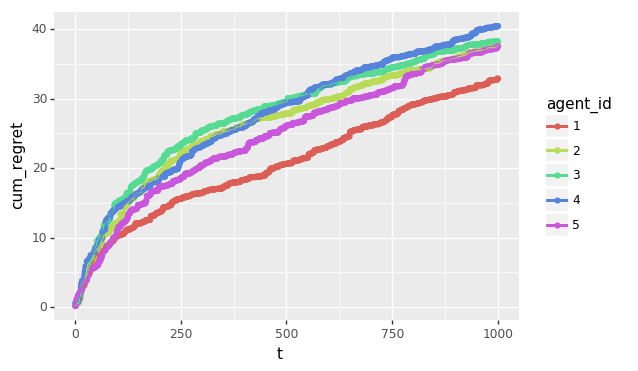

<ggplot: (8771118682637)>


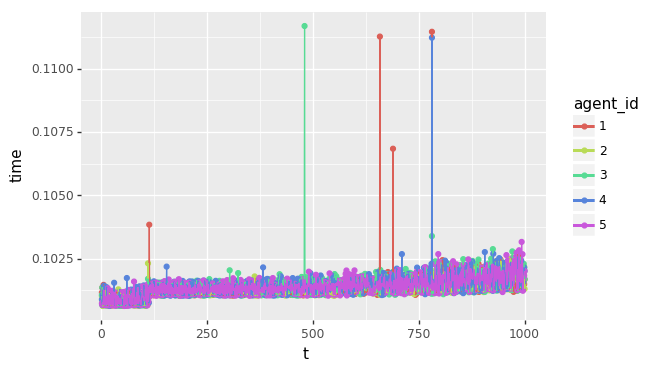

<ggplot: (8770996019485)>
theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Sample: array([ 0.25168456, -0.68823889, -0.90611158,  1.08743523,  0.24895327,
       -0.96266397,  0.96187316, -0.60405636, -1.04096434, -1.62771492,
       -0.38855538,  0.26094602, -1.08021092, -0.23472418,  1.2413119 ,
        1.98596652,  0.31453453,  0.18001041, -1.13101534, -0.40615947,
        1.44435834])
 Steps taken: 2042
 Sample: array([-0.46059728, -1.30941329, -0.18732492,  0.93431964, -1.23289979,
       -0.09716315,  0.09006184,  1.69838796, -0.58307456, -1.08854011,
       -0.32692695,  0.55189344,  0.74251227, -0.16704328,  0.10808908,
       -0.99299527,  0.55776028,  0.25211194,  0.32650498,  2.24908006,
       -1.25562406])
 Steps taken: 2034
 Sample: array([-1.

 Sample: array([ 1.03712569, -0.09887671,  1.42205955,  0.1825843 ,  0.16111606,
       -0.91270065, -1.07341547,  0.31273509, -1.47507164, -0.73072128,
        0.8014941 , -0.81852391,  1.44124544, -1.06617142, -0.72238534,
        0.93157356,  0.97413279, -0.5767207 , -1.24647714, -0.58320061,
        1.75343997])
 Steps taken: 1569
 Sample: array([ 0.63028803, -0.50304043, -2.59859931,  0.99870349,  0.78725308,
        0.74578904,  1.11367553, -1.84207848, -0.34266166, -0.22917032,
       -0.32327377, -0.86838897,  1.3029329 ,  0.97897063, -0.32271716,
       -0.80009813, -1.31717836,  3.53126132, -0.34436284, -0.80793205,
       -0.51134862])
 Steps taken: 1561
 Sample: array([-1.07880897,  0.18193776, -0.4975475 ,  0.08075649,  0.99112674,
        0.21243672, -1.00245779,  1.31873571, -0.78078765, -0.6365078 ,
       -0.91461623,  0.94839797, -1.04806364,  0.13283685, -0.57143727,
        1.06478968,  2.16134992, -0.8504705 ,  1.72471638, -0.23858019,
        1.00054559])
 Steps t

        2.65472301])
 Steps taken: 1536
Experiment: Step 10
 Sample: array([ 1.81800622,  0.77378532, -0.17504836, -2.12502318,  1.13914858,
       -0.54340925,  0.6075787 , -1.6190244 , -0.01700711, -0.66911139,
        0.04430393, -0.47821322, -1.43905426,  0.10802663,  0.86679928,
        0.4973827 , -0.3526798 ,  0.84706915, -0.63445588,  0.84829229,
        1.18305486])
 Steps taken: 1542
 Sample: array([ 3.36385330e-01,  3.97275367e-04, -2.86189281e-01, -2.63858926e+00,
       -3.25854713e-01, -2.98133242e-02,  1.05624942e+00, -6.20913739e-01,
        1.04800915e+00, -1.93918103e+00,  4.69609051e-02,  5.07814230e-01,
       -8.22184880e-02,  8.56133796e-01,  6.63281850e-01,  3.96289871e-01,
        1.64996812e+00,  9.20208426e-01, -5.87387244e-01,  4.59173136e-01,
       -3.58288711e-01])
 Steps taken: 1531
 Sample: array([ 1.58443580e+00,  9.50128719e-01, -1.47959451e+00,  7.23505293e-01,
       -2.47091299e-01, -1.57370575e-02, -7.91828748e-04, -1.59341678e-01,
       -1.212241

 Sample: array([ 0.4565786 ,  1.00253308,  0.6040193 , -0.69091852,  2.79782447,
        1.14701423, -0.44814432, -0.74751637,  0.9640126 ,  0.6109266 ,
        0.89281882, -0.50076097,  0.56868867,  0.41384274, -0.68372611,
        0.20509588, -1.06831677, -0.54541749,  1.4877075 , -0.61567457,
        0.35163575])
 Steps taken: 1452
 Sample: array([ 1.56380294, -0.07193957, -0.1653837 ,  0.00760416, -0.35264466,
       -1.02059436,  0.31927406, -0.77087942,  0.30818162, -1.66853866,
       -1.08869355, -0.5617995 ,  0.71454109,  0.46390782,  0.11216752,
       -0.50759505,  0.32395237,  1.14134507,  0.12471184,  1.40570585,
       -1.19249845])
 Steps taken: 1506
 Sample: array([ 1.30047641,  0.63880918, -1.15387875,  1.19870436, -0.73852985,
       -0.65343224,  1.29168304,  1.07205267, -1.11454885, -1.67793628,
        0.96876879, -0.59291739, -0.18539609, -0.44720762,  2.24009797,
       -1.76237741,  1.09404703, -1.22617034, -1.42640265,  1.36257335,
       -0.64020605])
 Steps t

 Sample: array([ 1.38873922,  0.29105966,  1.25998205,  0.17313163,  1.07246129,
       -1.30127455,  0.29969325,  1.29420701,  1.60587842, -0.86205065,
        0.53271482,  0.57136609,  1.17405376, -0.77035159,  1.78846555,
       -0.06352191,  0.68426335,  1.34690495,  1.11958793,  1.22891262,
       -0.17230603])
 Steps taken: 1470
Experiment: Step 20
 Sample: array([ 1.585901  ,  0.22360123, -0.80591439, -1.76154664, -0.61181823,
       -1.54972365,  1.20344548,  0.74712225,  0.32745171, -1.0022431 ,
        2.06280269,  0.45258645, -0.04595578,  1.193767  , -1.21385407,
       -0.48385341, -0.68717698, -1.44647288, -0.75815562, -0.40175474,
        0.40509414])
 Steps taken: 1475
 Sample: array([ 0.76098683,  0.49231147, -1.87040068,  0.98784567,  1.34424008,
       -1.15371218, -0.44773835,  0.3340705 ,  0.60946712, -1.28306756,
       -1.95992426, -1.07327937,  0.33635929, -0.07790818,  1.28551936,
        0.39976623, -0.64191485, -0.22229834, -1.3195376 , -0.05139612,
       -1

 Sample: array([ 2.41508525, -1.41935758,  1.45124966,  0.80107805, -0.26680752,
        0.59552105,  1.72476966,  0.4441038 , -0.33118279, -1.07460966,
       -0.00337203,  0.34103979, -0.24225104,  0.30518938, -1.6905594 ,
       -1.34033979, -0.52905322,  1.67805198,  1.98226318,  0.19800675,
       -1.02533221])
 Steps taken: 1434
 Sample: array([ 1.20227365, -0.72939701, -0.95073991, -0.34708436,  0.43774601,
       -2.30434507,  0.9809249 , -0.20845858, -0.26560701, -1.62365073,
        0.72446674, -0.01783123, -1.12067993,  1.27283833,  1.62884784,
       -1.03374251,  0.01511664,  0.31959744, -0.85431969, -1.55720361,
       -0.53949413])
 Steps taken: 1443
Experiment: Step 25
 Sample: array([ 1.07675107,  1.6684787 , -0.1200739 , -1.88207031,  1.13303055,
        0.04787432,  2.25941747, -1.04492679, -0.10255006,  0.23730663,
       -0.1622236 , -0.30946716, -1.82813648,  0.13102551,  0.03074807,
        0.5443038 , -0.48635083, -1.46809984,  1.282976  , -1.6768388 ,
        0

 Sample: array([ 1.22436496,  0.11415373, -0.44520951,  0.65589285, -1.53147736,
       -1.0508492 ,  1.72162237, -0.69934373, -1.65994619, -1.39574586,
        2.33629857, -1.17830848, -2.0965825 ,  0.70960157, -2.4214623 ,
       -1.29026439, -0.20127627,  0.80783927,  1.13247795, -0.75847721,
       -1.74669397])
 Steps taken: 1397
Experiment: Step 30
 Sample: array([ 1.49154499,  0.86581465, -0.61256498, -3.47178829,  1.90293054,
       -1.5986326 ,  1.33919804,  1.13948425,  1.52497122,  0.34693722,
       -0.34439444, -1.06195637,  0.68079412,  0.07132068, -0.39991204,
       -0.82120438,  0.23474573, -0.4641223 ,  0.6207696 , -1.4288274 ,
        0.02726837])
 Steps taken: 1388
 Sample: array([ 2.30820358e+00, -6.35511086e-01, -4.98881451e-01, -1.88362072e-03,
        4.07373831e-01, -1.86282561e+00, -7.16504144e-01,  7.36141935e-01,
       -5.53286075e-01, -2.45584097e-01,  1.30079755e-01,  3.42866070e-01,
       -1.91206536e-01, -1.49123350e+00,  3.11887624e-01, -2.16809457e+0

 Sample: array([ 1.93224175,  1.2367957 , -0.80103955, -1.18413335,  0.13615657,
        0.39082642,  1.55291395, -0.59658424,  0.82941818, -0.12378102,
        1.63819053, -2.22530391,  0.51682314,  0.35429921, -0.93260169,
       -0.3028556 , -0.96501668,  1.55335442, -1.30648562, -0.3866962 ,
       -1.37455352])
 Steps taken: 1386
 Sample: array([ 1.12048178,  0.81372757, -0.42667614,  0.56488522,  0.33605855,
       -1.61450365, -1.4976197 ,  0.74414579, -0.06197575, -1.17134801,
        0.3317079 ,  0.93441753, -1.79527723,  0.38322472, -0.13864737,
       -0.21645787, -1.45503257, -0.87432967,  1.29779399,  1.87958652,
        0.31159917])
 Steps taken: 1390
Experiment: Step 35
 Sample: array([ 1.69235553, -0.22741958, -1.21713212, -1.52242526,  1.59255054,
       -0.49436781,  1.41085501,  1.80130247, -0.91094746, -0.95560151,
       -0.5044432 , -1.08704134,  1.19929779,  0.06962978, -0.29344205,
       -1.29945742, -1.22922459, -1.39724403, -0.62851386, -0.60451303,
       -0

 Sample: array([ 0.40045087, -1.06511836, -1.80352397, -1.25133721, -0.50053324,
       -0.6060719 ,  0.69727896,  1.7015322 , -0.63909714, -1.38357349,
        1.00970104, -0.96495829, -0.57395783,  1.1431966 , -0.15787552,
        0.12219995,  1.36892479, -0.4465169 ,  0.34206592,  1.85351364,
       -0.19903907])
 Steps taken: 836
 Sample: array([ 1.15860593,  2.34240909,  0.24742157, -0.86307136, -0.88723826,
       -0.12168409,  1.4018897 ,  1.01770012,  0.24698379, -0.09697865,
        0.91487062, -0.91603485,  0.92101232, -1.67610754,  1.20684103,
       -0.70122001, -0.45499739,  1.11221098,  0.92097607, -0.20477757,
       -0.44235436])
 Steps taken: 1081
 Sample: array([ 0.78151745, -0.36016564, -0.85700619, -1.60579783,  0.65654638,
       -1.94110601,  1.19606864,  1.43193007, -0.87081439, -1.69042962,
        2.33581454, -0.43120531, -2.19298222,  0.02009976, -1.86224482,
        0.03239704, -1.07105374, -0.60963609,  1.74053861,  1.22943443,
        0.12528715])
 Steps ta

 Sample: array([ 1.20553516,  0.45003932,  0.44069419, -2.00020936, -0.37504555,
       -1.62771527, -0.67971986, -0.29714247,  0.05018949, -0.58594507,
        1.17558567,  0.64087382,  0.31529283,  2.00177099, -0.09108488,
       -1.0088395 , -0.79869696,  0.47897371, -1.80509186, -0.15244598,
       -0.29198606])
 Steps taken: 1367
 Sample: array([ 1.88126533,  0.09454186, -0.1651705 , -2.16932208, -0.31750378,
        0.06806401,  1.8608761 , -0.72836095,  0.15020568, -0.62752058,
        0.14413287, -1.89599816,  0.468195  ,  0.6527225 , -0.20056362,
       -1.11955525,  0.74033214, -1.94848415,  0.278994  ,  0.85398062,
       -1.47532877])
 Steps taken: 1369
 Sample: array([ 1.09745105,  1.1296515 , -0.73991858,  0.20454671,  0.59405063,
       -0.26011329,  1.5941358 ,  0.2197077 , -0.11425999,  1.92182329,
        1.22461176, -1.00858893, -0.33667823, -0.70660422,  1.85790019,
       -1.82643279, -1.00539783,  0.72815053,  0.73536883, -0.29490141,
       -1.97835784])
 Steps t

 Sample: array([ 0.40835335, -0.51135427, -2.4715553 , -1.6246403 , -0.22182192,
       -0.58089028,  0.90051852, -0.02931266, -0.66517808, -2.31287856,
        0.63634558, -1.50556943,  1.02904497,  0.56336288,  0.06583006,
        0.59476876,  0.90513055,  0.37878001,  1.17896548,  0.28739883,
       -2.191347  ])
 Steps taken: 1337
 Sample: array([ 1.68339555, -0.3602101 ,  0.20901626,  0.12973551, -0.16378995,
       -0.21664818,  1.18532101, -0.33473994,  1.56054156, -1.35307499,
        0.20530779, -0.29086457,  0.31476376, -1.27695113,  0.76207194,
        0.64236126, -0.24809061,  0.06093697,  1.25432045,  0.15366579,
        0.1728796 ])
 Steps taken: 1332
 Sample: array([ 1.10304409, -0.91665814, -0.91951183, -0.82778448,  0.4813703 ,
       -0.10009921, -0.69754359, -1.03335675, -0.25293316, -0.10425451,
        1.49275127, -0.72645201, -0.26011403,  0.26070603,  0.9334391 ,
        0.07738312, -0.02345211, -1.83769679,  0.20288661,  1.02044465,
        1.9758882 ])
 Steps t

 Sample: array([ 0.99244891, -0.48246112, -0.22998219, -0.96203929,  1.84867571,
       -0.43672261,  2.28818272,  0.52762809,  0.90591637, -2.27065932,
        0.70775582, -0.27041235,  1.0251344 ,  0.39463114,  0.30672485,
       -2.310973  , -0.02644168,  1.06570647, -0.42780491,  0.58360847,
       -1.58925125])
 Steps taken: 1304
 Sample: array([ 1.53738778,  0.31322473,  0.73058742,  0.5193848 , -0.46299859,
       -0.63020593,  0.41457137, -0.82019651, -0.44094196, -0.17749752,
        1.01260837, -0.17946634,  0.30765048,  0.15838475, -0.19385909,
        0.41347327, -0.98344884,  0.74190442,  1.32431544,  0.79291551,
        0.39858338])
 Steps taken: 1317
Experiment: Step 55
 Sample: array([ 1.92359752, -0.2740945 ,  0.13095834, -1.9306414 ,  0.35851312,
       -1.96824975, -0.21591552,  2.51625266, -0.53210306,  0.99880513,
        1.22926141, -1.43980757,  1.13974907, -0.97125521,  1.04500816,
       -0.66903299, -1.36572508, -2.16349581,  1.75423032, -0.54667209,
        0

 Sample: array([ 0.28723233,  0.27473904, -1.97123464, -0.54704201, -1.35786148,
       -0.07353314,  0.53909881, -0.4693669 , -1.21244745,  0.03418706,
        1.13007641, -0.72909383,  1.33430994, -2.00402234, -0.47979323,
       -0.86861254,  1.70996517,  0.49380517,  0.42816722,  2.03779119,
       -2.36923016])
 Steps taken: 1115
 Sample: array([ 1.58996445,  0.78206433, -0.36854099, -0.54775477, -1.20504618,
       -0.86476545,  1.31317411, -1.06169544,  1.12015828, -0.23098789,
        0.82534252, -0.78450633, -0.24415109, -0.452338  , -0.04376311,
        0.78448099,  1.40688023,  0.36146558,  0.39544728,  0.74797105,
       -2.18967562])
 Steps taken: 1103
 Sample: array([ 0.68704466,  0.00859863, -0.34753417, -0.55160355,  0.21127816,
       -1.63267728,  0.70863543, -0.09296998,  1.03695829, -0.06323552,
       -0.02480183, -1.30033961, -0.78926382, -0.1490773 ,  0.74570922,
        0.60273071, -0.90684014,  0.36146398,  1.76580752,  1.36771176,
        0.08323015])
 Steps t

 Sample: array([ 1.29362711, -0.58941931, -0.21143316,  0.16901103, -0.12521323,
       -1.18408405,  2.44150485, -0.29849651,  0.40705814, -0.65093214,
        1.57171486, -1.37977394, -0.62363183, -1.39132657,  1.3695923 ,
       -0.46790423, -1.99653622, -0.10420228,  0.78848943,  0.93272956,
       -0.38937374])
 Steps taken: 1179
 Sample: array([ 1.12643716,  0.15695962,  0.81304599, -0.88127489,  0.40275742,
       -1.41636671, -0.45005115, -1.69190853,  1.05617073, -0.83626756,
        1.29158474, -2.24232885, -0.64888678, -0.04680996,  0.33419305,
       -0.60626873,  0.66527522, -0.31320198,  1.67966215,  2.29418794,
       -0.20669091])
 Steps taken: 1214
Experiment: Step 65
 Sample: array([ 1.65569317, -0.31599729, -0.28513627, -1.36676115, -0.91410679,
        0.20333065,  1.09231586,  1.34338543, -0.08704547, -0.24658243,
        0.12488241, -0.45762478,  0.58310052,  1.11508012,  0.38077412,
       -0.63994504, -1.65738329, -0.67638583,  0.99733584,  0.90336161,
        1

 Sample: array([ 0.46392513, -0.02711556, -0.63054888, -1.51461074, -0.27924575,
       -0.00990176,  1.20880118, -0.40900305, -0.7097842 , -0.82204604,
        0.40972982, -0.04361431,  0.5157745 ,  0.46580264,  0.64264915,
       -1.45847342,  1.25984863, -1.97659902,  0.13554213,  1.90893046,
       -0.15222119])
 Steps taken: 1165
 Sample: array([ 1.48292916,  0.23928941, -0.25362317, -0.22909803, -0.81691087,
       -0.51321931,  1.03209826,  0.03840095,  0.98630621, -1.1571763 ,
       -0.10217229, -1.40883595,  0.76382023,  0.1488823 ,  1.71894058,
        0.21161583, -0.31294947, -0.8183572 ,  0.32506042, -0.64711016,
        0.14625644])
 Steps taken: 1187
 Sample: array([ 0.95532861, -0.50758831, -0.18588096,  0.00479364,  1.09940949,
       -1.96821604,  0.49896455, -0.33174821,  1.75324943, -0.17470103,
       -0.2253805 , -1.15127654, -0.54742753,  0.47049552, -1.22384718,
       -0.36037964,  0.45457586, -0.78427468,  0.41140813,  0.46312768,
        1.13568013])
 Steps t

 Sample: array([ 1.61373481, -0.74213435, -0.23046062, -1.71494893,  0.3294106 ,
       -1.47338633,  2.30482638,  0.31495378,  0.16393837, -1.66279507,
        1.12178917, -2.45911018, -0.18383548,  0.0601357 , -0.32248047,
        1.02132741,  0.49803391,  1.27026139, -0.08049395, -0.14463921,
        0.80993204])
 Steps taken: 1131
 Sample: array([ 0.88430562, -0.92215585, -0.49796019, -1.60203283, -2.44447438,
       -0.18500564,  1.48000845,  0.16100293, -0.65281637, -0.08809754,
        1.06606432, -1.53958271,  0.13582605,  0.52108546, -0.42277498,
       -0.99391906,  1.15660721,  0.12526965, -0.26286008,  1.25685563,
       -2.41690801])
 Steps taken: 1151
 Sample: array([ 0.85234482,  0.48034796,  0.63171307,  0.05420001, -1.96004867,
       -1.19101728,  1.26894861, -0.89551716,  1.57907734, -1.04722354,
        1.64531137, -0.29229385,  0.79848159, -0.10227719,  1.65860127,
       -1.6228949 , -1.21937823,  0.16259735,  0.52378857, -0.6701243 ,
        1.20448572])
 Steps t

 Sample: array([ 0.21392091, -0.63322568, -1.64285637, -1.22040193,  0.33667499,
       -1.14208037,  1.26046375, -0.09120648, -0.42510385, -0.38502871,
        0.4196352 , -1.82382644,  0.29912901, -0.66175965,  1.04875683,
        0.22546091,  1.1556076 , -0.78564893, -0.91950724,  1.15874877,
       -1.23494046])
 Steps taken: 1106
 Sample: array([ 0.83555294, -0.27031964,  0.21326962, -0.49726232, -0.86358246,
       -1.83609819,  1.62330695,  0.24330037,  0.49944263, -1.82930689,
        1.19618115, -1.79245571, -0.34329926, -1.30679662,  1.27738291,
       -0.97962092, -1.50907718,  1.34852182,  0.97469553, -0.52961759,
       -0.98877971])
 Steps taken: 1114
 Sample: array([ 1.57728215, -0.86501988, -0.65646242,  0.17259138,  1.38233889,
       -0.89593987, -0.25817568, -1.79747432,  0.5798627 , -1.29807392,
        2.21116592, -0.23644892, -0.16934651, -0.92140441,  0.34762717,
       -0.03125745, -1.6369048 , -1.1739692 ,  1.07914646,  1.52851986,
       -0.30209186])
 Steps t

 Sample: array([ 1.7315935 , -1.01996786, -0.11263722, -0.97945793, -1.6602508 ,
       -0.71743683,  0.9000346 , -1.23004694,  0.27205338, -0.50464605,
        1.23767543,  0.01470311, -0.86819734,  0.41883831, -1.09458703,
        1.07143411, -0.14967364, -0.01335828, -0.19608925,  2.22808094,
       -0.48473316])
 Steps taken: 1086
 Sample: array([ 0.93989683, -0.4211214 ,  0.61930106, -0.70935902,  0.3015795 ,
       -0.2953384 ,  0.49854151, -0.07239817, -0.38395515, -0.37364707,
        0.67251594, -1.29941554,  0.20707682, -0.50082272,  0.09350254,
        1.31328017,  1.24250327, -0.10627581,  0.11044662,  2.14484965,
       -0.38743847])
 Steps taken: 1085
 Sample: array([ 1.86757398,  0.01260383,  0.75198947,  0.128371  , -0.19569522,
       -0.87534353,  2.48305663,  0.20294264, -0.02980464, -0.66435432,
        1.17040065, -0.99128704,  0.84504171,  0.11206159,  2.24443214,
       -2.56732215, -0.88643776, -0.26340445,  1.50851278, -1.61308835,
        0.49478574])
 Steps t

 Sample: array([ 2.07960067, -1.34457658,  0.04495037, -0.45280532, -0.10194942,
       -0.00222127,  0.36229319, -1.15437754,  0.67159944, -0.78284001,
        0.61063652, -1.60473918, -1.18481379,  0.07237925,  2.19535745,
        1.09063936, -1.75234722, -1.56472774, -0.97731032, -0.55314697,
        0.71821689])
 Steps taken: 1045
 Sample: array([ 1.77822312,  0.25666699, -2.07866581, -1.18588954, -0.03144762,
       -0.85549137,  1.2030723 , -0.95967184,  0.18231651,  0.56291449,
        0.76441496, -0.19098305,  0.01494919, -0.95966896, -0.9097206 ,
        0.28182295, -0.25658375, -0.56914623,  1.40710022,  0.89332095,
       -0.80439275])
 Steps taken: 1050
 Sample: array([ 1.33715585,  1.04359393, -0.93070414, -0.46351457,  0.42703948,
       -1.39752092,  0.78886291,  0.01244572, -0.34934048, -0.48420087,
        1.53592861, -1.3305976 ,  1.30249627,  0.62813277,  1.17694997,
        0.25848616,  0.46355233, -0.72357391, -0.04975847,  0.80004464,
        0.08782679])
 Steps t

 Sample: array([ 1.84104432, -0.21555723, -0.88776135, -0.78657111,  0.71743137,
       -1.49805186,  0.65061238,  0.69708797,  0.16941588, -0.17817803,
        1.18166348,  0.16676491, -0.71247185,  1.60103099, -0.90096259,
        0.71696543, -0.1085184 , -0.13647737,  1.50414491,  0.87886373,
       -1.83208173])
 Steps taken: 1006
 Sample: array([ 0.87106527,  0.4055141 , -0.8815521 , -1.17587048,  0.46426084,
       -0.77578735,  1.2622219 , -1.57213367,  0.37908988, -0.40327245,
        0.16790425, -2.37256824, -0.42811645, -0.05981686, -0.11295974,
       -1.05309106,  2.43459742, -1.0206103 , -0.7172966 ,  1.44136928,
        0.07372856])
 Steps taken: 1013
 Sample: array([ 2.14419501,  0.31722017, -0.21233902,  0.1814853 , -1.78857047,
       -0.95135639,  2.40174524, -0.02231355,  1.44294895, -1.60145455,
        0.97961566, -1.26442207,  0.25546148, -0.97083919, -1.69349687,
       -1.14235449, -0.33744754, -0.2694362 ,  0.41029362, -0.5032255 ,
       -0.08227372])
 Steps t

 Sample: array([ 1.8559085 ,  0.26610137,  0.40105455,  1.00673773,  0.08198865,
        0.1797408 ,  0.73560595,  0.3300332 ,  1.43530926,  0.34417013,
        1.484501  , -0.65448164,  0.88547578,  0.89102647,  1.85423362,
       -0.3118195 , -1.60980775, -1.26414587,  0.58997443,  0.07083303,
       -0.33266432])
 Steps taken: 981
 Sample: array([ 1.34411512, -1.63682233, -0.91571985, -1.14225066, -0.22206593,
       -1.27311504,  0.59384821,  0.3546402 , -0.05940971, -0.11208904,
        1.03366543, -2.21670321,  0.13080087, -0.34805622,  0.9962286 ,
        0.19024954,  0.6106687 ,  1.63812912, -0.35747021,  0.64405344,
       -0.33807794])
 Steps taken: 992
 Sample: array([ 1.21187629, -0.18825681,  0.10350223, -1.55855872,  1.05504563,
       -0.86796985,  1.13097961, -0.48364171,  0.16168043, -0.39079033,
        0.39854862, -1.14961048,  0.229812  , -0.12575075, -0.59631022,
       -0.77331912,  1.23390817, -0.80178687,  0.69469267,  1.66975665,
       -1.13495026])
 Steps tak

 Sample: array([ 1.07581459, -0.07548068, -0.84441958, -0.44449651,  0.27637445,
       -1.16135232, -0.01407392, -2.19091472, -0.36719547, -0.33582508,
        1.90763256,  1.06514152,  0.08309464,  0.05984837,  0.18339154,
       -0.06221566, -1.60461158,  0.07853914,  0.19880055,  0.07400508,
       -0.03310626])
 Steps taken: 955
 Sample: array([ 1.35585024,  0.89389327, -1.29163045, -1.23983238,  0.77750758,
       -1.73412586,  0.9828068 , -0.16957186,  0.15425554,  0.28701171,
       -0.05094401, -0.55541867,  0.30163994, -1.24326188, -1.4201951 ,
       -1.58593851,  0.02138325, -1.3108407 ,  0.50653935,  1.67482721,
        0.7105208 ])
 Steps taken: 961
 Sample: array([ 1.11399831, -0.6434347 ,  0.09477895, -1.6702059 , -1.05332052,
       -2.05683401,  2.11361677, -0.07117762,  1.28774238, -0.45687394,
        2.16971744, -0.83967305, -0.26546526, -0.46665791,  1.418006  ,
       -1.10362838, -0.03472219, -0.49764178, -0.53736356, -0.54871655,
       -0.28173198])
 Steps tak

 Sample: array([ 1.46674323,  0.45947064, -1.07159307, -2.0362723 ,  1.76917393,
       -1.69923764,  1.00898461,  1.13568158, -0.11429891,  0.93001033,
        0.55682235, -2.92608206,  0.55427423, -0.15271712,  0.3394705 ,
       -0.30213699,  1.48175889, -1.20263272,  0.71800354,  2.93115224,
       -1.08949988])
 Steps taken: 924
 Sample: array([ 0.90924686,  0.42810492, -0.05450255, -1.01529302,  0.26093097,
       -2.53576396,  2.21007781, -0.68392266,  0.54002143,  0.02271525,
        1.23734275, -0.41175553, -0.99770138, -1.55325375,  0.80542778,
       -0.08850369, -0.53073062, -0.46575678, -0.18824478, -0.04965633,
        0.12557611])
 Steps taken: 929
 Sample: array([ 1.20710157, -0.459291  , -0.47861057, -2.07120821,  1.6665193 ,
       -2.36477093, -0.554308  , -0.46483818, -0.94120208, -1.64380515,
        1.53823371, -1.28809942, -1.01314019,  1.28506071,  0.32702631,
        1.14995557,  0.31734716, -2.03867305,  0.70692371,  0.50323998,
       -0.40787079])
 Steps tak

 Sample: array([ 1.55173971, -0.56946633, -0.23473157, -0.89445088, -0.24522874,
       -0.95197183,  1.28567282, -1.38721323,  0.55544536, -1.73528121,
        1.60373889,  0.21769946,  0.11579947, -1.62120788,  0.71791708,
       -0.16140964, -2.90453174,  0.09372204,  0.22131846, -0.23800762,
       -0.24221401])
 Steps taken: 640
 Sample: array([ 1.59259704, -0.24505925,  0.02712358, -0.96142538,  2.44973179,
       -2.04799021,  0.99646939, -0.09999918, -0.42027895, -1.16538834,
        0.95583137, -0.28252409,  0.04454308,  0.24546976, -0.01558739,
       -0.30271399, -0.67581661, -0.93474072, -0.51870454,  1.24963605,
       -1.0179269 ])
 Steps taken: 662
Experiment: Step 115
 Sample: array([ 1.6979782 , -1.17953166, -0.35359008, -0.0582521 ,  0.26616293,
       -0.06636671,  1.49568891, -0.36252816, -0.33522723, -1.0848147 ,
        0.86983185, -0.60256043,  0.06873441,  0.06960487,  0.70803493,
        0.65516755, -2.56430611, -2.54479816,  0.08672626, -0.09669767,
        0.

 Sample: array([ 1.45721865, -1.03225946, -1.87466983, -1.37083434,  0.16543672,
       -0.56576971,  1.95742177, -0.3325864 ,  1.38299943, -0.20138358,
        1.1255679 , -1.11084345,  0.12439058, -0.83821471,  1.4014657 ,
       -0.86513852,  0.08814009, -0.2856719 ,  1.14727628,  2.01710566,
       -0.22680443])
 Steps taken: 632
 Sample: array([ 1.64844116,  1.59587142,  0.43894288, -0.62447507,  0.54694701,
       -0.78812956,  0.93535453, -0.42909777,  0.19756306,  0.01215907,
        0.74554829,  0.96054032, -0.45933342,  0.10397499, -0.46512399,
       -0.10538386, -2.02398565, -0.59831295,  0.74590232, -0.59083396,
        0.65521535])
 Steps taken: 653
 Sample: array([ 1.23689367, -0.74713108, -1.12047786, -1.95370509,  1.17185821,
       -1.39286594,  0.74570327, -0.86780848, -0.11216187, -1.93620348,
        0.5956089 , -1.35739038, -0.82792425,  0.61353931,  0.12792368,
       -0.35315451, -0.24934356, -0.69254662,  0.08273122,  0.1691738 ,
        0.20439261])
 Steps tak

 Sample: array([ 1.50419106, -0.15413107,  0.66659773, -0.43837457, -0.51541143,
       -1.50618964,  0.83068632,  0.53024027, -0.19458877, -0.55155568,
        0.91007892, -0.34537027,  0.03484213, -0.72602353,  0.65677735,
       -1.26613735, -1.10375153, -1.31744176,  0.24949076, -0.54198125,
       -0.47129618])
 Steps taken: 628
 Sample: array([ 1.58048787, -0.78242581, -0.76752222, -0.66885542,  2.37698564,
       -2.01716546,  1.18162537,  0.18536374, -0.93815744, -1.61862888,
        0.73829197, -0.47692423,  0.01418982,  0.21179612, -0.54599728,
        0.85472282, -0.40942582, -0.11159381,  0.44610256,  0.87491169,
       -0.75075725])
 Steps taken: 645
Experiment: Step 125
 Sample: array([ 1.28671880e+00, -1.07293126e+00, -6.70989492e-01, -1.09125656e+00,
       -9.86284830e-03, -8.77380887e-01,  2.13592609e+00, -2.06878246e-03,
        3.06256432e-01,  9.12165951e-01,  3.74421238e-01, -1.54663985e+00,
       -1.68652656e-01,  8.81614169e-01,  6.71345019e-01,  5.37429627e-01

 Sample: array([ 0.98239837, -0.50828725, -0.31666096, -1.54486222,  0.14139962,
       -1.14712549,  1.2605883 , -0.16788621,  0.77035989, -0.26833682,
        0.10694178, -0.90927144, -0.17734912,  0.89764963,  0.35967305,
       -1.17146992, -0.14795511, -0.78554365,  0.36947161,  1.22789798,
       -1.00551453])
 Steps taken: 615
 Sample: array([ 1.54358206, -0.01654696, -0.21924068,  0.46719548,  0.54902516,
       -0.39519789,  2.83052768, -0.37304596,  0.31566527, -0.58608414,
        0.83907775, -2.11990787,  0.83865437,  0.23741747,  1.1879736 ,
        0.2522305 , -2.69367281, -0.10802937,  0.84913565, -0.4219302 ,
        0.46981829])
 Steps taken: 618
 Sample: array([ 1.33190102,  0.42860367,  0.53236116, -0.59800073,  1.5582428 ,
       -1.14035298,  1.00082844, -0.35909017,  0.44331638, -2.29807725,
       -0.54660514, -0.36037591, -0.79496833,  1.5046812 ,  1.1894588 ,
       -0.5630396 , -1.14721411,  0.45351872,  1.80417342,  0.75528251,
       -0.5674307 ])
 Steps tak

 Sample: array([ 1.65312509, -0.14780357, -0.56549055,  0.45112933, -0.83655943,
       -1.19095986,  0.81442218, -0.2144572 , -0.42881421, -0.50951537,
        1.7551348 , -0.42012047, -1.05055849, -0.12340684,  1.18815948,
       -0.33318888,  0.28968075,  0.18338086, -0.13332177,  0.97565052,
       -0.80921076])
 Steps taken: 608
 Sample: array([ 1.41481176, -0.64970838,  0.18207471, -0.83151569,  0.78611121,
       -0.3532463 ,  1.79676042,  0.75317208, -0.52205962, -1.15485   ,
       -0.32979297, -1.14907721,  0.52640358,  0.61323592,  1.3302208 ,
       -1.55855418,  0.15338933, -0.14591135, -0.46408725,  1.87488723,
       -1.35934501])
 Steps taken: 621
 Sample: array([ 1.77801672,  0.31434882,  0.69287737, -0.42068128,  1.03107841,
       -0.81675201,  1.4807914 , -0.2511999 , -0.32730562, -1.18235724,
        0.33617297, -0.92196284,  0.12998883, -0.79720585,  0.98937638,
       -0.00652462, -0.9755017 , -0.91215969,  0.65438818,  0.38437626,
       -0.36384056])
 Steps tak

 Sample: array([ 1.68421441,  0.63579777,  0.57020839, -0.0362921 , -0.17856936,
       -0.97305019,  0.42015506,  0.58725963,  0.4272398 , -0.4167886 ,
        2.32114929, -1.45886023,  1.10765109,  0.98497139,  1.30799666,
       -0.10819244, -2.20792629, -1.13240309, -0.05444632,  0.98506051,
        1.11341093])
 Steps taken: 595
 Sample: array([ 1.02075328,  0.14418388, -0.65809077, -0.37402714, -0.12124374,
       -2.14846233, -0.23265441, -1.10618263,  0.02155574, -0.33274931,
        0.80396176, -1.16796876, -0.28939976,  0.08536678,  2.03204711,
       -0.45705755, -0.55975778,  0.6699236 ,  0.60623919,  0.53308075,
       -0.3188222 ])
 Steps taken: 612
 Sample: array([ 0.819794  ,  0.68192083, -1.32113181, -0.27393526, -0.92534998,
       -0.32372958,  2.1067376 ,  0.63826129,  1.17977048, -0.92502544,
        0.99223302, -1.48268412, -0.20930613,  1.41305836,  1.76255513,
       -1.75244748,  1.83955918, -1.52242902,  1.07178752,  2.31476523,
       -1.62349945])
 Steps tak

 Sample: array([ 1.30007311, -0.43705242, -0.23452389,  0.70377857,  0.8756235 ,
       -1.34273433, -1.0262771 , -0.26284182, -0.58776463, -0.90205606,
        2.03905769, -0.92406336,  0.61055062,  0.55393348,  0.02257857,
       -0.11158058,  0.55100791, -0.96513001, -0.19239248,  1.40744824,
       -0.77893035])
 Steps taken: 594
Experiment: Step 144
 Sample: array([ 2.09835488,  0.78471481, -0.00575033, -0.08705837,  1.45874923,
       -1.96085021,  1.37658206, -1.61788636, -0.36400565, -1.50980477,
        1.02542263, -1.72487544,  1.21715579,  0.45330921,  1.35389831,
        0.57314583, -1.74357083, -0.38373485,  0.54486718,  0.49123037,
       -0.46168809])
 Steps taken: 608
 Sample: array([ 1.66890634,  0.79006356, -1.00137367, -0.96009371,  0.29062792,
       -1.12792804,  0.25626442, -0.96598104,  1.07719356, -0.57377928,
        0.61151841, -1.71005943, -0.28021263,  0.15799717,  1.35710068,
        0.00276903, -0.42168451, -0.88702922, -1.45192023,  0.05418063,
        0.

 Sample: array([ 1.5456229 ,  1.23038583, -0.15404257, -1.95426615,  2.4616128 ,
       -1.67746127,  1.08700183,  1.31679916,  0.01314621, -0.69910273,
        2.18075153, -1.37915498,  0.99064355,  0.29773576,  1.05507305,
       -0.38533173, -0.62071938, -1.30840652,  0.65867095, -0.17006983,
        1.01823232])
 Steps taken: 585
 Sample: array([ 1.32715167,  0.1736742 , -0.47930065, -0.75322342, -0.07439562,
       -2.3778154 , -0.58559105, -1.05537123,  0.51731572, -1.44258292,
        0.34865092, -0.22887121, -0.49449407, -0.04936413,  1.18856452,
        0.38197159, -0.07377011, -0.17209265, -0.05519747,  0.7858605 ,
        0.79372569])
 Steps taken: 597
 Sample: array([ 1.29220401,  0.74891134,  0.23144827, -0.35416725, -0.05560271,
       -0.40417044, -0.40898606,  0.01665042, -0.16014629,  0.25732015,
       -1.00558856, -1.15649713,  0.12680023,  0.08995895,  1.0805266 ,
       -0.88181987,  1.22623953, -0.65206771,  1.15679894,  1.4649908 ,
       -0.36845565])
 Steps tak

 Sample: array([ 1.05212125, -0.77230436, -0.04166876, -0.17374981,  1.7678729 ,
       -2.7538337 ,  0.54066306, -0.89905916,  0.1829039 , -0.74305708,
        1.1143994 , -0.1084144 , -0.50190651,  0.46277496,  1.3701843 ,
        0.08747208, -1.98973971, -0.85045626,  1.02558529,  0.96171712,
       -0.84597108])
 Steps taken: 579
Experiment: Step 154
 Sample: array([ 1.61340759,  1.26069596, -0.49985357, -0.79799482, -0.13693523,
       -0.4943367 ,  1.69770731, -0.2652028 ,  0.96073568, -1.46320646,
        1.68902346, -1.89194404,  0.53632713, -0.1122712 ,  1.6142997 ,
       -0.43258872, -1.81776996, -1.59610878, -0.03337755,  0.88666539,
       -0.06782425])
 Steps taken: 592
 Sample: array([ 1.6021367 ,  0.35620311, -0.14337093, -0.2851494 , -0.86759314,
       -2.58959635, -0.30402985, -0.45543225,  0.18015847, -1.04198252,
        0.37917254, -0.95120755,  0.38346247, -0.725756  ,  1.43275048,
        0.57562171, -0.58114061, -0.14533924,  0.10181214,  0.98248678,
        0.

 Sample: array([ 1.73351538, -1.68161439,  0.51399461, -0.60720606,  0.81571928,
       -1.76359144,  1.24154511, -0.86282445,  0.37098214, -0.5251459 ,
        0.70571781, -0.52737211, -0.35186906, -0.14538945,  0.81642584,
        0.64666625, -0.56863676,  0.84370614,  0.090279  ,  0.67551373,
       -0.74791954])
 Steps taken: 568
 Sample: array([ 1.56059707, -0.80474257, -1.0669716 , -0.20963037,  1.36610791,
       -3.15904634,  1.13786356, -0.78910498,  0.38247522, -2.23079321,
        2.20914345, -0.44185057,  0.49533183,  0.21744195, -0.10151017,
        0.61773967,  0.71133881,  0.23759382,  0.38073782,  0.02602716,
       -1.38021695])
 Steps taken: 580
Experiment: Step 159
 Sample: array([ 1.67753498,  1.29230996, -0.39990803, -1.11162353,  0.51296822,
       -1.99640106,  1.77200185, -0.38967214,  0.36353197, -0.42775099,
        1.60387376, -0.44866753,  0.59474131,  0.38546433,  1.71332968,
       -0.25585469, -2.17682393, -0.86292685,  0.14415599,  1.12821277,
       -0.

 Sample: array([ 1.2952378 , -0.0676055 , -0.34780538, -0.01135133, -0.10348728,
       -1.9491602 ,  1.92598104,  0.78978888,  1.15898715, -0.49069021,
        0.829365  , -2.00613386,  0.78485007,  1.08299426,  0.81050399,
        0.87715363,  0.24260242, -0.5801083 ,  0.58681036,  0.55746413,
       -0.58564511])
 Steps taken: 560
 Sample: array([ 0.81912697, -0.04298966,  0.53811822,  0.33487168,  0.47508651,
       -3.47296896,  2.86055258,  0.19160005,  2.17763736, -0.76007217,
        1.71525409,  0.03414244,  0.47748477, -0.02367746,  2.70668038,
        0.27381312, -1.09713832, -0.46165693,  0.63852242, -0.02105061,
       -0.69892668])
 Steps taken: 573
 Sample: array([ 1.15803296, -0.94968703, -0.62713576, -0.34822074,  1.22474121,
       -0.96498653,  0.28643177, -0.60094666,  0.14295064, -1.55632251,
        0.67958   , -1.50284077, -0.78594439,  2.05672133,  1.42864542,
        0.30509196, -1.49101511, -0.06772651,  0.70362858,  1.82846741,
       -0.03312062])
 Steps tak

 Sample: array([ 1.52141752, -1.05440687, -1.31779978,  0.26594487,  0.76697579,
       -1.396217  , -0.08497851, -1.43971605,  0.17280591, -1.07147381,
        1.36351373, -0.40066449,  0.13116295, -0.30604432,  1.67392892,
       -0.0182617 , -0.13229767,  0.49247252, -1.43246977,  0.71860267,
       -0.26510953])
 Steps taken: 556
 Sample: array([ 0.87015041,  0.77858621, -0.44321209,  0.4049838 , -0.7884657 ,
       -0.7172798 ,  1.63620833,  0.27716879, -0.31423456, -0.62466697,
        0.49910882, -1.9748523 ,  0.08262314, -0.26299736,  1.0271398 ,
       -0.87432553,  0.94004101, -0.99711165,  0.97011762,  0.46055903,
       -1.16727173])
 Steps taken: 566
 Sample: array([ 1.47394767, -0.7668329 ,  0.16381259, -1.23009535,  0.01930986,
       -2.3369177 ,  2.21815654, -0.51423295,  0.24395408, -1.73433978,
        1.17093683, -0.32285649, -0.41633078,  0.20730283,  2.14682999,
       -0.05855851, -1.45282728,  0.334644  , -0.23740862, -0.20777709,
       -1.17676271])
 Steps tak

 Sample: array([ 1.62971677, -0.26383645, -0.82850693, -0.44872092, -0.32299559,
       -1.29088967,  1.9788905 , -0.55440991,  1.06479849, -1.34674703,
        0.83859481, -1.33453408,  0.14436832, -0.70362339,  0.88108331,
       -1.02723452, -0.6241427 , -0.84299243, -0.7187829 ,  0.6295737 ,
       -0.64229497])
 Steps taken: 554
 Sample: array([ 1.51334493,  1.50037171, -1.69604189,  0.01930051, -0.87118559,
       -1.98873689, -0.41703489, -0.63174472, -0.04885151, -0.18131558,
        0.84947102, -0.88109886, -0.63392194,  0.59299423,  2.51040396,
        0.02473178,  0.87109769, -1.50616235,  0.39912986,  1.28767286,
       -2.09553348])
 Steps taken: 565
 Sample: array([ 0.94866518,  1.13719071, -1.39787395, -0.89731772,  0.19802684,
       -1.30473055,  1.52031328,  0.32719646,  0.93943059, -0.06074749,
        1.62098882, -0.78500276, -0.24635006,  0.90979179,  1.96245153,
       -0.44892462,  0.02347057, -0.3715563 ,  0.14656933,  2.62502174,
       -1.54358207])
 Steps tak

 Sample: array([ 1.45554574, -0.5131202 , -0.83092567, -1.11485904,  0.1697548 ,
       -0.04465773,  0.26960791, -0.94571867,  0.64655074, -0.74203844,
        1.11753823,  0.18629059, -0.16899214,  0.28829574,  1.76135888,
        0.91970744,  0.03165742, -1.09864665, -0.43932826,  0.31722186,
       -1.6026149 ])
 Steps taken: 546
 Sample: array([ 0.9381162 ,  0.51880373, -1.28107851, -0.39553465, -0.974316  ,
       -1.50511111,  1.14929542,  0.88690027,  0.28293118, -0.36604303,
       -0.76285979, -2.85532649, -0.0052675 ,  0.16789153,  1.38766313,
       -1.68108679,  2.21449552, -0.37959448,  0.95502451,  1.90062108,
       -2.30371048])
 Steps taken: 560
 Sample: array([ 1.36290238,  0.18376168,  0.5272934 , -0.35381116, -0.75858993,
       -0.54461523,  1.41659911, -0.03446154,  0.30046206, -1.47071736,
        2.07771647, -2.18410964,  0.08677214, -0.66578909,  0.66394319,
       -1.16832725, -1.09942169, -0.35436896,  1.35984367,  0.60478464,
       -0.59945329])
 Steps tak

 Sample: array([ 1.27886187, -0.09747402, -0.6929091 , -0.51921192, -0.39059082,
       -0.78833128,  1.96462672, -0.05743706,  0.19144195,  0.16292265,
        0.93558499, -1.41325885, -0.06705301, -0.07276115,  1.08063346,
        0.02018301, -1.12634033,  0.48618776,  0.12198762,  0.40626719,
       -0.96062731])
 Steps taken: 540
 Sample: array([ 1.83670392, -0.40006646,  0.04137375, -1.24116053,  1.10788747,
       -2.07440252,  2.08920884,  0.67404967,  1.03707435, -0.68581993,
        2.04900975, -0.78067173, -0.14876875, -1.02438862,  1.00239576,
       -0.90369232,  0.04736374, -0.17907322,  0.86654543, -0.74333556,
       -0.94674454])
 Steps taken: 554
 Sample: array([ 1.20101494,  0.37541866, -1.83173436, -0.59840973,  1.01610747,
       -2.90639949,  0.94964498, -0.71685808, -0.64393854, -0.82619975,
        0.65396641, -0.95398627, -1.39056223,  0.50016315,  1.18179426,
       -0.14461945,  0.17415022, -1.43680498,  0.01221664,  0.15576266,
       -0.05681456])
 Steps tak

 Sample: array([ 1.09486891, -0.34764898, -0.02580386, -0.95052902, -0.18262978,
       -1.61435855,  0.54823589, -0.86447883,  0.15794006, -1.04118606,
        0.42603066, -0.82183877,  0.89348703, -0.31831779,  1.56566966,
       -0.44041335, -0.363047  , -0.18004169,  0.13092495,  0.59081095,
       -0.96113742])
 Steps taken: 537
 Sample: array([ 1.0970969 , -0.84746004,  0.04647638, -0.41365732, -1.44305862,
       -1.31136724,  2.44176783,  0.29310298, -0.05549238,  0.22373989,
        1.60149973, -0.09478309, -0.0646621 ,  0.42201042,  0.70868367,
       -1.46777432,  1.94350063, -0.25199506,  0.69028431,  1.83299693,
       -1.41550539])
 Steps taken: 547
 Sample: array([ 1.45671713, -0.11562374, -0.89962267, -1.14287791, -0.56072021,
       -0.48873629,  2.445196  , -0.00299658,  0.45717434, -0.44749626,
        0.6276273 , -0.99889156, -0.58487723, -0.0373459 ,  1.80357981,
       -0.67322255, -1.19541241,  0.42898921,  0.22262086, -1.16439812,
        0.53313157])
 Steps tak

 Sample: array([ 1.19335351,  1.27641616, -0.0887169 , -1.31917721, -0.64174911,
        0.86931996,  2.50939457, -0.57556901,  0.19969374, -0.43805815,
        2.59095257, -1.97882303, -0.66583273, -0.0656623 ,  0.27699833,
       -0.66010016, -0.83595166, -1.49824517,  0.99951123, -1.07873465,
       -0.43811927])
 Steps taken: 528
 Sample: array([ 1.4443494 , -0.05641197, -0.53056313, -1.08832603,  0.38051453,
       -1.41810365,  0.13303393,  0.14658723,  0.32248773, -1.34347053,
        1.34349449, -1.12391623,  0.45814984, -0.18905035,  0.98446336,
       -0.80976746, -0.51144644,  0.05398234, -0.19030269,  0.1482226 ,
       -0.63507316])
 Steps taken: 540
 Sample: array([ 1.80124365, -0.3668023 , -0.66136096, -1.5467264 , -0.93560006,
       -1.8591403 ,  2.43714022,  1.85463472,  0.57760955,  0.08756922,
        0.82658115, -1.79429191,  0.24126247,  1.2959257 ,  0.65728281,
        0.18971965, -0.43866163,  0.33572634, -0.5477346 ,  0.64554205,
       -2.00267855])
 Steps tak

 Sample: array([ 1.04247046, -0.2513905 , -0.74634016, -0.67399687, -0.24000679,
       -2.25929232,  0.00484297, -0.38401169,  0.78593893, -0.7356441 ,
       -0.03841619,  0.76050334, -1.42992996,  0.67162059,  1.08742159,
        0.29654809, -0.4960203 , -0.36713677,  1.30702389,  0.7243841 ,
       -0.8725081 ])
 Steps taken: 521
 Sample: array([ 1.29077114, -0.25285993, -0.99919601, -2.27975854, -0.32782951,
       -1.33559364,  0.78730481,  0.35082006,  0.63008327, -0.73872397,
        0.60806002, -1.78427199, -0.50295851,  0.79698164,  0.0962943 ,
       -0.66902273,  1.49215752,  0.35111759,  1.25241899,  1.45198603,
       -2.11829122])
 Steps taken: 533
 Sample: array([ 1.86465899, -0.73743302,  1.18631025, -1.37560102, -0.11069056,
       -0.20392657,  1.92985477, -0.513828  ,  0.63089063, -1.59987197,
        1.06945639, -0.91307806,  0.02120985, -0.86950022,  1.0942987 ,
       -0.80716158, -0.213749  , -0.10527453, -0.28685036, -0.33394482,
        0.29490466])
 Steps tak

 Sample: array([ 1.06980065,  0.7213498 ,  0.11934189, -0.4640093 , -0.5183836 ,
       -1.05238602,  2.1542761 , -0.62518834, -0.03458776,  0.58548355,
        0.59893202, -2.01796119,  0.75595725,  0.09231581,  1.45975971,
       -1.46523195,  0.92305293,  0.21828878,  0.60304308,  1.22470813,
       -1.63077939])
 Steps taken: 510
 Sample: array([ 1.2278242 , -0.34069273,  0.1706616 , -0.72811808, -0.13884012,
       -1.17526392,  1.38638022,  0.03884945,  0.795329  , -0.41199228,
        0.59118355, -0.83239362,  0.40540809, -1.10067861,  0.83061656,
       -0.68270589, -0.85243739, -0.35042858,  0.32391998, -0.65602612,
       -0.08918265])
 Steps taken: 529
 Sample: array([ 0.91698725, -0.44124272, -0.68339759, -0.58664336,  1.81733908,
       -3.06307072,  0.58010959, -0.58601318,  1.11588965, -2.41218416,
        2.22319883, -0.23005373,  0.32737842,  0.22252485,  0.68002634,
       -0.25980515, -0.84070408, -0.48999805,  0.22575034,  0.44121573,
       -0.10170413])
 Steps tak

 Sample: array([ 1.30012701,  0.69623951, -1.56166968, -1.16037782,  0.04568058,
       -1.95432292, -0.15648196, -0.51774417,  0.43800089, -0.86753787,
        0.30767559, -0.28366223,  0.65538492,  0.26500754,  1.9835998 ,
       -0.43352814, -0.53423429, -0.16578911, -0.71511688,  0.1642319 ,
       -1.23472825])
 Steps taken: 504
 Sample: array([ 1.72422295,  1.00542534, -0.30895409, -1.22673109,  0.9266357 ,
       -2.03892425,  1.7805021 ,  0.62725199, -0.15422648,  1.19931488,
        1.25894576, -1.56880734,  0.48377249,  1.54900753,  0.32094283,
        0.13225888, -0.31713057,  0.47118277,  1.29198544,  0.13340098,
       -1.63593971])
 Steps taken: 517
 Sample: array([ 1.66467668,  0.47768656,  0.04930396, -1.47257137, -0.61229878,
        0.08110026,  1.70719336,  0.26943094,  0.49626615, -1.47796189,
        1.67746778, -0.81645332,  0.50294248, -0.43839113,  0.95222228,
       -0.19515262, -0.84124144, -0.19656714,  0.64754064, -0.68814197,
       -0.12799248])
 Steps tak

 Sample: array([ 1.60120726, -0.42990771,  0.2282976 , -1.07397783,  1.13893305,
       -1.6540121 ,  0.47392078, -0.32123951,  0.5569739 , -0.98389913,
        1.26748861, -0.4574626 , -0.55559327, -0.22539423,  0.34724715,
       -1.08327195, -0.19638195, -1.0360956 , -0.9886215 ,  1.11946512,
       -0.53126369])
 Steps taken: 494
 Sample: array([ 1.27115055,  0.44335575,  0.01262692,  0.20361704, -0.24652805,
       -1.91256271, -0.41662579, -0.35729742,  0.07254942,  0.16222891,
       -0.25558897, -1.55380297, -0.58672257,  0.30864336,  1.03378206,
       -0.77378443,  0.1289591 , -1.16189471, -0.6726992 , -0.10439467,
       -0.82311595])
 Steps taken: 509
 Sample: array([ 1.56651584, -0.2670336 , -0.32365177, -0.61749391,  0.73010842,
       -0.30219368,  1.79282448,  0.43483242, -0.16963977, -1.44383489,
        0.52994652, -1.87716101,  0.09296524,  0.43156636,  1.62051403,
        0.19033442,  1.42180054,  0.79132898, -0.0204758 ,  1.87740666,
       -1.02657573])
 Steps tak

 Sample: array([ 1.20974103,  0.42791766, -1.41468779, -0.0296435 ,  1.64494103,
       -2.14074573,  0.16179866,  0.30054458,  0.897563  , -1.21719985,
       -0.01177563, -0.64186454,  0.69928968,  0.8090416 ,  0.53588177,
        0.43089797, -0.31569736, -0.00830598,  0.40365848,  0.77551737,
        0.10633253])
 Steps taken: 491
Experiment: Step 218
 Sample: array([ 1.76722977, -0.21242776,  0.33944987, -1.01046287,  0.99092472,
       -0.23976424,  1.49361613,  0.23566695, -0.69818973, -0.94281161,
        1.00090251, -1.6925413 ,  0.10698762,  0.51316984, -0.22302366,
       -0.81402085, -0.36030677, -1.72606925,  0.60414512,  0.98755294,
       -1.10771157])
 Steps taken: 502
 Sample: array([ 1.11132826,  0.01172551,  0.61673189, -0.04532323, -1.02072841,
       -1.32331933,  0.31488027, -0.12669323,  1.24387328, -0.48736146,
        0.65739594, -1.05479352,  0.01396741,  0.4733097 ,  1.6333818 ,
        0.16175675,  0.356058  , -0.59022143,  0.01107981,  0.25207576,
       -1.

 Sample: array([ 1.47993203,  0.25718933, -0.16059279, -0.37010372, -0.19838435,
       -1.7908032 ,  1.95646414,  0.56893695,  0.97267277, -0.86061516,
        0.79675006, -0.57197224, -0.99497279, -1.56141861,  0.21609073,
       -1.67010318, -1.21553892, -1.00578929, -0.09984994,  1.18980616,
       -0.14722618])
 Steps taken: 483
 Sample: array([ 1.37693373, -0.68938542, -1.43532759, -0.3933888 ,  1.23568316,
       -2.5732523 ,  1.37744053,  0.53727332,  0.01394986, -1.6683309 ,
        2.23443039, -0.24493812, -0.239444  ,  0.93328449, -0.01170123,
        0.76703261,  0.38044253, -0.62566988, -0.39354735,  0.52350695,
       -0.37464964])
 Steps taken: 494
Experiment: Step 223
 Sample: array([ 1.40459188,  1.12168984, -0.27987904, -0.69944008,  0.89061559,
       -0.71222932,  1.58127057,  0.43457435,  0.21675622, -0.00505099,
        1.29287189, -1.62932018, -0.09549926,  1.30815615, -0.46751293,
       -0.53231567,  0.08058861,  0.31424799,  0.86046325,  1.0592356 ,
        0.

 Sample: array([ 1.38600703e+00, -5.27435541e-01,  3.70736278e-01, -2.49080212e+00,
       -1.97700918e+00, -2.30641598e+00,  2.24873214e+00, -1.87841466e-02,
       -1.28402183e-01,  1.62978682e-01,  1.07257016e-02, -1.66874806e+00,
       -7.93600443e-01, -2.04044972e-03,  1.92840697e-01,  1.02201552e-02,
        9.58594610e-01, -1.16400593e+00,  9.28552548e-01,  2.12469905e+00,
       -1.43537894e+00])
 Steps taken: 479
 Sample: array([ 1.22568566e+00,  1.42497515e-03, -1.35680655e-01, -4.22868793e-01,
       -5.16362281e-01, -1.20685952e+00,  1.68004617e+00, -1.95783766e-01,
        4.54286776e-01,  3.20527678e-01,  1.87311168e+00, -1.43711613e+00,
       -8.56811884e-01,  2.53918253e-01,  5.82405109e-01,  1.12247981e-01,
       -6.32975298e-01,  8.18632975e-02, -2.68632871e-01, -3.08572335e-01,
       -4.27825467e-01])
 Steps taken: 484
 Sample: array([ 1.26640374, -0.93843741, -2.06647344, -1.4160294 ,  1.14468398,
       -1.96217568, -0.55468272, -0.28029898,  0.10386941, -0.855

 Sample: array([ 1.44641572e+00,  9.23267872e-01, -1.44136510e+00, -1.10505425e-01,
       -5.16237588e-01, -1.10000273e+00,  3.13046313e-01, -1.64949084e-01,
        9.09955126e-02,  1.02132404e-03,  6.93735655e-01, -4.99188006e-01,
       -8.97771138e-01, -4.93138951e-02,  1.46296145e+00, -5.95946430e-01,
       -1.66017000e-01,  1.94661172e-01, -7.09513123e-01,  8.51345674e-01,
       -1.24224626e+00])
 Steps taken: 475
 Sample: array([ 1.68571487,  0.47539593,  0.54596536, -0.84868883, -0.4434658 ,
       -1.89997415,  1.72465647, -1.02539553,  0.48224894,  0.43681664,
        1.43064463, -1.32018164, -0.63131798,  0.82872975,  1.50460947,
       -0.38667411,  1.40421849,  0.80820675,  0.679312  ,  1.58092752,
       -0.83069806])
 Steps taken: 485
 Sample: array([ 1.34514437,  1.61073328,  0.02736658,  0.18793635,  0.4098899 ,
       -1.26294829,  1.93974111,  0.15141757,  0.84675901, -0.52063375,
        1.84024899, -0.81686191,  0.18174323, -0.10282618,  1.35992866,
       -1.00

 Sample: array([ 1.6382918 ,  0.4831255 ,  1.00514672, -0.12474738, -0.10592539,
       -1.19861338,  2.01301081, -0.54999264, -0.58259958, -0.7887451 ,
        1.16918511, -1.27612435, -0.92971918, -0.43178542, -0.22238653,
       -0.95177519, -0.60611145, -0.5870321 , -0.48797233,  1.14229888,
       -0.19157904])
 Steps taken: 466
 Sample: array([ 1.18404104, -0.26517725, -0.90430022, -0.46705452, -0.19019564,
       -2.4014573 , -0.87699903, -1.29269586,  0.96454716, -1.34352509,
        1.57772718, -2.11415919,  0.61870405,  0.53801008,  2.05682633,
       -0.20721731,  0.07135967, -0.25049277, -1.1803692 , -0.23941581,
        0.33384185])
 Steps taken: 479
 Sample: array([ 1.43175227,  0.45299498,  0.36852674, -1.09967414, -0.32896626,
       -1.38089593,  3.12102038,  0.14818806, -0.18807308, -0.78179784,
        0.53273066, -1.3145357 , -0.5480695 ,  0.38062303,  0.2541806 ,
       -0.88541875,  1.01729817,  1.05720742,  0.89525731,  0.74147134,
       -1.46291752])
 Steps tak

 Sample: array([ 0.98970378, -0.92824352, -0.51975613,  0.00737276,  0.76382141,
       -2.68300355,  0.82308304, -0.3744753 , -0.18916446, -1.47367283,
        0.85274999, -0.41152998, -1.19966079,  0.34023473,  0.47915763,
        0.53106448, -0.09585946,  0.27816313,  0.07210116,  0.25532937,
       -0.66545928])
 Steps taken: 462
Experiment: Step 242
 Sample: array([ 1.82190221,  0.47988698, -0.88684212, -1.27585719,  0.94880142,
       -0.03725434,  0.2039302 , -0.01804713, -0.55336575, -0.7874094 ,
        1.39998553, -0.8241705 ,  0.34575189,  0.46774833, -1.04301399,
       -1.52487068, -0.33594736, -0.68315197, -0.33609773,  0.39175897,
       -0.52548467])
 Steps taken: 472
 Sample: array([ 1.60477023,  0.36843776,  0.30713359, -1.22366387, -0.54742618,
       -1.7223358 , -0.08113752, -0.95682867,  0.84521264, -0.45798187,
        0.04634659, -1.23583837,  0.22287708,  0.3774837 ,  0.32757443,
        0.00392662, -0.49702926, -2.33249032, -1.11247497,  0.67237667,
       -1.

 Sample: array([ 1.57047388, -0.04496344, -0.23336046,  0.04048485,  1.48908643,
       -1.67068435,  1.15553577, -0.51451581,  0.11518082, -1.32461902,
        1.58071856, -0.78509999, -0.05832871,  1.22594122,  0.02578047,
       -0.21852948, -0.55003158, -0.8382915 , -1.14603955,  1.10979746,
       -0.35349402])
 Steps taken: 456
 Sample: array([ 0.99645696, -0.50147189, -0.22240253, -0.30457746,  0.30506001,
       -2.01505863, -0.67499544, -1.04480055,  0.90968268, -0.7558278 ,
        1.51768912, -0.8123197 , -0.15673098,  1.0305469 ,  1.02207703,
        0.4083793 , -0.53864594,  0.02557464, -0.62199792,  1.21889819,
       -2.15115049])
 Steps taken: 463
 Sample: array([ 1.39470667, -0.68318086,  0.28702386, -1.23834801, -0.04518231,
       -1.4329976 ,  3.4891822 ,  0.85806515,  0.91171043, -0.49613786,
        2.48730235, -1.45034196,  0.12658398, -0.91165359,  1.4161598 ,
       -1.02425764,  0.90671237,  1.24617563,  0.04460256,  1.02975548,
       -1.69786705])
 Steps tak

 Sample: array([ 1.21267693,  0.30284908, -0.88366012, -0.70717549,  1.67756557,
       -2.9897186 ,  0.07143502, -0.31717452,  0.44709577, -1.73906595,
        0.91626747, -0.62561619, -0.6428553 , -0.24529305,  0.28288857,
       -0.1898847 , -1.01119305, -0.37277827,  0.83513275,  0.36814285,
       -0.32548056])
 Steps taken: 446
Experiment: Step 252
 Sample: array([ 1.32430054, -0.86392048, -0.8470588 ,  0.20558005,  1.25190739,
       -0.04613125,  1.17708935, -0.21514132, -0.3660191 , -0.22413797,
        1.17799244, -1.70060729,  0.22027231, -0.22298271,  0.44454242,
       -1.17908153, -0.77014491, -0.61466199, -0.88677096, -0.13226831,
       -1.83352502])
 Steps taken: 458
 Sample: array([ 1.03375009, -0.07642788, -1.34413616, -0.66051931, -1.27147002,
       -2.76699946, -0.33785536, -0.19113502,  1.46654519, -0.83084903,
        0.55789132, -0.50381979,  0.44689726, -0.46069194,  1.51913892,
        0.31390536, -0.9780176 , -0.8182377 , -0.11535652,  1.25655613,
       -0.

 Sample: array([ 1.48396847, -0.55371463,  0.73647115, -0.23941467, -0.36038353,
       -1.10591198,  2.31378423, -0.01848416,  0.71403332, -2.18404243,
        0.38633424, -0.61266412, -0.55410292,  0.32685446,  0.86386657,
        0.31794663, -0.99179244,  0.09830944, -0.59233177,  0.53842684,
       -0.02009703])
 Steps taken: 441
 Sample: array([ 0.93446736, -0.68722027, -0.12579681, -0.31403637,  0.79024922,
       -3.3396437 ,  0.6452195 ,  0.04963999,  1.03994181, -1.66248588,
        1.218037  , -2.00028484, -0.57912555, -0.01498387, -0.46521547,
       -0.19309508, -0.78729897, -0.60902494,  0.30268271,  0.58069979,
        0.57061212])
 Steps taken: 449
Experiment: Step 257
 Sample: array([ 1.52819374, -0.31046302,  0.01393679,  1.06893367,  0.54239144,
       -0.76130043,  0.88416298,  0.20621451,  0.49166997, -0.3391673 ,
        0.19008198, -1.32967384, -0.85749444,  0.5437358 , -0.17080938,
       -1.02507329, -2.55361188, -0.70003253, -0.2584746 ,  0.43541739,
        0.

 Sample: array([ 1.42442352,  0.55394309,  0.15036771, -1.06408892,  0.24049198,
       -1.88310781,  2.32256742, -0.00654559,  0.15606598, -0.41028677,
        1.06997836, -1.70613023,  0.28651944, -0.44493968,  0.79460905,
       -1.17977323,  1.31238557,  0.01392757,  1.32139568,  0.68087342,
       -0.97060659])
 Steps taken: 429
 Sample: array([ 1.79093422, -0.32170751,  1.64239438,  0.2012814 , -1.01396006,
       -2.22566743,  0.7276037 , -0.55238854,  1.19575396, -0.60605519,
        2.22350518, -0.67411421,  0.56327021,  0.23796153,  0.25869469,
       -0.31917239, -1.01930677, -0.34289593, -0.04833873,  0.75546629,
        0.73938528])
 Steps taken: 419
 Sample: array([ 0.8618119 ,  0.73647312, -0.47277783, -0.4646211 ,  2.00978839,
       -2.46694203,  0.1530713 , -0.37934845,  0.0524821 , -2.11878405,
        2.18129882, -1.36705186, -1.01240833,  0.46132253,  0.44421771,
       -0.32355159, -0.60317237, -0.56892659,  0.59259939,  0.58610717,
       -0.21896096])
 Steps tak

 Sample: array([ 1.51840859,  0.05206776,  1.0876575 ,  0.00872706, -0.01599252,
       -0.5373414 ,  1.71589436, -0.61227177,  0.53991635, -0.92351323,
        0.98236197,  0.56322564, -0.31351678, -0.99607245,  0.38584332,
       -0.4372505 , -1.44913974,  0.68286411,  0.56771818,  1.22673188,
       -0.5677805 ])
 Steps taken: 426
 Sample: array([ 1.02963663, -0.34028271, -0.49640169, -1.44260758,  1.5234097 ,
       -2.18093379,  0.64361041, -1.17798332,  1.01202503, -1.74641533,
        1.4661967 , -0.01289478,  0.11584195,  0.73811045,  0.79619729,
       -0.65855946, -0.15208423, -1.15521093, -0.46968737,  0.69489835,
       -0.91983894])
 Steps taken: 437
Experiment: Step 267
 Sample: array([ 1.50624878,  1.00156777, -0.03266296, -0.05308139,  0.42169673,
       -1.24118785,  1.21798594,  0.13100463,  0.4036514 , -1.12923247,
        1.89123846, -2.01066339, -0.32944318, -0.10152102, -0.38214698,
       -1.72643937, -0.22589619, -0.99613016, -0.50420221,  1.42980422,
        0.

 Sample: array([ 1.22376998, -0.52610055, -0.42486194, -0.8706044 , -0.48840712,
       -0.46062057,  1.96959158,  0.05672619, -0.19025097,  0.87102439,
        0.96348248, -1.86317751, -0.59687414,  0.71743159,  0.58398012,
       -0.31461339,  0.7518776 ,  0.04770271,  0.19212654,  0.48500937,
       -2.03124155])
 Steps taken: 421
 Sample: array([ 1.27076862e+00,  2.92861703e-01,  5.92458961e-01, -1.44928199e+00,
       -1.08526218e+00, -2.33805387e-01,  2.00072332e+00, -6.66899943e-01,
        9.32864966e-01, -1.02046029e+00,  1.96234638e+00, -1.82715055e+00,
        5.76399237e-01,  4.85805538e-01,  1.13930815e+00,  4.62738814e-01,
       -1.96760244e+00, -8.65295350e-01, -1.32350637e-01, -8.71123703e-04,
       -4.05509236e-02])
 Steps taken: 430
 Sample: array([ 1.30320726, -0.76984137, -0.76487943, -0.99016379,  0.82366047,
       -1.80306046,  0.00486218, -1.15252843, -0.78739625, -1.44881608,
        1.52112606,  0.32553947, -0.1819691 ,  0.59291163, -0.43423861,
        0.41

 Sample: array([ 1.27145789, -0.23876476,  0.18299434, -2.62676968, -0.49542054,
       -2.53589258,  0.10854324, -0.19308787,  0.44021701, -1.09243738,
        1.06939224, -1.61755674, -1.02943331,  0.71451475,  1.52281055,
        0.35292702, -0.62767909,  0.00471224, -1.07808545,  1.60095158,
       -1.07463186])
 Steps taken: 419
 Sample: array([ 1.44401369, -0.409114  , -0.60537303, -1.59342442,  0.29153407,
       -1.08853627,  2.0729769 ,  0.67888299,  0.87282972,  0.74005783,
        0.56144825, -2.4036432 , -0.20679898,  0.18655299,  0.51240846,
       -0.34369484,  1.40648661,  0.10418472,  0.57515646,  0.41460614,
       -0.82583819])
 Steps taken: 428
 Sample: array([ 1.36998529, -0.35324573, -0.47698426, -1.65643781, -0.27713678,
       -0.8341031 ,  1.92732044, -0.11301799,  0.9526039 , -0.76942785,
        0.96528344, -0.7599647 ,  0.08585007,  0.17899621,  1.2413701 ,
       -0.39788983, -1.39653569,  0.05433201,  0.00927773,  0.75966896,
       -0.84491018])
 Steps tak

 Sample: array([ 1.15836291, -0.11964557, -0.13495281, -0.62405431,  1.09200947,
       -0.70620024,  1.69165724,  1.02654991, -0.29264789, -0.90579198,
        1.00417862, -1.93336065,  0.77253046,  0.72472072,  0.42625602,
       -1.64493274, -0.29892416, -1.61323987,  0.36620843,  0.20338439,
        0.79444239])
 Steps taken: 412
 Sample: array([ 1.28417305, -0.22708073,  0.12619004, -0.63330192,  0.64584382,
       -2.62567069,  0.22787922, -0.31741442,  1.09591725, -1.31387821,
        0.91352126, -1.00333223,  0.42571847,  0.26477639,  1.23910524,
       -0.71409057, -0.38805293, -0.31447827,  0.08536479,  1.06251348,
       -0.42373267])
 Steps taken: 424
 Sample: array([ 0.88219134, -0.00425126, -0.31422684, -1.90837663, -1.54499893,
       -2.00902611,  2.68898888,  0.46484359,  1.32436453,  0.77178403,
        0.29125928, -2.34636277,  0.00925826, -0.23850954,  0.83088701,
       -0.45647371,  1.72170078, -0.17339198,  0.83531999,  1.14660972,
       -2.48806328])
 Steps tak

 Sample: array([ 1.28165668, -0.73715107, -0.44217722, -0.81399289,  0.29184137,
       -2.53505481,  0.25132095, -0.18669712,  1.44214113, -1.21440937,
        1.65556581, -2.12857831,  0.36192551,  1.14711319,  1.44524697,
       -0.07845538, -0.06701657,  0.19452308, -0.78672822,  0.10340455,
       -1.97637737])
 Steps taken: 413
 Sample: array([ 1.56227772,  0.27936154, -1.09114749, -1.06399719, -0.58975309,
       -0.82552043,  3.33046609, -0.29638589,  0.60584054, -0.5332397 ,
        0.78716235, -1.23323377,  0.29023776, -0.15236579,  0.50038235,
       -0.19951786,  1.39613241,  0.64452072,  0.33247014,  1.28026142,
       -1.26271707])
 Steps taken: 419
 Sample: array([ 1.52147254,  1.39178283,  0.44368067, -1.17787249, -0.83152819,
       -1.37150058,  1.74252229,  0.31009335,  0.62514397, -0.30823641,
        1.31083181, -0.08023024, -0.093669  ,  0.35773349,  0.50202013,
        0.05296801, -0.88004187, -0.06051618, -0.18007514, -0.16985715,
       -0.0262482 ])
 Steps tak

 Sample: array([ 1.70888053, -0.7097238 ,  0.62318801, -0.9262031 , -0.55486144,
       -2.04989825,  1.3805303 ,  0.46184271,  0.93768176, -0.08962845,
        1.02403096, -1.7890121 , -0.6069367 , -0.36531683,  0.64435414,
       -0.31021898,  1.09271881,  0.87551954,  0.16266483,  0.26218956,
       -1.12775281])
 Steps taken: 403
 Sample: array([ 1.61627186, -0.26717683,  0.21953787, -0.60421784, -0.80211476,
       -0.14492521,  1.49896173,  0.39602076, -0.28785842, -0.73310987,
        0.57276457, -1.68423519,  0.10391107, -0.50567907,  1.14301266,
       -0.85026315,  0.31492865, -1.08660336,  0.0318502 , -0.14178032,
        0.22779059])
 Steps taken: 413
 Sample: array([ 1.15897633, -0.21402439, -0.84052354, -0.72611753,  0.5647588 ,
       -2.07814797,  1.36722866, -0.89654793,  0.90317705, -0.42079943,
        1.58338971, -1.19910075, -0.08887907,  0.17019857,  0.13625609,
       -0.48570389, -0.79120788, -0.89850052,  0.36985448,  0.04255895,
        0.4708748 ])
 Steps tak

 Sample: array([ 1.31085384,  0.16756914,  1.48964663, -0.98918681, -0.02664865,
       -1.41731885,  1.56337675,  0.11754943, -0.12579546, -0.28562548,
        0.81697594, -1.74965864, -0.60013615, -0.55966365,  0.98463187,
       -0.59331003, -0.85323462,  0.12545208,  0.50205473,  0.15851365,
        0.47089112])
 Steps taken: 400
 Sample: array([ 1.42296176, -0.5952348 ,  0.07772279, -0.36892389,  2.14098973,
       -2.83062849,  0.92853052, -0.83344034, -0.08158268, -1.27957291,
        1.8421615 , -1.96028198, -0.08190727,  1.31430976,  0.28736294,
       -0.2794703 , -1.4032367 , -0.87929798,  0.76076505,  0.27402447,
       -0.07658309])
 Steps taken: 409
Experiment: Step 297
 Sample: array([ 1.53167938, -0.31383124,  0.41021387,  0.13001073,  0.67612612,
       -1.02362219,  1.6258475 , -0.80589681,  1.01940113, -0.60053046,
        1.26735652, -1.54563345, -0.46940714, -0.80752108, -0.22719964,
       -0.8742479 ,  0.12115687, -0.84885287,  0.3172399 ,  0.15364418,
       -0.

 Sample: array([ 1.52237725,  0.00910886,  0.04069626, -0.51667582, -0.70003912,
       -1.05413573,  1.41143963,  0.1208831 ,  0.7287711 ,  0.04718104,
        1.22693418, -1.62015124,  0.09502506, -0.29746061,  0.24322656,
       -0.59938511,  0.31981846,  0.67143775,  0.91021094,  0.47178972,
       -1.22039309])
 Steps taken: 390
 Sample: array([ 1.85743467, -0.58437956,  0.87122063, -0.76673981, -1.019503  ,
       -0.9400856 ,  1.12312857, -0.47280197, -0.32208596, -1.58483546,
        0.57844526, -1.45186172, -0.36666802, -0.22532101,  0.58250012,
       -0.25292419,  0.01101206, -0.84543282, -0.09472402, -0.00606605,
       -0.23766941])
 Steps taken: 402
 Sample: array([ 1.16135498, -0.13987219, -1.81180338, -0.77455797,  1.48731072,
       -2.84646946,  1.60938042, -0.31727847,  0.72322837, -1.45387165,
        2.14205811, -0.90087404, -0.57952234,  0.22516721, -0.18108266,
       -0.24908895, -0.65976808, -0.28895357,  0.22592793, -0.81123267,
        0.03123748])
 Steps tak

 Sample: array([ 1.32957564,  1.20376555, -0.0230644 , -0.99897287, -0.04902447,
       -1.97561393,  0.15353084, -0.85283931,  0.99205705, -1.29439657,
        0.89601704,  0.12553379,  0.38512165,  0.32101745,  0.65616552,
        0.03565489,  0.47754872, -0.36347137, -0.53246249, -0.45663401,
       -0.73240858])
 Steps taken: 387
 Sample: array([ 0.90828262, -0.14816583,  0.38684748, -1.16346602, -0.52312038,
       -1.29002797,  2.31659341, -0.01585863,  0.56610682,  0.03434902,
        1.57678139, -2.07884908,  0.53896544, -0.2389049 ,  0.03574598,
       -0.53706391,  1.42438256, -0.51092391,  0.32681134,  0.99942998,
       -0.50308219])
 Steps taken: 394
 Sample: array([ 1.34170918,  0.38119735,  0.84105171, -1.4158785 , -0.58760367,
       -0.44885565,  2.74454622, -0.68986171,  0.46457876, -1.70226699,
        1.02860221, -1.29049798, -0.6197696 , -0.55929749,  0.70658339,
       -0.65760198, -0.19585268, -0.41313369, -0.83622443, -0.50764831,
       -0.42331011])
 Steps tak

 Sample: array([ 1.29159014, -0.15643974, -0.1384074 , -0.78987079, -0.05224982,
       -2.25621625,  1.63985678,  0.10893772, -0.98769014,  0.64905185,
        1.77464487, -1.35760113, -1.27131901, -0.82596898,  0.81741581,
       -0.57368591,  0.832799  , -0.35178583,  0.33892353,  1.05470632,
       -0.84002006])
 Steps taken: 382
 Sample: array([ 1.37876465,  0.22437829,  0.77704493, -0.60277352, -0.39744395,
       -1.51701147,  2.76079928, -1.18509455, -0.53583817, -0.52975691,
        1.78930963, -1.5605912 , -0.344595  , -1.13269003,  1.04905335,
       -1.06649237, -1.8754189 ,  0.12369877, -0.3437563 , -0.32359907,
        0.3840534 ])
 Steps taken: 390
 Sample: array([ 1.45106952, -1.10699721, -0.72435456, -0.55456471,  1.46959166,
       -3.22107276,  1.19683812, -1.0569199 ,  0.23581174, -0.40468634,
        1.67737378, -1.39594152,  0.74824696,  1.32269597, -0.62096733,
       -0.56172638, -1.0429273 , -0.4972525 , -0.37092   ,  0.96455394,
       -0.15453637])
 Steps tak

 Sample: array([ 1.3822996 ,  0.63721869, -0.12784146, -0.95728943, -0.33103789,
       -1.62302837,  1.23236761, -0.84246903,  0.71776451, -1.63678606,
        2.09285952, -0.81504934,  0.58340916, -0.97382828,  0.51237204,
        0.08350909, -1.0820071 ,  0.01891458,  1.1311348 , -0.15803101,
        0.16921688])
 Steps taken: 374
 Sample: array([ 1.37417359, -0.16292137, -0.52277719, -0.55475209,  1.5424156 ,
       -3.40870766,  0.26030439, -1.09277714,  0.70892171, -1.49572419,
        1.65421339, -1.47701173, -0.08683658,  0.15234055,  1.32656426,
       -0.56549715, -0.78613858, -0.62946215,  0.67616321,  0.11355276,
        0.39974528])
 Steps taken: 385
Experiment: Step 317
 Sample: array([ 1.42347515,  1.77484242, -0.44831899, -0.66611557,  1.39164284,
       -1.24964618,  0.86379148, -0.94010176, -0.20187584, -1.6460563 ,
        1.75752278, -1.62356848,  0.54471512, -0.3920096 ,  0.49306988,
       -1.10257999, -0.28198735, -1.24367725, -0.76677864, -0.52049857,
        0.

 Sample: array([ 1.55529571,  1.51538107, -0.53873959, -0.31690425,  0.64289987,
       -2.4325353 ,  1.31331125, -0.99725804,  0.64175056, -1.255052  ,
        1.10156879, -0.93613843, -0.97402645,  0.13956366,  0.5682314 ,
        0.7082442 , -0.62395952, -1.16663791,  0.58109585, -0.27739286,
        0.07292886])
 Steps taken: 369
Experiment: Step 322
 Sample: array([ 1.36042818,  0.30788234, -0.723406  , -0.45572889, -0.10468118,
       -1.76266407,  1.14619532,  0.09422119,  0.73673673, -0.99080235,
        1.54086103, -0.88123552, -0.02327366, -0.30058099, -0.64493662,
       -0.32925078, -0.83135304, -1.4936346 , -0.35169571,  0.80979761,
       -0.80011181])
 Steps taken: 380
 Sample: array([ 1.61951636,  0.18670759, -0.85135925, -1.68719287, -0.5135166 ,
       -2.4737976 ,  0.35542673, -1.03358214,  1.21943518,  0.17841063,
        0.77361178, -1.47063203, -1.04217791,  0.18286589,  1.51641974,
       -0.54183539, -0.15238813, -0.33962668, -0.56171744,  0.99527102,
       -1.

 Sample: array([ 1.18945906,  0.96652007, -0.19478938, -0.52250336,  1.00911709,
       -1.03196599,  1.15852046,  0.16850003, -0.31399351,  0.10572355,
        1.27303802, -1.77158787,  0.44037642,  0.04076878,  0.49436375,
       -1.26631579, -0.64450722, -0.68990144, -0.90217073,  1.05893124,
       -0.32866182])
 Steps taken: 367
 Sample: array([ 1.3262597 ,  0.81985104, -0.07149517, -0.94430478, -0.1442589 ,
       -2.92009473,  0.82699336, -1.09381933,  1.59127236, -2.0616805 ,
        1.55492522, -1.51210377, -0.3091442 ,  0.15716746,  0.62815053,
       -0.23126693,  0.28042239, -0.34481636, -0.72266454,  0.47301494,
       -0.67225993])
 Steps taken: 374
 Sample: array([ 1.32562462, -0.38790225, -0.62852435, -1.57084862, -0.06378968,
       -1.62235907,  1.72128956,  0.30478517,  0.64646003, -0.27628023,
        1.93538861, -2.27298299, -0.11147585, -0.71379979,  0.55703315,
       -0.62482869,  0.94213263,  0.20357349,  0.46183414,  1.40015662,
       -1.15444017])
 Steps tak

 Sample: array([ 1.3914795 , -0.37949481,  0.86357299, -1.03167027, -0.19675819,
       -2.93339506, -0.15984891, -0.64012356,  0.82357264, -0.74736396,
        0.71581351, -1.97578423, -0.18481462,  0.62872964,  0.95843247,
       -0.0535503 , -0.36599863, -0.40701206,  0.19217231, -0.3495635 ,
       -1.0176155 ])
 Steps taken: 363
 Sample: array([ 1.29065576, -0.07815742, -0.67727111, -2.07335199,  0.26208615,
       -1.07829782,  1.51127928, -0.36615551, -0.35853815,  0.73777085,
        1.81560991, -3.10346814, -0.71101348, -1.60140506,  0.39066083,
       -0.64684667,  1.07726908, -0.07306222,  0.42930745,  1.48913511,
       -0.57363113])
 Steps taken: 370
 Sample: array([ 1.71375221,  0.74043458,  0.42632001,  0.28529146, -0.64862289,
       -2.31036364,  1.96327492,  0.20694038,  0.29038543, -0.66649715,
        0.61673847, -1.01314726, -0.26108559, -0.57612536,  0.43204595,
        0.25876841, -1.1069467 ,  0.13262029,  0.4335372 , -0.2292123 ,
        0.21600884])
 Steps tak

 Sample: array([ 1.43965658,  0.8159395 , -0.92942161,  0.06210344,  0.53185132,
       -1.15940083,  1.27220481, -0.39267208,  0.41427998, -0.82526532,
        2.03339527, -2.24314128, -0.35123982, -0.28891585, -1.07902269,
       -0.95666882, -1.05978472, -1.53750617, -1.0655594 ,  1.15271238,
       -0.71826266])
 Steps taken: 354
 Sample: array([ 1.04387062, -0.01167868, -0.7586189 , -2.56950185, -0.72967689,
       -2.78976836, -0.19145854, -0.76035693,  0.3246718 , -1.25120953,
        0.12274621, -1.69181297,  0.54738582,  0.91542456,  1.24030116,
       -0.78208441,  0.59259214, -0.40348035, -0.3572762 ,  0.55274214,
       -0.6731934 ])
 Steps taken: 365
 Sample: array([ 1.17025616, -0.36438461, -1.03804241, -1.46425658, -0.58002943,
       -1.33869387,  2.78165098,  0.07260602,  0.30115222,  0.80918492,
        1.48521225, -1.70778356,  0.79061753, -0.48418661,  0.62005387,
       -1.06922852,  1.08509307, -0.77384556, -0.12919445,  1.18742173,
       -1.02446996])
 Steps tak

 Sample: array([ 1.24467168, -0.66510671, -2.02114019, -0.74229492,  1.21592904,
       -2.95727322,  0.63586212, -1.13435541, -0.33121725, -1.51715656,
        1.63937387, -1.55112157,  0.34838972, -0.83686022, -0.15345973,
       -0.26152634,  1.0293942 , -1.30284309,  0.41839232,  0.52939875,
       -0.39151183])
 Steps taken: 352
Experiment: Step 342
 Sample: array([ 1.46314808, -0.26581513, -0.09723399, -0.84539645,  1.52986681,
       -1.54941394,  1.11804911,  0.12417645,  1.01797942, -1.28864794,
        2.10131926, -1.73814787,  0.46710368, -0.3241769 , -0.82338499,
       -1.37576601, -0.04707372, -0.58610483, -1.29722412,  1.36029909,
       -0.25940953])
 Steps taken: 360
 Sample: array([ 1.21698241,  0.23469921, -0.08676934, -0.64722955, -0.19391357,
       -2.50140319,  0.56061528, -0.5654778 ,  0.88110598, -1.24728054,
        0.32992768, -0.95824208,  0.05378441, -0.11961645,  0.74684861,
       -0.72746913,  0.49480054, -1.11192999, -1.26828824,  0.73372612,
       -1.

 Sample: array([ 1.45451898,  0.93750803, -0.36597498, -0.85581662,  1.05281213,
       -1.23782036,  2.50119658,  0.2103349 ,  0.56697146, -1.77443069,
        1.47822853, -1.97009265,  0.10516677,  0.22180384,  0.85658949,
       -0.78155019,  0.3443939 , -0.65455107,  0.97392555,  0.44528624,
       -0.06260888])
 Steps taken: 344
 Sample: array([ 1.26672387,  0.44421314,  0.15825814, -1.08646016, -0.26346809,
       -3.03025369, -0.25409735, -0.03115621,  0.6105588 , -1.39001329,
        1.14001979, -0.75591474, -0.20706541,  0.48538486,  0.9006286 ,
       -0.63337099,  0.13613954, -0.73565594,  0.53119106,  0.79837012,
       -0.84026097])
 Steps taken: 355
 Sample: array([ 0.85021162, -0.49993692, -0.09675489, -2.43070678, -0.40641981,
       -0.87314001,  2.46445484, -0.6215196 ,  0.57877178,  1.59988154,
        1.17330364, -1.37664995,  0.08852629, -0.26421738, -0.01744621,
       -0.56483546,  1.76914452, -0.22599656,  0.10869171,  1.36533063,
       -2.04812241])
 Steps tak

 Sample: array([ 1.16637016, -1.4442629 , -0.96678633, -0.52598677,  1.11829157,
       -2.39764301,  1.86076238, -0.57774333,  0.00543582, -1.13674942,
        1.28311241, -1.39539359,  0.19205989, -0.26729919,  0.20619092,
       -0.58053938, -1.66778178, -0.27173763,  1.42600513,  2.13486129,
       -0.46100238])
 Steps taken: 341
Experiment: Step 352
 Sample: array([ 1.10517444,  0.04735207, -0.6167516 , -0.58183068,  1.4773    ,
       -1.12087811,  1.06297563, -0.02393628,  0.95659574, -0.18968894,
        1.30567871, -0.9953135 ,  0.22787529, -0.22443974, -0.2893098 ,
       -0.73717327, -0.99487534, -0.28151964, -0.22693242,  0.03971577,
       -0.12352469])
 Steps taken: 347
 Sample: array([ 1.14270542, -0.0270639 ,  0.0737926 , -0.48407451,  0.35054881,
       -2.53885405,  0.08911566, -1.01838356,  0.48130372, -0.592136  ,
        0.68926818, -1.12547755, -0.4755667 ,  0.57147145,  1.69006514,
        0.33502729,  0.17984196, -0.51497013, -0.18283146,  0.35849432,
       -1.

 Sample: array([ 1.40985626, -0.38265822,  0.05793254,  0.13304497, -0.25271021,
       -0.84744357,  0.55930066, -0.63833482,  0.36603518, -0.3676297 ,
        0.97296106, -1.57554095, -0.69103406, -0.21537509,  0.302731  ,
       -0.76190751, -0.80970893, -0.87619222,  0.28990925, -0.03694826,
       -0.47312925])
 Steps taken: 335
 Sample: array([ 1.14597308, -0.60894848, -0.60496153, -0.66056932,  1.16214798,
       -3.03035535,  1.19553385, -0.32042485,  0.14558469, -0.77759538,
        2.27174235, -0.40991982,  0.49384302,  0.47029029,  0.50154173,
       -0.38682443, -0.2318852 , -0.75475212,  1.32642404,  0.8761844 ,
        0.03858142])
 Steps taken: 346
Experiment: Step 357
 Sample: array([ 1.13540378,  0.68828273,  0.0702436 , -0.43531117,  1.40825979,
       -0.65153196,  1.17501618,  0.17111542, -0.22185513, -0.48763712,
        2.23637263, -1.77935083, -0.03471019, -0.47499934, -0.2810079 ,
       -0.91557669, -0.78139624, -0.89824494,  0.32731474, -0.01856185,
       -0.

 Sample: array([ 1.21165021,  0.37331165,  0.58712331, -1.86675556, -0.35827614,
       -1.78138153,  2.15183253,  0.43470405, -0.17014122,  0.17252257,
        0.64804372, -2.30072676, -0.74617237,  0.25755056,  0.37711688,
        0.5719502 ,  2.03995934,  0.19388141,  0.57489872,  1.02330768,
       -1.13975977])
 Steps taken: 331
 Sample: array([ 1.33574246,  0.12417517,  0.52695284, -0.43162216, -0.44679129,
       -1.37365837,  1.07444541, -0.41964219,  0.21602655, -0.90999212,
        1.66411389, -0.58501275, -0.35918098, -0.59729055,  0.62061879,
       -0.03253452, -0.59531263,  0.36487443,  0.97517449,  0.79413009,
        0.10001863])
 Steps taken: 339
 Sample: array([ 1.73534606, -0.33380203, -0.54537009, -0.8645834 ,  1.45537902,
       -2.67417617,  0.17695303, -1.36152784,  0.65132754, -0.78598641,
        1.61813998, -0.15817148, -0.25489701, -0.18225968,  0.30055052,
       -0.17011557, -0.16660056, -1.27145922,  0.36311373,  1.55054494,
       -0.13937299])
 Steps tak

 Sample: array([ 1.7083021 ,  0.03917615, -0.43322485, -0.38709082, -0.18056332,
       -2.55121277,  0.44322776, -0.37145235, -0.26487076, -0.50032189,
        0.47847378, -1.38555436, -0.01206985,  1.18212347,  1.20267791,
        0.28371111,  0.23785278, -0.79917239,  0.21128948,  0.53143297,
       -0.81501092])
 Steps taken: 328
 Sample: array([ 0.90692299,  0.06860325, -1.20952432, -0.52083909, -0.36087475,
       -1.31037402,  1.74051427, -1.12504286,  0.51713202,  0.12590932,
        0.5028657 , -1.31078755,  0.61832321, -0.93591716,  0.00751496,
       -0.03669824,  1.59042754, -0.0241347 ,  0.92391603,  1.60164316,
       -1.57267735])
 Steps taken: 336
 Sample: array([ 1.53733332, -0.32529508,  0.26857167, -0.31709107,  0.18776305,
       -1.31480198,  1.2122907 , -0.04879722, -0.36968501, -0.37301585,
        1.64433176, -0.69414355, -0.74821681,  0.54969851,  1.13328816,
       -0.41872715, -0.74999984, -0.08970441,  0.45889442,  0.10920684,
        0.02790746])
 Steps tak

 Sample: array([ 1.29965413e+00,  4.71990328e-01,  3.35812374e-01, -1.05283678e+00,
        1.30365064e+00, -1.65228776e+00,  7.28522661e-01, -4.04733700e-01,
       -4.46588562e-01, -1.01521433e+00,  2.28425846e+00, -1.23997319e+00,
       -1.86422395e-01, -5.58102331e-01,  7.01881470e-01, -5.04450778e-01,
       -5.93078077e-01, -2.01028730e-03,  1.55574834e-01,  6.37201594e-01,
        2.03924715e-01])
 Steps taken: 326
 Sample: array([ 1.14271218,  0.37227033, -0.76144105, -0.44134216, -0.85332464,
       -3.49561417,  0.06682107, -0.80955693, -0.07968941, -0.51791386,
        1.75561036, -1.65359325,  0.46972679,  0.35186241,  1.67786992,
       -0.34443228,  0.71441735, -0.64167614,  0.25680719,  0.27241139,
       -0.33752745])
 Steps taken: 334
 Sample: array([ 1.06868822,  0.0747328 ,  0.03387017, -1.15663804, -0.23741422,
       -2.18029365,  1.59425423, -0.29722992,  0.26037585,  0.18139771,
        0.78069936, -1.67201814,  1.1606811 ,  0.83611607,  0.65668362,
       -0.42

 Sample: array([ 1.43678468, -0.443456  , -0.21445002, -0.8859305 ,  1.54100084,
       -2.60985571,  0.84100098, -0.77987443, -0.58451989, -1.02489575,
        1.84939714, -0.23340046,  0.01353954, -0.07516059, -0.05221074,
        0.73327072, -1.69541857, -0.810792  ,  0.17627078,  0.69990276,
        0.29103422])
 Steps taken: 321
Experiment: Step 376
 Sample: array([ 1.56219217,  0.55676733,  0.05942129, -0.89459481,  0.76161518,
       -2.17260853,  1.57970006,  0.15403066,  0.31547687, -0.13503986,
        1.42316928, -1.6113052 ,  0.26423432,  0.1337132 ,  0.46376434,
       -1.24508737, -0.3866317 , -1.18442993, -0.47134117, -0.0216368 ,
       -0.69917765])
 Steps taken: 332
 Sample: array([ 1.21609864, -0.2662692 , -0.04096147, -0.58346772,  0.16504024,
       -2.86587185, -0.36882956, -0.44609989,  0.00981685, -0.11957909,
        1.06656355, -0.76173077,  0.47487281,  0.01287786,  1.00300221,
        0.69519181, -0.76268368, -0.79496123,  0.13592386,  0.25263479,
       -0.

 Sample: array([ 1.53630708, -0.64685013,  0.59200555, -0.02599996, -0.0579237 ,
       -2.05710304,  1.54130739,  0.15601441,  0.18017238, -0.55682192,
        0.68707115, -1.51432665, -0.66845003, -0.82506549,  0.89336721,
       -0.61987511, -0.57007724, -0.78173613,  0.64610777, -0.11495111,
        0.32023278])
 Steps taken: 321
 Sample: array([ 1.11423654, -0.19445948, -1.12764403, -0.45534076,  1.61672156,
       -2.71751257,  0.77895753, -1.17489232,  0.39781276, -0.79578829,
        1.85341622, -0.67323021, -0.32152605,  0.70109402,  0.05438512,
        0.00996259, -0.15897287, -0.51698725,  0.70139198, -0.35412277,
       -0.60039296])
 Steps taken: 330
Experiment: Step 381
 Sample: array([ 1.56504209,  0.30169841,  0.07426638, -1.16764787,  1.42480763,
       -1.26829527,  1.51439981,  0.19971223, -0.29632542, -0.37518169,
        1.63109834, -1.98955866,  0.14556312, -0.81860003,  0.82699202,
       -0.93901535,  0.2208193 , -1.2183847 , -0.71300605,  0.92302345,
        0.

 Sample: array([ 1.2198332 , -0.41686439, -0.59525   , -1.02401956,  0.08997171,
       -1.78427666,  1.71853826, -0.38574779,  0.27727822,  0.38299028,
        1.30128652, -1.72369332, -0.25495452, -0.27927069,  1.14594323,
        0.27408147,  1.38705372,  0.47176816,  0.29259923,  0.86868265,
       -2.48965532])
 Steps taken: 317
 Sample: array([ 1.61028345,  0.48769619,  0.12902278,  0.57184688,  0.12493768,
       -2.0129603 ,  2.43970091, -1.58947346,  1.07556414, -0.65643557,
        1.09754957, -1.46369754, -0.90948905,  0.5606956 ,  1.03644907,
        0.97186022, -0.57504608,  0.16461968,  0.57307541,  0.29974911,
       -0.3621988 ])
 Steps taken: 325
 Sample: array([ 1.09642935, -0.51584695, -1.54344741, -1.32989668,  2.02157923,
       -3.03429486,  0.48339941, -0.81835512,  0.09899248, -1.33134636,
        1.77521107, -1.42706532, -0.06902547,  0.81313623, -0.80988257,
        0.46438235,  0.84996815, -1.09537541,  0.95707271,  0.102869  ,
        0.12858065])
 Steps tak

 Sample: array([ 1.33012386,  0.49777469,  0.06608798, -1.13483462, -0.23237945,
       -2.28626214, -0.85927155, -0.55445724,  0.26407273, -0.99295894,
        0.87092029, -1.12340148, -0.51846716,  0.05986639,  0.76777826,
       -0.08295444,  0.20993913, -0.89217524,  0.12513784,  0.17728074,
       -0.95750645])
 Steps taken: 310
 Sample: array([ 1.33158624,  0.52510854,  0.06842863, -0.70368329, -0.88312866,
       -1.66421284,  1.73486559, -0.56330636,  0.06114668,  0.90926813,
        0.98121702, -0.72093431,  0.78308362,  0.39496144,  0.79808281,
       -0.3370403 ,  0.74119358, -0.41746826,  1.20178676,  0.54489323,
       -1.57651741])
 Steps taken: 320
 Sample: array([ 1.46740603, -0.2304853 , -0.03171285, -0.52501897, -0.41495498,
       -1.22830069,  1.72777805, -0.86293665,  0.21417222, -0.75222668,
        1.80794836, -0.8748035 , -1.00461711,  0.80149808,  0.63949305,
       -0.45718668, -0.66226729, -0.6420115 ,  0.24135215, -0.13949711,
        0.39042192])
 Steps tak

 Sample: array([ 1.05586493,  0.51652892, -0.13948925, -1.42224402, -0.86569293,
       -1.57249517,  2.66106245, -0.62593726,  0.60462248,  0.09358666,
        0.9292441 , -1.81742107, -0.44883695, -0.0815021 , -0.67992732,
        0.39787423,  1.31921339, -1.03967114,  0.10608808,  1.32066823,
       -1.01164058])
 Steps taken: 306
 Sample: array([ 1.74957411,  0.09804263, -0.06134409, -0.18367314, -0.0363469 ,
       -1.17312685,  1.23380185, -0.48933889,  0.30096243, -0.67846645,
        1.76609767, -1.17181823, -0.79205882, -0.02604287,  1.49425634,
       -0.59073044, -0.27796581, -0.51212616,  0.92199986,  0.56561685,
       -0.72015487])
 Steps taken: 315
 Sample: array([ 1.54759452, -1.05209769, -0.14770576, -0.86837995,  1.91444074,
       -3.56050895,  1.45104525, -0.70394024,  0.32849548, -1.48061623,
        1.95360981, -0.43431184, -0.66014123,  0.38964264,  0.66065809,
        0.03456742,  0.09979616, -1.07981999, -0.06881006,  0.85017088,
       -0.56428499])
 Steps tak

 Sample: array([ 1.44909802,  0.42796713, -0.73758871, -0.90467171, -0.66657704,
       -1.14961055,  0.25299735, -0.46589076, -0.39385878, -0.37166337,
       -0.30534846, -0.49099098, -0.49166667, -0.53998437,  1.03153899,
       -0.22445083, -0.45554458, -0.19858787, -0.03679802,  0.7862615 ,
       -1.44617668])
 Steps taken: 303
 Sample: array([ 1.27845009,  0.4808774 , -0.12849267, -1.45400082,  0.64186314,
       -1.84292894,  2.29249799, -0.03754399, -0.49349535,  1.03701745,
        1.47659799, -1.933921  ,  0.08430466, -0.48961601,  0.59916947,
       -0.42423561,  1.50072021, -0.23170884, -0.17547863,  1.224837  ,
       -0.62738418])
 Steps taken: 308
 Sample: array([ 1.50347422, -0.82528336, -0.25776959, -1.18690232,  0.22109667,
       -1.11812334,  2.2101761 , -0.16331476,  0.05552083, -0.66897151,
        2.03333914, -1.12599488, -0.71190121, -0.46787254,  0.93777241,
        0.04829568, -0.2545187 , -0.72703303,  1.19938719,  0.37379984,
       -0.60184056])
 Steps tak

 Sample: array([ 1.35129132,  0.36438741, -0.63503361, -0.91843506,  1.55239345,
       -1.65124029,  2.60259489,  1.0824309 , -0.1703668 , -0.46465412,
        1.70735131, -1.55315814, -0.03113778, -0.04476484,  0.40100154,
       -0.76532617, -0.63501912, -0.27376803, -0.38054993,  0.85177011,
       -0.08455017])
 Steps taken: 299
 Sample: array([ 1.66938118,  0.48542703, -0.15661547, -0.81283463, -0.50124541,
       -1.98419079,  0.41259964, -0.58118609,  0.22003104, -0.10917506,
        0.45874521, -0.67570547,  0.26461709, -0.19661449,  1.20008159,
        0.59130587,  0.52003867, -0.70156548,  1.02516804,  0.14389148,
       -1.1734133 ])
 Steps taken: 303
 Sample: array([ 9.77368191e-01, -8.33171092e-01, -2.43185760e-02, -1.10243644e+00,
        1.70971778e-03, -2.18528433e+00,  1.88260310e+00, -2.32542117e-01,
        8.83731765e-02,  4.16315689e-01,  1.14376188e+00, -2.08008568e+00,
       -9.97187591e-01,  3.33617116e-01,  7.18819792e-01,  6.80491617e-01,
        1.17907687e

 Sample: array([ 1.25676626, -0.10502948, -0.60953679, -0.45776265,  0.63687439,
       -3.46865738,  1.57425066, -1.62379581, -0.38844836, -1.29807043,
        2.15874319, -1.48601449, -0.59663825, -0.53415014, -0.18624554,
        0.65771299, -0.45646395, -0.90070024,  1.01764689,  0.38954353,
       -0.47688304])
 Steps taken: 294
Experiment: Step 410
 Sample: array([ 1.55337126,  0.42278727, -0.18850333, -0.70040928,  1.12270344,
       -2.20092727,  1.36236077, -0.39384039, -0.19364324, -0.80983026,
        1.23140375, -1.48431557, -0.49018479,  0.52614926, -0.34597587,
       -0.49828973, -0.26992297, -1.06417822,  0.629521  ,  0.27850806,
        0.4900359 ])
 Steps taken: 300
 Sample: array([ 1.30555648, -0.69185219, -0.33347132, -1.36312936,  0.07837063,
       -2.99374602,  0.60859856, -1.15123946,  0.76074734, -1.18924332,
        0.37540248, -0.57397509, -0.27046494,  0.17868671,  0.93961229,
        0.21072125,  0.60065801, -0.80715846, -0.51472457,  0.05375364,
       -0.

 Sample: array([ 1.44698797,  0.16744696, -0.26275767, -0.5983405 ,  0.08889009,
       -1.1884461 ,  2.05321409,  0.04570891, -0.69235183, -1.23629772,
        1.36730233, -0.86500093, -0.11978076, -0.92429488,  0.48356773,
       -0.73333319, -0.76286173,  0.16600388,  0.77303505,  0.25533268,
       -0.31656161])
 Steps taken: 291
 Sample: array([ 1.0984265 , -0.46214118, -1.34014095, -1.15465545,  0.63962079,
       -2.44985777,  1.34563322, -0.34700902, -0.07541739, -1.24716223,
        1.33605363, -1.43478482, -0.66013822,  0.80106505,  0.59615172,
        0.1310803 , -0.39091007, -0.48750899,  0.15013664,  1.27479073,
        0.01560465])
 Steps taken: 298
Experiment: Step 415
 Sample: array([ 1.51122175,  0.30445855, -0.81122871, -1.29891649,  0.96134374,
       -1.61207578,  1.02054531,  0.27350227,  0.40461998, -1.08246307,
        1.40893179, -2.50095807,  0.06462946, -0.19465023,  0.12626363,
       -1.46828819, -0.20663236, -1.43245528, -0.77099717,  0.21653426,
       -0.

 Sample: array([ 1.35530853,  0.57324297,  0.37558296, -2.80580519, -0.543754  ,
       -1.43399981,  2.03308975, -0.36831623, -0.1061039 ,  0.42547575,
        1.30956431, -1.27910795,  0.40844536, -0.29050401,  0.59108921,
       -0.0073829 ,  1.55862811,  0.05116406,  0.33529973,  1.59752965,
       -0.67784264])
 Steps taken: 287
 Sample: array([ 1.82218649,  0.85350848,  0.15045189, -0.06442518,  0.235207  ,
       -1.29392765,  1.27781177, -0.49584294, -0.95148888, -1.03935033,
        1.01148007, -0.96754285,  0.1855318 , -0.42427351,  0.64071625,
        0.20382354, -1.38483425, -0.35037421,  1.119752  ,  0.07081533,
       -0.24726   ])
 Steps taken: 294
 Sample: array([ 1.13597626, -0.69991283, -0.63219278, -0.10808145,  0.80584678,
       -2.86236616,  1.23193007, -0.40646747,  0.33231016, -1.76303598,
        1.57763603, -0.38378955,  0.07262085,  0.56851872,  0.76136879,
       -0.38140367, -0.28006175, -0.94734897, -0.27058532,  0.94939044,
       -0.02972769])
 Steps tak

 Sample: array([ 1.08732218, -0.01634333, -0.52501592, -1.63360754,  0.29216354,
       -2.86000219,  0.09460602, -0.81590333, -0.17445188, -1.28582082,
        1.91725665, -1.43842568, -0.78416785,  0.60246075,  0.80221813,
       -0.71314589,  0.8609439 , -0.43641404,  0.01522583,  1.1642172 ,
       -1.28428662])
 Steps taken: 243
 Sample: array([ 1.14061378,  0.60870554, -0.1774345 , -0.94606336, -0.51620701,
       -1.08430795,  2.1775558 , -0.00415995,  0.19127295,  0.41696363,
        0.83024859, -1.57499296, -1.07898753, -0.81255242,  0.37955749,
       -0.29500419,  1.78455541, -0.34654256,  0.62439509,  1.27891794,
       -1.05835188])
 Steps taken: 291
 Sample: array([ 1.46439315e+00, -1.33342596e-01,  3.73480056e-02,  2.16019612e-01,
        7.58519355e-04, -1.92395166e+00,  1.40505403e+00,  3.52185935e-01,
        5.80557949e-01, -5.41076645e-01,  1.85046167e+00, -1.03823610e+00,
       -4.87747200e-01,  1.14178692e-01,  6.32541912e-01, -5.29447447e-01,
       -1.20184760e

 Sample: array([ 1.58437476,  0.06060669, -0.30469435, -0.42643714,  1.18178903,
       -1.83117546,  1.50218414, -0.89277355,  0.14616811,  0.09888585,
        1.52425023, -1.20854002, -0.26411834, -0.76473198, -0.70151298,
       -1.38014401,  0.05302196,  0.09375451, -0.10844018,  0.6231782 ,
        0.37574796])
 Steps taken: 281
 Sample: array([ 1.41798088,  0.35757934,  0.27590239, -1.54295278, -0.28541012,
       -1.78043382,  0.84760792, -0.4698143 ,  0.41722352, -0.96762223,
        0.58223674, -1.52184356, -0.90649277, -0.33836151,  1.30211119,
       -0.63014532,  0.5229081 , -0.17607703, -0.9120513 ,  0.77257914,
       -0.5470715 ])
 Steps taken: 287
 Sample: array([ 1.46717102, -0.40499677, -1.04425114, -1.94747655, -0.92162   ,
       -1.79312142,  2.1192457 , -0.88471679, -0.31693039,  0.32407605,
        0.58118849, -1.16881436, -0.0097277 , -0.17272773,  1.61126568,
        0.23241584,  0.61612258, -0.16246809, -0.348748  ,  1.09214162,
       -1.49079459])
 Steps tak

 Sample: array([ 1.76437464, -0.17531395, -0.65013817, -0.1829517 , -0.45783342,
       -3.39772371,  1.83303263, -0.95461972,  0.10224299, -1.04605777,
        1.63969557, -1.21121599, -0.22776554,  0.38623402,  0.43284841,
        0.29430101,  0.19206669, -1.01426678, -0.17282911,  0.6251543 ,
       -1.17706582])
 Steps taken: 278
Experiment: Step 434
 Sample: array([ 1.94523393,  0.99231408,  0.25259292, -0.73360574,  1.00306636,
       -0.72109295,  1.24189395,  0.12408245,  0.37795087, -0.12785434,
        2.23803312, -1.8259375 , -0.74707072, -0.58198009, -0.28381912,
       -0.38534506, -0.31462066, -0.119087  ,  0.32495411,  0.19185294,
        0.15798992])
 Steps taken: 283
 Sample: array([ 1.57041403, -0.77107589, -0.27834862, -1.31725601,  0.15984605,
       -2.95102078,  0.58462058, -0.22539584,  0.26846819,  0.57799081,
        0.47002749, -1.35988093, -1.38963701, -0.2044313 ,  0.64613727,
        0.19185472, -0.40327488,  0.72822016, -0.16698495,  0.31182401,
       -0.

 Sample: array([ 1.59202983,  0.01633582,  0.59679266,  0.41914759,  0.69687861,
       -1.37432241,  2.46090871,  0.10440763,  0.39803673, -0.79143679,
        1.73111873, -1.2341107 ,  0.10515094, -1.2719707 , -0.00771082,
       -0.74841938, -0.01790307, -0.43159547,  0.44729376,  0.45391997,
       -0.69474867])
 Steps taken: 273
 Sample: array([ 1.24240719, -0.98824555, -0.94970979, -0.67399574,  1.28730675,
       -2.42879629,  0.59908134, -0.95588483, -0.86016883, -0.67607702,
        1.76663369, -1.3154869 ,  0.22951518,  0.19268244, -0.14299508,
       -0.90864659, -0.16316304, -0.72282485, -0.08657708,  0.70996498,
       -0.0350669 ])
 Steps taken: 280
Experiment: Step 439
 Sample: array([ 1.48306062,  0.73417111, -0.24492269, -0.36529394,  1.23097671,
       -1.66785741,  1.85283391, -0.03962986,  0.80478499, -0.59916657,
        1.93331097, -2.45209233,  0.42001117,  0.14930838, -0.36253745,
       -1.9366301 ,  0.40529073, -0.05296847, -0.01872788,  0.81084895,
       -0.

 Sample: array([ 1.21270229,  0.42903001, -0.34439466, -1.38006621, -0.33865846,
       -1.79768912,  2.3861089 , -0.39249491,  0.6769056 ,  0.02115365,
        1.26917882, -1.95033757, -0.33515158,  0.14864935,  0.28056796,
       -0.77511595,  1.72616282, -0.537049  ,  0.06148905,  1.57186598,
       -1.47063366])
 Steps taken: 267
 Sample: array([ 1.58351801, -1.04129701,  1.33411008, -0.29614683,  0.28944092,
       -0.7722397 ,  1.84713908, -0.795357  ,  0.07837099, -1.46970369,
        2.81627768, -1.10595602, -0.29519476, -1.81861584,  0.47262067,
       -0.36608464, -0.55380658, -0.59518692,  0.37968932,  0.94122441,
       -0.6175483 ])
 Steps taken: 274
 Sample: array([ 1.2436824 ,  0.08946928, -1.0998649 , -0.70318632,  1.32669803,
       -2.75895448,  0.10848011, -0.90852969, -0.05818339, -0.59580416,
        1.55762239, -1.78502041,  0.26638278, -0.36626653,  0.25441502,
        0.2291601 , -0.91290345, -0.01600553,  0.48737327,  0.87314817,
        0.23776721])
 Steps tak

 Sample: array([ 1.36958598,  0.62033291,  0.40086658, -1.14236326, -0.30670484,
       -1.45587797,  1.74079047, -0.8235872 ,  0.5184554 , -0.14163104,
        1.19849177, -1.36805012, -0.79771728, -0.94598568,  0.75325742,
       -0.80242424, -0.38364208, -0.78528407,  0.55825369,  1.0976757 ,
       -0.86811134])
 Steps taken: 264
 Sample: array([ 1.31431197, -0.23343457, -1.18695327, -0.82294061,  1.3858692 ,
       -2.8961429 ,  1.42505817, -0.08837216,  0.08109242,  0.10619611,
        1.42691695, -1.77675541, -0.16001159, -0.49360905,  0.69539241,
       -0.75365112, -0.36580123, -1.12976615, -0.0912379 ,  0.41014054,
       -0.11212016])
 Steps taken: 270
Experiment: Step 449
 Sample: array([ 1.58537855,  0.91185636,  0.12737257,  0.037565  ,  0.75799657,
       -1.71204686,  0.95933699, -0.50998007, -0.65426892, -1.25623769,
        1.94984904, -2.00978674,  0.33978902, -1.80856611,  0.20176144,
       -1.06372482, -0.09808589, -0.55866524,  0.57792785,  1.20268307,
       -1.

 Sample: array([ 1.38006007, -0.53573796, -0.87635163,  0.06375304,  0.79167413,
       -2.32079564,  1.19621191, -0.64643667, -0.00442901, -1.0800949 ,
        2.35212591, -1.89469184, -0.91570666, -0.20705661, -0.03006765,
        0.26064558,  0.01450392, -0.60707871,  0.68741118,  0.62086154,
       -0.56347809])
 Steps taken: 260
Experiment: Step 454
 Sample: array([ 1.58017783,  0.71752881,  0.3727417 , -1.18194622,  1.2988741 ,
       -2.16997354,  1.74349684, -0.49938757,  0.22047582, -0.58312567,
        1.31118654, -1.71760738, -0.11829891, -1.17726232,  0.48362105,
       -0.85677955, -0.17163087, -0.32243889,  0.07160944,  1.47573319,
       -0.84197395])
 Steps taken: 265
 Sample: array([ 1.52759628, -0.46381161, -0.70210041, -0.92514838, -0.0156746 ,
       -2.98180499, -0.31346526, -0.92602363,  0.40886206, -0.76503634,
        0.29416562, -1.10755032, -0.21507554, -0.0544347 ,  0.93072744,
       -0.29820547,  0.3704582 , -0.51607419, -0.26798506,  0.53934188,
       -0.

 Sample: array([ 1.69898317,  0.20406669,  0.98181972, -0.99253309,  0.19272734,
       -1.33188513,  1.67261375, -0.82945776, -0.00447133, -0.36310906,
        1.80062691, -0.86406024, -1.06979285, -0.81605201,  1.11809403,
       -0.41358406, -1.59764397, -0.75953343,  1.09214324, -0.01942675,
       -0.1694987 ])
 Steps taken: 257
 Sample: array([ 1.15268649, -0.89488976, -0.92314991, -1.4476502 ,  1.2700358 ,
       -1.96642051,  1.36733146, -0.55025965,  0.24929901, -0.89668956,
        1.36547189, -1.00279475, -0.44312513,  0.9031281 , -0.74225811,
       -0.32898782, -0.36907132, -0.46610123,  0.4406421 ,  0.85713539,
       -0.29998535])
 Steps taken: 263
Experiment: Step 459
 Sample: array([ 1.65054636,  1.12125373,  0.58816608, -0.78421715,  1.82095724,
       -1.83753808,  1.87679656, -1.05213279,  0.91755494, -1.23702155,
        1.70411944, -2.058615  ,  0.90162988, -0.79650871,  0.35897671,
       -1.16068245, -0.93705238, -1.03629846,  0.96768856,  1.46125456,
       -0.

 Sample: array([ 1.24333347e+00, -5.19518866e-01, -1.15185280e+00, -1.31044398e+00,
        2.36590744e-01, -2.40395909e+00,  1.12768257e+00, -9.17123228e-01,
        1.85512709e-01, -3.82482641e-01,  2.07141040e+00, -7.50329137e-01,
       -6.12301940e-04,  6.12690241e-01,  1.39610459e-01,  5.06331408e-01,
       -1.04959584e+00, -9.55076752e-01,  6.73159228e-01, -2.62311187e-01,
       -7.21573434e-01])
 Steps taken: 254
Experiment: Step 464
 Sample: array([ 1.49471255,  0.23222929,  0.13865861, -0.64596977,  1.26032508,
       -1.40866331,  0.80659983, -0.23779615,  0.41318307, -0.42225632,
        1.12785833, -1.3632547 ,  0.18187086, -0.43140885,  0.24755236,
       -1.19823229, -0.16332995, -0.47825529,  0.23812645,  0.65598934,
       -1.20910041])
 Steps taken: 262
 Sample: array([ 1.50105359, -0.39380241, -0.31485616, -1.12578922, -0.5094438 ,
       -2.4345779 ,  0.30597767, -0.57868136, -0.11778123, -0.31698317,
        1.85397593, -1.8424286 ,  0.40724226,  0.21101229,  0.3

 Sample: array([ 1.25257635,  0.43731331,  0.65999728, -0.89737592,  0.32132281,
       -1.23672069,  1.63249328,  0.49449109, -0.21254839, -1.17180404,
        1.46170459, -1.3194068 ,  0.1380483 , -0.58588054,  1.37735203,
       -1.20954196, -1.13837788, -0.19605812,  0.66891998, -0.3016748 ,
       -0.79786135])
 Steps taken: 251
 Sample: array([ 1.14549697, -0.73922202, -1.27686866, -0.44971524,  1.12794141,
       -3.59728032,  0.94422413, -0.8576287 , -0.12924575, -0.97812623,
        1.87407528, -1.25885435, -0.32676048,  0.75385766,  0.49915061,
        0.15785753, -0.41367051, -1.02521408, -0.38085806, -0.64741568,
       -0.51514807])
 Steps taken: 259
Experiment: Step 469
 Sample: array([ 1.17009412,  0.82369566,  0.55908205, -1.27964688,  0.84020796,
       -0.85281227,  1.75317256, -0.4367062 , -0.2823607 , -1.07786765,
        2.10603152, -2.10228768,  0.0350899 , -0.63069919,  1.12667655,
       -1.05317105, -0.49640635, -0.86598705,  0.03612203,  0.77263086,
       -0.

 Sample: array([ 1.36509043, -0.04552501, -0.60417257, -0.78682302, -0.72599579,
       -2.10071523,  2.22164372,  0.37391994,  0.02316677,  0.46280288,
        1.7106173 , -1.54609327, -0.2087908 , -0.42371517,  1.16399635,
       -0.24720075,  1.93969421, -0.97184798, -0.14140048,  1.30952701,
       -1.34854957])
 Steps taken: 251
 Sample: array([ 1.86914198,  1.12832439,  0.66096658, -0.46776898,  0.85955182,
       -1.30120377,  1.25623301, -0.31035937, -0.37791214, -0.11049747,
        1.61945221, -1.49524698, -0.83427662, -0.5421565 ,  0.09474559,
        0.09971277, -0.5191808 ,  0.49427506,  0.65842547,  0.21737794,
       -0.50357786])
 Steps taken: 258
 Sample: array([ 1.51477623e+00, -1.51603142e+00, -8.28030042e-01,  5.74323922e-02,
        1.23194758e+00, -3.21124977e+00,  1.27810464e+00,  4.59982121e-01,
       -1.92674023e-01, -3.26304957e-01,  2.62415067e+00, -1.14517302e+00,
        3.63688427e-01, -7.71010647e-01,  3.71467164e-01, -1.90960007e-01,
       -3.47336404e

 Sample: array([ 1.51423215,  0.07832958, -0.46846042, -1.74511708,  0.01413781,
       -2.09090615,  0.07402324, -0.05959901,  0.12338708, -0.30138084,
        1.15454485, -1.44859955, -0.47976369, -0.20284684,  1.39710754,
        0.04392605,  0.74301197, -0.77970538,  0.37168757,  0.54433   ,
       -0.44072068])
 Steps taken: 249
 Sample: array([ 1.11457658, -0.67160754,  0.58782603, -1.91972671, -0.1122768 ,
       -2.16398225,  2.72318305,  0.45831214, -0.47682119,  0.27036779,
        0.66443132, -1.72111915, -0.83176567, -0.38519565,  0.79556855,
        0.12536253,  1.77465836,  0.2080609 ,  0.03089313,  0.40515294,
       -0.86162751])
 Steps taken: 256
 Sample: array([ 1.73821942,  0.78349252,  1.36672914, -0.58080528,  0.73492739,
       -2.01772959,  1.44460445, -0.10565324, -0.36940506, -0.53892359,
        1.54197376, -1.04664539,  0.6479034 , -0.87160696,  0.68609831,
       -0.7750804 ,  0.39992297, -0.10576403,  1.21375602,  0.93845049,
       -1.19610816])
 Steps tak

 Sample: array([ 1.40736084,  1.05806436, -0.33679297, -2.23084956,  1.99271692,
       -2.43099504,  2.51434482, -0.6135344 ,  0.0031097 , -0.81050151,
        2.06036195, -2.01324791,  0.36449759, -0.77789849, -0.25052742,
       -1.59888302, -1.09175586, -0.8147693 ,  0.03313725,  0.70828674,
       -0.32521106])
 Steps taken: 245
 Sample: array([ 1.59846421,  0.27261137,  0.0969142 , -1.14076706,  0.42554642,
       -1.99949257,  0.33675615, -0.90941677, -0.11692472, -0.76245837,
        0.24639205, -1.9288098 , -0.36214042, -0.06356008,  0.67807484,
       -0.31151237,  0.27905355, -0.38622444,  0.22264583,  0.27765476,
       -0.86464236])
 Steps taken: 251
 Sample: array([ 1.57410665, -0.59247746,  0.53338668, -1.57658272, -0.29936822,
       -1.92529224,  2.98382829, -0.53732499, -0.37782422,  0.13963522,
        1.14903334, -2.02155005, -0.80223012,  0.55906045,  0.49288964,
        0.5605328 ,  1.05577114, -0.8712653 ,  0.90673709,  1.1395604 ,
       -0.23832571])
 Steps tak

 Sample: array([ 1.31695994, -0.14090699,  0.69205147, -0.85304203, -0.36594977,
       -2.60197607, -0.50690901, -0.17924606, -0.03664536, -1.18310181,
        0.76175541, -1.5489753 ,  0.08789382,  0.11961163,  1.81730455,
        0.7100237 , -0.16542003, -0.86044604, -0.67030047,  0.33376413,
       -0.18836008])
 Steps taken: 238
 Sample: array([ 0.96394404, -0.01878635, -1.00261866, -1.15531274, -0.14757683,
       -1.51354268,  2.23196281, -0.5267706 , -0.23948114,  0.22173286,
        1.86162169, -2.25445357, -0.16832439, -0.23658076,  0.89828749,
       -0.54998549,  2.08187865,  0.58946929, -0.27675731,  1.53714968,
       -1.21755173])
 Steps taken: 249
 Sample: array([ 1.63925759, -0.32633014,  0.48109208, -0.00408895,  0.52010035,
       -1.32923484,  1.94608849, -0.62344751, -1.12879506, -0.61424943,
        1.47925848, -1.47944561, -0.00977517, -0.54700466,  1.44211605,
       -0.71047293, -0.47679315,  0.33331695,  0.74212438,  0.90047734,
       -0.19448005])
 Steps tak

 Sample: array([ 1.4769065 ,  0.92546583,  0.24515902, -0.92240526,  1.04723207,
       -1.35093534,  1.36867754, -0.02937838, -0.09037876, -0.5714066 ,
        0.7345628 , -2.03417697,  0.21683258, -0.51647556, -0.55184448,
       -1.62139746, -0.44458792, -0.03363498,  0.02112613,  0.72749324,
       -1.01839453])
 Steps taken: 238
 Sample: array([ 1.42062129,  0.14360157,  0.21166576, -1.1979965 , -0.51432735,
       -2.21288337, -0.74292255,  0.12195141,  0.0580503 ,  0.01878007,
       -0.19228337, -1.77752493,  0.55308699,  0.31229373,  0.73180298,
        0.17361057,  0.33785998, -1.07789228, -0.29879765,  0.08949551,
       -0.39879857])
 Steps taken: 245
 Sample: array([ 1.30673032, -0.50219419, -0.11720751, -0.72730967,  0.67479798,
       -2.06302085,  2.34829697,  0.18865883, -0.2680632 ,  0.58184064,
        0.68901436, -2.10925954, -0.05534544,  0.04989403,  0.39007616,
       -1.18925491,  1.21810206, -0.85454985,  0.30794384,  0.69067911,
       -1.13666687])
 Steps tak

 Sample: array([ 1.12568625, -0.26863844, -0.43803026, -0.42827205,  0.39759568,
       -2.82266966,  0.17584226, -1.52241041, -0.26007691, -0.57391163,
        1.19277244, -0.80447305,  0.21596156,  0.19393832,  1.7668015 ,
       -0.16859464,  0.06165183, -0.91245242, -0.34798021, -0.62496529,
       -1.26087145])
 Steps taken: 233
 Sample: array([ 1.23380738, -0.3613205 ,  0.32495454, -0.99261902, -0.86423041,
       -2.42581511,  1.76076576,  0.3331469 ,  0.25092764,  0.13786666,
        1.17982248, -2.98459766, -0.72760651, -0.02579493,  0.85128576,
        0.4334724 ,  1.53536056, -0.68989993,  0.61484064,  1.45047065,
       -0.50899858])
 Steps taken: 240
 Sample: array([ 1.55708328, -0.09775744,  0.39347345, -1.1050267 ,  0.92844357,
       -1.69922256,  2.11919682, -1.03060029,  0.06596876, -0.78470059,
        1.56614493, -1.04335672, -0.29870336, -1.61603193,  0.25671496,
       -0.3000872 , -0.49128884,  0.79177258,  0.17973967, -0.22823801,
       -0.70859138])
 Steps tak

 Sample: array([ 1.30561826,  0.00397463, -0.34158704, -0.51859922,  0.21610828,
       -2.99773072,  2.16621992, -0.2131589 , -0.09169487,  0.41144896,
        0.5489024 , -1.65632567, -0.72603119, -0.66834739,  0.19063782,
       -1.27897812,  1.26844609, -0.57406314,  1.12598186,  1.87833117,
       -1.29718443])
 Steps taken: 232
 Sample: array([ 1.64016511,  0.3661596 ,  0.34965207, -0.70753926,  0.5249797 ,
       -1.62884223,  1.67193179, -0.68038547,  0.36895828, -0.35086447,
        1.32444118, -1.82974387, -0.40991806,  0.15637982,  0.74831039,
       -0.23107819, -0.47157255,  0.0577743 ,  1.38656052,  0.87654955,
       -0.27536329])
 Steps taken: 237
 Sample: array([ 1.55940760e+00, -5.94309076e-01, -8.99363376e-01, -6.34900703e-01,
        1.63031230e+00, -3.39439541e+00,  1.70950199e+00,  2.07507151e-03,
       -1.14538042e+00, -7.92170248e-01,  1.63935658e+00, -1.99721035e+00,
        5.70594216e-01,  1.43764190e-01, -3.14311193e-01,  2.83904205e-02,
       -1.43941709e

 Sample: array([ 1.23836971, -0.28414696,  0.3989656 , -0.95366031,  0.78715168,
       -2.33294925,  0.5066309 , -0.40586095, -0.16197028, -1.29713627,
        0.50224489, -1.33974147,  0.15043928,  0.04594409,  1.95649121,
       -0.66522006, -0.21148873, -0.81122447, -0.49650666,  0.95754536,
       -0.80155181])
 Steps taken: 227
 Sample: array([ 1.19785455, -0.71984678,  0.01210147, -1.21396459,  0.22517188,
       -1.30057197,  2.35270025, -0.04747984, -0.10664092,  0.92794349,
        1.18084214, -1.41949068, -0.85449043, -0.42784694, -0.07318087,
       -0.99871469,  1.66593049, -0.5420704 , -0.18485974,  1.36493769,
       -1.66040845])
 Steps taken: 234
 Sample: array([ 1.69901894, -0.60239977, -0.44739193,  0.29906773,  0.32935586,
       -2.15935534,  1.23864232, -1.3097205 , -0.06942689, -0.22809259,
        2.19580387, -1.51119375, -1.1347445 , -0.08723665,  0.82619441,
       -0.14095317, -0.32738404, -0.4241095 ,  0.37429334,  0.1800713 ,
       -0.23551969])
 Steps tak

 Sample: array([ 1.22743619, -0.6134564 , -0.92470123, -1.00057715,  0.2036171 ,
       -1.27602319,  2.15173244,  0.33257788, -0.36668179,  0.25776371,
        0.1190368 , -1.49158225, -0.70135954, -0.52800344,  0.66527417,
        0.3832588 ,  1.14592991, -0.46019238,  0.45471616,  0.99990408,
       -0.90506104])
 Steps taken: 224
 Sample: array([ 1.51675119, -0.24188626,  0.47712204, -0.79051187,  0.18879534,
       -1.23002833,  1.39819285, -0.7645132 ,  0.12468359, -0.16181954,
        1.79714641, -1.41127326, -0.71755081, -0.65937344,  0.83769997,
       -0.6811372 ,  0.00536333, -0.89769288,  0.52648034, -0.40109302,
       -0.83729554])
 Steps taken: 229
 Sample: array([ 1.31607124, -0.47345154, -0.82387197, -0.47559063,  1.24463751,
       -2.2466872 ,  0.7991505 , -1.18347961,  0.03189591, -1.41555604,
        1.06394879, -1.65417937, -0.4496329 ,  0.89159044,  0.19366481,
       -0.39119427, -0.38647456, -0.10881225, -0.29620514, -0.21694514,
       -0.21629342])
 Steps tak

 Sample: array([ 1.81004146, -0.22184367,  0.09366853, -0.70921787, -0.17283435,
       -1.37753559,  0.7621138 , -0.28231916,  0.01834866, -0.68523551,
        1.99079179, -1.7101387 ,  0.31035117, -0.8641307 ,  1.32447688,
       -0.58933228, -0.52173719, -0.77959535,  1.04108595, -0.14947511,
        0.2100377 ])
 Steps taken: 222
 Sample: array([ 1.53300125,  0.29800568, -0.79874386, -0.86160405,  0.45332272,
       -2.79152057,  1.55201047, -1.6290044 , -0.17959794, -1.18697559,
        1.4082098 , -1.88882139, -0.93627646,  0.47034865,  0.5691414 ,
        0.29964209, -1.60560735, -0.38108258,  0.03218969,  0.28565114,
       -0.232243  ])
 Steps taken: 228
Experiment: Step 519
 Sample: array([ 1.58940894, -0.9070754 , -0.64509532, -1.13361915,  2.59669432,
       -0.79168809,  1.15857767, -0.6715488 , -0.11283554, -0.63384806,
        1.88445646, -2.44241367, -1.05478123, -0.61213941,  0.15605012,
       -1.15815232,  0.09479094, -1.9505082 , -0.39051797,  0.92912497,
       -0.

 Sample: array([ 1.31895817, -0.03517767, -1.05584363, -0.87372153,  0.73474565,
       -2.61799085,  1.37285207, -0.96337861, -0.39392992, -0.78019872,
        1.25219715, -1.50055926, -0.591214  ,  0.62073649,  0.2229885 ,
       -0.13705203, -0.9330491 ,  0.64632707,  0.21764796,  0.43745175,
       -0.99278816])
 Steps taken: 220
Experiment: Step 524
 Sample: array([ 1.03873161,  0.81277838, -1.17154821, -0.97635173,  1.31747342,
       -2.23361362,  2.8306137 , -0.19700353, -0.36778049, -0.89633722,
        1.33289417, -1.10395912,  0.1560108 , -0.64903696,  0.40348316,
       -0.9843668 , -0.37275078, -1.0138753 , -0.41453344, -0.1517833 ,
       -0.80095051])
 Steps taken: 224
 Sample: array([ 1.38748189, -0.04062701,  0.25110011, -1.09788306,  0.81638802,
       -2.43357364,  0.62751814, -0.52610195,  0.01634662, -1.40208116,
        1.30068514, -1.08451213, -0.18273797, -0.18902161,  1.75863457,
        0.09730007,  0.15989836, -0.67752868,  0.41035121,  0.60099636,
       -0.

 Sample: array([ 1.60454414,  1.10220738, -0.37114535, -0.14942226,  1.53219874,
       -1.85725163,  1.55761153, -0.28838121,  0.28859426, -0.92400828,
        1.53779863, -1.60743332, -0.56941011, -0.42235928, -0.2928122 ,
       -0.62522108, -0.32454805, -0.23963559,  0.31559207,  0.86253824,
       -0.35216159])
 Steps taken: 214
 Sample: array([ 1.49916926, -0.45373567,  0.24041497, -1.53759645,  1.091214  ,
       -1.91631882,  0.31842492, -0.33550513,  0.20339767, -1.68764234,
        0.40444014, -1.82526438,  0.25344399, -0.3474313 ,  0.8624903 ,
        0.09435623,  0.32069449, -1.18229228,  0.31093122,  0.23867911,
       -0.97692983])
 Steps taken: 222
 Sample: array([ 1.48142436, -0.13649142, -0.01218841, -0.25311211,  0.48412421,
       -2.34927542,  1.25652751, -0.39685483, -0.6565675 ,  0.24775437,
        1.2900221 , -1.82077484, -1.1094187 ,  0.07626629,  0.75752608,
       -0.59913103,  1.34259276, -0.91755069,  1.66546414,  1.20744191,
       -1.76019639])
 Steps tak

 Sample: array([ 1.41539797,  0.07087601, -1.68929676, -0.38099331,  0.75519277,
       -3.48305743,  1.74193244, -0.59696435, -0.94627093, -0.7610608 ,
        1.50112365, -1.79132214, -0.32802204,  0.8616924 , -0.40453993,
       -0.77571998, -0.6131487 , -1.47966742,  0.27615643,  1.14876146,
       -1.11967728])
 Steps taken: 215
Experiment: Step 534
 Sample: array([ 1.0851256 ,  0.71599845, -0.03083971, -0.61958183,  1.33801126,
       -2.26174521,  2.17857867, -0.22124716, -0.25007705, -0.55988681,
        2.21507887, -2.84013639,  0.14299774, -0.21855028,  0.20028062,
       -0.04476825, -0.88618911, -0.76706706, -0.54617044,  1.52448697,
        0.18074455])
 Steps taken: 218
 Sample: array([ 1.52250125,  0.06583605, -0.53879631, -0.76063494,  0.49181618,
       -2.18949431, -0.21228076, -1.33832651,  0.25902738, -1.03253638,
        0.56955903, -1.61539196, -0.19716507, -1.06377048,  1.67358972,
       -0.43673473, -1.02774929, -0.67236269, -0.47768226, -0.26216856,
       -1.

 Sample: array([ 1.31247417, -0.08867289,  0.0558588 , -0.53941924,  0.50579921,
       -1.69850781,  1.61923043, -0.67160342, -0.14264585, -1.02666224,
        1.94857406, -2.09934944, -0.24101091, -1.07875487,  0.54480443,
        0.11380122, -0.38325275, -0.64219047, -0.4170414 ,  0.85082981,
       -1.33830262])
 Steps taken: 210
 Sample: array([ 1.32477922, -0.05838693,  0.24492019, -0.2541349 ,  0.04830708,
       -2.64400312,  0.05720125, -1.54117653, -0.23766528, -0.98247047,
        0.26406114, -1.25272272, -0.01507628, -0.06058263,  1.50511702,
        0.20236729, -0.33890346, -0.65199085, -0.37533188,  0.09199619,
       -0.58771932])
 Steps taken: 216
 Sample: array([ 1.32983357, -0.20636785,  0.14236597, -0.93892783,  0.21791251,
       -1.23426782,  2.0661682 , -0.62362401,  0.04062363,  0.06744376,
        1.31607309, -1.59603023, -0.65656464, -0.15657572, -0.12449964,
       -0.24910401,  0.01270487, -0.73409939,  0.71714164,  0.59814889,
       -1.61334504])
 Steps tak

 Sample: array([ 1.34485614, -0.69513705, -1.29641102, -0.51739124,  1.11846737,
       -2.77957506,  2.01703838, -0.57893336,  0.24789779, -0.94648455,
        1.34982886, -1.35783818,  0.53833543,  0.68503136,  0.25741031,
       -0.2937375 , -0.26971859, -0.41515089, -0.11410278,  1.11377637,
       -0.67929254])
 Steps taken: 209
Experiment: Step 544
 Sample: array([ 1.60887445,  0.10225804, -0.1328382 , -0.78412315,  1.36278195,
       -1.14596508,  1.08875861, -0.34810105, -0.28978023, -0.44855997,
        1.62679056, -2.23284361, -0.18403968, -0.33020029,  0.7096604 ,
       -0.49071018, -0.55883254, -0.52557224, -0.36530917,  0.22913264,
       -0.52386475])
 Steps taken: 214
 Sample: array([ 1.13633278,  0.11483023,  0.59117943, -0.59702041,  0.11194052,
       -2.48259678, -0.31810477, -0.69220603,  0.40891341, -0.9606985 ,
        0.03227094, -2.13722601, -0.17529077,  0.00740297,  1.18057591,
       -0.35692956, -0.09541475, -1.09275435, -0.34838677,  0.14230568,
       -0.

 Sample: array([ 1.72853821, -0.0057081 ,  0.68054791, -0.63461211,  0.39542327,
       -1.55423105,  1.38059842, -1.14126334,  1.06776623, -1.07469122,
        2.16623641, -1.49682339,  0.22682867, -0.51233465,  0.40269418,
       -1.02564414, -0.9084683 , -0.20645674,  0.38940747,  0.234908  ,
       -0.70708792])
 Steps taken: 206
 Sample: array([ 1.35658442, -1.04904295, -1.15038742, -1.09928022,  1.55338279,
       -3.17598871,  1.73727095, -0.25507293, -0.63622491, -1.1119749 ,
        2.58227661, -0.42135476, -0.15256736, -0.23415965,  1.34642532,
       -0.91984936, -0.88775184, -0.30724641,  0.14052765,  0.90443863,
       -0.36152168])
 Steps taken: 211
Experiment: Step 549
 Sample: array([ 1.72753294,  0.58351022,  0.1202159 , -0.01104897,  1.71637002,
       -0.8491253 ,  1.95002885, -0.39325463,  0.0093824 , -1.21520915,
        1.27195053, -1.9869569 , -0.38755261, -0.36586172,  0.25213995,
       -1.05871476, -0.07111238, -0.49810144, -0.56080638,  0.31181821,
       -1.

 Sample: array([ 1.19393454,  0.27926633, -0.58161855, -1.28652196,  0.21579228,
       -1.83989963,  2.77789741, -0.50322515,  0.22864363,  1.0797222 ,
        1.45789025, -1.63770242, -0.3392398 , -0.29895162, -0.31561444,
       -0.65030842,  0.35575699, -0.07901878,  0.37571074,  1.2669587 ,
       -0.83675416])
 Steps taken: 203
 Sample: array([ 1.51646375, -0.74897592,  0.64479343, -0.57586407,  0.34049724,
       -1.57565448,  1.02283985, -0.05377072,  0.3719796 , -1.21136053,
        1.3353834 , -1.19211529, -0.15007305, -0.93679382,  0.06748218,
        0.00160692, -1.15951764, -1.25931452,  0.97856903, -0.05694733,
       -0.44992809])
 Steps taken: 206
 Sample: array([ 1.36620074, -1.77996144, -1.30657979, -1.01656018,  1.46005946,
       -3.40322072,  1.88323594, -0.56810551, -0.37670082, -0.48552091,
        1.92250326, -0.98480479, -0.43401381, -0.13798377, -0.24329537,
       -0.55207721,  0.34730548, -1.14441475,  0.16821061,  1.08756373,
        0.24713319])
 Steps tak

 Sample: array([ 1.53818742,  0.47305224,  0.50790509, -0.39108276,  0.26371161,
       -2.5773222 ,  0.09660441, -0.15197699, -0.45850031, -1.25531579,
        1.46002945, -2.24194907, -0.20746528,  0.07820115,  1.76295906,
        0.03515696,  0.05288863, -0.94359138,  0.2610755 ,  0.5957626 ,
       -0.72463223])
 Steps taken: 197
 Sample: array([ 1.31067189, -0.62808708, -0.03010142, -1.12859087,  0.53272008,
       -1.58738345,  1.52349532, -0.62564374,  0.47179144,  0.24177148,
        1.09166657, -1.15619933,  0.76957402, -0.40596252, -0.0956416 ,
       -0.34165607,  0.29163544, -0.47655818, -0.09953697,  0.99713748,
       -0.06026564])
 Steps taken: 198
 Sample: array([ 1.7997848 , -0.48868932,  0.47429044, -1.07456598,  0.24655662,
       -1.12196429,  1.34344338,  0.15902582,  0.18907123, -0.29989437,
        1.80098908, -0.96256208, -0.06299829, -0.23252607,  2.07054639,
       -0.48920088, -0.91531703,  0.10712672,  0.32138388,  0.26028313,
       -0.98628009])
 Steps tak

 Sample: array([ 1.1600817 , -0.16684053, -0.11047503, -1.45348439,  0.11573243,
       -1.23799488,  2.06419272, -0.69433239,  0.08334584,  1.08520215,
        1.36349125, -2.38388458,  0.86825013,  0.10008118, -0.3990839 ,
       -0.71080647,  0.6974211 , -1.2271016 ,  0.33627271,  1.50134368,
       -1.18063942])
 Steps taken: 191
 Sample: array([ 1.88834917,  0.56526818,  0.86195292,  0.12030436,  0.3465902 ,
       -1.25775617,  1.20638379, -0.2294815 , -0.82420225, -1.36541891,
        1.06683624, -1.46917029,  0.58255614, -1.65286013,  0.81358412,
       -0.06697551, -0.07489501, -0.5456388 ,  0.79357055,  0.48792303,
       -0.5843211 ])
 Steps taken: 196
 Sample: array([ 1.6399314 , -0.27382916, -1.22835846, -1.32813651,  1.43680265,
       -1.68670165,  1.54770877, -1.23081955, -0.95703972, -1.57698298,
        1.85431254, -1.47708725, -1.36221748,  0.1993194 ,  0.4075907 ,
        0.57406584, -0.46655807, -1.19007855, -0.50317684,  1.35951091,
       -0.31203616])
 Steps tak

 Sample: array([ 1.66729553,  0.70266253,  0.50558331, -0.42621714,  0.71880817,
       -1.45305842,  1.85449888, -0.55693149,  0.59359096, -1.70163581,
        1.47614842, -2.0831032 ,  0.45503963, -1.2789021 ,  0.29443315,
       -0.46333483,  0.00807093, -0.39284477,  0.45299552, -0.12235833,
       -0.45226987])
 Steps taken: 187
 Sample: array([ 1.2452496 , -0.17184429, -1.1716766 , -1.00282806,  1.13264959,
       -2.47803255,  1.78094792, -0.95245311,  0.32574016, -1.59247081,
        2.00639497, -2.05178861, -0.14978838,  0.08989689, -0.8023859 ,
       -0.25721701, -0.55473952, -0.52299225,  0.11849825,  0.87294099,
       -0.69941491])
 Steps taken: 192
Experiment: Step 569
 Sample: array([ 1.40418398,  0.64655109,  0.13386402, -0.54834349,  0.98492579,
       -0.98554504,  1.45690863,  0.1197171 ,  0.54020346, -0.85955135,
        1.4717239 , -2.19356913, -0.00922283, -0.52270751,  0.08712458,
       -0.66889311,  0.64353394, -0.43782385,  0.17801165,  0.71940152,
       -1.

 Sample: array([ 1.36184263, -0.14341158,  0.62685122, -1.92928983, -0.30558339,
       -1.38214543,  1.66603836,  0.36289312,  0.01835415,  0.85821546,
        1.32766511, -2.6075551 ,  0.22182287, -0.64194712,  1.34605765,
       -0.08987253,  1.23080359, -0.82974673,  0.82441239,  0.85523862,
       -1.62740889])
 Steps taken: 184
 Sample: array([ 1.48349756,  0.60889414,  1.00017114, -0.83925788,  0.80473555,
       -1.80586085,  1.5095737 , -0.65576058,  0.20723667, -1.82297798,
        2.06995998, -1.42143599,  0.06364116, -0.86283814,  1.37103014,
       -0.22577616, -1.36525314, -0.27912199,  1.05751506, -0.47821811,
       -0.81017133])
 Steps taken: 190
 Sample: array([ 1.39961781, -0.39292361, -0.71940759, -0.40585356,  1.06670611,
       -3.09436976,  1.55815828, -0.8222493 ,  0.47726584, -0.60839208,
        1.08078287, -0.73549983, -0.21304344,  0.11964176,  0.75495822,
       -0.6523604 , -0.34955711, -0.21363987,  0.98444964,  0.25439699,
       -0.89283546])
 Steps tak

 Sample: array([ 1.85859193,  0.01760701,  0.41740177, -0.76483114, -0.10497734,
       -2.08770243,  1.00446124, -0.97786418, -0.27186812, -0.64397579,
        2.72576761, -0.5090578 ,  0.47718474, -1.40984683,  0.68475799,
       -0.39270825, -0.72799192, -0.5915948 ,  1.20870071, -0.3035258 ,
       -0.60420828])
 Steps taken: 182
 Sample: array([ 1.41080183, -0.27775235, -0.49694181, -0.32098302,  0.93825327,
       -3.33988072,  0.84095191, -1.23025928, -0.48988049, -1.62012069,
        2.14001024, -0.89458265, -0.21932389, -0.39066247,  0.32005657,
        0.1132949 , -0.53284088, -1.6245783 ,  0.25857493,  0.68773339,
       -1.66288324])
 Steps taken: 186
Experiment: Step 579
 Sample: array([ 1.29477701e+00, -3.16817308e-01, -1.86093998e-03, -9.32207276e-01,
        1.64441427e+00, -1.24584545e+00,  2.04317008e+00, -9.35203642e-01,
       -7.56933880e-01, -1.09599141e-01,  1.99241890e+00, -2.27575630e+00,
        4.17062471e-01, -5.41788061e-01,  2.90530786e-01, -1.37329454e+00

 Sample: array([ 0.93444604,  0.25570804, -0.23756922, -1.57612808,  0.66056272,
       -1.09168563,  2.47469897, -0.22753606,  0.04978251,  0.15525186,
        2.03836115, -2.37788382, -0.04563823,  0.20080104,  0.27374469,
       -0.05153636,  0.46755836, -0.53022438,  0.18283423,  1.09217064,
       -1.14245601])
 Steps taken: 178
 Sample: array([ 1.23832716,  0.27483398,  1.11404666, -0.74862098, -0.08989894,
       -1.13492124,  2.29411353, -0.39632353, -0.0141224 , -0.28703687,
        2.06955728, -1.46414029,  0.17794116, -0.77027867,  1.33801304,
       -0.36795604, -1.08476377, -1.29930252,  0.96113889,  0.82545785,
       -0.65739583])
 Steps taken: 183
 Sample: array([ 1.48480355, -0.23949651, -0.34843146, -0.47319865,  0.79930737,
       -3.3111    ,  1.62642905, -0.47699506, -0.20016252, -0.65978881,
        2.1789814 , -1.87328223, -0.23237382, -0.63751316,  0.2800676 ,
        0.78994276, -0.07744167, -1.2564499 ,  0.17023465,  0.77788725,
       -0.36100549])
 Steps tak

 Sample: array([ 1.40671454, -0.46163328,  0.20663698, -0.66327965,  0.22724094,
       -1.46529469,  1.79317048,  0.32401103,  0.55139002, -0.4953544 ,
        1.74749509, -0.92914178,  0.0188924 , -0.95266691,  2.3211051 ,
       -0.34331118, -0.098584  , -0.16643022,  0.75500131,  0.06774183,
        0.68993662])
 Steps taken: 176
 Sample: array([ 1.2271682 , -0.43543919, -0.58395176, -0.36960791,  1.01029111,
       -3.14491542,  1.35212268, -0.80266094,  0.40749048, -0.89513718,
        1.91094611, -1.86763897,  0.36244178,  0.08473141,  0.36842415,
        0.40241993,  0.12001602, -0.81118264,  0.38476507,  0.72859752,
       -1.10990262])
 Steps taken: 181
Experiment: Step 589
 Sample: array([ 1.43198976,  0.11848708, -0.06896579, -1.5836597 ,  1.39168395,
       -1.5922049 ,  2.29502079, -0.63002182, -0.72130396, -1.39303075,
        2.37266498, -1.93816446, -0.26948352,  0.41993289,  0.27713923,
       -1.15639564, -0.00321228, -0.21967384, -0.89336342,  0.19064426,
        0.

 Sample: array([ 1.14350707, -0.07640024, -0.13290378, -1.12234903, -0.04507393,
       -1.3717974 ,  2.43159256, -0.57878611, -0.62708941,  0.10258831,
        1.42914854, -2.19007588, -0.09229091, -0.28036456, -0.25857868,
       -0.40198873,  0.51358854, -0.12143902,  0.86000353,  1.12303865,
       -1.88718877])
 Steps taken: 174
 Sample: array([ 1.42141093, -0.35188077,  1.3945904 , -0.35804314,  0.55146736,
       -2.12592347,  1.62276561, -0.43767193,  0.24760515, -0.53577862,
        1.76705636, -1.04326548,  0.12217171, -0.55296935,  1.79231646,
       -0.73162289, -0.96020919, -0.1903405 ,  0.85660221,  0.25828721,
       -0.74355089])
 Steps taken: 177
 Sample: array([ 1.3180837 , -0.38505426, -1.26433229, -0.4722724 ,  0.52711348,
       -3.4044019 ,  0.99412939, -1.49302292,  0.29621059, -1.61773126,
        1.85607817, -1.83300093,  0.27105695, -0.44568341,  1.04866631,
        0.31218722,  0.23758639, -0.90518674,  0.60768134,  0.55067379,
       -0.92225956])
 Steps tak

 Sample: array([ 1.87252353,  0.42706421,  0.35985908, -0.30690337,  0.24834457,
       -1.91489196,  1.51505015, -0.93849223, -0.13799598, -1.11979838,
        1.22634442, -1.51753275, -0.04728954, -0.63998671,  0.60802375,
       -1.58827517, -0.21634147, -0.05606768,  0.16994986,  0.34032664,
       -0.5453713 ])
 Steps taken: 170
 Sample: array([ 0.95587035, -0.00866283, -0.86606525, -0.8460829 ,  0.90168978,
       -3.05386429,  1.5478122 , -0.40849322,  0.0927234 , -1.42789475,
        2.42637935, -1.48931098, -0.05352969, -0.15152053,  0.97001651,
        0.26102867, -0.46646687, -0.01720803,  0.88400134,  0.16139542,
       -0.15250605])
 Steps taken: 176
Experiment: Step 599
 Sample: array([ 1.56349042, -0.1448848 , -0.14400664, -1.22727149,  1.25457819,
       -1.73101793,  1.61321039,  0.06584891, -0.83680931, -0.43714822,
        2.04940071, -1.98754607, -0.40075344, -0.24856607, -0.27516726,
       -0.1747178 ,  0.03837719, -0.53273568, -0.03838192,  0.16590891,
       -1.

 Sample: array([ 1.32488916, -0.26025487, -1.09314688, -0.86821001,  1.3350408 ,
       -3.35463106,  0.4290015 , -0.26860878, -0.88212357, -0.62076422,
        2.22513329, -0.93898634, -0.13926746, -0.38713963,  0.74992149,
       -0.19091053, -0.81676857,  0.14580573, -0.14334801,  0.30148113,
       -1.07101843])
 Steps taken: 170
Experiment: Step 604
 Sample: array([ 1.45272662, -0.27077467, -0.77699852, -0.94565268,  1.28806497,
       -1.41753575,  1.99449172, -0.1998731 , -0.05435063, -0.81860983,
        1.78698704, -2.93558872,  0.25172192,  0.27683817,  0.18183408,
       -0.42165103, -0.92962154, -1.35450953, -0.07143513,  0.51763329,
       -0.3817746 ])
 Steps taken: 173
 Sample: array([ 1.46258042, -0.2105534 , -0.13847849, -0.98103912,  0.46040495,
       -2.23005932,  0.51618823, -0.3730964 ,  0.89971659, -0.53227964,
       -0.36101873, -1.08185012, -0.05648413, -0.55436609,  1.55657338,
       -1.09850017,  0.17519852, -0.56599337,  0.4476717 ,  1.24361867,
       -0.

 Sample: array([ 1.51364691, -0.63357403,  0.26988264, -0.67068893,  2.4951182 ,
       -1.79365877,  1.3806067 , -0.13761767, -0.26318989, -1.17637591,
        2.61388008, -1.3203101 , -0.64528905, -0.89602779,  0.57928547,
       -0.3591406 , -1.12723792, -1.19980371, -0.55774044,  0.37744357,
       -0.49426697])
 Steps taken: 167
 Sample: array([ 1.45664492, -0.53941577, -0.34769304, -0.51338465,  0.35000133,
       -2.42102437,  0.29296279, -0.88563146, -0.31925379, -0.11636519,
        1.4865078 , -1.19075664, -1.22713284, -1.02134201,  0.74180348,
       -0.55516077,  0.40450269, -1.3272893 , -0.78347359,  0.626109  ,
       -0.34188143])
 Steps taken: 172
 Sample: array([ 1.31181347, -0.24027618, -0.55734339, -1.23026727,  0.63426073,
       -1.29542106,  1.86626218, -0.07294309,  0.61103312, -0.05011254,
        1.96118691, -1.94961111,  0.02562756, -0.0597023 ,  0.32178573,
       -1.08988738,  1.95101609, -0.76614024, -0.31665982,  0.69449059,
       -1.58965245])
 Steps tak

 Sample: array([ 1.68467423, -0.17927173, -0.32687533, -0.87312828,  0.94341985,
       -3.19873688,  1.25401973, -0.33447747,  0.82179354, -1.52474925,
        0.83920472, -0.75155253,  0.52468132, -0.67197037,  0.54847693,
       -0.68065929, -0.42161781, -0.85512411,  0.02743466,  1.39923211,
       -0.39792274])
 Steps taken: 166
 Sample: array([ 1.31422056,  0.59774727, -0.50450515, -0.74820918,  0.38714558,
       -1.31782233,  2.10264066,  0.18319779, -0.10740693,  0.13787235,
        1.770279  , -2.20243119, -0.51375343, -0.29891956, -0.07000463,
       -1.10174722,  1.38089737, -0.40859918,  0.28765175,  0.61318865,
       -1.7785649 ])
 Steps taken: 170
 Sample: array([ 1.7446714 , -0.94391929, -0.37887304, -0.46479814,  1.06187754,
       -1.8533155 ,  1.45512289, -0.42335824,  0.46771961, -0.7946767 ,
        1.48380142, -1.1826058 , -0.20495384, -1.00833559,  0.63951644,
       -0.60858781, -0.67994037,  0.03837504,  0.7098967 , -0.32827656,
       -0.2228571 ])
 Steps tak

 Sample: array([ 1.05135607e+00, -2.97450110e-02, -1.17747526e+00, -1.70877850e+00,
        1.09020474e+00, -1.23520574e+00,  2.38127660e+00, -3.11734702e-01,
       -3.34581282e-01,  4.30038609e-02,  1.85234069e+00, -1.11236752e+00,
       -8.39985234e-01, -4.25923311e-01,  1.78158614e-01, -2.01966146e-03,
        1.15820121e+00, -7.64552972e-01, -3.43455687e-01,  1.36474019e+00,
       -1.45432157e+00])
 Steps taken: 163
 Sample: array([ 1.33935069, -0.28919365, -0.58394023, -0.84694558, -0.26579245,
       -1.65977724,  1.9172596 , -0.30768156, -0.24494479, -0.91372031,
        1.35290324, -1.10358424,  0.33280725, -0.86641321,  1.29369986,
       -0.60623813, -0.60052657, -0.1623342 ,  0.73451896,  0.64678992,
        0.04759765])
 Steps taken: 168
 Sample: array([ 1.31144102, -0.42795278, -0.14480311, -0.63402395,  0.88969088,
       -2.50244002,  2.23032676, -1.41540023, -0.65761589, -1.38368377,
        1.96390331, -1.29285622, -0.3441221 , -0.29893477,  0.5691448 ,
       -0.06

 Sample: array([ 1.51958056,  0.03010585, -0.63389298, -1.22221966,  1.45979667,
       -2.39980788,  0.60239286, -0.52042766,  0.68742062, -0.1567528 ,
        1.82555405, -1.54685631, -0.22502164, -0.39181191,  0.95722328,
        0.1151549 ,  0.3507457 , -0.62164754, -0.47131091,  0.38542427,
       -0.65726996])
 Steps taken: 162
 Sample: array([ 1.31033441, -0.00949879,  0.21864801, -1.43011237,  0.48143137,
       -1.37736611,  1.82245928, -0.19812283, -0.81622125,  0.33321863,
        1.43173975, -1.55379753,  0.29107318, -0.98176871,  0.38720795,
       -0.44195211,  0.96694987, -1.18123006,  0.0832057 ,  0.51780852,
       -0.85572531])
 Steps taken: 166
 Sample: array([ 1.90471434, -0.2239892 , -0.16354914, -0.59534153,  0.66043338,
       -1.02610526,  1.59869077, -0.77487961, -0.5319249 , -0.78794207,
        1.38932085, -1.21163133,  0.0669304 , -0.10393856,  0.70954125,
       -0.65926316, -0.84721187,  0.055299  ,  1.58358859,  0.32349723,
       -0.89392707])
 Steps tak

 Sample: array([ 1.21226303, -0.52117308, -0.92579464, -0.67395465,  0.89443948,
       -2.04266778,  1.88748875, -0.7739826 ,  0.87463881, -1.34030351,
        2.39703634, -2.28445318,  0.01272438, -0.28088217,  0.14434922,
       -0.81413511, -0.14238462, -0.9953717 , -0.38955504,  0.31907597,
       -0.83974544])
 Steps taken: 161
 Sample: array([ 1.40446149, -0.53000027,  0.37831538, -1.46732497,  0.43561236,
       -3.29687662,  0.90355434, -1.34398866,  0.15232315, -1.01121352,
        0.99628223, -1.2292003 ,  0.04053106,  0.42590006,  1.27645554,
       -0.32776022, -0.12091893, -1.21479363,  0.20195786,  0.51046038,
       -0.61829815])
 Steps taken: 164
 Sample: array([ 1.29551822, -0.08275861, -0.04132961, -0.70642601,  0.71984731,
       -1.66353922,  2.74649467, -0.63172732, -0.18417129,  0.78272122,
        1.43452471, -1.27343075, -0.35898027, -0.40723694, -0.53426026,
       -1.03745288,  0.70583713, -0.58294788, -0.47840364,  0.80194991,
       -0.76040205])
 Steps tak

 Sample: array([ 1.49040934, -0.23288548, -0.01951913, -0.93950511,  0.08963536,
       -3.53841904,  0.30759811, -1.33758783,  0.48879558, -1.23217017,
        0.98812073, -1.4144393 , -0.51800673, -0.86473559,  0.92837855,
       -0.36196453,  0.14268936, -1.18822771, -0.65968073,  0.69418953,
        0.08293496])
 Steps taken: 157
 Sample: array([ 1.10766777,  0.60741909, -0.50211047, -1.2130087 ,  0.2469489 ,
       -1.68247767,  2.20165384,  0.25208749,  0.25338206,  0.68231146,
        0.98069154, -1.74681012,  0.24347023,  0.74517648, -0.39821231,
       -0.29033673,  0.91178876, -1.06918536, -0.42130244,  1.25855965,
       -1.37687782])
 Steps taken: 162
 Sample: array([ 1.27953392,  0.23381949,  0.33769516, -1.1133229 ,  0.19768933,
       -2.07932885,  2.05146038, -0.83699347,  0.6274116 , -0.27824605,
        1.20859677, -1.58374428,  1.05943081, -0.91820021,  1.24713116,
       -0.37377894, -0.40221546, -0.71632905,  0.90141946,  0.18564075,
       -0.71541716])
 Steps tak

 Sample: array([ 1.63238984, -0.18921642,  0.01330451, -0.93639706,  0.24050653,
       -0.81560731,  1.0322555 , -0.83553124,  0.75923591, -0.50762063,
        2.11899049, -2.08346104, -0.95392743, -0.64982048,  0.61474674,
       -0.27649114, -0.27620099, -0.21428859, -0.49452629,  1.44010869,
       -1.02132637])
 Steps taken: 156
 Sample: array([ 1.34854529, -0.32933889, -0.95264662, -1.1231332 ,  0.08915823,
       -2.46924644,  0.59575174, -0.91991644, -0.01233404, -0.59728646,
        0.76855612, -1.49561428,  0.08108919, -0.0789901 ,  1.45178593,
        0.78815322,  0.09912703, -0.8397739 ,  1.49243878,  0.75453376,
       -1.47976859])
 Steps taken: 160
 Sample: array([ 1.12775768, -0.15224521, -0.92413094, -1.68151002,  0.52450292,
       -1.54573829,  2.30873618, -0.09772934, -0.21747866, -0.03438384,
        1.30871286, -2.10946584,  0.66390887,  0.05287976,  0.53136567,
       -0.45104738,  1.20678763, -0.77612727,  0.31937279,  1.06294127,
       -1.65997777])
 Steps tak

 Sample: array([ 1.09574511, -0.14957518, -1.39905927, -0.40860456,  1.40778594,
       -2.99864431,  1.59044534, -1.59789624,  0.04662422,  0.1307068 ,
        1.66136562, -1.5983198 , -0.8448645 ,  0.86189117,  0.38489178,
       -0.16931748, -1.1623455 , -0.16108044,  0.42909146,  1.26848643,
       -0.70207477])
 Steps taken: 154
Experiment: Step 644
 Sample: array([ 1.55518754,  0.16800573, -0.05151801, -0.66440905,  1.45658662,
       -1.3482178 ,  2.52308332, -0.83360387,  0.69072762, -0.79697895,
        1.74722013, -2.37912717, -0.09316072, -0.46184614,  0.5139394 ,
       -0.34124408,  0.08448143, -0.88366067, -0.37844813,  0.42739963,
       -1.37801795])
 Steps taken: 158
 Sample: array([ 1.24395209,  0.12148353,  0.45133772, -0.93968731, -0.08959032,
       -2.05484587,  0.87644434, -0.29633162,  0.32190247, -0.78385073,
        0.96820048, -2.24890481, -0.15978247,  0.08822938,  1.14128272,
        0.01253201, -0.17747485, -0.39617103, -0.50901855,  0.28607657,
       -0.

 Sample: array([ 1.53422706, -0.45305298,  0.02498288, -0.70851543,  0.50803727,
       -2.09879874,  2.32102181, -0.6620337 ,  0.14876209, -0.73097   ,
        1.80746184, -0.81335945,  0.10866122, -1.98589129,  0.72819173,
       -0.76666186, -1.06180971, -1.0367056 ,  0.58241546,  0.6599717 ,
        0.19839688])
 Steps taken: 153
 Sample: array([ 1.42077447, -0.48446564, -0.83280732,  0.21525469,  1.46195174,
       -2.26579576,  1.12457393, -1.15601523,  0.12195025, -0.31477973,
        2.01614374, -1.37880488, -0.4974555 ,  0.78612122, -0.4928516 ,
       -0.38260412, -0.87793326, -0.66901792,  0.65363792,  1.06410819,
       -0.24861722])
 Steps taken: 157
Experiment: Step 649
 Sample: array([ 1.48242728,  0.47443443,  0.77211477, -0.51043152,  1.34759293,
       -1.34018492,  1.65194516, -0.64968767,  0.06111445, -0.78850779,
        1.17104678, -1.80180869, -0.28207071, -0.15267572,  0.08225427,
       -0.99834341, -1.20169504, -1.34620831, -0.04024374, -0.95500752,
       -0.

 Sample: array([ 1.1113833 , -0.41760438,  0.28686467, -1.07671595,  0.47031875,
       -1.37592497,  2.41665527, -0.4301387 ,  0.28121024,  0.06978847,
        1.77673581, -2.60193148, -0.0365005 ,  0.34063718,  0.53862636,
       -0.77372569,  1.03377291, -1.76268961,  0.49194799,  1.57543626,
       -1.94996781])
 Steps taken: 152
 Sample: array([ 1.25991577, -0.09375067,  0.1836816 , -0.49841428,  0.5625242 ,
       -2.43954662,  2.72254304, -0.14669248,  0.20521867, -1.36136215,
        1.82777255, -1.78261449,  0.22540758, -1.44219587,  1.53341186,
       -0.56592422, -0.94641982, -0.32888149,  0.22864471,  0.22380827,
       -1.0459917 ])
 Steps taken: 156
 Sample: array([ 1.5779041 , -0.58946027, -1.1076158 , -0.72863509,  0.92621789,
       -2.72046741,  1.68128768, -0.58888801,  0.64229641, -0.50918412,
        1.3172399 , -1.09314434, -0.1465002 ,  0.11424735, -0.47769543,
        0.00516567, -0.82926258, -0.11704345,  0.1523125 ,  0.77215634,
       -0.10723626])
 Steps tak

 Sample: array([ 1.15548628, -0.93064714, -0.55306111, -0.64584915,  0.14192726,
       -2.50299233,  0.824227  , -0.64121323,  0.7857115 , -0.59684935,
        0.5660297 , -0.77547723,  0.16018203,  0.11334431,  1.28352679,
        0.08667244,  0.55251397, -1.09842615,  0.09891487, -0.17991405,
       -0.569155  ])
 Steps taken: 151
 Sample: array([ 1.33498384, -0.11825435, -0.20653891, -0.65236954,  0.48934421,
       -1.49291148,  1.47759936, -0.36125283,  0.23876937,  0.12968694,
        1.18227852, -1.12359006, -0.49955968, -0.23210811, -0.03907265,
        0.30189864,  0.5175365 , -1.04669037, -0.02991729,  1.08509431,
       -0.789906  ])
 Steps taken: 154
 Sample: array([ 1.38153298,  0.1383031 ,  0.64349468, -0.58083905, -0.07784571,
       -2.10327834,  2.21822183, -0.09871642, -0.22130133, -0.72684133,
        0.84263101, -1.91182039,  0.75376731, -0.88240905,  0.81408249,
       -0.03118297, -0.48655405, -0.42619059,  0.74388424, -0.1108312 ,
       -0.48463259])
 Steps tak

 Sample: array([ 1.30342502,  0.27604233, -0.46663249, -1.08463794,  1.66693711,
       -1.75983947,  1.58864517, -0.6840932 , -0.8595843 , -0.90366497,
        2.46010038, -1.0303019 , -0.30121392, -0.10255196, -0.1969958 ,
       -0.47461823,  0.32500578, -1.36468283, -0.32249568,  1.07259982,
       -0.885925  ])
 Steps taken: 149
 Sample: array([ 1.4810393 ,  0.14857468, -0.26127307, -1.10902248,  0.72202717,
       -1.80364249, -0.15142538, -0.126461  , -0.33892053, -1.08755283,
        0.74304092, -1.46320655, -0.11269638, -0.99503192,  0.70893006,
        0.2989081 , -0.08586431, -0.16871222,  0.16824454, -0.10675056,
       -0.87865679])
 Steps taken: 153
 Sample: array([ 1.28710616,  0.02299042, -0.27843831, -0.98215177,  0.07719026,
       -2.23644497,  2.22837899, -0.13480294,  0.35563888,  0.09487411,
        1.50412532, -1.15496301,  0.2632996 , -0.63036165,  0.43453795,
       -0.34647995,  1.03513442, -0.75842507,  0.54573447,  1.08613444,
       -1.35147447])
 Steps tak

 Sample: array([ 1.28813756,  0.09915817, -0.01528009, -0.56486999,  0.64180385,
       -2.65409804,  1.33433483,  0.15563877,  0.48824187, -1.18737419,
        0.40257139, -1.60816447,  0.01896736, -0.38641252,  1.12272982,
       -0.41585235, -0.5159773 , -0.90000044, -0.40266259,  0.28989019,
       -1.73091744])
 Steps taken: 149
 Sample: array([ 1.30360654, -0.03300818,  0.53066185, -0.83532112, -0.20500768,
       -1.35059692,  1.46627425,  0.93588558,  0.4757466 , -0.03890494,
        1.06488238, -1.47049532,  0.25705627,  0.05557396, -0.55157044,
       -0.76730176,  1.12092438, -0.88039276,  0.41190115,  1.1907215 ,
       -1.9930078 ])
 Steps taken: 152
 Sample: array([ 1.79760239, -0.78195832,  0.69755681,  0.04551594,  0.49405065,
       -0.99716046,  1.36577364, -1.22526398,  0.28375202, -0.64057427,
        1.5829512 , -1.63695991, -0.15106214, -0.30245238,  1.50393948,
       -1.25302022, -0.71593724,  0.08203384,  1.04776076,  0.00847569,
       -0.74382345])
 Steps tak

 Sample: array([ 1.46388261, -0.93791308, -0.4387484 , -1.32655048, -0.12120866,
       -1.77939616,  2.1577065 , -0.79763451, -0.10491809,  0.61385455,
        0.96340835, -1.60083355, -0.04641031, -0.05584817, -0.87353274,
       -0.62936768,  0.7642365 , -0.84180348,  0.04115768,  1.23913181,
       -1.32212214])
 Steps taken: 148
 Sample: array([ 1.99630837e+00,  3.78131693e-02,  1.11881094e+00, -7.02798589e-01,
        1.35584214e+00, -9.86000170e-01,  1.54546045e+00, -6.97293793e-01,
        4.86792703e-01, -3.14949729e-01,  1.18850002e+00, -9.52836665e-01,
        2.14128485e-01,  1.52961119e-01,  1.03250352e+00, -6.27245938e-01,
       -9.24172860e-01, -1.05504626e-01, -4.93455414e-04,  8.99132636e-01,
       -1.48459214e+00])
 Steps taken: 151
 Sample: array([ 1.5874228 ,  0.28264537, -1.55381514, -1.09192491,  1.37792915,
       -2.84121255,  1.459255  , -1.2933179 ,  0.52889585, -0.40472552,
        0.86760965, -2.03927783, -0.04503942,  1.37952731,  0.75810918,
       -0.49

 Sample: array([ 1.73675852, -0.22955541, -0.3576816 , -1.22771294,  0.37658289,
       -1.89761688,  0.43738415, -0.58390465,  1.17821324, -0.31304135,
        1.23352754, -1.3096459 ,  0.3363333 ,  0.31324838,  1.10672323,
       -0.02019646,  0.11353905, -0.64585012,  0.20325248, -0.33518417,
        0.20292049])
 Steps taken: 145
 Sample: array([ 1.07769822,  0.25535695,  0.38001658, -0.19352708,  0.49411998,
       -1.76573513,  1.84457733, -0.67718162, -0.01389786,  0.79636539,
        0.83257356, -1.73641243, -0.53047263,  0.61077713,  0.42118696,
       -0.97025946,  1.31074742, -1.07363672, -0.03851337,  0.7966116 ,
       -1.95578921])
 Steps taken: 149
 Sample: array([ 1.66497752, -0.67357962,  0.49858345, -1.2687342 ,  0.55295777,
       -1.69532284,  1.39411539, -0.54581962,  0.41148691, -0.17890692,
        1.14911693, -1.66215195,  0.89563489, -0.33140632,  0.74585582,
        0.24852272, -0.12911077,  0.14753387,  0.84043113,  0.31597312,
       -1.02937075])
 Steps tak

 Sample: array([ 1.4497425 ,  0.52292057, -0.50050052, -1.29460075,  1.86708092,
       -2.4062748 ,  2.31141599, -0.96370445,  0.87200841, -1.11360025,
        1.72928894, -1.78335512,  0.86479664, -0.23763124,  0.2782118 ,
       -0.36170926,  0.27980401, -0.76700614, -0.49472696,  0.71044026,
       -1.13394298])
 Steps taken: 143
 Sample: array([ 1.17759832, -0.27077296, -0.8878518 , -0.95845444,  0.4557916 ,
       -3.1555439 ,  0.4166495 , -0.83837117,  0.34629061, -1.08497952,
        1.6243508 , -2.18561495, -0.03848039,  0.29695313,  0.83086447,
       -0.55571809,  0.18757491, -1.58535259,  0.07361396, -0.04929358,
       -1.42483723])
 Steps taken: 146
 Sample: array([ 1.23283946,  0.09006331,  0.23433919, -1.07556501,  0.85585873,
       -2.00968567,  2.08975937,  0.15076575, -0.75097106, -0.01226521,
        1.62214768, -1.90601069, -0.10001265, -0.22967496, -0.2368655 ,
       -0.03463829,  1.13383142, -0.20102789,  0.16402302,  1.15972781,
       -1.40526723])
 Steps tak

 Sample: array([ 1.35696761, -0.9955474 , -0.36128221, -0.69165817,  0.7915638 ,
       -2.94807311,  0.5185943 , -0.44050518, -0.08364513, -0.79876969,
        1.05907299, -2.32332677, -0.22255411, -0.30346699,  1.06064772,
       -0.4351702 ,  0.14260642, -1.61065017, -0.33993666,  0.66052467,
       -1.16638749])
 Steps taken: 143
 Sample: array([ 1.21588289, -0.41466604,  0.21402852, -1.35577213,  1.43362212,
       -1.72684454,  2.51268685,  0.12059178, -0.12240131,  0.05071728,
        1.93560523, -1.04430909, -0.06405119, -0.14839381, -0.08736969,
       -0.35130953,  1.1756247 , -0.33662698,  0.63485859,  1.85563276,
       -1.8412004 ])
 Steps taken: 145
 Sample: array([ 1.83614787,  0.60917636,  0.55104901, -1.28492782,  0.43816293,
       -1.28056295,  1.81665325, -0.40915274,  1.31249752, -0.67644385,
        1.67297696, -1.36971731,  0.13923403, -0.55645097,  0.79061919,
       -1.60898056, -0.87316893,  0.50523458,  0.95844904,  0.30272902,
       -0.94284749])
 Steps tak

 Sample: array([ 1.37279195,  0.25892388, -0.43261245,  0.04632585,  1.15042045,
       -1.25483178,  1.80195599, -0.49293057, -0.41600514, -1.52653657,
        2.10226576, -2.48959201,  0.40530194, -0.269583  ,  0.45321903,
       -0.27420231, -0.64455278, -1.41105157, -0.44472924,  0.784584  ,
       -0.08092528])
 Steps taken: 139
 Sample: array([ 1.50669516, -0.17887579, -0.24756764, -0.96143531,  0.73323552,
       -2.21818548,  0.58609568, -0.84251272,  0.28961489, -1.32599749,
        1.19480054, -1.52329754, -0.53864888,  0.22193312,  0.83661112,
        0.04082331, -0.22795035, -0.70050864, -0.36610937,  0.76444796,
       -0.48377535])
 Steps taken: 142
 Sample: array([ 1.60748392,  0.18345345, -0.33574451, -1.85788105,  0.87943814,
       -1.31763464,  0.78185329, -0.66305573, -0.39693093, -0.33290499,
        1.64264742, -1.15183898, -0.06815383, -0.38649195,  0.19334668,
       -0.86845853,  1.04254163, -0.83552983,  1.16995331,  0.60262813,
       -1.20611361])
 Steps tak

 Sample: array([ 1.30173032, -0.3917635 , -1.04761605, -0.63729591,  0.26288252,
       -2.59232094, -0.19061562, -0.61660969,  0.45129743, -1.2630144 ,
        0.78513589, -1.40550683, -0.7754604 , -0.56383848,  0.68883219,
       -0.73334798, -0.21518315, -1.79518839,  0.45343806,  0.60552474,
       -0.53595946])
 Steps taken: 138
 Sample: array([ 1.03511736,  0.28086132, -0.65408211, -1.60430358,  1.03038326,
       -1.69143644,  2.58172813, -0.15940166, -0.62016034,  0.06995364,
        1.18723008, -2.53034448,  0.25738845,  0.19623916, -0.17440419,
       -0.3415155 ,  1.77084258, -0.89990983,  0.73262475,  0.48780613,
       -1.56971197])
 Steps taken: 142
 Sample: array([ 1.55294824,  0.44444207,  0.06117724, -1.02653098,  0.72775186,
       -2.40255675,  2.48321916, -0.45107028,  0.46368925, -1.92411509,
        1.44360676, -1.56054603,  0.0525159 , -0.83365644,  0.75342539,
       -0.69067217, -1.31726888, -0.20277854,  0.16878789,  0.11898218,
       -0.50870164])
 Steps tak

 Sample: array([ 1.47379156,  0.35180685,  0.3310861 ,  0.00690778,  1.08406969,
       -1.65135962,  2.02291622, -0.77417296, -0.21405928, -1.00012755,
        1.84830149, -2.48984846,  0.37223693, -0.33004283,  0.1111186 ,
       -1.45264661, -0.41809945, -0.87657493, -0.80831923, -0.31553103,
       -0.81324562])
 Steps taken: 136
 Sample: array([ 1.52535261, -0.92308224,  0.53320203, -0.74866012,  0.55998664,
       -2.41028071,  1.21060977, -0.4322357 ,  0.9052655 , -1.29611936,
        0.48856721, -1.81343206,  0.07536915, -0.2012063 ,  1.81743565,
        0.28292348,  0.8638624 , -0.43428415,  0.07431638,  0.03904589,
       -0.8316113 ])
 Steps taken: 140
 Sample: array([ 1.20499378, -0.21927098, -0.36786686, -0.54160486,  0.2963651 ,
       -1.14071131,  2.25102263, -0.11275966, -0.28669484, -0.14010573,
        1.16958298, -1.94697357,  0.00754283, -0.76898468,  0.72500535,
       -0.5153069 ,  1.90554295, -0.49336549, -0.15892519,  0.73347703,
       -0.87454729])
 Steps tak

 Sample: array([ 1.53120512, -0.56060908, -0.3398663 , -1.41185508,  0.69031574,
       -2.20936906,  0.52930903,  0.15653538,  0.82927797, -0.42528809,
        1.01229919, -1.44786593, -0.9145355 , -0.43342328,  0.50330997,
       -1.28349051,  0.17729145, -0.93733783,  0.01455684, -0.29307203,
       -0.7268676 ])
 Steps taken: 136
 Sample: array([ 1.29129659,  0.12446107,  0.21861049, -0.43559062,  0.39984069,
       -2.6791725 ,  2.69639298,  0.11881466, -0.72806037,  0.41209004,
        1.68090269, -1.55294777, -0.57461044, -0.61456476,  0.27222032,
       -0.08741417,  0.29870487, -0.89654519,  0.16032911,  1.14497338,
       -1.37408028])
 Steps taken: 140
 Sample: array([ 1.88089857, -0.07398806, -0.24488401, -1.27613128,  0.50162044,
       -1.03490429,  2.12189434, -0.05787083,  0.83110182, -0.46167435,
        1.43177102, -1.68946984,  0.15287099, -1.17648192,  1.38587873,
       -0.725664  , -0.28572607,  0.35666758,  1.35516118,  0.41123518,
       -1.288684  ])
 Steps tak

 Sample: array([ 1.66530926e+00,  3.51712484e-04, -1.73865758e-01,  6.12897340e-02,
        1.66092905e+00, -1.32900798e+00,  2.33790263e+00, -1.37467343e-01,
       -2.94864844e-01, -1.33821855e+00,  1.43499154e+00, -3.21488288e+00,
       -5.70990144e-01,  1.55774055e-01,  6.72586165e-01, -1.06387902e+00,
       -2.05622254e-01, -1.27595835e+00,  2.95721249e-03,  4.43194173e-01,
       -3.61320264e-01])
 Steps taken: 132
 Sample: array([ 1.48342269,  0.07986873, -0.13150805, -1.2814961 ,  0.41730504,
       -2.57831953,  0.422855  , -0.18091648, -0.12283203, -1.58903755,
        1.27535271, -2.01551551,  0.51844687,  0.06896359,  1.3495178 ,
       -0.08092327,  0.50385312, -0.36305167,  0.11397282,  0.30350585,
       -0.55739313])
 Steps taken: 138
 Sample: array([ 1.28699943, -0.52736713, -0.32223009, -0.70194358,  0.21300751,
       -1.32239911,  2.29973361, -0.39242392, -0.09982234,  0.16424059,
        0.86837392, -1.69131314, -0.57258227, -0.02347848,  0.71579864,
       -0.53

 Sample: array([ 1.309132  , -0.20849924, -0.44293198, -0.96318428,  1.56486809,
       -2.63259866,  1.5401501 , -0.67193189,  0.13742092, -0.52339606,
        1.91491972, -1.86393138, -0.60834621, -0.26481032, -0.49765288,
       -0.38966265, -0.30587571, -1.09369587,  0.06976734,  0.64334936,
       -0.81560439])
 Steps taken: 133
Experiment: Step 718
 Sample: array([ 1.59031457, -0.36490233, -0.36439614,  0.35718704,  1.77271171,
       -2.1279477 ,  3.15329721, -0.49965614, -0.10128643, -0.77014079,
        2.02283353, -2.16912832, -0.94935199,  0.38102341, -0.53907635,
       -1.04383395, -0.57052833, -0.77729912, -0.41288981,  1.0309087 ,
       -0.57234622])
 Steps taken: 136
 Sample: array([ 1.69913402, -0.39512816,  0.2078427 , -0.89279342,  0.31959866,
       -2.59645715,  0.44700402,  0.07659012,  0.64343691, -0.91145577,
        1.39032471, -0.74965438, -0.14747881, -0.48750808,  1.15638126,
       -0.44681926, -0.26953705, -1.43074245, -0.46591233,  0.2555775 ,
       -0.

 Sample: array([ 1.35108   ,  0.91246878, -1.14431419, -1.18898258,  0.69749325,
       -2.87733654,  2.50427119, -1.01874968, -0.15980169, -0.20243624,
        1.91526988, -1.56254685, -0.28728601, -0.99802676,  0.67577786,
       -1.33599226, -0.56519034, -1.06893717, -0.10705064, -0.07093823,
       -1.40607104])
 Steps taken: 131
 Sample: array([ 1.33320708, -1.03742906, -0.44295839, -1.50255097,  0.09439735,
       -2.5574744 ,  0.89489639, -0.2576175 ,  0.19292236, -1.08766569,
        0.48146354, -1.68237808, -0.51233654,  0.32385895,  0.85911741,
        0.23324355, -0.27181011, -0.87136913,  0.07086141,  0.1770061 ,
       -0.41814807])
 Steps taken: 135
 Sample: array([ 1.24393317,  0.22456997, -0.28353061, -0.82678777,  0.51968843,
       -1.62513008,  1.47475775,  0.2424525 , -1.16691836,  0.5609246 ,
        1.57085564, -2.07447094,  0.40405968, -1.029826  ,  0.56385874,
       -1.52882802,  0.58997251, -1.0744633 ,  0.70428368,  1.47035221,
       -1.30227408])
 Steps tak

 Sample: array([ 1.55025743, -0.52874692,  0.23231732, -1.0372216 ,  0.57969097,
       -3.00649083,  0.30662331, -0.71640873,  0.89080769, -1.279571  ,
        0.40866571, -1.19454199,  0.41802071,  0.12360742,  1.08224567,
       -0.0311531 , -0.90357685, -0.81474413,  0.09462117,  0.20006318,
       -1.2208496 ])
 Steps taken: 130
 Sample: array([ 1.29014475,  0.53306807,  0.37801137, -1.06804309,  0.00790096,
       -1.54477476,  2.78986383,  0.14434708,  0.04414289, -0.53397908,
        1.31375584, -2.43683351,  0.35204657, -0.88328346,  0.77666436,
       -0.62282976,  0.77469487, -0.43936632,  0.30372342,  0.81989705,
       -0.95291976])
 Steps taken: 133
 Sample: array([ 1.95524153, -0.6321431 , -0.53758206, -0.8205328 ,  1.25278068,
       -2.16835457,  2.39584585, -0.82091672,  0.89760294, -0.99636759,
        1.69952556, -0.99773478, -0.0324178 , -0.74823178,  0.73216088,
       -0.61417009,  0.20067325, -0.50853484,  1.26334673,  0.85186866,
       -0.56137202])
 Steps tak

 Sample: array([ 1.09735196, -0.59572165, -0.33668425, -1.37854901, -0.27131327,
       -1.70047074,  2.3097269 , -0.61900387, -0.6136173 , -0.12473313,
        1.21237359, -2.24181937,  0.17460362, -0.34204753, -0.34971044,
       -0.37244366,  1.44438139, -0.8842388 ,  0.91190348,  0.73091051,
       -1.28632688])
 Steps taken: 128
 Sample: array([ 1.68529415, -0.3973977 ,  0.56368711, -1.41600182,  1.22261421,
       -2.25798366,  2.38998035, -0.6917507 ,  0.69385913, -1.29823321,
        0.63882175, -0.75194526,  0.35838584,  0.1061666 ,  1.47077937,
       -0.6035147 , -0.31810936, -0.35998914,  0.43394692,  0.67294264,
       -0.89527222])
 Steps taken: 132
 Sample: array([ 1.14244367,  0.23054531, -0.66835797, -0.35583723,  1.55588681,
       -2.62733631,  1.60139043, -0.97306571, -0.17689896, -0.96838228,
        1.98609803, -1.52702315, -0.28027391,  0.04046091,  0.86685508,
       -0.54558865, -0.16779424, -0.9101457 , -0.23071518,  0.23933374,
       -1.23583744])
 Steps tak

 Sample: array([ 1.68710027,  0.35337195, -0.43941617, -0.86844615,  0.69048814,
       -1.85705286,  2.52367122,  0.19750435,  0.86817434, -0.52667087,
        0.96393427, -1.22681698,  0.12243113, -0.68663107,  1.73539331,
       -0.4836845 , -0.31843327, -0.17673143,  0.62535116,  0.37948582,
       -0.23684721])
 Steps taken: 127
 Sample: array([ 1.38604246,  0.47878341, -1.22492355, -0.16527143,  1.80631017,
       -3.041251  ,  1.03421535, -1.50588881, -0.5018501 , -0.49932083,
        1.8546521 , -1.6049335 , -0.65452586, -0.15903572,  0.62475344,
       -0.6003114 , -0.60646493, -1.26194613, -0.50647202,  0.49095229,
       -1.05191506])
 Steps taken: 130
Experiment: Step 739
 Sample: array([ 1.44715855,  0.96423802, -0.30153587, -1.27812105,  1.89806478,
       -2.83740826,  1.96034696, -0.6542084 ,  0.11990288, -0.80438286,
        1.71080121, -1.47158745,  0.65477527, -0.02394962,  0.34264418,
       -1.27322747, -0.20547415, -0.40463807,  0.11906868,  0.17433606,
       -0.

 Sample: array([ 1.24196416,  0.1761438 ,  0.39224601, -0.78134034,  0.39048915,
       -2.14579205,  2.70285687, -0.3552315 , -0.15809613, -0.05636736,
        1.54443801, -2.4353937 , -0.01468288, -1.06929844, -0.14890081,
       -0.45248104,  1.00527553, -1.01164019,  0.14011811,  0.39627815,
       -1.13805256])
 Steps taken: 125
 Sample: array([ 1.60100136, -0.38398584,  0.20388315, -0.60084214,  0.45049666,
       -1.74815104,  2.41769712,  0.10556537,  0.11758617, -0.85351429,
        1.26784846, -1.71273227, -0.40128592, -0.72161939,  1.19142113,
       -0.66020866, -0.2045955 , -0.38855331,  0.84487458, -0.32611132,
       -0.72949912])
 Steps taken: 128
 Sample: array([ 1.33925532,  0.19689969, -1.18305051, -0.70513053,  1.5695797 ,
       -2.66112384,  1.27499904, -0.52719544, -0.30696169, -0.08896356,
        2.21076006, -1.72996167, -1.0382501 , -0.3732436 ,  0.97807227,
       -0.27641385, -0.76492553, -1.57966335, -0.3262275 ,  0.76349644,
       -1.17308985])
 Steps tak

 Sample: array([ 1.8930231 , -0.73825177, -0.0326014 , -1.13537264,  0.08218048,
       -1.77863858,  0.77289828, -0.6712086 ,  0.32844078, -1.05025138,
        0.25237438, -1.02562681, -0.0388358 ,  0.13660322,  0.34135761,
       -0.40461235, -0.32066228, -0.53703296, -0.11423411,  0.26823342,
       -0.16584477])
 Steps taken: 125
 Sample: array([ 1.20082152, -0.12579673, -0.84293774, -1.14038583,  1.11043423,
       -1.64323809,  1.79837281, -0.96482646,  0.10059871,  0.39568998,
        1.15858883, -2.1882994 ,  0.19084413, -0.71961061, -0.21465583,
       -0.49137062,  0.47188372, -0.85754053,  0.46053015,  1.72761875,
       -0.87493945])
 Steps taken: 126
 Sample: array([ 1.7156168 ,  0.62233488,  0.46274174, -0.91572543,  0.91915891,
       -1.74196869,  2.54859381, -0.60178017,  0.66926124, -1.0228863 ,
        1.23910693, -1.66806072, -0.04667629, -1.06170124,  1.36436924,
       -0.37850029, -0.43657279,  0.42634315,  0.54688152,  0.25737562,
       -1.21466509])
 Steps tak

 Sample: array([ 0.82866188, -0.09850443, -0.26450063, -1.80459433, -0.06203418,
       -1.68582518,  2.27824775, -0.72775455, -0.69850393,  0.2465963 ,
        1.89161956, -2.51819801, -0.59376791, -0.08966642,  0.20003894,
       -0.29084237,  0.93453739, -1.14570584, -0.00278202,  0.8399072 ,
       -1.51850298])
 Steps taken: 122
 Sample: array([ 1.75569446, -0.1412304 ,  1.07523951, -1.07379707,  1.10071808,
       -2.0981556 ,  1.88386498, -0.39211628,  0.02696474, -0.62891998,
        1.77995427, -1.96101195,  0.10428131,  0.05315929,  1.29042548,
       -0.76612109, -0.48982597, -0.34398553,  0.38659853, -0.00299399,
       -0.8376058 ])
 Steps taken: 127
 Sample: array([ 1.4334571 , -0.30190203, -1.01354689,  0.03657333,  0.55170116,
       -2.85707943,  2.66362051, -1.2306006 , -0.46718787, -0.38740124,
        1.79720577, -1.48691109, -0.98009357, -0.27498189,  0.34872607,
        0.11505226, -0.83257103, -1.16825301, -0.33470017,  0.42513854,
       -0.66300226])
 Steps tak

 Sample: array([ 1.13696779, -0.28423263, -0.42328047, -0.90311629,  0.69452315,
       -2.96093509,  0.92791167, -0.49494646,  0.63456004, -1.27374169,
        0.61910822, -1.4767935 , -0.02145868, -0.30363596,  1.28520193,
        0.34740224, -0.48116582, -1.0567678 , -0.16511201,  0.24754008,
       -0.83622372])
 Steps taken: 122
 Sample: array([ 1.22103681e+00, -1.03445465e-01, -1.20524158e-01, -1.05384566e+00,
        7.17942150e-01, -2.07571542e+00,  1.94605939e+00,  1.35196572e-01,
        5.15230289e-01,  4.24305151e-01,  1.31469586e+00, -2.31206468e+00,
       -2.52435433e-01,  4.89077293e-02,  3.10941121e-01,  1.39363952e-03,
        8.85991661e-01, -7.93314608e-01,  5.34249182e-01,  8.88337372e-01,
       -1.09917386e+00])
 Steps taken: 126
 Sample: array([ 1.44554161, -0.01810267,  0.72496758, -0.81984197,  1.02659149,
       -1.36481164,  2.46044413, -0.57485794,  0.53671996, -1.40913521,
        2.11119295, -2.22082313,  0.27208003, -0.61254778,  0.84982028,
       -1.54

 Sample: array([ 1.6048357 ,  0.29396615,  0.31735638, -0.92451264,  1.00298873,
       -1.60022381,  2.16629875, -0.76328542,  0.52792167, -1.23057896,
        1.47184465, -1.10831099, -0.34150295,  0.21937928,  0.0227574 ,
       -0.91293915, -0.32866559, -0.95210912,  0.67525597,  1.03033101,
       -1.27845305])
 Steps taken: 122
 Sample: array([ 1.57002197, -0.16592034, -0.32426804, -0.6663556 ,  0.41672671,
       -2.13769078,  0.46912445, -0.47765158, -0.02242366, -0.74554951,
        0.55567857, -2.53480311,  0.43061807,  0.22071845,  0.50152816,
        0.61150061, -0.00814586, -1.40681068, -0.79083662,  0.25157678,
       -1.4091862 ])
 Steps taken: 125
 Sample: array([ 1.48741149, -0.66992697, -0.74235389, -1.20099553,  0.81014858,
       -1.36580798,  1.48635806,  0.08892084, -1.08308197,  0.02196415,
        1.12370189, -2.24168148, -0.39539759, -0.13669232, -0.16074835,
       -0.77693663,  1.08901917, -1.56546623,  0.32502101,  0.26825712,
       -0.86814652])
 Steps tak

 Sample: array([ 1.45103504, -0.55248384,  0.36488961, -1.40943271,  0.16942356,
       -2.85251845,  0.8366827 ,  0.26341575,  0.31589124, -1.28691313,
        1.08700345, -1.39724744,  0.42407932,  0.52928463,  1.00320925,
       -1.18429612,  0.14050424, -1.05965009,  0.47254311,  0.82040619,
       -1.23456635])
 Steps taken: 122
 Sample: array([ 1.31716203,  0.27917098, -0.20802118, -1.01535975,  0.88548943,
       -2.36348258,  2.0015513 , -0.16858417,  0.29540129,  0.23780462,
        1.13476517, -1.63268964,  0.0231462 ,  0.02715428,  0.44507233,
        0.52737562,  0.40590884, -0.80138532,  0.31277123,  0.73923005,
       -0.60020911])
 Steps taken: 125
 Sample: array([ 1.54855727, -0.5156287 , -0.44975663, -0.79737867,  0.41954382,
       -1.63381347,  2.09148113, -0.41919036, -0.12871291, -1.00944427,
        1.75836947, -1.76748125,  0.01272935, -1.18285968,  1.25056458,
       -0.34883496, -0.69440747,  0.06928631,  0.98382907,  0.12726465,
       -0.67981001])
 Steps tak

 Sample: array([ 1.54184879,  0.15201756, -0.45613124, -0.3385266 ,  1.17288596,
       -2.4345718 ,  2.28357241, -0.73865331, -0.04381878, -0.64047115,
        1.51226519, -1.51248712,  0.32932036, -0.13275134,  0.6857121 ,
       -1.22884987, -0.15899225, -0.44383246, -0.58193725,  0.57333374,
       -0.54368728])
 Steps taken: 120
 Sample: array([ 1.61415487, -0.48976866, -0.09842248, -0.65998247,  0.30347414,
       -2.27627295,  0.48959154, -0.20667229, -0.14026287, -0.81240914,
        0.9578227 , -1.9951944 ,  0.33429304, -0.40000776,  0.71190749,
       -0.09117043, -0.09800228, -1.05380934, -1.09072077,  0.53542996,
       -0.84631798])
 Steps taken: 124
 Sample: array([ 1.18056745,  0.02184331, -0.30175569, -1.20832737,  0.84173757,
       -1.14593184,  1.86045046, -0.11105777, -0.58772894, -0.56751126,
        0.93487833, -1.73576822,  0.24581685, -0.07075095, -0.51063577,
       -1.01575794, -0.01651764, -0.58418742,  0.39405026,  1.02934719,
       -1.27992322])
 Steps tak

 Sample: array([ 1.3189291 ,  0.00345329, -0.22492003, -0.75497777,  0.5502972 ,
       -1.56508063,  0.60256848, -0.718439  ,  0.30432037, -1.24467171,
        0.94748444, -1.63692372, -0.39109229, -0.65014503,  1.07785508,
       -0.80905783, -0.09599195, -0.98321846, -0.46802045,  1.35359932,
       -1.11173851])
 Steps taken: 118
 Sample: array([ 1.2351073 ,  0.17470772, -0.36073157, -0.69028572,  0.47269566,
       -1.09904682,  1.59806433, -0.18767826, -0.23564375, -0.06282405,
        0.87908793, -2.7787767 ,  0.36662951, -0.9082862 ,  0.12907036,
       -0.27753199,  1.02185753, -0.71951439,  0.88953855,  0.63639011,
       -1.25753244])
 Steps taken: 122
 Sample: array([ 1.63077505e+00,  6.52328607e-02, -3.20263391e-04, -1.01035324e+00,
        2.69182214e-01, -1.59016322e+00,  2.44091807e+00, -1.04204079e+00,
        8.99236545e-02, -3.94629777e-01,  1.23330627e+00, -2.08914815e+00,
       -1.89537146e-01, -2.75409198e-01,  9.59774471e-01, -8.67707851e-01,
        1.72738059e

 Sample: array([ 1.43366445,  0.45624897,  0.1667979 , -0.11078612,  1.81243904,
       -1.57856781,  1.89234049, -1.30419774, -0.93115742, -1.79685794,
        1.50210183, -1.9897867 , -0.23689769, -0.09569117,  0.59230379,
        0.1648642 ,  0.04987431, -1.12227557, -0.24519274,  0.20884183,
       -1.42621803])
 Steps taken: 118
 Sample: array([ 1.49069783, -0.09714242, -0.20525905, -0.74407297,  0.47255246,
       -2.17389314,  0.56610884, -1.07124594,  0.88903902, -0.94272891,
        1.00166012, -1.23977419,  0.03188885, -0.09257901,  0.94587421,
       -0.50096205,  0.11618607, -0.30377708, -0.21025506, -0.14948969,
       -0.69817604])
 Steps taken: 120
 Sample: array([ 8.94351494e-01, -4.34012911e-01, -9.97117724e-02, -6.58214950e-01,
        1.88245446e-03, -1.10235597e+00,  1.59464173e+00, -8.05050228e-01,
        1.73644570e-01,  4.55051672e-02,  1.42667742e+00, -2.33479674e+00,
       -2.52240405e-01, -2.62280705e-01,  9.17529675e-02, -4.07170751e-01,
        9.47230712e

 Sample: array([ 1.07484528,  0.00992541, -0.88641524, -1.4341883 ,  1.67086463,
       -3.11353542,  2.22498617, -1.04674531,  0.62163186, -1.13720577,
        1.8173685 , -2.2134963 ,  0.24960703,  0.3888604 ,  0.36649294,
        0.08867588, -0.28541671, -0.6460764 , -0.44807666,  0.48889045,
       -0.27409069])
 Steps taken: 117
Experiment: Step 788
 Sample: array([ 1.86946482, -0.2635558 ,  0.03085001, -0.38988992,  1.0773611 ,
       -1.7093443 ,  2.23229924, -0.01301255, -0.54652367, -1.0315558 ,
        2.01879359, -1.88294435, -0.44881225, -0.72767177,  0.66594324,
       -0.55572799, -0.39733873, -0.44163979, -0.22701919,  0.27521573,
       -0.33405356])
 Steps taken: 119
 Sample: array([ 1.6714431 , -0.27181136, -0.31925959, -0.76797254, -0.59270898,
       -2.62271885,  0.21091163, -0.54330382,  0.56480563, -0.76302181,
        0.52767662, -1.31951727,  0.38609956, -0.1536103 ,  0.54574449,
       -0.7321814 , -0.33493465, -0.72946522, -0.58529447, -0.24540502,
       -1.

 Sample: array([ 1.49457916, -0.13904935,  0.01168413, -0.48077848,  0.09015339,
       -1.75219241,  2.107422  , -0.30036961, -0.2919782 , -1.65919651,
        0.99961818, -1.66254975, -0.05354871, -0.39215793,  0.86682633,
       -0.6440488 , -1.17977655, -0.28192745,  0.49513055, -0.16957766,
       -1.41205743])
 Steps taken: 114
 Sample: array([ 1.12670871, -0.63552953, -0.94712371, -1.05356151,  1.14584928,
       -3.13316222,  2.10631914, -1.48644243,  0.08597937, -1.34195842,
        1.54678348, -1.92267414, -0.72554345,  0.64552006,  0.48690224,
        0.27932253, -0.12152242, -0.43864742, -0.56899836,  0.83554994,
       -1.21959911])
 Steps taken: 117
Experiment: Step 793
 Sample: array([ 1.32449927,  0.10428112, -0.06181778, -0.75329925,  1.7799691 ,
       -1.78008041,  2.16240043, -1.05806032,  0.01638357, -0.91146693,
        1.85696794, -1.62682645, -0.32245391, -0.44377787,  0.43876107,
       -0.29164545, -0.69040836, -0.75933156, -0.26142221,  0.07747476,
       -0.

 Sample: array([ 1.13527046,  0.09421473,  0.36865715, -1.53428079,  0.92005455,
       -1.87254592,  2.86556889, -1.04579087, -0.34219846,  0.02792342,
        1.27832057, -2.70719638, -1.35340613, -0.19017996,  0.97845012,
       -1.18402902,  0.27392013, -1.16189596, -0.08319074,  0.9354375 ,
       -1.50428649])
 Steps taken: 114
 Sample: array([ 1.72991375, -0.05133078,  0.0264171 , -1.25597804,  0.4850729 ,
       -1.68744454,  2.11890388, -1.22781149,  0.5091846 , -1.74198341,
        1.52153667, -1.43724774, -0.35985095, -0.07321507,  0.11978919,
       -0.85605599, -0.82484547, -0.17087581,  0.25959029, -0.18686983,
       -0.99829973])
 Steps taken: 116
 Sample: array([ 1.26806755, -0.44406636, -1.42229835, -1.25143107,  0.65781408,
       -2.83890107,  1.67536717, -1.37859126,  0.09431235, -1.78419872,
        1.79449997, -1.54704049, -0.62014808, -0.0182896 ,  0.03293277,
        0.39709804,  0.2438565 , -0.83314801, -0.47768676,  0.68548502,
       -0.79912591])
 Steps tak

 Sample: array([ 1.69891342,  0.01205058, -0.3166871 , -0.6564172 ,  0.47446811,
       -2.03838037,  1.14998156,  0.25480738,  0.40279483, -1.18377095,
        0.90593147, -1.49714558,  0.56629469, -0.50847545,  0.71161069,
       -0.72129316,  0.14185319, -0.78896545, -0.05206952,  0.09411145,
       -1.72546675])
 Steps taken: 112
 Sample: array([ 1.16567889, -0.45277403, -0.02282825, -1.66056069,  1.03691164,
       -1.74732438,  3.03175977, -0.40894826, -0.95926534,  0.83120404,
        0.90116579, -1.97995535, -0.54828788, -0.46306487, -0.31118737,
       -1.12154874,  0.71446712, -0.88732131,  0.54563838,  1.56148916,
       -1.45214703])
 Steps taken: 115
 Sample: array([ 1.33656963,  0.41846241,  0.94794458, -0.82631889,  0.5922668 ,
       -1.70941366,  1.97208715, -0.47020876,  1.01479994, -1.29827443,
        1.17192534, -1.19173164, -0.79880585, -0.60867345,  0.30568841,
       -0.55300354, -0.69405494, -0.84250787,  0.97095302,  0.30061605,
       -1.42593812])
 Steps tak

 Sample: array([ 1.17320128, -0.031496  , -0.03792158, -1.2732822 ,  0.74830065,
       -2.15666934,  3.33988968, -0.69970685,  0.18448922, -0.15919931,
        1.38893909, -2.06914659, -0.36464064, -0.56948637,  0.60700153,
       -0.47353797,  0.87050334, -0.62951017, -0.13653133,  1.2552703 ,
       -1.35236463])
 Steps taken: 110
 Sample: array([ 1.55467404,  0.28316568,  0.69095521,  0.13370201,  1.25839563,
       -2.60553194,  2.47774348, -1.13908983,  0.53239575, -1.12586704,
        0.89254116, -1.10092516, -0.3960969 , -0.42179257,  1.55532246,
       -0.84569324, -0.8342881 , -0.02045345,  1.4796517 ,  0.46731276,
       -0.83047429])
 Steps taken: 114
 Sample: array([ 1.59722125, -0.96172918, -0.54234641, -0.44797321,  1.16525557,
       -2.61362709,  1.4183035 , -1.28644831,  0.0951569 , -0.537041  ,
        1.38299056, -1.81336894, -0.47020365,  0.09910601,  0.49557733,
        0.80740008, -0.47277997, -0.90148779,  0.3092999 ,  0.24293527,
       -1.05507932])
 Steps tak

 Sample: array([ 1.93048145, -0.08213258,  0.12327057, -0.54541005,  1.09180028,
       -2.63704819,  2.27569201, -0.586775  ,  0.2199335 , -0.50763886,
        1.94576916, -2.03470411, -0.29176594, -0.51263254,  0.66449015,
       -0.18800524,  0.30099655,  0.06141155,  0.80865329,  0.62918032,
       -0.54311718])
 Steps taken: 110
 Sample: array([ 1.36719918, -0.79057995, -1.27750716, -0.71080324,  1.46237853,
       -2.57349022,  1.74013041, -1.50208284, -0.12435267, -0.51435482,
        1.6709077 , -1.31487315,  0.02915348,  0.33704397,  0.6861806 ,
       -0.08752781, -0.97553612, -0.8059421 ,  0.46398839,  0.88066196,
       -0.84541937])
 Steps taken: 112
Experiment: Step 813
 Sample: array([ 1.56624449, -0.48852153,  0.22227653, -0.66365714,  1.17341144,
       -1.27718739,  2.15487411, -0.20869825, -0.29111603, -0.62634886,
        0.8832128 , -1.97631478, -0.48667992, -0.23025533,  0.14204883,
       -0.72939721, -0.2557504 , -0.67010581, -0.62738835,  0.79984215,
       -0.

 Sample: array([ 1.08599405,  0.27092738, -0.25216102, -1.08121859,  0.6422877 ,
       -1.36663798,  2.25793301, -0.38496506, -0.84738577,  1.06168664,
        1.18286673, -2.21521895, -0.76196299,  0.13644526,  0.29604075,
       -0.6984893 ,  0.50528268, -0.32693473,  0.58707338,  0.43340885,
       -0.50273865])
 Steps taken: 110
 Sample: array([ 1.5485114 , -0.47205275,  0.48840263, -0.2599104 ,  0.69080729,
       -2.20167881,  2.29350627, -0.37875089,  0.01654755, -0.60147791,
        1.30801272, -1.85159576, -0.56793133,  0.44649806,  0.38435883,
       -1.07941299, -0.00468638, -0.71779492,  0.16752879, -0.13654893,
       -0.6592722 ])
 Steps taken: 113
 Sample: array([ 0.86808573, -0.39826246, -1.23178611, -0.55875074,  1.29673584,
       -3.49611405,  0.97177055, -0.94281944, -0.36761404, -1.4032444 ,
        1.89316955, -2.03171009, -0.01213093,  0.34703305,  0.60052874,
       -0.09632657, -0.78453836, -1.32959556, -0.27584787,  1.13902272,
       -1.17524246])
 Steps tak

 Sample: array([ 1.47220502, -0.65243776, -0.27712506, -1.32515162,  1.30910034,
       -2.98621786,  1.21860601, -1.01552537,  0.9778279 , -1.29893167,
        0.30789368, -1.29246522, -0.46113904, -0.12851662,  0.44261206,
        0.07299989, -0.34453785, -1.1730339 ,  0.01176935,  0.3549512 ,
       -0.87205914])
 Steps taken: 109
 Sample: array([ 1.06485518,  0.17462257, -0.34534623, -1.16815937,  0.48563977,
       -1.57013406,  2.00869057, -0.08430951, -0.63542791,  0.41604737,
        0.92461502, -2.41903599,  0.39001576, -0.76457638, -1.07221706,
       -0.48947862,  1.33668623, -1.27012303, -0.23977914,  0.42786968,
       -2.02951949])
 Steps taken: 112
 Sample: array([ 1.94281028, -0.51860248,  1.00287546, -0.75118264,  0.30911677,
       -1.86774319,  1.2784459 , -0.71978426,  1.28825331,  0.08744795,
        1.50366081, -1.46987085, -0.23562906,  0.78110581,  1.07374272,
       -0.43554893, -0.2223854 , -0.51678902,  0.30065488, -0.53570157,
       -0.51097978])
 Steps tak

 Sample: array([ 1.37276841,  0.18940975,  0.34496393, -0.96269513,  1.39599287,
       -1.62605562,  2.81400195, -0.32225073,  0.15450593, -0.76023694,
        1.26167972, -2.58099887, -0.30230238, -0.28211986,  0.66472482,
       -0.56441249, -0.3219216 , -0.43782226, -0.77379696,  0.32513246,
       -1.11197049])
 Steps taken: 107
 Sample: array([ 1.64601246, -0.2522463 ,  0.12407245, -0.62470181,  1.00928349,
       -2.35382402,  0.55889035, -0.68110035,  0.21202397, -0.61268164,
        1.13149829, -1.45970008, -0.41665326, -0.01670238,  1.18274044,
       -0.3772788 , -0.58027118, -0.61797013, -0.22109422,  0.25717009,
       -1.35591563])
 Steps taken: 110
 Sample: array([ 1.40844489, -0.3244313 , -0.40208962, -1.060048  ,  0.18564799,
       -0.879948  ,  2.30266344, -0.39363848, -0.17830364,  0.54295614,
        0.90633147, -2.31663077, -0.46870022, -0.21714108,  0.06739968,
       -0.56466314,  0.20261214, -0.81802957,  0.15369657,  0.17169113,
       -1.45492326])
 Steps tak

 Sample: array([ 1.55002532, -0.37930823, -0.43916083, -0.61272363,  1.02832137,
       -2.39653194,  0.73650676, -0.8120766 ,  0.3688719 , -0.86872201,
        0.39782756, -1.47492174, -0.21588912, -0.20966283,  0.85312703,
        0.10827404,  0.41489598, -0.79006071,  0.47581641,  0.43082976,
       -1.10488861])
 Steps taken: 106
 Sample: array([ 0.9367129 , -0.49202668, -0.22033861, -0.96594253,  0.9773436 ,
       -1.39247086,  2.24874486, -0.37957727, -0.01545645,  0.217095  ,
        1.16930853, -1.94931905, -0.03732573, -0.04855832,  0.15990457,
       -0.43386225,  1.11101396, -0.92949276,  0.2927142 ,  0.38673752,
       -1.70875181])
 Steps taken: 108
 Sample: array([ 1.64259045, -0.48550388,  0.37699716, -1.5282452 ,  0.49143216,
       -2.02945305,  1.89175231, -0.90174667,  0.82384886, -1.30335256,
        1.48114859, -1.81668167, -0.01319627, -0.16703712,  1.28108191,
       -0.41159064, -0.54457654, -0.17276272,  0.65104748, -0.81583313,
       -0.3765107 ])
 Steps tak

 Sample: array([ 1.15588301,  0.61571029, -0.52515862, -1.33746109,  1.33367734,
       -1.26254016,  1.65281878, -1.16749032, -0.21821331,  0.14075863,
        0.88302034, -1.89127489, -0.3096862 , -0.48026748, -0.37174015,
       -0.55306608,  0.74248981, -0.35199426,  0.08645942,  1.09785488,
       -1.1022261 ])
 Steps taken: 105
 Sample: array([ 1.328355  , -0.09902083,  0.83950326, -1.02193163,  0.51011232,
       -2.04713883,  3.02305731, -1.37390632,  0.40440402, -0.64935221,
        0.89438531, -1.83860339, -0.8753041 , -0.41344815,  1.55000443,
       -0.28741514, -0.76380506, -0.6092687 ,  0.61364895, -0.15221976,
       -0.07792037])
 Steps taken: 108
 Sample: array([ 1.41354743, -1.1092194 , -1.25773516, -0.86564247,  1.55359646,
       -2.32136715,  0.93499802, -1.00452646, -0.44029311, -1.25957764,
        1.64553497, -1.97272986, -0.08919284, -0.04902778, -0.0354175 ,
       -1.22823958, -0.64940713, -0.94345585, -0.80607597,  0.6479351 ,
       -1.05720404])
 Steps tak

 Sample: array([ 1.5787447 , -0.49992653,  0.87953065, -1.47025817,  0.84683932,
       -2.12412167,  2.33860177, -0.86962735,  0.46331951, -0.78603734,
        0.94656978, -1.46008854,  0.11092107, -0.18177629,  1.04510479,
        0.43667466, -0.78361178, -0.54698058,  0.58063013, -0.3739377 ,
       -0.62792972])
 Steps taken: 104
 Sample: array([ 1.35305545, -1.02755222, -0.52416181, -0.4171726 ,  1.06548488,
       -2.41082652,  1.10229269, -0.65284294, -0.50862967, -1.42265257,
        1.66137912, -1.71320595, -0.0641864 , -0.21358264,  0.87719038,
       -0.75102542, -0.4894491 , -1.40230543, -0.57481662,  0.58133665,
       -0.64575702])
 Steps taken: 106
Experiment: Step 843
 Sample: array([ 1.59713026, -0.56493223, -0.40232906, -0.45042442,  0.9654848 ,
       -1.67535   ,  1.8624811 , -0.46710409,  0.03000808, -0.5844214 ,
        1.65674825, -1.66217208, -0.23870412, -0.46331858, -0.08255824,
       -0.37682792, -1.17813248, -0.57332292, -0.09159978,  0.07944503,
       -0.

 Sample: array([ 1.38410308, -0.87401038, -0.39028354,  0.14144039,  0.98661137,
       -2.91902001,  1.08463409, -0.69795705, -0.68290863, -1.40591275,
        1.23600647, -1.78800552,  0.02804329, -0.25150601,  0.48517893,
       -0.13227688, -0.15448227, -0.86118498, -0.11044021,  0.78796921,
       -0.43827535])
 Steps taken: 98
Experiment: Step 848
 Sample: array([ 1.58352154,  0.58513356, -0.62094664, -0.74150776,  0.92588344,
       -1.59937808,  2.18499562, -1.36708817,  0.34784071, -0.7676105 ,
        0.9334489 , -1.83440195,  0.63814171, -0.53713967,  0.36628603,
       -0.13447659,  0.00697487, -0.60736007,  0.05555281,  0.55157278,
       -1.01200915])
 Steps taken: 105
 Sample: array([ 1.21938281, -0.64068808, -0.54801331, -1.06481015,  0.97259043,
       -2.57531188,  0.65423785, -0.28453392, -0.00298165, -0.99195313,
        0.6526907 , -1.08516334,  0.07342658, -0.28447049,  1.07638752,
       -0.8581394 ,  0.69167502, -0.84701267, -0.28078404,  0.29356728,
       -0.3

 Sample: array([ 1.93194285, -0.41909057,  0.86037813, -0.91629288,  0.64925586,
       -1.04163265,  2.30898356, -0.86386073,  0.43101009, -1.00239182,
        0.52352127, -1.91499266,  0.16945743, -0.53098095,  0.2817632 ,
        0.14646759,  0.68685177, -0.22463393,  1.13230893, -0.64884898,
       -0.8819375 ])
 Steps taken: 94
 Sample: array([ 1.57979592, -0.66927221, -0.91071153, -1.44474883,  1.16434197,
       -3.15773303,  1.13281569, -0.69827056, -0.01346159, -1.58898217,
        0.86560262, -1.78694528, -0.39380683,  0.34691633,  0.63690258,
       -0.31374437, -0.15588379, -0.74731755, -0.45987091,  0.28811982,
       -0.66939427])
 Steps taken: 105
Experiment: Step 853
 Sample: array([ 1.36241993, -0.12796707, -0.08389215, -0.25485014,  1.74791815,
       -1.56290426,  1.9206372 , -0.68572997,  0.56799025, -0.66136921,
        1.9818685 , -2.47758579,  0.10340432, -0.50356927,  0.75009169,
       -1.294963  , -0.75316816,  0.16263396, -0.52171742,  0.41310421,
       -0.4

 Sample: array([ 1.41327972, -0.26065705, -0.69166648, -0.76551034,  0.7969772 ,
       -2.33834772,  1.20865511, -0.73305677, -0.29780507, -1.13234557,
        0.56291824, -2.25563398,  0.0856683 , -0.04526875,  0.18514551,
        0.2280201 , -0.52610341, -0.98187044, -0.22746243,  0.18643526,
       -0.41670439])
 Steps taken: 102
Experiment: Step 858
 Sample: array([ 1.18358958, -0.42256129,  0.76606736, -1.28561518,  1.95674561,
       -2.02433797,  2.73439846, -1.20974832,  0.30316392, -1.42903295,
        2.48591637, -2.47213432, -0.20222731, -0.17078656,  0.23940519,
       -1.59207056, -0.5272762 , -0.85084274, -0.12985026,  0.86688213,
       -1.05644916])
 Steps taken: 105
 Sample: array([ 1.44575074, -0.54904762, -0.22158656, -0.29058222,  0.84413784,
       -2.9182435 ,  0.9992873 , -0.36414643,  0.69189075, -0.12556345,
        0.4925499 , -1.30847356, -0.0340075 , -0.69528672,  0.59859342,
       -0.27436582,  0.19417115, -0.62077909, -0.40869562,  0.32753621,
       -1.

 Sample: array([ 1.74738024, -0.70802517,  0.08414931, -0.96312253, -0.08550544,
       -1.58951111,  1.45980308, -0.9072703 ,  0.55129042, -1.07840406,
        0.32667009, -1.6603882 ,  0.53367666, -0.15965324,  0.37481161,
       -0.18669877,  0.18298575, -0.58417895,  0.28163068, -0.1671675 ,
       -0.82639191])
 Steps taken: 102
 Sample: array([ 1.29682947, -1.07120001, -1.03628915, -0.70812608,  1.58331066,
       -2.59640738,  1.14032218, -0.16281886, -0.07882315, -0.95121158,
        0.76275005, -1.88662138, -0.27812064,  0.11902901, -0.09351826,
       -0.09349544, -0.61939807, -0.3031476 ,  0.07373449,  0.11514068,
       -0.11362819])
 Steps taken: 104
Experiment: Step 863
 Sample: array([ 1.49900213, -0.32527485,  0.28461926, -0.98852541,  1.1954998 ,
       -1.89906675,  2.71109871, -0.70907056, -0.55130325, -1.70118365,
        1.25983598, -2.45236145, -0.47615741,  0.540325  ,  0.17214217,
       -0.90880494, -0.36610911, -0.48414305, -0.21507058,  0.61396286,
       -0.

 Sample: array([ 1.29541082, -0.74964459, -0.87333453, -0.70770593,  1.87136486,
       -2.86708778,  1.57821996, -0.6239862 , -0.19742994, -1.39142298,
        1.5266635 , -1.88885027, -0.28134605,  0.21677633,  0.05447035,
       -0.08024948, -0.59534631, -0.67521365, -0.08545362,  0.40274554,
       -0.1948063 ])
 Steps taken: 100
Experiment: Step 868
 Sample: array([ 1.51045624, -0.04374397, -0.58812514, -0.54507453,  0.86301377,
       -1.81594477,  2.42710119, -0.45738746,  0.83577991, -1.27722076,
        2.30316145, -1.5963612 , -0.78463451, -0.75348128,  0.54348227,
       -0.71636735, -0.27093059, -0.58721273,  0.20509716,  0.98804843,
       -1.40078257])
 Steps taken: 103
 Sample: array([ 1.53296479, -0.67241986, -0.24390135, -1.11549011,  0.80117737,
       -2.28236652,  0.53590145, -0.44667059,  0.36384457, -0.89392355,
        0.38180061, -1.93187052, -0.19501296, -0.31354716,  1.46438834,
       -0.5649681 ,  0.01645121, -0.84293867, -0.04999767, -0.30820918,
       -0.

 Sample: array([ 1.53002713, -0.19866736, -0.11648341, -1.43387464,  0.21482286,
       -1.49187545,  1.85299173, -0.49039812,  0.43695652, -0.84261515,
        1.56870137, -1.75718022,  0.47356493, -0.71395463,  1.18114823,
       -0.77941192, -0.79886381, -0.76747549,  0.71294126,  0.50166297,
       -1.06310291])
 Steps taken: 99
 Sample: array([ 1.44542106, -0.58325776, -1.51584748, -1.135453  ,  2.20502557,
       -2.55642332,  1.47809502, -0.33489035,  0.01110535, -0.79736005,
        1.13291527, -1.56016874, -0.54999412,  0.26151909, -0.14979427,
       -0.40291837, -0.86609657, -0.79721573,  0.37051394,  0.92249096,
       -0.81002826])
 Steps taken: 102
Experiment: Step 873
 Sample: array([ 1.539359  , -0.07813425,  0.37006492, -0.72175711,  1.42979087,
       -1.47839982,  1.30365951, -0.1997051 ,  0.29143479, -0.55783442,
        1.53634965, -1.49183232,  0.23849997, -0.61101071,  0.6965342 ,
       -1.2209836 , -0.01759999,  0.10862257, -0.57141067,  0.69879377,
       -0.7

 Sample: array([ 1.33719369, -0.05938409, -0.40483587, -1.76111255,  0.52038669,
       -1.16890738,  2.08447447,  0.21759274, -0.47868591,  0.40569046,
        0.85545569, -1.82845465, -0.59509137, -0.30364242, -0.15003742,
       -0.02800349,  0.06396345, -0.25517442,  0.08104317,  1.46561709,
       -0.42751667])
 Steps taken: 98
 Sample: array([ 1.45499656,  0.03085102,  0.29408162, -0.99552068, -0.1428182 ,
       -1.97663309,  2.24659927, -0.70281676, -0.17719288, -0.95525576,
        1.42075697, -2.24166776, -0.02908589, -0.85299558,  1.11363133,
       -0.19712633, -0.13480259, -0.63933882,  0.25724022, -0.02934888,
       -0.58880821])
 Steps taken: 100
 Sample: array([ 1.1276894 , -0.65060329, -0.72800237, -0.59549828,  1.61404623,
       -2.45618652,  1.26638665, -0.89609304,  0.17081428, -1.21161916,
        1.58016682, -1.48630085, -0.06253378,  0.11267616,  0.0641916 ,
       -0.85136169, -0.79855133, -1.05014285,  0.10301877,  0.64655983,
       -1.18174302])
 Steps take

 Sample: array([ 1.85526841, -1.80127746, -0.7950641 , -1.18450358,  0.95394874,
       -2.02061933,  0.50681085, -0.77683073,  0.6887448 , -0.8290996 ,
        0.80609615, -1.3343856 ,  0.231272  , -0.16650476,  1.485871  ,
        0.4113742 , -0.82535147, -0.55864964, -0.14534175, -0.69061999,
       -0.68060245])
 Steps taken: 97
 Sample: array([ 1.30847714, -0.04665514, -0.69917914, -1.55984899,  0.54761465,
       -1.55530568,  1.75470025,  0.10175765,  0.34077493,  0.18820682,
        1.76571172, -1.89159413, -0.41214872, -0.276813  ,  0.15637113,
        0.10881479,  0.39535625, -0.59219414,  0.13310072,  0.92438269,
       -1.12444241])
 Steps taken: 100
 Sample: array([ 1.11020966,  0.13504517,  0.64370261, -0.77144747,  0.4998083 ,
       -2.42025343,  2.49337833, -0.62350253,  0.52472354, -1.58837888,
        1.91777612, -1.69148212,  0.02347744, -0.15140812,  0.70549003,
        0.08166763, -0.74738329, -0.82467213, -0.00598343, -0.05687238,
       -0.74254443])
 Steps take

 Sample: array([ 1.36425673,  0.13290719,  0.26373796, -1.04083106,  0.18151454,
       -1.34910254,  1.86473222, -0.17517428, -0.31618471,  0.52415578,
        0.89041915, -2.62001352, -0.28186843, -0.04415424,  1.08823665,
       -0.24215323,  0.7629128 , -1.05163491,  0.34012321,  0.984192  ,
       -1.58339703])
 Steps taken: 96
 Sample: array([ 1.49945558,  0.56465732,  0.80914576, -0.83148062, -0.23532157,
       -2.22540207,  1.683443  , -0.2278393 ,  0.16834975, -0.86907503,
        1.48329651, -1.70725108, -0.04325783, -0.32943464,  0.12051929,
       -0.27227798, -0.48940631, -0.13262092,  0.26323244, -0.3329996 ,
       -1.27892989])
 Steps taken: 98
 Sample: array([ 1.28426632, -0.61427576, -0.59503076, -0.6065521 ,  1.29891538,
       -2.81033852,  0.96819133, -1.12613044,  0.37232629, -0.35131971,
        1.20233096, -1.9362321 , -0.42884253, -0.1143744 ,  0.91341231,
       -0.61531402, -0.80026814, -0.85888688,  0.45341111,  0.53388075,
       -0.44250668])
 Steps taken

 Sample: array([ 1.771439  , -0.41168992,  0.03876772, -0.81492204,  0.98398705,
       -2.18189294,  0.56045485, -0.56472437, -0.40446074, -1.35412198,
        1.18062066, -1.65010591, -0.46866083, -0.05737031,  0.31846764,
        0.3048355 ,  0.16990428, -0.72843046, -0.03381072,  0.51837308,
       -0.61765958])
 Steps taken: 93
 Sample: array([ 1.35642323, -0.6303052 ,  0.39164645, -1.48524054,  0.69252524,
       -1.38169565,  1.93106035, -0.07597986, -0.20067737, -0.02442997,
        0.78534782, -2.35292608, -0.07035134, -0.41583625, -0.13556308,
       -1.12131236,  0.22997705, -0.62889026, -0.47626228,  0.85927522,
       -1.26147423])
 Steps taken: 97
 Sample: array([ 1.46615369,  0.04566661,  0.34280881, -2.28342327,  0.06152909,
       -2.33913459,  1.63980379, -0.72589158,  0.46205092, -1.24146502,
        1.5705748 , -2.07897503,  0.3575857 , -0.36048522,  0.78490249,
       -1.05719791, -0.64997476, -0.38572749,  0.75968954,  0.24608387,
       -0.50464606])
 Steps taken

 Sample: array([ 1.76005478, -0.40539342, -0.45861353, -0.05535668,  1.94153109,
       -1.1004957 ,  2.53928532, -0.36574661, -0.06550469, -0.86317314,
        1.23273379, -2.00426191,  0.05392754, -0.76720653, -0.02520618,
       -0.6412326 , -0.68456173, -0.77548032, -0.0111287 ,  1.04569414,
       -1.72586398])
 Steps taken: 93
 Sample: array([ 1.3757938 , -0.03947169, -0.72109441, -1.04656969,  0.61433371,
       -2.70723256,  0.33653627, -0.86898291,  1.07214748, -0.02270122,
        1.32551011, -1.6240435 ,  0.71477699, -0.74070734,  1.37201552,
       -0.27867815, -0.35465419, -0.46242157,  0.12717422,  0.30413256,
       -1.19424075])
 Steps taken: 82
 Sample: array([ 1.49589403,  0.08068495,  0.13922011, -1.40627358,  0.92792033,
       -1.54549424,  2.57924739, -0.87299546,  0.47476995,  0.31233591,
        0.63783742, -1.6369752 , -0.10398469, -0.16206258, -0.20296696,
       -0.54456848,  0.89570739, -0.95145041, -0.17510049,  0.13663937,
       -0.96714766])
 Steps taken

 Sample: array([ 1.47236782, -0.10427605, -0.77094251, -0.8338799 ,  0.99928532,
       -1.70302047,  1.47529851, -0.45240658,  0.53866979, -0.37204992,
        1.76922461, -2.10675298,  0.18078432,  0.40849152,  0.80081882,
       -0.49547734, -0.93520245, -0.38435489,  0.81950443,  0.72547848,
       -1.65129999])
 Steps taken: 92
Experiment: Step 902
 Sample: array([ 1.50582353, -0.26784955,  0.31606993, -0.95859926,  1.00086201,
       -1.53059284,  2.21416902, -0.3593416 , -0.21364185, -0.68601331,
        1.58131921, -1.87750337, -0.17480855, -0.1920696 ,  0.18044303,
       -0.92804881, -0.8369066 , -0.23284557,  0.53681287,  0.96950879,
       -2.01684552])
 Steps taken: 95
 Sample: array([ 1.53417088, -0.73137732, -0.56042986, -0.61205811,  0.64790643,
       -1.96743455,  1.00429843, -1.04006145,  0.95854516, -1.00636121,
        1.96268233, -1.89881701, -0.55582498, -0.49001953,  1.42145051,
        0.1228585 , -0.20412733, -1.89348478, -0.26601715,  0.37870202,
       -1.12

 Sample: array([ 1.57659109, -0.05880422, -0.15866224, -0.95965904,  1.81394209,
       -1.70888529,  2.15490946, -0.29525708,  0.08952844, -1.39757419,
        0.94920911, -1.91652935, -0.24341042,  0.6407163 , -0.22626567,
       -1.3486331 , -0.95597038, -0.43990297,  0.03360699,  0.73761481,
       -0.9858053 ])
 Steps taken: 91
 Sample: array([ 1.45195815, -1.24914479, -0.40423588, -1.35517338,  0.55781948,
       -2.43951086,  0.24602592, -0.88380351,  0.8894618 , -0.93690302,
        1.02543535, -1.07665906, -0.47366434, -0.25064853,  0.78538642,
        0.07872957, -0.27521804, -1.22951242, -0.3050131 , -0.13281418,
       -0.03782977])
 Steps taken: 94
 Sample: array([ 1.21176134, -0.40010559, -0.21509463, -1.43824477,  0.97235624,
       -0.95589559,  1.91052091, -0.2544254 ,  0.81169596,  0.44228057,
        1.05018972, -1.70357303, -0.55522652, -0.2105092 ,  0.02078622,
       -0.83088722,  0.91794763, -0.70707843, -0.56344479,  0.6231647 ,
       -1.10692963])
 Steps taken

 Sample: array([ 1.38653584, -0.36798361, -0.26655397, -0.59878772,  1.34063132,
       -2.03578868,  1.26635986, -0.60264357,  0.1937598 , -0.65200381,
        0.84728776, -1.91232257, -0.20925835, -0.2261866 ,  0.26516346,
       -0.2786603 , -0.84801474, -0.18060709,  0.08445841,  0.28685424,
       -0.74274075])
 Steps taken: 91
Experiment: Step 912
 Sample: array([ 1.15052079,  0.556421  , -0.04857381, -0.90964732,  1.67853163,
       -2.77831525,  2.40815685, -0.32287508,  0.61339532, -0.3079021 ,
        1.2151998 , -2.65491658,  0.12018351,  0.13127527,  0.17376223,
       -1.1497659 , -0.41544346, -0.77453987,  0.25292052,  1.15262017,
       -0.63574684])
 Steps taken: 94
 Sample: array([ 1.43037373, -0.60935944,  0.72669075, -0.87247825,  0.71034581,
       -2.5062443 ,  0.64797186, -0.50330891,  0.33222716, -0.43581219,
        0.82302323, -1.93845088,  0.01988117, -0.34029138,  1.13913347,
       -0.69575068,  0.25948958, -0.72568468,  0.17628021,  0.04574041,
       -0.83

 Sample: array([ 1.60474366, -0.5470777 ,  0.38096233, -0.76178212,  1.43138895,
       -1.78982336,  2.07196372, -0.59473439,  0.30236566, -0.29333066,
        1.20192489, -2.54763335,  0.84302304,  0.23310826,  0.56475599,
       -0.61449419, -0.55509782, -1.37293245, -0.24749454,  0.54332066,
       -0.86265112])
 Steps taken: 90
 Sample: array([ 1.44697637, -0.8362745 , -0.26753877, -1.14887173,  0.88958393,
       -2.65526171,  0.07576213, -0.40972937,  0.53284166, -0.53936625,
        0.9456311 , -1.6478436 ,  0.0153708 ,  0.38988139,  1.12774102,
       -0.3420978 , -0.07004709, -0.20536987,  0.01938977,  0.11554921,
       -1.25902591])
 Steps taken: 93
 Sample: array([ 1.27894722,  0.40612128,  0.29652531, -1.27224167,  0.66445659,
       -2.2436135 ,  1.93927851, -0.78288626,  0.44607567,  0.22075794,
        1.57036707, -2.04066672, -0.51545019,  0.18746932,  0.362851  ,
       -0.96506214,  0.77477972, -0.99472253, -0.01118473,  0.39215487,
       -1.36027427])
 Steps taken

 Sample: array([ 1.57988722, -0.83878923, -0.52761052, -0.57670248,  0.98922884,
       -2.10175739,  0.92846553, -0.30464382, -0.45710057, -1.1989356 ,
        1.08796404, -1.64261296, -0.51992651, -0.24148573,  0.32110326,
       -0.51221378, -0.32842582, -0.238883  ,  0.04967614,  0.17504106,
       -0.40762768])
 Steps taken: 90
Experiment: Step 922
 Sample: array([ 1.33633197, -0.25693447,  0.58062105,  0.19792097,  1.91928445,
       -1.39723621,  2.54199278, -0.74503512, -0.31739473, -1.21711653,
        1.39792938, -1.97205333, -1.23778164,  0.07632837, -0.23979878,
       -1.34576366, -0.27868768, -1.28021271, -0.01449469,  0.59507252,
       -1.5498179 ])
 Steps taken: 92
 Sample: array([ 1.14281284, -0.80121543,  0.10163678, -1.49554306,  0.50391617,
       -3.50123824,  1.1469324 , -0.55571655,  0.21186647, -1.26643524,
        1.41821371, -2.07965278,  0.24665649, -0.11588863,  1.35398305,
       -0.19763604, -0.29182937, -1.46325169, -0.56789159,  0.55058779,
       -0.69

 Sample: array([ 1.62478211,  0.05052625,  0.14393891, -0.69478309,  1.56205958,
       -2.39362595,  2.27202608, -0.29236548,  0.15508304, -0.95222455,
        1.84940925, -2.27848885, -0.23451389, -0.30461195,  0.22310529,
       -1.27108433, -0.23465687, -0.91749816, -0.76635866,  0.25515167,
       -1.41224959])
 Steps taken: 87
 Sample: array([ 1.37456305, -0.77199053, -0.81276624, -0.04285765,  0.91302705,
       -3.167172  ,  0.63390683, -0.73491307,  0.24286639, -0.80572009,
        1.65053196, -1.76092531, -0.34724982, -1.00365675,  0.92274525,
       -0.27773974, -0.02697872, -1.55126948, -1.16200661,  0.05889552,
       -0.82787662])
 Steps taken: 90
 Sample: array([ 1.24217854, -0.23351367, -0.27468937, -1.17590328,  0.32220846,
       -1.6367349 ,  3.10308636, -0.90906066,  0.44984247,  0.4228773 ,
        1.51914648, -2.31130367, -0.94171917, -0.81782304,  0.31667808,
        0.14343806,  0.39291536, -1.11156258, -0.02819487,  1.34579616,
       -0.33590526])
 Steps taken

 Sample: array([ 1.35175533, -0.61966401, -0.25526278, -0.81144497,  1.13114387,
       -3.9830601 ,  0.68970977, -0.80093688,  0.79114221, -1.11698549,
        1.02070533, -2.13650584, -0.08695941, -0.62147315,  0.99090927,
       -0.42673439, -0.11523179, -1.17064649, -0.85121331, -0.05015037,
       -0.7235773 ])
 Steps taken: 88
 Sample: array([ 1.39136961, -0.34493895, -0.01600051, -1.86388514,  0.9210311 ,
       -2.26993606,  1.95176546, -0.60737239,  0.39947075,  0.05000814,
        1.21858873, -2.42376284, -0.29484757, -0.54935433, -0.18826727,
       -0.13123139,  0.77940212, -1.29627687, -0.41173271,  0.90492329,
       -1.26695562])
 Steps taken: 90
 Sample: array([ 1.68237643, -0.17969113,  0.64897663, -1.32746763,  0.85463722,
       -1.74273729,  1.84282872, -0.12375758,  0.39156332, -1.47874799,
        1.2566477 , -1.10593042, -0.48415642, -1.09177908,  0.51384912,
       -0.96322586, -0.91256591, -0.03286543,  0.39964399,  0.04935763,
        0.28487613])
 Steps taken

 Sample: array([ 1.33512442, -0.19069375, -0.11954568, -0.58184889,  1.17162155,
       -1.71130828,  2.38398477, -0.48646526,  0.20667763, -0.96294931,
        1.83194705, -1.59646946,  0.11711726, -0.17346142,  0.19303782,
       -0.44227992, -0.68526259, -0.9604358 , -0.19527225,  0.73059293,
       -1.16193752])
 Steps taken: 85
 Sample: array([ 1.32421589, -0.82092745, -0.13466933, -0.02173199,  1.36474341,
       -2.96456477,  0.30643245, -0.7409373 ,  0.69840922, -0.74287762,
        0.67776469, -2.14738611, -0.41594218, -0.02994635,  0.7935927 ,
       -0.49120175, -0.15204489, -1.6366232 , -0.49647254,  0.05888035,
       -0.88079862])
 Steps taken: 88
 Sample: array([ 1.22121977, -0.43049582, -0.23693402, -0.81590097,  0.86411859,
       -1.60432843,  1.67266271, -0.86691643,  0.08899251, -0.09521202,
        1.78120596, -1.94772857, -0.59723637, -0.20025753,  0.20048375,
       -0.2845152 ,  0.21841696, -0.32665384, -0.17890375,  0.82399412,
       -0.49791255])
 Steps taken

 Sample: array([ 0.99775841, -0.82700949, -0.64554431, -0.63390562,  1.2565875 ,
       -3.60108959,  1.23537556, -0.97904052, -0.05834969, -1.05325048,
        2.30621429, -1.84901798, -0.61665235,  0.47719575,  0.5181785 ,
       -0.20514685, -0.16193818, -0.84911022,  0.62511395,  0.6754098 ,
       -0.50378151])
 Steps taken: 85
Experiment: Step 942
 Sample: array([ 1.2421183 ,  0.25410363,  0.52201983, -0.83156146,  1.50425812,
       -1.86241611,  1.94817838, -0.34040265, -0.0880907 , -1.11494098,
        2.50173313, -2.63775749, -0.62600997, -0.01699993,  0.27287952,
       -1.20223684,  0.15567542, -0.83434455,  0.51767259,  0.69414779,
       -1.31521884])
 Steps taken: 87
 Sample: array([ 1.53861423, -0.74000972,  0.007477  , -1.48524538,  0.58283394,
       -3.03787247,  1.36873887, -0.8652697 ,  0.43052264, -1.37659726,
        0.5880498 , -1.49126888, -0.05649638,  0.36548284,  0.40779941,
       -0.62620667,  0.01235411, -0.87563546,  0.37198455,  0.01618201,
       -1.02

 Sample: array([ 1.22607319, -0.09606627,  0.59772459, -0.06367206,  2.03389236,
       -1.87309778,  2.41781929, -0.45352474,  0.18909778, -1.08965282,
        2.00322938, -2.47557955,  0.65606716, -0.16332062,  0.69657614,
       -1.48811605, -0.20465272, -0.23683276, -0.44107849,  0.82841623,
       -1.06415753])
 Steps taken: 83
 Sample: array([ 1.57515525, -0.34806927, -0.07516812, -0.95621772,  1.01360774,
       -2.39200853,  1.16959467, -0.36807376,  0.57477687, -0.64901868,
        1.0757547 , -1.75732332, -1.06231463, -1.10513095,  0.52645072,
       -0.9338328 ,  0.06961352, -1.60098315, -0.20570397,  0.41131179,
       -0.75760727])
 Steps taken: 86
 Sample: array([ 1.15544697,  0.37995258,  0.60887435, -1.36979586,  0.740673  ,
       -1.74500312,  2.87395554, -0.17940721,  0.4503469 ,  0.32540631,
        2.21851786, -2.26665961, -0.48847681, -0.80938413, -0.54778534,
       -0.74921684,  0.9519927 , -1.22582135,  0.3140189 ,  0.7608824 ,
       -1.71849713])
 Steps taken

 Sample: array([ 1.47391606, -1.08509856,  0.00657321, -1.22021261,  1.16625089,
       -2.90227811,  0.72488182, -0.28120076,  0.5043377 , -1.74693243,
        0.68445927, -1.6944321 , -0.56519728, -0.70158557,  1.3049349 ,
       -0.65005625, -0.39993197, -1.03739308, -0.53374819,  0.42014295,
       -0.82265136])
 Steps taken: 85
 Sample: array([ 1.17364312,  0.13097206,  0.05505585, -0.57820467,  0.58845237,
       -1.51959457,  1.57044444, -0.09431612,  0.08756767, -0.66306179,
        1.02911974, -2.03771248, -0.75832947, -0.3120339 ,  0.24729558,
       -0.97564068,  0.78949161, -1.24656374, -0.03774243,  0.76033632,
       -1.16762487])
 Steps taken: 87
 Sample: array([ 1.58398356, -0.30589917,  0.20246412, -0.90912278, -0.12569612,
       -1.70959009,  2.22478629,  0.21741283, -0.09721294, -0.97091015,
        1.81407452, -2.06171426, -0.10571891, -0.32352501, -0.00851854,
       -0.98587848, -0.53772306, -0.7619516 ,  0.10793133,  0.18905903,
       -1.08963983])
 Steps taken

 Sample: array([ 1.13133482,  0.18163916,  0.4369534 , -1.07498479,  1.48779983,
       -1.31169402,  2.73533151, -0.53579345, -0.10011946,  0.31119678,
        1.59997475, -2.06940989, -0.05312498, -0.27007817,  0.18979752,
       -1.11547854,  0.71167442, -1.0700221 ,  0.26195228,  0.55313746,
       -1.46083365])
 Steps taken: 85
 Sample: array([ 1.89592928,  0.03079039,  0.15533663, -0.33912676,  0.02771675,
       -1.89211618,  1.93916697, -0.33442031, -0.31651865, -0.33496049,
        1.38429985, -1.71797803, -0.22405881, -0.03883824,  0.21995785,
       -0.44195657, -0.90231511, -0.42187494, -0.42378606,  0.01700914,
       -0.42954122])
 Steps taken: 87
 Sample: array([ 1.03011532, -0.43199274, -0.17589309, -1.14997112,  1.31286512,
       -3.0691439 ,  1.55017837, -1.12191103,  0.14630925, -1.22001755,
        1.08469702, -1.9352997 , -0.39873891,  0.30852516,  0.41502841,
        0.01395114, -0.1104623 , -1.26072681,  0.51982139,  0.79824526,
       -0.79061397])
 Steps taken

 Sample: array([ 1.68593997,  0.29796056, -0.08165829, -0.9497084 ,  0.03049173,
       -2.60045439,  1.89264628,  0.14254987,  0.39202158,  0.05615507,
        1.27263474, -1.91513055, -0.07798153, -0.26546574,  1.09851839,
       -0.25520722, -0.39484196, -0.77071395, -0.20073426,  0.23124147,
       -0.53370673])
 Steps taken: 82
 Sample: array([ 1.4280926 , -0.42059519,  0.34276162, -0.640986  ,  1.2863722 ,
       -2.74119051,  1.16531547, -1.05775609, -0.05034262, -1.06522895,
        0.46122213, -1.59194504, -0.54142756,  0.08981764,  0.33801345,
        0.1051618 , -0.69098931, -0.77453314,  0.1721404 ,  0.46847495,
       -0.63442792])
 Steps taken: 84
Experiment: Step 963
 Sample: array([ 1.47338048, -0.75761772, -0.13053308, -0.31839853,  1.61743858,
       -1.0199704 ,  2.36416403, -1.01421156, -0.16250202, -0.75504971,
        2.09467365, -2.47329624, -1.08412678,  0.31103214,  0.59474828,
       -0.53065292, -0.99951171, -0.08301818, -0.95374671,  1.12108284,
       -1.51

 Sample: array([ 1.44469614, -0.98808495,  0.03610015, -0.53424164,  1.78821226,
       -2.79795036,  1.43086659, -1.40076387, -0.32215459, -1.03025371,
        0.48203786, -1.55331824, -0.52012767,  0.1276336 ,  0.24432641,
        0.32356779,  0.09240033, -0.41432427,  0.39340717,  1.09824403,
       -0.7753605 ])
 Steps taken: 82
Experiment: Step 968
 Sample: array([ 1.83605846,  0.08612327,  0.75063352, -0.08718167,  1.31310627,
       -1.29325345,  2.40306393, -0.08901002, -0.18871336, -1.10125084,
        1.20769331, -1.59176753, -0.04696235,  0.16438306,  0.51223941,
       -0.77905221, -0.61900049, -0.08454303, -0.5171789 ,  0.66111112,
       -0.62791158])
 Steps taken: 84
 Sample: array([ 1.41068894, -1.10713785, -0.08945034, -0.60414315,  0.37519279,
       -2.63649471,  0.68409203, -0.90370158,  0.58624611, -1.56130775,
        0.83276809, -1.78860997, -0.4575994 , -0.35498491,  1.08388664,
       -0.65501677, -0.08692025, -0.71253618, -1.00987583,  0.44841211,
       -0.59

 Sample: array([ 1.64290513, -0.09572158,  0.95611781, -0.8684852 , -0.11813885,
       -1.76890583,  2.28199545, -0.81537565,  0.88724581, -1.15561283,
        1.03071081, -2.2736514 , -0.75104562, -0.11863609,  0.60517618,
       -0.59560096, -0.58876644, -0.42945526,  0.18480295, -0.2832914 ,
       -1.06756073])
 Steps taken: 81
 Sample: array([ 1.33417112, -1.33279404, -0.39298662, -0.9524869 ,  1.8731585 ,
       -2.70448208,  1.49042499, -0.80443438, -0.09091161, -1.55499801,
        1.19430764, -1.24945153, -0.27462016, -0.09047561,  0.34907396,
        0.09501517, -0.45265544, -0.33836571, -0.08726807,  0.86037169,
       -0.67500326])
 Steps taken: 83
Experiment: Step 973
 Sample: array([ 1.36005866, -0.12481469,  0.03522104, -0.76794571,  1.92519639,
       -1.10720983,  1.57061353, -0.53495416, -0.04296633, -1.41843502,
        2.26019178, -2.05414903, -0.50430912, -0.45881855,  0.61491573,
       -0.58630579, -0.6518626 , -0.50823158, -0.57741264,  0.53765012,
       -0.45

 Sample: array([ 1.26820389,  0.3675208 ,  0.64575723, -1.04042937,  0.9990182 ,
       -2.47596252,  2.27251605, -0.36752692,  0.37001542,  0.50326515,
        1.20188624, -2.17402934, -0.43435874, -0.60397178,  0.16664828,
       -0.79083069,  0.21714219, -1.0979376 , -0.22468753,  0.84685023,
       -1.11723303])
 Steps taken: 80
 Sample: array([ 1.53860009, -0.3867917 ,  0.26622713, -0.76646587, -0.08990385,
       -1.47762961,  2.27050665, -0.76949533,  0.91301065, -0.68496315,
        1.44631681, -1.61179776, -0.57749278, -0.32890569,  0.9115289 ,
        0.37500986, -0.4580033 , -0.63665194, -0.02483076, -0.03930241,
       -0.52209187])
 Steps taken: 82
 Sample: array([ 1.55234857, -1.00184681, -0.42637718, -1.10049124,  1.5760682 ,
       -2.94700068,  1.75872079, -1.26886565,  0.0379915 , -1.23166019,
        1.52205003, -1.13701242, -0.01203642,  0.21603822,  0.40520143,
        0.28184005, -0.6434425 , -0.0629711 , -0.67301143,  0.72953601,
       -0.68799103])
 Steps taken

 Sample: array([ 1.86492632, -0.00663556,  0.77804531, -0.3030925 ,  0.53813399,
       -2.29904656,  2.14850092, -0.6245727 ,  0.18102291, -0.60088927,
        0.72255656, -1.335042  , -0.50618911, -0.39233573,  0.53123888,
       -0.74411074, -0.67390247, -0.30759049,  0.50998897, -0.06878825,
       -1.02485731])
 Steps taken: 78
 Sample: array([ 1.49388827, -0.39759359,  0.02787985, -0.73060091,  1.80886131,
       -2.89587125,  1.56921888, -0.84482788, -0.27010657, -0.64991145,
        1.33423147, -1.02614326, -0.31855539, -0.11631443,  0.61409148,
       -0.41677504, -0.51518477, -0.07883515, -0.42120471,  0.1442    ,
       -0.67755001])
 Steps taken: 81
Experiment: Step 983
 Sample: array([ 1.62695143, -0.00701112, -0.03815374, -0.98143686,  1.60526196,
       -2.22808209,  2.71976779, -1.01037168,  0.08225109, -1.8760687 ,
        1.08087917, -1.71467729, -0.28737629,  0.17575206, -0.07414909,
       -0.49064848, -0.89372584, -0.59793321,  0.55519627,  1.49592677,
       -0.99

 Sample: array([ 1.49443324, -0.11167888,  0.0067233 , -1.76704178,  0.62311124,
       -1.76268436,  1.97849424, -0.7931892 ,  1.06300782, -0.50491889,
        1.34437978, -2.06146076,  0.00535839, -0.77634653,  0.06711861,
       -0.81912981, -0.00968981, -0.26574449, -0.37547162,  1.06987857,
       -1.19414337])
 Steps taken: 78
 Sample: array([ 1.63940819, -0.42457819, -0.41377365, -0.39981198,  0.86450172,
       -1.92636702,  1.83116784, -0.67771696,  0.54419211, -0.48963465,
        1.03573956, -1.36206861,  0.07662255, -0.42284911,  1.17677546,
       -0.74547763, -0.49842485,  0.01261615,  0.26756499,  0.43845711,
       -1.37902052])
 Steps taken: 80
 Sample: array([ 1.4748807 , -0.21014701, -0.49048505, -0.30567687,  2.03368772,
       -2.80877234,  1.64279686, -0.85879107, -0.2525912 , -0.30463381,
        1.67038442, -1.30777988, -0.37166619, -0.39302582,  0.06607112,
       -0.82931754,  0.01410923, -0.53810511, -0.09856645,  0.50948034,
       -0.90990264])
 Steps taken

 Sample: array([ 1.64864618e+00, -1.00558461e+00, -7.18272822e-01, -5.77389746e-01,
        1.37410003e+00, -2.99922416e+00,  7.26556790e-01, -7.79692979e-04,
        1.66443729e-01, -6.79536630e-01,  1.52968913e+00, -1.44569790e+00,
       -1.12662028e-01, -7.14838657e-01,  9.80014718e-01, -1.58309020e-01,
       -6.83459985e-01, -1.06565430e+00, -5.94452403e-01,  3.92492754e-01,
       -4.92663780e-01])
 Steps taken: 77
 Sample: array([ 1.158147  , -0.51213674, -0.23179084, -1.30161985,  0.7027219 ,
       -1.75856523,  3.12207144, -0.8624399 ,  0.68273199, -0.15361111,
        1.18749865, -2.06826868, -0.74158396, -0.95722999,  0.12614411,
       -0.62053766,  0.28044889, -0.57604782,  0.04088999,  0.55640155,
       -1.11014367])
 Steps taken: 79
 Sample: array([ 1.97537019, -0.61079132, -0.0763595 , -0.69354584,  0.58770258,
       -1.71906708,  1.63441755, -0.50506527,  0.17904796,  0.10460292,
        1.07202433, -1.55597542,  0.3373472 , -0.09116611,  0.64360073,
       -0.9135

 Sample: array([ 1.62494015,  0.12131276,  0.07843703, -1.12151971,  1.60213979,
       -1.56620131,  1.72053996, -0.79519971, -0.26856831, -0.54516214,
        0.95090071, -2.18230126,  0.09070957, -0.77138578,  0.20764325,
       -0.44965653, -0.03247945, -0.90542969, -0.19683953,  0.64434327,
       -1.01091198])
 Steps taken: 76
 Sample: array([ 1.39796838, -0.43598974,  0.04457461, -0.69732798,  1.06933843,
       -2.8038561 , -0.0089862 , -0.44277848,  0.71777304, -1.22208352,
        0.46626111, -1.40231733, -0.1384328 , -0.72002223,  0.66709903,
       -0.44381409, -0.7371782 , -0.4105804 ,  0.62350943,  0.35820697,
       -1.5814337 ])
 Steps taken: 78
 Sample: array([ 1.18618679, -0.36901155,  0.85056135, -1.45696629,  0.96918289,
       -2.34734715,  1.97902151, -0.4620529 ,  0.09663997, -0.3686196 ,
        0.9503778 , -2.43119378,  0.3247019 , -0.38934459,  0.29728865,
       -0.37792993,  0.85066757, -0.88135651,  0.28074686,  0.14109038,
       -1.06652567])
 Steps taken

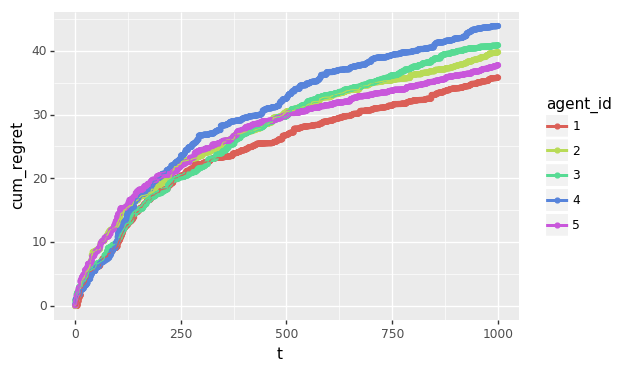

<ggplot: (8771103854989)>


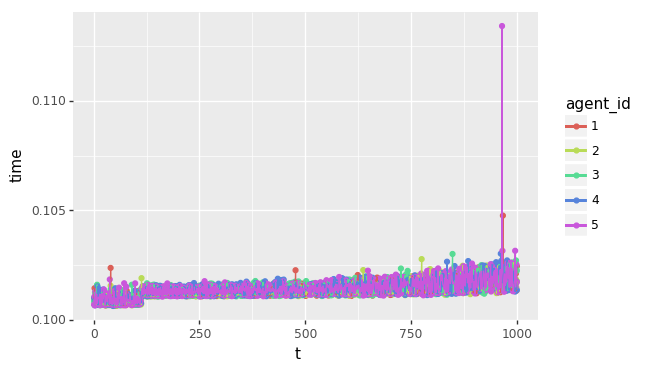

<ggplot: (8770993899245)>
theta [-0.41675785 -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
  0.50288142 -1.24528809 -1.05795222 -0.90900761  0.55145404  2.29220801
  0.04153939 -1.11792545  0.53905832 -0.5961597  -0.0191305   1.17500122
 -0.74787095  0.00902525 -0.87810789]
Experiment: Step 0
 Sample: array([-0.78033425,  0.4274361 , -1.48542751, -1.22410936, -0.53175433,
        0.41560897, -1.03307962,  0.37699961,  0.88135706,  0.09209913,
        1.62779492,  0.03468594, -0.26762945, -0.84945982,  1.40619936,
       -0.61240248, -0.04199305,  0.90076086,  1.30302864, -0.70115367,
        1.02575466])
 Steps taken: 2034
 Sample: array([-2.13975004,  0.41623204, -1.18497804, -0.66172452,  0.14418482,
        0.34660229, -0.39915328,  1.89486243, -0.81527762,  1.20875479,
       -1.45316118, -0.83041865, -0.89710612, -0.08819151, -1.90970541,
        0.79679615, -0.26722303, -0.93720346,  0.06638867,  1.40986397,
        1.42820057])
 Steps taken: 2031
 Sample: array([ 0

 Sample: array([ 2.25463693, -0.86853685, -1.14231011,  0.99694714, -0.97161844,
        0.38233338, -1.18552782,  0.70288187,  1.01069836,  0.83531945,
       -0.39928526, -0.91421271,  0.5635856 ,  0.92452819, -0.41753908,
       -0.51492373,  0.44971851, -1.42504292, -1.08890233, -1.12762955,
       -1.77530157])
 Steps taken: 1576
 Sample: array([ 0.80755875,  1.2255162 , -0.94179627, -0.73697513,  0.40785626,
        0.09475887,  0.81041752,  0.25061955,  1.54302277, -1.13100235,
        0.85117295,  0.71125137,  0.90199048, -0.50332488, -0.68714311,
        1.94398465,  0.05763953,  1.79213106,  1.13867856,  0.42314619,
        0.76665312])
 Steps taken: 1596
Experiment: Step 5
 Sample: array([ 1.20702638, -1.38194419,  0.08052696,  1.23721263, -1.73339239,
       -1.68446521, -0.35329189,  1.16884461, -1.29822143, -0.310885  ,
        0.37817149,  1.95548956,  1.14818305,  2.02163592, -0.17027166,
       -1.73234232,  1.31294284,  1.34540394,  0.65943158, -0.74620328,
        0.

 Sample: array([ 1.53883605, -0.40156398,  0.47691683, -0.19912652, -0.19071382,
       -0.25509412,  0.11392082,  0.62132164, -1.96689635, -1.14874913,
        0.7370199 , -0.96817962,  0.98746146, -2.08110266,  0.73874458,
        0.57209333, -0.72637445, -0.06128878,  0.67151977,  1.62700576,
       -1.48397781])
 Steps taken: 1531
Experiment: Step 10
 Sample: array([ 1.42742953, -0.21287188, -0.9117467 , -0.57929022, -0.87095607,
       -0.31980202, -0.23959726, -1.66126201,  1.16016405, -0.16422323,
       -1.71078079,  1.93447608, -0.75066058,  1.28841443,  0.27207354,
       -0.20882264, -0.45429258,  0.66699056,  0.7471368 ,  0.08920018,
        0.5768184 ])
 Steps taken: 1546
 Sample: array([ 0.22236556, -0.35337003,  0.6821995 , -1.11030228,  1.21498937,
       -0.3450259 , -0.22888627, -0.87410107,  0.24865509, -2.97426662,
       -0.05834037,  0.32153423, -0.52907098, -1.23661339,  0.50507528,
        1.96182425, -0.43231152, -0.77791622,  1.24252549,  0.21077719,
       -0

 Sample: array([ 0.64918532,  1.78171825,  0.79991232,  1.51429099,  0.78200866,
       -1.95154394,  0.79561056,  0.16158809,  0.57753091, -0.47211501,
        0.53955344,  1.77835049,  0.13941223, -1.57767052, -2.48816156,
        1.129524  , -0.3016227 , -1.6489292 , -0.57946114,  1.10653931,
       -0.96530774])
 Steps taken: 1497
 Sample: array([-0.12602973, -0.2474963 , -1.22265602,  1.71883353,  0.11271085,
        0.41429187, -0.46064642, -0.94023058,  0.57305679, -0.57159507,
        0.57453749,  0.07868212,  0.01294317, -0.55021445,  0.13089444,
        1.28517334,  0.34253919, -1.24597398,  0.2345737 , -0.09164662,
        0.56211173])
 Steps taken: 1499
 Sample: array([-0.40070467, -0.81943641, -0.09367435, -0.32645983,  0.84107985,
        0.78282585, -0.79540359, -0.97978543, -0.42299598, -0.81155224,
       -0.09336756,  1.07579221, -1.12544343, -1.21213121, -0.30959226,
       -0.88472488, -0.21980277, -0.39712724, -1.67912166, -0.60615475,
        0.25726967])
 Steps t

 Sample: array([ 0.54874245, -1.7937731 , -1.83805031, -1.82208597, -1.43178696,
       -1.22623082, -0.37816423,  0.54846324, -0.25211684, -0.55882214,
       -0.39186437,  0.24149989, -0.09629588, -0.91361409,  1.50833893,
        1.49771749, -0.11052492,  0.69278863,  0.61161631,  0.02600422,
       -1.51049498])
 Steps taken: 1486
 Sample: array([-1.77161162,  0.12824671, -0.50112803,  1.33260281,  0.09410111,
       -2.4228894 ,  1.58077806, -0.19628393, -0.26090156, -0.36671635,
       -0.37939221,  1.02631429,  1.58534164, -0.72605639, -1.85223086,
       -0.82371685,  0.09522793,  1.12502571, -0.07821409,  0.03868094,
        2.01267167])
 Steps taken: 1486
 Sample: array([-1.15042785,  0.45352973, -0.62900294,  0.89615315,  0.10303421,
        0.49953689, -0.51533841, -2.14203865, -0.14834523, -1.09161635,
       -0.01374708, -0.20723238,  1.2815261 ,  1.58187224,  0.03266615,
       -0.10895216, -0.45991898,  1.26091647,  0.24646191,  1.84685007,
       -2.98556186])
 Steps t

 Sample: array([ 0.55242533, -0.07036154,  0.61699087, -0.66185951, -0.13678587,
       -0.50888041,  0.99372694, -0.9272461 , -0.59619218, -1.61270184,
       -0.01306502,  1.04716897, -0.78051757, -1.36575895, -0.08286808,
       -1.04145144, -0.363634  ,  0.91829066, -0.86184906,  0.64315631,
        1.40253959])
 Steps taken: 1445
 Sample: array([-0.06723419, -1.0071779 , -1.26457996, -0.56921996, -0.72480145,
        0.26514434,  0.67939338, -2.05768416, -1.31922556, -2.11659199,
        0.12951762,  1.4092021 , -0.52535216, -1.42163299,  1.33110101,
       -0.88536163, -1.20312559, -0.34924438, -1.56874797,  0.44793444,
       -1.287856  ])
 Steps taken: 1439
 Sample: array([-1.34704095,  0.19613793,  0.46693855,  0.88769688,  1.34677264,
       -0.29878389,  1.50297547,  0.30470355,  0.12384659, -0.5340916 ,
        0.86374035,  1.58265531, -0.33529102, -1.75468425,  0.70737796,
       -0.51073678,  0.94869841,  1.77417808,  0.56262628, -0.15129313,
        0.09769043])
 Steps t

 Sample: array([-0.64944378,  0.48072379, -1.87225657, -0.60687063, -0.2126897 ,
        0.37697582, -0.30688653,  0.1746781 , -1.3000257 ,  0.48488804,
       -0.51349156,  1.58597742,  2.55573691, -1.2403312 , -0.23817242,
        0.97522493,  1.94468217,  1.24083333, -0.85073154, -0.20084143,
       -0.35946719])
 Steps taken: 1408
Experiment: Step 30
 Sample: array([ 0.40248356, -0.76158734,  0.604505  , -0.03092263,  0.34696789,
        0.86338602,  1.53990598,  0.67226479,  0.02574412, -0.27018049,
       -1.15317679,  2.29766973,  1.4602152 , -2.26869343,  1.12167097,
        0.69358585,  0.19275936, -0.3172059 ,  1.18918792,  1.05675358,
        0.12332369])
 Steps taken: 1423
 Sample: array([ 0.04154895, -1.71962082, -0.81421451,  0.42292659, -0.40042758,
       -0.87325639,  0.74110097, -1.35676832,  0.92243838,  0.43680911,
       -1.1830777 , -1.52091196, -0.07652558, -1.34033915,  0.31878058,
       -0.55884022,  1.99629995, -1.12061888,  0.74584937,  0.58829088,
       -2

 Sample: array([ 0.35378898, -0.24353536, -1.35399573, -0.45891327, -1.86800419,
       -1.33514784,  0.84851174, -1.09556488, -1.59276651, -0.67877293,
        0.51077705,  0.46379412, -0.50772028, -1.17083863, -0.06455895,
       -1.25374519,  0.85947649, -0.16044247, -1.52107226, -0.09378539,
        0.37813227])
 Steps taken: 1383
 Sample: array([ 0.15081533,  0.23783619, -0.3285946 ,  0.2549136 , -0.40069927,
       -1.52120292,  0.65188836, -0.28438513, -0.15519821, -1.9692029 ,
        0.97515315,  0.67199714,  1.90537539, -0.90211891,  1.5955479 ,
       -0.13117816, -0.80312786, -1.77796984, -1.24890653,  0.96309272,
       -0.54929229])
 Steps taken: 1391
 Sample: array([-0.29751582, -0.70243325, -0.39349711,  0.48599884, -0.29366733,
        1.27125236,  0.69278964,  1.28579394, -0.80559632,  0.59825022,
        0.76130095,  1.24332918, -0.35891477, -0.23527586,  1.27965863,
        0.66902636,  0.60506888,  0.87295742, -0.87899615,  1.68159138,
       -1.53403796])
 Steps t

 Sample: array([-0.24183343, -2.16360064,  0.3879479 ,  0.82704888, -1.52967157,
       -1.84669932,  0.54746591,  0.9616866 , -1.23192962, -0.47567029,
        0.06979539,  1.45720664,  0.64721347, -1.50823682,  1.32450143,
       -0.31202783, -1.14263759, -0.47044771, -1.54236789,  0.61792012,
       -2.02617893])
 Steps taken: 861
 Sample: array([-0.28234655, -0.71447819,  0.98751167,  0.73391942, -0.22933147,
       -1.8771106 , -0.00569612, -0.24112256, -1.30176964, -1.19395144,
        0.93715066,  1.03809656, -0.62685645,  0.45624958,  0.37682108,
       -0.10510995,  0.60439501,  0.63526564, -0.40948017,  0.94046207,
       -0.69929311])
 Steps taken: 1353
 Sample: array([ 0.03060968, -1.0151148 , -1.75416656,  1.89935451, -0.0979943 ,
        1.62615648, -0.03128436, -1.69076783, -0.44666689, -2.13575184,
        0.84198378,  1.62473204,  0.13916153, -0.3791173 , -0.43115005,
        0.81193589, -0.68417671,  1.18831439, -0.7708074 ,  0.57610917,
       -1.09749195])
 Steps ta

 Sample: array([-0.91731353,  2.21640945,  2.03640895,  0.84058399, -0.72915734,
        0.38587871,  0.9857796 , -0.43268871, -1.03728276, -1.49216256,
        1.45822885,  1.51480626, -0.14718772,  0.07036981,  0.26997746,
       -0.65308537,  1.49116196,  2.01708168, -0.92100082, -0.330492  ,
       -1.44436043])
 Steps taken: 1318
 Sample: array([-0.32639852, -1.60028426,  1.16617104, -0.20860532, -1.19322051,
       -0.4595279 ,  1.03450583, -2.20796675, -1.54393502, -0.86368668,
       -0.0378235 ,  1.28399227, -0.2791077 , -0.08348252, -0.62872375,
       -0.06803574, -0.65373848,  1.33339176,  0.00812834,  0.30302472,
       -0.66893245])
 Steps taken: 1323
 Sample: array([-0.56305322,  0.19669394, -1.60897457, -0.28810889, -0.14467031,
       -0.4760798 , -1.14025968, -1.42372668, -1.75123367, -0.89727272,
       -0.3239932 ,  1.90296468,  0.81117914, -0.96085663, -0.29113949,
        1.14043616,  0.46204912, -0.18642191,  1.50827321,  0.51539935,
       -2.05511415])
 Steps t

 Sample: array([ 0.07236923, -2.63906801, -0.43366294, -0.36210578, -1.387653  ,
       -1.17660678,  0.0517459 , -0.92891407, -1.43720634, -0.07944102,
        0.39883114,  1.15918629, -0.25416943, -0.45640427, -0.74252734,
       -1.11421641, -0.73166079, -0.3625135 ,  0.08567044,  0.75577842,
       -1.97185846])
 Steps taken: 1290
 Sample: array([-0.3467036 ,  1.02713035, -0.99313411,  1.80394485, -3.15490895,
       -0.40919523,  1.51822527, -0.54371905, -0.75806983, -0.68879572,
        0.48788344,  2.36189124, -0.41415347, -1.10947236,  0.50593319,
        1.30064023,  1.60108758,  0.45355673, -0.61992866,  2.04670403,
       -1.12761923])
 Steps taken: 1298
Experiment: Step 51
 Sample: array([ 1.34460010e+00, -4.49746345e-01,  1.71837811e-03,  1.03333954e+00,
       -7.55560687e-02, -5.17414180e-01,  2.55485577e+00,  3.45355973e-01,
        2.70276314e-01, -5.96159781e-01,  1.56727184e+00,  1.23089638e-01,
       -7.24346920e-01, -1.25670735e+00,  5.64037310e-01, -2.17476214e-0

 Sample: array([-0.6756198 ,  0.13679039,  1.16453162,  0.66629064, -0.26962774,
       -0.33381118,  1.8834962 , -0.428932  , -0.62561309, -1.18272239,
        0.92661775,  1.31741713,  0.67101368, -0.26332469,  0.0841637 ,
       -0.33581736,  0.61889799,  1.82956819,  0.55523281, -0.22019764,
        1.2650538 ])
 Steps taken: 1237
 Sample: array([-0.72988344, -0.21019201, -0.40330135,  0.70409398, -1.02347284,
        0.46908117,  0.22826861, -1.39761923, -1.58905131,  0.31478418,
        0.73163927,  0.93640009,  0.15847756, -0.29045163, -0.4650505 ,
       -0.12117276, -0.07725974, -0.40840815,  0.03018613,  0.277402  ,
       -1.01041996])
 Steps taken: 1262
 Sample: array([-1.03788   ,  0.58558112, -1.93687354,  0.81663883, -0.41414131,
       -1.25037487,  1.03875103, -1.25325273, -1.08508717, -1.10537201,
       -0.6350734 ,  1.97098367,  0.66532185, -1.83227282,  0.97475973,
       -0.30914944, -0.34395241,  1.04512567,  1.04513402, -0.08609143,
       -1.13838254])
 Steps t

 Sample: array([ 0.03189159, -0.82804606,  0.18944034,  1.21898075, -1.29470016,
       -0.91493793, -1.0655363 , -1.17572824, -0.8420467 ,  0.26340361,
        0.12576333,  0.96747271,  0.62414296, -1.01176885, -0.30214786,
        0.42836161, -0.30627884, -0.59514916, -0.37751525, -0.09443217,
       -1.3180709 ])
 Steps taken: 1212
 Sample: array([-0.50271971, -0.60915311, -0.14727983, -0.30702956,  0.83525183,
        0.67127518, -0.69491478, -0.54053393, -0.82103176, -0.57882759,
        1.3895854 ,  1.15224953,  0.02642008,  0.03458901,  3.38077179,
       -0.36524468, -0.28792284,  0.80662631, -0.39551709, -0.03053457,
        0.39815711])
 Steps taken: 1239
 Sample: array([ 0.45923756, -0.48530998, -0.10440747,  1.31122966, -2.02821897,
       -0.29513704,  0.55745008,  0.01561888, -2.14000321, -2.02548304,
        1.33001735,  2.92640512,  0.63302166, -1.34801393,  0.52024487,
        0.13441982, -0.10928165,  0.61155804,  0.27270866,  0.52511739,
       -0.57916372])
 Steps t

 Sample: array([ 0.13602533, -0.22654276, -0.80526509,  0.03049865, -1.59752685,
       -1.83428556,  0.31259037,  0.49738837, -0.3940693 , -0.79133411,
       -0.46548769,  0.0975075 ,  0.02210361, -0.46511695,  0.68186048,
        1.02705421,  0.48047172,  0.98450675, -0.41085007, -0.16690747,
       -1.03448153])
 Steps taken: 1181
 Sample: array([ 0.06913411, -0.53552839, -0.92533567,  1.25627944, -1.03482524,
       -1.78109192,  0.84750688, -1.77207991, -1.00778715, -0.69029096,
       -0.43480737,  1.2908933 , -0.36711116, -0.81266148,  1.54495036,
       -0.7254835 , -0.58542745,  0.56410661,  1.66936778, -0.39620137,
       -1.47538361])
 Steps taken: 1192
 Sample: array([-0.49862853, -0.78064551,  0.44820095,  0.39622487,  0.47407301,
       -0.0561456 ,  1.10624884, -0.23034814, -0.91430156, -0.72248925,
        0.34944309,  0.22999252, -0.56279772, -0.97287152,  0.11139863,
       -1.1522626 , -0.50078563,  0.85917054,  0.31961714, -0.15870745,
        0.30181784])
 Steps t

 Sample: array([ 0.54888802, -0.25365072, -0.56367151,  1.30053517, -1.13509988,
       -0.44939074,  0.4560783 , -0.91997995, -0.08965646, -0.64920671,
        1.24295513,  0.2503772 ,  1.07453166, -1.65879751, -0.34618103,
       -0.06940055, -0.47320186,  0.57507973,  0.93304869,  0.00951067,
       -0.10343727])
 Steps taken: 1158
 Sample: array([-0.84515006, -0.17925497, -0.21146903,  1.44923776, -2.12280815,
        0.04985907,  1.16241242, -2.15001419, -1.10023229, -0.815234  ,
        0.87749459,  0.14899872, -0.78758823, -2.55931024,  0.51604381,
       -0.2829995 ,  1.08190266,  1.43612629, -0.71068485, -0.39320263,
       -0.62826267])
 Steps taken: 1174
 Sample: array([-0.14862488, -1.44799361, -0.18542704,  0.48587651, -0.02177325,
        0.00792719,  0.64324796, -2.27290808, -1.85316327, -0.8181415 ,
       -0.19354793,  1.45133334, -1.28941546, -0.91028604, -0.56260927,
       -0.7589918 , -0.36050741,  0.95193088, -0.81503143, -0.78569897,
       -1.20092195])
 Steps t

 Sample: array([-5.80705671e-01, -3.12018666e-01, -5.69017107e-01,  2.09258725e-01,
       -1.86506811e+00,  1.35667939e-03,  1.38641829e-01, -3.51060492e-01,
       -2.64099848e+00, -1.11255190e+00, -1.24130298e+00,  1.23286388e+00,
       -1.96191901e-01, -1.73787163e-01,  2.01553957e+00,  7.86251412e-01,
        1.64542454e+00,  1.87380053e+00, -8.68206337e-01,  8.28324023e-01,
        4.22196444e-01])
 Steps taken: 1131
 Sample: array([-0.18717154, -0.42871626, -1.35761457,  1.07182626, -0.84598581,
        0.54785556, -0.0538519 ,  0.03308753, -0.95429556, -2.09733307,
       -1.35786171,  0.13493638, -1.81506245, -2.05171195, -0.31919543,
       -1.39115932,  0.33747755,  0.55141158, -1.01777874, -1.14777358,
       -1.83544617])
 Steps taken: 1129
 Sample: array([-0.44256492,  0.4061553 , -0.07085695,  0.05416067, -0.90405505,
       -0.84533329,  0.08237249, -0.2855402 , -0.56428757, -1.58421087,
        1.26159864,  1.36181307, -0.09073099, -0.38470934, -0.31879673,
        0.

 Sample: array([ 0.48783037, -0.69066625,  0.08865776,  1.34467416, -0.55323358,
        1.12527404, -1.91360574, -1.22916718, -1.46558896, -2.37438983,
        1.25737317,  0.40167501,  1.11897415, -0.86719011,  0.31541458,
        0.63640569, -0.31739562,  1.1993382 , -0.39105671, -0.65823029,
       -1.06506976])
 Steps taken: 1105
 Sample: array([-1.5675312 , -0.71715369, -0.87568594,  0.32792213, -2.93460374,
        0.16945172,  1.39540661,  0.0671888 ,  0.60965536, -0.07821609,
       -0.05107757,  0.32865447, -2.25171908, -1.26088547, -1.01760958,
       -0.47425395,  1.4357407 ,  1.9546978 , -0.7729597 ,  0.40463363,
       -1.05193276])
 Steps taken: 1121
 Sample: array([ 0.41863675,  1.39672488, -1.64828976,  0.55141981, -0.88623308,
       -0.12254102,  0.20308375, -0.62894243, -0.76392625, -1.5008371 ,
        0.0924296 ,  2.63789744, -0.45747109, -0.85909279,  0.63004556,
       -0.57557169,  0.15380432,  1.16499753, -0.4091662 , -0.50801917,
       -1.54328441])
 Steps t

 Sample: array([-0.41338125, -1.09724486, -0.13018246, -0.62800464, -0.69812074,
       -0.20091196, -0.21661268, -0.92767431, -0.88003658, -0.54763366,
        0.51392475,  0.071122  , -0.44159207, -1.96823723,  0.93068317,
       -0.48733174, -0.5142123 ,  0.47289688, -2.23073773,  0.027133  ,
       -1.77318355])
 Steps taken: 1065
 Sample: array([ 0.65310294,  0.30704266, -0.25653675,  0.2678329 , -1.11363463,
       -0.40773926,  0.81338035, -2.49211876, -0.47720312, -0.04461369,
        1.24883916,  0.83699546, -1.30607416, -0.89695392, -0.37668218,
        0.08367195,  0.58579931,  0.46647159, -0.49898177, -1.53154397,
       -1.17859488])
 Steps taken: 1082
 Sample: array([-0.51106272,  0.71853491, -1.92928273,  1.04585069,  0.43479243,
       -0.7300706 , -0.70985078, -1.01431294, -1.08839488, -0.88952933,
        0.28144663,  1.84361367, -0.21855317, -0.8285498 ,  0.48368171,
       -0.82082026, -0.37243423,  1.36913699,  0.04897576,  0.19691471,
       -1.67367997])
 Steps t

 Sample: array([ 1.12969207, -1.84085742, -0.27099951,  0.29851493, -1.58281727,
       -0.77667191, -2.67093511, -1.45028244, -0.56691926, -1.33116493,
        0.49910108,  0.66693495, -0.36110495, -0.74197015,  1.74897342,
       -1.72048411,  0.41434019, -0.09243703, -0.63622798,  1.79681506,
       -1.18098057])
 Steps taken: 1037
 Sample: array([-7.43392733e-01, -5.41595673e-01, -1.26518314e-01, -4.68136415e-01,
       -8.07003648e-01,  4.63447207e-02, -8.80754434e-01, -4.58981399e-01,
       -1.41690388e+00, -7.53543269e-01,  1.79435172e-03,  7.73377581e-01,
       -1.19106441e+00, -7.44242683e-01, -5.08844672e-01,  6.47161156e-01,
        1.44464267e-01,  5.49324417e-01,  3.30392448e-01,  6.30086987e-01,
       -2.02196088e+00])
 Steps taken: 1055
 Sample: array([-0.06485437, -0.71727464, -0.31222492,  2.35696845, -2.88794147,
        0.24360967,  1.0434297 , -0.87775598, -1.05450729, -2.60313084,
        0.53207777,  1.15082496, -1.45865418, -1.56406052, -0.63952876,
        0.

 Sample: array([ 0.2028844 , -0.20375711, -1.1840492 ,  0.58887319, -0.13671158,
       -1.42106874, -0.18466294, -1.73689643, -1.58564593, -1.73309826,
        0.27142269,  0.24012631, -1.89853245, -0.16668726,  0.0662669 ,
       -1.25209628,  0.78869152,  0.64693627, -0.38128119,  0.14124099,
        0.41045053])
 Steps taken: 1003
 Sample: array([ 0.15344486, -1.16650418, -0.49528162,  1.8266978 , -1.11527559,
       -0.02524867, -0.47757819, -2.16223621, -0.14246177, -1.37110363,
        0.64895256,  2.06303868,  0.31657316, -0.67342159,  1.38786352,
       -0.65320086,  0.07352593,  0.51491421,  0.33114268,  0.36561169,
       -1.12533289])
 Steps taken: 1009
 Sample: array([-0.87388493, -0.50557031, -0.25545966, -0.76860086, -1.51248159,
       -0.53907942,  0.66104959, -1.90062103, -1.0737007 , -1.29024979,
        0.85136876,  1.00018609, -0.80918537, -0.5681022 , -0.83435895,
       -1.38804133,  0.69883987,  1.73016299, -0.02361907, -0.79227456,
        0.66554843])
 Steps t

 Sample: array([-0.76975417, -0.06915414, -1.37051597,  1.76386527, -1.09176061,
       -0.69609989, -0.70613636, -1.48522203, -1.59368644, -1.55675426,
        0.96489599,  1.38305008, -0.10600256, -0.69794087, -0.10988998,
        0.08081586,  0.28708073,  0.79248436,  0.49660225, -0.08484553,
       -2.066105  ])
 Steps taken: 978
Experiment: Step 100
 Sample: array([ 0.73794661, -1.08219169, -0.34697134, -0.4355193 ,  0.41810092,
       -0.92701532, -0.34109392, -0.83678726,  0.20869708, -0.09993027,
        1.10715262,  0.50209172, -0.19582927, -0.27430462,  0.6199204 ,
       -0.60381409,  1.23060648,  1.61473258,  0.41595566, -0.82336315,
        0.15558695])
 Steps taken: 995
 Sample: array([ 0.21580443, -0.36553999, -1.39684087,  0.74652837, -2.23605334,
       -0.9530299 ,  0.16988483, -0.54922498, -0.71134732,  0.21862941,
        1.62331915,  2.50705991,  0.14231417, -2.14883755, -0.51054784,
       -0.63695715,  0.16110892,  1.27483819, -0.28926527, -0.51311311,
       -0.

 Sample: array([ 0.18582491, -0.42487139, -0.00329617,  1.25235418, -1.2879908 ,
       -0.47211931,  0.41600978, -0.45210388, -1.793944  , -0.94306232,
        0.96123281, -0.06946294, -0.95541886, -2.10956187,  0.30311688,
       -0.4090827 ,  0.60971145,  1.10476472, -1.17085621, -0.91165866,
       -1.08838764])
 Steps taken: 952
 Sample: array([-0.5503443 , -0.19916376, -1.46196346,  0.38089215, -0.62201931,
       -0.70720576, -0.2929634 , -0.86531394, -1.96056767, -1.31233225,
        0.16929035,  1.6994346 , -0.0314356 , -1.31939012, -0.68759035,
        0.44694089, -0.32648056,  0.56628075,  0.886077  ,  0.24386525,
       -0.22656973])
 Steps taken: 964
Experiment: Step 105
 Sample: array([ 0.32783292, -1.727696  , -1.27065465, -0.49211643, -0.89309879,
       -0.83764401,  1.07682721, -1.60234935, -0.78347303, -0.00220606,
        0.75013003, -0.13271256,  0.83124968,  0.50651635,  0.38815382,
       -1.26445566, -0.15396846,  0.08011603, -0.23004116, -0.22267514,
       -1.

 Sample: array([-0.5984388 , -0.15039456, -0.32249836, -0.2905138 , -0.98792485,
        0.02328544, -0.03221457, -0.35442557, -1.23260703, -0.74485369,
        2.22890732,  1.48691909, -0.6556021 , -0.61484877,  0.52021769,
       -1.20724451, -0.72307005,  0.46250225, -0.39881884, -0.41171393,
       -0.62092588])
 Steps taken: 926
 Sample: array([ 0.01266572, -0.88322187, -1.14290944,  2.5867052 , -1.99698513,
       -0.4179014 ,  0.76999497, -1.1382821 ,  0.11527979, -0.94821941,
       -0.30058358,  2.17876919, -1.18823376, -1.17121345, -0.74660815,
       -0.09553724,  0.95243318,  0.25404912,  0.4910023 , -0.38743289,
       -1.01083548])
 Steps taken: 935
 Sample: array([-0.49859208,  0.15314221, -1.07614686,  1.3159352 , -0.76759884,
       -1.2445875 , -0.09707298, -1.45215139, -2.00569165, -2.54273447,
       -0.55878184,  1.71735754, -0.88074652, -0.51500136,  0.24866183,
       -0.47123057, -0.00898578,  1.28714115,  0.1256622 ,  0.93548604,
       -0.78746421])
 Steps tak

 Sample: array([ 0.09864846, -0.1015946 , -1.0097425 ,  1.08830162, -1.1830349 ,
        0.55465404,  0.68373381, -1.06665997,  0.20591432, -0.89969155,
        0.81980049,  0.71584446, -0.06303809, -0.43420865, -0.38208812,
        0.33899222,  0.78603497,  1.45811647, -0.64279516, -1.77295002,
       -0.42308536])
 Steps taken: 640
 Sample: array([-0.5147393 , -0.45132253, -2.47795124,  0.19542605, -0.0590782 ,
       -0.29974654, -0.59577605, -1.88300025, -1.32756674, -1.68776546,
        0.54597061,  1.39974953, -0.13567883, -0.97167624, -0.6669316 ,
        0.86411466,  0.01286932,  0.82166792,  0.82736834, -0.46312225,
       -1.18053962])
 Steps taken: 658
Experiment: Step 115
 Sample: array([ 0.34390837, -0.97123315, -1.52954078,  0.68105397, -0.98896613,
       -0.03109845,  0.35387052, -1.77114268, -0.16785519, -0.38131986,
        0.95213134,  1.1143387 , -0.09605542,  0.21540065,  0.77464611,
       -0.14542586,  0.66752932,  0.73394246, -0.05242156,  0.3877773 ,
       -0.

 Sample: array([-0.29016361, -0.58455785, -1.82032217,  0.08821591, -0.09951683,
       -0.84353186, -0.09913057, -1.50808749, -1.8549859 , -2.08599127,
        0.03353643,  1.79385175, -0.99936859, -0.36739533, -0.11154759,
        0.68429769,  0.21145526,  0.68234064,  0.62344136, -1.01595342,
       -0.4075792 ])
 Steps taken: 632
Experiment: Step 120
 Sample: array([ 0.37601641, -0.87504578, -1.46933276,  0.03922331, -1.42200383,
       -1.67594685, -0.03837491, -2.10402807, -1.08697411,  0.35211822,
        0.20643633, -0.64415287,  0.02184875, -0.73041262, -0.99988908,
       -1.21203413, -0.04065874,  0.95973919, -0.12549991, -0.26727605,
       -0.79398719])
 Steps taken: 648
 Sample: array([-0.19975986, -0.7813276 , -1.26967538,  0.61274219, -1.76218845,
       -0.50774506, -0.64427132, -1.76624111, -0.25259633, -0.57543022,
        1.25323476,  1.75958286,  0.97650415, -0.2883531 , -1.06300306,
        0.22788041, -0.3460802 ,  1.01629032,  0.73437604, -0.40606827,
       -2.

 Sample: array([ 0.21972849, -0.27903934, -0.86390376,  1.62918168, -1.04129933,
        0.86555026,  0.55883928, -1.58327533, -0.21518147, -0.30248774,
        0.77446631,  0.81630952, -1.12208726, -1.90140485,  0.37573477,
       -0.39598154,  0.31786561,  1.04747642, -0.08239369, -1.16537642,
       -1.44245393])
 Steps taken: 626
 Sample: array([-0.56445455, -0.35166204, -1.53271154,  0.63709443, -1.99335027,
       -1.72938389,  0.58545257, -2.2218009 , -0.54288406, -0.84946757,
        0.92830496,  1.02454454, -0.88570025, -0.53436813, -0.81546279,
       -0.8583845 ,  0.60364821,  0.92920145,  0.89480512, -0.25474661,
       -0.52001507])
 Steps taken: 637
Experiment: Step 125
 Sample: array([ 0.34420209, -0.19663969, -1.21669057,  0.21686348, -0.15211566,
       -0.38989344,  0.61905197, -1.14718521,  0.0090968 ,  0.11258117,
        0.51945314,  0.49700002, -0.30025154, -0.17134647,  0.29737692,
       -0.28796303, -0.233413  , -0.07461587,  0.3104256 ,  0.21313257,
        0.

 Sample: array([-0.8218518 ,  0.06270209, -2.14114648,  1.36328982, -1.67057431,
       -1.53450777,  0.80510177, -2.16981899, -2.43537117, -1.46778566,
        0.35341157,  2.04722009, -1.12849   ,  0.45095639, -1.02583305,
       -0.42913412,  0.50741935,  0.80074189,  0.18925985, -1.78696838,
       -0.71218636])
 Steps taken: 608
Experiment: Step 130
 Sample: array([ 0.58792728, -0.37583539, -0.57548049,  0.04702118,  0.01071896,
       -0.22862614, -0.27059209, -2.00207089, -1.14063949, -0.09665332,
        0.32825638,  0.86461301, -1.31526015, -0.06350449, -0.70778164,
       -1.35816245,  0.30143644,  0.83978376,  0.14581515,  0.21052582,
       -0.12651065])
 Steps taken: 620
 Sample: array([ 0.59051883, -0.91242792, -1.26695679,  0.77944562, -2.25482645,
       -1.64258353, -0.20074217,  0.19872416, -0.29424991,  0.07327359,
        0.51040148,  1.85140182, -0.09696777, -0.97241977, -0.10198934,
       -0.56565023, -0.82313531,  0.42972647,  0.26010291,  0.17636085,
        0.

 Sample: array([ 0.24294749, -0.51306677, -0.16135982,  1.08584735, -0.34171773,
       -0.75510714,  0.22874736, -2.03714138, -0.87561873, -0.99745174,
        0.35056014,  1.08651676, -0.67911242, -0.55372888,  0.13910521,
       -0.69866881,  1.15973219,  1.21127343,  0.6615559 ,  0.1627235 ,
       -0.51175092])
 Steps taken: 593
 Sample: array([-0.09299129, -0.24999669, -1.23735921,  1.3717877 , -1.21502368,
       -1.03149831, -0.3810286 , -0.91531403,  0.04453993, -0.16294078,
       -0.28522928,  2.03363122, -0.15798542, -1.05230091,  1.41711414,
       -0.37193464, -1.03437854,  0.97348646,  0.02249254,  0.63106907,
       -0.19336809])
 Steps taken: 612
 Sample: array([-0.26106207,  0.21007308, -1.16846643, -0.04855521, -1.85678079,
        0.48098901,  0.52610697, -0.90594435, -1.60769683, -0.22443803,
        1.01218318,  1.16549276,  0.44199759, -1.21833617,  0.48073243,
       -0.51325345,  0.1842603 ,  0.1859252 , -1.49562645,  0.09367525,
       -0.73203738])
 Steps tak

 Sample: array([ 0.2884963 , -0.46750384, -0.74506637,  0.61915503, -0.95275546,
       -1.39052794,  0.08734622, -1.11649614,  0.45594448, -0.22235861,
        1.24246226,  2.35770543, -0.40451205, -0.33516944,  0.54325576,
       -0.97759648,  0.28381369,  1.22218545, -1.08481203,  0.30551805,
       -0.74874518])
 Steps taken: 596
 Sample: array([-0.32799528,  0.11306413, -1.36623801, -0.13272697, -0.9465865 ,
       -0.27706403,  0.42761028, -1.08672995, -0.9738296 , -1.55988916,
        0.31638606,  1.65147306, -1.09587798, -0.55924732,  0.27181684,
       -0.96631604,  0.57060228,  1.01393708, -0.72348808, -0.55355489,
       -1.0412066 ])
 Steps taken: 609
 Sample: array([ 0.32045335, -0.51679821, -1.47698049,  1.18530102, -0.25927628,
        0.10885849, -0.64612439, -0.96379747,  0.07416282, -0.28288501,
       -0.0152532 ,  1.85641929, -0.3337269 , -0.66920672, -0.24491202,
       -0.93827547, -0.4517087 ,  0.53411537, -0.55804791, -0.99390107,
       -0.78345437])
 Steps tak

 Sample: array([ 9.57232207e-01,  1.91808300e-04, -1.79744252e+00,  4.43022114e-01,
       -3.71560858e-01, -4.75785532e-01,  1.81696354e-01, -1.79504394e+00,
       -1.04245893e+00, -1.41930273e+00,  9.55912693e-01,  7.84664172e-01,
        7.87986638e-02,  2.87573989e-01,  4.04763522e-01,  5.86058004e-01,
        1.34431591e-01,  1.00004208e+00, -1.32613121e+00, -2.01363323e-03,
        1.76350005e-01])
 Steps taken: 579
 Sample: array([ 0.34734463, -0.91740174, -1.26020899,  1.8731063 , -1.02371262,
       -1.05198664, -1.18383279, -0.20385843,  0.47978938, -0.75280678,
        0.8116737 ,  3.644604  ,  0.06968799,  0.49357226,  0.45263797,
       -0.40451935, -0.62816289, -0.82994821,  0.03025756,  0.70544708,
       -0.41023101])
 Steps taken: 599
 Sample: array([-0.89578622,  0.08035655,  0.10655101,  0.65066777, -1.27008538,
       -0.31862765, -0.57121915, -1.30505077, -0.69183077, -1.23147181,
        1.04438928,  0.86959091,  0.31839672, -1.66182504,  0.18897158,
       -1.02

 Sample: array([-0.66759383, -0.21869123, -1.32234581,  1.50416217, -0.51663372,
       -0.55328768, -0.0884551 , -0.87482359, -1.2123214 , -0.24373246,
        0.97804326,  2.40504882,  0.08584635, -0.89257708,  0.47761708,
       -0.28554622,  0.38151086,  1.22176296, -0.05878519, -1.17513034,
       -1.11485233])
 Steps taken: 577
Experiment: Step 150
 Sample: array([ 0.11314471,  0.3452887 , -0.69725574,  0.75314102, -0.23423683,
       -1.40327474,  0.04521632, -1.10179408, -0.18530261, -0.40545972,
        0.60675758,  0.64315542, -0.39508207, -0.64106771,  0.32305349,
       -2.0842528 ,  0.15312063, -0.01927412,  0.82971716,  0.94942405,
       -0.0349351 ])
 Steps taken: 591
 Sample: array([ 0.28474342, -1.62700761, -1.88789896,  1.34846524, -0.89788793,
       -1.15747119, -0.11225082, -0.32481445, -0.65816623,  0.29190398,
        1.2356826 ,  2.21506656,  0.91120593,  1.15428066, -0.07413608,
        0.07650866,  0.59210766,  0.33797851,  0.52303252, -0.30473302,
       -0.

 Sample: array([ 0.24481979,  0.28894221, -0.79919458,  0.90316806, -1.54363315,
        0.58916082,  0.10009708, -0.99289188, -0.13235126, -0.93524277,
       -0.19439764,  0.90211427, -0.67844318, -0.36040619,  0.28458902,
       -0.90095132,  0.10415771,  1.21385979,  0.16424608,  0.66385522,
       -0.13817875])
 Steps taken: 571
 Sample: array([ 0.26568462, -1.07340067, -0.35294799,  0.79510041, -2.02990589,
       -1.04315939, -0.20344144, -1.59289308, -0.54997717, -0.79311971,
        1.68416847,  2.30380267,  0.46910806, -0.41719586,  0.6994645 ,
        0.1753027 , -0.29187755, -0.60071858, -0.40862459,  0.77809429,
        0.34930361])
 Steps taken: 583
 Sample: array([-0.55022839,  0.19133064, -0.50304316,  1.02570178, -0.93271371,
       -0.43580945,  0.12982415, -1.53120695, -1.1642002 , -0.10439962,
        0.39263856,  0.75068283,  0.33642715, -2.11268503,  0.17219159,
       -1.57333782,  0.45351862,  2.12304755, -0.61359598, -0.44004412,
       -1.53122432])
 Steps tak

 Sample: array([-0.21068498, -0.74647748, -1.28235324,  1.31124443, -2.33096789,
       -0.64252887, -0.06329089, -0.99664795, -2.59696048, -0.80982577,
        0.63005212,  2.54680728,  0.09171556, -0.48401563,  0.34920342,
       -0.72017062,  0.15945127,  0.94184722, -0.58305697,  1.07908464,
        0.22307793])
 Steps taken: 560
 Sample: array([-0.25296865,  0.48206178, -0.72630855,  1.99468025, -0.66880828,
       -0.2679381 ,  0.61433185, -1.4331375 , -0.56892054, -0.40326286,
        1.02284312,  1.22962267,  0.14251181, -1.25293001,  0.14029951,
       -0.60953997, -0.30096119,  0.41375267, -0.38756112, -0.60006804,
       -1.29285605])
 Steps taken: 572
 Sample: array([ 0.18920526,  0.68623607, -0.83999223,  0.95189254, -2.17929852,
       -0.47099817,  0.39664714, -1.6364472 ,  0.17585687, -0.62627727,
       -0.39317391,  1.30713233, -1.00239097, -1.22585756,  0.53992902,
       -0.422583  , -0.38520529,  1.94168785, -0.20791931,  0.00466226,
       -0.50262702])
 Steps tak

 Sample: array([ 0.03081971, -1.05568122, -1.30491178,  1.05701958, -1.48888021,
       -0.31450471,  1.31832833, -1.64204074, -0.6784717 , -0.26611019,
       -0.14912475,  1.28922843, -0.50078651,  0.14720106, -0.91618464,
       -0.74740675,  0.28966734,  1.07675001,  0.36975678, -0.44116195,
        0.14325579])
 Steps taken: 556
 Sample: array([ 0.02256603, -0.68556813, -1.36316418,  1.08761688, -1.95985785,
       -1.72387269, -0.81596543, -1.38995967,  0.43361137, -0.71545523,
        1.32066971,  1.74575061, -0.35944294,  0.44992943, -0.34505859,
        0.12462798,  0.20837135, -0.65315208, -0.27030397,  0.35743471,
       -1.25575066])
 Steps taken: 566
 Sample: array([-0.8107054 ,  0.1917093 , -0.79635752,  0.88173769, -2.25889462,
       -0.11724522,  0.15429811, -1.18415819, -0.35857084, -0.41026311,
        1.39700733,  1.11011599,  0.19117995, -2.47909632,  0.57042816,
       -1.16430564,  1.87480036,  2.45986917, -0.49400478, -0.596998  ,
       -2.045091  ])
 Steps tak

 Sample: array([-0.25533804, -1.38030477, -1.41202295,  1.6424528 , -1.83273104,
       -0.36385799, -0.29801658, -1.49515248, -1.11318709, -0.55466718,
        1.04450709,  1.85620295,  0.25904518, -0.72297454,  1.00142931,
       -0.02259779, -0.412748  ,  1.03835803, -0.233325  ,  1.16268471,
       -0.85359004])
 Steps taken: 546
 Sample: array([-0.31257958, -0.2857106 , -0.2699375 ,  0.43243267, -1.26926719,
       -0.95016244, -0.24657434, -1.38880123, -0.44414359, -1.19874445,
        0.25258706,  1.04801713,  1.35450298, -0.94107079,  0.46912107,
        0.25171993,  0.48245493,  0.86061755,  0.07209078,  0.17931411,
       -0.80542358])
 Steps taken: 558
 Sample: array([-0.18385406, -0.32744203, -1.14137006,  2.3364784 , -1.78412272,
       -0.52240329,  1.2421147 , -2.15023808, -0.44147674, -0.98712147,
        0.09062284,  1.89480808, -0.87641569, -0.86228896,  0.43235395,
       -0.66422667, -0.77966972,  1.38306103,  0.24986971, -1.0219453 ,
       -1.56744066])
 Steps tak

 Sample: array([-0.50379603, -0.04099068,  0.20937304,  0.47922948, -1.24615544,
       -0.08600139, -0.62925712, -2.23428217, -0.44693512, -1.00904377,
        2.04436005,  2.18900196,  0.36415438, -1.64519787,  0.69180375,
       -0.94922048, -0.20169785,  0.97803335, -0.51722577, -0.06832111,
       -1.41283392])
 Steps taken: 541
 Sample: array([ 0.18147843, -0.34924123, -0.31282277,  2.14505086, -0.94815498,
        0.29217625, -0.26541052, -1.03084797, -0.31106112,  0.69766215,
       -0.52672392,  1.95910204, -1.03240001, -0.46512129, -0.03531544,
        0.41359382,  0.18685891,  1.61264085, -1.36086618, -0.382647  ,
       -1.0676136 ])
 Steps taken: 554
 Sample: array([ 0.00404971, -0.44263114, -1.01528762,  1.28953563, -0.38947088,
       -0.52271558,  0.11604711, -0.32759119, -1.95393805, -0.767047  ,
        1.01948112,  1.3422758 , -1.25738899, -1.71405728, -0.05587494,
       -0.21363573,  0.49109359,  0.96925765,  0.09116022, -0.71309967,
       -1.40195044])
 Steps tak

 Sample: array([ 0.19052425, -0.08512457,  0.24163434,  1.57342994, -1.40481753,
        0.08235367,  0.87811404, -2.08541829, -0.25591603, -0.18606789,
       -0.09748488,  1.86165238, -0.15827563, -0.12785249,  0.49631075,
        0.76190873,  0.86528611,  0.39521451, -0.21755961, -0.55699553,
       -0.27121367])
 Steps taken: 538
 Sample: array([-0.91446231, -0.39867633, -2.67151377,  2.20220063, -0.81422535,
       -1.16206855,  0.43396313, -0.79083124, -1.84686833, -0.797302  ,
        0.43953132,  2.24645847, -1.51862657, -0.65691701, -0.22034663,
       -0.59489973,  0.65577276, -0.50664381,  0.8515596 , -0.81179696,
       -0.50516222])
 Steps taken: 549
Experiment: Step 181
 Sample: array([ 0.11305494,  0.1714629 , -0.24932916,  0.76192602, -1.64475552,
       -1.50010767, -0.08040793, -2.41754885, -0.52475722, -0.48682966,
       -0.03478041,  1.73385297, -0.68053481,  0.44633166, -0.04564885,
       -0.77505346,  0.67142963,  1.45449753, -0.53144982, -0.51140964,
        0.

 Sample: array([-0.50423785, -0.74716243, -0.99267435,  0.39458012, -1.84130386,
       -0.46558032,  0.21661819, -0.89593134, -1.26451972, -1.77488294,
        0.96800164,  2.07008299, -0.47156243, -0.37613969,  0.67258346,
       -1.08213226,  0.79603856,  0.35632573, -1.24869923, -0.45875673,
       -0.85707595])
 Steps taken: 533
 Sample: array([ 0.02416937,  0.52239813, -1.45821207,  1.25926159, -1.03987569,
       -0.191359  ,  0.57580833, -1.84140171, -0.22879346, -0.76057581,
        0.121848  ,  1.42351212, -0.84339012, -0.34051196,  0.18247331,
       -0.10319633, -0.68233906,  1.63216383, -0.15200044, -0.41175994,
       -1.81733077])
 Steps taken: 549
 Sample: array([-0.95944543, -0.12806079, -2.64012346,  1.45136705, -1.02749159,
       -0.81640906,  0.45448454, -2.03305788, -2.00873998, -1.47138004,
        0.49538955,  2.40957131, -0.64387759,  0.26215627, -0.31060036,
       -0.22781043, -0.24662033, -0.03705658,  0.72596502, -0.34461156,
       -1.21053074])
 Steps tak

 Sample: array([-0.03137034, -0.99759924, -1.8250013 ,  1.51806901, -1.83688219,
       -0.9918297 , -0.04083828, -0.35304642, -0.65127805,  0.00796658,
        1.69330578,  2.40757445,  0.73497223, -0.24333796,  1.14602638,
       -1.12894892,  0.47168161,  0.8063187 ,  0.67665441,  0.05073107,
       -0.75570236])
 Steps taken: 529
 Sample: array([-0.24058531, -0.4048609 , -0.28023444,  0.47352395, -1.25863453,
        0.45113216, -0.09557044, -2.12963397, -0.90127037, -1.43386684,
        0.99019541,  1.61729121, -0.87271037, -1.08070793,  0.95759736,
       -0.33409861,  1.55366442,  0.65129588, -1.38730183, -0.12389015,
       -1.65694582])
 Steps taken: 542
 Sample: array([-0.12542481, -0.29590288, -2.03436576,  1.46305937, -1.46926425,
       -0.00332304,  0.54600637, -2.28436448, -0.54016931, -0.70374707,
        0.71763336,  1.50033488, -1.84282358, -0.8008031 ,  0.46374856,
       -1.36204349, -0.21900497,  0.94796363, -1.03652166, -0.29368517,
       -1.33954102])
 Steps tak

 Sample: array([-0.26356493, -0.43021608, -0.74412252,  0.33506325, -0.3335959 ,
       -0.5209845 , -0.17360326, -0.47699823, -0.77647872, -0.81121401,
        0.58548951,  0.89912038, -0.47253488, -1.22060567,  0.86993293,
       -1.17908378,  0.2227602 ,  0.45616024, -1.52408658,  0.61222745,
       -1.37494847])
 Steps taken: 517
 Sample: array([-0.13453284, -0.28359016, -1.8446149 ,  0.61675284, -1.7994628 ,
        0.78098024, -0.06711154, -1.18963757, -1.06668011, -1.34599665,
        0.03598314,  2.16884829, -0.44521569, -0.87317698,  0.26840667,
       -0.28295649, -0.71562848, -0.43540276, -1.47874093, -0.87458612,
       -1.62045092])
 Steps taken: 529
 Sample: array([-0.62359439,  0.12506697, -2.41408881,  1.05156779, -0.625899  ,
       -0.40344322,  1.54926937, -2.17838322, -1.47853614, -1.61696662,
        0.72329251,  1.92693774, -0.73069462, -1.74462385, -0.27887668,
       -1.19010529, -0.11023486,  0.98587425, -0.65622114, -0.65139054,
       -1.03385467])
 Steps tak

 Sample: array([ 0.07669666, -0.22042046, -0.75020901,  1.82467714, -0.98183521,
       -0.43354337,  0.34901099, -1.20076132, -0.15835725, -1.04362325,
        0.08196054,  2.15740595, -0.7875533 , -0.26085787,  0.03841144,
       -0.24338323, -0.42696454,  1.41434888,  0.41757523, -0.53152136,
       -1.52371793])
 Steps taken: 508
 Sample: array([-0.28620504, -0.31033274, -0.88077592,  1.40802376, -0.74730669,
       -0.3969181 , -0.06803507, -0.57157223, -0.95533706, -1.49714834,
        0.58734554,  1.80895623, -0.53326065, -0.54451239, -0.21475885,
       -0.55889204,  0.49760701,  1.73065178, -0.54277766, -0.2933126 ,
       -1.18235533])
 Steps taken: 518
Experiment: Step 201
 Sample: array([ 0.12956581, -1.03051663, -0.74831702,  0.10613352, -0.64713495,
       -0.446061  ,  0.42472719, -2.00138951, -0.95026341,  0.14668357,
        0.67163467,  1.56562927, -0.30516985, -0.1452237 , -0.43312222,
       -0.35326126,  0.86673709,  0.50159095, -0.15907206,  0.30611038,
        0.

 Sample: array([-0.6969507 ,  0.17267528, -2.55217045,  1.53679072, -1.8137809 ,
       -1.21437386,  0.94409726, -0.04944485, -2.12065832, -1.03917308,
        0.30978584,  3.14417141,  0.41753421,  0.44563846, -0.86301316,
       -0.66408235, -0.41128529,  1.83211498, -0.28707364,  1.19853391,
       -0.82998896])
 Steps taken: 501
Experiment: Step 206
 Sample: array([ 0.11384721,  0.21459576, -1.37828945, -0.01078282, -1.75714326,
       -1.00391642,  0.39432786, -1.32646209, -1.21241543, -0.8916429 ,
        0.56597965,  2.12677439, -0.05498654, -0.2849462 ,  0.59187114,
       -0.59703824,  0.23658625,  0.69896929,  0.11212483, -0.14185814,
       -0.08807738])
 Steps taken: 512
 Sample: array([-0.5802563 , -0.5582035 , -1.96343582,  1.21847718, -1.37356627,
       -1.02766744, -0.12927141, -2.61958762, -0.06496629, -0.21146718,
        1.52255345,  2.62346755,  0.64260247, -0.41331668,  1.58312573,
       -0.61118033, -0.50113506,  0.93340483, -0.0234625 ,  1.2313315 ,
        0.

 Sample: array([-0.01178979, -0.84598074, -1.3820636 , -0.0172748 , -1.63064711,
       -1.3924192 ,  0.88769595, -2.23376157, -1.23779222, -0.70480602,
        0.69018577,  1.3620086 ,  0.27830965, -0.04868698,  0.07672181,
       -0.87768915,  0.12115018,  0.6267859 , -0.27109579,  0.13335286,
       -0.51228122])
 Steps taken: 492
 Sample: array([-0.43334494, -0.16387743, -1.98133469,  0.54789569, -1.78183967,
       -1.83746708, -0.69739588, -1.66163711, -0.0249933 , -1.08419113,
        1.51202409,  2.4810479 , -0.5648432 , -0.24500406,  1.49865856,
       -0.53460411,  0.82466857,  1.53398765,  0.76641311,  0.23248482,
       -1.16545965])
 Steps taken: 505
 Sample: array([-0.52882389, -0.28462843, -0.48856568,  0.6441995 , -0.65027646,
       -0.62991702, -0.61590841, -1.33208687, -1.19480122, -1.39192263,
        0.56124062,  1.77684361, -1.11626687, -0.41275694,  0.13062261,
       -1.02809216,  0.48265822,  0.20547353, -1.12192897, -0.00898142,
       -1.32643792])
 Steps tak

 Sample: array([-1.00342828,  0.15600831, -3.10130389,  1.95980535, -0.75773991,
       -0.64617435,  1.59377163, -0.71338079, -1.72255705, -1.38950096,
        0.44603031,  2.94827385, -0.88788577, -1.52190131, -0.21027025,
       -0.55724283,  0.11376623,  1.14871887,  1.40995953, -1.69827569,
       -0.51349632])
 Steps taken: 489
Experiment: Step 216
 Sample: array([ 0.20783409, -1.51427098, -0.86463889,  0.76165024, -1.15394349,
       -1.24348533,  1.20792796, -1.95866868, -0.56872508, -0.13204573,
       -0.05404592,  1.14048704, -0.22231561, -0.11257869, -0.15253816,
       -0.85607706,  0.26236047,  1.54405133, -0.08030004, -0.32899204,
       -0.76623557])
 Steps taken: 501
 Sample: array([-0.37066165, -0.84760597, -2.06321807,  1.45645685, -1.10863911,
       -0.60800965,  1.27547524, -0.93263687, -0.30701357,  0.09966609,
        1.95049626,  2.44421904, -0.01246109, -0.63820384,  0.51728732,
       -1.05997685, -0.37695731,  0.33403836,  0.05925249, -0.28696631,
       -0.

 Sample: array([ 0.17441789,  0.33775862, -1.39019864,  1.13095062, -0.65776507,
       -1.21066625,  0.24455426, -1.49713769, -0.66941461, -1.20678166,
        0.04679412,  2.06344513, -0.36466811, -0.83296921, -0.17102377,
       -0.03788925,  0.02751085,  1.13700338, -0.03461643, -0.60452865,
       -1.07555062])
 Steps taken: 483
 Sample: array([-0.20235998, -0.02826747, -1.7414433 ,  0.94572173, -0.57876644,
       -0.68166768,  0.94395067, -1.23531255, -1.39885596, -0.77334572,
       -0.30417307,  1.99163883, -0.54863142,  0.12874282, -0.58191176,
       -0.68277854, -0.16778061,  0.98301616,  0.40894932, -0.11140295,
       -0.6824555 ])
 Steps taken: 494
Experiment: Step 221
 Sample: array([ 0.1462861 , -0.36823041, -1.1051306 ,  0.59611957, -0.14584162,
       -0.55609959,  0.35743908, -1.19192088, -0.21904771, -0.74534862,
        0.63475268,  1.45733302,  0.12923682, -0.51114222, -0.14863143,
       -1.12453766,  0.36873741,  0.99189435,  0.38127338, -0.72425337,
       -0.

 Sample: array([-0.14065745, -0.0759573 , -2.44105621,  0.3538685 , -1.49142653,
       -0.68929709,  0.94670895, -0.99105038, -1.40791735, -0.62827519,
        0.67576462,  2.7476204 , -0.29593931,  0.17009237, -0.53520646,
       -0.23337578, -0.02373618,  1.19741123,  0.98284316,  0.23674638,
       -0.35968294])
 Steps taken: 477
Experiment: Step 226
 Sample: array([-0.21417793, -0.94612554, -1.08286098,  0.28529206, -1.1767524 ,
       -0.18647267,  0.93555309, -2.04865684, -1.63615784, -1.29466347,
       -0.24685657,  1.83381181, -0.8884765 ,  0.0460745 ,  0.34074824,
       -0.38878236,  0.41705103,  1.39352592,  0.14525433, -0.07245943,
       -0.1073258 ])
 Steps taken: 487
 Sample: array([ 0.19000071, -0.64322947, -1.23596017,  1.07070205, -1.60103059,
       -0.19038589,  0.47636367, -1.22308028, -0.31572859, -1.11844173,
        1.0476002 ,  2.2141383 ,  0.06284422,  1.23638918,  0.61261864,
       -0.87555859,  0.26881787,  1.25106389, -0.07641647,  0.07777179,
       -1.

 Sample: array([-0.02863565, -0.39000915, -0.72717805,  1.32689908, -1.01861419,
        0.03019667, -0.07945879, -1.67958568, -0.12632902, -0.46340578,
        0.2359454 ,  1.98412426, -1.48403804, -0.25036246, -0.4094677 ,
        0.16900393,  0.15343874,  1.74674892, -0.78671731, -0.70842413,
       -1.22817553])
 Steps taken: 471
 Sample: array([-0.75759414, -0.66944   , -2.46023327,  1.51742969, -1.04048685,
       -1.06463401,  1.11816342, -0.57490804, -1.58767086, -1.68370368,
        0.19118197,  2.63672886, -1.19180981, -0.45365978, -0.50755442,
       -0.41652629, -0.5188053 ,  0.33960366, -0.12568003, -1.00613969,
       -0.9285452 ])
 Steps taken: 483
Experiment: Step 231
 Sample: array([ 2.73596015e-03, -7.93154234e-01, -1.59526014e+00,  3.51817925e-01,
       -9.31993246e-01,  4.69002548e-01, -1.01407958e-01, -2.18864107e+00,
       -1.03555358e+00, -4.56210460e-01,  1.85728141e-03,  8.15073408e-01,
        2.14681406e-02, -6.15068954e-01, -5.23170612e-01, -2.89302098e-01

 Sample: array([-0.89431651,  0.44539583, -1.12470125,  0.88835668, -0.79034368,
       -0.58605145, -0.06398802, -2.32733233, -1.16777   , -1.34417009,
        1.51836814,  2.11507647, -0.65461026, -1.12491715,  0.19376697,
       -0.86595993,  0.39514281,  1.14354694, -0.89786523, -0.01059927,
       -1.15027432])
 Steps taken: 463
 Sample: array([-0.62319858, -0.15225104, -0.90480352,  2.13414289, -1.86725568,
       -1.11410233,  0.62904335, -1.67412421, -1.04931581, -1.25776352,
        0.81093126,  2.15331964, -1.15766374, -1.37102   , -0.37115538,
       -0.61071617, -0.09016548,  1.00693581, -0.35210776, -1.0257863 ,
       -1.08056133])
 Steps taken: 475
 Sample: array([-0.07160013, -0.66830683, -1.46624519,  0.86368762, -1.52932469,
       -0.46976317,  0.42507925, -1.04794225, -1.451762  , -0.04546809,
        0.04277897,  1.36085648, -0.81662566, -0.90673916, -0.98543024,
       -1.0766077 , -0.10512908,  0.02200607,  0.13553128, -0.59368724,
       -0.66019159])
 Steps tak

 Sample: array([ 0.46355067,  0.39945003, -0.80774739,  1.9410673 , -0.5323459 ,
       -0.58124161, -0.05021314, -1.18307531, -0.13505043, -0.11708776,
        0.87038183,  1.96027078,  0.2093734 , -0.8643287 ,  0.29312363,
        0.16315917,  0.10696994,  0.47899657, -0.69042773, -0.37312286,
       -0.22736402])
 Steps taken: 220
 Sample: array([-0.52878597, -0.36561599, -1.91411384,  1.10949599, -1.04586677,
       -0.22516212,  0.56329307, -1.55706084, -1.47318459, -0.75069031,
        0.89714568,  2.07538864, -0.65984014, -0.85593754, -0.60476664,
       -0.14733662, -0.17862875,  0.63396954, -0.26500936, -0.75273035,
       -0.26545425])
 Steps taken: 260
Experiment: Step 241
 Sample: array([ 0.01947344, -0.96171614, -1.24937378,  0.86539436, -1.08934223,
       -0.9053905 ,  0.56505894, -1.12359545, -1.10987592, -0.2752449 ,
        0.36853749,  1.41698246, -0.68429561,  0.01416708,  0.00889025,
       -0.73893817,  1.23692374,  0.27612715,  0.23666499, -0.34235755,
       -0.

 Sample: array([-0.90681209, -0.03090698, -0.61998514,  0.30281348, -0.50810214,
       -0.6985749 ,  0.08021892, -2.66150666, -0.45987688, -0.57172118,
        1.88504241,  1.73258663, -0.63937248, -0.86432015,  0.39684518,
       -1.20680485,  0.32939993,  1.48741074, -1.62984271, -0.46149285,
       -1.30134745])
 Steps taken: 450
 Sample: array([ 0.06319416, -0.01092539, -0.82026173,  0.07904916, -1.28248899,
       -0.49221138,  0.42714657, -1.1545257 , -1.18736393,  0.09456514,
        0.72309227,  1.85302096,  0.14032156, -0.69661316,  0.45488804,
       -0.68918837, -0.73517223,  1.18052143, -0.67571762, -0.67289214,
       -1.01830766])
 Steps taken: 461
 Sample: array([-0.76791656,  0.02373778, -2.65937174,  0.28949954, -1.29841146,
       -1.30263829,  0.85258002, -1.53421452, -1.47681273, -1.09051806,
        0.9654799 ,  2.30241323, -0.92223795, -0.1395685 , -0.80406659,
        0.19849089,  0.3128108 , -0.26703839, -0.10846285, -1.53666427,
       -1.66749526])
 Steps tak

 Sample: array([ 0.2288054 ,  0.95710123, -1.11115118,  0.39537774, -1.66723254,
       -0.99323272,  0.46838798, -2.12011525,  0.06899428, -0.73738217,
        0.30164388,  1.5161089 ,  0.03942959,  0.39770399,  0.37294132,
       -0.06279064, -0.03846302,  0.89123826, -0.32959466, -0.34079776,
       -0.78735699])
 Steps taken: 446
 Sample: array([-0.47437125, -0.02756831, -2.5814518 ,  1.07612246, -0.78964285,
       -0.46639896,  1.04704868, -1.29577723, -0.88766302, -0.88764199,
        0.39268201,  2.51399574, -0.60411314, -0.58040631, -0.4150968 ,
       -0.28500062,  0.38172233, -0.27423403,  0.42845251, -0.71092541,
       -1.34427202])
 Steps taken: 456
Experiment: Step 251
 Sample: array([ 0.15981802, -0.52594552, -1.68195038,  0.68823095, -1.89345701,
       -0.63490877,  0.3462206 , -2.06275173, -0.1386389 , -0.24625068,
        0.31390361,  1.38515219,  0.0567854 , -0.71605061, -0.40831701,
       -0.12746271,  0.77850055,  0.86071147,  0.12846947, -0.50189984,
        0.

 Sample: array([-0.35530912,  0.43766895, -2.34660764,  0.43823354, -0.81658129,
       -0.90133755,  0.89064899, -1.43050747, -2.03575093, -1.04556286,
        0.74039888,  1.67493533,  0.41937083, -0.59006147, -0.75444343,
       -0.59984836, -0.24686632,  0.58337723, -0.07292628, -0.32163089,
       -0.87277416])
 Steps taken: 434
Experiment: Step 256
 Sample: array([-0.04344956, -0.00856217, -0.64462269, -0.1088273 , -0.95046689,
       -0.44953888,  0.18731531, -1.53834843, -0.40257485, -0.57709318,
        0.78132128,  1.61000909,  0.26034132,  0.67338851, -0.90220144,
       -0.81417988,  0.36275272,  0.28942589,  0.53207454, -0.23005654,
       -0.11569659])
 Steps taken: 445
 Sample: array([-0.14219233, -0.65688846, -1.60576584,  0.9637513 , -0.98349951,
       -1.07949782,  0.43978306, -1.28926737, -0.14145087, -0.3427807 ,
        1.76952819,  2.01462086, -0.34221572, -1.00253236, -0.0082833 ,
        0.09083535, -1.54143251,  1.0160428 , -0.04251085, -0.06706874,
       -0.

 Sample: array([-0.05252793,  0.94244553, -0.68776737,  0.99337512, -1.71508866,
       -0.88266428,  0.96415701, -1.30724061, -0.6307363 , -1.30413826,
       -0.02526298,  2.73175096, -0.52986704, -0.51462013,  0.12042316,
        0.13641294,  0.14117878,  1.07378064, -0.1526196 , -0.38063741,
       -1.18441405])
 Steps taken: 429
 Sample: array([-0.75253837,  0.12999665, -2.67236206,  1.25671643, -1.47069619,
       -0.77261275,  0.44916531, -1.8437354 , -1.80852594, -0.60639827,
        1.11290485,  2.25341801, -0.41577428, -0.90177988, -1.49126275,
       -0.31901858, -0.27095756,  0.83580203, -0.54120556, -0.90402506,
       -1.06734752])
 Steps taken: 439
Experiment: Step 261
 Sample: array([-0.04458861, -0.20291617, -1.73846975,  0.71773512, -0.98973747,
       -0.37806022,  0.57051995, -1.5835927 , -1.67901717, -0.6254668 ,
        0.36224977,  1.90907594,  1.04544762, -0.70158615, -0.31525216,
       -0.68678201, -0.40381161, -0.0114072 , -0.0999501 ,  0.95879713,
       -0.

 Sample: array([-0.76425887,  0.15192152, -0.75512592,  0.8964591 , -1.59062512,
       -0.8548944 , -0.52934637, -1.80578129, -0.70903355, -1.39956389,
        1.79462036,  1.5405768 ,  0.3378827 , -0.98732756, -0.09556007,
       -1.3739754 , -0.32366949,  0.79514484, -1.51680424, -0.56342928,
       -1.66556762])
 Steps taken: 395
 Sample: array([-0.53778673, -0.45062131, -1.08315327,  1.02018542, -1.2392803 ,
       -0.51876012, -0.05267306, -1.94075467, -1.96852073, -0.89202973,
        0.73246398,  2.59062827, -0.43521244, -0.99143868,  0.4021093 ,
       -0.41300296,  0.48922053,  0.72056074, -0.20977249, -1.20215214,
       -0.58112079])
 Steps taken: 432
 Sample: array([-0.64061264, -0.36352176, -2.60912134, -0.03360003, -1.63107506,
       -0.72133663,  0.99266462, -2.46780229, -2.00599317, -1.03854472,
        0.30695832,  2.64662464, -0.85950207, -1.173196  , -0.60361747,
       -1.58855958, -0.73231054,  0.57392759,  0.50650639, -0.44317894,
       -0.53837463])
 Steps tak

 Sample: array([-0.54349331, -0.06628534, -1.84160759,  1.53159882, -1.90225419,
       -0.41411719, -0.21219548, -1.28578391, -1.34277521, -0.39831881,
        0.72208958,  2.24502128, -0.02045404, -1.06943959,  0.11234677,
        0.1918074 ,  0.34988538,  0.66032586,  0.20245514,  0.04941501,
       -0.18031877])
 Steps taken: 420
 Sample: array([-0.5066623 ,  0.0896212 , -0.7328586 ,  0.64275548, -1.47634306,
       -0.53324821,  0.42029381, -1.54650206, -0.34003586, -1.00531423,
        0.90022792,  1.97962908, -0.24068641, -0.29461546,  0.02727013,
       -0.50194008,  0.65893332,  1.29415381, -0.99704146, -0.81404771,
       -1.9961976 ])
 Steps taken: 430
 Sample: array([-0.33208237,  0.41033609, -1.66366917,  1.26722173, -1.61078138,
       -0.44411094,  0.68048133, -1.76621376, -1.53881397, -0.82952026,
        0.58449324,  1.693343  , -1.19120087, -1.74003677, -0.17772354,
        0.31696923,  0.41979549,  1.28623166, -0.62356334, -0.4613614 ,
       -1.4965968 ])
 Steps tak

 Sample: array([ 0.10070736, -0.28977503, -0.96180878,  0.74397647, -1.89990471,
       -0.44818351, -0.22027938, -1.54702475, -1.00774496, -0.39830817,
       -0.85888789,  1.02966102, -0.17643664, -0.75903057,  0.12502592,
       -0.83895862,  0.09156645,  0.19044461, -0.28379957,  1.01126614,
        0.05036805])
 Steps taken: 414
 Sample: array([-0.37317364,  0.72702718, -1.80229241,  1.15708008, -2.14684377,
       -1.3032168 ,  0.01697899, -1.0949238 ,  0.00553781,  0.09044385,
        0.97357208,  2.60616795, -1.02012965, -0.90921631, -0.35347422,
       -0.4079652 , -0.92222241,  1.25461572,  0.04509245, -0.54708318,
       -0.11068127])
 Steps taken: 425
 Sample: array([-0.71014238, -0.01102674, -0.44297127, -0.05751353, -1.14393849,
       -0.45658375, -0.3778075 , -2.25552954, -1.26487846, -1.24650584,
        1.26258898,  1.98775296,  0.09619751, -1.07160409,  0.17968447,
       -0.93910934,  0.27582306,  0.60858655, -1.30609299, -0.15957904,
       -1.39845626])
 Steps tak

 Sample: array([ 0.11871447,  0.07379848, -1.25045116,  0.9033437 , -0.90540394,
       -0.54707411,  0.93550846, -1.24424646, -0.03496716, -0.00354856,
        0.7016184 ,  1.9454427 , -0.4522642 , -1.24695942,  0.03197693,
       -0.91675422,  0.18930033,  1.27407953,  0.5567302 , -0.27363617,
       -0.05725747])
 Steps taken: 415
 Sample: array([-0.80334286,  0.52148915, -0.65174072,  0.11578917, -1.19783067,
       -0.75256957, -0.01909597, -2.03994768, -0.42033028, -1.35786072,
        0.88273179,  2.30686972,  0.23068739, -1.1267357 ,  1.03698476,
       -0.75475171, -0.32637752,  1.07318647, -1.29043027,  1.10090314,
       -1.59001846])
 Steps taken: 424
 Sample: array([-0.19818121, -0.16568405, -0.02745873,  1.05233651, -1.52037018,
       -0.46709126, -0.17031258, -1.77953146, -0.28716736, -0.23530471,
        0.45018697,  1.31148364, -1.33730159, -1.09507055, -0.5950374 ,
       -0.70110523,  0.37018342,  1.79313339, -0.96162268, -0.54121417,
       -1.61517019])
 Steps tak

 Sample: array([-0.24484683, -0.0810584 , -0.77455685,  0.02473065, -1.85769011,
       -0.48827138, -0.1056482 , -1.35746349, -0.23976186, -0.55440716,
        1.26995548,  1.00512681,  0.19982195, -0.40457987,  0.13793571,
       -0.80808548, -0.11687525,  0.51917532, -0.61032607, -0.14277542,
       -1.03079796])
 Steps taken: 409
 Sample: array([-0.20743912, -0.00171854, -1.24015279,  0.59024016, -1.04548829,
       -0.57078704,  0.0517108 , -1.48423814, -0.82890727, -0.81626383,
        0.79573563,  1.3255734 , -0.9075651 , -1.28707851,  0.32849411,
       -0.4169328 ,  0.06165145,  1.40743521, -0.72432217, -0.7977309 ,
       -0.61827205])
 Steps taken: 419
 Sample: array([-0.47585319,  0.97144509, -2.19869999,  1.44626766, -1.11236358,
       -1.35194052,  0.71736883, -1.82702447, -1.77921007, -0.91385711,
        0.3967456 ,  1.16327096,  0.07699852, -1.24734492,  0.48057302,
       -0.34882958,  0.16633603,  1.11568192,  0.21661028, -0.0244381 ,
       -0.80244161])
 Steps tak

 Sample: array([-0.17136814, -0.48159305, -1.71443071,  2.09446362, -1.90271134,
       -0.28830309,  0.04058971, -0.50127404, -0.19550897, -0.14086367,
        0.15726733,  2.84758453, -0.13532444, -0.04067332,  0.82867159,
       -0.87500493,  0.66379764,  1.15220237,  0.00431489,  0.24293601,
       -0.59263102])
 Steps taken: 404
 Sample: array([-0.29154195,  0.22137466, -1.2480254 ,  0.54546837, -0.84283301,
        0.20629476,  0.0092625 , -2.16785406, -0.84409741, -1.60435448,
        0.81857138,  1.40944531, -0.52006083, -0.50429283,  0.0288833 ,
       -1.0634304 ,  0.76720734,  1.46861133, -1.03905401, -0.07797309,
       -1.30742976])
 Steps taken: 412
 Sample: array([-0.17839038,  0.26935603, -0.40491151,  1.91816646, -1.19463792,
       -0.33339588, -0.0979733 , -1.0778666 , -0.4684311 , -0.60494735,
        0.52899897,  2.52628047, -0.61213654, -1.35928565,  0.1078205 ,
       -1.09710824,  0.40711397,  0.59129307,  0.01387403, -0.75818438,
       -0.67825831])
 Steps tak

 Sample: array([-0.48676193, -0.20612927, -0.5388716 ,  0.64089548, -0.3359906 ,
       -0.23000027,  0.27084227, -1.44554825, -0.78434573, -0.56849457,
        1.04108361,  1.65938273,  0.06944231, -1.74862872,  0.40359197,
       -0.62218262,  0.27889898,  1.38822566, -1.05107135, -0.54614679,
       -1.48257614])
 Steps taken: 393
 Sample: array([-0.24942395, -0.2969337 , -0.8777376 ,  1.64242069, -1.64838877,
       -0.57559339, -0.22374899, -1.53328705, -0.52909427, -0.8543374 ,
        0.15404937,  2.02463073, -0.0227573 , -1.43015903,  0.41200155,
       -0.78681683,  0.05174952,  1.40632465,  0.63250556, -0.84013845,
       -1.1371985 ])
 Steps taken: 406
 Sample: array([-0.47292242,  0.68208934, -2.28539665,  0.37009733, -1.31595927,
       -0.90254114, -0.25748693, -1.49265791, -1.50846484, -0.77143337,
       -0.4698767 ,  1.74625904, -0.0776773 , -0.87484586, -0.08955815,
        0.09223652,  0.4828493 ,  0.99283627, -0.24255804, -0.0208074 ,
       -0.54856611])
 Steps tak

 Sample: array([ 0.27817877,  0.46190733, -1.45626431,  1.23434339,  0.38339307,
       -0.54987967, -0.35420403, -1.41159432,  0.26335577, -0.22479227,
        0.2435826 ,  2.41174612,  0.23600746, -0.38606605,  0.8790671 ,
        0.28837578, -0.22023604,  1.37179043,  0.36579453,  0.41987048,
       -0.4813806 ])
 Steps taken: 390
 Sample: array([-0.27719314,  0.29016778, -0.73597374,  0.36599204, -0.44532206,
       -0.65313598, -0.1687495 , -2.30388509, -0.16147089, -1.80045896,
        0.15593072,  1.37854887, -0.35638485, -0.40607211, -0.12011402,
       -0.72778748,  0.75519615,  1.62845263, -1.49092267,  0.8423317 ,
       -0.99456914])
 Steps taken: 405
 Sample: array([-0.33865147, -0.63865547, -0.76253052,  2.01857192, -1.42384062,
       -0.17594309,  0.74689995, -1.44848276, -0.76254143, -1.32620961,
       -0.55348445,  1.91437027, -0.53653809, -0.83892943,  0.36275753,
       -0.80620273,  0.38256493,  1.02407707, -0.05944114, -0.58329819,
       -0.92417591])
 Steps tak

 Sample: array([-0.5460716 ,  0.51135356, -0.94706531,  0.03310021, -0.57858673,
       -0.41241825,  0.41231513, -1.7055001 , -0.31005859, -1.07435964,
        0.9505027 ,  0.77002263, -0.31031381, -0.63640964,  0.25852495,
       -0.86858033,  0.28498643,  0.93910279, -1.46325924, -0.30946694,
       -1.2723172 ])
 Steps taken: 387
 Sample: array([-0.17923465,  0.72093124, -0.41112961,  1.8393823 , -1.68557173,
       -0.52096425,  0.33761884, -1.59308809, -0.52746849, -0.7441016 ,
       -0.48910341,  1.8769592 , -1.3098114 , -0.97943837,  0.30751591,
       -0.87147189, -0.36578204,  0.60393427, -0.42147176, -0.66880502,
       -0.71736587])
 Steps taken: 396
 Sample: array([-0.66133156,  0.02256707, -3.1732206 ,  1.00507453, -1.03474075,
       -0.89274772,  0.13760146, -0.45769069, -1.51096394, -0.87418698,
       -0.17695248,  2.13227045, -0.2964575 , -1.25826893, -0.84103657,
       -0.53112795, -0.18489794,  1.51913702, -0.00769629, -0.0545427 ,
       -0.84071153])
 Steps tak

 Sample: array([ 0.03722368,  0.03527782, -1.40412094,  1.88693821, -1.13520255,
        0.161823  , -0.26255847, -1.34365124,  0.23104299, -0.51716541,
        0.69547046,  1.42994663, -0.76703116, -0.64314456,  0.52786292,
       -0.53446348,  0.00446483,  0.94192719, -0.23781109, -0.37719754,
       -0.94212538])
 Steps taken: 384
 Sample: array([-0.4992711 ,  0.27264423, -0.25906738,  1.02902442, -1.1467267 ,
       -0.25543086,  0.53787858, -1.8357811 , -0.59103391, -1.31665961,
        0.49275009,  0.64906776, -0.46952249, -0.76067854,  0.1241125 ,
       -0.29641257,  0.21367885,  0.6123843 , -1.35672856, -0.40365782,
       -0.46726   ])
 Steps taken: 392
 Sample: array([-0.24335382, -0.19513683, -1.47159519,  1.37728833, -1.37794227,
       -0.94044704,  0.08978232, -1.76338249, -1.20369129,  0.09242393,
        0.47893159,  1.92877632, -0.77804815, -1.87477095,  0.3092767 ,
       -0.65746763, -0.47558861,  0.61195163,  0.12512886, -0.10178485,
       -1.120398  ])
 Steps tak

 Sample: array([-0.54394304,  0.59373141, -1.27386257,  1.04762642, -1.34774795,
       -0.33974841,  0.81014157, -2.04075181, -0.36960038, -0.98870505,
        2.17262881,  1.64275549,  0.23541867, -0.63066916,  0.20141512,
       -0.66063395,  0.00433174,  1.08544662, -0.73599754, -0.68558599,
       -1.03905658])
 Steps taken: 381
 Sample: array([ 0.03532966, -0.88818481, -1.56807636,  1.73285344, -1.16307827,
       -0.3093513 , -0.06296604, -1.19478209, -0.88470816, -0.42076668,
        0.43006607,  1.29587781, -1.00743959, -0.85882363,  0.57349243,
       -0.17097158,  0.24022521,  1.01485282,  0.08051526, -0.42618885,
       -1.2612896 ])
 Steps taken: 384
 Sample: array([-0.39622007,  0.52964887, -2.28968757,  0.48662261, -1.15687634,
       -0.95650876, -0.02500891, -1.4837364 , -2.54778364, -0.6236192 ,
        0.51142372,  1.22435285, -0.4320408 , -0.82599592, -0.52830872,
       -0.18567176, -0.33758339,  0.93653104, -0.76695763,  0.29918054,
       -1.47008873])
 Steps tak

 Sample: array([-0.23788701, -0.31994591, -0.87655028,  0.6718246 , -1.25939097,
       -0.82053195, -0.23762903, -1.55866169, -0.17719138, -0.38001095,
        1.16750148,  1.81702354, -0.37822151, -0.29519193,  0.32048629,
        0.11180714,  0.21389847,  1.08395059,  0.72659587,  0.35574064,
       -1.16982437])
 Steps taken: 374
 Sample: array([-0.15052245, -0.05397564, -0.46172097, -0.25722437, -0.59526931,
       -0.11238677,  0.37212155, -1.69419236, -0.62514922, -0.55801416,
        1.65165425,  0.53602437,  0.23233304, -0.45624677, -0.44425015,
       -0.80639807,  0.26746897,  0.74347123, -1.01322719, -0.74145469,
       -1.3544326 ])
 Steps taken: 383
 Sample: array([-0.12410948, -0.61487268, -1.88132562,  1.55064881, -1.23840231,
       -0.3788595 ,  0.49488285, -1.30422925, -1.22397314, -0.22726543,
        0.17200009,  2.50867518, -0.92026348, -1.67688915, -0.39633148,
       -0.23772502,  0.42591829,  1.3986415 ,  0.80682948, -0.59305517,
       -0.84923018])
 Steps tak

 Sample: array([ 0.29507673, -0.24570976, -1.26917089,  0.60803069, -0.76996507,
       -0.55735682, -0.30322444, -1.43398924, -1.37929314, -1.18538686,
        0.06024898,  1.22106002,  0.61102051, -1.34717767,  0.93246515,
       -0.64655383,  0.50224155,  1.0871675 , -0.31021561,  0.73147509,
       -0.88904122])
 Steps taken: 368
 Sample: array([ 0.06627891, -0.05976045, -1.26134688,  0.76042437, -0.61413479,
       -0.55524374, -0.29551364, -0.88872127, -0.9028457 ,  0.11415942,
        1.03503484,  1.51491972,  0.13199727, -0.63107225,  1.09727774,
       -0.62766735, -0.57337845,  1.57468269,  0.1569305 ,  0.22432728,
       -1.28924923])
 Steps taken: 376
 Sample: array([-0.82677044,  0.45627556, -0.61766482,  0.35156497, -1.533046  ,
       -0.24623808, -0.42397074, -2.3705074 , -0.60876628, -1.07299363,
        1.31265617,  2.21270595, -0.2474739 , -0.80293399,  0.37268897,
       -0.87519321, -0.10261091,  0.78098793, -0.9554644 , -0.20330796,
       -1.70290747])
 Steps tak

 Sample: array([-0.12534478, -0.78322165, -1.82393232,  1.16283722, -0.60706458,
       -0.61664023,  0.19872856, -0.81937254, -0.50056417, -0.3546435 ,
        0.91303975,  1.81440215, -0.1931354 , -0.63380816,  1.12328024,
       -0.6031753 ,  0.14396487,  1.75747056,  0.56096011,  0.81816995,
       -0.94042167])
 Steps taken: 365
 Sample: array([-0.50897393, -0.19447538, -0.66593825,  1.04552944, -1.48037388,
       -0.64302917,  0.11257439, -1.58855358, -0.77311162, -0.38237912,
        1.17032819,  1.80466613, -0.23690195, -1.02807522,  0.41212629,
       -0.28151192,  0.25156482,  1.1097381 , -0.06018207, -0.50594172,
       -2.29429756])
 Steps taken: 372
 Sample: array([-0.27054298,  0.18693262, -2.0555035 ,  0.88531214, -1.03295893,
       -0.38941588,  0.93287539, -1.41828377, -0.5657743 , -0.57604595,
       -0.13428418,  2.53404808, -1.39502999, -0.92064457,  0.00776595,
       -0.38933279, -0.17636362,  1.49637036, -0.24955931,  0.0158521 ,
       -1.13844721])
 Steps tak

 Sample: array([ 0.26430622,  0.25034493, -1.93501817,  0.38118393, -1.03428988,
       -0.6539322 ,  0.38799124, -1.58971421, -0.60616956, -0.33318649,
        0.38535629,  1.1864536 , -0.58724199, -0.86501537, -0.18671649,
       -0.49365129,  0.07103169,  0.56175913,  0.6719032 ,  0.89569311,
       -0.96860233])
 Steps taken: 351
 Sample: array([ 0.54149666,  0.45763627, -1.13547983,  0.95492038, -0.58094844,
       -0.83703887, -0.10303473, -0.62876083, -0.56064582, -0.80831082,
        1.04919955,  1.31219315,  0.152062  ,  0.00434385,  0.14054156,
        0.24000339,  0.2524118 ,  0.9494359 ,  0.86559868,  0.77429768,
       -0.94521406])
 Steps taken: 362
 Sample: array([-0.45897319,  0.09771457, -1.04444897,  0.46538622, -0.45876473,
       -0.81091891,  0.20447476, -2.22454532, -1.47721047, -0.64800778,
        0.74682356,  1.51823365, -0.23164204, -1.01665606,  0.06768793,
       -0.22358048, -0.45792478,  1.90227454, -0.87877244, -0.4069571 ,
       -1.0833857 ])
 Steps tak

 Sample: array([ 0.0300216 ,  0.16356236, -1.50680213,  1.81497373, -0.75246626,
       -0.78408195, -0.02648356, -0.4714072 , -0.20180224, -0.47904174,
        0.08529363,  2.62509813,  0.32696817, -1.72467647, -0.00604248,
       -0.0343881 , -0.86865405,  1.28303314,  0.50561022,  0.29237248,
       -0.6974226 ])
 Steps taken: 350
 Sample: array([-0.3640685 , -0.24217408, -1.0304565 ,  0.47347762, -0.36613294,
       -0.42707425,  0.02996524, -1.99393853, -0.05795841, -1.44910169,
        1.11475024,  0.99853955, -0.04035229, -0.69554741,  0.61195615,
       -0.62535339,  0.20887329,  1.08919847, -1.21770106,  0.2802963 ,
       -1.18569424])
 Steps taken: 358
 Sample: array([-0.36363487, -0.2474315 , -1.49181012,  1.45146359, -1.17251989,
       -0.18140443,  0.34597311, -1.04349838, -0.9200008 , -1.28705925,
        1.05982337,  2.40694069, -1.17985234, -1.10642499, -0.32335449,
       -0.39036354,  0.37029606,  1.05082053,  0.11078627, -0.06770052,
       -1.41882172])
 Steps tak

 Sample: array([ 0.15914989,  0.32121555, -1.34788951,  0.82568085, -1.35618579,
       -0.1108838 ,  0.20254839, -0.90453808, -0.72888061, -1.46416193,
       -0.32944685,  1.26268588,  0.286813  , -0.68881   ,  0.57911759,
       -0.90380311,  0.19484112,  1.68753722, -0.24392222,  1.25004983,
       -0.60271445])
 Steps taken: 346
 Sample: array([ 0.13687676,  0.63366493, -0.6490978 ,  0.81506531, -0.8914577 ,
       -0.85808902, -0.42503158, -1.07097279, -0.99189958, -0.66098448,
        0.39266831,  2.09808984, -1.05575329, -0.96265157,  0.4297044 ,
       -0.2265973 ,  0.20095728,  0.84663772,  0.22436204, -0.50410231,
       -0.92987736])
 Steps taken: 352
 Sample: array([-0.90299215,  0.34683776, -1.0300091 ,  0.96226568, -1.16540756,
       -0.64324565,  0.25066019, -1.9257208 , -1.14823915, -1.19434042,
        1.28042889,  1.32526178, -0.37531696, -1.10113356,  0.10067664,
       -1.33292218,  0.11661828,  1.21594858, -0.42606439, -1.14497671,
       -1.61391286])
 Steps tak

 Sample: array([ 0.26482239, -0.03187167, -1.17059358,  0.24663147, -0.49731834,
       -0.05357089, -0.32372305, -1.07314719, -0.94302522, -0.39599914,
        0.83643131,  1.73411202, -0.12849566, -0.79774844,  0.70238978,
       -0.55614987, -0.33640345,  1.01307529, -0.02205821,  0.27016811,
       -0.96750297])
 Steps taken: 339
 Sample: array([-0.722313  ,  0.00807567, -1.24044731,  1.32397209, -1.15654418,
       -1.48640258,  0.37263469, -1.07195883, -0.90793526, -0.76949733,
        0.88592297,  2.12190809,  0.4985877 , -1.11418727,  0.68392068,
       -1.23665366,  0.29867297,  0.74041098, -0.90708366, -0.15345586,
       -1.0501176 ])
 Steps taken: 345
 Sample: array([-0.26428258, -0.1656001 , -1.70467053,  1.40786136, -1.25883229,
       -0.48287215, -0.35141123, -1.3554856 , -1.18520856, -0.3421319 ,
        0.61107383,  2.90032992, -0.92042977, -1.00086759,  0.25332794,
       -0.59422056, -0.15502712,  0.90485551, -1.11979849, -0.14552879,
       -1.39762727])
 Steps tak

 Sample: array([ 0.09242524, -0.33409641, -1.20718657,  0.32343919, -1.45778372,
        0.3536464 ,  0.17165448, -1.45651026, -0.750558  , -0.39879131,
        0.2016059 ,  1.2437097 , -0.18075403, -1.08886264, -0.48582834,
       -0.26926463,  0.75727217,  0.20499674,  0.13802975,  0.13719107,
       -0.7340663 ])
 Steps taken: 331
 Sample: array([-0.20064739,  0.1207045 , -0.76179791,  1.38374641, -1.01844136,
       -0.96953372, -0.15385871, -1.63096718, -0.14319408, -0.42771395,
        0.84936783,  1.95626585, -0.03865207, -1.06998255,  0.40819488,
       -0.57611765, -0.07083611,  0.42863833,  0.63284782,  0.32226457,
       -1.57811709])
 Steps taken: 341
 Sample: array([-0.67322737, -0.24873796, -1.01206045,  0.23711119, -0.69701747,
       -0.47646135,  0.64805482, -1.67205744, -0.54420643, -1.22534122,
        0.40454784,  1.40941024, -0.32619341, -1.10762958, -0.09217557,
       -1.14648222, -0.0028637 ,  1.26425345, -1.27408862,  0.0834821 ,
       -1.38060548])
 Steps tak

 Sample: array([ 0.23214064,  0.30046123, -1.22476234,  1.45192208, -1.41785866,
       -0.63243105,  0.06215835, -0.76706087, -0.12054628, -0.69893211,
       -0.09701296,  2.27679826,  0.51718034, -1.40561279,  1.64959019,
       -0.81148861, -0.39876823,  0.54536339,  0.71415609,  0.18510604,
       -1.23522177])
 Steps taken: 324
 Sample: array([-0.74132777,  0.47780635, -0.89680733,  0.59606667, -0.99932653,
       -0.06851753,  0.98650276, -1.87145874, -1.51715601, -1.25010147,
        1.10379376,  2.28558093, -0.18587472, -1.38563639,  0.82426399,
       -0.71625573,  0.14229086,  1.20896193, -0.70543806, -0.46272727,
       -1.43872153])
 Steps taken: 332
 Sample: array([-0.14279574, -0.43162143, -1.44091747,  2.0881012 , -1.3001091 ,
       -0.77809212,  0.2901571 , -1.00295209, -0.60011448, -0.77963219,
       -0.0605027 ,  1.79622038, -0.77179722, -1.46176934, -0.23142379,
        0.36468508,  0.25004183, -0.04954329, -0.56742871, -0.96642526,
       -1.31792226])
 Steps tak

 Sample: array([-0.5996125 , -0.0615573 , -1.70087526,  0.87860363, -1.0033443 ,
       -0.57687929,  0.33774678, -1.79201362, -0.86186744, -1.25257014,
        0.93159077,  1.54649897, -0.24992003, -1.37938919,  0.67528486,
       -1.267199  , -0.09609031,  1.26981336, -0.67686233, -0.00468879,
       -1.15914189])
 Steps taken: 327
 Sample: array([-0.05071669, -0.19526528, -1.62743063,  1.60019199, -0.62003107,
       -1.43758284,  0.49578869, -1.33578504, -0.74389416, -0.23499563,
       -0.07998995,  1.53183801, -0.80195978, -1.03540933, -0.0028959 ,
       -0.79187686,  0.03406906,  0.46347094, -0.74595856,  0.6731836 ,
       -1.11529862])
 Steps taken: 335
 Sample: array([-0.52261142,  0.09848774, -2.5483622 ,  0.68232429, -1.67697527,
       -0.30557683,  0.24792697, -0.86750343, -1.44866443, -0.86588297,
       -0.10185673,  1.56920407, -0.66240828, -0.66135288,  0.10405966,
       -0.74001689,  0.12959198,  0.28509415, -0.04146288, -0.07026522,
       -0.77592331])
 Steps tak

 Sample: array([-0.13174582, -0.30548786, -1.74243787,  1.26536289, -0.67749413,
        0.32298806,  0.67852045, -2.08477503, -0.41096142, -1.17945364,
        0.15903481,  2.42127911, -0.29142657, -1.20332683, -0.20707143,
        0.01341164, -0.06385416,  0.57767756,  0.07635987, -0.34590351,
       -1.66345629])
 Steps taken: 324
 Sample: array([-1.12578121,  0.71697957, -2.20086813,  1.41518764, -1.35722772,
       -0.95033628, -0.03517643, -1.43638193, -2.58585824, -1.47887785,
        1.26660061,  1.62360192, -0.56793414, -1.13560448,  0.30670714,
       -0.58040226, -0.23908048,  0.77385001,  0.26589948, -0.2289826 ,
       -1.02491263])
 Steps taken: 331
Experiment: Step 371
 Sample: array([-0.11705403,  0.23165253, -1.97483913,  0.32789564, -0.90927933,
       -0.3010584 ,  0.11366288, -1.30491835, -0.748847  , -0.53582763,
        0.34378288,  1.48250602, -0.10055364, -0.93632161,  0.02201581,
       -0.82395411,  0.7195846 ,  0.06210741,  0.43844573, -0.135115  ,
       -1.

 Sample: array([-0.5374958 , -0.07047158, -0.65094791,  0.37779823, -1.27221967,
       -1.10349954, -0.25014856, -2.33730054, -0.90208482, -0.98887239,
        0.93245694,  1.40164895, -0.26655302, -0.74180878,  1.15091385,
       -0.99481701,  0.11790357,  0.70659011, -0.9906706 ,  0.13656315,
       -0.8064453 ])
 Steps taken: 321
 Sample: array([-0.34503114,  0.20985773, -1.94972193,  1.60417278, -1.77125706,
       -0.7040427 ,  0.17077336, -0.60334398, -0.23461219, -0.64699397,
        0.36712455,  2.2331308 , -0.72928168, -0.98195935, -0.13978032,
       -0.49279872,  0.80489039,  0.74104962, -0.19033327,  0.0153699 ,
       -1.22344812])
 Steps taken: 328
 Sample: array([-0.40304596,  0.16497422, -2.67326186,  0.65274523, -1.15082431,
       -0.61754624,  0.02382356, -1.79772551, -1.44563786, -0.90239378,
        0.54873023,  1.97910659, -0.62207089, -1.16813903,  0.11438413,
       -0.078498  , -0.16970215,  0.93805651, -0.4692138 , -0.69858844,
       -0.09702261])
 Steps tak

 Sample: array([-0.18522601, -0.11125148, -0.84083894,  1.96671796, -1.0439073 ,
       -0.03218546, -0.71863213, -0.95098325, -0.81459662, -0.5109206 ,
        0.81511091,  2.40375629, -0.58385605, -0.54692685,  1.12226568,
        0.19237985, -0.3363588 ,  1.27109374, -0.08441286,  0.21853933,
       -1.22589843])
 Steps taken: 318
 Sample: array([-4.36689355e-01, -2.07870252e-01, -1.38746120e+00,  5.52750573e-01,
       -9.92341180e-01, -7.66886363e-01, -1.33279742e-03, -1.78601886e+00,
       -9.78978581e-01, -1.45914684e+00,  1.08174465e+00,  1.61398946e+00,
       -9.61131515e-01, -1.01097207e+00,  8.56220589e-01, -9.05668708e-01,
        1.19412869e-01,  8.86849978e-01, -1.19346249e+00,  2.67584668e-01,
       -1.27866529e+00])
 Steps taken: 326
 Sample: array([-0.01284978,  0.01844655, -1.6090087 ,  0.83263364, -1.02525612,
        0.09201272,  0.42812313, -1.64284901, -0.47167995, -0.22715482,
       -0.41292068,  2.14743749, -0.88330132, -1.2727536 ,  0.33877312,
       -0.96

 Sample: array([ 0.132309  ,  0.58328459, -2.0912192 ,  1.20912465, -1.6972203 ,
       -0.2010091 , -0.19535006, -1.62358449, -0.91754106, -0.21632128,
        0.41962779,  1.21217105, -0.05204838, -0.2931214 ,  0.26489073,
       -0.95422694, -0.27570655,  1.01180951,  0.67613502,  0.92830377,
       -0.14395642])
 Steps taken: 311
 Sample: array([-0.35306869, -0.09625122, -1.02125899,  1.35553977, -1.09639938,
       -1.3141477 ,  0.03506472, -0.69182646, -0.58945541, -0.21724641,
        1.07514725,  2.52947946, -0.25146032, -1.08368302,  0.92387102,
       -0.15829801, -0.96032021,  0.67780821, -0.49741859,  0.50784079,
       -1.06964616])
 Steps taken: 321
 Sample: array([-0.34149334,  0.11993968, -0.47660042,  0.87201472, -1.06922715,
       -0.5858427 ,  0.03037885, -1.50252562, -0.64055179, -0.91444112,
        0.39674259,  1.32350686,  0.45478481, -1.41705488,  0.23297135,
       -0.76455141, -0.08226571,  1.40667378, -0.50069695, -0.418216  ,
       -1.43718566])
 Steps tak

 Sample: array([ 0.15608168, -0.08913714, -1.00738303,  1.35225136, -1.6205572 ,
       -0.45339388,  0.13002032, -0.62439053, -0.83282697, -0.49330277,
        0.79277589,  1.82022667, -0.31723694, -1.3784021 ,  0.13015943,
        0.24703695, -0.87145561,  0.21042972, -0.1212275 ,  0.37262964,
       -1.05941176])
 Steps taken: 311
 Sample: array([-0.73831487, -0.40296588, -1.26371578,  0.47710251, -1.64747256,
       -0.47336718,  0.66198945, -1.8080986 , -0.53118996, -1.09689026,
        1.17907728,  2.506336  ,  0.10674615, -1.07180982,  0.77553408,
       -0.63563692, -0.19176912,  1.36612397, -1.44916203, -0.56190567,
       -1.3831497 ])
 Steps taken: 317
 Sample: array([ 0.3314649 ,  0.62882901, -1.75264493,  1.73603735, -0.70892282,
       -0.55415389, -0.07652388, -1.2580838 , -0.8104273 , -0.4105041 ,
       -0.59133698,  1.56225374, -1.48693284, -1.21464017,  0.76226153,
        0.26946766, -0.2494067 ,  1.59579272,  0.40709544,  0.28445304,
       -1.52923385])
 Steps tak

 Sample: array([-0.25460686, -0.29822908, -1.51500754,  1.26281807, -0.81610984,
       -0.28118862,  0.71615774, -1.16334194, -0.79535649, -0.35409024,
        0.79252184,  1.13238124, -0.28712389, -0.93383564, -0.09353459,
       -1.03157073, -0.04085866,  1.01369866,  0.07336887,  0.42954734,
       -0.8965817 ])
 Steps taken: 303
 Sample: array([-0.12623809,  0.04601448, -0.95629749,  1.30192077, -0.39530199,
       -1.27217294,  0.09404072, -1.05417054, -0.68795742, -0.23562304,
        0.67762208,  1.76566164,  0.24604396, -1.42492938,  0.88830277,
        0.24676431, -0.27296975,  0.41806589,  0.18768522,  0.28211173,
       -0.83917744])
 Steps taken: 312
 Sample: array([-8.59132471e-01, -7.36903215e-02, -1.63497731e+00,  3.86079108e-01,
       -1.27652253e+00, -7.32006258e-01,  2.54807535e-01, -1.86176367e+00,
       -1.06916063e+00, -1.31046996e+00,  1.12389831e+00,  2.37141083e+00,
       -3.49816122e-01, -4.63636432e-01,  4.23652235e-01, -9.48103396e-01,
       -2.09179975e

 Sample: array([-0.44777483, -0.36763872, -2.34276648,  0.87223508, -1.68796341,
       -0.57747417,  0.20405503, -1.38808922, -1.78285147, -1.04408647,
        0.4096992 ,  2.01869587,  0.50687576, -0.09208109, -0.56974145,
       -0.78976127,  0.36505336,  1.66961231,  0.07311269, -0.50348286,
       -0.3741848 ])
 Steps taken: 294
Experiment: Step 400
 Sample: array([ 0.00708292,  0.63983489, -1.28702371,  0.99415772, -2.0865214 ,
       -0.27892487, -0.28473527, -1.7389612 , -1.38616521, -0.37758848,
        0.65761476,  0.76641576, -0.45431722, -0.94468692,  0.31015306,
       -0.60495124,  0.01287717,  1.0908764 ,  1.12019255,  0.22778764,
        0.08320862])
 Steps taken: 306
 Sample: array([ 0.05660956,  0.3451141 , -1.84696815,  0.61828437, -0.8350725 ,
       -0.13817671,  0.67682194, -0.44596271, -0.22796739, -0.62480104,
        0.61982419,  1.61243454,  0.38246013, -0.49965674,  0.75835014,
       -0.77897899,  0.54977276,  0.83647727,  0.26361824, -0.50226748,
       -1.

 Sample: array([ 0.14899672, -0.23434223, -1.15614465,  1.21487235, -1.27347243,
       -0.69980146,  0.08395458, -1.8253564 , -0.97058668, -0.96213991,
        0.73661607,  1.34660749, -0.1230958 ,  0.00520209,  0.22222529,
       -0.48297852,  0.48800206,  0.45042834, -0.05993492,  0.56999717,
       -0.55463317])
 Steps taken: 285
 Sample: array([-0.0328608 ,  0.09837184, -0.89071811,  1.0785765 , -0.94540364,
       -0.83993274, -0.25222674, -0.9049144 , -1.07493433, -0.54415575,
        0.70637577,  1.70064068, -0.3193403 , -0.9017047 ,  0.64112331,
       -0.26627751, -0.67047757,  0.63698671,  0.03147926, -0.2508632 ,
       -0.53523157])
 Steps taken: 294
 Sample: array([-0.4370611 ,  0.2289105 , -1.72203795,  0.83890497, -1.22591258,
       -0.74024497,  0.20056698, -1.69088752, -1.34262052, -0.68492137,
        1.31629836,  1.38596826, -0.45571087, -0.51676838,  0.04128954,
       -0.30148784, -0.41017523,  1.50166539, -1.19873129, -0.14010838,
       -1.65461342])
 Steps tak

 Sample: array([ 0.11553772,  0.48063381, -1.71041469,  1.16403245, -0.72013031,
       -0.48740364,  0.36429061, -0.98714039, -0.52033267, -0.62645685,
        0.13942408,  2.2585397 , -0.42291086, -0.72128709,  1.15229277,
       -0.1838047 , -0.29687224,  0.56649378,  0.70511078,  0.2254659 ,
       -0.5560114 ])
 Steps taken: 291
 Sample: array([-1.02283119,  0.03466364, -0.78941569,  0.28646222, -1.29602331,
       -0.89990084, -0.00756284, -1.89118631, -2.00413536, -1.2953506 ,
        1.21568611,  1.99345994, -0.54031368, -1.02307884,  0.39763808,
       -0.87121338,  0.02870765,  0.83933859, -0.83510227, -0.44558091,
       -1.37251231])
 Steps taken: 296
 Sample: array([-0.51957048, -0.00782589, -1.3180905 ,  2.39950123, -1.50096896,
       -1.30602346,  0.06894972, -1.96713938, -1.00234712, -1.13358605,
       -0.29804147,  1.86270171, -0.97510772, -1.58153464,  0.22954299,
       -0.83434436, -0.25244787,  1.02962491,  0.23356999, -0.10445674,
       -1.57051542])
 Steps tak

 Sample: array([-0.80739218,  0.09786871, -1.12567802,  0.30839499, -1.4478214 ,
       -0.79201897,  0.97367458, -1.56256913, -1.51638279, -0.95306491,
        1.15456665,  2.01862878, -0.57120996, -0.59349017,  0.32098571,
       -0.83367136,  0.28696319,  1.82598385, -0.79849367, -0.23472564,
       -1.41839841])
 Steps taken: 284
 Sample: array([-0.15118974,  0.00429966, -1.34517711,  1.27824744, -1.39967478,
       -0.30760608,  0.87743428, -1.31883781, -0.54006183, -0.66166247,
        0.22211295,  2.41127742, -0.404232  , -0.40205417,  0.55605667,
       -0.73902126, -0.11468822,  0.15144827, -0.37651598, -0.07552616,
       -1.48055204])
 Steps taken: 294
 Sample: array([-0.73934626, -0.19113307, -3.11017196,  1.10229015, -1.22872179,
       -0.16561848,  0.15710571, -1.04448055, -1.21403644, -0.4157575 ,
        0.99533947,  1.84819309, -0.0059016 , -1.14734088, -0.49897542,
       -0.40652407,  0.08738916,  1.03439915,  0.02504093, -0.05718802,
       -0.55851739])
 Steps tak

 Sample: array([-0.29808018,  0.27920986, -1.5313231 ,  0.83920026, -1.38288557,
       -1.13848139,  0.23030064, -0.81513431, -0.54908235, -0.31859653,
        0.95997942,  2.81882348,  0.35640414, -0.524716  ,  0.63584989,
       -0.48051591, -0.0358809 ,  0.5148288 , -0.1173263 ,  0.83933714,
       -0.87546268])
 Steps taken: 281
 Sample: array([-0.28116658,  0.02702451, -1.15273744,  0.56451928, -0.98197788,
       -1.10600414,  0.04668601, -1.46549378, -1.34951941, -0.72349564,
        1.18804895,  2.36208534, -0.91866925, -0.52434782,  0.32618621,
        0.28057853,  0.42743105,  1.50388165, -0.90633529, -0.02191764,
       -1.0844663 ])
 Steps taken: 290
 Sample: array([-0.05015901, -0.50356796, -1.44328294,  1.01713491, -1.18435831,
       -0.23828524, -0.15254254, -1.35246195,  0.06821853, -0.9665671 ,
        0.53035936,  2.18257206, -0.15951641, -1.30816239,  0.18737741,
       -0.54855105, -0.03082302,  1.37429951, -0.06756981, -0.37849588,
       -1.14745245])
 Steps tak

 Sample: array([-0.28867298, -0.08840453, -1.37044744,  0.56532414, -2.52428062,
       -0.16661015,  0.856439  , -1.77932842, -1.55732991, -1.43640044,
       -0.62952823,  1.58021928,  0.13879966, -1.13143487,  0.71681093,
       -1.1552604 ,  0.00805989,  0.4718887 ,  0.38060475,  0.70359749,
       -0.18453918])
 Steps taken: 278
 Sample: array([ 5.52656306e-02,  3.27670156e-01, -1.53777134e+00,  1.18195757e+00,
       -1.31480111e+00, -1.21017830e+00,  1.16788895e-03, -7.51839000e-01,
       -3.72060783e-01, -4.22719908e-01,  8.42445255e-01,  1.83711353e+00,
        3.19297628e-01, -5.68354756e-01,  4.41293361e-01, -1.02187267e+00,
       -9.46136946e-01,  8.67708611e-01, -3.62046785e-01,  1.44938748e-01,
       -7.21211030e-01])
 Steps taken: 287
 Sample: array([-0.59389066, -0.16905704, -0.7371546 ,  0.30343758, -1.29940275,
       -0.45925702,  0.35758051, -1.0139364 , -1.39607576, -0.94879428,
        0.64523292,  1.46858022, -0.25998874, -1.2358569 ,  0.21506305,
       -0.53

 Sample: array([-0.4777948 , -0.01405695, -2.23756289, -0.18055181, -1.68895003,
       -0.20030391,  0.44723291, -1.31615378, -1.82242184, -0.56787575,
        0.12843663,  1.48422862, -0.25392766, -1.05731398,  0.20458967,
       -0.12044127, -0.44537301,  1.33380267,  0.52891702, -0.71375364,
       -0.44839223])
 Steps taken: 277
Experiment: Step 430
 Sample: array([-0.27624406, -0.42845789, -1.09929733,  1.7631853 , -1.86198419,
       -0.07965864,  0.26864277, -2.17087821, -0.45381461, -0.42579042,
        0.6925604 ,  1.88473447, -0.54670568, -0.85829324,  0.60691035,
       -0.72946358, -0.09339134,  0.54703332, -0.02574451,  0.17748792,
       -0.52932688])
 Steps taken: 283
 Sample: array([-0.36696752, -1.15950618, -1.78911499,  1.53769455, -1.68766892,
       -1.44194192,  0.20498584, -1.37547665, -0.45318584,  0.14586166,
        1.3246127 ,  2.99990163,  0.32143781, -0.571931  ,  1.48971581,
        0.20356497, -0.08158313,  0.663708  , -0.03941796, -0.22598818,
       -1.

 Sample: array([-0.22854557, -0.30793803, -1.69727274,  1.27545089, -1.6275701 ,
       -0.09631491,  0.38608234, -1.61199873, -1.03079123, -1.34439433,
        0.51480874,  1.39301056, -0.02848386, -0.6959986 , -0.0199245 ,
       -0.77323124,  0.09398278,  0.62057336,  0.62684085, -0.09397349,
       -0.12489234])
 Steps taken: 265
 Sample: array([ 0.09391747, -0.22672749, -1.31180238,  0.43264849, -1.48800032,
       -1.25968246,  0.07498729, -0.32750346, -0.18425832, -0.58044203,
        1.34001213,  2.71610207, -0.06915715, -0.742654  ,  0.92487148,
        0.01131479,  0.23944415,  0.97743942,  0.38989448, -0.06489122,
       -1.34294319])
 Steps taken: 278
 Sample: array([-0.5565765 ,  0.36870951, -0.89760352,  0.01778229, -1.58771564,
       -1.04283811,  0.778759  , -1.56752757, -0.90821304, -1.36639428,
        1.18080676,  2.39991113, -0.09434191, -0.61565728,  0.08394608,
       -0.73662494,  0.64883669,  0.98384048, -0.46780665, -0.22931459,
       -0.88733338])
 Steps tak

 Sample: array([-0.26679919, -0.74432799, -1.64369511,  1.2183397 , -1.2886334 ,
       -0.06099121,  0.27210341, -1.07322462, -1.59995904, -0.43402204,
        0.59913566,  1.40675622, -0.01769375, -0.33305132,  0.06866399,
       -0.39261992,  0.37606148,  0.06433367,  0.58269692, -0.32052488,
        0.21674341])
 Steps taken: 269
Experiment: Step 440
 Sample: array([ 2.21597875e-02,  9.75202250e-02, -1.66757886e+00,  7.28909832e-01,
       -1.97999637e+00, -3.10571686e-01,  3.20057326e-01, -1.44305769e+00,
       -8.80778023e-01,  1.64807362e-03,  4.36841912e-01,  1.72601888e+00,
        1.37203578e-01, -1.22921761e+00,  8.88111837e-02, -6.53796387e-01,
        9.68938483e-02,  8.00700978e-01,  3.81779871e-01,  3.59487656e-01,
       -3.53855618e-01])
 Steps taken: 275
 Sample: array([-0.24839851,  0.71881126, -1.41776818,  1.21326591, -1.75133546,
       -1.07089353,  0.23508233, -1.50176615, -0.64732465, -0.88825466,
        0.82598842,  2.15180206, -0.14627337, -0.3903844 ,  0.5

 Sample: array([-0.29427714, -0.03467993, -1.95180594,  1.83004298, -0.89172377,
       -0.76205278,  0.0118006 , -1.81108922, -0.56633516, -0.21431979,
       -0.06277215,  1.74293959, -0.66121599, -0.98791854,  0.72154434,
       -0.30179641,  0.109802  ,  1.16419857,  0.16616163, -0.1162407 ,
       -1.70252636])
 Steps taken: 264
 Sample: array([-3.27920752e-01,  1.98584379e-03, -2.09319669e+00,  1.61372798e+00,
       -1.15009703e+00, -9.66701787e-01,  8.40285582e-02, -8.62252617e-01,
       -1.32211141e+00, -6.65123798e-01,  1.59148590e-01,  1.77801039e+00,
       -3.10928149e-01, -8.33048003e-01,  1.61403749e-01, -1.00499339e+00,
       -2.81366500e-01,  2.45648530e-01, -1.75541002e-02, -3.93378722e-01,
       -6.91243969e-01])
 Steps taken: 270
Experiment: Step 445
 Sample: array([-0.24042471,  0.28410842, -1.34510373,  1.26808791, -1.22686088,
       -0.44923664,  0.45950261, -1.65391403, -0.98266546, -1.09205769,
        0.68864521,  1.48879811,  0.12191468, -0.96589248, -0.1

 Sample: array([-0.78631705, -0.06470252, -0.94757698,  0.97377536, -1.16935382,
       -0.86255026,  0.18352253, -1.66164631, -1.12584837, -1.54993594,
        1.22116725,  1.54749924, -0.44235745, -0.61676632,  0.22570111,
       -0.83773208,  0.37604902,  1.67453458, -1.05830828,  0.30892991,
       -1.74802916])
 Steps taken: 260
 Sample: array([-0.58095304, -0.63088856, -1.84781594,  1.08113543, -1.91501984,
       -0.50594995,  0.67641643, -2.23705878, -0.06174147, -1.12730106,
        0.51050055,  2.07328986, -0.83206025, -1.54305034,  0.75416687,
       -0.19925116,  0.42298095,  0.89227181, -0.26910596,  0.15616465,
       -1.70842875])
 Steps taken: 266
 Sample: array([-0.42953962, -0.33097738, -2.10297459,  1.47715807, -1.37189153,
       -1.09296086,  0.288236  , -0.94205939, -1.27273242, -0.6299109 ,
        0.78455025,  1.81812798, -0.08533076, -0.15324718,  0.34259951,
       -0.91082127, -0.57557949,  0.87006003,  0.13557952, -0.18417024,
       -0.97530093])
 Steps tak

 Sample: array([ 1.85631392e-03, -3.50307055e-01, -1.68272863e+00,  1.14037542e+00,
       -1.07731722e+00, -4.21282148e-01,  8.60452083e-01, -8.85598187e-01,
       -8.58630655e-01, -8.82096681e-01,  5.75522077e-01,  2.09658506e+00,
       -2.55212140e-01, -6.48128994e-01,  1.08767085e+00, -1.54346448e-01,
       -4.49746869e-01,  2.83528574e-01,  5.83878690e-02, -1.89606140e-01,
       -7.84135259e-01])
 Steps taken: 258
 Sample: array([-0.44108355,  0.49666197, -0.90245735,  0.37483633, -1.28998459,
       -0.38483325,  0.37363028, -1.4028356 , -0.93619031, -1.34953029,
        0.89797988,  1.44327967, -0.09549951, -0.90340689,  0.10521471,
       -0.82545481,  0.20267085,  1.40840786, -1.58541706, -0.43574155,
       -0.95564501])
 Steps taken: 262
 Sample: array([ 0.06894826, -0.13288114, -0.81311669,  0.82440824, -1.21057103,
       -0.40060925, -0.23698251, -1.39137597, -0.87053197, -1.07364397,
       -0.34227284,  1.14983673, -0.7083068 , -0.81260688,  0.10960298,
        0.07

 Sample: array([ 0.20831896, -0.18922802, -1.6676634 ,  0.39228959, -1.07968898,
        0.32445554,  0.094508  , -1.28317119, -0.09661975, -0.54546004,
        0.61282082,  1.15336517,  0.38026528, -0.5961616 ,  0.26983235,
       -0.75393157,  0.28852424,  0.21168983,  0.24828335,  0.29467945,
       -1.13179599])
 Steps taken: 254
 Sample: array([ 0.07721877, -0.84887685, -1.51952616,  0.84609328, -1.31440388,
       -0.53060999,  0.0985121 , -0.4930843 ,  0.32375252, -0.34906843,
        0.94119542,  2.3915282 ,  0.43904246, -0.31955824,  1.14718486,
       -0.49347061, -0.29837293,  0.63480727,  0.35357968,  0.25199774,
       -0.72612413])
 Steps taken: 260
 Sample: array([-0.55008281,  0.26040894, -1.14349592,  0.65134137, -1.17268264,
       -0.83265917,  0.94233216, -2.14641357, -0.90176513, -0.70518305,
        1.1625857 ,  1.76212627, -0.11758169,  0.00378466,  1.13550772,
       -1.7605856 , -0.18261379,  1.66056313, -0.76729142,  0.14806604,
       -1.26016272])
 Steps tak

 Sample: array([-0.35915209, -0.03062745, -2.45515672,  1.3235018 , -1.3714882 ,
        0.14714768,  0.3164652 , -0.92371768, -1.49014497, -0.49728241,
       -0.29453535,  1.53728268, -0.93958154, -0.58180661,  0.38699453,
       -0.31700122, -0.4104342 ,  1.12932369, -0.2239422 , -0.24193589,
       -0.47881891])
 Steps taken: 251
Experiment: Step 464
 Sample: array([ 0.20730347,  0.00174915, -0.93180837,  0.95814078, -0.66866264,
       -0.50544238,  0.16291731, -1.06427918, -0.61006231, -0.11196392,
        0.49094683,  1.1888295 ,  0.32932921, -0.07272725,  0.48066516,
       -0.51711301,  0.07521052,  0.68410916,  0.45113091,  0.6924557 ,
       -0.32618805])
 Steps taken: 258
 Sample: array([ 0.12923677, -0.17731265, -2.33609646,  1.1354145 , -0.92063038,
       -0.92074456,  0.45109799, -0.49262156, -0.60270664, -0.3591762 ,
        0.80736985,  1.9156345 , -0.58908211, -0.16409239,  0.69799146,
       -0.24014869, -0.15136941,  1.13785766,  0.06159551,  0.08080456,
       -0.

 Sample: array([-0.09806039,  0.19610891, -1.01924581,  1.04396244, -1.24485024,
       -0.69829088,  0.27906093, -1.87621918, -0.9198878 , -0.69759394,
        0.23607602,  1.54997296, -0.09748954, -0.61722135,  0.15851894,
       -0.658916  , -0.70045268,  1.25561873,  0.39091549,  0.39020807,
       -1.00174462])
 Steps taken: 248
 Sample: array([-0.07931576,  0.08155821, -1.66504259,  1.32980064, -1.54870237,
       -1.15392232,  0.23969941, -1.46510722,  0.13095932, -0.52503519,
       -0.11820076,  2.08159264, -0.2169551 , -0.07106181,  1.23988854,
       -0.1876075 ,  0.25430196,  0.7589771 , -0.14835692, -0.4545197 ,
       -0.46816094])
 Steps taken: 256
 Sample: array([-0.73432601, -0.39420998, -0.52477762,  0.8736865 , -1.06014087,
       -0.91966808,  0.1078028 , -2.07109292, -1.23890337, -1.33066562,
        0.66990188,  2.09310859, -0.11605665, -1.00597471,  0.95877432,
       -0.45674483, -0.61429188,  1.32090185, -1.45411223, -0.00850746,
       -1.64948696])
 Steps tak

 Sample: array([-0.07996928,  0.35444607, -1.38790403,  0.99404479, -1.1626161 ,
       -0.38953174,  0.44808435, -0.71176473, -0.12093108, -0.22226863,
        0.32138303,  2.55540681, -0.77022277, -1.03564226,  1.41367322,
       -0.02255939, -0.14781709,  0.5203029 ,  0.17479059,  0.24696671,
       -0.85296573])
 Steps taken: 248
 Sample: array([-0.69306716, -0.18103302, -1.71761687,  0.67387219, -1.51572958,
        0.05522096, -0.01626548, -1.47443742, -1.27745253, -1.25913377,
        0.85089869,  2.18814863, -0.44884722, -0.99406535,  0.56593084,
        0.02028822,  0.12460523,  0.54904346, -1.11078498, -0.19652231,
       -1.02308767])
 Steps taken: 255
 Sample: array([-0.00418199,  0.07509563, -1.55636867,  1.25827342, -1.31093486,
       -1.01379725, -0.13556114, -1.5292015 , -1.00843329, -0.70321904,
        0.61408687,  2.25826396, -0.30505912, -1.06640814,  0.14454775,
        0.32926388,  0.46756685,  1.42272868, -0.12950245, -0.22374573,
       -1.34681899])
 Steps tak

 Sample: array([-0.04162847, -0.11666191, -2.0296514 ,  0.58165024, -1.3546292 ,
       -0.31119921,  0.30520314, -1.54441726, -0.8247284 , -0.21682676,
        0.17584352,  1.16988339, -0.08458001, -0.36568716,  0.92037336,
       -0.10175006, -0.57184693,  1.3244748 , -0.12898573,  0.61347552,
       -0.70258579])
 Steps taken: 248
 Sample: array([ 1.29496637e-01,  1.88757679e-04, -1.34645117e+00,  2.26758111e+00,
       -8.00498447e-01, -1.11497294e+00,  5.64761205e-02, -1.54649727e+00,
       -1.01836594e+00, -5.83675771e-01,  1.42930417e-01,  2.53499090e+00,
       -3.17978540e-01, -1.01762800e+00,  9.68050247e-01, -2.66838169e-01,
       -5.13601429e-01,  3.02549668e-01,  4.97667691e-01,  2.12099887e-01,
       -8.72566064e-01])
 Steps taken: 252
 Sample: array([-0.38881272, -0.80234587, -1.11482903,  0.33876479, -1.18207461,
       -0.42435301,  0.30428664, -1.3446117 , -1.06303693, -0.60646956,
        1.15957793,  1.11259962,  0.02789195, -0.59334738,  0.65314214,
       -0.87

 Sample: array([-0.42224742,  0.76119952, -2.43747158,  1.03818236, -1.38847981,
       -0.50772737,  1.05761149, -1.63553365, -1.46035946, -0.46415434,
        0.2996651 ,  2.13517297, -0.24540681, -0.88475342,  0.75579498,
       -0.48729052, -0.60640649,  1.07537652, -0.30834018, -0.51209559,
       -1.06613411])
 Steps taken: 244
Experiment: Step 484
 Sample: array([-0.30457745, -0.79114252, -2.0040771 ,  1.52283756, -0.77847732,
       -0.41963714,  0.1598744 , -2.13308304, -0.75499308, -0.85180803,
        0.98116108,  2.23021114,  0.09156099, -0.22856763,  0.78772457,
       -0.54247582, -0.03354806,  0.77276239,  0.39426182, -0.27749727,
       -0.70812469])
 Steps taken: 249
 Sample: array([ 0.0412109 , -0.04635771, -1.71848296,  1.37244101, -0.80939581,
       -1.30081612, -0.31996388, -0.6513071 , -0.62656279, -0.21637321,
        0.46040844,  2.29358789, -0.22424739, -0.59273487,  0.86410959,
       -0.00658656, -0.24139252,  1.23443584,  0.28469028,  0.27506584,
       -1.

 Sample: array([-0.32010047,  0.52921447, -2.15502122,  1.07304398, -2.16245124,
       -1.08978233,  0.44938882, -0.98683419, -0.13969677, -0.96251611,
        0.89386396,  1.91003003, -1.24618543, -1.45875106,  0.68449451,
       -0.39748452,  0.28933735,  1.22079015, -0.02433965,  0.12972991,
       -0.74622802])
 Steps taken: 242
 Sample: array([-0.56006134, -0.10796072, -2.03570243,  1.3450929 , -1.39571339,
       -0.7267015 ,  0.50584523, -1.33772781, -1.27262161, -0.71908693,
       -0.19886514,  2.02376904, -1.10954061, -0.619838  , -0.06736933,
        0.34243815,  0.03195902,  0.07150277, -0.49517366, -0.32120327,
       -1.21601802])
 Steps taken: 247
Experiment: Step 489
 Sample: array([ 0.0991519 , -0.07391597, -1.33086917,  1.38661091, -1.56982603,
       -1.06600397,  0.47376846, -1.35419548, -0.59189846,  0.20062551,
       -0.09001566,  1.2707395 , -0.09912534, -0.47831504,  0.08309833,
       -0.72281813, -0.21684405,  0.24892075,  0.51264058, -0.09571951,
       -0.

 Sample: array([-0.51015773,  0.03899908, -2.79006626,  1.11087837, -1.19112862,
       -0.86917887,  0.98164735, -1.25509257, -1.23016777, -0.91047347,
       -0.01600228,  2.21097294, -0.37839169,  0.00775929,  0.29589577,
        0.02218293, -0.90588765,  1.01779174,  0.13245343, -0.40360733,
       -0.88224438])
 Steps taken: 237
Experiment: Step 494
 Sample: array([-0.12724141, -0.37965592, -1.0358058 ,  1.32891719, -1.60324391,
       -0.42399841,  1.10128701, -1.61965982, -1.36274295, -1.06541193,
        0.15287765,  1.54814757, -0.3988633 , -1.18833222,  0.17206672,
       -1.39046409,  0.09464982,  0.69121921,  0.08857245,  0.25333301,
       -0.29000376])
 Steps taken: 241
 Sample: array([-0.09689979, -0.23385308, -2.01269959,  1.47655492, -1.35607611,
       -0.53172769,  0.15038808, -0.26132095, -0.35522635, -0.14830642,
        0.16230293,  2.00938546, -0.19192522, -0.16542946,  0.89102073,
       -0.27980438, -0.02915628,  0.46050762, -0.05839199, -0.45691754,
       -0.

 Sample: array([ 0.17182463, -0.42065808, -1.48318434,  1.29699684, -1.11685892,
       -0.91371954,  0.62922485, -1.32145581, -1.31290922, -1.0045674 ,
       -0.12394397,  1.45187014, -0.39510051, -0.57221093,  0.82091944,
       -0.73527668,  0.17227843,  0.79140474,  0.06265745,  1.0521994 ,
       -0.83081731])
 Steps taken: 232
 Sample: array([ 0.02243846,  0.26372445, -1.88214978,  1.46162197, -1.37075026,
       -0.74464443,  0.15256288, -0.77716203, -0.581464  ,  0.04798481,
        0.67362781,  2.78671559, -0.43068361, -1.23605084,  0.6443448 ,
       -0.68577084, -0.05674492,  0.97851751, -0.02905195,  0.16114948,
       -0.85834808])
 Steps taken: 239
 Sample: array([-0.40480098, -0.11585907, -1.8140326 ,  0.75641708, -1.55722913,
       -0.95566712,  0.25792967, -1.3954919 , -1.11955848, -0.96634166,
        1.14268027,  1.67971784, -0.20458769, -0.64453118,  0.68723067,
       -0.61721897,  0.03645315,  1.12286363, -0.89243004, -0.08179127,
       -0.94645658])
 Steps tak

 Sample: array([-0.50485945, -0.22856136, -2.10241401,  1.58031892, -1.21907714,
       -0.75414123,  0.93134374, -1.09081886, -1.36202037, -0.88855488,
        0.32467427,  1.90630039, -0.14651118, -0.94490688,  0.58650223,
       -0.30834102,  0.10319727,  0.32086413, -0.26951772, -0.50464046,
       -1.03057968])
 Steps taken: 230
Experiment: Step 504
 Sample: array([-0.37603553, -0.19240493, -1.67773615,  0.792056  , -1.47275452,
       -0.43891415,  0.28395448, -1.85676777, -0.67870064, -1.13195729,
        0.78936767,  1.99629829, -0.19252796, -1.07812675,  0.57467252,
       -1.25224285, -0.0936122 ,  0.76075964,  0.12793356,  0.04714949,
       -0.629008  ])
 Steps taken: 234
 Sample: array([ 0.21736018, -0.29578491, -1.01702299,  0.45239344, -1.59753409,
       -0.4923146 ,  0.22957844, -0.70950431, -0.55275654,  0.24657842,
        0.78322616,  2.06114467,  0.00478743, -0.79763603,  0.88860176,
        0.07582023, -0.20591921,  0.18404046, -0.14046434,  0.18146492,
       -0.

 Sample: array([-0.0376276 , -0.38167375, -1.88279431,  1.48992408, -0.57246893,
       -0.62369356,  0.03929736, -2.67847549, -0.59831   , -0.48345016,
        0.05734209,  1.97360612, -1.82806382, -0.97085144,  0.67683187,
        0.34742351,  0.26011359,  1.21193466, -0.88591703, -0.14499356,
       -1.53987471])
 Steps taken: 226
 Sample: array([-0.23324337, -0.40509838, -1.7936957 ,  1.08234069, -1.05868475,
       -0.19148849,  0.73151557, -0.8461151 , -1.21345873, -1.15693043,
        0.41867064,  1.61899225, -0.29691913, -0.82031734,  0.44466069,
       -0.20387823, -0.14544885,  0.42074105, -0.16467018, -0.14377428,
       -0.86646073])
 Steps taken: 231
Experiment: Step 509
 Sample: array([-0.29057788,  0.29472394, -1.66000953,  1.34894018, -1.02818201,
       -0.5972014 ,  0.30799758, -1.69361438, -1.06699848, -1.06212664,
        0.31816794,  1.45232345, -0.37096237, -0.98050175,  0.15305581,
       -1.05559476, -0.01895317,  1.05518704,  0.02019079,  0.97490791,
       -1.

 Sample: array([-0.79394702,  0.53768384, -2.63511055,  1.14699548, -2.14822341,
       -0.96343241,  1.00572116, -1.86862867, -1.80923367, -1.00068618,
        0.1535506 ,  2.19862857, -0.35829351, -0.41372324,  0.19607679,
       -0.78078134, -0.25844684,  1.24008712,  0.7738455 , -0.2362409 ,
       -1.09184668])
 Steps taken: 221
Experiment: Step 514
 Sample: array([-0.18485832, -0.04201563, -1.65605116,  0.38372441, -1.2157422 ,
       -0.06604627, -0.07236168, -1.8312253 , -0.93924745, -0.7080355 ,
        0.46057107,  1.7529179 , -0.30830099, -0.6320676 ,  0.40296736,
       -0.99329193, -0.00769696,  0.72406757,  0.60630825,  0.43127612,
       -0.29489689])
 Steps taken: 224
 Sample: array([-0.10023878,  0.25520173, -1.6401476 ,  0.79683846, -1.17256591,
       -0.76453369,  0.51805137, -0.65402279,  0.10045882, -0.7306174 ,
        0.55196022,  2.9421972 , -0.28534679, -1.03822782,  1.13924873,
       -0.2611597 , -0.01382644,  0.92245797, -0.03281823,  0.03200102,
       -1.

 Sample: array([-3.48637052e-01,  1.46062668e-01, -2.27635779e+00,  1.56724205e+00,
       -1.75689685e+00, -1.24992292e-01, -5.71208510e-04, -8.96573763e-01,
       -7.76801991e-01, -9.41499590e-01, -8.52002243e-02,  2.32710998e+00,
       -7.48761606e-01, -1.00707706e+00,  5.27165626e-01,  2.30668812e-01,
        6.91625923e-02,  1.37375475e+00, -7.56046642e-02,  1.34081679e-01,
       -1.05074147e+00])
 Steps taken: 220
 Sample: array([-0.26018129,  0.35504833, -1.69963182,  1.23903285, -1.71602831,
       -0.6106826 ,  0.62503227, -0.90037627, -0.94323989, -0.33276122,
       -0.46376917,  2.03901812, -0.23506182, -0.29970061, -0.06827479,
       -0.33923592, -0.66643555,  0.85215568,  0.26132086, -0.04006046,
       -0.79489531])
 Steps taken: 223
Experiment: Step 519
 Sample: array([-0.27310556, -0.08808582, -2.06783409,  0.44295103, -1.9615473 ,
       -0.84905599,  0.27810314, -0.96377915, -1.71918473, -1.50685468,
        0.10456772,  2.23888027,  0.13723014, -0.94078602,  0.7

 Sample: array([-0.4040755 ,  0.14742197, -1.56619369,  0.56159533, -1.04865075,
       -0.78896479,  0.59670175, -1.03065204, -1.76797487, -0.8225538 ,
        0.64219099,  1.4917076 , -0.4907935 , -0.81394323,  0.22315548,
       -0.52125157, -0.1797203 ,  1.33740246, -0.88607294, -0.38133678,
       -0.84934033])
 Steps taken: 217
 Sample: array([-0.19025439, -0.3459819 , -1.05294258,  1.58913275, -0.99840704,
       -0.14335617,  0.25151002, -1.72806117, -1.31467327, -1.0161367 ,
        0.43140151,  1.74641668, -0.74720161, -0.95533198,  0.90953741,
       -0.2739473 , -0.26651382,  0.57114859, -0.43614206, -0.02634112,
       -1.32066512])
 Steps taken: 223
 Sample: array([-0.11636324,  0.56293265, -1.3428954 ,  1.4425484 , -1.57504716,
       -0.44885397,  0.94322559, -1.06538502, -1.6077275 , -0.74494357,
        0.19441689,  1.70667271,  0.01114845, -0.57570266,  0.39585189,
        0.03794438,  0.00259478,  0.62386878, -0.58754034, -0.35768688,
       -0.55253387])
 Steps tak

 Sample: array([ 0.16924122,  0.33549191, -1.66181168,  0.90462403, -1.10752852,
       -0.10990213,  0.22194689, -1.03168135, -0.36610309, -0.63595428,
        0.29846626,  1.91386049, -0.60807098, -1.19010156,  0.99541857,
       -0.17321839, -0.48886309,  1.6717001 ,  0.31213007, -0.17271591,
       -1.37232191])
 Steps taken: 214
 Sample: array([-0.76176077, -0.09566719, -0.84135087,  0.98599388, -1.5017978 ,
       -0.76561104,  0.33957619, -1.66210578, -0.86642367, -0.90990782,
        1.23139426,  2.14043779,  0.28437734, -1.10407679,  0.85867745,
       -0.92036677,  0.22026762,  1.00789604, -0.59419076,  0.27523507,
       -1.29195837])
 Steps taken: 221
 Sample: array([-0.14028142, -0.98963143, -1.65470585,  1.26459173, -1.35536405,
       -0.64742041,  0.75794729, -1.7463717 , -1.54604899, -1.47097029,
        0.14657743,  2.18663164, -0.18868098, -0.9806293 ,  0.44012905,
        0.07742899,  0.11704545,  0.88161951, -0.13762149,  0.34251019,
       -1.30190409])
 Steps tak

 Sample: array([-0.57094996, -0.23110997, -1.90839627,  0.74401447, -1.19354207,
       -1.32505096,  0.4059028 , -1.17709399, -1.49843033, -0.32249059,
        0.98096811,  1.85834121, -0.62085262, -0.59909615,  0.619167  ,
       -0.92881553,  0.68429177,  0.74487573, -0.91363726,  0.23698278,
       -1.21111256])
 Steps taken: 212
 Sample: array([-0.1136455 , -0.4893622 , -1.05233623,  0.95173874, -1.09800163,
       -0.40281667,  0.87863631, -0.9712495 , -1.04149248, -0.57081664,
        0.34379605,  2.37091321, -1.33819129, -0.5272329 ,  0.31313743,
        0.31247122,  0.0627853 ,  1.25013221, -0.2413864 ,  0.11990017,
       -0.57980918])
 Steps taken: 217
 Sample: array([-0.49744034, -0.38762794, -2.30694383,  1.40024427, -1.29541588,
       -0.71078195,  0.45000458, -1.14577623, -1.90930463, -0.40979163,
       -0.565427  ,  2.07860198, -0.58215204, -0.38884073,  0.60870997,
       -0.58951551, -0.00692068,  1.06587821, -0.27241663, -0.56249432,
       -0.70224512])
 Steps tak

 Sample: array([-0.1250113 ,  0.04591697, -2.20858505,  1.02991951, -0.69952336,
       -0.39549518,  0.55251197, -0.9188897 , -0.70315645, -0.39588523,
        0.47988077,  2.51480161, -0.42148931, -0.79644233,  1.05640115,
       -0.90737008, -0.16399708,  1.01652274,  0.84826006,  0.02820715,
       -1.13720663])
 Steps taken: 211
 Sample: array([-0.51779538, -0.04329223, -0.81878142,  0.91068855, -1.98381916,
       -1.43267582, -0.05867875, -1.91559953, -0.83365635, -1.26711846,
        0.82758678,  1.60704199, -0.15316159, -0.65417838,  0.48042318,
       -0.79315136,  0.41722355,  1.42759382, -0.53631364, -0.26312174,
       -1.57677293])
 Steps taken: 215
 Sample: array([-0.12004321,  0.11272035, -1.42731033,  1.82943982, -1.4335456 ,
       -0.72054301,  0.49946043, -0.69202135, -1.43976218, -1.08201063,
       -0.43902017,  2.37693861, -0.60806964, -1.29319049,  0.6446032 ,
        0.06799863,  0.44771432,  1.35575366, -0.5496835 ,  0.55265035,
       -1.40808867])
 Steps tak

 Sample: array([-0.90965221,  0.20086172, -1.15466028,  0.45109731, -1.33900104,
       -1.14332531,  0.32712841, -2.30245429, -1.71884209, -1.09567194,
        1.11480065,  2.16526054,  0.44309402, -0.74199678,  0.92342738,
       -0.81540715, -0.13674452,  0.91616537, -0.36848814, -0.1909394 ,
       -1.33122821])
 Steps taken: 205
 Sample: array([-0.28951723, -0.21933003, -1.76262226,  1.50600498, -1.17918055,
       -0.82667704,  0.46976715, -1.29435711, -1.53388915, -0.90474862,
        0.21193328,  1.97978812, -0.76688361, -1.76498879,  0.32688677,
       -0.49210807,  0.34748725,  1.26545463, -1.1083231 ,  0.32111535,
       -0.87407544])
 Steps taken: 211
 Sample: array([-5.83250530e-01,  3.33421636e-01, -2.16968341e+00,  1.02873207e+00,
       -1.88634515e+00, -4.53836010e-01,  1.38442606e+00, -1.16435522e+00,
       -1.71644713e+00, -1.20097509e+00,  9.39197095e-01,  2.55836577e+00,
       -3.87680331e-01, -1.73862243e-01,  1.43943479e-01, -2.50444797e-01,
       -5.01642307e

 Sample: array([-0.07571927, -0.89681375, -1.42309227,  1.72228853, -1.18646589,
       -0.46742994, -0.32069323, -0.74023414, -0.51285279, -0.78910611,
        0.41718999,  2.46986001, -0.28710918, -0.7741214 ,  0.73428157,
       -0.05722831, -0.57443309,  0.71341844,  0.18527569, -0.19341458,
       -0.76149251])
 Steps taken: 204
 Sample: array([-0.59599031,  0.48231762, -0.97665412,  0.91713799, -1.16952224,
       -1.37896341,  0.26008569, -1.42133324, -0.95032088, -0.37330134,
        1.00109643,  2.19825858, -0.21028989, -0.78416333,  1.04850204,
       -0.72859007, -0.10891327,  1.04572031, -0.95434671, -0.40366613,
       -1.20704422])
 Steps taken: 210
 Sample: array([-0.13627695, -0.03056061, -2.05410565,  1.73124018, -0.9259152 ,
       -0.94312818,  0.22494822, -1.41797847, -1.26759846, -0.91928117,
        0.27880398,  2.31470153, -0.92692627, -1.23022398,  0.01281451,
        0.07778952,  0.35583229,  0.88767569, -0.55476526,  0.89336374,
       -0.96121346])
 Steps tak

 Sample: array([ 0.07717692, -0.50844362, -1.6700271 ,  1.49483965, -0.99796935,
       -0.28810683,  0.80714082, -1.89719223, -0.68907859, -0.68485711,
        0.27892427,  2.04716974, -0.14302489, -0.63900613,  0.80480336,
       -0.71377571, -0.06878714,  0.88176032,  0.46365768,  0.4249453 ,
        0.06108355])
 Steps taken: 200
 Sample: array([ 0.21410142, -0.1088321 , -1.74077224,  1.02041658, -0.80070753,
       -0.57331925,  0.46183536, -0.47172798, -0.57424025, -0.19326665,
        0.35772873,  2.27013171, -0.04843223, -0.94932049,  0.80556484,
       -0.72784502, -0.82077376,  0.95215266,  0.17448357,  0.17310794,
       -0.38468757])
 Steps taken: 205
 Sample: array([-0.19919938,  0.40715754, -1.1341597 ,  0.30201142, -1.29931423,
       -0.58746323,  0.60327672, -1.56473619, -0.83341137, -0.83378578,
        1.12025539,  1.99867301, -0.14601721, -0.55823791,  0.90418818,
       -0.54158721, -0.25022871,  1.08127877, -0.89787656, -0.3567613 ,
       -1.0386065 ])
 Steps tak

 Sample: array([-0.41202668,  0.07301293, -3.03294355,  1.57494739, -2.09570334,
       -1.02251969,  0.96214074, -1.39140279, -1.05005421, -0.76315363,
        0.63982179,  1.90910852,  0.20684151, -0.4403028 ,  0.10384471,
       -0.54163808, -0.06959703,  0.49007026, -0.47387992,  0.55714233,
       -0.59472071])
 Steps taken: 197
Experiment: Step 558
 Sample: array([-0.09301488, -0.1665955 , -1.30703735,  1.22349266, -1.20427966,
       -1.26021684,  0.06601479, -1.26892924, -0.61826034, -0.66540714,
        0.17506195,  1.89506041, -0.27642696, -0.8527763 ,  0.53893928,
       -0.95364558,  0.15401882,  0.72742091,  0.26690871,  0.20798799,
       -0.08044544])
 Steps taken: 198
 Sample: array([-1.44817858e-01,  3.36651739e-02, -1.66079426e+00,  1.66901838e+00,
       -1.83699483e+00, -5.23767443e-01,  5.97852273e-01, -1.09841512e+00,
       -8.15473839e-01, -3.52286374e-01,  1.53581678e-03,  2.52450227e+00,
       -3.29869320e-01, -4.89676746e-01,  8.02091961e-01, -9.01992621e-02

 Sample: array([-0.28026066, -0.54062792, -2.11473941,  1.85480775, -1.44956116,
       -0.85629597,  0.40977395, -1.43980921, -1.72636651, -0.8903912 ,
        0.37583486,  2.06712871, -0.87179511, -0.89418141,  0.82836502,
       -0.01560273, -0.28513132, -0.05956982, -0.42996796,  0.14686934,
       -0.81799307])
 Steps taken: 191
 Sample: array([-0.56044231,  0.37782004, -2.40165333,  1.6813317 , -0.94909172,
       -0.72623139,  1.0247689 , -1.43090834, -1.2563435 , -0.55340527,
        0.30449589,  2.07162555, -0.65161305, -0.94742859,  0.39871613,
        0.0915236 , -0.47151162,  0.89597649,  0.03742871,  0.05436836,
       -0.99888752])
 Steps taken: 196
Experiment: Step 563
 Sample: array([-1.16197835e-03, -1.48651955e-01, -1.66985732e+00,  1.27637099e+00,
       -1.11926556e+00, -6.15983608e-01,  1.67649706e-01, -1.22974874e+00,
       -9.90171503e-01, -6.17612905e-01,  6.61658445e-02,  1.96381843e+00,
       -5.93464874e-02, -1.03389004e-01,  3.29979024e-01, -8.93760903e-01

 Sample: array([-0.4686883 , -0.21446921, -1.0080286 ,  1.435006  , -1.49077505,
       -0.83211323,  0.55103524, -1.26230252, -1.54058795, -0.89598727,
        0.75573858,  2.04107938, -0.69717   , -0.37173424,  0.03218995,
       -0.43600837,  0.11591238,  0.81383665, -0.97391275, -0.40892182,
       -1.02190768])
 Steps taken: 185
 Sample: array([-0.1323922 , -0.39489746, -2.08782563,  1.46033068, -1.68682339,
       -0.55250368,  0.00526537, -1.26625118, -1.25852956, -1.24575853,
        0.10670052,  2.03025258, -0.45020006, -1.37502521,  0.1891072 ,
       -0.18057063,  0.07006882,  0.7586611 , -0.74328952,  0.25446882,
       -0.66994307])
 Steps taken: 149
 Sample: array([-0.56520147,  0.17036598, -2.29257248,  1.43276043, -1.19218835,
       -0.61082925,  0.79834506, -1.41551059, -1.54622771, -0.2636614 ,
        0.14216957,  2.54827007, -0.78575219, -0.8973514 , -0.19874698,
       -0.49053909, -0.13237194,  1.07076387,  0.01434248, -0.08055102,
       -0.65195275])
 Steps tak

 Sample: array([-0.08115885, -0.35802459, -1.7664188 ,  1.42253063, -1.09721632,
       -0.80086831,  1.03502289, -1.37530187, -1.3425729 , -0.83692244,
        0.56106109,  2.59544835,  0.24135937, -0.8898347 ,  0.80058752,
       -0.18921714, -1.88273511,  1.25417046, -0.17459373, -0.1084316 ,
       -0.51472865])
 Steps taken: 183
 Sample: array([-0.75127614,  0.05686966, -1.33037551,  1.06986942, -2.12732515,
       -0.62138583,  0.1826724 , -1.6898862 , -1.26061338, -1.01295464,
        0.93670486,  2.33063398,  0.02093756, -0.59505643,  0.07251022,
       -1.04476039, -0.65443929,  0.63713528, -0.94040104, -0.38474804,
       -1.45609922])
 Steps taken: 189
 Sample: array([-0.42845024, -0.95633767, -2.18887345,  1.57507952, -1.42915879,
       -1.28696871,  0.90976537, -1.17417668, -1.22693269, -1.51286104,
        0.68000936,  2.00015738, -1.93260705, -1.55152477,  0.81331685,
        0.22069046,  0.00276945,  2.0698296 , -0.24315472, -0.4487617 ,
       -1.66343066])
 Steps tak

 Sample: array([-0.50337069,  0.19159438, -1.09118917,  0.98352033, -1.27303403,
       -0.47832508,  0.6535344 , -1.98002117, -0.77045632, -0.75614436,
        0.61647914,  2.41664604, -0.36379452, -0.08563046,  0.05504368,
       -0.5199166 ,  0.01579917,  0.71745246, -0.42473675, -0.89786091,
       -1.50358465])
 Steps taken: 181
 Sample: array([-0.52964907,  0.69320445, -2.03368764,  1.86089368, -1.7410605 ,
       -0.69278716,  0.35423972, -1.53283933, -1.19195406, -0.78263696,
        0.00739055,  2.71940796, -0.75592617, -1.07729594,  0.41643038,
       -0.47395675,  0.54803016,  0.85416653, -0.43140435, -0.0736909 ,
       -2.15981906])
 Steps taken: 185
 Sample: array([-0.59661698,  0.39345566, -2.04271554,  1.42159599, -1.32150897,
       -0.68161108,  0.54598877, -2.08743922, -2.21929764, -0.74544263,
       -0.46252173,  2.58014272, -0.52961058, -0.94255454,  0.41974285,
       -0.55020597, -0.1834708 ,  0.56599778,  0.11689778,  0.20671169,
       -0.56812877])
 Steps tak

 Sample: array([-1.30054817e-01, -1.11299962e-02, -1.48603239e+00,  1.40275199e+00,
       -2.09114838e+00, -6.98176488e-01,  3.33063106e-01, -4.31286213e-01,
       -1.02833992e+00, -2.48787592e-04,  3.99888026e-01,  2.21395284e+00,
       -2.81599719e-01, -1.22927529e+00,  7.80834043e-01, -2.37239538e-01,
       -5.61672834e-01,  1.21750641e+00,  3.67963495e-02,  1.74643613e-01,
       -1.25267323e+00])
 Steps taken: 178
 Sample: array([-0.72263786, -0.46193264, -1.92277611,  1.59863351, -0.89502559,
       -0.27477   ,  0.45572382, -1.13178016, -1.25043737, -0.51569704,
        1.39323023,  2.46413896, -0.29906302, -1.19251561,  0.91252767,
       -0.32373121, -0.06655335,  0.93778768, -0.71876527,  0.11052489,
       -1.26243799])
 Steps taken: 183
 Sample: array([-0.18353081, -0.14295906, -1.14354834,  1.97016295, -1.52779618,
       -0.54166136,  0.2087296 , -0.86399728, -1.22641636, -1.05486245,
        0.42353599,  1.83886541, -0.41452097, -0.94076151,  0.07975603,
        0.34

 Sample: array([-0.10452877,  0.144564  , -1.74045041,  1.09157953, -1.26121973,
       -0.49680447,  0.2232907 , -1.92186666, -1.15548594, -0.99095529,
        0.11284855,  1.37496396, -0.37714242, -0.48733627,  1.02642064,
       -0.52546497,  0.00872655,  0.53952151, -0.08677288, -0.22585798,
       -0.42839822])
 Steps taken: 175
 Sample: array([-0.0619138 , -0.29965179, -2.17777364,  1.08165855, -1.47722598,
       -0.59959553,  0.19213918, -0.88955139, -0.42630101, -1.02697912,
        0.94806658,  2.2594894 , -0.70649808, -0.84700897,  0.36838981,
       -0.33208351, -0.91889116,  0.98366923, -0.10641848, -0.28698768,
       -0.00811327])
 Steps taken: 180
 Sample: array([-0.55699018,  0.30802495, -1.31246194,  0.56434012, -1.67170327,
       -0.80462407,  1.26492984, -1.25555408, -1.1515893 , -1.15239635,
        0.69783646,  1.75297031, -0.32773162, -1.27735724, -0.05242224,
       -1.08456598, -0.73356493,  1.1206188 , -0.98032135, -0.1268626 ,
       -1.3117475 ])
 Steps tak

 Sample: array([-0.65569067,  0.27543576, -2.46887474,  1.28815292, -1.35151844,
       -0.71786832,  1.50762329, -1.49660771, -2.28908532, -0.80934612,
        0.47268755,  2.5868607 , -0.21897993, -1.3880841 ,  0.31193826,
       -0.05737258, -1.04375647,  0.61005356,  0.06711811,  0.20523682,
       -1.09438464])
 Steps taken: 173
Experiment: Step 592
 Sample: array([-0.13420445, -0.54988805, -2.16758635,  1.18958713, -1.01636521,
       -0.45813291,  0.60226898, -1.84349884, -0.98417695, -0.87333349,
        0.66521609,  1.38459166,  0.1417276 , -0.78444995,  0.34546339,
       -0.97208323,  0.08064486,  0.68097448,  0.20250789,  0.43185272,
       -0.42226473])
 Steps taken: 177
 Sample: array([ 0.10512113, -0.13982557, -1.7736243 ,  0.69423381, -1.58633525,
       -0.86995458,  1.18536868, -0.70618119, -0.74691769, -0.8419725 ,
        0.53632914,  2.31845911,  0.2835074 , -0.85381399,  0.49736477,
       -0.52834333, -0.15459457,  1.44414874,  0.45547374, -0.34631121,
       -0.

 Sample: array([-0.20698862, -0.0155751 , -2.00590708,  1.21753729, -1.49583465,
       -0.50773771, -0.01133004, -1.20898564, -1.77579973, -0.46640193,
        0.20324097,  2.73835549, -1.32098318, -1.10745274,  0.69620663,
       -0.31515234,  0.28296075,  0.81907721, -0.49971925,  0.80618258,
       -1.17207157])
 Steps taken: 170
 Sample: array([-0.56095712,  0.31749533, -2.53144666,  1.4742255 , -1.89908626,
       -0.87654193,  0.66832737, -1.39211593, -1.36017156, -0.68504269,
       -0.16632335,  2.14706464, -0.11670631, -0.44540427,  0.13415848,
       -0.61175351, -0.84056667,  1.24605285,  0.12323922,  0.18815404,
       -1.10246821])
 Steps taken: 176
Experiment: Step 597
 Sample: array([-0.10650859, -0.1555434 , -1.10732222,  0.95852231, -1.54603774,
        0.09471904,  0.4989645 , -1.59605896, -1.54905939, -0.94133712,
       -0.01949045,  1.56562092, -0.23260132, -0.65066116,  0.23699203,
       -0.59259906, -0.25091944,  0.8744898 , -0.2352069 ,  0.86718564,
       -0.

 Sample: array([-0.56607126, -0.18480823, -1.60673613,  0.1119544 , -1.68571483,
       -0.71027096,  0.66641687, -1.32966587, -1.26768085, -0.52705347,
        0.80090148,  2.24880229,  0.08333159, -0.74586994,  0.07816781,
       -0.65688403, -0.168667  ,  0.82845874, -0.64839431,  0.58887907,
       -0.97199843])
 Steps taken: 168
 Sample: array([-0.24777165,  0.07960512, -2.01053479,  0.94049202, -1.74452583,
       -0.86344676,  0.62163668, -1.51855108, -1.23636269, -0.90561042,
       -0.39761992,  2.08403745, -0.67101246, -0.85141322,  0.30118285,
       -0.54112535,  0.36946387,  0.9147934 , -0.51698165,  0.22315107,
       -1.70795602])
 Steps taken: 172
 Sample: array([-0.54231377,  0.3397221 , -1.72585003,  1.30560228, -1.60344944,
       -0.59754022, -0.03268468, -1.03433055, -1.55003567, -0.92267122,
       -0.02253183,  2.33906152, -0.51421965, -0.45300251,  0.67776598,
       -0.55344367, -0.70455069,  0.74556946,  0.32093577, -0.01583527,
       -0.97320463])
 Steps tak

 Sample: array([-0.25719462,  0.03883259, -1.78026572,  1.64848528, -1.61736749,
       -0.98277058, -0.02683462, -1.34072735, -1.60692167, -0.72898137,
       -0.28513862,  1.72236688, -0.50036616, -1.49491762,  1.03356606,
       -0.64292874,  0.37524516,  0.62555353,  0.07160835,  0.3497071 ,
       -0.94880219])
 Steps taken: 167
 Sample: array([-0.4565828 ,  0.13031044, -1.91214886,  0.99053544, -1.38254691,
       -0.48792436,  0.7931363 , -0.43316273, -1.95776341, -0.62758109,
        0.14333309,  2.4846275 , -0.14449268, -0.86865844,  0.50258175,
        0.07694891, -0.87113524,  0.87701271, -0.25985958, -0.16496616,
       -0.60621943])
 Steps taken: 171
Experiment: Step 607
 Sample: array([-0.10337503, -0.85303332, -1.41124956,  1.50564475, -1.13428549,
       -0.60779261,  0.6000649 , -1.42120134, -0.97023918, -0.32098532,
        0.46640326,  1.19880293, -0.49309262, -0.53187504,  0.36232663,
       -0.86012284, -0.16856809,  0.96372397,  0.12744116,  0.13905625,
       -0.

 Sample: array([-0.47460233,  0.27599901, -2.18660112,  0.86972945, -1.75315118,
       -0.5000507 ,  0.61628406, -1.48234249, -1.93622088, -0.48560732,
        0.45366791,  1.99078542, -0.17964382, -1.34277567,  0.10391932,
       -0.33895769, -0.15745651,  0.27035228,  0.09847755,  0.05170924,
       -0.09114538])
 Steps taken: 165
Experiment: Step 612
 Sample: array([-0.05473771, -0.46317363, -1.21323167,  1.76638776, -1.44888386,
       -0.16203308,  0.14503653, -1.15579806, -0.97846083, -0.6767191 ,
        0.22992462,  1.63320989,  0.00709648, -0.46969385,  0.91812104,
       -0.75904196, -0.02386303,  0.63787704, -0.38403849,  0.45643849,
       -0.38689852])
 Steps taken: 169
 Sample: array([-0.08117016,  0.03516502, -1.64863784,  1.22945925, -1.63544551,
       -1.30729788, -0.13107388, -0.56917679, -0.87063463, -0.69010481,
        0.60377494,  2.21296243,  0.22681936, -1.13913471,  0.90306278,
       -0.46291858, -0.47577529,  1.21152139, -0.567186  ,  0.32423931,
       -1.

 Sample: array([ 0.08074096,  0.1982204 , -1.03348761,  1.18267771, -1.20944186,
       -0.52582508,  0.11254169, -0.93931516, -1.53084553, -0.64618032,
        0.18201262,  1.75154716, -1.46401754, -0.50477534, -0.47490006,
        0.39110212, -0.37307071,  1.2845714 , -0.64774481,  0.53965814,
       -0.78027495])
 Steps taken: 163
 Sample: array([-0.43696702, -0.42823934, -2.56277282,  1.12505137, -1.1460039 ,
       -0.95556082,  0.69388551, -1.49438398, -1.5324294 , -0.27766464,
        0.51407624,  2.05114791, -0.12139204, -1.04629532,  0.74682713,
       -0.52834215, -0.08868336,  1.07431212,  0.06058928, -0.01585547,
       -1.1033469 ])
 Steps taken: 167
Experiment: Step 617
 Sample: array([ 0.03346385, -0.0548761 , -2.10074089,  1.23208546, -1.57437531,
       -0.11452347,  0.48555033, -1.17095567, -1.15952491, -0.56698484,
        0.3788348 ,  1.2746446 , -0.40275303, -0.3955316 ,  0.37863594,
       -0.81709736, -0.07055539,  0.87463514, -0.75036394,  0.64268168,
       -0.

 Sample: array([-0.7528397 , -0.25996443, -2.85776704,  1.70564049, -2.06367652,
       -0.89351522,  1.1957693 , -1.52932171, -1.93779732, -0.50299815,
       -0.01889993,  1.97471783, -0.7349181 , -0.74629239, -0.10108368,
       -0.81170384, -0.19828456,  0.94652446,  0.02963954, -0.04008929,
       -0.35315198])
 Steps taken: 162
Experiment: Step 622
 Sample: array([-0.07677164,  0.74006393, -1.15729708,  1.77924956, -1.24575841,
       -0.25248754,  0.70476247, -1.47378401, -1.51489985, -0.83708068,
        0.22823987,  2.04832197, -0.07080083, -1.03430478,  0.37914793,
       -0.17645599, -0.66246102,  0.32009279,  0.08055608,  0.47759949,
       -0.88168818])
 Steps taken: 165
 Sample: array([ 0.14836489,  0.04085155, -1.62368466,  1.48451637, -1.23851406,
       -0.81134201,  0.58653822, -1.20132462, -0.44263225, -0.52668259,
        1.00932672,  1.75447435, -0.50707751, -0.40009431,  0.68099459,
       -0.20938351, -0.33535567,  0.87771619, -0.09809772, -0.03282837,
       -0.

 Sample: array([-0.14921632, -0.60878543, -1.42378253,  1.76962375, -1.28865794,
        0.15467699,  0.27263098, -1.35710472, -1.35019107, -0.74547494,
        0.08385022,  1.83989272, -0.54293788, -0.37717693,  0.08234935,
       -0.3287047 ,  0.00200934,  0.90529264, -0.14995229,  0.6751593 ,
       -1.19433155])
 Steps taken: 161
 Sample: array([-0.47063204,  0.16833943, -2.26469709,  1.19341945, -1.7514666 ,
       -0.74509354,  1.19763401, -1.14557602, -1.3945861 , -0.36270843,
        0.36434606,  1.8010158 ,  0.07125343, -0.74346209,  0.14132409,
       -0.34365121, -0.51604796,  0.13803489, -0.0255827 , -0.10717804,
       -1.01585731])
 Steps taken: 164
Experiment: Step 627
 Sample: array([ 0.10071776, -0.67639797, -1.41862697,  1.33098814, -1.20663345,
        0.28809381,  0.62688192, -1.21619605, -0.66508045, -1.15022236,
       -0.11217646,  1.85772462,  0.53800538, -0.79236819,  0.68853704,
       -0.60236524, -0.24810168,  0.81689031, -0.303018  ,  0.60880157,
       -0.

 Sample: array([-0.69691124,  0.34409584, -1.86382835,  0.89325583, -1.13215948,
       -1.22998165,  0.5040994 , -1.62054774, -1.34770129, -0.82853543,
        1.14111628,  2.58376778, -0.23964563, -0.15973744,  0.51312492,
       -0.48867926,  0.11182483,  1.20478267, -0.76646905, -0.407102  ,
       -0.69694932])
 Steps taken: 159
 Sample: array([-0.41449289,  0.12136077, -1.60447236,  1.43092162, -1.52778496,
       -1.24230743,  0.96023915, -1.52783517, -1.4155317 , -1.26314629,
        0.51857597,  2.31135565, -0.58019663, -0.66875166,  0.53236459,
       -0.05094278,  0.25929044,  1.32465956, -0.19680673,  0.29505229,
       -1.09817267])
 Steps taken: 162
 Sample: array([-0.44384352,  0.41966629, -1.97324336,  1.51031748, -1.89702364,
       -0.25847696,  0.78591293, -0.9599803 , -1.19083913, -0.22240231,
        0.0895007 ,  1.87881771,  0.04388658, -1.08021914, -0.16936554,
       -0.66369483, -0.79662767,  0.36096978, -0.2713767 , -0.53128375,
       -1.29400718])
 Steps tak

 Sample: array([ 0.00771097, -0.29462214, -1.28547279,  1.13752785, -1.35650885,
       -0.78426367,  0.18859823, -1.16281768, -0.46394513, -0.3307851 ,
        0.30645927,  1.84976279,  0.43137079, -0.79146813,  0.59022946,
       -0.5555339 ,  0.14808655,  1.01158925, -0.23746839, -0.01800019,
       -0.62023955])
 Steps taken: 155
 Sample: array([-0.29520457, -0.03626955, -1.3452983 ,  0.47102445, -1.40241648,
       -0.87611234,  0.07305761, -1.49938348, -1.25373433, -0.59286552,
        0.74101795,  1.77346736, -0.42113496, -0.17771671,  0.39543663,
       -0.931367  ,  0.32902063,  1.03777313, -0.47018032, -0.26686553,
       -1.12897451])
 Steps taken: 159
 Sample: array([-0.05626027, -0.23159779, -1.83806368,  1.31133124, -1.90815063,
       -0.14377104,  0.75144938, -1.15316678, -0.94468309, -0.6805034 ,
        0.30983656,  2.24281408, -0.73909431, -1.09910874,  0.71051251,
        0.31150682, -0.35004774,  1.31241187, -0.06854238,  0.88810435,
       -1.51797939])
 Steps tak

 Sample: array([ 0.10184096, -0.1306526 , -1.78983854,  0.86301975, -1.48139848,
       -0.44813572,  0.63210054, -0.88505878, -0.41234379, -0.82680504,
       -0.10056599,  1.48779473, -0.21460814, -0.46543318,  0.70660024,
       -1.04234738, -0.31144087,  0.7848282 ,  0.19933827,  0.56475498,
       -0.32111045])
 Steps taken: 153
 Sample: array([-0.08992586, -0.59213107, -1.90510677,  1.77632306, -1.42951234,
       -0.36243538,  0.05298612, -0.79324063, -0.54052359, -0.74116322,
        1.49334727,  1.88190197, -0.24597967, -0.88485718,  0.65023264,
       -0.32727912, -0.74229108,  0.38008712,  0.3030683 ,  0.3794913 ,
       -0.67746017])
 Steps taken: 158
 Sample: array([-0.51623685,  0.33999036, -1.71405762,  0.96718564, -1.6504005 ,
       -0.88171067,  0.18430806, -1.37760333, -1.07317106, -1.08704791,
        0.80368082,  1.81674188, -0.37070894, -0.46324224,  0.29751877,
       -1.03361042, -0.10850446,  0.93214853, -0.17064753,  0.35884149,
       -1.3404925 ])
 Steps tak

 Sample: array([-0.0927575 , -0.23115628, -1.96012502,  1.23727459, -1.30164132,
       -0.5988636 ,  0.23655294, -1.37220822, -0.33830879, -0.55624245,
        0.51682608,  2.61409189,  0.21507166, -1.19520669,  0.62218227,
       -0.49740748, -0.88765931,  0.45134514, -0.23945192,  0.51934419,
       -0.59655269])
 Steps taken: 152
 Sample: array([-0.64297495, -0.44331781, -1.3219035 ,  1.26130368, -1.46682451,
       -0.70235848,  0.30703162, -1.86093181, -1.60521575, -0.92528174,
        1.16233079,  1.93738046, -0.43131705, -0.55540712,  0.29639121,
       -0.50772148, -0.26632507,  1.14181658, -0.18730062,  0.7089488 ,
       -1.00586287])
 Steps taken: 156
 Sample: array([ 4.65392864e-02,  4.73140296e-01, -1.50840197e+00,  1.35303092e+00,
       -1.20287852e+00,  1.43062439e-03,  7.19204536e-01, -2.00559889e+00,
       -1.25659977e+00, -4.16974719e-01,  1.08167912e-02,  2.25512449e+00,
       -7.79235470e-01, -5.03643192e-01,  5.33068812e-01,  1.49544750e-02,
        2.65333499e

 Sample: array([ 0.08680419,  0.03188765, -1.77737318,  0.70342893, -0.97455092,
        0.37066169,  0.53071808, -1.03431749, -0.98262649, -0.67321541,
        0.11750044,  1.18976503,  0.13858225, -0.46938694,  0.14631902,
       -0.8976161 , -0.1213806 ,  0.42845588,  0.12588696,  0.96484665,
       -0.47387412])
 Steps taken: 150
 Sample: array([-0.34913678, -0.41812273, -2.41399145,  1.93313671, -1.25994882,
       -0.61163386,  0.74339408, -1.69784418, -0.1665236 , -0.93461278,
        0.92633645,  2.76980993, -0.0081183 , -1.0082889 ,  1.14425751,
        0.13095542, -0.48868571,  0.79898772,  0.55114387, -0.8978902 ,
       -0.58149233])
 Steps taken: 154
 Sample: array([-0.71092658,  0.08957447, -1.41398738,  0.84685129, -1.74404259,
       -1.00275864,  0.72760086, -1.65301489, -1.58711109, -0.53156563,
        0.67168028,  2.50831893, -0.0279569 , -1.15554172,  0.50886683,
       -0.60965873, -0.05263721,  1.22231373, -0.68448343,  0.2588453 ,
       -0.67330104])
 Steps tak

 Sample: array([-0.19277711, -0.27654037, -1.83620661,  1.23115234, -1.06323435,
       -0.53581375,  0.62277681, -0.95227804, -0.75158032, -0.45069051,
        1.31353767,  2.18944946, -0.22320687, -0.454587  ,  1.06780431,
       -0.41248071, -0.26321779,  1.41770556, -0.02801135,  0.17041442,
       -0.4986902 ])
 Steps taken: 150
 Sample: array([-0.5529631 ,  0.24548115, -1.13463398,  0.95263567, -1.01643411,
       -0.79775025,  0.21836416, -1.65215399, -1.38597516, -0.83104884,
        1.25144992,  1.98279841, -0.0702888 , -0.99728653,  0.32462511,
       -0.35824161, -0.52168935,  0.83288822, -0.73242232, -0.28025829,
       -1.09243113])
 Steps taken: 153
 Sample: array([-0.04247938, -0.03526271, -2.10153842,  0.75180696, -1.78976505,
       -0.22882232,  0.4805513 , -1.60744528, -0.60749686, -1.2374658 ,
       -0.20285536,  1.90420617, -0.39156447, -1.15851001,  0.54599928,
        0.16483917, -0.57359454,  0.74299297,  0.13287835,  0.62803024,
       -0.77692063])
 Steps tak

 Sample: array([ 0.20031787, -0.19459892, -1.91334536,  1.50892235, -1.29546492,
       -0.35541852,  0.94113988, -1.34910068, -0.26448587, -0.72776019,
        0.3997558 ,  1.44329805,  0.04323295, -0.71453076,  0.45389623,
       -0.66203601, -0.74067471,  1.06948875,  0.52994735,  0.29729339,
       -0.45962656])
 Steps taken: 148
 Sample: array([-0.24668481,  0.63356368, -2.10746475,  1.40553219, -1.34067772,
       -0.77564942,  0.82054385, -1.40012911, -0.29032182, -0.09607638,
        0.3103161 ,  2.60289688,  0.36112059, -1.21262137,  0.65661905,
       -0.45053395, -0.18117908,  0.83110158,  0.41378579, -0.38789681,
       -1.10911305])
 Steps taken: 151
 Sample: array([-0.51796085,  0.1893857 , -1.64375119,  0.61773842, -0.78008556,
       -0.87631482,  0.53605504, -1.40467812, -1.32026106, -0.70779785,
        0.82511662,  1.8616146 , -0.12394821, -0.10741859,  0.51767724,
       -0.88521765,  0.07387623,  0.848219  , -0.83925308, -0.22075809,
       -1.38964476])
 Steps tak

 Sample: array([-0.60985928,  0.27965582, -2.28006939,  1.5231014 , -1.75546335,
       -0.77543733,  1.1709982 , -1.02968045, -1.65401121, -1.54248476,
        0.10544906,  2.76004701, -0.44455515, -0.24339437,  0.48755551,
       -0.22257174, -0.13877809,  0.554257  , -0.08154046, -0.24655776,
       -1.14141206])
 Steps taken: 148
Experiment: Step 666
 Sample: array([-0.02740965,  0.22071582, -1.56900127,  1.62259847, -1.25121763,
       -0.52344363,  0.87727588, -1.49543055, -0.94685068, -0.72296497,
        0.2007329 ,  1.88045303, -0.70268591, -1.19928572,  0.32274939,
       -0.46066559, -0.03583341,  0.83314535,  0.48240102,  0.51608675,
       -0.24156601])
 Steps taken: 151
 Sample: array([ 0.03275845,  0.03737906, -1.65304823,  0.96932411, -0.88097257,
       -0.10815384,  0.56558009, -0.48755128, -0.92618646, -0.56452302,
        0.38840725,  1.81861289, -0.2179319 , -0.84217575,  0.85618638,
       -0.5898465 ,  0.39989559,  1.14197784, -0.18382677,  0.15249744,
       -0.

 Sample: array([ 0.20201179, -0.07504884, -1.36510971,  1.81186951, -1.69406813,
        0.29173191,  0.41697869, -1.3387207 , -0.7951256 , -1.17273634,
        0.29194701,  1.23169432,  0.04458596, -0.72974716, -0.11627787,
       -0.30346244, -0.20605109,  0.56938169,  0.0515965 ,  0.7015431 ,
       -0.57928061])
 Steps taken: 146
 Sample: array([ 0.14862484,  0.17480741, -1.60957542,  0.90911335, -0.7968126 ,
       -0.77382858,  0.75172605, -0.91964821, -0.33231387, -0.35898547,
        0.04691949,  2.05635332, -0.31627744, -0.90859086,  1.00157739,
       -0.46055081, -0.15650677,  1.26126479, -0.22196488, -0.38001734,
       -0.88662876])
 Steps taken: 150
 Sample: array([-0.62014164,  0.11682548, -0.91948928,  0.99182996, -1.60993455,
       -0.82794253,  0.24102033, -1.56607632, -1.23226713, -0.64820761,
        0.48785049,  2.47568489, -0.25240412, -0.49940892,  0.48161453,
       -0.46161407,  0.5458573 ,  0.89184387, -0.99971531, -0.03096211,
       -1.06687013])
 Steps tak

 Sample: array([ 0.12171531,  0.87003039, -1.85079217,  0.76025439, -1.38775485,
       -0.31383411,  0.46655815, -0.91547063, -0.73929526, -0.84184356,
        0.48945104,  2.40516019,  0.16505608, -0.77350199,  1.38035915,
       -0.21108053, -0.32142659,  1.14906932, -0.4603293 ,  0.23555098,
       -0.76182238])
 Steps taken: 145
 Sample: array([-0.54724825, -0.09704305, -1.47930299,  1.12507215, -1.86690881,
       -0.42510131,  0.4238892 , -1.36848724, -1.29973638, -0.74791625,
        0.91240356,  1.98303744, -0.16957635, -1.1848119 ,  0.34246073,
       -0.74097277, -0.30204127,  0.42964827, -0.51844601,  0.1742198 ,
       -1.02470316])
 Steps taken: 149
 Sample: array([-0.60817056,  0.48142188, -1.89803268,  1.85323097, -1.00652279,
       -0.4571753 ,  0.72854042, -1.80376417, -0.72236402, -1.52022575,
        0.3743888 ,  2.81269195, -1.52705038, -1.5265985 , -0.07493415,
       -0.35734195,  0.12259537,  1.28385761, -0.08002679, -0.20285324,
       -1.47585613])
 Steps tak

 Sample: array([-0.66125906,  0.21849813, -1.32540109,  0.9594017 , -1.34227336,
       -0.97795965,  0.44975674, -1.39542158, -1.50209156, -0.5273327 ,
        1.10210091,  2.23224193, -0.77065987, -0.57246905, -0.00497093,
       -0.94482197,  0.05363673,  1.2789796 , -0.13104382,  0.65387086,
       -1.35554341])
 Steps taken: 144
 Sample: array([-0.15809165, -0.39248958, -1.61037643,  1.08998162, -1.50587114,
       -0.39257705,  1.14974119, -1.32892545, -1.07674916, -1.14786145,
       -0.03556531,  1.92997687, -0.9271696 , -1.17978007,  0.69485883,
       -0.340191  ,  0.21377199,  0.48977552, -0.56696836,  0.38339617,
       -0.80630328])
 Steps taken: 148
 Sample: array([-0.48490624, -0.09581   , -2.24770809,  1.1865056 , -1.41226099,
       -0.56793123,  0.69754732, -0.68055291, -0.9126782 , -0.54999328,
        0.48835119,  2.02036015, -0.48794665, -1.06024498,  0.39258978,
       -0.35438775, -0.23818319,  0.82222171, -0.30818855, -0.2075139 ,
       -0.62965571])
 Steps tak

 Sample: array([ 0.00702656,  0.02449411, -1.63041858,  1.33317506, -1.29111448,
       -0.50047482, -0.19488413, -1.06086854, -0.96122703, -0.87361447,
        0.01155151,  2.64449758, -0.0507057 , -0.73886158,  0.77545187,
       -0.547445  , -0.17961766,  1.05440692,  0.10382737, -0.38793902,
       -0.83990394])
 Steps taken: 142
 Sample: array([-0.53730628,  0.5255284 , -1.71188119,  0.89064039, -1.37704784,
       -0.82290719,  0.59863676, -1.48987813, -0.32083485, -1.01699883,
        0.25361916,  2.398258  , -0.5347897 , -0.11341402,  0.0887678 ,
       -0.71113826,  0.52017448,  1.66971388, -0.98829104,  0.12931286,
       -1.09258355])
 Steps taken: 145
 Sample: array([-0.1811799 ,  0.33198567, -1.81339565,  1.69379246, -1.08893462,
       -0.64018959,  0.15102096, -1.46807016, -1.45105544, -1.09678325,
       -0.16241438,  2.11305473, -0.9103582 , -0.50695149,  0.69677895,
       -0.29112176,  0.09575694,  1.42391089,  0.0943244 ,  0.02151249,
       -1.24076006])
 Steps tak

 Sample: array([ 0.08578374,  0.53877782, -1.56791077,  1.47874912, -1.08974124,
       -0.18419035,  0.81212764, -1.39917039, -1.17633633, -0.63924424,
        0.10349558,  1.65266781,  0.02116568, -0.51675861,  0.52187275,
       -0.37167549,  0.13347013,  1.1052623 ,  0.24377446,  0.59441579,
       -0.53940038])
 Steps taken: 140
 Sample: array([ 0.15039367,  0.13275894, -1.75115672,  1.42398256, -1.27611597,
       -0.61947574,  0.25787131, -0.62450362, -1.27434746, -0.59431677,
        0.17503959,  2.24225827,  0.31980297, -0.51864854,  0.37076781,
       -0.58647811, -0.53064667,  1.01423441, -0.41148596, -0.38089373,
       -0.75999456])
 Steps taken: 143
 Sample: array([-1.06744193,  0.20460537, -1.98463471,  0.63975842, -1.87626892,
       -1.00238388,  0.35010876, -1.80410076, -1.14947979, -0.96271931,
        0.79099301,  2.77150139,  0.08666224, -0.80330769, -0.0380015 ,
       -1.24423147,  0.5006443 ,  0.87051415, -0.42073343, -0.37094258,
       -1.77160841])
 Steps tak

 Sample: array([-0.8512067 ,  0.2542628 , -2.68991536,  1.46921354, -1.53229997,
       -0.60277192,  0.98278239, -1.46490585, -1.53356479, -0.87441374,
        1.03718392,  2.58123161, -0.59285129, -0.60109591,  0.04498744,
       -0.84173782, -0.26300436,  0.55150108, -0.07511404,  0.0557977 ,
       -0.95528428])
 Steps taken: 138
Experiment: Step 696
 Sample: array([-6.39898385e-02,  2.33385876e-04, -1.74741010e+00,  7.84089404e-01,
       -1.31827767e+00, -4.66216437e-01,  7.65985995e-01, -1.16285810e+00,
       -8.46320641e-01, -9.82446496e-01,  3.44933970e-01,  2.06087016e+00,
        2.71753564e-01, -1.07874389e+00,  3.23694993e-01, -5.83749892e-01,
        7.49453933e-02,  7.78732684e-01,  1.13913269e-01,  1.02323789e-01,
       -1.12383689e+00])
 Steps taken: 141
 Sample: array([ 0.036686  ,  0.34259996, -1.66830459,  1.52901325, -1.48505114,
       -0.52768555,  0.24272985, -1.40182248, -1.13681649, -0.79558414,
        0.44461209,  2.47511322,  0.07223048, -0.68145679,  1.0

 Sample: array([-0.14130238,  0.34695549, -1.637608  ,  1.10397206, -1.46472132,
       -0.13430281,  0.91837454, -1.29729941, -0.91217123, -0.89285484,
        0.05764248,  1.85023217, -0.72986812, -0.46161737,  0.66697511,
       -0.38098139,  0.33853151,  1.01125471, -0.0340844 , -0.09885644,
       -1.37351172])
 Steps taken: 137
 Sample: array([-0.71534553,  0.28151933, -2.32222896,  1.82385729, -1.98385445,
       -0.37866501,  0.43934014, -0.80897309, -1.30658952, -1.12877285,
        0.16658364,  2.98460229, -0.21765155, -1.04013585,  0.03451618,
       -0.02954948, -0.19381355,  0.96501169, -0.40172635, -0.33855915,
       -0.8279987 ])
 Steps taken: 140
Experiment: Step 701
 Sample: array([-0.20276027, -0.03034375, -2.02937939,  1.61522802, -1.6459734 ,
       -0.1737914 ,  0.6814028 , -1.84126763, -1.31907241, -1.19615302,
        0.36006653,  1.40238835, -0.22539251, -0.96247454,  0.24262619,
       -0.68540539, -0.16887639,  0.24604858,  0.12559094,  0.67132181,
       -0.

 Sample: array([-0.27393072, -0.20678432, -1.59719944,  0.66780384, -0.87763616,
       -0.65554915,  0.24461659, -1.32739818, -1.35376731, -0.63892707,
        0.64816227,  2.33632427,  0.26452167, -0.15360213,  0.33021229,
       -0.21100885,  0.4883815 ,  0.95314206, -0.43118794, -0.38982995,
       -1.27776363])
 Steps taken: 136
 Sample: array([-0.68270284,  0.26189569, -1.96184093,  2.23944039, -1.69879033,
       -0.781351  ,  0.6166853 , -1.61882763, -1.18397197, -0.85167516,
       -0.25253321,  2.12092822, -0.80126114, -1.54600635, -0.31115566,
        0.06808647, -0.02104965,  1.20035159, -0.64628631, -0.18380628,
       -1.41819806])
 Steps taken: 139
 Sample: array([-0.75604367,  0.27941177, -2.41981357,  2.24161217, -1.90863719,
       -0.62667425,  0.7841627 , -1.35943041, -2.11508766, -0.96222906,
        0.58846994,  2.24696928, -0.81286546, -1.1469179 ,  0.2223144 ,
       -0.20647578,  0.03013127,  1.48143103, -0.59334393, -0.60160199,
       -0.39431363])
 Steps tak

 Sample: array([-0.2515103 ,  0.04148504, -1.56762337,  1.45105714, -1.33870166,
       -0.1546    ,  0.79281981, -1.49850201, -0.74670863, -0.88150911,
       -0.03919941,  2.20641727, -0.54673988, -1.09577636, -0.0197187 ,
        0.18630606, -0.02086481,  0.94956883, -0.48174544,  0.1936996 ,
       -1.34965798])
 Steps taken: 134
 Sample: array([-0.42205416,  0.6622152 , -2.67208416,  0.83329249, -1.75730373,
       -0.6197992 ,  1.14138471, -1.05892714, -1.65303638, -1.03590292,
       -0.20207625,  2.02873059, -0.36859363, -1.07476833,  0.07772041,
       -0.3324079 , -0.04183517,  1.01357745, -0.30384829, -0.86114418,
       -0.28531241])
 Steps taken: 138
Experiment: Step 711
 Sample: array([-0.3235452 , -0.03798052, -1.9415873 ,  1.96826028, -1.47288664,
       -0.21771153,  0.4363088 , -1.67334066, -0.83896897, -1.14245565,
        0.07294887,  2.14685994,  0.0327011 , -0.51734897,  0.80129681,
       -0.51931926, -0.04680308,  0.71162904, -0.02831629,  0.21351781,
       -1.

 Sample: array([-0.59950548, -0.02786272, -1.57536317,  0.76439316, -0.89213596,
       -0.61068038,  0.253105  , -0.95985342, -0.76041559, -0.96029437,
        0.62437782,  2.33478833, -0.39774218, -1.03807837,  0.72142953,
       -0.6689762 ,  0.19938633,  1.12443222, -0.2963291 ,  0.08773155,
       -1.31632369])
 Steps taken: 133
 Sample: array([-0.14952707,  0.0677582 , -1.19706262,  1.32507074, -1.23161757,
        0.16542292,  0.79477138, -1.37132962, -1.18335358, -0.5359237 ,
        0.25248581,  2.18172674, -0.12923735, -0.89024049,  0.21625211,
        0.20871175, -0.29787063,  0.74265031, -0.4445674 ,  0.58187327,
       -1.59227527])
 Steps taken: 136
 Sample: array([-0.32462732,  0.35244458, -2.36589997,  1.41024659, -1.35861193,
       -0.34851904,  1.00519598, -0.97872634, -1.14717938, -0.23214356,
       -0.01172716,  1.75448969, -0.0438981 , -0.08652239, -0.35596236,
       -0.54266141, -0.04265119,  1.02997454, -0.25033979, -0.18437626,
       -0.33438368])
 Steps tak

 Sample: array([-0.07844584,  0.32464243, -2.03028901,  1.32958915, -1.52219676,
       -0.49853096,  0.81579912, -0.88661795, -1.10239054, -0.69910693,
        0.1561941 ,  2.95743155,  0.01841881, -0.66999012,  0.5093341 ,
       -0.4928779 ,  0.29205741,  0.87420142,  0.13043357, -0.3073396 ,
       -0.62423684])
 Steps taken: 132
 Sample: array([-0.55350589, -0.19009352, -1.83772735,  0.38194231, -1.28874088,
       -0.78408694, -0.02667725, -1.78518602, -1.26047741, -1.03748217,
        0.75059571,  1.73667497, -0.01202102, -0.89644455,  0.15700555,
       -0.70737216,  0.0025979 ,  0.85277278, -0.8146553 , -0.26034576,
       -1.27920601])
 Steps taken: 135
 Sample: array([-0.290787  , -0.18076283, -1.52317468,  1.57386483, -0.93015519,
       -0.42527966,  0.91573498, -1.03916835, -1.3423421 , -0.98030425,
        0.31321632,  3.13844882, -0.67972125, -0.95373936,  0.6537984 ,
       -0.03077888,  0.13260105,  1.3904625 , -0.02264246, -0.54505575,
       -1.53066132])
 Steps tak

 Sample: array([-0.30818534, -0.4333917 , -2.24096683,  1.0719753 , -1.59943572,
       -0.73478638,  0.59101539, -1.37645718, -1.21853834, -0.18468782,
        0.43419137,  2.34717424, -0.29341116, -0.52433347,  0.30763173,
       -0.48537976, -0.28634773,  0.529527  , -0.23352025,  0.32154502,
       -0.76860222])
 Steps taken: 131
 Sample: array([ 0.22135213,  0.32686672, -1.87779919,  1.19910277, -0.57672978,
       -0.70069781,  0.09296689, -0.68224635, -0.66729003, -0.52922378,
        0.24366077,  2.1978618 , -0.44252759, -1.04353533,  0.3306783 ,
        0.07724304, -0.37448581,  0.92727332,  0.11261695, -0.39511408,
       -0.94895424])
 Steps taken: 134
 Sample: array([-2.93452289e-01,  2.35014855e-01, -8.48736898e-01,  7.22954325e-01,
       -1.44708495e+00, -5.86067235e-01,  1.05812044e+00, -1.02163096e+00,
       -9.11296528e-01, -9.14397410e-01,  8.42581331e-01,  2.14652992e+00,
       -3.81387383e-01, -5.30344797e-01,  2.05561602e-01, -4.34086750e-01,
        1.29914886e

 Sample: array([-0.35959797,  0.38579915, -2.80734828,  1.06422184, -1.33079614,
       -0.44397502,  1.01001018, -0.75783271, -1.07073136, -0.70724754,
       -0.186691  ,  1.89361818, -0.06314833, -0.77534235,  0.32984102,
       -0.32150069, -0.22521602,  1.42443125, -0.35634212, -0.27730601,
       -0.28823809])
 Steps taken: 130
Experiment: Step 730
 Sample: array([-0.06218475, -0.00161494, -1.57976606,  0.80915243, -1.24757626,
        0.27641387,  0.63641243, -1.21951433, -0.89631035, -0.94214857,
        0.2834203 ,  1.43831747,  0.54164013, -0.85042193,  0.5935591 ,
       -0.56173125, -0.02380447,  0.37903703,  0.34607148,  0.63375672,
       -0.8205592 ])
 Steps taken: 133
 Sample: array([-0.34874837,  0.13435665, -1.92553183,  2.09304252, -1.48836899,
       -1.0057402 ,  0.34127916, -1.02311249, -0.64165597, -0.2993501 ,
        0.50062642,  2.68209685,  0.18015168, -1.31821133,  0.85221613,
       -1.19871263,  0.53569961,  1.04034977, -0.54694396, -0.22811221,
       -0.

 Sample: array([-0.01821407,  0.04928562, -1.70649122,  1.16148254, -1.81512086,
       -0.52467783,  0.92004448, -1.24409727, -1.05501569, -0.75010256,
        0.51880802,  1.99607843, -0.50268914, -0.83890556,  0.11200209,
       -0.27835968,  0.11455289,  0.39550454, -0.4648331 , -0.43845271,
       -0.55737964])
 Steps taken: 127
 Sample: array([ 0.09234529,  0.52466189, -1.80176724,  1.36294907, -1.29241301,
       -0.2003777 ,  0.26836104, -0.40800283, -0.70324364, -0.46069623,
        0.34860574,  2.37313479, -0.18267989, -1.00761419,  0.6818429 ,
       -0.45315222, -0.04500242,  1.2300348 , -0.25383981,  0.10392209,
       -1.16540806])
 Steps taken: 131
 Sample: array([-0.74088716, -0.22853273, -1.37837756,  1.39871605, -1.10586922,
       -0.88822025,  0.49974716, -1.38372786, -1.04042954, -0.8839834 ,
        0.84795193,  2.5237931 , -0.10825587, -1.15079745,  0.72203514,
       -0.98388468,  0.5980475 ,  1.44330307, -0.39412416, -0.25397891,
       -0.94041418])
 Steps tak

 Sample: array([-0.57095503,  0.36540269, -2.36382338,  1.30055244, -1.20084525,
       -0.33994768,  0.9071939 , -1.24004915, -1.6645222 , -0.77780118,
        0.19284332,  2.43247217, -0.51914658, -0.12316042, -0.15974415,
       -0.55253942, -0.06823172,  0.75469813, -0.32245765,  0.25000617,
       -0.9452954 ])
 Steps taken: 58
Experiment: Step 740
 Sample: array([ 0.24535278,  0.14682135, -1.77696851,  1.73810675, -1.5756877 ,
       -0.19065478,  0.77746337, -0.96040729, -0.85857773, -0.50883391,
        0.68784811,  1.20625366,  0.18021725, -0.85161584,  0.44492428,
       -0.75805105, -0.17062427,  0.8703856 , -0.24077795,  0.42146501,
       -0.46949195])
 Steps taken: 55
 Sample: array([-0.12529629,  0.22233532, -1.70096911,  0.99881444, -1.22341469,
       -0.83894787,  0.1868869 , -0.85503976, -0.49392849, -0.49196919,
        0.80033209,  2.30222073,  0.00599871, -0.87119382,  1.09455463,
       -0.04114045,  0.4750305 ,  1.37028621, -0.28660965, -0.28297401,
       -1.04

 Sample: array([-0.40026144, -0.16414404, -2.25563832,  1.40785097, -1.65487043,
       -0.42128363,  0.44863341, -2.0147452 , -1.20779206, -0.16134818,
        0.31019222,  1.84097998, -0.75893581, -1.27851979, -0.17893834,
       -0.60714083, -0.04848906,  0.93604583, -0.05091437, -0.08389315,
       -0.41880813])
 Steps taken: 61
 Sample: array([-0.18467823,  0.94961555, -1.750391  ,  1.65809797, -1.26716933,
       -0.52255785,  0.18771502, -1.32490194, -0.67395475, -1.04124555,
        0.16700699,  3.29244162, -0.41715293, -1.44271854,  0.1949805 ,
       -0.36342619, -0.02114941,  0.83542549,  0.22699351,  0.1242748 ,
       -0.27698213])
 Steps taken: 63
 Sample: array([-0.19687345, -0.20065848, -1.3305505 ,  0.9567772 , -0.89017335,
       -0.54358868,  0.44392699, -1.31767789, -1.35893236, -0.64821516,
        0.40605913,  1.95758039,  0.06961418, -0.8095477 ,  0.42135123,
       -0.24424395, -0.42692702,  0.63377406, -0.1618211 , -0.37363908,
       -0.72500751])
 Steps taken

 Sample: array([-0.14923243, -0.01114132, -1.45979608,  1.18627292, -1.81287959,
       -0.8836764 ,  0.3337516 , -0.35046844, -0.91350876, -0.51585686,
        0.16846339,  2.1740697 , -0.09045024, -0.93315168,  0.68404675,
       -0.4719036 , -0.03544984,  1.42852804, -0.59447555,  0.41865383,
       -0.76258959])
 Steps taken: 122
 Sample: array([-0.27597871, -0.33862918, -1.21117786,  0.90078016, -1.30350621,
       -0.79444239,  0.38378922, -1.2195656 , -1.3727433 , -0.87047434,
        0.34035788,  2.22739028, -0.26296864, -0.91318645,  0.07382078,
       -0.87076242,  0.29167205,  0.45358788, -0.60155641,  0.02590058,
       -0.86615215])
 Steps taken: 125
 Sample: array([-0.4274362 ,  0.54195905, -1.71173462,  1.40908325, -1.42150691,
       -0.93015812,  0.78252864, -1.20680905, -1.84789566, -1.06840651,
        0.21059529,  1.48320679, -0.75861522, -1.54769109,  0.01652905,
       -0.24062285,  0.21772152,  1.25409254, -0.42615074,  0.18772628,
       -1.26771931])
 Steps tak

 Sample: array([-0.05220648,  0.05259133, -2.18435292,  1.27539646, -1.63848055,
        0.33713229,  0.68646607, -1.53280112, -0.98152833, -0.54193291,
        0.17809329,  1.76648851,  0.09223182, -0.7968236 , -0.02919965,
       -0.53109262,  0.41570795,  1.04776641, -0.05047326, -0.03380243,
       -0.14063261])
 Steps taken: 122
 Sample: array([ 0.05292425,  0.39514088, -2.42915331,  1.44963723, -0.48605222,
       -0.37193928,  0.20949442, -0.6037858 , -1.033954  , -0.50409714,
        0.56816851,  1.90331124, -0.57462805, -0.97366511,  0.4928749 ,
       -0.21424639,  0.21533024,  1.18733158,  0.23105906,  0.19925144,
       -0.74242587])
 Steps taken: 124
 Sample: array([-0.70564256,  0.0533219 , -1.17697744,  1.43623898, -1.84241086,
       -0.59566003,  0.89469926, -1.64864872, -0.97611582, -1.00630314,
        0.86370925,  2.36886615, -0.11270471, -0.80586639,  0.17572022,
       -1.23675588,  0.30933909,  1.15013827, -0.70887645, -0.23804473,
       -0.70827709])
 Steps tak

 Sample: array([-0.63648904,  0.03883638, -2.78756095,  1.27154137, -2.60228171,
       -0.57965485,  1.48064019, -0.71927316, -1.58661415, -1.24280852,
        0.3191416 ,  2.22676787, -0.44055678, -0.84057709, -0.00279935,
       -0.39415409, -0.40472442,  1.10751017, -0.52048853, -0.27131919,
       -0.78822515])
 Steps taken: 48
Experiment: Step 760
 Sample: array([ 0.0100897 , -0.32403452, -1.66828457,  0.98918644, -1.19430716,
        0.07767985,  0.57024934, -1.12277142, -0.91740361, -0.86650675,
        0.29858442,  1.55090771, -0.11528171, -0.96871364, -0.01477221,
       -0.1799756 ,  0.16197747,  0.39626338,  0.40227223,  0.45067784,
       -0.27294759])
 Steps taken: 44
 Sample: array([-0.21955715,  0.68760996, -2.12330828,  1.79010754, -1.84507678,
       -0.87685215,  0.29121735, -0.43298493, -0.16905414, -0.73183682,
        0.55410247,  2.47186179, -0.07899903, -0.66048216,  0.55082482,
       -0.63663817,  0.22688376,  1.12619772,  0.12006181, -0.13848744,
       -0.94

 Sample: array([-0.11686892, -0.21524221, -1.92570069,  1.91345165, -0.8927458 ,
        0.23905004,  0.3998773 , -1.40254375, -1.09980534, -0.84524681,
        0.10049103,  1.56752474,  0.44886267, -1.10731665,  0.38672601,
       -0.8349442 ,  0.03993768,  0.86184102, -0.81564762,  0.73832094,
       -0.70824471])
 Steps taken: 61
 Sample: array([ 0.08697592,  0.29633382, -2.02237333,  1.1557767 , -0.85674417,
       -0.63418012,  0.37639472, -0.85654978, -0.41107647, -0.44934397,
        0.14173139,  2.11297023, -0.77130094, -0.91195908,  0.78801165,
        0.11763319,  0.03873882,  0.59438204, -0.38518188, -0.65756431,
       -1.01477152])
 Steps taken: 62
 Sample: array([-0.49734667,  0.26029575, -1.74038548,  1.16459488, -1.42145776,
       -0.24263336,  0.19154894, -1.1454321 , -1.56645859, -0.97894998,
        0.69867454,  1.61622708, -0.18133541, -0.88537654,  0.01075359,
       -0.57009788, -0.39516501,  0.79150541, -0.56596623, -0.01045257,
       -1.90500059])
 Steps taken

 Sample: array([-0.62458594, -0.51639574, -2.72024204,  0.94359984, -2.21125221,
       -0.31475716,  1.21365364, -1.12119973, -1.47706506, -0.86047256,
        0.31701869,  2.63089736, -0.30336682, -0.21568867,  0.15800816,
       -0.22454805, -0.85816054,  0.84647289, -0.48112051, -0.14376893,
       -1.018568  ])
 Steps taken: 119
Experiment: Step 770
 Sample: array([-0.00693058, -0.19600688, -1.08141301,  1.17226275, -1.21207349,
       -0.07109944,  0.70826679, -1.16011451, -0.80001597, -0.46663829,
        0.46756791,  1.6321796 , -0.41725286, -0.83137656,  0.19822914,
       -0.73955516,  0.05619478,  1.31656032,  0.16647881,  0.35109898,
       -0.44883781])
 Steps taken: 124
 Sample: array([-0.117416  ,  0.34115061, -2.01605283,  1.29317699, -1.27019882,
        0.01966216,  0.45090359, -1.00715165, -0.44218408, -0.68410592,
        0.39120036,  2.03051332, -0.49999413, -1.14957879,  1.0158994 ,
       -0.61015675, -0.18689752,  1.59948668, -0.13240387,  0.36233784,
       -0.

 Sample: array([-0.53427003,  0.60625469, -2.08477085,  1.14316325, -1.76395262,
        0.02287865,  0.43931712, -1.63413854, -0.7787351 , -1.18018216,
        0.05056463,  2.12458192, -0.96585329, -0.83339661, -0.25920339,
       -0.10699948, -0.25892505,  1.49051076, -0.28039507,  0.20295165,
       -1.32478009])
 Steps taken: 118
 Sample: array([-0.62048541,  0.43770937, -2.47921272,  1.40403468, -2.02120776,
       -0.09136536,  1.03465591, -1.39360543, -1.58057633, -0.86253176,
       -0.16059408,  2.64785331,  0.40360431, -0.81529504,  0.6909915 ,
        0.18321754, -0.95933888,  0.61125975, -0.08898233, -0.24797842,
       -0.5193069 ])
 Steps taken: 123
Experiment: Step 775
 Sample: array([-7.84290367e-02, -1.01583613e-01, -1.31615395e+00,  1.48663805e+00,
       -1.35353462e+00, -2.22935777e-01,  6.39130180e-01, -1.38981750e+00,
       -7.96644576e-01, -5.61089356e-01,  3.09412740e-01,  1.64958878e+00,
        1.10425372e-04, -4.74613807e-01, -1.95916203e-01, -7.53068279e-01

 Sample: array([-0.56867875, -0.25730135, -1.32614057,  0.87938011, -1.49032287,
       -1.46009368,  0.34111938, -2.09480681, -1.40928166, -0.52045801,
        0.27883945,  2.35607432,  0.01722634, -0.85216171,  0.57313197,
       -1.28203583,  0.3189352 ,  1.03351538, -0.90254007,  0.2422032 ,
       -1.18971488])
 Steps taken: 118
 Sample: array([-0.49458388,  0.09894136, -1.82302702,  1.41856657, -1.61929187,
       -0.59675908,  1.06933867, -1.1318788 , -1.03285082, -1.10524697,
       -0.20550252,  2.65140087, -0.31169178, -1.05276368,  0.47561628,
        0.40540587,  0.57435195,  1.30214297, -0.24510384, -0.07777989,
       -1.58089395])
 Steps taken: 120
 Sample: array([-0.9141531 ,  0.25763707, -2.94506499,  1.57107448, -1.53679317,
       -0.55111605,  1.11996865, -0.84118093, -1.99547549, -0.98326865,
        0.18071758,  2.55709199, -0.35680905, -1.09731116,  0.45877102,
       -0.43250801, -0.63087461,  0.63462123, -1.02804036, -0.14041577,
       -0.64738512])
 Steps tak

 Sample: array([-0.64952746, -0.14793904, -2.1191482 ,  1.57875915, -2.0512122 ,
       -0.71222405,  0.85454148, -1.48526846, -1.18335465, -1.71305279,
        0.2166638 ,  2.69134709, -0.76578055, -1.18883735, -0.12048678,
       -0.46752442,  0.02667203,  1.43441433, -1.10352193, -0.26043073,
       -1.24157419])
 Steps taken: 52
 Sample: array([-0.68767174,  0.01916981, -2.27653788,  1.4883629 , -1.81196578,
       -0.68440834,  0.86299382, -1.05450786, -1.86191135, -1.05702939,
        0.43080796,  2.77179022, -0.15378001, -1.12620096,  0.41597412,
       -0.16859491, -0.46899525,  0.98256661, -1.05353796, -0.18899708,
       -0.85960506])
 Steps taken: 62
Experiment: Step 785
 Sample: array([-0.03882168, -0.11961588, -1.72643073,  2.32905821, -0.97181758,
       -0.20247878,  0.57432173, -1.29640218, -1.58253183, -0.53208583,
        0.37524526,  1.97973188,  0.3167347 , -0.51636236,  0.51169037,
       -0.29391179,  0.54406827,  0.8963137 ,  0.29565775,  0.02091127,
       -0.77

 Sample: array([-0.27595026,  0.11751239, -1.40307789,  1.56971052, -1.64740291,
       -0.9458454 ,  0.57775728, -1.19772973, -1.24800449, -0.28407354,
        0.61321138,  2.10906468, -0.29298546, -0.89293655, -0.40977864,
       -0.22772099, -0.15933106,  0.47207203, -0.91853518,  0.02519647,
       -0.91777004])
 Steps taken: 115
 Sample: array([-0.51556607, -0.23881373, -2.14895747,  1.5600723 , -1.80572193,
       -0.82175873,  0.6969654 , -1.52216433, -1.65285905, -0.99670837,
       -0.01732204,  1.98838088, -0.69386034, -1.54672067,  0.35661027,
       -0.34145126,  0.08135605,  1.77468362, -0.74546042, -0.34146348,
       -1.29955685])
 Steps taken: 118
 Sample: array([-0.77536881, -0.02138057, -2.46198032,  1.41889826, -1.44203562,
       -1.04016203,  1.24143683, -1.06024275, -1.90595845, -1.01674534,
        0.23591016,  2.48643983, -0.16579026, -1.25783474,  0.13303189,
       -0.3717463 , -0.06730204,  0.88371375, -0.18492765, -0.32987719,
       -0.54359137])
 Steps tak

 Sample: array([-0.59543713,  0.0216367 , -1.61719777,  1.95378624, -1.49514586,
       -0.73445635,  0.69715646, -1.72000819, -1.04095309, -1.06317011,
       -0.03775029,  2.37911265, -0.95895206, -1.587641  ,  0.16137623,
       -0.19927855, -0.25998346,  1.69496588, -0.07162053,  0.14685304,
       -1.45315413])
 Steps taken: 114
 Sample: array([-0.43596169,  0.59505197, -2.2945763 ,  1.52548092, -1.34106669,
       -0.55400404,  0.77478578, -0.73464876, -1.59061169, -0.93225529,
        0.65443776,  2.33160254, -0.16457567, -0.86970283,  0.19702511,
       -0.68499112, -0.09875493,  0.7948362 , -0.2837346 , -0.51437082,
       -0.43475773])
 Steps taken: 116
Experiment: Step 795
 Sample: array([-0.00453178, -0.29636449, -1.72920488,  1.91778929, -1.03537082,
       -0.47082409,  1.48232423, -0.77993749, -0.81508   , -0.22693389,
       -0.10480034,  2.14797824, -0.13777556, -0.95422788,  0.38202356,
       -0.57526167,  0.52580748,  0.67748034,  0.25959949,  0.32743514,
       -1.

 Sample: array([-0.54268178, -0.10881244, -1.82373936,  0.89747098, -1.15824584,
       -0.6674343 ,  1.10541956, -1.67414316, -1.32454961, -1.17633932,
        0.60235658,  1.93428718, -0.12169971, -0.781551  ,  0.47678176,
       -0.73248439, -0.15249966,  1.14577086, -0.90653671, -0.19979675,
       -0.82795944])
 Steps taken: 112
 Sample: array([-0.52614048,  0.31633197, -2.10323216,  2.11903508, -1.07747026,
       -0.04739025,  1.30969935, -1.19754659, -1.43234296, -0.97555632,
       -0.04755285,  2.12909055, -1.17808982, -1.11060899,  0.53090593,
        0.47043292, -0.24006631,  0.92719547, -0.52429414, -0.30593158,
       -1.31478711])
 Steps taken: 115
 Sample: array([-0.20333977,  0.72886513, -1.97276068,  1.59551677, -1.84816142,
       -0.56299755,  0.73569746, -1.26738925, -0.70310917, -1.00592029,
        0.10493426,  2.33663396, -0.23119579, -0.33981967, -0.19945073,
       -0.80736368, -0.16007576,  0.58804437, -0.35614925, -0.19085016,
       -0.50666213])
 Steps tak

 Sample: array([-0.1208758 , -0.10279662, -1.74326107,  0.8896528 , -1.57340966,
       -0.81706354,  0.51210455, -0.8568605 , -1.26106163, -0.9060981 ,
        0.16984151,  2.09708623, -0.06037138, -0.76490125,  1.27859704,
       -0.53079628, -0.32685616,  0.95460218, -0.51668929, -0.09096337,
       -0.68746828])
 Steps taken: 112
 Sample: array([-0.44635825, -0.02724586, -1.5121471 ,  1.02615367, -1.19270839,
       -0.54742214,  1.05733684, -1.22621356, -1.07651018, -1.0921156 ,
        0.38584176,  1.90768984, -0.10850339, -1.06359923,  0.40177623,
       -0.41041102,  0.20004282,  0.8831937 , -0.73448362, -0.0253183 ,
       -1.07121019])
 Steps taken: 115
 Sample: array([-0.24403187,  0.03599028, -1.61500869,  1.31538581, -1.83296338,
       -0.20901429,  0.80979552, -0.92142104, -1.11951158, -0.56689778,
        0.93254959,  2.16734939, -0.79176895, -1.27903122,  0.42723747,
        0.4245128 ,  0.12368376,  1.31622178, -0.41013534, -0.51530586,
       -1.59923187])
 Steps tak

 Sample: array([-0.21669619,  0.23584208, -1.92372637,  1.02162005, -2.15865091,
        0.07105888,  0.96735127, -1.4675672 , -1.64677147, -0.82626417,
        0.55735487,  1.88716284, -0.74535954, -1.36422277,  0.61232144,
       -0.3178902 , -0.2990378 ,  0.59435189, -0.10960444, -0.0720853 ,
       -0.60284309])
 Steps taken: 111
 Sample: array([ 0.05303848,  0.08142954, -1.37786903,  1.04961651, -1.30668611,
       -0.58130058,  0.66059216, -0.49802628, -0.38380463, -0.62739655,
        0.30629582,  2.30777524, -0.01311942, -0.96201152,  0.76103413,
       -0.98784232,  0.05470398,  1.03462764, -0.66483565, -0.45119196,
       -0.41422659])
 Steps taken: 112
 Sample: array([-0.68493563, -0.15381421, -1.36270257,  1.0793924 , -1.31502979,
       -0.47443351,  0.50630001, -1.57533027, -1.20177864, -1.0757742 ,
        0.75682318,  2.09607591, -0.22086952, -0.68748202,  0.41574763,
       -1.08639656, -0.02455477,  0.60484196, -0.75761353, -0.23222873,
       -1.24696298])
 Steps tak

 Sample: array([-0.46755569,  0.15965356, -1.88344529,  1.85671985, -1.7782979 ,
       -0.62808659,  0.73573489, -1.29576801, -1.4034905 , -0.37794614,
        0.58289781,  2.70891167, -0.44049167, -0.4635844 ,  0.23139016,
       -0.11216875, -0.15481892,  1.08681122, -0.19357087,  0.15912843,
       -1.11860109])
 Steps taken: 110
Experiment: Step 814
 Sample: array([-0.02721543,  0.08790504, -1.27033873,  1.36029112, -1.10984057,
       -0.41395796,  0.03921427, -1.04986903, -1.20749543, -0.37904701,
        0.4144452 ,  1.86571089,  0.12854644, -0.78193059,  0.27094433,
       -0.64436362,  0.73702234,  0.5569835 , -0.13366773,  0.39616763,
       -0.44451263])
 Steps taken: 113
 Sample: array([-0.15387248,  0.4589707 , -1.9139435 ,  1.18940315, -1.1740064 ,
       -0.19600463,  0.81956516, -0.91194813, -0.5039364 , -0.69809803,
        0.18893361,  2.69891193, -0.59446598, -1.33691728,  0.92395719,
       -0.1225745 ,  0.18378083,  1.23154859, -0.48472468, -0.56822064,
       -0.

 Sample: array([-0.24612866, -0.80225606, -1.88509186,  1.49551015, -1.87918767,
       -0.77091443,  0.57241921, -0.88364083, -1.45265788, -1.03602689,
        0.19145684,  2.12270706, -0.30227393, -1.34363792,  0.37700143,
       -0.24236766, -0.14599725,  0.96591478, -1.00073691,  0.0359267 ,
       -1.13336273])
 Steps taken: 108
 Sample: array([-0.49174976, -0.4623331 , -2.16579685,  1.83880472, -1.48588639,
       -0.56425556,  0.83445615, -1.15752842, -1.48924323, -0.34580198,
        0.86407755,  2.50038232, -0.59156071, -0.96150421,  0.25820918,
       -0.17217685, -0.2001268 ,  0.94223546, -0.25834191, -0.19784453,
       -1.09555395])
 Steps taken: 112
Experiment: Step 819
 Sample: array([ 0.04956523,  0.17064104, -2.04710256,  1.4186239 , -1.287535  ,
       -0.31447713,  0.87982177, -1.02159631, -1.17132809, -0.582982  ,
        0.49434522,  1.93293506, -0.16792143, -0.92772235, -0.32174471,
       -0.31673231,  0.05285559,  0.95550895,  0.11590474, -0.04818189,
       -1.

 Sample: array([-0.54238388, -0.04587894, -1.57931547,  0.43816603, -0.71376691,
       -1.01515298,  0.69864436, -1.46680372, -1.5769395 , -0.38938188,
        0.67957814,  2.54731583, -0.24083287, -0.83183275,  0.39233948,
       -0.71110552,  0.01507262,  1.17411241, -0.53205425, -0.04099998,
       -1.13883174])
 Steps taken: 109
 Sample: array([-0.15376189, -0.87907583, -1.82991691,  1.08619271, -1.24787232,
       -0.72498689,  0.98383417, -1.27933879, -1.41611889, -0.84718759,
        0.35949305,  1.63573417, -0.73050246, -1.28323336,  0.07443691,
        0.10037528,  0.06587506,  0.41230567, -0.54220574,  0.3042414 ,
       -1.31745059])
 Steps taken: 111
 Sample: array([-0.5446686 , -0.07717449, -2.52379591,  1.14811526, -1.40879707,
       -0.53591439,  0.26401085, -0.87825785, -1.12869576, -0.89724664,
        0.26749272,  1.85448456, -0.61043459, -0.44213102,  0.50015819,
       -0.62403872, -0.26599047,  0.79788866, -0.26279793, -0.57975066,
       -1.13595103])
 Steps tak

 Sample: array([ 0.16790033, -0.18490754, -1.39273318,  0.9207681 , -1.01039854,
       -0.56625842,  0.29688075, -1.16524122, -0.89943812, -0.31013132,
        0.1170292 ,  2.10314286, -0.49477496, -1.2452848 ,  0.56258029,
        0.10345405, -0.56425185,  0.81672531, -0.1806723 , -0.01932464,
       -1.07546251])
 Steps taken: 106
 Sample: array([-0.61527563, -0.16810646, -1.66639866,  0.74949146, -1.41972809,
       -0.95470362,  0.74433409, -1.11294422, -1.34061051, -1.09457768,
        1.02354523,  2.55392544, -0.32140477, -0.48778732,  0.91176155,
       -0.612541  ,  0.40698312,  1.18752238, -1.11244627,  0.16391124,
       -1.42086263])
 Steps taken: 109
 Sample: array([-0.28600988, -0.31003542, -1.7150659 ,  1.7830373 , -2.18065628,
       -0.08247985,  0.50058359, -1.17556044, -1.43769822, -1.09151439,
        0.07768384,  1.80768582, -0.52828245, -0.32057218,  0.6570152 ,
       -0.10316977,  0.22167508,  1.16937583, -0.26297746, -0.21035204,
       -1.14205127])
 Steps tak

 Sample: array([-0.44526205, -0.08849742, -1.45902588,  1.3885151 , -1.45891083,
       -0.6200588 ,  0.12117695, -1.0990245 , -1.18400142, -0.7729971 ,
        0.37758701,  1.86438789,  0.20894712, -0.86078471,  0.30566664,
       -0.54921577, -0.31443546,  1.10974007, -0.60641922,  0.10298743,
       -1.37013194])
 Steps taken: 105
 Sample: array([-0.29857476,  0.1101679 , -1.78214699,  1.61807132, -1.1460087 ,
       -0.14875512,  0.65410872, -1.2031547 , -1.21411062, -0.62654521,
        0.58035337,  1.91061462, -0.82669295, -0.98491265, -0.30237433,
       -0.36649997, -0.07397056,  1.22632331, -0.34409134, -0.27904249,
       -1.2345026 ])
 Steps taken: 109
 Sample: array([-0.52339004,  0.38505253, -2.40625085,  1.15916463, -1.63138835,
       -0.58804703,  0.96013593, -0.86015568, -1.7511906 , -0.63667   ,
        0.49195634,  2.55076377, -0.51585557, -0.7639357 , -0.04481567,
       -0.22852792, -0.09822983,  0.91235971, -0.38145095, -0.07320454,
       -0.18622318])
 Steps tak

 Sample: array([-0.15320366, -0.25887832, -1.30518999,  1.37827777, -1.51713625,
       -0.47254458,  0.12676432, -0.9989947 , -0.85385018, -0.72876485,
        0.43751908,  2.35979273, -0.32598253, -1.13617102,  0.81413905,
       -0.04834542, -0.52608558,  1.50758059, -0.33307501, -0.18889176,
       -0.87677622])
 Steps taken: 102
 Sample: array([-0.41574603,  0.16872323, -1.58616164,  1.64723   , -1.28222649,
       -0.47506004,  0.71287831, -1.50521375, -1.36641347, -0.96611332,
        0.49929536,  2.22685636,  0.10842526, -0.42659645, -0.1131019 ,
       -0.29977282, -0.11778501,  1.02116825, -0.96784586, -0.27941718,
       -1.2446202 ])
 Steps taken: 106
 Sample: array([-0.01285495, -0.40833465, -1.45435627,  1.67941329, -1.3456504 ,
       -0.49317596,  0.41868605, -1.04156593, -0.92194784, -0.41087005,
        0.45191621,  1.62524434, -0.65593289, -0.93330391,  0.61199875,
       -0.25051182,  0.02215715,  0.79369387, -0.52048309,  0.10077106,
       -0.59132935])
 Steps tak

 Sample: array([-2.20412971e-01, -3.41950673e-01, -2.31279910e+00,  1.29080232e+00,
       -1.54837221e+00, -1.99392305e-03,  8.16683211e-01, -1.30602515e+00,
       -1.20049950e+00, -7.72434473e-01,  3.55557537e-01,  1.72901408e+00,
       -1.16468575e-02, -1.38788771e+00,  7.29829362e-02, -5.06021614e-02,
        4.91797461e-01,  9.97887526e-01,  4.60834662e-02,  3.09027002e-01,
       -2.27088689e-01])
 Steps taken: 103
 Sample: array([-0.02639229, -0.22216664, -1.92201222,  0.54399589, -1.87361383,
       -0.59182777,  0.56497019, -0.62750824, -0.76747676, -0.90433755,
        0.39694569,  2.35966862, -0.08560597, -0.7975217 ,  0.77381584,
       -0.3538655 , -0.0585825 ,  1.06572688, -0.35757675, -0.6865734 ,
       -0.66971513])
 Steps taken: 106
 Sample: array([-0.34931945, -0.41055173, -1.43003408,  1.36958133, -1.51592685,
       -0.51919555,  0.88702481, -1.41966549, -1.49941163, -1.13925961,
        0.4769449 ,  1.73440849, -0.05373578, -0.66097112,  0.6963787 ,
       -0.69

 Sample: array([-0.34298958,  0.06943463, -2.12787272,  1.57221459, -1.53154335,
       -0.63415708,  0.74159208, -1.24274831, -1.4360974 , -1.08009156,
        0.19485222,  2.08457857, -0.17924238, -0.5707597 ,  0.44414737,
       -0.61720322, -0.54397031,  0.84678792, -0.27737995,  0.1970365 ,
       -0.9527218 ])
 Steps taken: 103
Experiment: Step 848
 Sample: array([-0.46553325,  0.03730806, -1.64059253,  1.92548172, -1.47428462,
       -0.44445289,  0.80839917, -1.47239929, -0.80770173, -0.89735256,
        0.54466889,  2.28617869,  0.07525604, -1.02339197,  0.10728166,
       -0.63268247, -0.5306571 ,  1.14679447, -0.27870241,  0.3140394 ,
       -0.98531272])
 Steps taken: 106
 Sample: array([-0.09473762,  0.27284311, -1.20115343,  1.45216855, -1.23140257,
       -0.78444442,  0.34292308, -0.97984781, -0.32041315, -0.75855404,
        0.37938919,  2.48196436, -0.33858806, -1.09557395,  1.04450532,
       -0.83369346,  0.28156192,  0.9388706 , -0.22722616,  0.15068771,
       -0.

 Sample: array([-0.16479979, -0.09870035, -2.16942304,  1.87690612, -1.46177969,
       -0.46092258,  1.18707199, -1.30096501, -1.69065584, -0.22107985,
        0.53469838,  1.3476773 , -0.30993977, -1.0010678 ,  0.18675718,
        0.01269072, -0.00225916,  0.39250685, -0.06993095,  0.09026339,
       -0.61484012])
 Steps taken: 98
 Sample: array([-0.1276686 ,  0.45399666, -1.90228024,  1.2038483 , -0.97425251,
       -0.7050292 ,  0.49898599, -0.80409133, -1.12748239, -0.22372852,
        0.42259869,  2.25480069, -0.21636471, -0.89862254,  1.25736469,
        0.05212061, -0.56329923,  1.50603854, -0.42632498, -0.20929133,
       -0.71170084])
 Steps taken: 92
 Sample: array([-0.04490859, -0.14308755, -1.35774319,  1.0942164 , -0.87419995,
       -0.24360017,  0.05692704, -0.7552583 , -1.37197825, -0.42843917,
        0.85569642,  1.56735331, -0.28828273, -0.62470567,  0.17976494,
       -0.42006091, -0.18381319,  0.38011298, -0.47299839, -0.33816738,
       -0.50684157])
 Steps taken

 Sample: array([-0.57525503,  0.01599584, -2.04820328,  1.89171129, -1.78793306,
        0.05340348,  1.24995636, -0.86088621, -1.18326185, -0.95826646,
        0.21522502,  2.64550392, -0.15085172, -1.02301527, -0.04500477,
       -0.14084026, -0.59082667,  0.97563802, -0.45129156, -0.20751142,
       -1.69683461])
 Steps taken: 71
Experiment: Step 858
 Sample: array([-0.06717465, -0.09302428, -2.12602384,  1.86392926, -1.45962355,
        0.26559814,  0.40505096, -1.12453458, -1.19911011, -1.1582379 ,
        0.84674269,  1.64802342,  0.07886864, -1.04841802,  0.21272416,
       -0.64541938, -0.01577955,  0.60516371, -0.0741237 ,  0.14120927,
       -0.34027909])
 Steps taken: 73
 Sample: array([-0.05889832,  0.18852745, -1.90540655,  1.57616273, -1.87009265,
       -1.08333941,  0.29502582, -0.84666712, -0.62946755, -0.64313559,
       -0.07648632,  2.09179309,  0.23736691, -0.89123303,  0.45137172,
       -0.43612948, -0.65940069,  0.94310518, -0.48983385, -0.24167385,
       -1.12

 Sample: array([-0.0934439 , -0.10091983, -2.18803063,  1.07870575, -1.89295965,
       -0.39914033,  1.08516081, -1.2570715 , -1.37461295, -0.71883449,
        0.5614931 ,  1.73379227,  0.05156949, -1.66321165,  0.29464812,
       -0.12376602, -0.04823711,  0.9892652 , -0.31334922, -0.05573781,
       -0.11972502])
 Steps taken: 46
 Sample: array([-0.3722146 , -0.13055   , -1.53248268,  1.78862998, -1.30603699,
       -0.98836511,  0.96566647, -0.95178574, -0.94540244, -0.64718594,
        0.21994017,  2.71786804, -0.11628951, -0.85277734,  1.37875872,
       -0.35827911, -0.22722391,  1.8034531 , -0.58538926, -0.19407574,
       -0.88295138])
 Steps taken: 68
 Sample: array([-0.61120819, -0.45374141, -1.84929932,  0.8939267 , -1.42062083,
       -0.48431249,  0.75451774, -1.08440758, -1.64872988, -0.78173483,
        0.99440629,  2.48254598,  0.10627481, -1.43493005, -0.05829504,
       -1.09878737, -0.62108819,  1.04302937, -0.2957214 , -0.2010044 ,
       -1.50809858])
 Steps taken

 Sample: array([-0.0910188 , -0.39015307, -1.86796143,  0.97465345, -1.32496294,
       -0.35720472,  0.24509919, -1.04112633, -0.07402419, -0.51502443,
        0.17275753,  2.23070709, -0.45040864, -0.92857209,  0.71315065,
       -0.51997351, -0.15561725,  1.11149742, -0.3519456 ,  0.06380142,
       -1.04187659])
 Steps taken: 76
 Sample: array([-0.41101907, -0.0640487 , -1.43954431,  1.0537507 , -1.67974117,
       -0.2795526 ,  1.16123713, -0.87692627, -1.44458096, -0.53323972,
        0.50597225,  2.72865308,  0.03594315, -1.03573633,  0.11892529,
       -0.45065223, -0.24104225,  1.31672088, -0.9316383 ,  0.06819959,
       -0.6750641 ])
 Steps taken: 44
 Sample: array([-0.34268908, -0.42493135, -1.88074291,  1.61028315, -1.82575028,
       -0.20248306,  0.84909857, -1.6956305 , -1.44120096, -0.99360616,
        0.37718661,  2.16683857, -0.63215505, -1.81717863, -0.02916218,
        0.08373887,  0.35775705,  0.90440094, -0.18796695, -0.08136564,
       -0.95381512])
 Steps taken

 Sample: array([-0.63202598, -0.4283437 , -1.47979661,  1.66740584, -1.35376816,
       -0.74607177,  0.61476037, -1.63716379, -1.11401944, -0.79763986,
        0.60642643,  2.20755405, -0.0555998 , -0.56643034,  0.12029604,
       -1.00896965, -0.20918739,  1.36620209, -0.94291413, -0.38620029,
       -1.04599847])
 Steps taken: 74
 Sample: array([-0.59411238, -0.28887959, -1.92141981,  1.87343276, -1.69654568,
       -0.57482419,  0.21436955, -1.42952264, -1.43487853, -1.05921681,
        0.07498167,  1.69452968, -1.31560784, -1.04364966, -0.09737606,
       -0.26726883,  0.21511595,  1.1699788 , -0.16857664, -0.59880569,
       -1.65814736])
 Steps taken: 77
 Sample: array([-0.64089795,  0.18734785, -2.9708789 ,  1.57872486, -1.84116671,
       -0.63828024,  0.65912045, -0.8419764 , -1.36080783, -1.25208452,
        0.77196071,  2.40313309, -0.13754709, -0.62806282,  0.66111872,
       -0.23138645, -0.48639354,  1.1065605 , -0.35110939, -0.20583631,
       -0.66249902])
 Steps taken

 Sample: array([-0.09491428,  0.04493138, -1.49959335,  1.57503529, -1.29677376,
       -0.9061464 ,  0.52671428, -0.27768942, -0.42790864, -0.86228782,
        0.15898039,  2.07859312, -0.17906287, -0.52149926,  0.39519079,
       -0.64981116,  0.22139473,  1.31099988, -0.81596419, -0.58001281,
       -0.85147362])
 Steps taken: 73
 Sample: array([-0.21075913, -0.34321713, -1.28017837,  1.50952702, -1.27748178,
       -0.70355503,  0.2974089 , -1.54483858, -0.97179623, -0.74006672,
        0.69773608,  2.03430571,  0.46141488, -0.64136365,  0.54170795,
       -0.82959695, -0.17560335,  1.30803263, -0.56724055, -0.16995302,
       -0.72293666])
 Steps taken: 47
 Sample: array([-0.24691463,  0.25980097, -1.70945193,  1.3109402 , -1.69186728,
       -0.22834318,  0.42316865, -1.059228  , -1.49572797, -0.96807269,
        0.02175777,  2.44810737, -0.6231229 , -1.16922525, -0.15016828,
       -0.20744851,  0.05652804,  1.27533925, -0.55346813, -0.2382213 ,
       -1.23674412])
 Steps taken

 Sample: array([-0.0080728 ,  0.14102874, -1.80379   ,  0.99533394, -1.24536037,
       -0.3195683 ,  0.46169867, -1.35159225, -0.86063182, -0.43077322,
        0.15592514,  2.31427671,  0.08531419, -1.47530954, -0.16181998,
       -0.37125725,  0.11420068,  0.95672483,  0.08327501,  0.19948002,
        0.26842916])
 Steps taken: 45
 Sample: array([ 0.04004641,  0.55712188, -1.84885849,  1.0067609 , -0.92842371,
       -0.64443103,  0.39547898, -0.88682929, -0.461236  , -0.7577596 ,
        0.01811104,  2.54854724, -0.1673285 , -1.02089233,  0.29787305,
       -0.57909291,  0.32111493,  0.88673122, -0.44908742,  0.20337008,
       -0.91114282])
 Steps taken: 53
 Sample: array([-0.34582781,  0.30875247, -1.29203836,  1.18909232, -1.49963686,
       -0.79966726,  0.74551203, -0.67800435, -1.20957665, -1.39883012,
        0.68039216,  1.96041105,  0.07302631, -0.40487997,  0.3424814 ,
       -0.69977593,  0.09451878,  1.02537579, -1.0910722 ,  0.19840971,
       -1.19161008])
 Steps taken

 Sample: array([-0.4990458 ,  0.15494535, -2.16920407,  1.91131714, -1.87427612,
       -0.10098211,  0.87145297, -0.8295794 , -1.65868706, -1.03134859,
        0.62518128,  2.50354649, -0.37136017, -1.07850067,  0.5784771 ,
       -0.0084979 , -0.39644773,  1.20981035, -0.65403818,  0.21673317,
       -0.53859163])
 Steps taken: 66
Experiment: Step 888
 Sample: array([-0.32340232,  0.08836601, -2.49551226,  1.48009513, -1.45222632,
       -0.08580395,  0.67632903, -1.61738287, -1.30199423, -0.91541075,
        0.86739226,  1.87329218,  0.07830653, -0.87872029,  0.40284728,
       -0.52364338, -0.22256582,  1.17566698,  0.43748837,  0.1004065 ,
       -0.33077581])
 Steps taken: 34
 Sample: array([ 0.11723589,  0.209094  , -1.95725746,  1.22253288, -1.47510152,
       -0.55884683,  0.38698036, -0.91628648, -0.27589767, -0.59892547,
        0.5667432 ,  2.13876452, -0.44951646, -0.9439106 ,  0.10716428,
       -0.69959487, -0.26994647,  1.16123901, -0.09986091,  0.05027373,
       -1.43

 Sample: array([-0.31731626,  0.11373706, -2.53634993,  1.77803055, -1.87358189,
       -0.03014922,  0.4452477 , -1.27981823, -0.8897352 , -0.3866268 ,
        0.33907538,  1.97442676,  0.02152272, -0.37778744,  0.10318221,
       -1.07503297, -0.26816493,  0.70161724, -0.26686557, -0.07100299,
       -0.1818063 ])
 Steps taken: 42
 Sample: array([-0.41445078,  0.13677043, -2.23021246,  1.81832251, -1.31969678,
       -0.90308091,  0.44134252, -1.01210424, -0.67636828, -0.64232265,
        0.54714561,  2.74092182, -0.32973507, -1.17699028,  0.40101508,
       -0.28878739, -0.17600492,  1.14534024, -0.93277536, -0.28350717,
       -0.5896541 ])
 Steps taken: 53
 Sample: array([-0.69529707, -0.23274822, -1.96169623,  1.44859588, -1.83776196,
       -1.42721575,  0.81592625, -1.31380968, -1.36676448, -0.78691352,
        0.72044242,  2.72685916,  0.08106892, -0.30796177,  0.38660315,
       -0.69206222,  0.13768523,  0.64480481, -0.75802812, -0.45868011,
       -1.12258876])
 Steps taken

 Sample: array([-5.61531290e-01,  5.68323637e-01, -2.07187214e+00,  1.90944093e+00,
       -2.14878299e+00, -7.67703273e-01,  7.97896529e-01, -1.18332867e+00,
       -1.57237973e+00, -5.18777628e-01,  3.36495074e-01,  2.39471582e+00,
        3.39330196e-02, -5.83879389e-01,  2.07654118e-01, -3.02919389e-01,
       -5.77156439e-01,  7.81935720e-01, -3.11924588e-01, -1.01579264e-03,
       -7.12483394e-01])
 Steps taken: 69
Experiment: Step 898
 Sample: array([-0.08889272, -0.39223519, -2.0868964 ,  1.31394481, -2.00374394,
       -0.13865307, -0.08565313, -1.20701038, -0.75633316, -0.4642208 ,
        0.17898671,  1.84013476, -0.39205579, -0.77294111,  0.8078064 ,
       -0.33085069,  0.18070806,  0.52841052, -0.33770829, -0.06884227,
       -0.60045636])
 Steps taken: 56
 Sample: array([-0.26648804,  0.29259691, -2.1951559 ,  1.14664502, -1.46728424,
       -0.78496615,  0.15883567, -1.13030836, -0.71358966, -1.10582254,
        0.66885224,  2.92340685, -0.42384421, -0.74142801,  0.487

 Sample: array([-0.51156298, -0.31795012, -2.09510314,  1.54982631, -1.4634314 ,
       -1.12359614,  1.06727072, -1.48381716, -1.02781909, -0.63330144,
        0.28584911,  2.54516158, -1.41044703, -1.44816367,  0.46469607,
       -0.17815052,  0.30182577,  1.90585919, -0.32035847,  0.23601009,
       -1.1902188 ])
 Steps taken: 37
 Sample: array([-0.4706277 ,  0.12526295, -1.88354936,  1.57085461, -1.85602487,
       -0.34402876,  0.89664281, -0.88985551, -1.52287894, -0.59365524,
        0.49550547,  2.45260803, -0.00576199, -0.75002645, -0.11697413,
       -0.05437786, -0.46676376,  0.85222181, -0.50814322,  0.18504338,
       -0.63263247])
 Steps taken: 45
Experiment: Step 903
 Sample: array([-0.16246909, -0.23259301, -2.18694833,  1.3408595 , -1.27123087,
       -0.31141323,  0.2421026 , -1.41959403, -0.70394129, -0.86024275,
        0.933036  ,  1.92058187, -0.01462452, -1.09971835, -0.00356686,
       -0.42239608,  0.26073024,  0.40594068,  0.01001894, -0.12122345,
       -0.28

 Sample: array([-0.49551434,  0.01902656, -2.07544833,  1.13237481, -1.69586647,
       -1.07534903,  0.72932808, -1.94575675, -1.14638372, -1.24121808,
        0.89261713,  2.52425766,  0.20942399, -1.2161498 ,  0.20654882,
       -0.68762314,  0.39386825,  1.26827867, -0.42798214, -0.36922684,
       -1.05722305])
 Steps taken: 39
 Sample: array([-0.35783672, -0.03379519, -2.18229701,  0.6152    , -1.44773843,
       -0.58104013,  1.13862918, -1.12407482, -1.09384065, -0.83767291,
        0.31373006,  2.78184378, -0.79346895, -1.30083214,  0.77362813,
       -0.27872233,  0.06765845,  1.52706548, -0.25048773, -0.43583143,
       -1.2334746 ])
 Steps taken: 60
 Sample: array([-0.2646111 ,  0.35035738, -1.75906023,  1.23749492, -1.45571688,
       -0.32429601,  1.04376022, -1.34087916, -1.48520942, -0.90513349,
        0.32089826,  2.25037428,  0.1123882 , -0.89029226,  0.10690536,
       -0.29787075, -0.4198459 ,  0.95046952, -0.17403189, -0.06177021,
       -1.05490519])
 Steps taken

 Sample: array([-0.19131677, -0.02416351, -1.92996068,  1.22688491, -1.83457882,
       -0.44027356,  0.9387814 , -1.42191798, -1.39460841, -0.79170086,
        0.58059448,  1.88811596, -1.09945254, -1.10499423,  0.47420651,
       -0.13438172,  0.26275244,  1.60185745, -0.42366722, -0.10398668,
       -1.02869408])
 Steps taken: 59
 Sample: array([-0.35193467,  0.44253173, -1.92806532,  1.44382286, -1.74473747,
       -0.83557755,  0.95787759, -1.81972244, -1.53281873, -0.82472877,
        0.11026732,  2.59718869, -0.11696962, -0.59412391,  0.52797521,
       -0.52744011, -0.12645279,  0.76805342, -0.23064184,  0.17723993,
       -1.15006319])
 Steps taken: 37
Experiment: Step 913
 Sample: array([-0.10857398,  0.19859924, -1.78617474,  0.97437891, -1.1700171 ,
       -0.38627453,  0.67619177, -1.00667769, -1.53298281, -1.07787542,
        0.25417739,  1.86899012,  0.88496619, -0.93301852,  0.34858295,
       -0.18402261, -0.23170012,  0.84133266, -0.14639305,  0.34768013,
       -0.77

 Sample: array([-0.7494275 , -0.27129368, -2.44243905,  1.05204217, -1.79766121,
       -1.00044996,  0.65918061, -1.65744472, -1.24205865, -0.17084714,
        1.21893191,  2.83660946, -0.50076421, -1.23468219,  0.34254091,
       -1.01294786, -0.4448922 ,  0.71646215, -0.92937258, -0.41126596,
       -1.35534387])
 Steps taken: 38
 Sample: array([-0.12928954,  0.25789373, -2.17755958,  1.33601522, -1.56534334,
       -0.58134818,  0.86793476, -0.85413423, -1.19384275, -0.25412352,
        0.44054131,  2.33110152, -0.5001778 , -0.64353298, -0.26006466,
        0.2057503 ,  0.17485008,  1.45900715,  0.03953962,  0.20056304,
       -1.35207625])
 Steps taken: 46
 Sample: array([-0.28716504, -0.00376084, -2.18548016,  0.8191174 , -1.88920663,
       -0.60967945,  0.89035873, -1.39474802, -1.2933801 , -1.04394641,
        0.61483461,  2.59472612,  0.05718186, -0.88135325,  1.00713527,
       -0.62619403, -0.50791465,  0.55457343, -0.38814632,  0.09213657,
       -1.50805769])
 Steps taken

 Sample: array([-0.22868517,  0.1343913 , -2.15046931,  1.32105408, -2.07374716,
       -0.18763341,  0.79747175, -0.85569201, -1.14977908, -0.19175498,
        0.28197918,  2.26513089, -0.63061618, -0.82488373,  0.13988665,
       -0.2635039 , -0.49615567,  1.4267433 , -0.14508111, -0.13589172,
       -1.24919823])
 Steps taken: 42
 Sample: array([-0.42541143,  0.03111158, -2.0857958 ,  0.89201353, -1.87540938,
       -0.76692246,  0.5035154 , -1.15712728, -1.30336312, -1.2339835 ,
        0.87507752,  2.8344927 , -0.15399508, -0.50724393,  0.6525116 ,
       -0.64684701, -0.19109856,  0.47518573, -0.14178903,  0.24207342,
       -1.28273126])
 Steps taken: 41
Experiment: Step 923
 Sample: array([ 0.13994594, -0.19078025, -1.78681514,  1.0115747 , -1.29853872,
       -0.04670626,  0.48670053, -0.91455856, -0.81980935, -0.7286993 ,
        0.60782291,  1.63809687, -0.08174275, -0.87616168,  0.28850892,
       -0.4229159 , -0.21161795,  1.02814681, -0.4415962 ,  0.30841258,
       -0.54

 Sample: array([-0.39356152,  0.20550214, -1.63221021,  1.28596303, -1.70522467,
       -0.66648882,  0.85938115, -1.41528445, -1.49259185, -1.18103551,
        0.52412514,  2.21577655,  0.03226756, -0.99643867,  0.0939577 ,
       -0.04394464,  0.01093186,  0.88211837, -1.51963549, -0.34631628,
       -1.21218742])
 Steps taken: 30
 Sample: array([-0.22780247,  0.23181893, -1.4283914 ,  1.49677564, -1.5598432 ,
       -0.42570405,  0.95314373, -1.46719555, -0.96681422, -0.73504757,
       -0.18475292,  2.50098361, -0.76676364, -0.81781601, -0.29571921,
       -0.19693791,  0.25315398,  1.45100997, -0.55023408, -0.44228282,
       -1.02951046])
 Steps taken: 42
 Sample: array([-0.54634758,  0.26770986, -2.3103562 ,  1.17252018, -1.65377002,
       -0.67416441,  0.60327983, -0.97894391, -1.17628037, -0.92440082,
        0.84939474,  2.44437335, -0.15553289, -0.63689292,  0.19953157,
       -0.717047  , -0.35929244,  0.61415151, -0.21979409,  0.14770124,
       -0.89826954])
 Steps taken

 Sample: array([-0.14646991, -0.14320274, -1.30047758,  1.86969178, -1.59753125,
       -0.59877932,  0.72695324, -0.56794467, -0.89884851, -0.67220883,
        0.92136304,  2.29107029, -0.0830329 , -1.40192747,  1.17278089,
       -0.10907511, -0.43837059,  1.29836056, -0.62416193, -0.29948323,
       -0.62125909])
 Steps taken: 47
 Sample: array([-0.41883392,  0.21130225, -1.50908522,  0.89417921, -1.49147381,
       -0.6523054 ,  0.3502117 , -1.61265698, -1.09279018, -0.5312686 ,
        0.36769187,  2.00329428,  0.18112477, -0.81274194,  0.47692584,
       -1.11205226, -0.24644932,  0.60511578, -0.85771771, -0.12955487,
       -0.95503776])
 Steps taken: 46
 Sample: array([-0.17342154, -0.19614759, -1.47145502,  1.38946578, -1.81692514,
       -0.47770098,  1.20688309, -0.88477283, -1.12083927, -0.88649065,
       -0.02029636,  2.30070399, -0.52994274, -0.81635832,  0.43256088,
       -0.05407571,  0.12777866,  2.12157941, -0.7248766 ,  0.00796561,
       -1.24927504])
 Steps taken

 Sample: array([-0.07013317, -0.21461358, -1.5837075 ,  1.37660508, -1.0113411 ,
       -0.41405236,  0.56678437, -1.38051233, -0.93870376, -0.86622315,
        0.46539398,  1.55493573,  0.20752455, -0.58610423,  0.08727259,
       -0.01796161, -0.18704962,  0.89549309, -0.3827129 ,  0.16522703,
       -0.40226704])
 Steps taken: 43
 Sample: array([-0.26726603, -0.20935712, -1.77071625,  1.48735486, -0.67609284,
       -0.32083666, -0.31741116, -1.14900593, -0.7955301 , -0.3675787 ,
        0.08282614,  2.85699058, -0.26331773, -0.85095097,  0.73595989,
       -0.45022817, -0.16556062,  1.06622167, -0.49275491,  0.4814169 ,
       -0.98773222])
 Steps taken: 60
 Sample: array([-0.52868788,  0.10215088, -1.75702766,  1.97577424, -1.68276403,
       -0.76536353,  0.51181061, -1.41173514, -1.41183677, -0.92950782,
        0.6040331 ,  2.61492408, -0.44408114, -0.86308023,  0.59018497,
       -0.82258779,  0.04014072,  0.46171096, -0.76880997,  0.02775013,
       -1.17884059])
 Steps taken

 Sample: array([ 0.01485733,  0.00292209, -1.79127615,  1.29485943, -1.11443707,
       -0.82119369,  0.35303458, -0.98139887, -0.33854194, -0.67334047,
        0.47703429,  2.32850094, -0.14221567, -0.67302367,  0.42346529,
       -0.37104929, -0.56910141,  1.05215575, -0.42364291,  0.05049842,
       -0.87427496])
 Steps taken: 48
 Sample: array([-0.71346283, -0.59989352, -1.66038128,  1.62278264, -1.51885295,
       -0.57799229,  0.58780939, -1.33995993, -1.5153875 , -0.51024246,
        1.01862431,  2.02222537,  0.14998664, -0.9996157 ,  0.6893787 ,
       -0.72718019, -0.08296277,  1.34935311, -0.72499544,  0.43918338,
       -1.72069473])
 Steps taken: 41
 Sample: array([-0.32216684, -0.17442928, -1.76471739,  1.75007083, -1.91023662,
       -0.30080222,  0.94238272, -0.54988222, -1.29392758, -1.31357297,
        0.17761512,  2.27107134, -1.07181676, -1.40828929,  0.45793178,
       -0.17953368, -0.4604126 ,  1.48776467, -0.54564005,  0.01993048,
       -1.30247209])
 Steps taken

 Sample: array([-0.6024384 , -0.08626825, -1.69366754,  0.91952934, -1.71241255,
       -0.65436047,  0.88400189, -1.30222464, -1.48304982, -0.43863196,
        1.18503561,  2.25504873, -0.17792569, -1.01139069,  0.28308678,
       -0.56346191, -0.392276  ,  1.39775563, -0.76705714, -0.4164341 ,
       -1.16252749])
 Steps taken: 46
 Sample: array([-0.33509852,  0.09161935, -1.62986709,  1.45560217, -1.80315249,
       -0.78221372,  1.07572386, -1.1708736 , -1.56105017, -1.3174607 ,
        0.34427419,  1.76936983, -0.60322259, -0.72455682,  0.4808908 ,
        0.25497055, -0.20908256,  1.30065275, -0.5558906 , -0.39877152,
       -1.23225034])
 Steps taken: 46
 Sample: array([-6.10000471e-01, -6.61697951e-04, -2.24004394e+00,  1.16792963e+00,
       -1.72914460e+00, -5.25514787e-01,  5.66498586e-01, -6.14337691e-01,
       -1.56627864e+00, -1.11880972e+00,  1.84646035e-01,  2.71332012e+00,
       -2.55065221e-01, -1.04020141e+00,  1.80928837e-01, -3.47990458e-01,
       -1.76989610e-0

 Sample: array([-0.04468975,  0.56351682, -1.93079494,  1.23253013, -0.80559519,
       -0.5732455 ,  0.29238984, -0.67067221, -0.59537686, -0.46994082,
       -0.2520162 ,  2.14249696, -0.06020583, -1.04994859,  0.32763217,
       -0.33431918, -0.46532793,  1.14160474, -0.12652042, -0.45347098,
       -0.91546624])
 Steps taken: 44
 Sample: array([-0.53888074, -0.10636637, -2.01119097,  1.13616878, -1.64250545,
       -0.8102167 ,  0.86364632, -1.72239575, -1.22395601, -0.60902443,
        0.67533708,  2.47709609, -0.07867654, -1.06630334, -0.29112399,
       -0.6743321 ,  0.47921564,  0.87373486, -0.81325891, -0.07944292,
       -1.10885855])
 Steps taken: 46
 Sample: array([-0.31648342, -0.05214425, -1.67877228,  1.20159553, -2.02175965,
       -1.11224928,  1.11087286, -1.36275613, -1.56704596, -1.10887807,
        0.48671784,  2.24973204, -0.70473557, -0.99654253,  0.51468572,
        0.23484167, -0.35551797,  0.90140042, -0.57386629, -0.07210061,
       -1.13504377])
 Steps taken

 Sample: array([-0.02725823, -0.46550093, -1.99164989,  1.67699676, -1.80206339,
       -0.39029856,  0.29331323, -1.04359782, -0.91413929, -0.60525858,
        0.37402821,  1.69392714, -0.15736905, -1.27879427,  0.44227684,
       -0.32903324, -0.20421711,  0.74094434, -0.32170414,  0.26320234,
       -0.6791224 ])
 Steps taken: 44
 Sample: array([-0.08842856, -0.21623711, -1.6714741 ,  1.30942453, -1.63625738,
       -0.69658452,  0.20454847, -1.15206058, -0.76581119, -0.86726254,
        0.63364786,  2.77838932, -0.01603839, -0.82149865,  0.83867985,
       -0.13628653, -0.5409963 ,  1.01443356, -0.56861127, -0.4709226 ,
       -1.37681792])
 Steps taken: 45
 Sample: array([-0.50199688,  0.14351059, -1.78863752,  1.42295883, -1.70067334,
       -0.72678439,  0.500057  , -1.2896578 , -1.39068229, -0.80001726,
        0.61200721,  2.87430688,  0.33110502, -0.54401324,  0.29295235,
       -0.74862529, -0.07613158,  0.69418845, -0.81129595, -0.32707192,
       -0.76887411])
 Steps taken

 Sample: array([-0.16116715, -0.02187963, -1.83041691,  1.21646372, -1.49119199,
       -0.54931051,  0.83280042, -0.41473853, -0.22497097, -0.86548992,
        0.56862883,  2.60750456,  0.12460887, -1.27496037,  1.04693409,
       -0.49013187, -0.0576003 ,  1.3614653 , -0.62229354, -0.48093476,
       -1.05192449])
 Steps taken: 43
 Sample: array([-0.34103383,  0.15623528, -1.39915253,  1.72853046, -1.46583021,
       -0.64330669,  0.77161746, -1.10395512, -1.61908748, -0.96006747,
        0.97524007,  2.08919498, -0.08929319, -0.3913027 ,  0.14210389,
       -0.21219539, -0.00996818,  0.87704937, -0.93705321, -0.16631792,
       -0.40749898])
 Steps taken: 45
 Sample: array([-0.30901267, -0.10310586, -2.14717203,  1.48461966, -1.43825545,
       -0.26595876,  1.20308132, -1.30253999, -1.485466  , -0.84876132,
       -0.26529396,  2.43940838, -0.377775  , -1.50081628,  0.63474986,
       -0.4461586 ,  0.13614824,  1.24861444, -0.67445443, -0.57966023,
       -0.9061644 ])
 Steps taken

 Sample: array([-0.02000536, -0.04131805, -2.0092281 ,  1.52769072, -1.39231483,
       -0.38255539,  0.41365939, -1.09424486, -0.90253021, -0.97945293,
        1.22395959,  2.19778997,  0.25028182, -1.04274285,  0.27897294,
       -0.4004693 ,  0.24965821,  0.81135592, -0.1770489 ,  0.36711782,
        0.21436432])
 Steps taken: 60
 Sample: array([-0.04487725,  0.00546206, -1.48680332,  1.75596287, -1.29272732,
       -1.0505286 , -0.04337484, -1.18154859, -0.4534312 , -0.90725884,
        0.23806066,  2.02423119,  0.68826277, -1.18356674,  0.65264196,
       -0.30845167, -0.51757412,  0.82399816, -0.27803406,  0.17930823,
       -0.95699836])
 Steps taken: 42
 Sample: array([-0.42954472,  0.0314811 , -1.93752136,  1.14426212, -1.74892822,
       -0.76797752,  0.86044042, -1.20758735, -1.6443382 , -0.69152462,
        0.79450817,  2.23803133,  0.05338692, -0.82247539,  0.13294003,
       -0.58758484, -0.03527056,  1.39477247, -1.29580014, -0.48846408,
       -1.29126251])
 Steps taken

 Sample: array([ 0.11657129,  0.49206812, -1.45560828,  0.7092258 , -1.38381822,
       -0.48375005, -0.09167331, -0.60961572, -0.91425208, -0.46945387,
        0.85201844,  1.83829228, -0.32934152, -0.68750772,  1.17562171,
       -0.26957529, -0.32814304,  1.01529366, -0.56974083,  0.10931093,
       -1.06429312])
 Steps taken: 41
 Sample: array([-0.45857386, -0.38382131, -1.89069356,  1.15436888, -1.30911701,
       -1.21029883,  0.56498018, -1.25931187, -1.89539062, -0.55723969,
        0.95894498,  2.59548718,  0.16315214, -1.09307585,  0.7314177 ,
       -0.59735823, -0.13114385,  0.84723955, -0.76919613,  0.08370934,
       -1.22150454])
 Steps taken: 42
 Sample: array([-0.38382645, -0.13227421, -1.89858197,  1.35358459, -1.54247681,
       -0.26754523,  0.53974905, -1.23778632, -1.02386673, -1.09162386,
        0.57013355,  2.45738695, -0.55617379, -1.89463121,  0.31367223,
       -0.33074347,  0.27499421,  1.25266587, -0.49997403, -0.63913778,
       -1.0107227 ])
 Steps taken

 Sample: array([-0.11088808,  0.11565532, -1.84328858,  1.50003032, -1.56861844,
       -0.610661  ,  0.11583356, -1.30352737, -1.26846344, -0.4810469 ,
        0.1161253 ,  2.0491966 ,  0.04364151, -0.65836975,  0.79892367,
       -0.44518261,  0.06539941,  0.86112239, -0.08625609,  0.29311795,
       -0.55919296])
 Steps taken: 31
 Sample: array([ 0.19072912,  0.35004739, -1.4555818 ,  1.21978341, -1.28018214,
       -0.26851135,  0.49061743, -1.03335275, -0.48526112, -0.43087139,
        0.04157241,  1.89644717,  0.31194833, -1.13410835,  0.62227162,
       -0.22279357,  0.05890999,  0.6338614 , -0.18129475, -0.09166263,
       -0.67121308])
 Steps taken: 38
 Sample: array([-0.40651138, -0.09422523, -1.77602358,  1.19790712, -1.40960282,
       -0.8252444 ,  0.87221476, -1.0505234 , -1.04904771, -0.85904374,
        0.64709385,  2.44542554, -0.00291397, -0.60677313,  0.10735455,
       -0.5672475 ,  0.00316536,  1.12124558, -1.26820603,  0.14439442,
       -1.58662803])
 Steps taken

 Sample: array([-3.62650359e-01,  3.03298456e-01, -2.66748306e+00,  1.64385405e+00,
       -1.21155594e+00, -3.76955654e-01,  1.15842369e+00, -6.87457723e-01,
       -1.30797564e+00, -9.00081831e-01, -2.56199220e-02,  2.55748583e+00,
       -2.22119774e-01, -4.39146834e-01, -2.39621687e-03, -6.76091512e-02,
       -3.86199212e-01,  1.22681997e+00, -9.04506092e-02, -1.11808044e-01,
       -1.00581648e+00])
 Steps taken: 48
Experiment: Step 982
 Sample: array([-0.05882441, -0.25750901, -2.20451214,  1.62655804, -1.52959112,
       -0.02747361,  0.61006965, -1.21484897, -1.32740711, -1.02018929,
        0.17144747,  2.02532099,  0.11447941, -1.33217488,  0.5561308 ,
       -0.49580656, -0.3094914 ,  0.774906  , -0.29268894,  0.52037632,
       -0.47734623])
 Steps taken: 59
 Sample: array([-0.04690766, -0.2627377 , -2.12740483,  1.09981812, -1.156502  ,
       -0.37564533,  0.31831548, -1.00430793, -0.85385731, -0.76627491,
        0.49818846,  2.10570555, -0.19517493, -0.9627829 ,  0.431

 Sample: array([-0.35271184,  0.03735944, -2.05174205,  1.47235585, -1.54645615,
       -0.60451582,  0.38766337, -1.43145988, -1.34137643, -1.10809349,
        0.26200763,  2.30725603, -0.90124638, -1.2154618 , -0.28630821,
       -0.10034532, -0.5219437 ,  0.86958947, -0.59793401, -0.18025509,
       -1.12005553])
 Steps taken: 44
 Sample: array([-0.30034558,  0.06205483, -2.36565749,  1.30740105, -1.24504921,
       -0.39552454,  1.12345061, -0.60409874, -0.91037466, -1.04559694,
        0.13054888,  2.54320226, -0.47914631, -0.83422735,  0.03514162,
       -0.15706486, -0.09706108,  1.10711904, -0.3070767 , -0.03608444,
       -0.34856009])
 Steps taken: 41
Experiment: Step 987
 Sample: array([-0.11949848,  0.18422492, -2.41344288,  1.28363601, -1.48408613,
       -0.15799212,  0.47403007, -1.07760802, -0.9436841 , -1.17078812,
       -0.05616791,  1.94912878,  0.22589286, -0.87497277,  0.28883307,
       -0.02855997, -0.10067264,  1.13868539,  0.07029875,  0.31027658,
       -1.68

 Sample: array([-2.33224565e-01,  1.51523141e-01, -2.31807625e+00,  1.27260573e+00,
       -1.36548445e+00, -4.35009940e-01,  9.04892897e-01, -6.45028796e-01,
       -1.39310024e+00, -8.26399413e-01,  2.70749032e-01,  2.32062466e+00,
       -5.04450411e-01, -3.83097498e-01,  2.73207216e-02,  1.32821049e-03,
       -1.96694489e-01,  1.18568950e+00, -6.12130918e-01,  1.02717111e-01,
       -5.87693451e-01])
 Steps taken: 35
Experiment: Step 992
 Sample: array([ 0.11722958, -0.09846544, -1.92020331,  1.49247569, -1.43221134,
       -0.38450401,  0.65900405, -0.66286369, -1.03381522, -0.68950216,
        0.92039865,  1.47234683, -0.17273516, -0.59563372,  0.1844916 ,
       -0.4286308 ,  0.03114542,  0.72442546, -0.03146187, -0.06054863,
       -0.31935758])
 Steps taken: 39
 Sample: array([ 0.04293592,  0.23460946, -1.74251359,  1.31187753, -1.11193684,
       -0.69609719,  0.0826598 , -0.72444681, -0.44467778, -1.24579694,
        0.25298312,  2.19923915,  0.23734846, -0.58622094,  0.734

 Sample: array([-0.19237198, -0.26845738, -2.04018593,  1.4777496 , -2.12083069,
       -0.78608523,  0.82711303, -0.78212592, -1.76105385, -1.26168708,
        0.30289468,  2.19062248, -0.44065863, -1.08487763,  0.723565  ,
        0.63994449, -0.20888597,  1.4280042 , -0.94909557,  0.16827974,
       -0.76500846])
 Steps taken: 56
 Sample: array([-0.11293327,  0.29515656, -2.13972937,  1.46141139, -1.17110124,
       -0.58707201,  1.34605139, -0.60707927, -0.93676356, -0.84929212,
        0.52345657,  2.09366379, -0.61637477, -0.4350091 ,  0.04301605,
       -0.02112764, -0.194771  ,  1.07309203, -0.68000761, -0.06249493,
       -0.41682331])
 Steps taken: 60
Experiment: Step 997
 Sample: array([-0.41626165, -0.10102706, -1.63229205,  1.89802006, -1.99521524,
       -0.81034433,  1.00427028, -1.49970369, -0.93856925, -1.28973579,
        0.23120406,  2.0814256 , -0.18278249, -0.95239773,  0.24926548,
       -0.41126522, -0.18737825,  1.07123884, -0.11856478,  0.71518301,
       -0.77

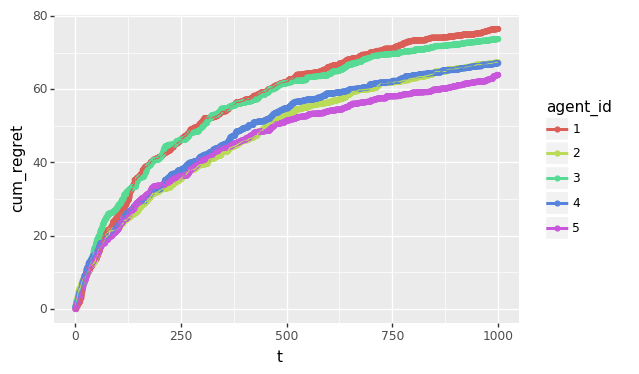

<ggplot: (8771103876657)>


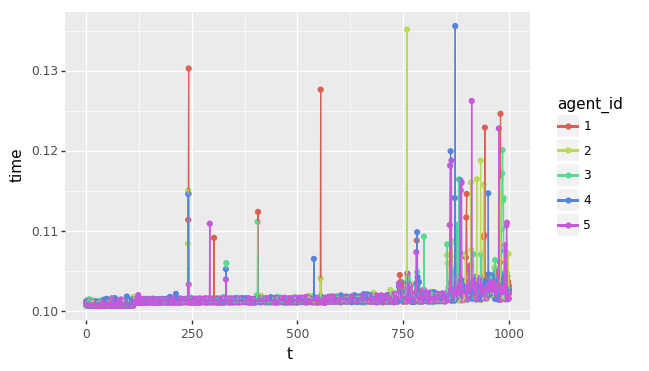

<ggplot: (8771103844589)>
theta [ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882  -0.35475898
 -0.08274148 -0.62700068 -0.04381817 -0.47721803 -1.31386475  0.88462238
  0.88131804  1.70957306  0.05003364 -0.40467741 -0.54535995 -1.54647732
  0.98236743 -1.10106763 -1.18504653]
Experiment: Step 0
 Sample: array([ 0.75667957,  0.84927035,  0.15450688,  0.02805047,  1.86671797,
       -0.27867261,  0.26741496,  2.41825227,  1.06469387, -0.25588671,
        0.73689411,  0.23454932,  0.80474036,  0.80299361,  2.08841536,
       -0.52618501, -0.55088042,  1.54323702, -1.64356413,  0.19981651,
       -0.2844198 ])
 Steps taken: 2025
 Sample: array([ 0.40940863, -1.04385757,  3.14488657,  0.05268348, -1.09481295,
       -0.25564296, -1.07925161, -0.37456246,  0.57700086,  0.50039056,
        1.25203998,  1.26120524, -1.26296537, -1.09243028,  0.13562605,
        1.63113468, -0.67936141, -1.67350705, -1.21440096, -0.53367314,
        2.09445126])
 Steps taken: 1776
 Sample: array([ 0

 Sample: array([ 1.51155233, -0.83401372,  0.20053368, -0.50687709, -1.15111751,
        0.64213014, -0.32736394, -0.88443447,  0.32176476,  1.81346001,
       -0.01454442,  1.10281276,  0.74642545, -0.46719309,  0.16384296,
       -0.63079734, -0.74179319,  0.52333478, -0.51473851, -0.52002394,
        1.42294523])
 Steps taken: 1062
 Sample: array([ 1.07525248, -0.69932611,  0.66456495,  0.18508226,  0.07138622,
        1.73488303, -0.75845482, -0.22534203, -1.28926281,  1.82293664,
       -0.41877303, -0.94741689,  0.79504333,  0.23304449,  3.22353918,
       -0.75944405,  0.49506142, -0.35109639,  0.08714603,  0.2777945 ,
       -1.09356483])
 Steps taken: 1090
Experiment: Step 5
 Sample: array([ 2.16125979, -0.25891423,  0.30719803,  1.05516066,  0.00455683,
       -1.34239131, -0.65952534, -1.03355666,  0.35611088,  2.02003269,
       -1.81210298,  1.08786333, -1.5633684 , -1.25849783,  1.37623035,
       -0.41448339,  2.4289329 ,  0.47320992, -0.45227309,  0.66244896,
        0.

 Sample: array([ 1.24643676, -0.82388607, -1.045947  , -0.16902513, -0.42908797,
       -2.21211435,  0.204471  ,  2.44958795,  0.25153306, -0.72902723,
       -0.07759117,  1.03095129,  0.22154154, -0.11461996,  0.82690345,
        0.05557835,  0.03552954, -1.41757835, -1.18371492,  0.65665542,
       -1.47933323])
 Steps taken: 529
 Sample: array([ 0.29816015, -0.52929091,  0.18480875,  0.7250359 , -1.43806884,
       -1.86852627,  0.89167543, -1.62350217, -0.4337854 ,  1.45743962,
       -0.85949009,  0.01022456,  1.39257183,  1.68463081,  0.6019076 ,
        0.53336575, -0.14716361,  0.02484575,  0.45721136,  1.1896928 ,
        0.68213898])
 Steps taken: 861
 Sample: array([ 0.64174852,  1.42050033,  0.61706953, -0.25406591, -2.48865917,
       -0.98581199, -0.70496955,  0.77668241,  0.19979594,  0.37708793,
        0.36105281,  0.84778946,  1.69782983,  1.55857292,  0.26875947,
       -1.20532353,  0.87822946, -1.51683838, -3.52872402,  0.06671454,
        0.25574305])
 Steps tak

 Sample: array([ 0.32957376,  1.07561896,  1.04070267, -0.71741279, -0.53168857,
        1.18515867, -0.50568878,  1.14809178,  1.18472915,  1.2250539 ,
        0.18551302, -0.68165681, -0.12441485, -0.04625418, -1.14950595,
        0.61193342,  1.82032704, -0.42503515, -1.54577436, -0.76071929,
       -1.60085118])
 Steps taken: 1006
 Sample: array([-0.22885851,  1.40348541,  0.18711781,  0.92884807, -0.09583167,
       -0.89603259, -1.21436834,  0.93812333,  1.1227463 , -0.54967986,
       -0.58071664,  0.65211095, -0.41625119,  0.41146452, -1.01759156,
        0.44378643,  0.88541968,  0.73792948,  0.42011383, -1.45565786,
       -1.82837613])
 Steps taken: 1029
 Sample: array([ 0.73561971, -0.17166508, -0.00137688,  0.7336631 , -1.04010922,
        0.20152914,  0.40619753,  0.13291977, -1.22067607,  0.06110498,
       -0.95536788,  0.7441506 ,  0.06420981, -0.51324266, -1.25956284,
        0.795941  ,  0.2205195 ,  0.30409784,  0.73232702, -0.33654011,
       -0.51769953])
 Steps t

 Sample: array([ 0.39004128,  1.23392006,  0.27762008,  0.6427468 ,  1.14758716,
       -0.74067739,  0.42647716, -0.08484639, -0.14539485, -0.39596526,
        0.29607123,  1.00976628,  1.08185686, -1.07910513, -1.97395545,
       -0.89378246, -2.06616713, -1.01608883,  0.38962537, -0.63289452,
       -0.27005827])
 Steps taken: 986
 Sample: array([ 0.88089974, -0.73436828,  0.6774692 ,  0.54143315, -1.72374313,
       -0.39694929,  0.29075675, -0.42801417, -1.08187562, -0.44146758,
       -1.43929451, -0.02351206,  0.77053117, -0.15388968,  0.78522179,
        0.0739526 , -0.17286719,  0.15972332, -0.00310472,  1.20802979,
       -1.35469968])
 Steps taken: 1016
 Sample: array([ 0.89848647, -1.00965808, -0.02170981, -1.02189613, -0.46888625,
        0.39310741, -0.20987778, -1.03328051, -1.07657952, -0.94328801,
        0.15357328,  0.46010815,  1.04610778, -1.27541935,  0.78926368,
       -0.40539649, -0.80562623, -1.50886962, -1.37384909, -0.56982833,
       -0.65971256])
 Steps ta

 Sample: array([ 0.59489617, -0.31600889,  0.44203249, -0.67952898, -1.35235407,
        0.67481277, -2.10848576, -0.6002601 ,  1.3019894 , -1.0124903 ,
        0.49929228,  0.9211449 ,  0.62606173,  0.10763071, -0.23059594,
       -0.58700218, -0.4028593 ,  0.50913311, -0.89484632,  0.05208573,
       -0.08180832])
 Steps taken: 926
 Sample: array([ 1.72103669,  1.83898416, -0.19500907, -0.03717374, -1.1726055 ,
        0.26254152, -0.6182646 ,  1.13100618,  1.37710696, -0.1547996 ,
       -1.21099206, -0.95194217,  2.46139992, -0.92130084,  0.68641456,
       -1.02576132, -2.85400597, -0.7504469 , -1.10461694,  1.23692217,
       -1.45534762])
 Steps taken: 989
 Sample: array([ 2.20334932, -0.77598765, -1.62834661, -0.72583342,  1.04714672,
        0.24365794,  0.26938617, -1.47344774, -0.17761598,  0.47935714,
        0.06389324,  0.46426323, -0.52185813,  0.41904082,  0.34056608,
       -0.19617354,  1.59309634,  0.08475157,  1.61059321, -0.2801716 ,
        0.79853524])
 Steps tak

 Sample: array([ 1.20213975,  0.26573508, -0.55743806, -0.40049962, -0.88900429,
        1.26531302,  2.59015856,  0.5401343 ,  0.37296401,  1.29197862,
       -0.78162613, -0.66639909,  0.2096555 , -0.86080216,  0.31402618,
       -0.53433802, -1.52362451, -1.40497065,  0.67419894, -0.48667381,
       -1.52334706])
 Steps taken: 479
 Sample: array([ 1.26819792,  0.45523629, -0.65225124, -0.50148336, -2.18922338,
       -0.87191735, -1.51704174,  0.98494657,  0.41045728, -0.21371882,
        1.48396481, -0.93516498, -1.17261445,  0.14837241,  0.58560356,
        0.77565097,  0.77877632, -0.24907943,  0.50957331,  2.19122525,
       -2.09992691])
 Steps taken: 543
 Sample: array([ 1.07846162,  1.23926909, -0.12571857, -0.04100239, -1.44766363,
        0.72568455, -1.62059783,  0.01424296,  0.95809463,  2.53170188,
       -0.92670051,  0.24386294,  0.27409768, -0.57570679,  0.33356409,
       -0.93867265,  1.08878588, -0.77102227, -0.22839482, -0.72701799,
       -0.03808479])
 Steps tak

 Sample: array([ 1.5927519 ,  0.87317861,  0.56928134, -0.30981247, -1.68742952,
        0.16921803, -1.86214282,  0.09726364,  0.05320748,  1.06714401,
       -0.25204907, -0.69719842,  0.50996017, -1.07875997,  0.10569639,
       -0.71032459, -0.74946375, -0.03813226, -0.08307554,  0.6862475 ,
       -2.43428499])
 Steps taken: 960
 Sample: array([ 1.26050398,  0.09086552,  1.01840008,  0.02327034, -1.1666526 ,
        0.16575628, -0.59593841,  1.03741621,  1.08256919,  1.16432437,
       -0.55062356,  0.15084843,  1.51506189, -0.22601798, -0.90350916,
        0.61092331, -1.54280704,  0.60359384,  0.90349453, -1.66586826,
       -1.22965968])
 Steps taken: 967
 Sample: array([ 1.58057794,  0.12217332, -0.38533761, -1.07183694, -0.7912248 ,
       -0.40040974,  0.19069911,  0.11482378, -0.36386626,  0.88535521,
       -0.6394438 ,  0.60637909,  1.11888397,  0.46000271, -0.85373366,
       -0.98631419, -0.77485754,  0.39324338,  1.04626483,  0.6710546 ,
       -0.28162416])
 Steps tak

 Sample: array([ 2.63131986,  1.63250258,  0.96931861,  0.70230938, -0.25908846,
        1.03669585, -1.51941727,  1.00664971,  0.4632516 ,  0.98363666,
        1.40481967,  1.69733285,  0.17740629,  1.40192466,  1.37471853,
       -1.5620517 , -0.07674995,  0.43972284,  2.17619027, -0.88307343,
       -0.94850059])
 Steps taken: 903
 Sample: array([ 1.63517884,  0.05501992,  1.15971813, -0.87948812, -0.72504795,
       -0.87828372, -1.46015877,  0.08904973,  0.31339175, -1.09738753,
        0.22455739,  0.57201463,  1.03483224,  0.47544751, -0.87340805,
       -0.28150352, -0.8038102 , -0.54807846, -0.18611459, -1.40168855,
       -0.67256714])
 Steps taken: 638
 Sample: array([ 1.61450535,  2.9280772 ,  0.96502047, -0.11874108, -0.35429335,
        0.25712723,  1.25956319,  0.47169187,  0.13659546,  0.30819929,
       -2.04330531, -0.50802593,  0.33132273, -0.55200074, -1.94025173,
       -1.37021735,  0.34350258, -1.88216544, -0.17929681, -1.28749282,
       -0.67046493])
 Steps tak

 Sample: array([ 1.54004919, -0.13418649,  0.88231537, -1.3949002 , -0.13980433,
       -0.40859884,  0.64333418,  0.22219155,  0.90376003, -0.52066698,
        0.926405  , -1.03615818,  0.41655903, -0.17544528, -0.11350824,
       -0.24780853,  0.37916251, -1.46411532,  0.96662859, -0.39490751,
        0.06157438])
 Steps taken: 925
 Sample: array([ 0.89643128,  1.69167072,  0.33776907, -0.68316309,  0.14569283,
        0.1072486 ,  1.06043731,  0.20383314,  1.46515635,  0.49340104,
       -1.65039451,  0.88721547, -0.87882337, -0.38954439, -0.65816826,
       -0.25987265, -0.94829351, -0.72505979,  1.97787076, -1.17464169,
        1.02946378])
 Steps taken: 929
 Sample: array([ 1.73148324,  0.37336641,  0.25794358,  0.63852881, -0.15078448,
        0.76430297, -0.97234726, -0.6847998 ,  0.40806439,  1.26120199,
       -0.49393428, -0.82030286,  1.19708588,  0.21654461, -0.09182749,
        0.6936185 ,  1.0205709 , -0.32107741,  1.91069023, -1.12872895,
       -0.72010393])
 Steps tak

 Sample: array([ 1.54167958,  0.07000325,  0.96149963,  0.21909555, -0.25960421,
        0.76715858,  1.48633319, -1.09908883,  0.53276636,  0.19878216,
        0.91024386,  0.41403769,  1.47536021,  0.54059666,  2.12848834,
       -0.24530913,  0.63692813, -0.84283469,  2.87668714,  0.39217072,
       -0.07877261])
 Steps taken: 901
 Sample: array([ 1.96300508,  0.38285435,  1.45493031, -0.28852557, -1.07733479,
        0.817459  , -0.73180585, -1.30352153, -0.61075557,  0.02431419,
       -0.88724485, -0.47552691, -0.48627026,  0.00339831, -1.08262716,
        0.51524565, -1.37056676, -0.88626892,  1.18700775, -0.55090141,
        0.64558497])
 Steps taken: 913
 Sample: array([ 1.00916256,  2.07653321, -0.20588686, -0.35930746,  0.62665723,
       -0.61294766,  1.11466772,  0.38892592,  0.11526017,  0.31142939,
       -0.72428252,  1.570456  ,  0.15173798, -1.10441842, -1.15754019,
       -0.81144828, -1.02413562, -0.67531312,  1.07477068, -1.25283087,
       -0.13181442])
 Steps tak

 Sample: array([ 0.63131312,  1.42835374, -0.20298885, -1.3990737 , -1.82675227,
        0.11445774,  0.77153877, -0.09296921,  0.50829625,  1.47527827,
        0.31207331,  0.23596638,  1.24724782, -1.44156521, -0.31946354,
       -2.31937064, -0.33212068, -0.72844582, -0.01803897, -0.75099828,
       -0.57131626])
 Steps taken: 690
Experiment: Step 54
 Sample: array([ 1.41610248,  0.43779948,  0.76315429, -1.00348183, -0.86998793,
       -0.41061932,  0.7600792 , -0.234482  ,  0.37850214, -1.19832096,
       -1.3611629 , -0.07156425,  1.63194863,  0.25183839,  1.13587126,
       -0.04892841, -1.04374467, -1.84291434, -0.30063629, -0.13879951,
       -0.69027621])
 Steps taken: 696
 Sample: array([ 1.17477474,  0.29516239, -0.56273695, -1.86062158, -0.41247777,
       -0.89199073, -0.63209279, -1.27544741, -0.75085539,  0.80936671,
        0.66553317, -0.05182538, -1.23054831, -0.09391637, -0.43541771,
        1.98309256, -0.10368398, -0.7234382 ,  0.30197138, -1.32205282,
       -1.6

 Sample: array([ 1.39227137,  1.56914759, -1.53658394, -0.36081101, -0.26630037,
        0.12009573, -0.55689965, -0.92241091,  0.16627675,  0.77053242,
        0.84544496, -0.89502798,  0.69372194,  0.80974225,  0.78159366,
       -0.94722199,  0.77163069, -1.2909477 ,  0.71493906,  0.09918174,
        0.24254094])
 Steps taken: 829
 Sample: array([ 1.22466468,  0.16273439, -1.44396097, -1.98121277, -0.65999764,
        1.43461457,  0.29103071,  1.17682868,  0.09420528,  1.1072554 ,
       -0.30678225,  0.00201774,  1.42690195,  0.27840096,  0.83206715,
        0.77081707, -0.09067217, -0.04031456, -0.46474594,  0.39293422,
        0.60597382])
 Steps taken: 832
Experiment: Step 59
 Sample: array([ 1.27323385,  0.55579717,  0.14897888,  0.79360643, -0.21442398,
       -1.51360191, -0.61611288, -0.60148532, -0.08472992, -0.5912614 ,
        0.53347719,  0.19568867,  0.4422659 , -0.39296562,  0.33280282,
        0.38741031, -1.72465318, -0.63321742,  0.28685644, -0.1452724 ,
       -1.8

 Sample: array([ 1.23166615,  0.59876032, -0.19683947,  0.45463476,  0.08330161,
        0.10005534,  2.44048404, -0.10040305,  0.07246862, -0.89498648,
       -2.18104669,  0.90288873,  0.61104169,  1.00358332, -1.58443912,
       -1.43006916, -1.86811301, -1.00591801, -0.06402206, -1.33903781,
       -0.93910035])
 Steps taken: 801
 Sample: array([ 1.74475249,  0.1705031 , -1.64999418, -1.17235921, -0.63224874,
        0.23668409,  0.43778758, -0.18963795,  1.66452617,  0.58352745,
       -0.88407753,  0.99512884,  1.39037389, -0.32000749,  0.91239447,
       -0.19893432,  1.7913705 , -0.41760585,  2.28219388, -1.09647983,
       -0.91872103])
 Steps taken: 823
 Sample: array([ 1.59094537, -0.70155948, -0.04621973, -2.56665038, -2.11682383,
        0.70422588,  1.23742602,  0.03930125,  0.72229937,  1.47413284,
       -0.18414101,  0.13972008,  0.71453733,  1.07675316,  0.6087301 ,
        0.23703572, -2.75623491, -0.93807876,  1.26229456, -1.05972326,
        0.88650952])
 Steps tak

 Sample: array([ 1.1104924 , -1.40918957,  0.16252981, -1.18879619, -0.43998795,
       -1.017733  , -0.41662313, -0.21679032, -0.711267  , -0.59224194,
       -0.03797075, -0.04812938, -0.26482087,  0.23756604, -0.41215575,
        0.98940864, -0.32840339,  0.62614458, -1.03977532, -0.48050306,
       -0.89231649])
 Steps taken: 745
 Sample: array([ 1.37239327,  1.55028272,  0.0411316 , -0.48868816,  0.13409058,
       -0.34305705,  0.76268573,  0.14963528, -1.32534317,  0.20267162,
       -3.08089116,  0.68741782,  0.53035343, -1.3419719 , -0.08781902,
       -1.8723595 , -1.47743176, -1.00556154, -0.20638762, -1.28638544,
       -0.99898264])
 Steps taken: 806
 Sample: array([ 1.53914557,  0.59775018,  0.04065595, -0.18654862,  0.57497483,
       -0.11471846, -1.03977451, -0.63438222,  0.08953939,  2.04297414,
       -0.46336142,  0.25491553,  1.43499901, -0.18262789,  0.01460139,
        0.43054754,  1.84212959,  0.41170341,  1.00037721,  0.84941844,
       -0.10720446])
 Steps tak

 Sample: array([ 1.51414675,  0.48162077,  2.07011877, -0.20875643, -1.40847515,
        0.81402169,  1.55521978,  0.00774204, -0.13261753,  0.07475187,
       -1.02043866,  0.46867601,  1.62855225,  0.15268102, -0.74629118,
       -0.27647461,  0.52372257, -0.89986439,  0.72590358, -1.1449693 ,
       -1.55719199])
 Steps taken: 698
 Sample: array([ 2.13691301,  1.11721879,  0.10871834, -0.27845251, -1.54150078,
        0.26649003, -1.09961783, -0.29084911, -0.39304664,  1.702688  ,
        0.06344024, -0.45276778, -0.33935436,  1.59542196,  0.04389679,
        1.04434249,  0.47861161, -0.88230353,  0.81232896,  0.34411366,
       -0.87129149])
 Steps taken: 451
 Sample: array([ 1.64471751,  0.91809876,  0.24700094, -1.97892986, -0.3370332 ,
        1.22403218,  1.34335863,  0.30412527, -0.23070363,  0.7662484 ,
       -0.32337193, -1.03590619,  2.71908712, -0.24747185, -0.964861  ,
       -0.45338334,  0.48560934,  0.80362098, -0.08329943, -0.2611206 ,
        0.7246889 ])
 Steps tak

 Sample: array([ 1.71354441,  0.00578525,  0.78873151, -0.9469217 ,  0.09605552,
       -1.35288301,  0.60632185, -0.48258199, -0.83723714,  1.02305355,
       -0.96176741, -1.02057941,  1.0412732 ,  0.88736381,  0.34927646,
       -0.48624351,  0.41534306, -0.4966754 ,  0.65830925, -0.81248854,
       -1.69548387])
 Steps taken: 770
 Sample: array([ 0.85882697,  0.94456078,  0.76599392, -0.45408217, -1.99250392,
        0.59805787,  0.00359232, -0.60614356,  0.36745994, -0.71948229,
       -0.61844731, -0.19301333,  1.90878934,  0.73548054, -0.5709597 ,
        0.07799557, -1.36507238, -1.10902524, -0.39931303,  0.84262619,
       -0.19365539])
 Steps taken: 784
Experiment: Step 79
 Sample: array([ 1.67200933, -2.84180679,  0.96436802, -1.42636332,  1.04779973,
       -1.14460106, -0.97104616,  1.18529674,  0.15697334, -0.89895133,
        0.92303781,  0.85126079, -0.06639369, -0.16957353,  0.66117071,
       -0.59855582, -2.73966411, -0.32321035,  1.07879292, -0.08899343,
       -0.4

 Sample: array([ 1.16178017,  1.71514446,  0.43708958, -1.17206333, -0.79124046,
       -1.67131564,  0.65441748,  0.23025054,  0.28081311,  0.30215827,
       -0.61068934,  0.35332018,  0.99119278,  0.97324247, -0.50568144,
        0.01071298,  0.37644292, -0.65291371, -0.85373916, -0.34045157,
       -0.46041075])
 Steps taken: 707
 Sample: array([ 2.03277685,  1.45052183,  0.67155374, -0.08388244,  0.31088856,
       -0.87396599, -0.3511322 ,  0.14983906,  1.34603851,  1.18203787,
        0.33645907, -0.43045055,  0.49717741,  1.43555582, -1.16596665,
        0.67018972,  2.23683991, -1.59232963,  0.68287422, -0.51062242,
       -1.47461549])
 Steps taken: 724
 Sample: array([ 1.78670737,  1.03078307, -0.80717739, -0.95224572, -0.30111539,
        0.44911721, -0.30415063, -0.69365249,  0.06716548,  0.7611173 ,
       -1.77474527,  0.29287292,  0.45769591, -0.58416337, -0.84120059,
       -1.56476485,  1.15817176,  0.46673863, -1.59725795, -1.34985037,
       -0.4721711 ])
 Steps tak

 Sample: array([ 2.00511106,  1.96096601,  0.25660437,  0.07261432, -0.3214206 ,
       -1.36394569, -0.31924432, -2.09419876,  0.44641846,  1.30069224,
       -0.48160791,  0.36496485,  0.92706101,  0.57087021,  0.72004193,
        1.02847054, -1.08803438,  0.06393531,  0.14100764, -0.06106681,
       -0.79085123])
 Steps taken: 498
 Sample: array([ 1.88444084,  2.01319827,  0.41262231, -1.13672788, -0.28463845,
       -1.26551691,  1.20090193, -0.35561744, -0.07383746, -0.03599286,
       -2.13247799,  0.2049249 ,  0.67979722, -0.36604235,  0.0831305 ,
       -0.28176182, -0.11891167, -0.93802941,  0.57895153, -0.13717739,
       -1.14936208])
 Steps taken: 734
 Sample: array([ 1.62832527,  1.5362798 ,  0.91816881, -1.23210378,  0.33483245,
       -0.7368784 , -0.37195429, -0.3336208 ,  1.17104505,  0.313912  ,
       -0.16018655,  0.23478389,  0.06957359, -0.09088707,  0.04396306,
       -0.15794106,  1.10143985, -0.79394026,  0.93840471, -0.26512621,
       -0.69848927])
 Steps tak

 Sample: array([ 1.12673413, -0.28559476,  0.31281721, -0.36562948, -0.21271958,
        0.05166128, -0.22553418,  0.87351702,  0.09028625, -0.42916306,
        0.62673317, -0.88573796,  0.80484445, -0.88245272,  0.07160392,
        0.01054498, -2.49101409,  0.31571727,  0.41164262, -1.96900971,
       -0.19283101])
 Steps taken: 674
 Sample: array([ 1.44156591,  0.45965881,  1.29980657, -1.06467418, -1.73142737,
       -0.63448303, -0.27230759, -1.67526132, -0.5595052 ,  0.02886521,
       -0.40210801, -0.98898185, -0.97351435,  0.93675825,  0.71371534,
        1.83858142, -0.68164042,  0.53711663, -0.47053634, -0.24029508,
       -0.80097319])
 Steps taken: 706
 Sample: array([ 1.61922995,  0.5241103 ,  0.07207067, -1.71082113,  0.83617211,
       -0.11056144,  0.57730954,  0.70936445,  0.2366173 , -0.57486754,
       -1.6715888 , -0.36376012,  0.12789692, -0.27442326,  0.57736392,
       -0.41154483, -0.27446972, -1.19541571, -1.37691958, -1.58282904,
       -1.84485804])
 Steps tak

 Sample: array([ 1.64389965,  1.46461854, -1.37361127, -1.78456604, -1.71662972,
       -0.24126009, -0.32477704, -1.08809057, -1.4522654 ,  2.45040012,
       -1.39898936,  0.56832307,  1.85219911,  1.02627788,  0.2105569 ,
       -0.9875765 , -1.34390769, -1.56455931, -0.33532444,  0.37329037,
       -0.37386252])
 Steps taken: 525
Experiment: Step 98
 Sample: array([ 1.90045443, -2.1265025 ,  0.39988117, -1.25065832,  1.13988818,
       -0.77927045, -0.5123689 ,  0.7727746 ,  0.73814625,  0.0935919 ,
       -1.49119664, -1.3985589 ,  1.54119104,  0.3475461 ,  0.64314283,
        0.08159782, -2.50500458,  0.55705895,  0.23612913, -1.53896049,
       -1.7160737 ])
 Steps taken: 400
 Sample: array([ 1.29902225,  0.56686762,  0.09542771, -1.82739031, -0.81365579,
       -1.12887783, -0.90573232, -1.44910908,  0.95563872, -0.88246896,
        0.2133837 ,  0.79250596,  0.72995199, -0.55082248,  0.25704327,
       -0.10662115, -0.41903203,  0.5457075 ,  0.30807889,  1.42741053,
       -0.0

 Sample: array([ 1.55506118,  1.28439365, -0.05006503, -0.67376369, -0.80954088,
        0.13986473,  0.63633657, -0.51861889,  0.73045019, -0.01291515,
       -0.4448266 ,  0.65003339,  2.12656212,  1.71156893, -0.4645262 ,
       -0.23433339,  0.20192771, -0.37944641,  0.50486725, -1.17282464,
       -0.81299659])
 Steps taken: 535
 Sample: array([ 1.53112848,  0.70138419, -0.30653124, -0.55402818,  0.40278065,
       -1.36710969, -0.53396763, -0.15316094, -1.34673692,  0.32172928,
       -1.31137473,  0.699078  ,  1.98033191, -0.33562371,  0.53685575,
       -1.16365815, -0.51286912, -0.44743103,  0.89533416,  0.35323566,
       -0.73052143])
 Steps taken: 482
Experiment: Step 103
 Sample: array([ 1.27421914, -0.17687967,  0.88069547, -0.51793306,  0.66033125,
       -0.47103961, -1.09078443, -0.12412545,  0.11255775,  0.05270454,
        0.0801926 ,  0.46796337, -0.02383569, -1.14655379,  0.60620482,
       -1.28266449, -1.38790494, -0.19832031,  1.32258387, -0.23365295,
       -1.

 Sample: array([ 1.23505318,  2.30074425,  0.26794065, -0.93664661,  1.11643828,
        0.1153728 ,  0.65120018,  1.0404369 , -0.38932393,  1.31751578,
       -1.62492499,  0.39368053,  0.35291496,  1.40444141, -0.81765674,
       -0.67051635, -1.15457598, -1.42850091,  0.82421248, -0.63545521,
       -2.1862839 ])
 Steps taken: 624
 Sample: array([ 2.136587  ,  0.28321466,  0.2887307 , -0.68190044,  0.69306993,
        0.05153072, -0.90738889, -0.79303916, -0.67222371,  1.59374405,
       -0.28796357, -1.54438457,  0.31824799, -0.05178837,  0.47053441,
        0.02593017, -0.42592628, -1.66700745,  0.88562416, -0.37363575,
       -2.1133148 ])
 Steps taken: 652
 Sample: array([ 1.18136967,  0.6070138 , -0.77944508, -2.03754548, -0.80417267,
        0.36285478,  0.90793642, -0.91534286,  0.25377135,  1.16553798,
       -0.72249156,  0.89774834,  1.26463078, -1.30436891,  0.134942  ,
       -1.61834131,  0.19568218, -0.6888522 , -0.22702039,  1.11191725,
        0.22005197])
 Steps tak

 Sample: array([ 2.00377855,  0.41519417, -0.9383152 , -1.99373107, -0.15540496,
        1.58043765,  0.31790951,  0.93515355, -0.08938166,  0.49663492,
        0.17354833, -0.5880521 ,  0.90423114, -0.32359635, -1.00164899,
       -0.07659152, -0.18080319, -0.04584002,  0.74960461, -1.93860227,
       -0.10163547])
 Steps taken: 287
 Sample: array([ 1.53059538,  0.22796311, -1.3932702 , -2.17792664, -1.53135084,
        0.87498428, -0.8575536 , -1.72205876, -0.71976235,  0.38014552,
       -0.71359506,  0.46221954,  1.76880817,  0.29851253, -1.0577359 ,
       -0.7650003 , -0.14182791, -0.9219215 ,  0.09507199,  0.5162654 ,
        0.29282947])
 Steps taken: 205
Experiment: Step 113
 Sample: array([ 1.6604231 , -0.27141287,  1.24512761, -1.71220779,  2.17811905,
       -0.19463834, -0.74716835,  0.07831612, -0.22584323, -0.32306381,
       -0.032546  , -0.2184187 , -0.03227562,  0.58289149,  0.86821916,
        0.11947469, -0.49871651,  0.05700821,  1.19859875, -1.41530522,
       -1.

 Sample: array([ 9.58679974e-01,  5.48578783e-01,  1.11128333e-03, -1.09770507e+00,
       -1.60725599e+00, -9.27956134e-01, -9.83752350e-01, -6.51797047e-02,
       -6.83603229e-01,  1.03410542e+00, -6.69311283e-01,  2.52123668e+00,
        2.80331897e+00, -1.65008746e+00, -1.10112596e-01,  2.47606515e-01,
       -4.00135138e-01, -1.16787716e+00,  1.55728724e-01, -1.90851500e-01,
        1.02649621e+00])
 Steps taken: 304
Experiment: Step 118
 Sample: array([ 1.23619609, -0.20186305,  1.94948442, -0.98012532, -0.28091955,
       -0.3496664 , -0.45505659,  0.67729777, -0.69270776,  0.72040688,
       -0.32309628, -0.64104827,  0.96962482, -0.29572152,  0.18244881,
       -0.47484192, -1.58693832, -1.05888055,  1.24436147, -0.74228086,
       -1.59927573])
 Steps taken: 310
 Sample: array([ 1.27497768,  0.1766987 ,  0.86872516, -1.03718563, -0.71761073,
       -1.41098691, -0.41174564, -0.40196555,  0.74840219, -0.004445  ,
       -0.10415777,  0.90428265,  1.07583911,  1.39594063,  0.5

 Sample: array([ 1.70761327, -0.28363294,  0.56267394, -1.42957958, -0.89134344,
       -0.8329176 ,  0.21525541, -0.9820342 ,  0.87256759, -0.52497377,
       -0.48055688, -1.30591309,  0.87665022,  0.87232387, -0.36648197,
        0.02287563, -0.37876136, -1.85340105,  1.46053149, -0.79779558,
       -1.58435367])
 Steps taken: 284
 Sample: array([ 1.19569052,  1.43918194,  0.27147801, -2.04711235, -0.97309126,
       -0.18210155,  0.08980591, -0.08637335, -1.04795617,  1.33156518,
       -0.85881315,  0.88182526,  3.04347009,  0.78911984,  1.04765654,
       -0.41001344, -0.02637067, -1.60053011,  0.09449134, -0.08438777,
        1.70926533])
 Steps taken: 280
Experiment: Step 123
 Sample: array([ 2.00076643, -1.263085  ,  1.19508629,  0.07903688, -0.26723857,
       -0.7887611 , -0.87787388, -0.09164136, -0.25746261, -0.36719894,
        0.53656701,  0.27174311,  0.05768699,  1.63049799, -0.31855844,
       -0.36935541, -0.92358199,  0.02432064,  0.60457587, -1.57149287,
       -1.

 Sample: array([ 1.62342183,  1.31966232,  1.09547107, -0.27849875, -0.66444789,
       -1.45884842,  0.17346399,  1.50834189,  0.22904116, -0.17549409,
       -1.1860495 ,  0.39393273,  2.35660132,  0.87508435, -0.13645772,
       -0.2114253 , -2.1322281 , -2.7157657 , -1.03647378,  0.49785651,
       -1.55295043])
 Steps taken: 309
 Sample: array([ 1.2793997 , -1.07268538, -1.0661062 , -1.85232872, -0.47577076,
       -1.55055422,  0.62995502, -0.86440029,  0.01363114, -0.76154519,
       -0.35007448, -0.0524668 , -0.83774203,  0.51251298, -0.83852004,
       -0.91466951,  0.59265573, -1.35687358,  2.27615402, -1.0487356 ,
       -2.06801211])
 Steps taken: 316
 Sample: array([ 0.99887084,  1.43390181, -0.28209474, -1.03403411,  0.72440462,
       -0.2887111 ,  0.19629399,  0.6458334 , -0.82859554,  0.95412295,
       -2.06982041,  2.02458243,  1.32767737, -0.1937756 ,  1.34190386,
       -1.31767709,  0.08607247, -0.97002816, -0.78430488,  0.65555744,
       -0.2879889 ])
 Steps tak

 Sample: array([ 1.43852153,  0.47419492,  1.39786636, -2.10852486, -0.75254708,
       -0.56349968, -1.21443818, -1.13176493,  0.4253958 ,  0.59270635,
       -1.60121876, -0.6984958 ,  0.40282726,  1.17459108,  0.34754758,
        0.98905429, -0.94992861,  0.21163827,  0.96391501, -0.0205089 ,
       -0.88193996])
 Steps taken: 305
 Sample: array([ 1.36179464,  2.01114352, -0.40179467, -0.09715348, -0.96109485,
       -0.86939943,  0.58590131,  0.34673958, -0.90337249, -1.30908072,
       -2.73721143, -0.87812974,  0.9768141 , -0.22958192, -0.21227728,
        0.08966049, -0.92106074, -0.90970275, -0.7258896 , -1.39298947,
       -1.68354712])
 Steps taken: 311
 Sample: array([ 2.18063847,  0.01931041,  1.96066004, -1.41210472, -0.74510393,
       -0.65079752,  0.30843899, -1.28500231,  0.689049  , -0.05193987,
        0.34320372, -0.26046245,  0.96840391, -0.42433266, -0.10957596,
       -1.51549417, -0.39422303, -0.47218353,  1.89175683, -0.46236682,
       -1.16361775])
 Steps tak

 Sample: array([ 1.5161107 ,  1.30014253, -0.27135111,  0.76009906,  0.74565757,
       -0.7078027 ,  0.25985926, -1.58496618,  0.02641973, -0.28211052,
       -1.66670238,  0.72709971,  0.6417032 ,  0.07968097, -0.05503273,
       -1.51018497, -0.65478141, -1.27613525, -0.31312148, -2.0646354 ,
       -2.04407161])
 Steps taken: 301
 Sample: array([ 1.59885521,  0.06003403,  0.87353636, -0.77392656, -0.85246646,
       -0.8371762 ,  0.95249548, -0.94929415,  0.52323351, -0.57346612,
       -1.41360122,  0.28318395,  1.08566622,  0.07490269,  0.24567448,
       -0.84437687,  0.42416057, -0.62393214,  1.09754736, -1.24831878,
       -1.97481844])
 Steps taken: 305
 Sample: array([ 1.06379125,  0.05403665, -0.3469261 , -0.90763257, -0.25143545,
        1.25341859,  0.02130222, -1.03994925, -0.01222041,  0.30555458,
       -0.78969049,  1.04790272,  1.16001506,  1.06744984, -0.50745   ,
       -0.25007504,  0.03491858, -1.14719565, -0.05098267,  0.46896145,
        0.08229054])
 Steps tak

 Sample: array([ 1.84073601,  0.37933039,  0.03333301, -0.37555407, -1.65704227,
       -1.51117699, -0.28044552, -2.09983847, -0.02696414, -1.84151369,
       -0.88412514,  0.07590549,  0.37678482,  0.53168053, -1.05170921,
        1.65794854, -0.30603497, -1.80886625, -1.2661432 , -2.01971909,
       -1.91901249])
 Steps taken: 292
 Sample: array([ 1.35024558, -0.66789424, -0.14788605, -0.15777738, -0.54263947,
       -0.7212649 ,  0.42984509, -1.02479973, -0.78189559,  0.50707983,
       -1.77229437,  0.98337343,  0.9780003 , -0.10116175, -1.27650678,
        0.07311422, -0.70815579, -2.54711607,  0.01396774, -0.87202875,
       -0.83793077])
 Steps taken: 300
 Sample: array([ 1.69869833,  0.12640237,  1.12563462, -1.36461184,  0.1601527 ,
       -0.31269667,  1.39588699, -1.5095709 , -0.33889495,  0.12158142,
        0.12072811, -0.92667779,  1.20314992,  0.12658573, -0.11118144,
        0.46648842,  0.46226144, -1.12879028,  1.97653514, -0.45455012,
       -0.91069483])
 Steps tak

 Sample: array([ 1.96737662, -0.22021461,  0.74561059, -1.28353169, -0.96392721,
       -0.40725155,  1.18374666,  1.19800934,  0.02914363, -0.18161301,
       -1.7047154 , -1.25783437,  1.03153251,  0.17358712, -0.74873833,
       -0.41565215, -1.66534335, -2.54635944, -0.57923168,  0.84946056,
        0.01010981])
 Steps taken: 292
 Sample: array([ 1.66386107, -0.14122221, -0.60277993, -1.38274309, -0.77032548,
       -1.476212  ,  0.31080801, -0.16663169, -0.52366777,  0.03742127,
       -0.70934191, -0.73961643,  0.78623566,  0.76223287, -0.84586855,
       -0.63481767, -0.31046371, -0.81880556,  0.1338648 , -1.4046654 ,
       -1.55141232])
 Steps taken: 258
 Sample: array([ 1.65082112,  0.02391172,  0.12149676, -1.11290626, -0.11851926,
        1.36430395, -0.0972304 ,  0.15284455, -0.48002419,  1.02144936,
       -2.16435598,  1.11630986,  0.77804352,  1.18152627, -0.29701328,
       -1.82300955,  1.79092571, -1.34502627,  0.45712855,  0.25019238,
        0.07960603])
 Steps tak

 Sample: array([ 1.99385397,  0.35075018,  2.10583558, -1.01516828, -1.3163087 ,
       -0.55659003,  0.1851903 , -1.44527102,  0.11905884, -0.58646613,
       -1.73429887,  0.34374388,  0.70210229, -0.17836171,  0.98100013,
        0.43715035, -2.07253546, -2.03047653, -0.03935072, -0.63718885,
       -1.31367837])
 Steps taken: 188
 Sample: array([ 1.66858376,  0.33446382,  0.47173115, -0.91045265, -0.91362461,
        0.07028008,  0.56579254, -0.13505346, -0.70433015,  0.47588365,
       -2.41459291,  0.55401394,  0.91512088,  0.50524131, -1.28504133,
        0.20337989, -0.57693256, -2.13834769, -0.47126869, -0.40903682,
       -1.97536316])
 Steps taken: 216
 Sample: array([ 1.94014479,  0.85000574,  0.56343678, -1.22855134, -0.85464462,
       -1.72618278, -0.60177125, -0.24436201, -0.09975164,  0.26221191,
        0.4781215 , -0.71208957, -0.39332577,  0.46418323, -0.03078021,
       -0.43835508,  0.06427022, -1.04341313,  1.83902904, -0.24598879,
        0.0669354 ])
 Steps tak

 Sample: array([ 1.39300458,  0.71248404,  0.17154891, -0.33107027,  0.58636506,
       -0.5502829 ,  0.93265347,  0.84540132, -1.10470602,  0.90980781,
       -2.55564018,  0.79888483,  1.1426852 ,  1.36284253, -1.49985885,
       -0.32151596, -0.74746353, -1.86893182,  0.25121649, -1.18411241,
       -1.6997385 ])
 Steps taken: 280
 Sample: array([ 2.22509817, -1.07502151,  1.60193248, -0.81857812,  0.61183868,
       -0.01962638,  1.00640656, -0.84619111, -1.78523877, -0.03556749,
       -0.49426085, -0.54245948,  0.91028297,  0.34186791, -0.5516025 ,
       -0.2191741 ,  0.21033471, -0.68491883,  1.50414983, -0.73781209,
       -2.13858524])
 Steps taken: 288
 Sample: array([ 0.95060323,  0.44671047, -0.57721752, -1.96849665, -1.42350629,
       -0.1008937 , -0.42228117,  0.13239884, -0.35270617,  0.62063213,
       -0.19205596,  0.88413256,  2.40528692,  1.30826105,  0.83212321,
       -1.72089473,  0.99910742, -1.37505001,  0.29102559, -0.18302723,
       -0.52714199])
 Steps tak

 Sample: array([ 1.6952594 ,  0.84524069,  0.34359716, -1.26321354,  0.44421764,
       -1.74670722, -0.26424271, -1.4715806 , -0.91972576, -0.10311289,
       -0.67258557,  0.06501389,  1.07946694,  0.85443237,  0.28750064,
        1.16624702, -1.11106992, -0.62385919,  0.69108119,  0.21666276,
       -1.18595706])
 Steps taken: 277
 Sample: array([ 1.50728869,  0.52214602,  0.21291806, -0.23399223, -0.94786346,
       -0.11413955,  0.53613642, -0.94847596, -1.20519622, -0.79034366,
       -0.45152055,  0.70903418, -0.09224634,  0.04281998, -0.43328877,
       -0.56541982, -2.12979721, -0.82827704, -0.47824863,  0.19191307,
       -1.79008684])
 Steps taken: 286
 Sample: array([ 1.59977483, -0.11713953, -0.23398043, -1.43953537,  0.24206068,
       -0.58254315,  0.79834994,  0.24552212, -0.76801782, -0.47291252,
        0.60587895, -0.07136038,  1.40644387,  1.60922373,  0.95612765,
       -0.68955096,  1.12650497, -0.69260783,  1.33789847, -0.78160295,
       -0.65867716])
 Steps tak

 Sample: array([ 1.35393801,  0.46641296, -1.1748639 , -0.92883738, -0.02268974,
       -0.89960483,  0.88916435,  0.53310265, -0.40832186, -0.64354337,
       -1.36958625, -0.64878458,  1.15734376, -0.10814882, -0.9288694 ,
       -1.45337168, -1.17705932, -1.63441515,  0.03380694, -0.08203426,
       -1.62868851])
 Steps taken: 267
 Sample: array([ 1.28844923,  0.88690937,  0.97840706, -1.47724735, -0.7193484 ,
       -1.31526538,  0.45672876, -0.63785143, -0.65000749,  0.02570848,
       -0.67462844, -0.93397596,  1.0826434 ,  0.5352753 , -0.06714985,
       -0.27376939,  0.2307529 , -0.04603996,  1.17499601,  0.70549305,
        0.394831  ])
 Steps taken: 283
 Sample: array([ 0.96583498,  1.18399541,  0.56367485, -0.61095127, -0.47452077,
       -0.06276909,  1.00040637, -0.55957577, -0.84344444,  1.03827487,
       -1.2235841 ,  0.51710032,  1.73064427,  0.41348907,  0.79032389,
       -1.036733  ,  0.53386741, -1.01706637,  0.24640403,  0.16192781,
        0.58659786])
 Steps tak

 Sample: array([ 1.73669138,  1.28127165,  1.5857354 , -1.52484681, -1.44780028,
       -0.89877845, -0.07130354, -0.17611729,  0.15731976, -0.01977897,
       -0.99326399,  0.13846124,  1.78196663,  1.2401684 ,  1.72105145,
        0.51827029,  0.64274237, -1.24276827,  0.62172059, -0.44813613,
       -0.92077072])
 Steps taken: 271
 Sample: array([ 1.13649962,  0.15722563, -0.32622345, -0.93808318,  0.44977091,
       -0.67160655,  0.45126054,  0.59005359, -1.11207557, -0.29734933,
       -2.08811487, -0.28677046,  0.77381498,  0.50778402, -0.50307566,
       -0.61591155, -1.28415562, -1.38538738, -0.4011277 , -1.15481749,
       -1.21308116])
 Steps taken: 276
 Sample: array([ 1.71494505, -0.50912041,  0.2233076 , -1.14432997, -1.63364215,
       -0.39726731, -0.12216871, -0.06143453,  0.11747612,  0.42924355,
       -1.32774125,  0.26821372,  0.8775443 ,  0.82695598,  0.71935777,
       -0.57978107, -1.68815554, -0.87970157,  1.49694267, -0.20619581,
       -0.05062402])
 Steps tak

 Sample: array([ 1.66629359,  1.39193448,  1.00233521, -1.23025061, -0.69879996,
       -0.94778848, -1.84991352,  1.01331325, -1.40109584, -1.59097884,
       -0.99283754, -0.0233134 ,  0.50764149, -0.53780996, -0.14351168,
       -0.6849607 , -1.06769544, -0.1914086 , -0.01545908, -1.27755396,
       -3.03327388])
 Steps taken: 275
 Sample: array([ 1.48377598, -1.12675169,  0.63026323, -0.95334961, -2.42785274,
       -1.42171746, -0.28114182, -1.68943179,  1.14920308, -0.28583758,
       -1.89448347,  0.24089679,  1.08520856, -0.51610308, -0.57824298,
        1.01207573, -0.09797256, -1.5948175 , -0.75634477, -0.58734498,
       -1.05658369])
 Steps taken: 275
 Sample: array([ 1.01280566,  0.08609904,  0.44501736, -0.4062408 , -0.38154507,
       -0.92923738, -0.15131457,  1.80177963, -0.15535677,  1.04895604,
       -1.91433501,  1.22714757,  0.24337861,  0.92771654, -0.94699674,
        0.32897418, -2.89178526, -2.87401767, -0.54349253, -1.03161956,
       -2.17578968])
 Steps tak

 Sample: array([ 1.59556984,  1.36107699,  0.42096986, -0.64001006, -0.4018142 ,
       -0.60923349,  0.42430689,  0.0067149 , -1.71565866,  0.48451631,
       -1.30517419,  1.36291213,  0.84427913,  1.39755909,  0.66122512,
       -2.32275936, -0.06466687, -1.57183297,  1.11146021,  0.89183995,
       -0.4003964 ])
 Steps taken: 267
Experiment: Step 182
 Sample: array([ 1.33918117,  0.11742415,  1.11880203,  0.02041631, -0.09893019,
       -1.52495442, -1.78231652,  0.02526297, -1.06960666, -0.56547823,
       -1.1177922 ,  0.29157721,  1.49538047,  0.56111137, -0.3500044 ,
       -1.1159805 , -0.97241188,  0.04329718,  0.6228454 , -0.95692826,
       -2.66529785])
 Steps taken: 275
 Sample: array([ 1.55914360e+00,  5.77036955e-01,  7.82794327e-01, -8.89875197e-01,
       -7.27487489e-01, -1.84498311e+00, -6.84418621e-01, -9.06406023e-01,
        1.48727850e+00,  1.15680580e+00, -1.45152115e+00, -3.66971053e-01,
       -1.89211987e-01,  1.24630502e+00,  1.49830795e+00, -9.30032815e-04

 Sample: array([ 1.55526705, -0.22564086,  0.13150261, -0.97784494, -1.63902152,
       -0.68392295, -0.01690938, -0.15659865,  0.06948491,  0.14829751,
       -0.2913798 , -1.06463354,  1.33956947,  1.11749363,  0.29476831,
        0.33045474, -0.5718504 , -0.91372832,  1.21433092, -0.85653535,
       -0.49699284])
 Steps taken: 262
 Sample: array([ 1.06224286,  0.09973871, -0.91730227, -3.55611329, -0.86130139,
        0.54992763,  0.02096884,  0.46022029, -1.54902035,  1.18158639,
       -0.93657055,  1.0555784 ,  1.53802633,  1.37034832,  0.47982343,
       -1.65801463,  0.78973325, -0.88098615,  0.65147009,  0.44330397,
       -0.58854535])
 Steps taken: 273
Experiment: Step 187
 Sample: array([ 1.93039014,  0.1958306 ,  0.42797772, -1.98553229,  0.86754439,
       -1.28314921, -0.57916147,  0.43406833, -1.44834115, -0.46155167,
       -0.22767588,  0.88820537,  0.84959803,  0.465266  , -0.54868049,
       -0.85358812, -0.85142785, -0.82236128,  0.54225227, -1.12642268,
       -1.

 Sample: array([ 1.61376964,  1.02696506,  0.20706853, -1.51984226,  0.585243  ,
       -1.58075017,  0.03251637, -0.65379442, -0.19944705, -0.12388656,
       -0.04451978,  0.52213251,  0.33778704,  0.5872455 , -0.4015533 ,
       -0.9539312 , -2.30915757, -2.25162264,  0.50343808, -1.71558028,
       -0.6070303 ])
 Steps taken: 270
 Sample: array([ 2.17999138,  0.22014573,  1.1493098 , -1.20027214, -0.81330115,
        0.14964599, -0.45011556, -1.45283394,  0.34751903, -0.06881785,
       -0.67256415, -1.47761583, -0.37500739,  0.78103116, -0.08187521,
       -0.6076852 , -0.99583263, -0.88026603,  1.3072735 , -0.71652741,
        0.14654602])
 Steps taken: 271
 Sample: array([ 1.45056691,  0.43627617,  0.11238942, -1.22129766, -0.84195153,
        0.52753635,  0.56275516,  0.5450804 , -0.91819856,  1.00186657,
       -0.88681877,  0.91778914,  1.31406406,  1.01530982,  1.37761987,
       -1.8097844 ,  0.0566194 , -1.35118569,  0.94023836, -0.115959  ,
       -0.3316533 ])
 Steps tak

 Sample: array([ 1.16649173, -0.28111243,  0.34848673, -0.78966304, -0.66963656,
       -0.94277699, -0.72632913,  0.02753876,  0.21733087, -0.00193729,
       -1.33937476,  0.65486921,  0.27139845,  0.63541062, -1.20720558,
       -0.5370891 , -0.93737046, -1.43449023,  0.55289513,  0.10934967,
       -1.61665648])
 Steps taken: 257
 Sample: array([ 1.2204922 ,  0.52640122, -0.37584247,  0.3297107 ,  0.0073634 ,
       -0.51415165,  1.61388978,  0.45573803,  0.16764184,  0.03458457,
       -1.81884246, -0.07466767, -0.34152212,  0.21602575, -0.85314714,
       -0.70422578, -3.10369962, -2.07484897,  0.18145023, -0.48689864,
       -2.53156779])
 Steps taken: 265
 Sample: array([ 1.96355906, -0.11943413,  0.42302274, -1.12336662,  0.00291938,
       -1.02718606, -0.34106277, -1.73023528,  0.29656651, -0.19831955,
       -0.36221623,  0.46761562,  0.64939308,  1.1983237 , -0.42514929,
        0.6679871 ,  0.03616862, -0.66852839,  1.89045212, -0.66203928,
       -0.00349762])
 Steps tak

 Sample: array([ 2.29371962,  0.14680554,  0.60840881, -0.81757446, -0.32387127,
       -0.90173228, -0.88744767, -0.39379875, -1.37275695, -1.53657023,
       -0.58766373,  1.09862838, -0.48787406,  1.07600458, -0.47611982,
       -1.38156912,  0.82067335, -0.31462291,  0.55566518, -0.21083971,
       -1.92604576])
 Steps taken: 254
 Sample: array([ 1.67528238e+00,  4.59710016e-01,  8.13926426e-01, -1.25963384e+00,
       -9.49915978e-01, -3.78694086e-01, -5.39061340e-01, -1.48333953e+00,
        2.95053406e-05, -7.83015052e-02, -2.05426763e+00,  1.72690994e+00,
        2.28282429e+00,  7.09918374e-01,  3.89875011e-01,  7.84916197e-01,
       -1.24098705e+00, -1.19907387e+00,  7.92369666e-01, -8.36323542e-01,
       -1.20422459e+00])
 Steps taken: 262
 Sample: array([ 1.04372457,  1.04239994,  0.57715619, -0.13576558, -0.68268514,
       -0.53769003,  0.06322289, -0.5519471 , -0.96455669,  0.65372291,
       -1.64119179,  0.96459199, -0.40641943, -0.07263673, -0.82012224,
        0.66

 Sample: array([ 1.47300567, -0.38660675,  0.49803562, -1.35361262, -1.60047136,
        0.16564811, -0.15817147,  0.18096553, -0.02902905,  0.68969315,
       -1.4853324 ,  0.94576337,  2.82606319,  1.56963621,  0.38093933,
       -1.2677289 , -2.03569052, -1.3980672 ,  0.80804481,  0.4057624 ,
       -0.3692809 ])
 Steps taken: 472
Experiment: Step 206
 Sample: array([ 1.70855761,  0.89841209,  1.37870117, -1.46191947,  0.11144255,
       -1.19401415, -0.85933334,  0.89244329, -1.55490344,  0.0926158 ,
       -0.91498914,  0.31999279,  0.53460924,  0.60315024, -0.07710337,
        0.07926457, -1.46351338, -0.87134044, -0.17096322, -0.73420043,
        0.05775217])
 Steps taken: 511
 Sample: array([ 1.66579358,  0.66794267,  1.21672901, -0.32149565, -0.94998668,
       -1.06450592, -0.34059081, -0.50859726,  0.12463255, -0.40223859,
       -1.33484234,  1.44448108,  0.82541577,  1.14884319, -0.22462439,
        0.75239922, -1.39350764, -2.13719081,  1.65945098,  0.01673736,
       -0.

 Sample: array([ 1.80708476,  0.89257119,  0.73057691, -0.43964914, -0.77141776,
       -1.8929283 , -0.58699821, -0.63776728, -1.54544186, -1.1924059 ,
       -1.29423713, -0.43867031, -0.07662258,  1.26113127,  0.58374713,
       -1.48073807, -0.86378157, -0.90981621,  1.29288639, -0.87706291,
       -1.65926293])
 Steps taken: 489
 Sample: array([ 1.59856296,  0.2447293 ,  0.86029683, -0.59761006, -0.99612273,
       -1.37059803, -1.04632896, -0.54576589,  1.1984852 , -0.32328506,
       -0.95752935, -0.37122649,  0.79154893,  0.68623445,  0.11943398,
        0.39884725, -0.78869149, -1.86508779,  1.15108438, -0.05808021,
       -1.11441369])
 Steps taken: 504
 Sample: array([ 1.02501048,  0.97300749,  0.16967395, -0.26666804, -0.43332016,
       -0.49751422,  0.94583384,  0.13194753,  0.3078551 ,  0.25294513,
       -1.68756056,  0.96457029, -0.07974265, -0.05653919, -0.63388374,
        0.72324538, -0.69761052, -3.16684708,  0.4143389 , -1.29502922,
       -1.42739521])
 Steps tak

 Sample: array([ 1.59738176, -0.08549301,  0.90776482, -1.60552648, -1.31058483,
       -0.09910858,  0.17079129, -0.10970704, -1.32395493, -0.07086259,
       -1.5182628 ,  0.73440408,  1.97373632,  0.51005813,  0.56602525,
       -1.69430529,  0.19953445, -0.52540744, -0.07756874, -0.79285458,
       -0.39652888])
 Steps taken: 484
Experiment: Step 216
 Sample: array([ 1.75704687, -0.19639517, -0.33332965, -1.25700878, -0.10657227,
       -1.73854586, -0.13289642,  1.00410914, -1.6564521 , -0.8897492 ,
       -1.27697373,  1.26408935,  0.82389269, -0.01825418,  0.74720777,
       -1.23465623, -1.09649727, -1.15270138,  0.85298311, -1.18894457,
       -1.46738298])
 Steps taken: 497
 Sample: array([ 1.69680267, -0.06117102, -0.35788758, -0.74772787, -0.56077122,
       -1.71369962, -0.18707556, -1.40666994,  0.53295492,  0.79971412,
       -1.63469471, -0.70680368,  0.52522891,  0.53719026,  0.52744074,
        0.15856987, -1.54052793, -0.78652556,  1.94861864,  0.25866516,
       -0.

 Sample: array([ 1.80792484,  0.1510566 ,  0.80019187, -0.67580779, -0.26091013,
       -1.53830328, -1.3119359 ,  1.39166981, -0.42194696, -1.40978422,
       -0.36068584,  1.32524277,  1.15830386,  0.85573396,  0.5172188 ,
       -0.1131476 , -0.70064291, -0.63090193,  1.03759334, -1.74689215,
       -2.36251792])
 Steps taken: 470
 Sample: array([ 1.43520631, -0.21113864,  2.10369736, -0.57621299, -1.57851074,
       -0.73490693, -0.98564044, -0.0976634 ,  0.56019807, -0.18217552,
       -0.70409815,  0.75943728,  0.74386505,  2.07525526, -1.60558911,
       -0.94242689, -0.46819586, -1.62026701,  1.36298895, -0.46255729,
       -1.90303939])
 Steps taken: 478
 Sample: array([ 1.51996623,  0.39936533,  1.12437086,  0.5442468 ,  0.82900446,
       -0.46843182,  0.16931574, -0.13620213,  0.15582129,  0.38402999,
       -2.32544631,  0.65838887,  0.63421492, -0.40051093, -0.88758226,
       -1.00548589, -1.50457131, -1.84349669,  0.70372445, -1.17206029,
       -1.05851174])
 Steps tak

 Sample: array([ 1.77415256,  0.28067896, -0.04353005, -1.43055255, -0.80130708,
        1.75086557, -0.32182701,  0.99116349, -1.31839952,  0.90312401,
       -0.88069203,  0.85749503,  0.78893926,  0.74299704, -0.15386052,
       -1.79767709,  1.00329811, -0.28967434,  0.9703729 , -0.12829701,
        0.45547062])
 Steps taken: 439
Experiment: Step 226
 Sample: array([ 1.58417892, -0.56332422,  0.10533542, -1.19203787,  0.02943856,
       -1.96937607, -0.42172851,  1.15810341, -1.26091609, -0.28575934,
        0.57298365,  0.17268248,  1.09858228,  0.96160778,  0.40071452,
       -0.45160913, -1.21200341,  0.89263375,  0.55517921, -0.61954389,
       -1.61065515])
 Steps taken: 446
 Sample: array([ 1.22472017,  0.33238493,  1.39083524, -0.73118783, -1.37407756,
       -0.58688243, -0.83593913, -1.24994827, -0.23783443, -0.12290364,
       -0.41392339,  0.75756684,  1.55665701,  1.25729647, -0.38528957,
       -0.37992662, -1.64543466, -1.80589449,  0.89523119, -0.44355725,
       -1.

 Sample: array([ 1.6434929 , -1.12656711, -0.09043038, -1.23140427,  0.32207491,
       -1.05120887, -0.71674044, -0.32756297, -0.7094646 ,  0.02763414,
       -0.62110735,  0.23641868,  0.70953674,  1.07640763,  0.45215991,
       -1.34669009, -0.65296822, -0.3001212 ,  0.1297142 , -0.8497169 ,
       -0.97558085])
 Steps taken: 475
 Sample: array([ 1.50078596, -0.54473205,  0.91038465, -0.17724898, -0.76008903,
       -0.99016888, -1.40587718, -0.61781072,  0.68954602, -0.01370045,
       -0.49043489,  1.2000077 ,  0.01205213,  1.03169451, -1.50775738,
       -0.2031674 , -0.86520747, -0.67601047,  0.39042352, -1.45684193,
       -1.29761826])
 Steps taken: 483
 Sample: array([ 1.45781296,  0.11347713,  0.31179172, -1.62274341, -0.36147941,
       -0.09742333,  1.63629271,  0.62783318,  0.0336185 ,  0.12695154,
       -2.03336067,  1.10697351,  0.8834072 ,  0.55975708, -0.22301447,
       -0.06594054, -1.22740593, -2.33663813,  0.65780592, -0.66432745,
       -1.17488701])
 Steps tak

 Sample: array([ 1.35816702,  0.12766747,  0.02242746, -0.0109901 , -1.56086791,
       -1.02156062, -1.04715007, -1.01824056, -0.63900748, -0.11899336,
        0.12028311,  0.48624357, -0.06688712,  1.82412798, -0.81898696,
        0.04946445, -1.0515049 , -0.85944748,  0.07036646, -0.77494434,
       -2.00021803])
 Steps taken: 468
 Sample: array([ 1.62713718,  0.75466083, -0.83396448, -1.15823991, -0.60739176,
       -0.23235695,  0.98733182, -0.41492368, -0.28772446,  0.07009381,
       -2.69232349, -0.17405181,  1.05154763, -0.44506823, -0.55844855,
       -0.48818483, -1.2823727 , -1.80264638,  0.79534459, -1.78842755,
       -1.4688646 ])
 Steps taken: 478
 Sample: array([ 1.75341317,  0.31815723, -0.07946268,  0.4520224 , -0.2229717 ,
       -0.21949791,  0.08173243, -1.58556301, -0.48547323, -0.71259248,
       -2.17157803,  0.26133735,  0.11527057,  0.51527585, -0.07552457,
       -0.41180114, -0.1658345 , -1.53891608,  0.64083141, -0.31069603,
       -1.16695697])
 Steps tak

 Sample: array([ 1.65866667,  1.06703778, -0.1524943 ,  0.4158186 ,  0.72465448,
       -0.60789668,  0.17652118, -1.00998934,  0.36737891,  0.0046621 ,
       -1.54931697,  0.93453102,  2.44621217,  0.56667053, -0.02215453,
       -0.83768138, -2.12925492, -2.01615657, -0.62548171, -0.38115113,
       -0.94019529])
 Steps taken: 463
 Sample: array([ 1.60525231,  0.27288399, -0.11522821, -0.94252671, -0.65663665,
       -0.87664867, -0.39212838,  0.58452725, -0.10663518,  0.08965707,
       -0.98542311, -0.08045947,  0.29032851,  0.78530293,  0.11748836,
       -1.20366734, -0.21305348, -0.96888694,  1.91722043, -0.05448207,
       -0.67578924])
 Steps taken: 473
 Sample: array([ 1.31086505,  1.19244938,  0.11871766, -1.19679936, -1.19839198,
       -0.21833906, -0.57006216,  0.63763556, -1.62326215,  0.7690783 ,
       -1.52100166,  0.97459888,  0.81222354,  0.49586512,  0.60241264,
       -1.7130321 , -1.03497963, -1.56142972,  0.14951804,  0.47766221,
       -0.30796643])
 Steps tak

 Sample: array([ 1.77476302,  0.31378455,  1.42346255, -1.48449482, -0.73258521,
       -1.0260401 , -0.11834878, -1.28352979, -0.08331202, -0.91465584,
       -1.26120178,  0.34940798,  0.73322512, -0.74011234,  0.33217431,
       -0.22724346, -0.06536178, -1.79585644,  0.39108891,  0.45723477,
       -0.92345058])
 Steps taken: 399
 Sample: array([ 1.29108428e+00,  2.49030228e+00,  2.26842040e-01, -2.57002161e+00,
       -6.41032237e-01, -1.14788859e-01, -2.07667910e-01,  1.26792891e-01,
       -1.24053465e+00,  6.27610620e-01, -1.84304267e+00,  4.24584784e-01,
        1.71314566e+00,  1.09990296e-03,  5.74497470e-01, -1.33524630e+00,
       -7.87092566e-01, -6.34202913e-02, -4.09307160e-01,  1.33622236e+00,
       -4.21507847e-01])
 Steps taken: 409
Experiment: Step 247
 Sample: array([ 1.69874629, -0.14792691, -0.18027251, -1.36956191,  1.3870493 ,
       -1.00987162, -1.23475643, -0.17607401, -0.01047495, -0.39815416,
       -0.67679346,  0.79339526,  1.26552831,  0.85327462,  0.2

 Sample: array([ 1.68496422,  1.67545272,  0.70823846,  0.75473188,  0.17240371,
       -0.86476141,  0.78684101, -0.46543014,  0.3071859 ,  0.60242004,
       -2.43409024, -0.29836124,  0.73684858, -0.50869176, -0.0955251 ,
       -1.03304214, -1.26614294, -2.10601597, -0.27760411, -1.17328938,
       -2.19258275])
 Steps taken: 395
 Sample: array([ 1.50807292, -0.19705793,  0.33007278, -1.72960331, -0.27404912,
       -1.91245833, -0.85796927, -0.73354861, -0.68558812, -0.18884306,
       -2.20459034, -0.24916859, -0.27430532,  0.08948264,  1.00892031,
       -1.23114988, -0.51231909, -0.86596017,  1.67685441, -1.02764865,
       -0.60107165])
 Steps taken: 328
 Sample: array([ 1.19248967,  0.92205879, -0.35465091, -2.07848118, -1.3769569 ,
        0.00731902,  0.89262393,  1.14690853, -0.61873574,  0.8725329 ,
       -2.21425551,  0.9333025 ,  0.97186715,  1.18462807,  0.59279373,
       -1.87854663, -1.11142656, -1.04830299,  0.1307938 ,  1.09362545,
       -0.14733483])
 Steps tak

 Sample: array([ 1.60253731,  0.4735681 ,  0.41928127, -0.68039966, -0.2730294 ,
       -0.43657086, -0.42311719, -1.10150744,  0.67945886, -0.57781244,
       -1.18644734, -0.51253795,  0.42338612,  0.03050953,  0.29210588,
       -1.49657723, -1.07272814, -0.6959613 ,  1.55496368, -0.7505571 ,
       -1.26988059])
 Steps taken: 268
 Sample: array([ 1.31131998,  0.05886044, -0.02339784, -1.53327225, -0.44838314,
       -1.21337025,  0.48373455,  0.91714254, -0.2927211 ,  0.54073696,
       -1.98323434,  1.55645683,  1.84636172,  0.18154804, -0.3023665 ,
       -1.92420663, -0.89367352, -0.97582545,  0.41988601,  0.43035556,
       -0.06323976])
 Steps taken: 397
Experiment: Step 257
 Sample: array([ 1.6290091 ,  0.61970266,  0.85653631, -1.24206847, -0.0101123 ,
       -0.97726096, -1.42679155,  0.19521385, -0.26405336, -0.30571096,
       -1.79658055,  0.6131457 ,  0.56909373,  2.48054841,  0.04375918,
       -1.26815066, -1.28245596, -0.36870514,  1.09925282, -0.6396177 ,
       -1.

 Sample: array([ 1.55504585e+00,  8.06263309e-01,  4.09447371e-01,  3.68514517e-01,
       -4.04607240e-02, -1.22755933e+00, -1.89718851e-01, -7.08641792e-02,
       -9.05524775e-01, -6.97937475e-01, -2.14373634e+00,  7.04304211e-01,
        2.71866066e-01, -4.18321068e-05, -3.64840734e-01, -3.66139890e-01,
       -5.13479156e-01, -1.58394373e+00,  9.23467463e-01, -1.74205037e+00,
       -1.38331436e-01])
 Steps taken: 372
 Sample: array([ 1.62166292,  0.212213  , -0.15436653, -1.35080254, -0.37212583,
       -1.4658835 , -1.27930097, -0.55848205,  0.14994656,  0.47103593,
       -1.69897415,  0.80459051,  0.9922198 ,  0.61084306, -0.86258665,
        0.26342597,  0.01125612, -1.86426679,  2.22629762, -1.35248686,
       -0.7109413 ])
 Steps taken: 383
 Sample: array([ 1.59204815, -0.32352104,  0.53518421, -1.5006147 ,  0.09994715,
       -0.79909102, -0.04958244,  1.04441974, -0.47646539,  0.44543329,
       -0.72636695,  1.05200583,  1.45021416,  0.28523123,  0.59567884,
       -1.16

 Sample: array([ 1.46517505,  0.15253857,  1.01536374, -0.561431  , -1.30332364,
       -1.90875047, -0.18854289, -0.85456579, -0.49664665,  0.06734272,
       -0.85852328,  0.25700286,  0.69611985,  1.79181778, -0.95788799,
        0.33957018, -0.74043065, -0.81664542,  0.44452707, -0.70552885,
       -0.1516125 ])
 Steps taken: 174
 Sample: array([ 1.51285552,  1.41027223,  0.64721033, -0.6832266 , -0.01891313,
       -1.88929143,  0.45894674,  0.22402619, -0.36696186, -0.15776105,
       -2.88303506,  0.37030461,  0.88896591,  0.76374516, -0.24202651,
       -1.66273168, -1.67331298, -1.27868921, -0.52536946, -0.99516788,
       -0.4786987 ])
 Steps taken: 194
 Sample: array([ 1.67820342e+00, -1.18921299e-01,  2.10792786e-01, -2.03774895e-01,
       -1.02898380e+00, -1.06454016e+00,  4.86401885e-02, -8.70656857e-01,
       -3.20455070e-01, -8.33959487e-01, -1.62180316e+00,  9.34809121e-01,
        6.52088682e-01,  1.23509378e-01, -6.38506793e-02, -1.54628525e-03,
       -6.58916140e

 Sample: array([ 1.87849619,  0.2054482 ,  0.41732778, -1.30063712,  0.41769251,
       -1.30814071, -0.18897219,  0.04846546, -1.31434735, -0.32327721,
       -0.78260195,  1.25560886,  0.41198056,  1.43324973,  0.23871411,
       -0.54261768, -1.37513396, -0.01457471,  0.60855182, -1.17362078,
       -2.31822939])
 Steps taken: 171
 Sample: array([ 1.3620155 , -0.30769141,  1.35789693,  0.30299666, -1.67200516,
       -0.56082185, -0.43945216, -1.50412802,  1.04219102, -0.38761935,
       -0.78093533, -0.2999204 , -0.59927724,  0.55389369, -0.39989508,
       -0.14261097, -0.74395991, -1.65831262,  0.23231597, -0.21705492,
       -1.25929922])
 Steps taken: 398
 Sample: array([ 1.14418468,  0.645157  ,  0.16493108, -0.00652891, -0.71335556,
       -1.49684055,  0.22782656, -0.12413488, -0.08540447,  0.3447101 ,
       -1.93007921,  0.31745047,  1.18079894,  0.57202831,  0.74499008,
       -0.96693462, -0.98759684, -1.86811027,  0.70020877, -0.24906618,
       -1.19403661])
 Steps tak

 Sample: array([ 1.63355241, -0.84130853,  1.34183966, -0.41298785, -0.86775103,
       -1.82003289, -0.45874074, -1.22826431,  0.41985924,  0.16223162,
       -1.10737147,  0.67850349, -0.41485743,  0.22028987, -0.39383769,
       -0.85975635, -0.87550389, -0.63293085,  1.38692187, -1.03137686,
       -0.74171128])
 Steps taken: 414
 Sample: array([ 2.04831284, -0.33018407,  0.06655244,  0.16209322,  0.0731928 ,
       -0.77925016, -0.303185  , -0.58610208, -0.14453034, -0.63409172,
       -1.92052218,  0.22443159,  0.95056438,  0.11935492, -0.24264942,
       -0.12600824, -0.94000212, -2.29918754,  0.54591249,  0.12215716,
       -0.5902918 ])
 Steps taken: 425
 Sample: array([ 1.93191897,  0.57516417,  0.35169221, -0.87094641, -1.04939501,
       -0.74275016, -0.45693902, -0.4142234 , -1.16088738, -0.28079467,
       -1.0705523 , -0.14908396,  1.17160209,  0.22794874, -0.83787366,
        0.67862375, -0.06484908, -1.52480565,  0.63406201,  0.39717498,
       -0.55206152])
 Steps tak

 Sample: array([ 1.87399884, -0.41211474, -0.16157437, -1.4334106 ,  0.10955201,
       -0.58665886, -0.9005333 , -0.42472072, -0.71597226, -1.00879517,
       -0.89516485,  2.1645252 ,  0.49343885,  2.36885744, -0.2475542 ,
       -0.24994338,  0.09590374, -0.59797244,  0.40280594, -0.67433446,
       -1.61069091])
 Steps taken: 412
 Sample: array([ 1.75289288,  0.53598338,  0.53717204, -1.67003395, -1.33612764,
       -1.55694855, -1.15647433, -0.03545624, -0.42916682,  0.3861837 ,
       -0.28889934,  0.78589385, -0.15601679,  1.3981124 , -0.60113779,
        1.27952145, -1.62902409, -1.4105703 ,  1.40874087, -0.82075729,
       -0.65627203])
 Steps taken: 416
 Sample: array([ 1.20392608e+00,  6.32389132e-01,  4.40876322e-01, -3.45089089e-01,
       -3.54865438e-01, -8.85321172e-01,  1.01526746e+00,  3.40009142e-01,
       -6.76047847e-01,  6.92265647e-04, -2.51355341e+00,  1.74785741e+00,
       -1.77208015e-01,  4.85195622e-01, -9.50884506e-01, -5.69687604e-01,
       -1.22140937e

 Sample: array([ 1.08343506,  0.73055937,  0.26229629, -1.97909494, -0.27382677,
        0.98514038,  0.41832881,  1.25391928, -1.16181919,  0.6482111 ,
       -2.72568499, -0.24439312,  1.41193535,  0.66965754,  0.8349394 ,
       -2.15899146, -1.21690272, -1.61740331,  0.21460259,  0.43329675,
       -0.50129486])
 Steps taken: 409
Experiment: Step 286
 Sample: array([ 1.28102646,  0.83728484,  1.02826811,  0.11715207,  0.69583151,
       -1.46531879, -1.49678147,  0.26112456, -0.87431436,  0.35063694,
        0.23755976,  1.04483014,  0.42313947,  1.44306513,  0.69773353,
       -1.90734824, -0.54097907,  0.06538814,  1.05996758, -1.17512638,
       -1.60769905])
 Steps taken: 416
 Sample: array([ 1.85117214,  1.43550814,  1.19138641, -0.43112613, -1.19409642,
       -1.55341825, -0.51129197,  0.19987413,  0.18391425,  0.47232368,
       -1.02667944,  0.04353087, -0.34965653,  1.92198788, -0.06423507,
        0.90213597,  0.08301226, -0.31525489, -0.20492082, -0.77701292,
       -0.

 Sample: array([ 2.30869611, -1.16118166, -0.33126407, -1.57483661, -1.45908846,
       -0.85669881, -0.03730885, -1.10103924, -0.5663485 , -0.66657672,
       -1.11301363,  0.28774896, -0.30349231,  0.00778412, -0.10415271,
       -0.57236965, -0.29330037, -1.31530483,  1.21442607, -0.49645808,
        0.84829495])
 Steps taken: 401
 Sample: array([ 0.97289155, -0.46292629,  0.74533194, -2.37696716, -0.98628794,
       -0.73126844,  0.24475427,  0.35278801, -1.1095837 ,  1.28809345,
       -1.37448985,  0.87021309,  2.22613679,  0.63563222,  0.45268588,
       -1.81034278, -1.4395493 , -0.99371919, -0.04199487,  0.78907939,
       -0.06047755])
 Steps taken: 412
Experiment: Step 291
 Sample: array([ 1.71131591,  0.0922158 ,  0.80841599, -0.78286157,  0.23669937,
       -0.66176891,  0.63921836, -1.0095405 , -0.04477033, -0.78447889,
       -0.53885738,  0.20265432,  0.92668655,  0.97070321,  1.19589144,
       -1.35786195, -0.55896341, -1.09723295,  1.1207248 , -0.96338771,
       -2.

 Sample: array([ 1.48243023,  0.92069667,  0.46990009, -0.36510623, -0.09196583,
       -0.61672564, -0.55525048,  0.38125117, -0.52141206, -0.42067678,
       -2.05720047,  1.22253457,  0.18235409,  1.04406898, -0.51834761,
       -0.72777422, -2.62807505, -2.67459628,  0.70399378, -0.3302825 ,
       -1.71175297])
 Steps taken: 395
 Sample: array([ 1.51534029,  0.2928638 , -0.04319313, -1.69543402, -0.47818108,
       -1.36293491,  0.81132277, -0.91760979, -0.13154573, -0.37824343,
       -2.35994138, -0.08471707,  0.36170069,  1.03186427, -0.32475065,
       -0.03824745, -0.10290429, -1.23525881,  1.90427248,  0.70083412,
        0.2158634 ])
 Steps taken: 406
 Sample: array([ 1.59201932, -0.44686198, -0.64022201, -2.08766593, -0.35377575,
       -0.0819733 , -0.4003841 ,  0.51370854, -1.15752511,  0.53518823,
       -1.16224552,  0.93445224,  1.68646019,  1.61332907,  0.95282009,
       -1.58956342, -1.51360881, -0.94086588, -0.16935603,  0.69011015,
       -0.56223492])
 Steps tak

 Sample: array([ 1.60413883, -0.3512475 ,  0.55494698, -1.76652938, -0.77451713,
       -0.42429522,  0.52338625, -0.54131564, -0.10578825, -0.28197385,
       -2.22922278,  0.67784872,  0.67325546,  0.83601747,  0.05217666,
       -1.00551072, -0.22767731, -0.63960353,  1.94950855, -0.65200068,
       -0.7907718 ])
 Steps taken: 391
 Sample: array([ 1.46451835, -0.07637569,  0.27564047, -2.1417505 , -0.83431885,
       -0.27927204,  0.05072811,  0.39388773, -1.01873569,  0.63236037,
       -1.9675881 ,  1.15040755,  1.77428568,  1.16474735,  0.10925097,
       -1.67991973, -1.07945985, -1.5200427 ,  0.43979989,  0.84609782,
       -0.2082883 ])
 Steps taken: 397
Experiment: Step 301
 Sample: array([ 1.88556042, -0.66196062, -0.47389112, -0.76104292, -0.58223274,
       -0.92316391, -0.93813147, -0.39141021, -1.68470832, -1.0276153 ,
       -1.93548008,  1.21833906,  1.42701958,  0.88034667, -0.51659098,
       -1.10954256, -0.46543689, -0.19525257,  0.26012353, -0.72504584,
       -2.

 Sample: array([ 1.4323141 ,  0.35761059,  0.08659664, -2.10307524, -1.08503195,
        1.00079595,  0.12949149,  0.18602434, -0.9239859 ,  0.94724427,
       -1.68666398,  0.84433947,  1.86566456,  0.78179225, -0.06469223,
       -1.6950217 , -1.17598841, -1.18273487,  0.68274174,  0.674194  ,
       -0.6462306 ])
 Steps taken: 177
Experiment: Step 306
 Sample: array([ 2.13648891, -0.23357431,  0.60246667, -0.30691354,  0.35592424,
       -0.97348051, -0.57638939,  0.25800777, -1.76963698, -0.40907116,
       -0.98619639,  1.20860155,  0.7336111 ,  1.13796603,  0.55778315,
        0.06267546,  0.1505844 , -0.09643399,  1.06578091, -0.32761554,
       -2.07361372])
 Steps taken: 258
 Sample: array([ 1.75374029, -0.37351082,  0.86822182, -1.30133938, -1.34979416,
       -0.42856159, -0.48579047,  0.01548742,  0.01766605,  0.03936163,
       -1.8357231 ,  0.51391244,  0.60193452,  1.37172455, -0.54888789,
        0.07789904, -1.3263744 ,  0.23939538, -0.68201894, -0.54392758,
       -1.

 Sample: array([ 1.35850887, -0.26747953,  0.75974575, -2.01800643,  0.07189005,
       -0.2809391 , -0.579427  , -0.76194762, -0.13921372,  0.62334897,
       -1.7624565 , -0.48083245,  0.3929532 ,  0.10766853, -0.23712613,
        0.34676782, -0.12938766, -1.23518692,  1.11963163, -0.17052063,
       -0.62916176])
 Steps taken: 311
 Sample: array([ 1.36810252, -0.99588633,  0.4590573 , -2.37045078, -2.14988176,
        0.82186635,  0.42945469,  0.91920236, -1.65799113,  1.06200781,
       -0.9348519 ,  0.55641023,  1.98051297,  1.0397712 ,  1.90447166,
       -1.50476304, -1.42117752, -2.02523704, -0.24261571,  1.64221025,
       -0.16167814])
 Steps taken: 336
Experiment: Step 311
 Sample: array([ 2.54595136, -0.77305211,  0.86330982,  0.02277454,  0.14332516,
        0.19867987, -1.05829772, -1.01297674, -0.27740538, -0.2328298 ,
       -1.27904067,  0.91276137,  0.17508668,  1.58714075,  0.92686887,
       -0.63592727, -0.90548758,  0.19261008,  1.20056238, -0.63846867,
       -1.

 Sample: array([ 1.21075679, -0.02282945, -0.28172896, -1.67872014, -0.50996758,
        0.56061111, -0.89034598, -0.39758743, -1.56731031,  0.9591004 ,
       -2.47627729, -0.01984907,  1.39315002,  1.26652904, -0.48478657,
       -1.89766658, -0.70536407, -1.90949567, -0.01692148,  1.3435586 ,
       -0.41578967])
 Steps taken: 374
Experiment: Step 316
 Sample: array([ 1.98974036, -0.75149193, -0.61059556, -0.23118728,  0.17542685,
       -0.61752993, -0.4975007 , -0.61174288, -0.41160581, -0.63914755,
       -1.24208046,  0.46927445,  1.41216587,  2.08481739,  0.4512493 ,
       -1.74079194, -0.04283851, -0.85374263,  1.00715337, -1.05102211,
       -1.68778846])
 Steps taken: 378
 Sample: array([ 1.88617123,  0.16114781,  1.01384611, -0.82435106, -1.28088381,
       -1.33451302, -0.04688435, -0.97055019, -0.08116196, -0.10974903,
       -0.96386618,  0.38392535,  0.48385989,  1.9120612 , -0.19621254,
       -0.70466809, -1.57463945, -0.07956277,  0.72158175, -0.36172571,
       -1.

 Sample: array([ 1.21344577, -0.04308541, -0.06644898, -1.76460172, -1.30836058,
       -0.95064528, -0.4173183 , -0.84199161, -0.00670602, -0.53278462,
       -2.24210617,  0.07489784,  0.44129896,  1.30190814,  0.25390608,
        0.27253816, -0.19374978, -1.27409382,  1.6064576 , -0.83406099,
       -0.27861349])
 Steps taken: 370
 Sample: array([ 1.40860869, -0.79230879,  0.27371867, -0.85119004, -2.17976057,
        0.14971023,  0.42899874,  0.0951839 , -1.19435891,  0.79489496,
       -2.35078442,  0.87746431,  2.03507314,  0.49818178, -0.07001542,
       -2.10235633, -1.47896003, -0.85192044,  0.14423635,  0.27698281,
       -0.09105406])
 Steps taken: 377
Experiment: Step 321
 Sample: array([ 1.35498849,  0.40099575,  0.95311409, -1.06403814, -0.28060196,
       -0.54614073,  0.78053068,  0.10563403, -0.46207033, -0.70439923,
       -0.94702516,  1.62775493,  0.65282566,  1.33764828,  1.34519341,
       -1.77723244, -1.24549468, -1.67866085,  1.09774351, -0.80985002,
       -2.

 Sample: array([ 1.11225486, -0.03371847,  0.17933946, -2.49076239, -0.36498615,
        0.20098512,  0.70798544,  0.24265996, -0.38489378,  0.92018288,
       -2.22270049, -0.13416614,  1.65294394,  1.46340224, -0.01492874,
       -0.55414549, -0.54812919, -0.76634727,  0.04160942,  1.41608028,
        0.05962823])
 Steps taken: 364
Experiment: Step 326
 Sample: array([ 1.41755329, -0.11497814,  0.1135865 , -0.18541498, -0.27023819,
       -1.9118732 , -0.24294353, -0.13281917, -0.56837536, -1.36998555,
       -0.72383663,  0.97750979,  1.34174529,  1.64782272, -0.20705133,
       -1.2566383 , -1.48098659, -0.50344894,  0.57125727, -0.59460959,
       -1.47646439])
 Steps taken: 373
 Sample: array([ 1.83870085, -0.57554786,  0.27470272, -1.09454617, -0.60351441,
       -1.61402083, -0.35478468, -1.24276882, -0.45949236,  0.04395269,
       -2.03904978, -0.26694377, -1.19373325,  1.64972938, -0.62013942,
        0.29126089, -0.74961461, -0.99291107, -0.23212689, -0.62598622,
        0.

 Sample: array([ 1.73919845e+00,  8.27839303e-02,  7.03161251e-01, -1.74664750e+00,
       -5.32324283e-01,  8.63656695e-02,  3.84592020e-01, -6.73981476e-01,
       -1.39339846e-03,  2.19254933e-01, -1.12394180e+00, -2.88837866e-02,
        2.68992776e-01,  7.56103185e-01,  9.88434858e-02, -4.83559912e-01,
        1.08841987e-01, -1.43687253e+00,  1.59810861e+00,  2.16683796e-01,
        1.34438650e-01])
 Steps taken: 361
 Sample: array([ 1.15395745, -0.24227993,  0.4626695 , -0.64005866, -1.65804622,
        0.21568963,  0.29422276,  0.23235572, -1.32914927,  0.93812657,
       -0.95894435,  1.13747557,  1.91153477,  0.57449336,  0.42535491,
       -2.3358102 , -0.68916761, -1.10231079,  0.58875226,  0.48257707,
       -0.13703581])
 Steps taken: 370
Experiment: Step 331
 Sample: array([ 2.19850344,  0.11957457, -0.23783759, -0.83472862,  0.09741073,
       -0.3287697 , -1.32488438,  0.02759241, -1.08137138, -0.47470091,
        0.23503875,  0.50332252,  0.93466012,  2.20538503,  0.3

 Sample: array([ 1.50417209,  0.14579081, -0.11021606, -0.6967887 ,  0.53859956,
        0.11789922,  0.2974269 , -0.93347064, -0.02610287,  0.47114045,
       -2.61746572,  0.77212722,  1.05394389,  0.88791835, -0.82714667,
        0.10667196, -1.60214225, -1.08520326,  1.39502996, -1.75621723,
       -1.12324911])
 Steps taken: 355
 Sample: array([ 1.4039923 ,  0.24534711,  0.65306348, -1.5621949 , -0.70265753,
       -0.57218329, -0.16151323, -1.42462744, -0.21571143, -1.42916133,
       -2.69776178,  0.15637984,  0.85724312,  0.54572321,  0.47152642,
       -0.42637783,  0.67150964, -1.5098539 ,  1.51284861,  0.04411627,
        0.10105023])
 Steps taken: 363
 Sample: array([ 1.37339448, -0.03339017, -0.16602296, -2.03615586, -1.87923356,
        0.5740983 ,  0.60884672, -0.13827198, -2.10911243,  0.47739424,
       -1.10017756,  0.658847  ,  2.15538355,  0.21052917,  0.11355754,
       -1.00898755, -1.33735921, -0.4342518 ,  0.55563512,  0.90550584,
       -0.83166926])
 Steps tak

 Sample: array([ 1.93198897,  0.55411938,  1.10646742, -0.24911327, -0.98966945,
       -1.96080273,  0.09206073, -0.91426266,  1.05418238,  0.6148811 ,
       -0.83475308, -0.42092321,  0.94050729,  1.67064033,  0.22070645,
       -0.66933437, -1.62847979, -0.89342081,  0.33184462, -0.87726335,
       -0.07837692])
 Steps taken: 169
 Sample: array([ 1.40785929,  0.63273381, -0.43741183, -0.47726539, -0.40767295,
        0.0077348 , -0.3129419 , -0.83005453, -0.55829895,  0.51548214,
       -1.93007672,  1.07321351,  0.97749243,  0.37102852, -0.80947835,
       -0.54201078, -2.36511276, -1.83321671,  1.21517151, -0.59613127,
       -0.965506  ])
 Steps taken: 191
 Sample: array([ 1.88076496,  0.87519805,  0.55573045, -2.12498161, -0.83696348,
       -0.8332085 , -0.03766829, -0.68181594, -0.65004507, -0.12073293,
       -1.903408  ,  0.39927553,  1.67773138,  0.57679067, -0.19485409,
       -0.12182849,  0.32181481,  0.07058062,  1.10968029, -0.0311518 ,
       -0.27777578])
 Steps tak

 Sample: array([ 1.77737145,  0.21849418,  0.63873597,  0.25772058, -0.44566259,
       -0.21638358, -0.11242868, -0.5063972 , -0.17560836, -0.55440434,
       -0.91143471,  0.36633444,  1.60727036,  1.34508082,  0.10969172,
       -0.53406501, -0.54932784,  0.42330202,  1.00579397, -0.85167992,
       -1.37527904])
 Steps taken: 155
 Sample: array([ 2.026465  , -0.23407751,  1.25221135, -1.1100247 , -0.87832613,
       -0.64388417, -1.49834124, -0.30874026,  0.32923942,  0.68338119,
       -1.38208604, -0.07234204,  0.07032893,  1.18840874, -0.82494907,
       -0.38135652, -0.72460703, -0.55857782,  0.26793721, -0.49478136,
        0.49712833])
 Steps taken: 239
 Sample: array([ 1.57370568,  0.45186096, -0.96409467, -0.12095235,  0.08381295,
       -0.67410912, -0.25149658, -0.40833217,  0.02538165,  0.5163379 ,
       -0.3903595 ,  0.6159478 ,  1.01910744,  0.23668989, -0.0178725 ,
       -0.70061406, -0.48797666, -1.47289247,  0.32073547, -0.53342371,
       -1.089147  ])
 Steps tak

 Sample: array([ 1.60522181,  0.65439039,  0.83111964, -1.67783619, -1.3616488 ,
        0.71620919,  0.0186585 ,  0.80857291, -0.60586955,  1.06992756,
       -0.66304218,  0.57590199,  1.12955006,  1.16915287,  0.25596861,
       -0.63039988,  0.47459717, -1.59226693,  0.18690567,  1.04780375,
       -0.39475976])
 Steps taken: 174
Experiment: Step 350
 Sample: array([ 1.9276859 ,  1.22008887,  0.43032826, -0.7449062 ,  0.1922019 ,
       -0.22337165,  0.41433298, -0.71668475, -1.30770098, -1.05830595,
       -1.54916102, -0.44094727,  1.26784987,  1.6751912 ,  0.96328648,
       -1.43943127, -0.93183216, -1.74236404,  1.17162702, -1.78896946,
       -1.60513984])
 Steps taken: 174
 Sample: array([ 1.80318471,  0.33213956,  0.57718322, -0.12000216, -1.15826936,
       -1.243951  , -0.49729916, -2.03704164,  0.24608579, -0.55374814,
       -1.06898909,  0.66397938,  1.50792436,  2.33046255,  0.26695353,
        0.50045015, -0.69605765, -0.61078657,  0.26930004, -1.08379793,
       -0.

 Sample: array([ 1.69386283,  0.09558837,  0.6688499 , -1.86967797, -0.72548978,
       -0.02818504,  1.28509657, -1.12836906,  0.07543307, -0.67141298,
       -1.34248164,  0.73918759,  0.98049077,  1.18335763,  0.6434846 ,
       -0.0059896 , -0.92453042, -1.21534888,  1.81216009,  0.07195455,
       -0.03510652])
 Steps taken: 174
 Sample: array([ 1.36444171e+00,  2.41637173e-01,  4.70618149e-01, -2.65689664e+00,
       -2.20059606e-01,  6.26869761e-01,  1.96448693e-01, -1.59966780e-03,
       -1.10557776e+00,  1.05150665e+00, -6.13430120e-01,  2.90839771e-01,
        1.37628779e+00,  1.31278088e+00, -1.60658025e-01, -1.67155864e+00,
       -8.93176443e-02, -1.69587678e+00,  1.05686117e-01, -2.74179903e-01,
        1.95332383e-01])
 Steps taken: 214
Experiment: Step 355
 Sample: array([ 1.51630595,  0.25826105,  0.38480629, -0.83868316,  0.25129416,
       -0.66105409, -0.38063904,  1.00854833, -0.31028752, -0.61501568,
       -1.23495585,  1.02185054,  0.73235109,  1.76580782,  1.0

 Sample: array([ 1.37343474,  0.1779957 , -0.62907666, -0.22236957,  0.04026903,
       -1.19103354, -0.11156099, -0.14363622, -0.38220231, -0.43698148,
       -2.01954106,  0.49988948,  1.97026515,  0.38372681, -0.21988895,
       -0.32163998, -0.93923138, -1.15735914,  0.60369792, -1.33705499,
       -0.89916846])
 Steps taken: 169
 Sample: array([ 1.51489667e+00, -1.69773365e-04,  6.31540753e-01, -1.90021289e+00,
       -8.03564059e-02, -1.97082996e-01, -1.65413361e-01, -7.90034295e-01,
       -7.59157588e-01, -1.00564597e+00, -1.70823424e+00, -2.16294819e-01,
        4.09385968e-01,  9.95840838e-01,  3.51927729e-01, -6.88078315e-01,
       -7.32016002e-01, -1.08094000e+00,  1.21303735e+00, -2.68934630e-01,
        9.12510071e-02])
 Steps taken: 174
 Sample: array([ 1.35832414,  0.07867087,  0.14237293, -2.28630738, -0.90069561,
       -0.15217448,  0.14776827,  0.54341002, -0.32440618,  0.95450433,
       -0.87698206,  0.79206324,  1.16125054,  0.96173666, -0.31714734,
       -1.85

 Sample: array([ 1.83848747,  0.32209431,  0.21458151, -0.91567284, -0.52070419,
       -0.86008873, -0.74078417, -1.05390793,  0.55309699, -0.28442974,
       -1.34077383,  0.39645903,  0.69055787,  1.31060984, -0.5724573 ,
       -0.0832961 , -1.21516416, -0.29213497,  0.40098461, -0.55414272,
        0.20679014])
 Steps taken: 164
 Sample: array([ 1.56229028,  1.19842662, -0.51979212, -1.33169142, -0.31673452,
       -0.03060801,  0.49435078, -0.73582123, -0.64367414,  1.34655186,
       -1.25540969,  0.60867801,  1.54460841,  1.19449442,  0.11834471,
       -0.63552823, -1.37464375, -1.46118508,  1.59820255, -1.13701902,
       -1.3472242 ])
 Steps taken: 170
 Sample: array([ 1.96925688,  1.02568914,  0.35627517, -1.4173625 , -0.85836143,
        0.05788049,  0.65843932, -0.82625458, -0.51457269, -0.30376648,
       -1.63346868,  0.25581544,  1.21453276,  1.07925608, -0.38772885,
       -0.03812988, -0.7865983 , -0.65817422,  1.0452251 ,  0.57731952,
       -0.33954132])
 Steps tak

 Sample: array([ 1.82626589,  0.25805902, -0.4867667 , -1.09322765,  0.56864801,
       -0.90810664, -1.27189841,  0.04236656, -1.32581163, -0.14653176,
       -0.40413618,  0.60174941,  2.16132756,  0.85554863, -0.67730205,
       -0.28794321, -0.92895551, -0.8851044 ,  0.36694702, -1.61258812,
       -1.90861133])
 Steps taken: 127
 Sample: array([ 2.07636597, -0.26254133,  0.3857288 , -0.62995552, -1.75201976,
       -0.74381392, -0.35875385, -1.33677775,  0.09822853,  0.04506037,
       -1.40509111, -0.21273313, -0.57540867,  1.21983443, -0.09302942,
        0.54045009, -1.16420551,  0.3448046 ,  0.39733228, -0.43745201,
        0.15425755])
 Steps taken: 170
 Sample: array([ 1.56559653,  0.18515574, -0.06500304, -0.49890705,  0.66366601,
       -0.90144664,  0.12143576, -0.09012068, -0.25388336,  0.14855951,
       -2.00214431,  1.43469339,  0.96239917, -0.33916209,  0.06439845,
       -1.00789003, -2.55876444, -1.13641174,  0.50408242, -0.28653318,
       -1.30683814])
 Steps tak

 Sample: array([ 1.37191104, -0.63725678,  1.06039504, -1.20487808, -1.8212381 ,
       -1.76994618, -1.06569026, -0.85774793,  0.82398927,  0.37493235,
       -0.12210623, -0.01173031,  0.09151623,  1.65483794, -0.69100426,
       -0.24621274, -1.28897585, -0.62934115, -0.54915463, -0.75924472,
       -0.71185142])
 Steps taken: 227
 Sample: array([ 1.37353273,  0.09658335, -0.04387395, -1.36049908, -0.12475936,
       -0.63216962, -0.06943968, -0.6448635 , -0.14027956,  0.80253335,
       -1.8219907 ,  1.19931311,  0.40592334,  0.16689287, -0.03569317,
       -0.61577354, -1.52464036, -2.04677758,  1.55262603, -0.7026455 ,
       -2.12858217])
 Steps taken: 275
 Sample: array([ 1.78764228, -0.57237722,  1.18461735, -1.2408454 , -0.97513573,
       -0.28574861, -0.03996776, -1.28257507,  0.21838851, -0.86945617,
       -1.51643941, -0.52660369,  1.50057489,  1.21142867, -0.86017007,
        0.26884466, -1.02624139, -1.314382  ,  0.89406951, -0.71184748,
        0.19645238])
 Steps tak

 Sample: array([ 1.58077239,  0.73373267,  0.09738107, -1.37881257,  0.32505621,
       -0.5350518 ,  0.50179382, -0.1042933 , -0.74652735, -0.90701473,
       -1.35989749, -0.17708469,  0.93215876,  0.25475877,  0.19806465,
       -0.68480582, -0.8369929 , -2.11563526,  0.73124649, -1.09396164,
       -0.08029127])
 Steps taken: 300
 Sample: array([ 1.49701489,  0.13803323, -0.27216419, -1.59695066, -0.45623888,
        0.08569507,  0.71903826, -1.93227358, -0.3032326 , -0.37759215,
       -1.41732655,  0.07514996,  0.19371641,  0.89722316,  0.04051881,
       -0.13237051, -0.9378109 , -0.67537949,  1.03798378, -0.24687016,
       -0.09038573])
 Steps taken: 327
 Sample: array([ 1.2836993 ,  0.62442411, -0.37401479, -2.19611847, -0.42131254,
        0.10617509,  0.25358081, -0.73380036, -2.09188237,  1.34855526,
       -1.62726581,  1.18978277,  1.33202623,  1.13276935,  0.17294327,
       -1.46440045,  0.3695081 , -1.46003957,  0.24158584,  0.37396623,
       -0.49550634])
 Steps tak

 Sample: array([ 1.56795366, -0.86346891, -0.73345243, -0.98832829, -1.3794154 ,
       -0.27155053, -1.34076363, -1.31336423,  0.73483151, -0.34564262,
       -1.08418182, -0.78224211,  0.80645164,  0.90379797, -0.65302548,
        0.15217692, -2.38187022, -1.31977772, -0.2589629 , -0.7772677 ,
       -1.16363714])
 Steps taken: 319
 Sample: array([ 1.42965008,  1.06246484, -0.79241103, -1.08582211,  0.75362707,
       -0.78112202,  0.0334079 , -0.99591517, -0.81923782,  1.07776422,
       -2.00935766,  0.44884673,  0.27182797,  0.97320877,  0.2779003 ,
        0.14059294, -1.38516888, -1.92911707,  1.0955459 , -2.06470622,
       -1.38530282])
 Steps taken: 324
 Sample: array([ 1.71544927,  0.25163023,  0.97274731, -1.17550233, -0.49362002,
       -0.62306743,  0.32163741, -1.16366289, -0.33428213, -0.23594711,
       -2.15066832,  0.82354349,  1.04503947,  1.0901575 ,  0.31645767,
       -0.2199034 , -1.92578672, -0.61457519,  1.21473364,  0.54425749,
       -0.34334065])
 Steps tak

 Sample: array([ 1.95962765,  0.31018979,  0.17672987, -0.16119912, -0.00337354,
       -0.14283986, -1.93791773, -0.38397183, -0.32841163, -0.35638625,
       -0.94454634,  0.22984043,  2.5928841 ,  1.56554768, -0.55458451,
       -1.00083043, -0.86034962, -0.2363573 ,  0.9383555 , -1.06609686,
       -1.15235559])
 Steps taken: 141
 Sample: array([ 1.38866943,  0.87312627,  1.16078276, -0.59308281, -1.35120852,
       -1.0721147 , -0.35231496, -0.67816193, -0.42839475, -1.05630645,
       -1.17324713,  0.53032256,  1.15090789,  0.88744238, -0.48354862,
        0.43691608, -0.96051754, -1.38106717,  1.14326593, -0.85798506,
       -1.39590168])
 Steps taken: 107
 Sample: array([ 1.24313687,  0.78420668, -0.07899529, -0.77586448,  0.97973487,
       -0.9069109 ,  0.22757438, -0.40831552, -0.55597069,  0.27723186,
       -2.26074564,  0.99747868,  0.99456382,  0.84378949, -0.04930936,
       -1.12475317, -0.56918893, -0.72535058,  1.15686965, -1.33978451,
       -1.69569273])
 Steps tak

 Sample: array([ 1.34575798,  0.75015776,  0.93681526, -1.52225073, -1.51162177,
       -2.23100022, -1.09618185, -1.17434657,  0.385099  , -0.58603503,
       -0.98112149,  0.28523525,  0.76660793,  1.56091934, -0.47258528,
        0.76690387, -1.36718921, -0.65050878,  1.04928091, -1.16188852,
       -0.28374364])
 Steps taken: 254
 Sample: array([ 1.44558495,  0.89379607, -0.12775961, -1.27975523,  0.16496227,
       -1.1698301 ,  0.46582736, -0.71487688, -0.59206204, -0.17955839,
       -2.16263806,  0.96723106,  1.56839387,  0.60703804,  0.27776828,
        0.40053939, -1.0797121 , -2.31998292,  1.54066775, -0.88292991,
       -1.43630662])
 Steps taken: 267
 Sample: array([ 1.71759024,  0.4808748 ,  0.30249688, -1.34928453, -0.14589073,
       -0.90133608,  0.91167728, -0.81918866, -1.11686393, -0.75141905,
       -0.90069554,  0.08123691,  0.40938893,  0.72566527,  0.32712682,
        0.37826042, -0.81298363, -0.49108623,  2.00590112,  0.11965458,
        0.1897299 ])
 Steps tak

 Sample: array([ 1.44839905,  0.97575566, -0.1035464 , -1.37359906, -0.23413801,
       -1.04702242,  0.74731965, -0.00667902, -1.3496265 , -0.69851988,
       -2.32955377,  0.78349855,  1.99482471, -0.0271954 , -0.85245666,
       -0.18116963, -1.20707012, -2.97166851,  1.05673102, -1.76060162,
       -0.99665348])
 Steps taken: 143
 Sample: array([ 1.25012206, -0.6298248 , -0.6495117 , -0.55836427, -0.36783795,
       -0.53091504,  0.47953022, -1.71246823, -0.05899459, -1.68031864,
       -1.48627576, -0.52347351,  1.28699136,  0.89305692, -0.19484324,
       -0.41597339, -0.49434269, -1.33338   ,  1.02275232, -0.11812449,
       -1.13884705])
 Steps taken: 137
 Sample: array([ 1.39643473, -0.7639605 ,  0.83856416, -2.97132249, -0.60473627,
       -0.42861194,  0.38948524, -0.40418942, -2.26886505,  0.66133191,
       -2.38573051,  0.33180787,  1.44529981,  1.7638708 ,  0.47670669,
       -2.24922467, -0.7775923 , -1.34037622, -1.05917829,  0.66002195,
       -0.96550472])
 Steps tak

 Sample: array([ 1.56509828,  0.65194774,  0.82983481, -1.42063569, -0.1042554 ,
       -1.35760362,  0.52831214, -1.24339002, -0.33040166,  0.55404017,
       -1.07699123, -0.81541587,  0.39990991,  2.03481837, -0.33632517,
       -0.19647081, -1.56256398, -1.45286918,  0.96322428, -0.47978171,
       -0.99290283])
 Steps taken: 167
 Sample: array([ 1.18082661,  0.61430092,  0.18672976, -0.81846447,  0.66292268,
       -0.97205545, -0.09850891, -0.17951464, -1.14305893, -0.24893573,
       -3.0563567 ,  0.76110601,  1.01802298,  0.41265026, -0.45374694,
        0.16411305, -1.57464447, -2.0129528 ,  0.9034594 , -1.64161834,
       -1.33068743])
 Steps taken: 203
 Sample: array([ 1.58580129,  0.32225713,  0.64521158, -1.16694278, -1.10559335,
       -0.63126699,  0.31472347, -1.49953169, -0.1953744 , -0.23621711,
       -1.71091368,  0.118967  ,  1.57400256,  1.28643306, -0.35685753,
       -0.2769773 , -0.29583637, -1.6178728 ,  1.33967041,  0.33795566,
       -0.57592478])
 Steps tak

 Sample: array([ 1.58702888, -0.34535469,  0.565615  , -1.27396566, -0.15430276,
       -0.69403491,  0.84346811, -0.7258893 , -0.73088929, -0.0917434 ,
       -1.3603287 ,  1.03747613,  0.98955715,  1.09814378, -0.57699915,
       -0.52164228, -1.83616516, -1.69292246,  1.03198602, -1.96629577,
       -1.47367231])
 Steps taken: 246
 Sample: array([ 1.49598384,  0.54557506,  0.13888249, -1.94377836, -1.05832321,
        0.39220797, -0.70362878, -0.62511589, -0.98396802, -1.51759266,
       -0.79508803, -0.58554692,  1.14737487,  0.75627155, -0.35539416,
       -0.68108903, -0.21025804, -1.07073123,  1.79687266, -0.114585  ,
        0.52347357])
 Steps taken: 162
 Sample: array([ 1.24395603,  0.78984428, -0.28664743, -2.16173185, -1.11023752,
       -0.12563485,  0.95812589, -0.33749032, -0.80712222, -0.16723962,
       -2.33453998,  0.59485955,  1.15418824,  0.42308283,  0.9779847 ,
       -1.63369524, -0.87844968, -1.73353422, -0.37255128,  1.2104968 ,
        0.24520734])
 Steps tak

 Sample: array([ 1.38594329,  0.1709399 , -0.92343034, -1.92742647, -0.22196133,
       -0.53211473, -0.49652059, -1.22013764,  0.2026827 , -0.94734537,
       -1.70374745,  0.41219712,  0.69390912,  1.00612203, -0.38458302,
       -0.39118334, -0.38556969, -1.65940782,  2.61390086, -0.97104072,
       -0.32393806])
 Steps taken: 98
 Sample: array([ 1.59209325,  1.11522555,  0.16534938, -2.89254562, -0.61490466,
        0.2962311 ,  1.40684838, -0.38906967, -0.72409774,  0.26985515,
       -1.50302101,  1.28515974,  0.44381708,  0.92431726, -0.088867  ,
       -1.63329988, -0.47066622, -1.13217774,  0.13928163,  1.61262776,
       -0.67940867])
 Steps taken: 138
Experiment: Step 415
 Sample: array([ 1.55819978, -0.84224994, -0.23336913, -1.01129893, -0.21948627,
       -0.38477785, -1.15349243, -0.01619834, -0.31624856, -0.57638774,
        0.77540675,  0.44689305,  0.60154913,  1.49038001, -0.31789935,
       -0.43866446, -1.21939865, -0.86333134,  0.90662881, -0.21872687,
       -2.0

 Sample: array([ 1.66281879,  1.44735071, -1.11273906, -0.86889824,  0.77718443,
       -0.47717588, -0.06765451, -0.44423122, -1.51011019,  0.06839069,
       -1.65661797,  1.25788729,  1.17352514,  0.60704547, -0.61208617,
       -0.35236029, -2.25468953, -2.46878846,  1.8622359 , -0.72494074,
       -1.20195372])
 Steps taken: 176
 Sample: array([ 1.71476252,  1.08519242, -1.02476809, -1.6474253 , -0.08114182,
       -0.69132433,  0.26022713, -0.46017485, -0.12855772, -1.06493569,
       -1.00247298,  0.07871691,  0.25660562,  0.81915231,  0.22776085,
        0.09492574, -0.42518779, -1.42314683,  2.35335799, -0.75532105,
       -0.18209321])
 Steps taken: 156
 Sample: array([ 1.30631694,  0.99922886, -0.24650567, -2.28853304, -1.09414889,
       -0.10234208,  0.98920061,  0.63859029, -1.04356664,  0.62640356,
       -2.78632266,  0.15709966,  0.7014038 ,  0.80490922, -0.23806078,
       -2.24335554, -0.12274459, -2.05470276, -0.05979212,  0.92452016,
       -0.680259  ])
 Steps tak

 Sample: array([ 1.96506365,  0.63843544,  0.9540337 , -1.47514352,  0.25821424,
       -0.34153215,  0.07714146, -0.24680395, -0.32301595, -0.53934696,
       -1.70146079, -0.23313708,  1.20163758,  0.80856233, -0.16409961,
        0.10434354, -0.97356663, -0.9694297 ,  1.72082431, -0.16089745,
       -0.36327747])
 Steps taken: 143
 Sample: array([ 1.84731377,  1.08645282, -0.08738601, -2.12893048, -0.66460266,
        0.73703864,  1.51812213,  0.33008881, -0.19169537,  1.03884095,
       -2.38732259,  0.27763027,  0.05950594,  0.39126707, -0.12648527,
       -2.6163069 , -0.60960878, -0.95898259,  0.1353621 ,  0.36082972,
       -0.57064947])
 Steps taken: 133
Experiment: Step 425
 Sample: array([ 1.86314117,  0.13540839,  1.07352271, -0.31342028,  0.20303729,
        0.11483706, -1.4711115 , -0.1822208 , -1.68186373, -1.09844508,
       -0.83657627,  0.40418134,  0.84708087,  2.17645549,  0.09775238,
       -0.92312738, -0.47747491, -0.28977345,  0.02583897, -1.5473607 ,
       -1.

 Sample: array([ 1.83512354,  0.78111489, -0.19701457, -3.15164114, -1.07200135,
        0.45667392,  1.74832724,  0.76651593, -1.02376825, -0.20431618,
       -2.49533624,  1.75277579,  0.13015555,  0.5356791 ,  0.90058018,
       -2.13070496, -0.55891522, -1.2406818 ,  0.47387264,  1.02158137,
        0.04694245])
 Steps taken: 176
Experiment: Step 430
 Sample: array([ 1.831719  ,  0.9307703 ,  0.20788834, -0.08933487, -0.38354839,
       -1.25865616, -0.49906295,  0.253523  , -0.78366243, -0.38572962,
       -0.43394861,  1.55150713,  1.87983856,  1.48862169,  0.16034257,
       -1.38157076, -0.89944293, -0.39430511,  0.36177756, -0.83262063,
       -2.24429445])
 Steps taken: 149
 Sample: array([ 1.78915106, -0.0872301 ,  0.59463835, -1.21057716, -1.1600817 ,
       -1.24481057, -0.51119641, -0.94699007,  0.18178858, -0.24110948,
       -0.72912608, -0.71238102,  0.23795548,  0.22076895, -0.72035813,
       -0.52418746, -1.12097726, -0.66353243, -0.43979296, -1.00674365,
       -0.

 Sample: array([ 1.94441134,  0.07074483,  0.39415967, -1.30335346, -0.11229706,
        0.19690952, -1.84277792, -0.93559314, -0.14939593, -0.64635146,
       -1.04771146,  1.50566216,  0.45006923,  2.28633606,  0.5846486 ,
       -1.10939284, -0.12029367, -0.55657657,  0.63720413, -0.99637817,
       -3.70479288])
 Steps taken: 140
 Sample: array([ 1.51972298, -0.34695564,  0.4899484 , -1.05915024, -1.68543979,
       -1.30347027,  0.21708642, -1.01335918, -0.48825241, -0.53240419,
       -0.92250274,  0.3604726 ,  0.21534621,  1.51022506, -0.4041867 ,
       -0.0476602 , -1.42220625, -1.54928461, -0.17748592, -1.4561202 ,
       -0.40777688])
 Steps taken: 102
 Sample: array([ 1.48762873,  0.03035276, -0.42845636, -0.80648971,  0.24548902,
       -0.14239277,  0.18826568,  0.0084085 , -0.96596812,  0.86193544,
       -1.76185636,  0.3691828 ,  0.62727794,  1.42236118, -0.21443533,
       -0.0212284 , -2.14753382, -2.24094386,  1.02986168, -1.78384004,
       -1.05325211])
 Steps tak

 Sample: array([ 1.70370301, -0.3580868 ,  0.99642511, -1.60806905, -1.49763651,
       -1.77043626, -0.54232218, -1.40966306, -0.31320172, -0.0666287 ,
       -0.45479449,  0.25646657, -0.47510331,  1.27635751, -0.92843228,
       -0.21566124, -0.73007482, -0.16601573,  1.28185554, -0.65599779,
       -0.37629306])
 Steps taken: 89
 Sample: array([ 1.68685107,  1.4686276 , -0.70370245, -1.4780639 ,  0.16017425,
       -0.22413631, -0.1122442 , -0.30621634, -0.67306599, -0.16251641,
       -1.2272242 ,  0.61731724,  0.8563838 ,  0.84379518, -1.28488504,
        0.12050423, -0.62826105, -2.0314732 ,  1.38017363, -1.58401652,
       -0.93725685])
 Steps taken: 141
 Sample: array([ 1.3572015 ,  0.16237092, -0.22566875, -1.63521219, -0.63783372,
       -0.68568319,  0.30342061, -1.36885772,  0.06927891, -0.28693465,
       -0.68459643, -0.0708414 ,  1.21397324,  0.72078942, -0.30651064,
        0.07434804, -0.21749888, -1.41168034,  1.33440721,  0.37555997,
        0.32405824])
 Steps take

 Sample: array([ 1.98467652,  0.32811875, -0.19649037, -1.0734306 , -0.19501547,
       -0.51950969, -0.74620798, -1.04109751, -0.00451496, -0.0190476 ,
       -1.10057115,  0.46591978, -0.21306391,  0.38636279, -0.42445701,
       -1.04810862, -2.04410088, -1.86510878,  1.14159178,  0.01912921,
       -1.15239247])
 Steps taken: 122
 Sample: array([ 1.93148286,  0.47245763,  0.31108558, -2.47720783, -1.05625349,
       -1.02280044, -0.01435656, -0.2956085 ,  0.11660426, -0.81610117,
       -1.38391115,  0.84654189,  1.42034097,  0.48907227,  0.8640765 ,
       -0.81205256, -0.12038164, -1.15721772,  2.03044205,  0.24753606,
       -0.15185024])
 Steps taken: 119
 Sample: array([ 1.36595056, -0.35693394,  0.65515145, -2.2090227 , -0.98445504,
        0.5974938 , -0.21954068, -0.23932292, -1.00703717,  0.8253135 ,
       -1.99496717,  0.91955637,  0.86916952,  0.65546072,  0.23072676,
       -2.00501452, -0.05186416, -2.83075058,  1.27624913,  1.38599889,
       -0.88421741])
 Steps tak

 Sample: array([ 1.41701979,  0.53700822, -0.41196736, -1.83937022, -0.07106149,
       -0.98435372,  1.168118  , -1.13111984,  0.18293573, -1.23413131,
       -2.21370178, -0.19925466,  0.88498346,  0.43210712,  0.51107524,
       -0.057046  , -0.72733009, -1.40983208,  2.14646808,  0.26879713,
       -1.29406285])
 Steps taken: 114
 Sample: array([ 1.0593742 ,  0.03938437, -0.65734445, -1.84070143, -2.18926039,
        0.49026601,  0.28823882, -0.62161549, -1.08536681,  1.61309646,
       -2.57603004,  1.47874848,  1.38346918,  0.92135872,  0.04961881,
       -2.23912764, -1.20345619, -2.01931185,  1.02359049,  0.94041971,
       -0.32286308])
 Steps taken: 103
Experiment: Step 451
 Sample: array([ 1.78464175,  0.39803406,  0.37156791, -1.02857013,  0.40541345,
       -0.24920663, -0.34749687,  0.11902327, -0.74160516, -1.89860335,
       -0.39321322,  1.92027652,  2.13435914,  1.3449608 , -0.0201375 ,
       -1.18920653, -0.81016405, -0.91770023,  0.3545453 , -0.63420881,
       -1.

 Sample: array([ 1.31947151, -0.39407688, -1.10642296, -1.4561305 , -2.01999358,
       -0.08079778,  0.4671064 , -0.69532804, -0.74577238,  1.62452936,
       -2.22820574,  1.39330649,  1.6977006 ,  0.67405138, -0.10554325,
       -3.281729  , -0.57602296, -2.5928119 ,  1.09158057,  0.90435893,
        0.23164813])
 Steps taken: 126
Experiment: Step 456
 Sample: array([ 1.95740402, -1.42979691,  0.01881219, -0.78427148, -0.12461631,
       -0.71982818, -1.04936436,  0.36772391, -1.66763116, -0.23955821,
       -0.41395554,  1.81809575,  0.81776765,  1.221462  ,  0.67193484,
       -0.49463783, -0.73489153, -0.63635211,  1.05238456, -0.82054244,
       -1.6750313 ])
 Steps taken: 129
 Sample: array([ 1.85903373,  0.15161644,  0.70437548, -1.09774468, -0.97349414,
       -1.66037631, -1.73173924, -1.40075832,  0.50207825,  0.91948475,
        0.040888  ,  0.03099373,  0.60333461,  1.86891076,  0.64093855,
       -0.5085508 , -0.90364291, -0.67821843,  0.92841217, -1.39097054,
       -0.

 Sample: array([ 2.16112982,  0.06586355,  0.97023722, -1.0623545 ,  0.05305148,
       -0.13349184,  0.14034395, -0.0129954 , -0.11197733,  0.26967944,
       -0.34809856,  1.54462651,  1.5479838 ,  2.1047172 ,  0.63874862,
       -1.43298159, -0.42325087, -0.75002211,  2.45448376, -0.12983842,
       -1.46571374])
 Steps taken: 125
 Sample: array([ 1.54179418,  0.84763931,  0.24036266, -0.64661118, -0.93756364,
       -1.55347399, -0.98990626, -0.17202401, -0.69279103,  0.061765  ,
       -1.74449963,  0.76843986,  0.47237958,  0.77630819, -0.29159458,
       -0.093757  , -0.7396692 , -0.99729387,  1.23062538, -0.82803252,
       -0.22441973])
 Steps taken: 128
 Sample: array([ 1.28478419,  0.68019346, -0.45387933, -1.63029183, -0.42923805,
       -1.33851395,  0.12815758, -0.32629233, -1.26964895, -0.94336476,
       -2.59985348,  0.96051866,  1.19572888, -0.31873467,  0.15085251,
       -0.23860576, -1.87733671, -1.55136133,  1.03052088, -1.67206823,
       -1.55901358])
 Steps tak

 Sample: array([ 1.5222816 , -0.09840034, -0.3692787 , -1.37712091, -1.95333509,
       -0.54857247,  0.11847   ,  0.28206879, -0.51041508,  0.75808649,
       -1.62955437,  0.35142478,  2.13348973,  1.76223689,  0.60785401,
       -1.61879222, -0.5059517 , -1.73711192,  1.90175863,  0.78729538,
       -0.54976114])
 Steps taken: 170
Experiment: Step 466
 Sample: array([ 1.76576638, -0.51614743, -0.49018969,  0.03258445, -0.18637115,
       -0.53497503, -1.11196161, -0.26776048, -0.627227  , -0.23964508,
       -1.66141818,  0.69477486,  2.02240729,  1.88076719,  0.15611976,
       -1.42903814, -0.30359129, -0.44314468,  1.18608131, -1.08280537,
       -2.81689261])
 Steps taken: 208
 Sample: array([ 1.69119317,  0.70494468,  0.33895524, -0.2862345 , -1.90625939,
       -0.58641063, -0.67259784, -0.7937804 , -0.3128734 ,  0.13788118,
       -1.75643359, -0.41105937,  0.16842949,  0.82485331, -0.20881818,
       -0.23253887, -0.17889391, -1.46781908,  0.49137674, -0.53519616,
       -0.

 Sample: array([ 1.82650768,  0.54879457, -0.4685258 , -0.97966222, -0.3834838 ,
        0.23040848,  0.0310016 , -1.43903549,  0.53669021, -1.01247291,
       -1.51768362,  0.23760146,  0.59654541,  1.80956076, -0.18627591,
        0.00869072,  0.17252092, -0.8729019 ,  0.96514516, -1.04065126,
        0.52546333])
 Steps taken: 130
 Sample: array([ 1.2875027 ,  0.301924  , -0.11897401, -2.22610873, -1.62083801,
       -0.07549284, -0.24001533, -0.16669855, -1.384657  ,  1.04364866,
       -1.88197379,  0.32902111,  0.99822279,  1.38185654,  0.53131112,
       -1.36706012, -0.71888159, -1.39474692,  0.95153412,  0.91715528,
       -0.07756764])
 Steps taken: 96
Experiment: Step 471
 Sample: array([ 1.97778013,  1.16372857,  0.26311333, -0.64728161,  0.40792798,
       -0.25887508, -0.62135089, -0.42535797, -1.09562386, -1.33436231,
       -0.75180963,  0.66984777,  0.82474967,  1.1294857 , -0.08236877,
       -0.77378793, -0.08987596, -0.98764069, -0.36530973, -1.93663831,
       -2.2

 Sample: array([ 1.43349231,  0.76987171,  0.71907095, -1.07881392,  0.6757282 ,
       -0.53735385, -0.18235252, -0.10661903, -0.31748649,  0.13898835,
       -2.14990838,  0.86959642,  1.09501512,  1.13214044, -0.01904862,
       -0.52223106, -1.75146494, -1.45098217,  1.78310475, -1.29873134,
       -1.10561198])
 Steps taken: 169
 Sample: array([ 1.68309894, -0.79640271, -0.23413592, -1.10320631,  0.09826207,
       -1.41281257,  0.40565909, -0.30306554, -0.50203465, -0.22642163,
       -1.29459584,  0.1456323 ,  0.83666904,  0.27594408,  0.51192443,
       -0.08354877, -0.15538039, -1.32466812,  2.13735067,  0.26551078,
       -0.41107613])
 Steps taken: 98
 Sample: array([ 1.40841577, -0.19551125,  0.0525462 , -1.64443253, -1.00516683,
        0.25325168, -0.62000746,  0.58619615, -0.70803191,  0.86142208,
       -2.7279517 ,  0.42043463,  1.39019334,  1.33264358,  0.22326804,
       -1.76168305, -1.94287568, -2.08111044,  0.39711003,  0.5836569 ,
       -0.13968942])
 Steps take

 Sample: array([ 1.709207  , -0.48912731,  0.04429394, -1.66719855, -0.7511009 ,
       -0.6789077 ,  0.26554639, -0.65479136, -0.09345741, -1.74896983,
       -1.11684328, -0.29679747,  0.57028773,  1.14073144,  0.66268253,
       -0.01540903, -0.28015793, -1.17486727,  2.36131501, -0.37848588,
       -0.01053475])
 Steps taken: 93
 Sample: array([ 1.26389426,  0.29000415, -0.5560767 , -1.88882254, -0.93374211,
        0.20270218, -0.10084104,  0.11143603, -0.57285419,  0.04611059,
       -2.38058625,  0.37546524,  1.59775615,  1.62358454,  0.5359131 ,
       -1.34130175, -1.19801692, -1.31637331,  1.24756282,  0.03739367,
        0.04127932])
 Steps taken: 120
Experiment: Step 481
 Sample: array([ 2.13357304,  0.85762951, -0.23611578, -1.09950068,  0.165847  ,
       -0.2318315 , -0.07858089, -1.00617013, -1.05244315, -0.12291261,
       -0.66538403,  0.73115299,  1.48245134,  1.9766257 ,  0.79320217,
       -0.37138527,  0.17491577, -0.3004396 ,  0.93793805, -0.47178099,
       -2.0

 Sample: array([ 1.82398635, -0.68033206, -0.05386731, -1.29318054, -1.22508488,
       -0.03784261,  0.56968393,  0.46796811, -0.89203431, -0.52490363,
       -1.92959865,  0.15089305,  0.7410896 ,  1.00714304,  0.14954035,
       -1.56124398, -0.97217943, -2.03806541,  0.45495279, -0.23447945,
        0.12215769])
 Steps taken: 165
Experiment: Step 486
 Sample: array([ 1.93175203,  0.20215258,  0.47903519, -1.08369458,  0.39445568,
       -0.40293036, -1.23386509, -0.51436432, -1.37849927, -0.09789277,
       -2.02671003,  1.04478848,  0.84025079,  2.41696133,  1.22554253,
       -0.4620189 , -1.11580978, -0.21115618,  1.02230312, -0.95251792,
       -2.83791395])
 Steps taken: 78
 Sample: array([ 1.55033212,  0.09408413,  0.81361364, -1.42588254, -1.77169483,
       -1.36148416, -0.26720606, -1.3780505 , -0.43153271,  0.01640258,
       -0.36571066, -0.08792826,  0.33681728,  0.69196575, -0.17609759,
        0.81640231, -1.07169703, -0.55423849,  0.80515879, -0.6799287 ,
       -0.2

 Sample: array([ 1.80847941,  0.11438759,  0.20628669, -1.15441739,  0.36245926,
        0.09888839, -1.0429884 , -1.08177381, -1.01788589,  0.7147847 ,
       -0.3813843 ,  0.63628709,  1.194679  ,  1.90968436,  0.14480142,
       -1.2619071 , -0.43612778, -0.79805889,  0.34634384, -1.24814439,
       -1.72526835])
 Steps taken: 196
 Sample: array([ 1.52226196,  0.7344421 , -0.01238712, -0.9837389 , -1.39128282,
       -1.51927131, -1.4026256 , -1.41986723,  0.12878124,  0.20436844,
       -1.67880812, -0.20897313,  0.31031629,  1.23979778, -0.98697902,
       -0.73090134, -0.52186121, -0.82055644,  0.30372223, -0.1871563 ,
       -0.41846841])
 Steps taken: 121
 Sample: array([ 1.70228192,  0.32860706, -0.51429114, -0.08877387,  0.08010667,
       -1.03396321, -0.36014136, -0.44863836,  0.09027695, -1.09790893,
       -1.84304286,  0.59988158,  0.63654155,  1.57264126, -0.25224719,
       -0.59688258, -1.53456212, -1.56781639,  0.70815599, -1.41292107,
       -1.02978525])
 Steps tak

 Sample: array([ 1.40885612,  0.53058988,  0.90504012, -0.96453995, -1.41640228,
       -1.36768213, -1.05446127, -1.22885438,  0.73053772,  0.37873793,
       -1.96882727, -0.66827153,  0.6206758 ,  1.74264727, -0.3548707 ,
       -0.12859571, -1.29995228, -0.6294662 ,  2.01770908, -0.72775569,
       -1.09649487])
 Steps taken: 131
 Sample: array([ 1.08769641, -0.07448832,  0.75393109, -1.34332015, -0.15063472,
       -0.55763716, -0.84087587,  0.11825677,  0.1617679 ,  0.78106522,
       -1.96087166,  1.30398971,  1.12244603,  1.09274409,  0.15818794,
       -0.30114415, -1.29451982, -2.20222334,  0.55265571, -0.83664108,
       -1.68364087])
 Steps taken: 86
 Sample: array([ 1.60426074, -0.29671997, -0.20772755, -1.41217404,  0.23772058,
       -0.70960197, -0.50607231, -1.79085393, -1.13646815, -0.46617578,
       -1.56971107,  0.08609477,  0.87681592,  0.743592  ,  0.14211875,
       -0.15109504, -0.46107417, -0.60482021,  0.88691385, -1.06691095,
       -0.48230668])
 Steps take

 Sample: array([ 1.47428012,  0.40816852, -0.87538474, -0.64676688,  0.05310547,
       -1.30848975, -0.52625771, -0.43861928, -0.44856073, -0.4681578 ,
       -2.78762731,  0.73811225,  1.34439685,  0.25846304,  0.9676354 ,
       -1.28955315, -1.53028269, -1.54811587,  1.71644048, -1.45917774,
       -2.50396504])
 Steps taken: 124
 Sample: array([ 1.99778762, -0.3559238 , -0.87264253, -1.54646647,  0.46143366,
       -0.64029004, -0.20312695, -0.67095017, -0.59547411, -0.96761527,
       -1.42935075,  0.1269142 ,  0.53322567,  0.74147862,  0.31380783,
        0.59256821, -1.31061111, -1.42652503,  1.08866498, -0.83633532,
       -0.48660549])
 Steps taken: 74
 Sample: array([ 1.9295514 ,  0.7668797 ,  0.26386138, -1.71145521, -0.85736617,
        0.94979539, -0.13636599, -0.40206764, -0.65066978, -0.02018239,
       -2.8279086 ,  0.3007911 ,  1.33228799,  3.0258347 , -0.3122617 ,
       -1.33831169, -0.96696833, -1.61078482, -0.05313217,  0.52618792,
       -0.18805285])
 Steps take

 Sample: array([ 1.97435096,  0.15315966,  0.69022505, -1.69056119, -1.12343446,
       -0.94699403, -1.05232787, -0.32381265,  0.39326192,  0.23538098,
       -1.19840068,  0.03447616,  0.56215964,  1.3564388 , -0.34570909,
        0.21784732, -0.73862053, -0.44624884,  0.32683561,  0.16235831,
        0.58393607])
 Steps taken: 167
 Sample: array([ 1.43516035, -0.11104639,  0.56206396, -0.65204545, -0.1246685 ,
       -0.66836541,  0.14018875, -0.04639157,  0.11203497, -0.43793144,
       -1.73840862,  0.59807393,  0.99667936,  1.49459823, -0.9429794 ,
       -0.05706893, -1.38722691, -1.93900742,  1.71845014, -1.054487  ,
       -1.16772697])
 Steps taken: 171
 Sample: array([ 1.48978608, -0.71272987, -0.28183038, -1.44137792, -0.70566324,
       -0.33219177,  0.43091601, -1.37704992, -0.04659604, -1.40999902,
       -1.28200458,  0.20051123,  1.55766302,  0.60058073,  0.65011712,
       -0.27778586, -0.12734407, -1.02216504,  1.18547733,  0.5633424 ,
       -0.66949195])
 Steps tak

 Sample: array([ 2.39117044,  0.89276804,  0.30033621, -1.29114306,  0.25017203,
        0.29555962, -0.21608881, -0.40832323, -0.31047315, -0.17358394,
       -0.92249179,  0.58956302, -0.00358436,  2.23064323,  0.46875817,
        0.1170114 ,  0.4862155 , -0.73438806, -0.02061761, -0.78605557,
       -1.2888768 ])
 Steps taken: 151
 Sample: array([ 1.57007855, -1.01929245,  0.55093771, -0.8437803 , -1.14765492,
       -0.75698517, -0.82406723, -1.25801243,  1.09875881,  0.17825896,
       -1.86906687, -0.05389531,  1.43343555,  1.20893325, -0.20964065,
        0.45590739, -0.86119329, -0.5231124 ,  0.53038883, -1.62657333,
        0.48103002])
 Steps taken: 150
 Sample: array([ 1.66973347,  0.68285343,  0.43298126, -1.29535878,  0.77857223,
        0.39037144,  0.18232422, -0.02562742, -0.73784221,  0.30472829,
       -2.01647991,  0.62385311,  0.14302232,  0.7107624 ,  1.33771289,
       -0.57771187, -1.06217268, -2.06190723,  1.11145682, -1.04501809,
       -1.3750743 ])
 Steps tak

 Sample: array([ 1.89709383, -0.16390345,  0.69235862, -0.61021788, -1.19081683,
       -1.56588888, -0.89120662, -1.37068337,  0.3629057 , -0.12750704,
       -0.54038607, -0.95402949, -0.35523738,  0.67615864,  0.32725222,
       -0.79271737, -0.8821125 , -0.28624997,  1.09475527, -0.50175443,
       -0.22193366])
 Steps taken: 79
 Sample: array([ 1.49340988,  0.33122871,  0.07741509, -0.85298834, -0.2295593 ,
       -0.560152  , -0.07565488, -0.377977  , -0.31650216,  0.46058181,
       -2.35925791,  0.80764675, -0.46171269,  1.0958223 , -0.34540582,
       -0.34520983, -1.12306904, -1.87584849,  0.53573525, -1.77958164,
       -0.67108123])
 Steps taken: 91
 Sample: array([ 1.44157214,  0.16285602,  0.08566239, -1.37086131, -0.44620922,
        0.19557257, -0.64151705, -0.5288389 ,  0.28818866, -0.10870966,
       -1.64669216, -0.57348994,  0.9784828 ,  1.48417891,  0.00630633,
       -0.71942536, -0.90854777, -0.59483159,  1.52367075, -0.20792673,
        0.17472065])
 Steps taken

 Sample: array([ 1.72167633, -0.25039574,  0.35430488, -0.47153577, -0.02937288,
       -0.13282723,  0.02484934, -0.27321201, -0.69769507, -0.79614913,
       -1.73534592,  0.168739  ,  0.89494711,  1.20908165,  0.70379487,
       -0.12449992, -0.81419804, -2.5175001 ,  1.10072415, -1.30566581,
       -2.20132472])
 Steps taken: 220
 Sample: array([ 1.61745771,  0.09331097,  0.30822068, -1.44320215, -0.73634762,
       -0.96861351,  0.11547904, -0.81146741, -0.38779296,  0.59637232,
       -1.85292125,  1.15611616,  0.29672657,  0.90778255,  0.0816439 ,
       -0.14410002, -0.40344778, -1.04170331,  2.17726252, -0.31634511,
       -0.47102249])
 Steps taken: 225
 Sample: array([ 1.29675556,  0.1469881 , -0.9904471 , -1.94666944, -0.92702056,
       -0.96099529, -0.59501685, -0.34906791, -0.74347834,  0.3235984 ,
       -1.7689015 ,  1.07816893,  2.09722222,  1.66003369,  0.20306463,
       -2.10553483, -0.33874464, -2.53529585,  0.71254133, -0.10755677,
       -1.00115447])
 Steps tak

 Sample: array([ 1.43317865,  0.50457019,  0.42589707, -2.47895527, -0.68836595,
       -1.24725895,  0.35013168, -0.9532961 ,  0.26014608, -1.05279812,
       -1.72477898, -0.17353251,  0.78766879,  1.02413978, -0.22730344,
       -0.25464915, -1.14778902, -0.89531199,  2.42883057, -0.1997053 ,
        0.48856909])
 Steps taken: 217
 Sample: array([ 1.48579843, -0.44643111,  0.2620908 , -1.79193301, -1.2442706 ,
        0.56869515, -0.92627654, -0.32049179, -1.05977335,  0.09689661,
       -0.89174588,  0.68205544,  1.90448035,  1.64454968,  0.07316607,
       -2.51227164, -0.72187731, -2.44871237, -0.18811599, -1.07349997,
       -0.71250992])
 Steps taken: 223
Experiment: Step 527
 Sample: array([ 1.75032361,  0.49008727,  0.65622374, -0.57359965,  0.1012075 ,
       -0.21525564, -1.18991242, -0.61716937, -0.27983728, -0.23447691,
       -1.00635499, -0.3420044 ,  1.18229764,  1.72717032,  0.33305422,
       -0.61288715, -0.11343454, -0.41768679,  0.85420253, -0.20845654,
       -1.

 Sample: array([ 1.06715034,  0.79632728,  0.66139138, -0.63930159,  0.24203923,
       -0.89855566, -0.34534747, -0.58205691, -0.78978178,  0.33343491,
       -2.12949216,  0.94703778,  0.7788905 ,  0.3204211 ,  0.10451986,
       -0.83081184, -0.64718553, -2.53263383,  1.36667716, -1.09815472,
       -1.80748112])
 Steps taken: 215
 Sample: array([ 1.24146489,  0.23872164, -0.28693251, -2.0855166 , -0.63001146,
       -0.7017571 , -0.22184814, -1.75122667, -0.65587758, -0.10185032,
       -1.53106881, -0.00858853,  0.50347939,  1.02169942, -0.62231257,
        0.66625613, -0.80857366, -1.6127328 ,  1.33452571, -0.0431336 ,
       -1.00828843])
 Steps taken: 220
 Sample: array([ 1.20320715, -0.18169701, -0.04024474, -2.18304147, -1.70070045,
        0.40318038,  0.04459909,  0.23048237, -0.67699354, -0.10339229,
       -0.80176433,  1.01581309,  1.78037708,  1.6293484 ,  0.39220551,
       -2.34170096, -1.46596714, -0.8929751 ,  0.6203014 ,  0.63418874,
        0.05465472])
 Steps tak

 Sample: array([ 1.8604546 , -0.18877247,  0.6130998 , -1.08112357, -1.81908403,
       -2.06697108, -0.14125718, -0.45041328, -0.13613924, -0.07298981,
       -0.74344256,  0.00346777, -0.06237247,  1.44812026, -0.22712586,
       -0.72418078, -0.76060468,  0.08122797,  1.26876926,  0.06038271,
       -0.56669018])
 Steps taken: 209
 Sample: array([ 1.2409075 ,  1.01393121,  0.53319779, -1.32901679, -0.34099399,
       -0.84511596, -0.53931789, -0.37329381, -0.48939296, -0.07291336,
       -2.04518428,  1.27733713,  2.04447889,  1.15226771,  0.16815787,
       -0.24554006, -1.45071741, -2.74998162,  0.84014971, -1.71619227,
       -2.25777293])
 Steps taken: 217
 Sample: array([ 1.58568684,  0.38230881,  0.37888715, -2.00103913,  0.38794637,
       -0.34298775,  0.28266704, -1.56567672,  0.29659566, -0.52650348,
       -1.41660404,  0.02764333,  1.46315916,  1.06040625, -0.51603926,
        0.10407483,  0.20488218, -0.93773722,  1.27005621, -0.58112767,
       -0.30174305])
 Steps tak

 Sample: array([ 1.50905261, -0.081529  ,  0.23670868, -1.64779447, -0.03325392,
       -0.88918709,  0.36321024, -0.89893858, -0.44786966,  0.34541322,
       -1.65284429,  0.9339943 ,  0.42143602,  0.73217222, -0.15585165,
       -0.02596358, -0.87271046, -1.35631436,  1.20409731, -1.44390329,
       -1.32264611])
 Steps taken: 209
 Sample: array([ 2.05568019,  0.54256762,  1.22868383, -1.55605972,  1.08457543,
       -0.23881771,  0.49299729, -0.32856714,  0.65613672, -0.18339643,
       -0.81568573, -0.46951888,  1.15768127,  0.70467483, -0.34745874,
        0.71390747, -0.90852259, -0.7451017 ,  1.64978709, -0.06799094,
        0.19611147])
 Steps taken: 214
 Sample: array([ 1.44305878, -0.31064325,  0.73012545, -1.97455464, -0.40606974,
        0.18925929, -0.40485354,  0.0972229 , -1.15921088,  0.01133897,
       -1.78386642,  0.44635617,  1.47338814,  0.91568122, -0.23826485,
       -0.89326497, -1.01085147, -1.02308064,  0.70696345,  0.34592705,
       -0.53715944])
 Steps tak

 Sample: array([ 1.74395431,  0.43220189, -0.02450733, -1.65372182, -0.31820412,
       -0.42973441,  0.59325866, -0.92988249, -0.87749513, -1.39957731,
       -0.58471062, -0.35981686,  0.40577474,  1.33921368,  0.02207216,
        0.31479084, -0.60717198, -1.52205056,  1.20459868, -0.64974502,
       -0.21913991])
 Steps taken: 207
 Sample: array([ 1.60907196, -0.68806272,  0.30523408, -1.04859782, -0.84229336,
        0.01722291, -0.32621496, -0.90697233, -1.03821239,  0.57423971,
       -2.10196484,  0.3742676 ,  1.96812138,  0.79299689, -0.01454368,
       -0.70465256, -1.46398981, -1.93807756,  0.59543507, -0.61864015,
       -0.6711316 ])
 Steps taken: 211
Experiment: Step 547
 Sample: array([ 1.92980497,  0.52749842,  0.15119323, -1.33205414, -0.01757698,
       -0.12547563, -0.69759433, -1.1053641 , -0.50384585, -0.22914673,
       -0.29430228,  1.33345216,  0.93656963,  2.28470245, -0.03845624,
       -0.59838606,  0.2028936 , -1.07276596,  0.4950507 , -1.11410621,
       -1.

 Sample: array([ 1.66090949, -0.36728767,  0.23710268, -0.49438557, -0.13417512,
       -0.0117862 , -0.403909  , -1.07875994,  0.01013374,  0.16211547,
       -1.8255772 ,  1.56214482,  1.14673002,  1.5989462 , -0.75965861,
       -1.83200005, -1.2617636 , -1.99183109,  0.53539412, -0.81515923,
       -1.5051991 ])
 Steps taken: 203
 Sample: array([ 1.65883221, -0.42765152, -0.58397488, -1.78804699, -0.32673819,
       -0.56586102, -0.61842233, -0.5625032 , -0.83513972, -1.09900315,
       -1.50098184,  0.79561395,  0.30173858,  0.79780785, -0.2471501 ,
        0.17588115, -0.5751734 , -1.02632199,  1.7200057 , -0.28946059,
       -0.3401139 ])
 Steps taken: 208
 Sample: array([ 1.79070891, -0.61991531, -1.07614439, -0.91467267, -0.51303721,
       -0.18817771, -0.31968496, -0.43205927, -1.72602241,  0.50241948,
       -1.86411719,  0.59728363,  1.77501031,  1.68782205,  0.36655886,
       -1.23118736, -1.17862688, -0.65956741,  0.30026242,  1.06071529,
       -0.23584683])
 Steps tak

 Sample: array([ 1.55487211,  0.10290313,  0.78390954, -1.46302325, -0.23074626,
       -0.98560632,  0.58400486, -1.25728246, -0.20942714, -0.2288498 ,
       -1.0425108 , -0.72319288,  0.6774182 ,  1.19872142, -0.40710302,
        0.01504777, -0.60892943, -0.25267292,  1.36686424,  0.14581401,
       -0.31796801])
 Steps taken: 155
 Sample: array([ 1.83422834, -0.71848772, -0.40806968, -1.09332717, -0.46903953,
        0.30910473,  0.36302142, -0.20534383, -1.37542917, -0.19899878,
       -1.26893846,  0.19350308,  1.45794081,  1.00608048,  0.70388828,
       -1.94840671, -1.05751799, -0.99973011,  0.45970729,  0.58011003,
       -0.25365387])
 Steps taken: 159
Experiment: Step 557
 Sample: array([ 1.89685629, -0.27181449,  1.32444942, -0.60891287,  0.69716022,
       -0.59753247, -0.97223997,  0.03537108, -0.32236571, -0.48903264,
       -1.3226532 ,  1.68847636,  0.95479242,  2.69854084,  0.65619885,
       -0.72567055, -0.17773931, -0.28781676,  1.00238319, -0.4754664 ,
       -0.

 Sample: array([ 1.70089275, -1.05027951, -0.60361273, -1.49699237, -0.81225353,
       -0.31023305,  0.10278017,  0.03268879, -0.98973517, -1.12486043,
       -2.47658982,  0.09474899,  0.4237707 ,  1.02540411,  0.22766763,
       -2.24527161, -0.69472693, -1.6664255 ,  0.52591214,  0.38237833,
        0.14892697])
 Steps taken: 149
Experiment: Step 562
 Sample: array([ 1.82001998, -0.02427974,  0.8174493 , -1.11177915,  0.1534171 ,
       -0.39568983, -0.56586661, -0.04792696, -0.5703791 , -0.24726396,
       -1.01100034,  1.1248686 ,  0.70239537,  2.2611924 ,  0.36148615,
       -0.42552497, -0.25286476, -0.42446437,  1.17280996, -1.02139978,
       -1.82656238])
 Steps taken: 94
 Sample: array([ 1.81773861, -0.45574882,  1.22762701, -1.3222165 , -0.45741462,
       -1.70773129, -0.6530026 , -0.37122588,  0.0412318 ,  0.04364735,
       -0.21686955, -0.77695466, -0.18901489,  1.3746328 , -0.81141184,
       -0.35859298, -0.93082276, -1.62896086,  0.75523852, -0.87085022,
       -0.1

 Sample: array([ 1.71428672,  0.85524769,  0.62914328, -1.30429872, -0.04148167,
       -0.36835556, -0.59005357,  0.11376505, -0.55061762, -0.88808983,
       -1.48512864,  0.84494006,  1.66764716,  2.35487153,  0.70472788,
       -0.55622325, -0.30738608, -0.77540137,  1.16258733, -1.12954953,
       -1.86454025])
 Steps taken: 89
 Sample: array([ 1.91508331,  0.14893805,  0.61775061, -1.45869273, -1.04751958,
       -2.12745358, -0.71331572, -0.95553347,  0.44598074, -0.8136866 ,
       -0.6208295 , -0.13992883,  1.41802002,  1.7376495 ,  0.54724531,
       -1.52697941, -1.04522495, -0.62230673,  1.50842742,  0.06826672,
       -0.29494007])
 Steps taken: 100
 Sample: array([ 1.51514861,  0.12290823,  0.55009787, -1.6756988 ,  0.25999902,
       -1.54863766, -0.05889562, -0.28379344, -0.42299361,  0.16024799,
       -2.47076137,  0.4271686 ,  1.25167806,  0.72991694, -0.43087716,
        0.00880113, -1.69664098, -2.91811456,  0.92617657, -1.13467762,
       -1.7618366 ])
 Steps take

 Sample: array([ 1.47902975, -0.17063249, -0.83806312, -1.7901737 , -0.73685177,
        0.02343208, -0.28053553, -0.40115901, -0.57358725, -0.07135552,
       -1.46986123,  0.36976245,  1.02824486,  1.71299776,  0.07802206,
       -1.30997276, -0.50488209, -0.9291958 ,  0.1284745 ,  0.22754412,
       -0.93993302])
 Steps taken: 111
Experiment: Step 572
 Sample: array([ 1.7547685 ,  0.67960385,  0.62640537, -1.69216812,  0.2215216 ,
       -0.71850844, -0.7557896 ,  0.42019274, -0.99356227, -0.59881968,
       -1.08426528,  0.3487636 ,  1.95454704,  1.89062895,  0.15881806,
       -0.59928638,  0.02585887,  0.07875027,  0.78709522, -1.8216823 ,
       -1.83213676])
 Steps taken: 100
 Sample: array([ 1.51176632, -0.68293846,  0.6038381 , -1.65759828, -1.3286701 ,
       -1.28888047, -1.44608242, -0.96047598, -0.3913309 , -0.20970117,
       -0.83170937, -0.27172115,  0.63883628,  1.41841247, -0.1108821 ,
       -0.18081246, -0.42448607, -0.62439312,  0.63399242, -1.4140092 ,
        0.

 Sample: array([ 1.89447974,  0.59625472,  0.60018845, -0.0708502 , -0.48567453,
       -0.3992693 , -1.12189479, -0.28951275, -1.51331407, -0.56268242,
       -0.83292977,  0.48162143,  1.10775936,  1.77254768,  0.43017763,
       -0.50845598, -0.11777399, -0.18618404,  1.53108103, -1.44202543,
       -2.68018927])
 Steps taken: 86
 Sample: array([ 1.63545994,  0.3660805 ,  1.22531377, -0.60695615, -1.54017594,
       -2.07529247, -0.73415138, -0.77761097,  0.7699397 ,  0.04569445,
       -0.86118262, -0.39723052, -0.06269314,  1.5990352 ,  0.12517176,
       -0.21020171, -0.7061446 , -0.22233458,  0.9123217 , -0.79345025,
       -0.81027392])
 Steps taken: 94
 Sample: array([ 1.3712966 ,  1.08081125,  0.21901931, -1.05912433,  0.53437529,
       -0.71160531, -0.06966372, -0.44159175, -0.70912579,  0.3182463 ,
       -2.08071571,  1.21929853,  1.67088321, -0.06164424, -0.02732935,
       -0.35275851, -1.22676898, -1.91258633,  0.96110883, -2.28771701,
       -1.51297214])
 Steps taken

 Sample: array([ 1.56796252, -0.47534678,  0.16749483, -1.88820047, -1.38576684,
       -1.2484103 ,  0.21016007, -1.03087571, -0.84680674, -0.01986957,
       -2.16653618,  1.18620897,  0.46164137,  1.70996387,  0.02121596,
       -1.74891754, -0.79566985, -2.11704245,  0.66992845,  1.40297841,
       -0.08838141])
 Steps taken: 139
Experiment: Step 582
 Sample: array([ 1.82349695,  0.21840891,  1.05957542, -1.6580276 ,  0.4775278 ,
        0.27029975, -1.09424346,  0.13133705, -0.03190371, -0.03242812,
       -0.67071326,  0.59240383,  0.47674022,  2.20714594,  0.25504995,
       -1.81116946, -0.54556315,  0.14414349,  1.38842103, -0.22158038,
       -1.69039521])
 Steps taken: 84
 Sample: array([ 1.68376595,  0.31028997,  0.80631458, -0.77591448, -1.23554155,
       -2.13678802, -1.13680914, -0.13195132, -0.30418706, -0.00749112,
       -0.82824488, -0.34016071, -0.37170904,  1.18100495, -0.21446938,
        0.26313432, -0.73645811, -0.67379169,  0.43607287, -0.61865632,
        0.1

 Sample: array([ 1.76869603,  0.05447654,  0.42114037, -1.52343046,  0.34186634,
        0.04005472, -0.36398113, -1.11041219, -0.97114325, -0.43819378,
       -1.07028869,  0.12292817, -0.29546451, -0.05270635, -0.34952426,
        0.21283677, -0.25825513, -1.28839688,  1.16812771, -0.84186109,
       -0.58715328])
 Steps taken: 76
 Sample: array([ 1.72039764, -1.09808565,  0.18836517, -1.94540436, -0.71693362,
       -0.82017765, -0.12649309, -1.36068478, -1.00911344,  0.60144133,
       -1.96435123,  1.07746695,  0.43249345,  1.37923241,  0.52954529,
       -1.22100404, -0.63477924, -1.74540493,  0.90333746,  0.44527269,
        0.04945751])
 Steps taken: 51
Experiment: Step 587
 Sample: array([ 1.97968096,  0.15274379,  1.52499523, -0.70112317,  1.27722479,
        0.14259784,  0.16194262, -0.15632201, -1.37398279, -0.12213899,
        0.02802511,  0.02135632,  1.37533871,  2.16254412,  0.50694788,
       -0.86412587, -0.94440075,  0.06528012,  1.2712169 , -0.32713991,
       -3.03

 Sample: array([ 1.19327441,  0.29722625,  0.45668483, -1.56490468,  0.258756  ,
       -0.41924813,  0.32194392, -0.39337876, -0.37381518, -0.41968525,
       -2.54582585,  1.37287513,  0.60416953,  1.85546991,  0.42228883,
       -0.20347214, -2.49621892, -1.93495375,  1.6332159 , -0.78522273,
       -1.30560856])
 Steps taken: 60
 Sample: array([ 1.62491698,  0.87522351,  0.7760574 , -1.71801722,  0.47406812,
       -0.81865181,  0.26892314, -0.47462552, -0.58283022, -0.6118792 ,
       -1.70967507,  0.49710962,  0.99801323,  0.35604734, -0.33230211,
        0.57584038, -0.69582756, -1.01373768,  2.13067908, -0.35471053,
        0.36804135])
 Steps taken: 67
 Sample: array([ 1.91674252, -0.46158882,  0.30407503, -1.95177074, -0.73286477,
       -0.45692492,  0.15173207, -0.732658  , -0.34586778,  0.84570726,
       -2.25301913,  0.22229502,  0.57462947,  1.18723576,  0.67147505,
       -0.58272575, -1.10789562, -1.42134998,  0.6025877 ,  0.56160289,
       -0.39577631])
 Steps taken

 Sample: array([ 1.44478914, -0.08318977,  1.09026738, -1.02294449, -1.95981118,
       -2.13561468, -0.46917665, -0.57099937, -0.48363679, -0.56159104,
       -1.30387538, -0.3548063 ,  0.54086799,  1.50164233, -0.59636488,
       -0.4673981 , -0.77839209, -0.86509601,  1.11000411, -0.60970127,
       -0.4793318 ])
 Steps taken: 72
 Sample: array([ 1.67328925,  0.21751957,  0.04707715, -1.56522378, -0.42828625,
       -0.5999217 , -0.34788106, -0.91343189, -0.57853726, -0.13819148,
       -1.87590345,  0.3115737 ,  0.77771183,  0.31451392,  1.01284387,
       -0.53839106, -1.24071672, -2.16675363,  0.71487533, -1.48956755,
       -1.71364805])
 Steps taken: 80
 Sample: array([ 1.78433843,  0.30423034, -0.1478894 , -1.45604348,  0.06482463,
       -0.69524172, -0.1508035 , -0.62534885, -0.33660064, -0.701571  ,
       -1.36355568,  0.42099659,  0.88001317,  0.8572386 , -0.05324765,
       -0.3889564 ,  0.49708304, -1.12551678,  1.69761388, -0.95813974,
       -0.37919106])
 Steps taken

 Sample: array([ 2.00272197,  0.23303368,  0.21114669, -0.68167401, -0.48391188,
       -0.3481363 , -0.44246126, -0.0053421 , -0.99982792, -0.2266079 ,
       -1.30149404,  0.89266973,  1.16163649,  1.90338307,  0.13170405,
       -1.45487183, -1.01239687,  0.12696375,  2.1284713 , -0.33108452,
       -0.78167419])
 Steps taken: 105
 Sample: array([ 1.64697371, -0.10065535, -0.30660073, -1.30619972, -0.66124953,
       -1.37998276, -0.90807194, -1.2441245 ,  0.47490316,  0.43862928,
       -1.33240742, -0.58480995,  0.16969861,  0.39229173, -0.73255966,
       -0.54949544, -0.79894327, -0.81363545,  0.70395957, -0.52547482,
       -0.19431595])
 Steps taken: 83
 Sample: array([ 1.5720944 ,  0.22972746,  0.3591787 , -1.50837891, -0.51792457,
       -0.36030179, -0.49817488, -0.07401496, -0.46708161, -0.13143445,
       -1.50784093,  0.59088493,  1.63042897,  1.04221335,  0.51660667,
       -0.54169966, -1.4802382 , -1.83619184,  1.23107164, -1.41716393,
       -1.30177   ])
 Steps take

 Sample: array([ 1.59567351, -0.80664833,  0.37697989, -2.84768509, -0.88736926,
        0.64458118,  0.14260896, -0.75717342, -0.46200928,  0.10813822,
       -2.10428922,  0.77265173,  1.3236104 ,  1.17303686,  0.7078485 ,
       -0.71828923, -0.76682385, -0.62879284, -0.2066239 , -0.17542759,
       -1.28942664])
 Steps taken: 78
Experiment: Step 606
 Sample: array([ 1.79143622, -0.50646178,  0.63181395, -1.3515988 ,  0.76128008,
        0.53445137,  0.00824055, -0.20635182, -0.0755682 , -0.26101389,
       -0.8276905 ,  0.37607846,  2.063492  ,  1.71357591, -0.05210398,
       -0.95224269, -0.98503616, -0.49848748,  0.97096464, -1.05381544,
       -1.35564074])
 Steps taken: 89
 Sample: array([ 1.53784611, -0.41021588,  1.02441064, -0.71706528, -1.14881223,
       -1.94484074, -0.39965499, -0.87840935,  0.17122454,  0.10577886,
       -1.34427361, -0.68370507,  0.3105896 ,  1.80739721,  0.32812119,
       -0.08269401, -0.45047593, -0.55993205,  0.33436818, -0.9789749 ,
        0.28

 Sample: array([ 1.74453017, -0.30329486,  0.23421756, -0.58070614, -0.33565388,
       -0.96675707, -1.15923922, -0.34774718, -0.09749971, -0.69583414,
       -0.60256131,  1.65415215,  0.8168243 ,  1.40121005, -0.00915792,
       -0.77473697, -1.01513113, -0.56194085,  1.44905248, -0.69651621,
       -1.92304825])
 Steps taken: 73
 Sample: array([ 1.70835453, -0.02465741,  0.9408813 , -1.18510648, -1.73351102,
       -0.79697655, -0.74236231, -0.8255906 ,  0.01623025, -0.36913052,
       -1.68357632, -0.84869429, -0.28796199,  1.75814481, -0.51350758,
       -0.4281835 , -1.00889972, -2.16576957,  1.22277903, -1.38930057,
       -0.56114521])
 Steps taken: 69
 Sample: array([ 1.56705390e+00, -7.27492283e-04, -6.82469897e-01, -1.11032073e+00,
       -8.22834607e-02, -4.17030314e-01, -2.36464362e-02, -1.01303632e+00,
       -5.60144966e-02,  2.16141914e-01, -1.38232945e+00,  6.90055296e-01,
        1.04984964e+00,  8.84440036e-01,  5.35903318e-01, -7.64492043e-01,
       -1.51022757e+0

 Sample: array([ 1.44057117,  0.02693627, -0.25300032, -1.87936922, -0.33345027,
        0.26949209, -0.65802674, -0.8754784 , -0.73975104,  0.18764679,
       -1.12030469,  0.97915187,  1.82002914,  1.29191548,  0.4514411 ,
       -1.20743793, -1.07057298, -1.30907439,  0.1864285 ,  0.96629594,
       -0.41845874])
 Steps taken: 86
Experiment: Step 616
 Sample: array([ 1.79769511,  1.13988852,  0.17006938, -1.01319052, -0.29507178,
       -0.49710604, -0.83898766, -0.15572723, -0.28992399, -0.18833731,
       -1.2381814 ,  0.73701029,  1.1292323 ,  1.68066185,  0.2617133 ,
       -1.44915245, -0.3426801 , -1.38177476,  1.36584522, -0.46015824,
       -0.32260527])
 Steps taken: 76
 Sample: array([ 1.87867242, -0.77514538,  0.46505408, -1.20952848, -0.97305711,
       -1.39621078,  0.75332399, -1.31305087,  0.6652864 , -0.21622625,
       -0.70165147, -0.08187393, -0.07444408,  1.35852745, -0.62357389,
       -0.31336109, -1.26234447, -1.02209727,  0.88563519, -1.01327206,
       -0.80

 Sample: array([ 1.79781237,  0.35087837, -0.04140565, -1.10292446, -0.16297193,
        0.199177  , -0.88182402,  0.3986177 , -0.77283603,  0.25411891,
       -1.20480643,  0.49095957,  1.40433405,  1.47119586,  0.2388475 ,
       -0.64397437, -0.51966811,  0.13857731,  0.51105261, -1.27451006,
       -1.06383859])
 Steps taken: 69
 Sample: array([ 1.56726867,  0.02990501,  1.25278685, -0.60229844, -0.78011661,
       -1.14480925, -0.71464362, -0.37013238,  0.12209205,  0.02630483,
       -0.81372608, -0.37631671, -0.24008147,  1.46680009,  0.15286385,
       -1.07110139, -1.4102229 , -0.79895418,  1.29657344, -0.90270564,
       -1.40226262])
 Steps taken: 86
 Sample: array([ 1.58333505,  1.0215744 ,  0.30058613, -1.34961874, -0.58439642,
       -0.49980197,  0.27869295, -0.44124101, -0.82526584,  0.53933314,
       -1.54117174,  1.50851484,  0.27116371,  1.99891217, -0.40159468,
       -0.57232095, -0.89028766, -1.96943922,  0.44072457, -0.58477578,
       -1.02692428])
 Steps taken

 Sample: array([ 1.42002659,  0.90412807,  0.2075582 , -1.32898608,  0.13108344,
       -0.1920899 ,  0.31652728, -0.1857631 , -1.09101162, -0.00736303,
       -1.67886123,  0.43742407,  1.06236056,  0.98990494,  0.55047767,
       -1.64881087, -1.0768156 , -1.08380405,  0.38819625,  1.0922513 ,
       -0.94848128])
 Steps taken: 99
Experiment: Step 626
 Sample: array([ 1.86003143,  1.01399118,  0.49067983, -0.800533  ,  0.27490181,
       -0.1813739 , -0.44052818,  0.12743118, -0.71425464,  0.37740522,
       -1.50459196,  1.49164517,  1.19759   ,  2.02649002,  0.32684106,
       -0.65667471, -1.09006526, -0.69265286,  0.62613811, -0.40658195,
       -1.23689951])
 Steps taken: 84
 Sample: array([ 1.65808349, -0.29017538,  0.3595235 , -0.84251789, -0.98701669,
       -1.87471101, -0.43861472,  0.30530966,  0.15640262, -0.04027073,
       -0.9569878 , -0.69780788,  0.38135579,  0.91020077,  0.02365876,
       -0.80651425, -0.80016788, -0.53607663,  0.87639949, -1.41792095,
       -0.82

 Sample: array([ 1.45393168, -0.18353638, -0.04421991, -1.68474049,  0.10684564,
       -0.3922659 ,  0.0105079 , -1.4665737 , -0.31368232, -0.86132269,
       -1.37409118,  0.47193178,  1.10838964,  1.34391864,  0.00554988,
       -0.41385126, -0.48297836, -1.05429252,  1.62666674, -0.05872956,
       -0.06635319])
 Steps taken: 84
 Sample: array([ 1.71500597,  0.06587753, -0.27155711, -2.11134307, -0.45866275,
       -0.48394211, -0.11981351,  0.48551806, -1.37147903, -0.21163993,
       -1.44087339,  0.0526142 ,  0.83030997,  0.8095987 ,  0.40563934,
       -1.56371433, -1.18519967, -1.19064871,  0.80769068,  1.0179842 ,
       -0.76856857])
 Steps taken: 63
Experiment: Step 631
 Sample: array([ 1.71933475,  0.54458832,  0.81594772, -1.12991125,  0.17720378,
        0.08408331, -0.76573154, -0.30625069, -0.39201481, -0.8951215 ,
       -0.78166842,  0.15042486,  1.02934581,  1.47159826,  0.89719518,
       -0.18050563, -0.91941527, -0.92338828,  1.22974615, -1.38136876,
       -2.53

 Sample: array([ 1.70370329, -0.2203323 ,  0.29597017, -0.81417376,  0.32461753,
       -0.69597597, -0.30395587,  0.08565189, -0.11700691, -0.296883  ,
       -1.73161698,  1.01899652,  0.96892278,  0.59937523, -0.37041367,
        0.16651368, -1.30025127, -1.77661033,  1.70015129, -1.10739364,
       -1.72198629])
 Steps taken: 112
 Sample: array([ 2.02523472,  0.08115251, -0.03408236, -1.92846267, -0.94512793,
       -1.04107645,  0.61438294, -0.41191956, -0.17048919, -1.21378196,
       -1.13018459,  0.52932999,  0.76661276,  0.94695598, -0.5566762 ,
        0.00739006,  0.14740853, -0.63550358,  2.14955751,  0.69815819,
       -0.12514329])
 Steps taken: 85
 Sample: array([ 1.82755251,  0.63556212, -0.35164677, -1.89428261, -0.69343061,
        0.13741697,  0.2611288 ,  0.26150448, -1.34039922, -0.23307866,
       -1.17380459, -0.24733224,  1.08458581,  0.90239562,  0.28081489,
       -0.91882718, -0.60390137, -0.80715729,  0.21016049,  0.31066772,
       -0.7104403 ])
 Steps take

 Sample: array([ 1.65103365,  0.58581106, -0.32782482, -2.47254208, -0.45587057,
       -1.20612567,  0.92569424, -0.96279265, -0.37708803, -1.58988785,
       -1.86282126, -0.00703325,  0.77703804,  0.77229008,  0.14806801,
       -0.53895982, -0.67717392, -1.25116452,  2.22799305, -0.51470186,
       -0.51784552])
 Steps taken: 118
 Sample: array([ 1.62405687,  0.21550648, -0.3890856 , -1.57710874, -0.51842333,
        0.4942885 ,  0.43127656, -0.13290098, -0.93284575,  0.45081639,
       -1.35386639,  0.83324391,  0.77002305,  0.91067199,  0.21249751,
       -1.32974103, -0.76455946, -1.43072645,  0.31248799,  0.55461261,
       -0.69107833])
 Steps taken: 114
Experiment: Step 641
 Sample: array([ 2.05386385,  0.02737522,  0.19677948, -0.35536285,  0.52972355,
        0.36712098, -1.3832539 ,  0.02608034, -0.34376252,  0.23502066,
       -0.57375405,  0.73855689,  1.46263514,  1.5846015 ,  0.80850123,
       -0.14605594, -0.56334105, -1.29261414,  0.6587247 , -0.29736142,
       -1.

 Sample: array([ 1.80517686,  0.67908691, -0.38432239, -1.94136532, -0.82112389,
        1.15180705,  0.44402027,  0.06358915, -1.18877438,  0.40859181,
       -2.01397287,  0.15320678,  1.26122449,  1.27590633,  0.1622686 ,
       -1.48033017, -0.94998048, -0.88506678,  0.12893232,  0.4236481 ,
       -0.00766181])
 Steps taken: 77
Experiment: Step 646
 Sample: array([ 1.50496975, -0.31071241, -0.03496231, -1.09816786, -0.08259569,
        0.05349083, -0.7274753 ,  0.6242874 , -0.97554353, -0.25004909,
       -0.77013514,  0.43726579,  1.18091489,  1.73947041,  0.22130795,
       -0.43756998, -1.06192362,  0.54807063,  0.14750861, -0.95301854,
       -2.14847817])
 Steps taken: 79
 Sample: array([ 1.57519113,  0.3530442 ,  0.43701201, -1.49334777, -0.73984124,
       -1.49941112, -1.2313491 , -0.64310985,  0.11026237,  0.20690237,
       -0.98245537, -0.10068605,  0.31459117,  1.52125576, -1.11174137,
       -1.01852642, -1.43472704, -1.46809545,  0.79293017, -0.29849809,
       -1.67

 Sample: array([ 2.08683962,  0.51778362,  0.27127236, -0.08880124,  0.54349329,
        0.03504543, -0.31573621,  0.55385702, -0.00276325, -0.50627272,
       -0.90488867,  1.06442998,  1.59933804,  2.08891855, -0.39220699,
       -0.79982197, -0.5596021 , -1.18334379,  0.8810215 , -0.70306809,
       -1.38775615])
 Steps taken: 78
 Sample: array([ 1.91868736, -0.30795748,  0.26673848, -1.20327418, -0.7850631 ,
       -1.14531278, -1.4587696 , -0.5688213 , -1.13431697, -0.34024999,
       -0.6380597 , -0.74056259,  0.75065786,  0.43775627, -0.86558069,
       -1.0160555 , -0.85934022, -0.37159843,  1.19378887, -1.40069775,
       -1.30975468])
 Steps taken: 80
 Sample: array([ 1.3344434 , -0.76942376,  0.6078454 , -0.73129788,  0.7536965 ,
       -0.66553352, -0.51002113, -0.56910893, -0.59292782,  0.5791603 ,
       -2.26419179,  0.98792526,  1.00343833,  1.26926873,  0.51524392,
       -1.32382621, -1.82894584, -2.17098395,  0.95849229, -1.94476191,
       -1.70757188])
 Steps taken

 Sample: array([ 1.69171792, -0.07048927,  0.761947  , -1.43820123, -0.28225612,
       -0.70884049, -0.328564  , -0.33720184,  0.22248245,  0.07001165,
       -0.83207687, -0.63621893, -0.36183447,  0.66896126, -0.34816866,
       -0.4985906 , -0.21380551, -0.57557352,  0.64057813, -0.76951135,
       -0.04318964])
 Steps taken: 78
 Sample: array([ 1.65981175,  0.17162117,  0.07704497, -1.38532211, -0.57870322,
       -0.1794169 ,  0.09339678, -0.88052586, -0.26980545,  0.88080193,
       -2.29687643,  0.33478342,  1.46901359,  1.00810069,  0.16949402,
       -0.13403839, -0.72200701, -2.25018386,  0.98795544, -1.36004854,
       -1.19555637])
 Steps taken: 80
 Sample: array([ 1.43082776,  0.32762023, -0.10995483, -1.6554793 , -0.59484048,
       -0.67983099, -0.24811778, -1.62011018,  0.09539663, -0.69833779,
       -1.79514281, -0.42647938,  1.22630004,  0.71752063, -0.17137535,
       -0.50691163,  0.13962167, -1.38392935,  2.38595274, -0.90545401,
       -0.13473247])
 Steps taken

 Sample: array([ 1.98022715,  0.17160944,  0.51314107, -1.63330216,  0.19517972,
        0.14114195, -0.33454091,  0.34092955, -0.47568571, -0.7257572 ,
       -0.89856771,  0.84727806,  1.01968195,  1.54138721, -0.23767394,
       -0.64999422, -0.88330161, -0.24168444,  0.95131091, -1.31827143,
       -1.96306733])
 Steps taken: 114
 Sample: array([ 1.49817615,  0.8172442 ,  1.23893295, -1.44246106, -1.69349883,
       -1.3266222 , -0.72736707, -1.01456455,  0.44437841, -0.71847118,
       -1.10728602, -0.46484884,  0.75084125,  1.15936078, -0.56087945,
       -0.82159382, -0.72699829, -0.7843323 ,  1.09682231, -0.77969626,
       -0.39006051])
 Steps taken: 97
 Sample: array([ 1.87319217,  0.08752466, -0.21779307, -1.54569538, -0.43527311,
       -0.0999921 ,  0.09017229, -0.68558849,  0.49565567,  0.85470046,
       -1.08461134,  0.80786167,  0.58695108,  1.3343662 , -0.08730794,
       -0.072749  , -1.34316505, -2.01208793,  0.93353293, -1.25784084,
       -1.73976564])
 Steps take

 Sample: array([ 1.72727166,  1.16014111, -0.41878511, -2.55195326, -0.87606015,
        0.06854125,  0.49708779,  0.72562552, -0.90369728, -0.66178272,
       -2.1320475 ,  0.07033516,  0.91230313,  1.24767901,  0.57464144,
       -1.54144797, -0.17906642, -2.03243233, -0.17645755,  0.34568904,
       -0.8398573 ])
 Steps taken: 72
Experiment: Step 666
 Sample: array([ 2.15567483, -0.03020887,  0.62731159, -0.5030905 , -0.09348602,
        0.28097379, -0.21667514, -0.2567831 ,  0.31063227,  0.55752891,
       -1.23958811,  0.48481694,  0.95357653,  1.9385338 ,  0.01316234,
       -0.50544146, -0.29065694, -0.36713287,  1.12796087, -1.01604596,
       -1.09681143])
 Steps taken: 87
 Sample: array([ 1.71156474,  0.53471476,  1.18855879, -1.39561455, -0.88933008,
       -2.31033898, -0.6040842 , -1.14864711,  0.33997915, -2.00571456,
       -0.76702186, -0.23859255,  0.95446961,  1.23082318,  0.44495043,
       -1.20734004, -0.92178777, -0.03610628,  1.31795178, -0.73262531,
       -0.20

 Sample: array([ 1.53393113,  0.03158447,  0.19774279, -0.27614932, -0.03559931,
        0.53044058, -0.54946089, -0.14773396, -1.17957335, -1.11434182,
       -0.57465693,  0.80870998,  1.83638746,  1.06016005, -0.30202272,
       -1.48826623, -1.11504978, -0.70914165,  1.30522258, -1.32750533,
       -1.11919042])
 Steps taken: 83
 Sample: array([ 1.62851668, -0.28113701,  1.07584852, -1.29806473, -0.79953583,
       -2.05903967, -0.71265867, -1.24955712, -0.20946508, -0.46927616,
       -1.04017684, -0.5743481 ,  0.38407678,  1.47844808, -0.17860389,
       -0.83451059, -1.02797761, -0.98274566,  1.68213503, -1.35215533,
       -0.33689095])
 Steps taken: 77
 Sample: array([ 1.67450672,  0.54032747,  0.19507875, -0.66212994,  0.39002824,
       -0.08622275,  0.5263478 , -0.77667843, -0.08313628,  0.38477568,
       -1.95056175,  0.5922173 ,  1.03123484,  0.86146754, -0.21070802,
       -0.37975628, -0.59946902, -1.96197978,  0.44903033, -1.47150082,
       -1.43849202])
 Steps taken

 Sample: array([ 1.8826276 , -0.58768206,  1.05303858, -1.14552429, -1.08584883,
       -1.34735745, -0.73088198, -1.16662126,  0.48464426,  0.14864567,
       -0.52740107, -0.21083338, -0.67755362,  1.60018944, -0.62366211,
       -1.0250549 , -1.02529309, -1.46837252,  1.62071108, -0.90677976,
       -0.63376205])
 Steps taken: 77
 Sample: array([ 1.64256408,  0.32671975,  0.0118388 , -1.31336793, -0.03606721,
       -0.6381409 , -0.14832747,  0.1520971 , -0.61270602, -0.46742503,
       -2.02081089,  0.84319555,  0.52925073,  0.83324824, -0.3852226 ,
       -0.83575972, -1.31827528, -2.00758397,  1.38824704, -1.423473  ,
       -0.67836163])
 Steps taken: 73
 Sample: array([ 1.54503445,  0.04945127,  0.46968157, -1.76442087, -0.77393884,
       -0.42824647,  0.34691465, -1.04892004, -0.0729519 , -0.47668038,
       -1.8861874 ,  0.1368206 ,  0.74346687,  1.27238304, -1.13240366,
       -0.25495656, -0.75390045, -1.08033409,  1.74284734, -0.70511765,
       -1.02545485])
 Steps taken

 Sample: array([ 1.78815439, -0.04196616, -0.63273199, -1.05680275,  1.32957264,
        0.13549266, -0.01978887, -0.51752307,  0.28342176,  0.15564725,
       -1.73664519,  0.78765949,  1.13300641,  1.15615418,  0.60547914,
        0.55511416, -0.76627071, -2.34977337,  0.6567638 , -1.11354496,
       -0.75822536])
 Steps taken: 75
 Sample: array([ 1.68363818, -0.02887642,  0.0271485 , -2.59256038, -0.26502348,
       -0.26075395,  0.40010757, -1.12246255, -0.34068443, -1.24060255,
       -1.29429467,  0.2092713 ,  1.22653153,  0.99154129,  0.04179277,
       -0.20262646, -1.09906795, -0.76282958,  1.63843231,  0.01189641,
       -0.44863079])
 Steps taken: 76
 Sample: array([ 1.5010821 ,  1.19100709, -0.80035186, -2.34366578, -0.56343184,
       -0.08529353,  0.36931931,  0.52928561, -1.05146823, -0.332841  ,
       -2.30212902,  0.68855199,  1.69379446,  1.80595915, -0.31396691,
       -2.00318784, -0.64248661, -1.1839939 ,  0.12306082,  0.72695211,
       -0.71710593])
 Steps taken

 Sample: array([ 1.6388286 ,  0.23183287, -0.38631923, -1.56459728,  0.10216303,
       -0.96694947,  0.45412176, -1.00712317,  0.07950384, -1.41948242,
       -1.63336982,  0.35247455,  0.72913109,  0.57129385,  0.17235286,
       -0.16222013, -0.07826349, -1.91865311,  1.96158688, -0.46324727,
       -0.80951095])
 Steps taken: 73
 Sample: array([ 1.37856383,  1.55848857, -0.35683997, -2.502176  , -0.14787125,
       -0.618971  ,  0.01707358,  0.66976191, -0.2635602 , -0.51810329,
       -1.84158831,  0.53100959,  1.6167308 ,  1.27487626,  0.18872019,
       -1.90965339, -1.2877565 , -1.53029146, -0.03253332, -0.01029548,
       -0.12134409])
 Steps taken: 75
Experiment: Step 687
 Sample: array([ 1.93394869, -0.16982163, -0.0315508 , -1.35867559, -0.35400497,
        0.21068967, -0.84253035,  0.14571765, -1.29223589, -0.41692949,
       -0.98125124,  1.28984506,  0.7781704 ,  1.90829275,  0.1033331 ,
       -0.04181546,  0.24806257,  0.04952183,  0.52375594, -0.45553702,
       -2.24

 Sample: array([ 1.95531887, -0.38898314, -0.57468412, -1.12092675,  0.31196291,
       -1.39910631,  0.47711346, -0.41637574, -0.76270014, -0.18370667,
       -1.50593801,  0.01557352,  0.61627546,  1.03556769,  0.45079271,
       -0.48445095, -0.83240833, -1.78623779,  1.395896  , -0.6469845 ,
       -1.82878729])
 Steps taken: 105
 Sample: array([ 1.88387989,  0.40991783, -0.12675042, -1.18457748, -0.18360158,
        0.03625341,  1.00451702, -0.6210586 , -0.19644576, -0.66088865,
       -1.12607394,  0.61680176,  0.70507647,  0.70625841,  0.70210201,
       -0.85268559, -0.31909043, -1.31328547,  1.93248702, -0.80757547,
       -0.22761691])
 Steps taken: 88
 Sample: array([ 1.46301212,  1.51243162, -0.36160447, -2.16773135, -0.58073868,
       -0.55283017,  0.62452348,  0.33834689, -0.04773329, -0.444698  ,
       -2.02801695,  0.35902752,  1.63872898,  1.358203  , -0.7124731 ,
       -1.89911196, -0.8762015 , -2.24487775, -0.04102746,  0.90791995,
       -0.45344107])
 Steps take

 Sample: array([ 1.67140653,  0.79665929,  0.18952901, -1.82887482,  0.45217455,
       -0.67387532,  0.51828891, -0.99433782, -0.05026582, -0.90476039,
       -0.78727332, -0.09379386,  0.72802408,  0.54019937,  0.63016645,
       -0.99185418, -0.77820947, -1.67006049,  2.17828132, -0.65596145,
       -0.94527499])
 Steps taken: 100
 Sample: array([ 1.3722967 ,  1.35360756,  0.30443641, -2.34238671, -1.32092285,
       -0.17196957,  0.505382  , -0.78242918, -1.21568366,  0.19830883,
       -1.70147877,  0.95298213,  1.86426189,  1.76932113,  0.21582708,
       -1.57124561, -0.62396372, -1.87572163,  0.14301169,  1.07709547,
       -1.02775643])
 Steps taken: 108
Experiment: Step 697
 Sample: array([ 1.80846894, -0.80248618,  0.04191065, -1.26392922,  0.32499399,
        0.3214888 , -0.31827252, -0.17197101, -0.10387854,  0.45233334,
       -0.69626172,  0.53403318,  1.3111399 ,  2.10542976,  0.14421047,
       -1.20835742, -1.31176757,  0.01875468,  0.70897058, -0.61416913,
       -1.

 Sample: array([ 1.41374714,  0.71409826,  0.34680918, -1.93152814,  0.53943347,
       -1.3052873 , -0.61936332,  0.19809307, -0.5181589 ,  0.1575353 ,
       -1.28798897,  1.30161933,  1.28862628,  1.1740117 , -0.32966138,
       -0.43035744, -1.45088602, -1.98977034,  1.12099708, -0.64318014,
       -1.65886781])
 Steps taken: 104
 Sample: array([ 1.8919715 ,  0.71827079,  0.54423062, -2.11664676, -0.33823993,
       -0.35315371,  0.79731235, -0.93016237, -0.27368024, -0.34133028,
       -1.07455139,  0.59816648,  0.54153853,  1.13988247,  0.42414655,
       -1.00672269, -0.63657075, -1.29763896,  2.00084176,  0.07561581,
       -1.11381349])
 Steps taken: 80
 Sample: array([ 1.51058273,  0.64436876,  0.64371835, -1.90214098, -0.84186964,
       -0.33622904,  0.60992082, -0.62519208, -0.8605943 ,  0.26799233,
       -1.5774302 ,  0.8427896 ,  2.00234438,  1.90282476, -0.42596312,
       -1.50203647, -0.39901749, -1.78023413,  0.32487082,  0.60732856,
       -0.82053483])
 Steps take

 Sample: array([ 1.81454411,  0.61365353,  0.08730972, -1.85965374,  0.71607519,
       -0.28128849,  0.82418633, -0.75617289, -0.14772302, -0.61731264,
       -1.15041785, -0.59448121,  1.32587372,  0.44716145,  0.3869448 ,
       -0.40523601, -0.91435837, -1.80161543,  1.31489433, -0.90515462,
       -0.1102568 ])
 Steps taken: 69
 Sample: array([ 1.32032122,  0.70255754,  0.68354621, -1.43287879, -0.6267275 ,
       -0.22926073,  0.77291995, -0.39290116, -0.80923016,  0.24458946,
       -1.9772953 ,  0.56623717,  1.44420973,  1.88340979, -0.41517665,
       -1.80343819, -0.81411111, -1.57001262,  0.72543056,  0.900448  ,
       -1.0336715 ])
 Steps taken: 65
Experiment: Step 707
 Sample: array([ 1.81965734,  0.76123414,  0.21416346, -1.1750974 ,  0.07232328,
       -0.3106408 , -0.47594206, -0.91140501, -1.38831658, -1.12499125,
       -1.24543409,  0.70903419,  1.66342662,  1.15556996,  0.07905566,
       -0.36215517, -1.43280599, -0.0746428 ,  0.79023649, -0.79968044,
       -1.68

 Sample: array([ 1.36425917,  0.82740133,  0.26228356, -2.5883484 , -0.94898652,
        0.5931251 ,  0.38174407, -0.10068485, -1.23558382, -0.3795667 ,
       -1.97602666,  0.69585452,  1.29281137,  1.6879498 , -0.104001  ,
       -2.34305184, -0.97316051, -1.09549447,  0.35108955,  1.18458888,
       -1.46408996])
 Steps taken: 102
Experiment: Step 712
 Sample: array([ 1.88334111,  0.01711284,  0.5243562 , -0.51552994,  0.09276956,
       -0.41163497, -1.27308078, -0.61279048, -0.05396769, -0.29740958,
       -1.55875163, -0.02355432,  0.87486174,  2.0987483 , -0.29634767,
       -0.78264458, -0.86053572, -0.27522166,  0.81667322, -0.53107387,
       -1.19690891])
 Steps taken: 106
 Sample: array([ 1.57982872,  0.60002336,  1.23818932, -1.02793089, -0.71270509,
       -1.12435682, -0.58903402, -0.82011186, -0.72995909, -0.53315374,
       -0.91626021, -0.3486289 ,  0.01409839,  1.13541888, -0.16948358,
       -1.20306935, -0.7901522 , -1.98701624,  0.4624625 , -1.1001886 ,
       -0.

 Sample: array([ 1.48685358, -0.17815087,  0.45429943, -2.43852192, -0.51169507,
       -0.55317626, -0.15140158, -0.83337268, -0.33887821, -0.80770566,
       -1.678588  , -0.68667944,  0.83603243,  1.0518589 , -0.33452382,
       -0.07688305, -0.83556817, -1.14333909,  1.75876908, -0.75673358,
       -0.09583774])
 Steps taken: 37
 Sample: array([ 1.3509964 ,  0.32975956,  0.01601717, -3.18191853, -0.43537841,
        0.62054359,  0.65409658, -0.30638055, -1.53236774, -0.91912173,
       -1.73095912,  0.74713721,  1.89311263,  1.43904307, -0.49544248,
       -2.13654064, -0.82034138, -1.54735393,  0.36876758,  1.34506024,
       -1.09685933])
 Steps taken: 98
Experiment: Step 717
 Sample: array([ 1.59355604,  0.32579242,  0.45191976, -1.11816344,  0.39191723,
       -0.39851282, -0.64761175, -0.42415758, -0.3758106 , -0.7353347 ,
       -1.65236645,  0.6534548 ,  2.08207257,  1.82306252,  0.05752494,
       -0.70101012, -0.2600928 , -0.55541562,  0.8930741 , -0.33364404,
       -1.23

 Sample: array([ 1.20429137,  0.49603649,  0.09480331, -2.9758369 , -0.57454804,
        0.18011533,  0.60912103,  0.08591155, -1.0323425 ,  0.02522522,
       -2.50077674,  0.92443254,  1.48549247,  0.71829342,  0.13714139,
       -2.04614115, -0.37229684, -1.73891872,  0.41574295,  1.24055757,
       -0.75687258])
 Steps taken: 98
Experiment: Step 722
 Sample: array([ 1.66298255,  0.19572629,  0.39586402, -0.99512346, -0.5775291 ,
       -0.40847635, -0.03247613,  0.26627844, -0.89040431, -0.91535792,
       -0.58416424,  0.54149893,  1.45508095,  1.79184126,  0.74664207,
       -0.65717289, -0.14557517, -0.96759965,  1.14733379, -0.61038406,
       -1.24203281])
 Steps taken: 70
 Sample: array([ 1.6014647 ,  0.02627261,  1.29498557, -1.60423397, -1.10090752,
       -1.21655136, -0.51347427, -0.91174278, -0.81318712, -0.04007537,
       -1.70413983, -0.61566108,  0.11628425,  1.1829599 ,  0.08618936,
       -0.52478613, -1.17635526, -0.56234155, -0.09165949,  0.09447102,
       -0.85

 Sample: array([ 1.69847049,  0.20206753,  0.18088922, -2.05501801, -0.53944199,
       -1.20725533,  0.26227601, -1.48813075, -0.32184641, -0.13153184,
       -1.41942434,  0.21374854,  0.61020443,  1.41762777,  0.11573092,
        0.27952208, -0.43185851, -0.5111528 ,  1.12152098, -0.34295056,
       -0.46071915])
 Steps taken: 62
 Sample: array([ 1.52862423,  0.38740537,  0.08279568, -2.68794348, -0.48438978,
        0.81948824,  0.51017363,  0.17517124, -0.7918698 , -0.15120907,
       -2.71386167,  0.65910619,  1.32489524,  0.83778274, -0.44299392,
       -1.80421371, -0.3359382 , -1.22333551, -0.26428578,  0.66402838,
       -0.44664099])
 Steps taken: 69
Experiment: Step 727
 Sample: array([ 1.64997231,  0.032979  , -0.01600512, -1.32108938,  0.67330576,
       -0.23105317, -0.49049157, -0.67126068, -0.19553761, -0.3912317 ,
       -1.13112031,  1.5390954 ,  0.88856839,  1.69917014, -0.58670361,
       -0.61175518, -0.97995309, -0.66099716,  0.32376624, -0.67669073,
       -0.99

 Sample: array([ 1.29307606,  0.91028119,  1.41749865, -1.13066336,  0.00725182,
       -0.55484483,  0.20162579, -0.7920658 , -1.66627423, -0.12616424,
       -2.2034168 ,  0.71757821,  1.48977007,  0.79160265,  0.66924425,
       -0.86119877, -2.00407807, -1.85417028,  1.77241455, -0.86659849,
       -2.09215319])
 Steps taken: 67
 Sample: array([ 1.78612921,  0.56084019,  0.11655705, -1.58208138,  0.00722342,
       -0.54466151, -0.02738666, -0.45415058,  0.20923447,  0.02599585,
       -1.74585152,  0.28609599,  1.42193212,  1.53032503,  0.05976975,
       -0.50315382, -1.07442498, -0.26247505,  1.24182695, -0.80256428,
       -0.55707063])
 Steps taken: 69
 Sample: array([ 1.42637912,  0.03753904,  0.29456862, -2.69444338, -0.91607485,
        0.29585371, -0.17836713,  0.38418299, -0.2887261 ,  0.0344308 ,
       -2.44232961,  0.36169232,  1.19409351,  1.05144343, -0.05951344,
       -1.22706873, -1.10963136, -1.24372738,  0.01961247,  0.8105475 ,
       -0.5923057 ])
 Steps taken

 Sample: array([ 1.49778926,  0.38362813,  0.53899112, -1.33888474, -1.55501564,
       -1.3763162 , -0.42588714, -0.09549026, -0.1778238 , -1.31997216,
       -2.40570901,  0.22111191, -0.4154738 ,  1.36147689,  0.1499239 ,
       -0.43241192, -1.53040256, -1.34320504,  0.28870451, -0.72159297,
       -0.64141836])
 Steps taken: 65
 Sample: array([ 1.57900933,  0.16968586,  0.35426614, -1.45687337, -0.44697137,
       -0.80215079,  0.43282406, -1.16926707, -0.36645289, -0.53883872,
       -2.7482908 ,  1.5333504 ,  1.17766035,  1.20122727, -0.12761529,
       -1.49833705, -0.80149116, -1.44751408,  1.36841407, -1.36938979,
       -1.35270442])
 Steps taken: 66
 Sample: array([ 1.83303306,  0.67095329, -0.41159268, -1.63393562, -0.1884617 ,
        0.03654736,  0.05014759, -0.18922137, -0.50652076, -0.1671385 ,
       -1.07377245,  0.28934996,  1.46429612,  1.43619264, -0.22591921,
       -0.07745168, -0.51164047, -1.25893133,  1.51913867, -0.60203586,
       -0.42773368])
 Steps taken

 Sample: array([ 1.84958943, -0.24446756,  0.335488  , -0.37292721,  0.67818069,
       -0.44784513, -1.4320073 , -0.75505872, -0.40354678, -0.81064139,
       -0.69573817, -0.0817568 ,  1.03114887,  1.76062821, -0.07787409,
       -1.29277094, -0.25899648, -0.3086687 ,  0.55442197, -0.56121853,
       -1.838788  ])
 Steps taken: 65
 Sample: array([ 1.77425126,  0.52700823,  0.36584102, -0.90453936, -0.2237328 ,
       -1.53418941, -1.16668263, -2.13716529, -0.72926702, -0.28214735,
       -1.69217444, -0.35769013,  0.44671988,  0.28150981, -1.13966808,
       -1.10011305, -1.27238557, -0.7017542 ,  1.30261292, -1.01989711,
       -1.04711807])
 Steps taken: 66
 Sample: array([ 1.38525191,  1.00421229, -0.06693371, -2.2630676 ,  0.24495111,
       -0.34124511, -0.05219072, -0.70972491, -0.46015511,  0.23838007,
       -1.826828  ,  1.25778853,  1.0377962 ,  1.23115688, -0.07004308,
       -0.6969686 , -0.75405995, -1.72677624,  0.42782683, -1.31135858,
       -1.17690535])
 Steps taken

 Sample: array([ 1.26512026, -0.01175738,  0.52115887, -2.55502635, -1.06421471,
       -0.16222681,  0.48309104, -0.23106334, -0.82202874,  0.12768639,
       -2.17151296,  1.13629519,  1.56354597,  1.28269226,  0.54713491,
       -1.74873462, -1.29565569, -1.67569028,  0.27457578,  0.24210673,
        0.23058516])
 Steps taken: 64
Experiment: Step 746
 Sample: array([ 1.77467349,  0.00772872,  0.14730613, -1.22384408, -0.31788195,
       -0.79136853, -0.36653684,  0.30570691, -0.9254172 ,  0.0819628 ,
       -0.91300072,  1.21516418,  1.28258427,  1.78686449,  0.34799281,
       -0.73239458, -1.06837841, -0.52188175, -0.05872396, -0.08560408,
       -1.18017268])
 Steps taken: 66
 Sample: array([ 1.86013117,  0.26757905,  0.44718617, -1.20053887, -0.42496728,
       -0.82828732, -1.36852658, -0.92633901, -0.88612741,  0.10910848,
       -1.19647217, -0.32675677,  0.43508946,  0.69333314, -0.78748421,
       -0.9301399 , -1.70447568, -1.39208714,  1.59847626, -0.82286146,
       -0.82

 Sample: array([ 2.16270319,  0.002835  ,  0.48028119, -1.04935363, -0.67437574,
       -0.23411047,  0.50295176,  0.7271617 , -0.33096737, -0.67151936,
       -1.22410895,  0.50832227,  0.67624498,  1.32447754, -0.5815385 ,
       -0.325138  , -0.62238399, -0.79782151,  1.03960261, -0.71612174,
       -1.5916848 ])
 Steps taken: 65
 Sample: array([ 1.37030671,  0.77888858,  1.52978947, -1.37625349, -1.30108689,
       -1.35942679, -0.78433773, -1.45491797, -0.90629355, -1.16031525,
       -1.47209507, -0.19312293,  1.05827354,  1.38587274, -0.39023008,
        0.21409161, -1.45500536, -1.33982907,  2.07354356, -0.21187376,
       -1.00704065])
 Steps taken: 65
 Sample: array([ 1.58836489,  0.24519689,  0.47607759, -2.02755536,  0.02631574,
       -1.30196367,  0.33364   , -0.59518324,  0.02950605, -0.03025449,
       -2.54117087,  1.03196612,  1.05916827,  1.35851036,  0.87599458,
       -0.19317979, -0.68524142, -1.14431927,  1.22521615, -1.44436475,
       -1.95760512])
 Steps taken

 Sample: array([ 1.68476477,  0.87068274,  0.28541624, -2.55172958, -0.95906657,
       -0.12221936,  0.28165468, -0.02626231, -0.5280549 ,  0.05692223,
       -1.84263066,  1.05827693,  0.98631027,  1.33375341,  0.35978287,
       -1.7569209 , -0.76197323, -2.02373472,  0.02718918,  0.01121824,
       -0.56045414])
 Steps taken: 63
Experiment: Step 756
 Sample: array([ 2.13397392, -0.3274058 ,  0.71789182, -0.7650277 , -0.08785377,
        0.23107737, -0.65869209, -0.5549602 , -0.20267073,  0.21799315,
       -1.28523329,  0.41760244,  0.66582998,  2.21763666, -0.53434973,
       -0.44898731, -0.83119099, -0.99715379,  1.03109051, -0.94298847,
       -0.53030858])
 Steps taken: 66
 Sample: array([ 1.65883763,  0.33474376,  1.57338517, -1.10163066, -1.0501705 ,
       -1.27093662, -0.25674727, -0.76196259, -0.48063916, -0.13782635,
       -0.94943719,  0.44746346,  0.7674923 ,  1.58862326,  0.20278909,
       -0.93027169, -0.76771831, -1.18962764,  1.52923794, -1.8530572 ,
       -0.69

 Sample: array([ 2.01992494, -0.67174245,  0.79075134, -0.95867678,  0.00393931,
       -0.76796214, -0.19233838, -0.34784229,  0.25909534,  0.6347003 ,
       -0.80661416,  0.72398976,  1.35725107,  1.38122772,  0.04103941,
       -0.41716383, -0.02179869, -0.75977129,  0.35794102, -1.54642435,
       -0.58385498])
 Steps taken: 64
 Sample: array([ 1.45362042,  0.05934763,  0.93841116, -1.07130386, -1.04308137,
       -0.94490418,  0.17956792, -0.87335799, -0.31295351,  0.50828714,
       -1.08157997, -0.01918107,  0.86522649,  0.89311511, -0.31223453,
       -0.64155137, -0.63860228, -1.33434693,  0.88388246, -1.03712194,
       -0.50507264])
 Steps taken: 66
 Sample: array([ 1.58532434,  0.75590293,  0.24872198, -1.91819797, -0.02916534,
       -0.553765  ,  0.68527496, -0.90744371, -0.10763896,  0.90448949,
       -2.67757668,  0.8742081 ,  1.14269493,  1.098021  , -0.24310385,
       -0.26692203, -0.14021448, -1.58144189,  0.90357911, -1.09851474,
       -1.54228277])
 Steps taken

 Sample: array([ 1.53264752,  0.51265183,  0.87540598, -1.98002335, -1.36681353,
       -0.01506365,  0.77791949, -0.66720183, -0.25988816,  0.36696872,
       -2.21850933,  0.75414977,  0.61818318,  0.53556686,  0.22768611,
       -1.50369879,  0.05759068, -2.12839863,  0.25452487,  0.46824661,
       -0.48030094])
 Steps taken: 61
Experiment: Step 766
 Sample: array([ 1.67759927,  0.35870276,  0.45951603, -0.77268439,  0.33883717,
       -0.18118278, -0.07753426, -0.032467  , -0.63527865, -0.24864628,
       -0.93339473,  1.13288071,  1.9948092 ,  1.35284276,  0.27221657,
       -1.04081569, -1.11651851, -1.34398544,  1.08072469, -1.54696197,
       -0.47814264])
 Steps taken: 64
 Sample: array([ 1.76292177,  0.26237548,  0.65032126, -0.88747526, -1.87674468,
       -1.72578252, -0.21008974, -1.07556241,  0.24822892, -0.45626254,
       -1.5533999 ,  0.18737192, -0.30081741,  0.86398078, -0.1189188 ,
       -1.13701363, -0.87112244, -1.12951061,  1.22295723, -0.14926706,
       -0.56

 Sample: array([ 1.78071549,  0.08313395,  0.51048903, -1.17215159,  0.41558474,
        0.22411597, -0.96410792, -0.00612848,  0.03834549, -1.62051221,
       -0.95583254,  0.89376242,  0.73887698,  1.54012942,  0.79195936,
       -0.72255411, -0.70895758, -0.75231351,  1.07920689, -0.87133783,
       -1.0898556 ])
 Steps taken: 62
 Sample: array([ 1.7641068 ,  0.12547652,  0.87024963, -1.05694127, -0.66476962,
       -2.06139971, -0.90813617, -0.57843858, -0.57537411,  0.82476269,
       -1.65660975,  0.20902343,  0.32529524,  1.89002877, -0.24598911,
       -0.63517062, -0.61168541, -0.77969846,  0.56719524, -1.20447804,
       -0.48299511])
 Steps taken: 64
 Sample: array([ 1.73365169, -0.12830895,  0.68460051, -1.39136658,  0.16183969,
       -2.15433743, -0.23209828, -0.13381083, -0.67115815, -0.2103464 ,
       -2.18328981,  0.63886441,  1.14283195,  1.41080736,  0.46301157,
       -0.20791165, -1.16114796, -1.67478476,  0.96926353, -0.45049518,
       -1.35120329])
 Steps taken

 Sample: array([ 1.76127133,  0.26240647,  0.92730559, -0.57045913, -1.24523419,
       -1.52695128, -0.96560787, -0.97057863,  0.04850068, -0.03025983,
       -0.89440654, -0.87237377,  0.20023281,  1.10325978, -0.78744889,
       -0.54437428, -1.06873099, -0.87223875,  0.80943686, -0.89575137,
       -0.60642612])
 Steps taken: 61
 Sample: array([ 1.71293725, -0.03544309,  0.36354718, -1.11252757,  0.57016471,
       -1.13253635,  0.18371636, -0.36549354, -0.30687438, -0.08474581,
       -2.90979134,  1.1798984 ,  0.93763915,  1.29970519, -0.66585527,
        0.14823996, -1.3680036 , -2.26691358,  1.56517342, -1.46669616,
       -0.74886922])
 Steps taken: 63
 Sample: array([ 1.76578789, -0.09795491,  0.48577749, -1.75164872,  0.10168365,
       -0.13676683,  0.00355175, -1.01450931, -0.39090148, -0.084095  ,
       -0.93725316,  0.76875726,  0.81575231,  0.27100423,  0.08418843,
        0.00393991, -0.26508902, -1.10257757,  1.47949939, -0.67555941,
       -0.95864682])
 Steps taken

 Sample: array([ 2.04415226,  0.38972506,  0.50839783, -0.83525374, -0.08659478,
        0.06262538, -0.989495  , -0.3513274 , -0.69160766,  0.13616998,
       -0.82577928,  1.04932597,  1.21255732,  1.41485905,  0.20925476,
       -0.33491509, -0.83848827, -0.30230584,  1.01852337, -0.51333763,
       -1.43672915])
 Steps taken: 60
 Sample: array([ 1.55543275, -0.20250228,  1.0610161 , -0.65349533, -0.86300761,
       -1.96585645, -1.18233166, -1.2796445 , -0.73579536, -0.64762732,
       -1.40510437, -0.75797905,  0.10604383,  1.34393164, -0.12159904,
       -1.15828264, -0.64709422, -0.95535212,  0.74590073, -0.9444856 ,
       -1.58905682])
 Steps taken: 62
 Sample: array([ 1.33575723,  0.30154466,  0.7235359 , -1.17762313,  0.46479793,
       -1.33460307,  0.15294519, -0.49899113, -0.3558278 , -0.33668102,
       -2.01143239,  0.76746486,  2.00269628,  1.50124275,  0.6147945 ,
       -0.90098481, -1.40113933, -2.67474439,  1.1554009 , -1.57888005,
       -1.46784397])
 Steps taken

 Sample: array([ 1.48987179, -0.2087041 ,  0.33746923, -2.18661292, -1.48010182,
        0.48179496,  0.18106613, -0.07552529,  0.04621402,  0.36336613,
       -1.31598901,  1.45251921,  1.37167277,  1.07319245, -0.30423748,
       -1.93526492, -0.85528562, -2.07348211,  0.14118001,  1.18185165,
       -0.17451531])
 Steps taken: 59
Experiment: Step 786
 Sample: array([ 1.63317727, -0.5801032 ,  0.57004877, -1.65203878,  0.4542987 ,
        0.2494409 , -1.42374757, -1.39624351,  0.12833122, -0.2365771 ,
       -0.6751046 ,  0.85218211,  1.73951594,  1.96323444,  0.34387682,
       -0.99702441, -0.33641209, -1.15955144,  1.69605416, -1.19722968,
       -1.28961141])
 Steps taken: 61
 Sample: array([ 1.66915697, -0.12008024,  0.97586427, -1.4705382 , -1.22309834,
       -1.19980509, -0.64094362, -0.91803118, -0.89727311, -0.10190424,
       -1.16890638, -0.70508291,  0.3926421 ,  1.056818  , -0.51825696,
       -0.59114576, -0.85015104, -1.02735191,  0.85386328, -1.09462319,
       -0.98

 Sample: array([ 1.9349472 , -0.21563541,  0.27192532, -1.53327231, -0.02104683,
       -0.25231152,  1.06144507, -0.58757719, -0.08088536,  0.09075998,
       -1.53802911,  0.66923757,  0.60938569,  1.06392177,  0.19537424,
       -0.48197557, -0.33948584, -1.90652977,  2.00907774, -0.73193919,
       -0.29616635])
 Steps taken: 59
 Sample: array([ 1.66988966, -0.2824021 ,  0.58283499, -1.89993563, -1.25971571,
       -0.59997854, -0.1195022 , -0.06935238,  0.0615449 , -0.34156525,
       -1.1963153 ,  0.85217257,  1.24668332,  1.5690023 , -0.2828166 ,
       -1.89350387, -1.3763499 , -2.18585281, -0.14069823,  0.84768933,
        0.09501708])
 Steps taken: 60
Experiment: Step 791
 Sample: array([ 2.00141657,  0.41709866,  0.40782496, -0.86882319, -0.03910561,
        0.08551431, -0.35898645, -0.68461697, -0.19167102,  0.10924953,
       -0.5840906 ,  1.12524959,  1.76436986,  1.65007196, -0.38164148,
       -0.66812206, -0.89320833, -0.26967634,  0.40788929, -0.42716234,
       -1.50

 Sample: array([ 1.84149164, -0.7795987 ,  0.8468978 , -1.87471922, -0.93834617,
       -0.5384247 ,  0.25699678,  0.15084072, -0.11413895,  0.13182734,
       -0.97543906,  0.79263951,  1.48875236,  1.06231393, -0.50437871,
       -2.03228323, -1.41631225, -1.70699753,  0.44367765,  1.43263601,
       -0.26146632])
 Steps taken: 58
Experiment: Step 796
 Sample: array([ 1.78748088e+00, -6.79810608e-01,  2.82457590e-01, -8.93243086e-01,
        7.07255083e-01,  4.96006217e-02, -4.69146763e-01, -5.92697244e-01,
       -5.92174997e-02, -1.41382704e-01, -1.13369662e+00,  1.13546595e+00,
        1.31520409e+00,  1.56659118e+00,  1.88493688e-01, -4.72818816e-04,
       -1.28405009e+00, -6.43101615e-01,  4.74201077e-01, -5.74701866e-01,
       -1.41747268e+00])
 Steps taken: 59
 Sample: array([ 1.70136224,  0.19728412,  1.33640507, -0.87651425, -0.74873808,
       -1.54151126, -0.22954974, -1.79574646,  0.86012795, -0.4894159 ,
       -1.80100391, -0.15459468,  0.61396411,  1.21929376,  0.338

 Sample: array([ 1.8933665 ,  0.01620407,  1.01077043, -1.21139875,  0.86928402,
       -0.54051063,  0.0747222 , -0.44810788, -0.75262542, -0.93729304,
       -1.35573003,  0.6572324 ,  0.25998358,  0.72448535,  0.36516926,
       -0.41961129, -1.29179636, -1.20851131,  2.49101206,  0.0821074 ,
       -0.88044097])
 Steps taken: 58
 Sample: array([ 1.56525166, -0.26582264,  0.68496996, -1.97125894, -0.8281065 ,
       -0.73265241, -0.0161331 ,  0.06748233, -0.72758587,  0.17358159,
       -1.32165282,  0.75902464,  1.58979433,  1.24168848, -0.15611472,
       -2.18714004, -1.22326871, -1.8327173 ,  0.67640829,  1.19845397,
       -0.14707799])
 Steps taken: 59
Experiment: Step 801
 Sample: array([ 1.78369341, -0.10985787,  0.66920434, -1.17546136,  0.23923972,
       -0.11777715, -0.26247004, -0.70209116, -0.34171032, -0.20443262,
       -0.8109095 ,  0.63707849,  1.7108439 ,  1.47766828,  0.28383683,
       -0.7354502 , -1.0312014 ,  0.00884165,  1.63965588, -0.92438681,
       -1.27

 Sample: array([ 1.57839164, -0.41927664,  0.55721288, -1.71402149, -0.67950346,
       -0.64547168,  0.31921851, -0.42045348,  0.13813779,  0.27230835,
       -1.49470257,  1.05440892,  2.15386997,  0.89233662, -0.39580736,
       -1.99081636, -0.54712702, -1.85009274,  0.44508772,  0.84135707,
       -0.68795581])
 Steps taken: 57
Experiment: Step 806
 Sample: array([ 1.81623404, -0.37543307, -0.00464406, -0.73609265,  0.25263054,
       -0.09507344, -0.83260366, -0.55016538, -1.19279769, -0.54688815,
       -0.93110096,  1.03075931,  1.7649452 ,  2.15016838, -0.51559085,
       -0.18813449, -0.62740986, -1.21875696,  1.54582168, -1.36463474,
       -1.36151073])
 Steps taken: 58
 Sample: array([ 1.55863947,  0.12462525,  1.02042806, -1.11881755, -1.15019279,
       -1.25291404, -1.4300329 , -1.71014465,  0.34452646, -0.10628948,
       -2.0166892 , -0.78571393,  0.44518197,  1.63328854, -0.16755817,
       -1.03801277, -1.1132045 , -1.04939254,  0.5983317 , -0.37376021,
       -0.61

 Sample: array([ 1.81568489, -0.42136671,  0.26664495, -1.5045093 ,  0.57210475,
        0.17105905, -1.43534894, -0.12326416,  0.32905805, -0.10854531,
       -0.73445292,  1.35017209,  0.33045375,  1.35737472, -0.22700472,
       -0.56777622, -1.26919888, -0.42418789,  0.70431553, -0.6449642 ,
       -1.70010502])
 Steps taken: 56
 Sample: array([ 1.74295106, -0.52009603,  0.81894916, -1.57307834, -0.83124119,
       -0.28506557, -1.3318821 , -1.09943881, -0.97450579, -0.33746323,
       -1.98452479, -0.53759752, -0.04972748,  1.75222112,  0.25975644,
        0.37508487, -1.01564676, -1.81624149,  0.69593064, -1.00354694,
       -0.37492267])
 Steps taken: 58
 Sample: array([ 1.8577839 , -0.34688206, -0.2416641 , -1.25537608,  0.33654125,
       -1.11243587,  0.52621112, -0.34944417, -0.08729431, -1.24552421,
       -1.87055881,  0.45077959,  1.26208046,  0.57276039,  0.46474529,
       -0.17306584, -0.90698132, -1.81034349,  0.28055821, -0.71762321,
       -2.08372549])
 Steps taken

 Sample: array([ 1.83562538e+00, -3.27390465e-01,  2.44923554e-01, -1.21913588e+00,
       -1.13238425e+00, -7.39570508e-01,  1.01072137e+00,  1.16197998e-03,
       -3.91991289e-01,  6.04367983e-01, -1.87197349e+00,  1.61850786e+00,
        1.43728880e+00,  1.18597657e+00,  1.64493894e-01, -1.71625102e+00,
       -1.03861827e+00, -1.93586098e+00,  3.51276816e-01, -1.17163619e-01,
       -6.01792541e-01])
 Steps taken: 56
Experiment: Step 816
 Sample: array([ 1.93038644, -0.19183082, -0.16498169, -0.92061668,  0.24600981,
       -0.82039307,  0.41525589, -0.11304722,  0.14714051, -1.19554232,
       -1.14168343,  0.76992637,  1.58642022,  1.01571997, -0.01938094,
       -1.40425493, -0.53448384, -0.6213553 ,  1.27201271, -0.72586807,
       -1.42159573])
 Steps taken: 57
 Sample: array([ 1.57514865,  0.06898573,  0.235189  , -1.36962535, -0.57122601,
       -0.94174833, -1.29692492, -0.91178608,  0.10515512,  0.25229311,
       -1.38599878,  0.41116264,  0.1864228 ,  1.47312545, -0.587

 Sample: array([ 1.67488076,  0.18331039, -0.04164232, -1.24179969,  0.03951189,
       -0.70789395,  0.47464434, -1.08620551,  0.98054184, -0.46215305,
       -1.26655574,  0.97167   ,  0.40393145,  0.85077194,  0.08205168,
       -1.24794541, -0.64275662, -2.04898828,  1.9159031 , -0.24025941,
       -0.73764083])
 Steps taken: 55
 Sample: array([ 1.58849142, -0.4573825 ,  0.36595371, -1.83471175, -1.15846635,
       -0.52680288,  0.77478476,  0.07311045, -0.65177363,  0.80696669,
       -1.58586278,  1.97824693,  1.72781753,  1.35042321,  0.51639758,
       -1.46948474, -0.75983768, -1.70762506,  0.29388042,  0.160653  ,
       -0.71693807])
 Steps taken: 57
Experiment: Step 821
 Sample: array([ 2.00767037, -0.36840964,  0.25733902, -1.20456593, -0.08966401,
       -0.22071955, -0.30956645, -0.75002242, -1.1068283 , -0.60589611,
       -0.73664314,  1.30561032,  1.45499428,  1.57302565,  0.1443811 ,
       -0.67458118, -0.93788062, -0.03970546,  1.29686563, -0.56833453,
       -0.68

 Sample: array([ 1.66679851, -0.37901576,  0.18483476, -1.30873111, -0.14651466,
       -1.17163825,  0.39894866,  0.45238197,  0.23849377, -0.64565962,
       -1.63505661,  0.99663655,  1.21145618,  1.043172  ,  0.20417801,
        0.21831052, -1.23152827, -1.76217416,  0.39535676, -1.25586696,
       -1.07371528])
 Steps taken: 55
 Sample: array([ 1.83992089, -0.05541737, -0.26840616, -1.43020922,  0.1496444 ,
       -0.90108023,  0.29393172, -0.24386379,  0.04370011, -1.00051268,
       -1.3599768 ,  0.80152279,  0.93255079,  0.95043494, -0.02515919,
       -0.93341909, -1.16248149, -1.35161208,  1.60200238, -0.74340278,
       -0.85245732])
 Steps taken: 56
 Sample: array([ 1.59089611,  0.1177645 , -0.03218748, -2.10541388, -0.99022026,
        0.00457105,  0.43101254, -0.14157961, -0.31617165,  1.08190418,
       -1.85420312,  1.88981967,  1.58450684,  1.2257019 , -0.02469259,
       -1.59607568, -0.6786332 , -2.05913976,  0.31517834,  0.0308203 ,
       -0.86868704])
 Steps taken

 Sample: array([ 1.72483627,  0.13422707,  1.0738789 , -1.00659572, -0.22238446,
       -0.70853455, -1.64793371, -0.75291937, -0.47290758, -0.64146322,
       -1.99356769,  0.70757251,  0.43444148,  1.07488573, -0.15920218,
       -1.03404123, -0.32998029, -1.88900104,  0.78658615, -0.694619  ,
       -0.8676655 ])
 Steps taken: 53
 Sample: array([ 1.64852810e+00,  3.12420162e-01, -1.65381028e-01, -1.69423134e+00,
        2.71421805e-01, -6.71701617e-01, -2.37131844e-01, -7.21788936e-02,
       -1.11810347e+00, -1.38496059e-01, -2.45536995e+00,  7.36176212e-01,
        5.54521660e-01,  1.64697610e+00, -2.87451566e-01, -1.02428000e-03,
       -9.59680826e-01, -1.53757529e+00,  8.99592956e-01, -1.73023627e+00,
       -1.26410066e+00])
 Steps taken: 55
 Sample: array([ 1.73095327,  0.19361123, -0.09926234, -2.226525  , -0.15110513,
       -1.37965936,  0.09819401, -0.49226746, -0.28981146, -0.87892276,
       -1.81626654,  0.73583186,  0.22602307,  0.78756026,  0.3095408 ,
       -0.2398

 Sample: array([ 1.64272411, -0.56024727,  0.10559349, -1.27521326,  1.14846488,
       -0.240637  , -0.74042955, -1.16201761, -0.53868793, -0.83008451,
       -0.76517528,  0.76862754,  1.53663041,  1.61250214,  0.17315089,
       -1.21065543, -0.55927493, -0.0202303 ,  0.76535512, -1.03008813,
       -1.88545301])
 Steps taken: 53
 Sample: array([ 1.21272012,  0.55209228,  0.63882997, -1.58518437, -1.36004229,
       -1.07019344, -0.79782982, -0.0710937 , -0.26924528,  0.02812099,
       -1.72976298, -0.23001055,  0.10781239,  1.21645622, -0.29884845,
       -0.58317613, -1.30338579, -1.77030505,  0.51095252, -1.16649471,
       -0.60543106])
 Steps taken: 54
 Sample: array([ 1.51279765,  0.67897992, -0.02876661, -1.68484756,  0.30959571,
        0.50786576, -0.13411063, -0.97098395, -1.12884053,  0.38833083,
       -2.86345521,  1.01908759,  1.58916536,  1.34993361,  0.45657781,
       -1.04281025, -0.84234757, -2.65423452,  0.7480827 , -2.89986898,
       -1.98517647])
 Steps taken

 Sample: array([ 1.71088082,  0.35659219,  1.18183599, -1.9665815 , -0.95798497,
       -0.91555331, -0.49444785, -0.5907758 , -0.53876193,  0.37393491,
       -1.61599519, -0.14948276,  0.53142489,  1.23129986, -0.36763611,
       -0.60362214, -1.6791962 , -1.65359776,  0.75778644, -0.83373807,
       -0.65951086])
 Steps taken: 52
 Sample: array([ 1.76254764,  0.4431695 , -0.51152462, -1.39213324, -0.4948544 ,
        0.0495482 ,  0.48559722, -0.83968459, -0.9899128 , -0.89047227,
       -1.96010644,  0.75869438,  1.64469792,  0.75437424,  0.69281696,
       -0.91447051, -0.84591758, -2.25089365,  1.07874451, -1.46673346,
       -1.84360883])
 Steps taken: 54
 Sample: array([ 1.77224096, -0.02198742,  0.11616459, -1.16325242,  0.41241755,
       -0.44885376,  0.38412125, -0.42984353,  0.72165068, -0.62156937,
       -1.71450455,  0.42814926, -0.14281574,  1.04708703,  0.46898981,
       -0.18725417, -0.7986072 , -1.80398701,  0.78516528, -0.96405149,
       -0.86835927])
 Steps taken

 Sample: array([ 1.80768506, -0.3421162 ,  0.48686733, -1.24642772, -0.66503172,
        0.03925447, -0.20357333, -0.39417297, -0.01455578, -1.10493423,
       -0.60425007,  0.85570651,  0.85386763,  1.97136866,  0.22696289,
       -0.61943569, -0.61810236, -1.00223028,  0.75591801, -0.85582454,
       -1.03573762])
 Steps taken: 53
 Sample: array([ 1.45331059,  0.76616363,  0.88052648, -1.92923333, -0.8783864 ,
       -0.75137047, -0.8480086 , -1.22202875,  0.35685155, -0.42356658,
       -1.82536903,  0.13251133,  0.64487459,  1.15549817, -0.28974981,
       -0.49244615, -0.79155154, -1.90624384,  1.25594264, -0.50234303,
       -1.59737366])
 Steps taken: 53
 Sample: array([ 1.60281032,  0.33648064,  0.15768487, -1.47570889, -0.36468582,
       -0.27662618,  0.58226581, -0.83591861, -1.42775616, -1.01505629,
       -2.07496413,  1.36849529,  2.18220039,  1.65407017, -0.20750626,
       -0.94688115, -0.62808188, -1.08868283,  1.37039482, -2.31994549,
       -1.62153469])
 Steps taken

 Sample: array([ 1.81295287,  0.26386513,  0.0380514 , -1.70781529, -0.72653472,
       -0.4003913 ,  0.03997916,  0.11724985, -0.84325921,  0.47800331,
       -2.03778876,  1.37351486,  0.93433832,  1.64827883, -0.47918405,
       -1.18562215, -0.70039145, -1.89143158,  0.26624462,  0.25992344,
       -0.28671769])
 Steps taken: 51
Experiment: Step 850
 Sample: array([ 2.13941349,  0.05121907,  0.45995419, -1.13880525, -0.19889061,
        0.31460218, -0.1517816 , -0.46161872,  0.45458522, -0.00607198,
       -0.85569178,  0.30784574,  1.16323181,  2.1657286 , -0.31226374,
       -0.81203452, -0.8797355 , -0.96722375,  0.7157409 , -0.10237721,
       -0.95586595])
 Steps taken: 55
 Sample: array([ 1.67844031,  0.03896573,  1.39322116, -1.26696323, -0.50320218,
       -1.4117569 , -0.49175075,  0.19630403, -0.69028084,  0.23432834,
       -1.66700394,  0.24472224,  0.24736795,  1.63870461, -0.2275498 ,
       -0.40965424, -1.07690858, -0.97295333,  0.6585359 , -0.57450779,
       -1.63

 Sample: array([ 1.79440513,  0.07647203, -0.46148381, -1.03865127,  0.16953844,
       -0.1269796 ,  0.03447589, -0.71790024, -1.08066945, -1.7150862 ,
       -1.76421238,  0.36045045,  1.10676921,  1.7173927 , -0.00765198,
       -0.22931753, -0.96711441, -1.41573581,  1.76570396, -0.42690612,
       -0.6175614 ])
 Steps taken: 51
 Sample: array([ 1.70216988, -0.02094212,  0.38443841, -1.65251343, -0.89159211,
       -0.78686142,  0.55537244,  0.02489793, -1.13901513,  0.01713431,
       -2.07047103,  1.719329  ,  0.75717492,  1.20362781, -0.82963373,
       -1.74896424, -0.44286174, -1.46277755,  0.26647119,  0.54316726,
       -0.53499509])
 Steps taken: 52
Experiment: Step 855
 Sample: array([ 1.72419832, -0.43024546,  0.99942798, -0.89627539,  0.13568915,
        0.21858888, -0.63251941, -0.11975702, -0.95944618, -0.32313597,
       -1.38467295,  0.85944849,  1.52595385,  1.77048635, -0.2302931 ,
       -0.6232043 , -0.91980679, -0.39663916,  0.72306009, -0.55478435,
       -1.53

 Sample: array([ 1.43056265,  0.66936159,  0.09409581, -1.24924546, -0.77679484,
       -1.09797307, -0.05169821, -0.52060766, -0.19976117, -0.20530514,
       -2.12418952,  0.85260585,  0.95868228,  0.92976653,  0.30775924,
       -0.42326169, -0.97392085, -2.54163466,  1.38672011, -2.39046095,
       -0.99804214])
 Steps taken: 50
 Sample: array([ 1.57505285, -1.01917212, -0.24775444, -1.37321828, -0.01942017,
       -0.08974683,  0.10102941, -0.61915171, -1.13080079, -0.58464803,
       -1.861567  ,  0.22495325,  0.96667383,  2.01301707, -0.04885798,
       -0.53608387, -0.81529591, -1.45699896,  1.36411457, -0.7278307 ,
       -0.56445702])
 Steps taken: 52
 Sample: array([ 1.81599497, -0.28424414,  0.27102613, -1.5815506 , -0.65187441,
       -1.20785599,  0.77139522, -0.35659009, -1.25922373,  0.41962605,
       -1.66504811,  1.25336057,  0.6934117 ,  1.54880726, -0.34920812,
       -2.31081662, -0.73054395, -1.58924375,  0.5776859 ,  0.45730215,
       -0.41299984])
 Steps taken

 Sample: array([ 1.82386952, -0.42306678, -0.09620503, -0.7955265 ,  0.38514113,
        0.73432353,  0.11865482, -0.52795223, -0.55999479, -0.80013939,
       -1.29753061,  0.03501098,  0.89540393,  1.86647849, -0.76105613,
       -0.05334892, -0.67454044, -1.3775794 ,  1.51469302, -0.95906059,
       -0.45011365])
 Steps taken: 50
 Sample: array([ 1.48786251, -0.44333871, -0.09195492, -2.16544817, -0.34533661,
       -0.45300382,  0.66466145, -0.27037707, -1.6759856 ,  0.38983875,
       -1.58926748,  1.87591523,  0.92143379,  1.77908871,  0.06064437,
       -2.41947974, -0.86806295, -1.29204726,  0.53951944,  0.66621839,
       -0.46889848])
 Steps taken: 51
Experiment: Step 865
 Sample: array([ 1.43632849, -0.0078294 ,  0.25862949, -0.89419681,  0.70788256,
       -0.31703915, -0.62526685, -0.54861538, -0.50867062, -0.40520183,
       -1.33412618,  0.36491823,  1.12843293,  1.68430162, -0.1108758 ,
       -1.35278465, -0.58386181, -0.79544108,  0.44749032, -1.06670467,
       -1.84

 Sample: array([ 1.73562587,  0.18969721,  0.29379917, -1.86564923, -0.00839412,
       -1.07483108,  0.00521009, -0.57310113,  0.36334501,  0.46467071,
       -2.18140702,  1.68446812,  1.00855782,  0.62234124, -0.15319088,
       -0.95212675, -0.88091624, -1.5588085 ,  1.13793212, -1.87719067,
       -0.80267454])
 Steps taken: 49
 Sample: array([ 1.65350184, -0.18502912, -0.60410803, -1.53652786,  0.22278579,
       -0.09415257,  0.95134713, -0.36731899,  0.07105903, -1.01334572,
       -1.39983441,  0.30245845,  0.81072202,  1.63697441,  0.23567469,
       -0.35336064, -0.52202066, -1.94474859,  1.75575104, -0.83997449,
       -0.39052418])
 Steps taken: 50
 Sample: array([ 1.455647  , -0.4112243 ,  0.13406479, -2.66743767, -0.11758031,
        0.07377132,  0.69320131, -0.06759653, -1.79493699,  0.43158436,
       -1.90803796,  1.43304207,  1.30413875,  1.57236389, -0.12870519,
       -2.07517433, -0.37411009, -0.92296358,  0.10507832,  0.49639331,
       -0.7491223 ])
 Steps taken

 Sample: array([ 1.7245437 ,  0.65899691,  0.2439069 , -1.35198934, -0.85223536,
       -0.89873385, -0.47920827, -1.07970969,  0.48926247, -0.12867036,
       -0.652631  ,  0.31743842,  0.13040212,  1.29421656,  0.0204914 ,
       -0.1746301 , -0.16566109, -1.52996482,  0.16553292, -0.11120482,
       -0.6310628 ])
 Steps taken: 51
 Sample: array([ 1.66786781, -0.24091703,  0.4403777 , -2.35726794, -0.22768245,
       -0.92685376, -0.1389152 , -0.24262266, -0.73445674,  0.47363799,
       -2.40105218,  1.6081998 ,  0.53233122,  1.51837195,  0.22633631,
       -0.13383564, -1.32187494, -1.70041727,  0.8707283 , -1.23881391,
       -0.78132629])
 Steps taken: 51
 Sample: array([ 1.96890039, -0.01167863, -0.57615366, -1.8826602 ,  0.38113631,
       -0.43798693,  1.03079351, -0.87538509, -0.28537064, -0.99977423,
       -1.33065633,  0.27540044,  1.19800637,  1.46106378, -0.15526364,
       -0.08119072, -0.11481792, -1.23716675,  1.75377447, -0.50808171,
       -0.58940009])
 Steps taken

 Sample: array([ 1.71366499,  0.25590746, -0.02136574, -1.52149048,  0.05996697,
       -0.38923607, -0.70418761, -0.87655046, -0.40169626, -0.693417  ,
       -2.09610468,  0.04121406,  1.49046642,  1.79624872,  0.74597895,
       -0.69737533, -0.58985927, -0.47911694,  1.31091885, -0.29696549,
       -1.41592828])
 Steps taken: 48
 Sample: array([ 1.910478  ,  0.18643021,  1.20925725, -1.88624171, -0.37925388,
       -1.27481105,  0.18970351, -0.65286324,  0.42370607, -0.23187774,
       -1.40162315,  0.35573901,  0.55535195,  1.23123728,  0.1339849 ,
       -1.06697694, -0.64657221, -1.13998126,  0.30102644, -0.94444366,
       -0.57343084])
 Steps taken: 51
 Sample: array([ 1.60171425e+00,  1.35889296e-01,  3.85667715e-01, -2.28241980e+00,
       -1.87255956e-03, -6.10503794e-01,  2.94947629e-01, -2.62631813e-01,
       -1.79659252e-01,  3.12076924e-01, -1.78745476e+00,  1.27079395e+00,
        1.21773253e+00,  8.03413246e-01,  3.20142540e-01, -9.59542420e-01,
       -8.99150975e-0

 Sample: array([ 1.63765769, -0.12573845, -0.44631771, -2.22222455, -0.80558475,
       -0.01454461,  0.79210689, -0.71650954, -0.84222638, -0.31545947,
       -1.6609133 ,  1.27776267,  0.78528746,  1.1977759 ,  0.55807787,
       -2.12373429, -0.68446299, -0.41594996,  0.71272365,  0.29690003,
       -0.64245736])
 Steps taken: 47
Experiment: Step 884
 Sample: array([ 1.80106288, -0.18485383, -0.34525764, -0.53454638,  0.7771973 ,
        0.07565665,  0.02976745, -0.61118535, -0.15018049, -0.81743952,
       -1.46974933,  1.38382235,  1.61011186,  1.54344114,  0.06023742,
       -0.04296057, -0.92148294, -0.1787564 ,  1.04478104, -1.02249742,
       -1.49326697])
 Steps taken: 49
 Sample: array([ 1.84337718,  0.08339424, -0.13730218, -1.1271964 , -0.01844894,
       -0.98863346, -0.54294456, -0.21472037, -0.16431087,  0.24844573,
       -1.39497361, -0.52675622,  0.26552046,  1.42659688, -0.09844477,
       -0.71002242, -0.43873719, -1.22465256,  0.75352772, -0.74099028,
       -1.03

 Sample: array([ 1.91337317,  0.68285509, -0.06122708, -0.48564918,  0.43940994,
        0.28607196, -0.9976681 , -0.84805373, -0.49218563,  0.38931287,
       -0.82046104,  0.96286226,  0.98787244,  2.1790444 , -0.08360086,
       -0.75008022, -0.48549284, -0.36160673,  1.28630567, -0.6230211 ,
       -1.7825838 ])
 Steps taken: 47
 Sample: array([ 1.55227331, -0.15035423,  0.34567819, -1.51827116, -0.77389976,
       -1.77412412, -1.44458466, -0.8748216 ,  0.1617805 , -0.28223829,
       -0.96851667,  0.11752486,  0.22924141,  0.81921029, -0.25004098,
       -1.20263483, -0.73191228, -1.12174504,  0.75623496,  0.16220433,
       -0.45612997])
 Steps taken: 48
 Sample: array([ 1.718032  ,  0.91397585,  0.84932315, -0.41987029,  0.06471671,
       -0.28792933,  0.36180884, -0.254465  , -0.35792435,  0.06978381,
       -2.04333571,  0.77333263,  1.93461484,  0.98703645,  0.34532282,
       -0.94628926, -1.61070104, -1.51710639,  0.75358645, -1.3583825 ,
       -1.38694957])
 Steps taken

 Sample: array([ 1.75563378,  0.04948218,  0.9021257 , -1.3666655 , -0.0518825 ,
       -0.66164807, -1.0168306 , -0.19689221,  0.40062686,  0.26502575,
       -1.40876635, -0.06800882,  0.61460074,  0.77864928, -0.72163067,
       -1.11088297, -0.38894794, -1.35609477,  1.49929002, -1.04600882,
       -0.35508966])
 Steps taken: 47
 Sample: array([ 1.31701409,  0.12103987,  0.43738943, -1.40815496,  0.03170678,
       -0.6688844 ,  0.69419831, -0.6691516 , -1.28795131, -0.11202137,
       -2.00658036,  1.00330266,  1.60038044,  1.55581341,  0.14676308,
       -1.38141778, -1.19375958, -1.68427688,  0.68103109, -1.99313946,
       -1.61139719])
 Steps taken: 50
 Sample: array([ 1.61666842,  0.25999691, -0.55646779, -0.96357401, -0.12169496,
        0.06514487,  0.06590513, -1.07517624, -0.79994994, -0.20541925,
       -1.18896483,  0.54897724,  1.40680462,  1.60495725, -0.5796498 ,
       -0.54649817, -0.58983635, -1.71267111,  1.73089663, -0.67741593,
       -0.08493644])
 Steps taken

 Sample: array([ 2.06569397, -0.51549524,  0.65431917, -0.65947957, -0.09067126,
        0.15327   , -0.15795162, -0.77270569,  0.55720898, -0.38923701,
       -0.51467089,  1.15511219,  1.30905412,  1.91956396, -0.17481108,
       -1.02718564, -1.26922624, -0.53800068,  1.01527939, -0.62441681,
       -1.96359262])
 Steps taken: 46
 Sample: array([ 1.75854033,  0.5421854 ,  0.96748593, -0.77743841, -0.61933912,
       -1.42887642, -0.34076364, -0.24155529,  0.21442933,  0.1685213 ,
       -0.98148498, -0.45109855,  0.91994379,  1.19900044,  0.00472156,
       -1.16717809, -0.06966499, -1.36623349,  1.41006309, -0.66030146,
       -0.60849469])
 Steps taken: 47
 Sample: array([ 1.72806874,  0.37571234,  1.20048729, -1.21566603,  0.11882589,
       -0.93804778, -0.1758269 , -0.31628126, -0.3639057 , -0.78891727,
       -2.26480174,  0.43960221,  0.7318753 ,  0.97498337, -0.07884222,
       -0.78662583, -0.87626762, -1.85888992,  0.9897713 , -1.5989958 ,
       -1.4065118 ])
 Steps taken

 Sample: array([ 1.69213732, -0.05597744, -0.35917621, -1.88866265, -0.95378603,
       -0.78663349,  0.94768475,  0.592248  , -0.69613219,  0.00199754,
       -1.75977466,  1.17723797,  1.03061234,  0.80158662,  0.41824074,
       -1.52653407, -1.02593515, -1.18041518,  0.79904445, -0.08525397,
       -0.7213832 ])
 Steps taken: 46
Experiment: Step 904
 Sample: array([ 2.13428762, -0.1505369 ,  0.36597387, -0.82558888, -0.0333432 ,
        0.67766904, -0.82471692, -0.1429131 , -0.15617597, -0.47565316,
       -1.372269  ,  1.92301592,  1.26908739,  1.98923007, -0.47026436,
       -0.86434936, -0.84463556, -0.58259467,  0.48042012,  0.12632955,
       -1.07998067])
 Steps taken: 47
 Sample: array([ 1.83956541,  0.0734406 ,  1.10990708, -1.0961104 , -0.98997687,
       -0.42022033, -0.84680707, -0.78141632,  0.07515977,  0.14058073,
       -1.20481027, -0.10645612,  0.51489762,  0.42832169, -0.04441687,
       -1.3226329 , -0.38126109, -1.43038545,  1.27378415, -0.60131078,
       -0.96

 Sample: array([ 1.82459182, -0.02708415, -0.25740272, -1.61680604,  0.36224824,
       -0.71161454,  0.59447566, -0.16488506, -0.38029778, -0.38319158,
       -0.5304936 ,  0.8076281 ,  1.36643305,  2.00080468,  0.20636364,
       -0.45255358, -0.92957038, -0.34700449,  1.20273579, -0.62439533,
       -1.55565518])
 Steps taken: 45
 Sample: array([ 1.59872768,  0.51038878,  0.47088086, -2.17587797, -0.93706614,
       -0.74203126, -0.83286335, -0.32849028, -0.36349662, -0.08160181,
       -1.74283447,  0.20134218,  0.94881133,  0.97789368, -0.29271373,
       -0.95640942, -0.57081983, -1.63141682,  0.76623131, -0.91414936,
       -0.56449361])
 Steps taken: 46
 Sample: array([ 1.35182261,  0.01805677, -0.1308546 , -1.52468338, -0.9277255 ,
       -0.844046  , -0.28665915, -1.0325605 , -1.25076718,  0.47081206,
       -2.24630229,  1.11455198,  0.76552013,  1.59027705, -0.14193111,
       -0.89261301, -0.7302761 , -1.94008063,  1.77645867, -0.76969356,
       -1.55547124])
 Steps taken

 Sample: array([ 1.548865  , -0.02264532,  0.48324482, -1.75131927, -1.15858157,
       -0.72350562, -1.2832917 , -1.03899709,  0.31601048,  0.09661945,
       -1.76019201, -0.09124539,  0.66642014,  0.89985441, -0.31971752,
       -0.73470362, -1.24104759, -1.97452592,  1.45265899, -0.35551506,
       -0.98724365])
 Steps taken: 44
 Sample: array([ 1.84612987, -0.08842739,  0.43108469, -1.43352929, -0.70583873,
       -1.25308755, -0.53168872, -1.11330142, -0.83865449,  0.31363805,
       -2.12245342,  0.64654754,  1.07193207,  1.40725559,  0.16793468,
       -0.56884158, -0.52646927, -2.03779351,  1.19047235, -1.23775492,
       -1.29694733])
 Steps taken: 45
 Sample: array([ 1.32720387, -0.50841022, -0.30216114, -1.45891121, -0.30833504,
       -0.41964146,  0.24851424, -0.60557175, -0.0498286 , -1.08805437,
       -0.82508437,  0.29787048,  1.8674596 ,  1.88044117,  0.03722239,
       -0.50780896, -0.26298792, -1.22423846,  1.88585205, -0.73421466,
       -0.92000074])
 Steps taken

 Sample: array([ 1.69819901, -0.22537759, -0.01792506, -1.83698539,  0.1842054 ,
       -0.34228016, -0.6039299 , -0.17294688, -0.23439648, -0.77283844,
       -1.3522463 ,  0.74591615,  1.39448792,  1.52278575, -0.26051383,
       -0.8805312 , -0.68363742, -0.52812545,  0.76332571, -0.75658081,
       -1.35514605])
 Steps taken: 43
 Sample: array([ 1.71398818,  0.36771019,  0.99759104, -1.95276393, -1.5193641 ,
       -1.21040431,  0.16608692, -0.28490311, -0.06383263,  0.07700058,
       -1.15849915,  0.26361839,  0.42858511,  1.76273274, -0.16647017,
       -0.44291782, -0.08105116, -1.29381301,  1.21241266, -0.59422811,
       -0.956259  ])
 Steps taken: 45
 Sample: array([ 1.48620597, -0.03733486,  0.96080347, -1.08144729, -0.6347588 ,
       -0.12902067,  0.26054426, -0.95869094, -0.77458706, -0.38210676,
       -1.4340742 ,  1.55720611,  1.58822186,  1.86473473, -0.0307759 ,
       -1.19817947, -0.8448229 , -1.66114392,  0.9241637 , -1.41342236,
       -1.59804388])
 Steps taken

 Sample: array([ 1.56927899,  0.98235188,  0.54388464, -1.70249893, -1.01261444,
       -0.53909994, -0.42941236, -0.56646154, -0.1781263 , -0.3082137 ,
       -1.71548462,  0.55037069,  0.496871  ,  1.52829193, -0.55921793,
       -0.01839734, -0.45876938, -1.1446062 ,  1.19322098, -0.83653716,
       -0.92226016])
 Steps taken: 43
 Sample: array([ 1.81317477, -0.3584602 ,  1.02425505, -1.49328701, -0.26463986,
        0.47858241, -0.0476524 , -0.84090583, -0.24852254, -0.32989744,
       -1.86119689,  0.63920718,  1.3330197 ,  1.63264032, -0.10048174,
       -0.809877  , -1.0829071 , -1.5890048 ,  1.55198816, -1.03265863,
       -1.69876374])
 Steps taken: 44
 Sample: array([ 1.91729999,  0.256574  , -0.67630847, -1.51096124,  0.29878903,
       -0.14555036,  0.41064242, -0.86254759, -0.29906368, -0.38311371,
       -0.99665325,  1.14272555,  1.04948018,  1.14187664,  0.09737347,
       -0.88617096,  0.01407219, -0.93194273,  1.28501995, -0.51017424,
       -1.08346663])
 Steps taken

 Sample: array([ 1.57447381,  0.01187262,  0.10908198, -1.92005312, -0.33337995,
        0.16976611,  0.21081832, -0.88606279, -0.47559915, -0.42183862,
       -2.15632256,  0.63129204,  1.54090377,  0.89995343, -0.13103093,
       -0.64982659, -0.94868031, -2.10189571,  0.9298321 , -1.21454572,
       -1.5775459 ])
 Steps taken: 42
 Sample: array([ 2.0350882 ,  0.17815703, -0.18501237, -1.01675651,  0.06334   ,
       -0.46565589,  0.07719212, -0.59808726,  0.10437278, -0.43588126,
       -0.80577457,  0.95086126,  0.20143704,  1.50848163,  0.47567951,
       -0.76659464, -0.15620476, -1.21082471,  1.2888969 , -0.07807981,
       -0.80723152])
 Steps taken: 43
 Sample: array([ 1.75748797, -0.41517442, -0.36994471, -2.47750833,  0.22196147,
        0.68906147, -0.24773194,  0.09373244, -0.47301194, -0.13946098,
       -0.88512096,  0.84969568,  2.01831423,  1.57556239,  0.0371435 ,
       -1.05587241, -0.39125497, -1.36968179,  0.81836921,  0.1654742 ,
       -0.4377223 ])
 Steps taken

 Sample: array([ 1.83231885, -0.30082339,  0.01703882, -1.3496888 ,  0.79431623,
       -0.43616018, -0.00214861, -0.41380524,  0.00804024, -0.27531682,
       -0.59247523,  1.02053751,  1.04819775,  1.30921587,  0.02914908,
       -0.59767112,  0.05488779, -1.1869473 ,  1.36725106, -0.35692453,
       -0.92779334])
 Steps taken: 41
 Sample: array([ 1.68693593, -0.06148086, -0.193858  , -2.38396928,  0.30592908,
        0.55242133, -0.26406695,  0.34127412, -0.68585709, -0.17445103,
       -1.00328452,  0.59798722,  1.70820429,  1.63733736, -0.44417915,
       -1.03056319, -0.71161189, -1.52253847,  0.31318339,  0.27149445,
       -0.56804454])
 Steps taken: 45
Experiment: Step 935
 Sample: array([ 1.95247544,  0.1019329 , -0.18072735, -1.18108024,  0.40018084,
       -0.19402998, -1.55661742, -0.0842175 , -0.1312378 ,  0.53433258,
       -1.36959616,  0.91714819,  1.67560813,  1.11721832, -0.10977334,
       -0.77443605, -0.50463369, -0.79803978,  1.08067175, -1.10813565,
       -1.78

 Sample: array([ 1.63595528,  0.60308347,  0.51159793, -1.26185061, -0.9620484 ,
       -0.89197892, -0.35952335, -0.70705848, -1.29265379, -0.6338848 ,
       -1.74287251,  0.4959894 ,  1.63943856,  0.8604818 , -0.46614129,
       -0.19088491, -0.6299921 , -2.05420646,  1.18852362, -2.06973261,
       -1.96675554])
 Steps taken: 41
 Sample: array([ 1.58099209,  0.1754015 , -0.69060947, -1.69370119,  0.2195331 ,
       -0.14708268,  0.12355168, -0.74894619, -0.27064677, -0.17559067,
       -0.63136557,  0.95415525,  1.33858912,  1.207053  ,  0.00838389,
       -0.34949275,  0.0701523 , -1.19879353,  1.24627708, -0.84515444,
       -0.89199836])
 Steps taken: 42
 Sample: array([ 1.62719602, -0.23791732,  0.02288027, -2.31050042,  0.11946305,
        0.10802303, -0.09231054,  0.48691432, -0.93620365,  0.15645427,
       -0.92220232,  0.29207711,  1.17822544,  1.80931662, -0.13283782,
       -1.23420787, -0.83674785, -1.28179982,  0.51406368,  0.59589053,
       -0.31789933])
 Steps taken

 Sample: array([ 1.94365372,  0.12417943, -0.26241023, -1.54192553,  0.24309011,
       -0.2407517 ,  0.25819647, -0.78538809, -0.17672647, -0.29359866,
       -0.21287876,  0.94711528,  1.21280492,  1.30684438,  0.55486183,
       -0.6809891 , -0.53606353, -1.77470982,  1.24495241, -0.27318176,
       -0.94249116])
 Steps taken: 40
 Sample: array([ 1.50612489,  0.08614998,  0.16322081, -2.24155194,  0.12990214,
       -0.1407541 , -0.00843994,  0.32538516, -0.66717289, -0.01633844,
       -0.93195009,  0.41634916,  1.29614535,  1.47935901, -0.14261923,
       -1.34698718, -1.03495458, -1.39617119,  0.91512819,  0.13165275,
       -0.85904814])
 Steps taken: 43
Experiment: Step 945
 Sample: array([ 1.78618643, -0.25890843, -0.21141749, -0.94227794,  0.51515746,
       -0.02023948, -0.9244235 , -0.49367068, -0.47436387, -0.18914984,
       -0.51250833,  1.46540122,  0.7013317 ,  1.34215274,  0.38962808,
       -0.4505887 , -0.70725129, -0.61520255,  0.40080453, -0.82185792,
       -1.69

 Sample: array([ 1.58649511,  0.07313053,  0.0328365 , -1.83447709, -0.80899979,
        0.10054133, -0.06243651, -0.09190326, -1.09750955, -0.24533225,
       -1.65083455,  0.61318247,  1.28122509,  1.42689243, -0.50155592,
       -0.01794392, -0.36779186, -1.99095218,  0.46557423, -1.72889469,
       -1.55895098])
 Steps taken: 40
 Sample: array([ 1.7420858 ,  0.35091185,  0.39097008, -1.43053982,  0.08385938,
       -0.04237718,  0.82214192, -0.98061608,  0.09089125, -0.22766975,
       -0.22593515,  0.68949654,  1.5037685 ,  1.02457672,  0.68762291,
       -0.31592819, -0.52685125, -2.06691932,  1.55936076, -0.27846646,
       -0.61834317])
 Steps taken: 41
 Sample: array([ 2.00045039,  0.10548644, -0.02238848, -2.24594347,  0.13475659,
        0.06032156,  0.02763653,  0.14428797, -0.90770332,  0.00586545,
       -1.02894902,  0.49400987,  1.1158493 ,  1.60020722,  0.08164926,
       -1.33482918, -0.83474292, -1.60797846,  1.26515013, -0.22855061,
       -0.78316013])
 Steps taken

 Sample: array([ 1.5448757 ,  0.10816549,  0.99256607, -0.96123826, -1.36298163,
       -1.92090689, -0.09795374, -0.81176537,  0.98152574,  0.56894333,
       -0.74611632,  0.03214524,  0.7693124 ,  2.09349669, -0.2614586 ,
        0.26840461, -0.63773223, -1.1437345 ,  0.80151596, -1.64340712,
       -0.92680375])
 Steps taken: 40
 Sample: array([ 1.92877589, -0.0422786 , -0.44880403, -1.97489498, -0.18321341,
       -0.05003816,  0.37629517, -0.32869647, -0.75335973, -0.61789207,
       -1.64922386,  1.12189974,  1.14091043,  0.98356602, -0.2218184 ,
       -0.70574307, -0.11404523, -1.8226097 ,  0.19080721, -1.63881281,
       -1.45971118])
 Steps taken: 41
 Sample: array([ 2.03382417,  0.1312806 , -0.72169759, -1.71569973,  0.09468657,
        0.0772957 ,  0.59588766, -0.88631657,  0.26379304, -0.58563162,
       -0.74397507,  0.79672139,  1.34404839,  0.67649053,  0.46622799,
       -0.45387048, -0.62507658, -1.46999835,  1.74307841, -0.50348156,
       -0.60812805])
 Steps taken

 Sample: array([ 2.16262481, -0.46746929,  0.57230017, -0.85594959, -0.34798467,
       -0.87476392,  0.21136299,  0.20565704, -0.15783948, -0.04068912,
       -1.07866022,  0.77333999,  2.02800465,  1.59540564, -0.1603985 ,
       -1.17165983,  0.32315557, -0.2462958 ,  1.5935492 , -0.93604031,
       -1.10400632])
 Steps taken: 42
 Sample: array([ 1.90224494,  0.10151635,  0.28151642, -1.01652697, -0.80929684,
       -1.5432123 , -0.06790108, -0.98981378, -0.42302867, -0.15816538,
       -1.18289885, -0.0286242 ,  0.67603726,  0.92939889, -0.57058146,
       -0.74139112, -1.04758364, -1.19619536,  1.122808  , -1.4699467 ,
       -1.13817537])
 Steps taken: 42
 Sample: array([ 1.62479178,  0.35988339, -0.14046791, -1.78838792,  0.11524304,
       -0.26669507,  0.08288007, -0.120907  , -0.72196108, -0.44546797,
       -2.03254924,  0.66348724,  1.28158638,  0.66117762, -0.18602735,
       -0.82159207, -0.44544655, -1.30252174,  1.49515032, -1.2694219 ,
       -1.33765214])
 Steps taken

 Sample: array([ 1.90209808,  0.07168518,  0.2851506 , -2.10076157,  0.00740182,
        0.19767171,  0.36188385,  0.31706438, -0.71320234, -0.01094984,
       -1.7273705 ,  0.98031878,  1.41267629,  1.78398713,  0.54372422,
       -1.11531809, -0.14130746, -1.77784016,  0.64132945, -0.32548968,
       -1.20361385])
 Steps taken: 39
Experiment: Step 964
 Sample: array([ 1.75574602, -1.23873258,  0.27169479, -0.41036687, -0.24558844,
        0.20065979, -1.0898318 , -0.16339287, -0.10199489,  0.41625589,
       -0.50347627,  0.9626981 ,  1.03497606,  1.55827429,  0.09136657,
       -0.96092077, -0.53753249, -0.52321729,  1.35362569, -0.65168366,
       -1.39646949])
 Steps taken: 41
 Sample: array([ 1.95603964, -0.15624864,  0.39630817, -0.39631931, -0.08924481,
       -1.8384533 , -0.78872683, -0.04732351,  0.6789274 , -0.10113824,
       -1.09488239,  0.14665166,  0.28588901,  1.8215105 , -0.53870195,
       -0.74559582, -1.1888692 , -1.89595904,  1.15550115, -0.74373165,
       -0.88

 Sample: array([ 1.52318919, -0.22109288,  0.90074148, -0.68969194,  0.34976488,
        0.00535655, -0.69057748, -0.07559073, -0.03628268, -0.09615997,
       -1.09386383,  1.11893221,  1.21063097,  1.32691422, -0.30099124,
       -1.49987443, -0.09408438, -0.43102352,  1.38584676, -1.32116423,
       -2.14296747])
 Steps taken: 38
 Sample: array([ 1.55994936,  0.2050092 ,  0.40694599, -0.82464289, -0.54892497,
       -0.96931292, -0.40553707, -0.66927574,  0.15919639, -0.82510197,
       -1.88618238,  0.1290713 ,  0.56568885,  1.28417185, -0.71103981,
       -0.65969424, -0.53552467, -1.78810296,  0.05885125, -1.08752794,
       -1.03646285])
 Steps taken: 42
 Sample: array([ 1.53464797,  0.61712306,  0.49150476, -1.14391824,  0.03816504,
       -0.99034218,  0.15515898, -0.95704906,  0.16771239, -0.11544835,
       -2.53121057,  1.39276294,  1.1918595 ,  0.28353704, -0.46226531,
       -0.57663354, -0.76308893, -1.62566671,  1.19906917, -2.08253691,
       -1.34951018])
 Steps taken

 Sample: array([ 1.67863786,  0.49897733,  0.10670495, -1.80539877,  0.02521588,
       -0.03895619,  0.44281697,  0.69147672, -0.2484368 , -0.04383201,
       -1.83254333,  0.88689106,  1.48646578,  1.56132532,  0.47331583,
       -1.34156674, -0.54930833, -1.46269432,  1.27770591,  0.09746795,
       -1.23472095])
 Steps taken: 28
Experiment: Step 974
 Sample: array([ 1.94282254, -0.34901213,  0.00380641, -0.45058589,  0.38509955,
       -0.05131431, -0.22795681, -0.00580423,  0.25878392, -0.25265737,
       -1.07718289,  0.83123893,  1.57559447,  1.29186292,  0.28344973,
       -0.79777509, -0.47027383, -0.55357913,  1.73723836, -1.32450722,
       -0.65144527])
 Steps taken: 35
 Sample: array([ 1.92009803,  1.35404489,  0.95318334, -1.44595432, -0.88917843,
       -1.54410852, -0.28461629, -0.97378744,  0.12917622, -0.78327055,
       -0.82476237,  0.8061535 ,  1.02553775,  0.86563091, -0.7080365 ,
       -0.64464632, -0.66760697, -1.37091959,  0.30599256, -1.29890639,
       -1.48

 Sample: array([ 2.04874894,  0.25959264,  0.03369566, -1.47585975,  0.50231147,
       -0.47824994,  0.7051228 , -0.38734387,  0.10596947, -0.51222201,
       -1.36781789,  0.56944099,  1.02066962,  1.20307607, -0.32505174,
       -0.14695406, -0.56137486, -1.11963477,  0.83660789, -1.55139619,
       -0.2817861 ])
 Steps taken: 36
 Sample: array([ 1.92307418, -0.06311516,  0.15642401, -1.66476628, -0.10685501,
        0.20926562,  0.75835983,  0.46950949, -0.478354  ,  0.12934539,
       -2.05365155,  1.50120382,  1.44571438,  1.46186312, -0.05943431,
       -1.2288346 , -0.60040118, -1.31562171,  1.20985069, -0.08295336,
       -0.98452683])
 Steps taken: 37
Experiment: Step 979
 Sample: array([ 1.65914868,  0.03228389,  0.73510966, -0.41685876,  0.12745568,
       -0.40258959, -0.53306286, -0.60385559, -0.346365  , -0.2645081 ,
       -1.13566743,  0.92605846,  1.40032479,  1.66287909, -0.30672839,
       -0.64489096, -0.5372028 , -0.2081269 ,  0.87991448, -1.16743802,
       -1.69

 Sample: array([ 1.60428165,  0.40044055,  0.50042756, -1.14231257, -0.2410639 ,
       -0.70629972, -0.30099919,  0.41637428, -0.11375446, -0.26832026,
       -1.61939912,  1.0130542 ,  1.86750024,  1.41092255,  0.20553908,
        0.05752472, -1.0615867 , -1.55119499,  1.10704736, -1.85048263,
       -1.56969282])
 Steps taken: 40
 Sample: array([ 1.9153765 , -0.1315644 ,  0.07467443, -1.25566158,  0.40969408,
       -0.36620693,  0.11179436, -0.68757312, -0.11093824,  0.02790686,
       -1.35430505,  0.56112267,  0.95899233,  1.17239402, -0.18282165,
       -0.50346837, -0.58049378, -1.09088385,  0.89339002, -1.31539209,
       -0.37831335])
 Steps taken: 37
 Sample: array([ 1.5913697 ,  0.0669889 , -0.03384316, -1.99175898, -0.50549602,
       -0.17128891,  0.53951645,  0.1706067 , -0.72918107,  0.21807179,
       -2.21856379,  1.28850335,  1.15575189,  1.51425401,  0.099372  ,
       -1.15456944, -0.5396996 , -1.24518048,  0.87810784, -0.38360611,
       -1.06030583])
 Steps taken

 Sample: array([ 1.85965595,  0.01727654, -0.0502848 , -1.18188111,  0.19719027,
       -0.72972536,  0.15829657, -1.03297446, -0.02875852,  0.05619393,
       -1.16543557,  0.79046157,  0.73705048,  1.68703744, -0.33521602,
       -0.42297973, -0.27849532, -0.92244547,  1.07180851, -1.21837412,
       -0.81116082])
 Steps taken: 35
 Sample: array([ 1.93284656,  0.37335226, -0.03197868, -2.15516907, -0.32775462,
       -0.26096645,  0.25534871, -0.08229151, -0.46891033,  0.14028462,
       -2.05717747,  1.23598437,  1.60557395,  1.16831934,  0.27511533,
       -1.05662087, -0.7949621 , -1.08746494,  0.74002706, -0.73313211,
       -1.08198759])
 Steps taken: 36
Experiment: Step 989
 Sample: array([ 1.53835129e+00,  9.11119158e-02,  4.37676266e-01, -1.42238595e+00,
       -2.20671740e-05, -4.67138393e-01, -4.85621688e-01,  2.07755866e-03,
        6.33219874e-02, -4.34729135e-01, -1.37078850e+00,  9.27540912e-01,
        1.27010635e+00,  1.46506942e+00,  3.44572930e-02, -3.06346435e-02,


 Sample: array([ 1.61895865, -0.62238297, -0.13969616, -1.0875055 , -0.44658556,
       -0.81722846, -0.45856926, -0.61351755,  0.34758191, -0.64233041,
       -1.79800746,  1.5750998 ,  1.74917992,  1.3320597 , -0.21652339,
       -0.56362041, -0.42603225, -1.71166839,  1.02795075, -1.74673459,
       -1.58057574])
 Steps taken: 38
 Sample: array([ 1.70144259, -0.49208745, -0.56016396, -1.17865597,  0.36617789,
       -0.95640576,  0.31884083, -1.39662396, -0.10479069, -0.41582189,
       -1.28083057,  0.73563688,  0.5235964 ,  1.95159769, -0.26270548,
       -0.30116883, -0.27710718, -0.92505058,  1.29619805, -0.71803529,
       -0.78382832])
 Steps taken: 37
 Sample: array([ 1.65521696,  0.01660324,  0.19135514, -2.27635035, -0.22261929,
       -0.38155461,  0.27593237, -0.03425684, -0.87241131,  0.37038245,
       -1.41904368,  1.41678168,  1.65529409,  1.6014034 ,  0.23495468,
       -0.9288035 , -1.01577684, -1.38931338,  0.86348524, -0.7162414 ,
       -1.47839418])
 Steps taken

 Sample: array([ 1.87401478,  0.08261704, -0.88130405, -0.79099468,  0.08906019,
       -0.80359278,  0.33705052, -1.06752576, -0.21373158, -0.89127127,
       -1.00334396,  0.37526253,  0.32317632,  1.61115799, -0.30880877,
       -0.02867912, -0.02470129, -1.01652232,  1.41857241, -0.56262517,
       -0.46956732])
 Steps taken: 32
 Sample: array([ 1.89913494,  0.32275574,  0.04056011, -1.86372666, -0.3800533 ,
       -0.49013776,  0.68351832,  0.05647412, -0.6188202 ,  0.28470528,
       -1.52671481,  1.10916699,  1.40328941,  1.88123337,  0.09878398,
       -0.58173666, -1.22487219, -1.05448553,  0.57583053, -0.56511986,
       -1.72850582])
 Steps taken: 35
Experiment: Step 999
 Sample: array([ 1.71514727,  0.02400729,  0.56407611, -0.64942935, -0.62741752,
        0.19596207, -0.52062219, -1.11351652,  0.0322844 , -0.27640505,
       -0.89789613,  1.18839163,  1.31039071,  1.12759316,  0.09209839,
       -0.87257994, -0.48086941, -0.27429887,  0.88806167, -0.57632964,
       -1.32

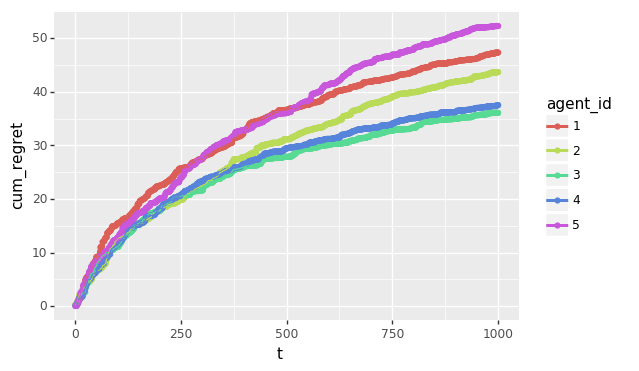

<ggplot: (8771103541721)>


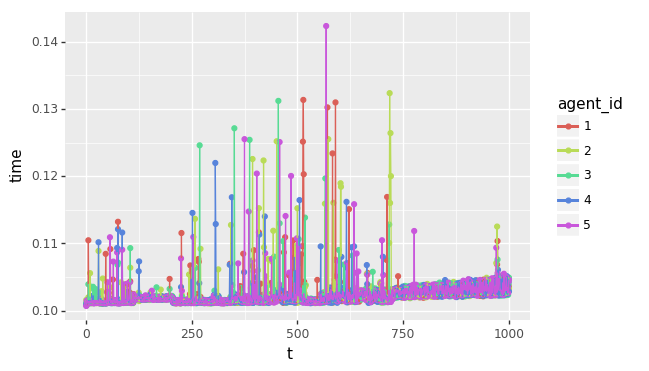

<ggplot: (8771103769241)>


In [5]:
hypers = [[0.2/2**n] for n in range(5)]
results_list_lgv, df_list_lgv, cum_regrets_list_lgv, avg_regrets_lgv = hyperparameter_sweeps(make_langevin_agent, hypers, dim, var, 1000, 4, verbosity=verbosity)

In [6]:
print(cum_regrets_list_lgv)
print(avg_regrets_lgv)

[[32.864247174251666, 37.68430408109724, 38.23960923522338, 40.44177690034283, 37.49151463379609], [35.78667681543567, 39.77547048926638, 40.8600765536169, 43.8784544967965, 37.7336739865747], [76.44315367906269, 67.31827999800451, 73.69700441457093, 67.09306491804034, 63.90114046069123], [47.30965553898087, 43.65475101449492, 36.05653277122202, 37.491160706950936, 52.24760980347238]]
[48.1009333  47.1082014  47.21330574 47.22611426 47.84348472]


In [ ]:
make_best_sgld_agent = lambda: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = lambda t: hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

In [ ]:
make_agents = [make_laplace_agent,
               make_pgts_agent,
               make_best_langevin_agent,
               make_mala_agent,
               make_best_sgld_agent,
               make_best_sagald_agent,
               make_mala_agent_untimed]
simple_compares(make_agents, num_articles, dim, var, n_steps, range(100,105), verbosity=verbosity):